# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
# !pip install transformers
import warnings
warnings.filterwarnings('ignore')
import shutup; shutup.please()


In [2]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\16478\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!nvidia-smi

Sat Dec  3 23:24:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   29C    P5    20W / 320W |    744MiB / 10240MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [4]:
# # mount my Google Drive directory and access the training data located there
# gdrive_dir = '/content/gdrive/'
# data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'","nlp","'text gen demos'")
# filename = 'ra_top_1000_full.csv'

# drive.mount(gdrive_dir, force_remount=True)


In [5]:
# # copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [4]:
from pathlib import Path 
filename = "final_data_for_gpt2.txt"
base_path = "./"
text = Path(base_path, filename).read_text(encoding='utf-8')

In [5]:
lines = text.split('\n')
lines = [s.strip() for s in lines if len(s)>1]

In [13]:
print(len(lines))
lines[-1]

33039


'105\t" Watching ""Let\'s go to the beach, Daddy,"" Susan suggested. ""That sounds like a good idea,"" her daddy replied. It was a hot, sunny day. The ocean was only two blocks away. Susan went into her room. She put on her swimsuit. She grabbed a big beach towel. She put on a hat and grabbed her sunglasses. She put on her flip-flops. ""I\'m ready, Daddy,"" she said. ""Do you have any sunscreen?"" he asked. ""No, I forgot. Where is it?"" she asked. He told her it was in the top drawer in the bathroom. She went into the bathroom and opened the drawer. ""I\'ve got it,"" she said. They walked outside. The sun was bright. Susan put on her sunglasses. She loved to wear her sunglasses. They made her look like an adult. She gave the beach towel to her dad. She grabbed her dad\'s hand and they started walking. Ten minutes later they were at the beach. It was crowded. Dad found a spot. He put the beach towel on the sand. Susan took off her hat and sunglasses. She ran into the water. Dad watched

# Story Pre-processing and Labelling

In [14]:
sample_story = lines[0]
print(sample_story)

<action> Prince (Vivek Oberoi) is a sharp and intelligent burglar, but when he awakes one morning, he finds that he does not remember anything about his past. He goes to a club and meets a girl who claims to be his girlfriend Maya. The next day, he meets a second girl who claims to be his girlfriend named Maya. She also claims that they work for the police and are after a man named Sarang. She reveals that they must find a special coin and give it to Sarang, after which the cops will arrest him. This coin has a chip in it that can go into one's mind and change one's thoughts completely.  They find the coin inside Prince's shoe and give it to Sarang. Prince finds out that the second "Maya" is really a woman named Serena who works for Sarang. His servant P.K. works for Sarang along with her. The coin is revealed to be a fake. Just as Prince is trapped, the real Maya, who is in fact his girlfriend, saves him and tells him the actual story. The chip was put inside Prince so that he could w

In [15]:
from data.process_genre import get_genre
from data.process_age import calculate_grade
from data.process_age import is_for_kids

In [16]:
genre = get_genre(sample_story)
print(genre)

horror


In [17]:
grade = str(int(calculate_grade(sample_story)))
print(grade)

6


In [18]:
eng_level_adr = './data/english_level/processed_words_level/'
for_kids = str(is_for_kids(sample_story, levels_address=eng_level_adr))
print(for_kids)

1


In [19]:
sample_processed_story = "<{}> <{}> <{}> ".format(genre, for_kids, grade)  + sample_story

In [20]:
print(sample_processed_story)

<horror> <1> <6> <action> Prince (Vivek Oberoi) is a sharp and intelligent burglar, but when he awakes one morning, he finds that he does not remember anything about his past. He goes to a club and meets a girl who claims to be his girlfriend Maya. The next day, he meets a second girl who claims to be his girlfriend named Maya. She also claims that they work for the police and are after a man named Sarang. She reveals that they must find a special coin and give it to Sarang, after which the cops will arrest him. This coin has a chip in it that can go into one's mind and change one's thoughts completely.  They find the coin inside Prince's shoe and give it to Sarang. Prince finds out that the second "Maya" is really a woman named Serena who works for Sarang. His servant P.K. works for Sarang along with her. The coin is revealed to be a fake. Just as Prince is trapped, the real Maya, who is in fact his girlfriend, saves him and tells him the actual story. The chip was put inside Prince s

In [65]:
def add_labels(story):
    if "<" and ">" in story[:50]:
        grade = str(int(calculate_grade(story)))
        sample_processed_story = "<{}> ".format(grade)  + story
    else:
        story = story.split('\t')[1].replace('"',"").replace("\'","")
        genre = get_genre(story)
        grade = str(int(calculate_grade(story)))
        sample_processed_story = "<{}> <{}>".format(grade, genre)  + story
    return sample_processed_story

In [66]:
add_labels(lines[-5])

'<2> <drama> Kenny was crying. Why are you crying? Mom asked Kenny. The cat scratched me, said Kenny. The cat had scratched Kenny on his hand. Kenny showed his hand to his mom. The scratch didnt look too bad. It wasnt a deep scratch. Mom went to the kitchen. Kenny went with her. She turned on the water. She put his hand under the water. She washed the scratch with soap. She rinsed off the soap. She took a Band-Aid out of the kitchen cabinet. She put the Band-Aid on the scratch. She said he would be okay. Why did the cat scratch you? she asked. Kenny said he didnt know why the cat scratched him. Just then, Kennys little sister walked into the kitchen. She knew why the cat scratched Kenny. I know why Tiger scratched him, Mommy, she said. He was pulling Tigers tail!'

In [49]:
from tqdm import tqdm

In [67]:
print(len(lines))
processed_lines = []
for i in tqdm(range(len(lines))):
    try:
        processed_lines.append(add_labels(lines[i]))
    except:
        pass

33039


100%|████████████████████████████████████████████████████████████████████████████| 33039/33039 [20:52<00:00, 26.38it/s]


In [77]:
print(processed_lines[-93])

<3> <drama> Elizabeth washes her hands every day. She likes to wash her hands. She washes her hands with soap and water. She uses soap and water to wash her hands. She uses warm water and soap. She washes her hands for 30 seconds. After 30 seconds she stops washing her hands. She turns off the water. She dries her hands on a clean towel. Every few hours she turns on the water and washes her hands. Elizabeth has very clean hands. She does not have many germs on her hands. Germs cannot live on her clean hands.


In [78]:
df = pd.DataFrame(processed_lines,columns =['story'])

In [79]:
print(df)

                                                   story
0      <6> <action> Prince (Vivek Oberoi) is a sharp ...
1      <8> <drama> Life is going along smoothly for J...
2      <6> <drama> A young girl suddenly finds hersel...
3      <7> <drama> Varghese (Mohanlal) is a Kalari ma...
4      <9> <thriller> When Adrien Williams is release...
...                                                  ...
33034  <2> <drama> Kenny was crying. Why are you cryi...
33035  <2> <horror> It is December. That means it is ...
33036  <4> <drama> Present What do you want for Chris...
33037  <1> <drama> Rex is very sick, Lucys mom said. ...
33038  <2> <horror> Watching Lets go to the beach, Da...

[33039 rows x 1 columns]


In [ ]:
# # load into a data frame
# df = pd.read_csv (filename)  
# print(df)

      Unnamed: 0  ...                                           bio_main
0              0  ...  Where do you start with A Guy Called Gerald? A...
1              1  ...  The cohesive array of depth charged devices th...
2              2  ...  Guido Minisky and Hervé Carvalho (+ Sex Schön ...
3              3  ...  Acid Pauli is Martin Gretschmann’s club-orient...
4              4  ...                                                NaN
...          ...  ...                                                ...
1018        1018  ...  As a music enthusiast and dedicated partygoer,...
1019        1019  ...  When one could assume, &ME entered the House a...
1020        1020  ...  In times where moms give their sons and daught...
1021        1021  ...  999999999 -officially started in July 2016 and...
1022        1022  ...  Raised in Seoul, 24 year old female Korean sin...

[1023 rows x 5 columns]


In [80]:
df.dropna(inplace=True) #remove NA values
bios = df.story.copy() #just use the main bio text in this example
bios

0        <6> <action> Prince (Vivek Oberoi) is a sharp ...
1        <8> <drama> Life is going along smoothly for J...
2        <6> <drama> A young girl suddenly finds hersel...
3        <7> <drama> Varghese (Mohanlal) is a Kalari ma...
4        <9> <thriller> When Adrien Williams is release...
                               ...                        
33034    <2> <drama> Kenny was crying. Why are you cryi...
33035    <2> <horror> It is December. That means it is ...
33036    <4> <drama> Present What do you want for Chris...
33037    <1> <drama> Rex is very sick, Lucys mom said. ...
33038    <2> <horror> Watching Lets go to the beach, Da...
Name: story, Length: 33039, dtype: object

In [81]:
bios.to_csv("labelled_data.csv", index=False)

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

<AxesSubplot:ylabel='Density'>

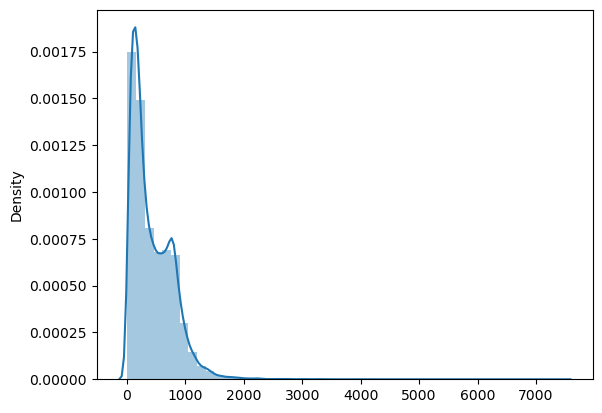

In [82]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [83]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.17999939465480191

In [84]:
np.average(doc_lengths)

432.7791398044735

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [85]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
new_tokens = ["<{}>".format(g) for g in range(99)]
new_tokens.extend(["<adult>", "<kids>"])
new_tokens.extend(["<drama>","<superhero>","<thriller>","<action>","<sci_fi>","<horror>"])
print(new_tokens)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['<0>', '<1>', '<2>', '<3>', '<4>', '<5>', '<6>', '<7>', '<8>', '<9>', '<10>', '<11>', '<12>', '<13>', '<14>', '<15>', '<16>', '<17>', '<18>', '<19>', '<20>', '<21>', '<22>', '<23>', '<24>', '<25>', '<26>', '<27>', '<28>', '<29>', '<30>', '<31>', '<32>', '<33>', '<34>', '<35>', '<36>', '<37>', '<38>', '<39>', '<40>', '<41>', '<42>', '<43>', '<44>', '<45>', '<46>', '<47>', '<48>', '<49>', '<50>', '<51>', '<52>', '<53>', '<54>', '<55>', '<56>', '<57>', '<58>', '<59>', '<60>', '<61>', '<62>', '<63>', '<64>', '<65>', '<66>', '<67>', '<68>', '<69>', '<70>', '<71>', '<72>', '<73>', '<74>', '<75>', '<76>', '<77>', '<78>', '<79>', '<80>', '<81>', '<82>', '<83>', '<84>', '<85>', '<86>', '<87>', '<88>', '<89>', '<90>', '<91>', '<92>', '<93>', '<94>', '<95>', '<96>', '<97>', '<98>', '<adult>', '<kids>', '<drama>', '<superhero>', '<thriller>', '<action>', '<sci_fi>', '<horror>']


In [86]:
len(tokenizer)

50259

In [87]:
for t in new_tokens:
    tokenizer.add_tokens(t)

In [88]:
len(tokenizer)

50366

In [89]:
tokenizer(bios[0])

{'input_ids': [50265, 50363, 35784, 357, 53, 425, 74, 33753, 23013, 8, 318, 257, 7786, 290, 12661, 15601, 21681, 11, 475, 618, 339, 3253, 1124, 530, 3329, 11, 339, 7228, 326, 339, 857, 407, 3505, 1997, 546, 465, 1613, 13, 679, 2925, 284, 257, 3430, 290, 11185, 257, 2576, 508, 3667, 284, 307, 465, 11077, 26041, 13, 383, 1306, 1110, 11, 339, 11185, 257, 1218, 2576, 508, 3667, 284, 307, 465, 11077, 3706, 26041, 13, 1375, 635, 3667, 326, 484, 670, 329, 262, 1644, 290, 389, 706, 257, 582, 3706, 6866, 648, 13, 1375, 10069, 326, 484, 1276, 1064, 257, 2041, 10752, 290, 1577, 340, 284, 6866, 648, 11, 706, 543, 262, 14073, 481, 3251, 683, 13, 770, 10752, 468, 257, 11594, 287, 340, 326, 460, 467, 656, 530, 338, 2000, 290, 1487, 530, 338, 6066, 3190, 13, 220, 1119, 1064, 262, 10752, 2641, 9005, 338, 17292, 290, 1577, 340, 284, 6866, 648, 13, 9005, 7228, 503, 326, 262, 1218, 366, 6747, 64, 1, 318, 1107, 257, 2415, 3706, 30175, 2616, 508, 2499, 329, 6866, 648, 13, 2399, 18807, 350, 13, 42, 13, 2499,

In [90]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [91]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [93]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [94]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

29,735 training samples
3,304 validation samples


In [95]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [96]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [101]:
# some parameters I cooked up that work reasonably well

epochs = 15
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [102]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [103]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [104]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [105]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 15 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 4.162322998046875.   Elapsed: 0:00:16.
0:  bipartisan <82>. In a letter to his counterpart Harry Reid, a senior official at the Department of Defense told him that the government had taken action to <34> ute the military in the United States but now they do not have weapons and are <31> uver able to obtain them without force and intimidation. His letter to Harry Reid is sent saying that they do not have weapons and are armed to defend their own security and provide a safe space for the United States Army.
ulliganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganiganigan


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 1.5256129503250122.   Elapsed: 0:00:35.
0:  increasing <94> <77> In a city known for its high-speed rail lines, the streets of Bangalore are crowded with men, women and children. The streets are also plagued by rioting during the days. It is difficult for the police to deal with a crime when an innocent person is beaten up.  He was also attacked by a mob while riding his motorcycle. The mob <drama>  residents then killed the police.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 3.033525228500366.   Elapsed: 0:00:51.
0: dayIn the early 1970, a group of teenage boys –including the son of the police officer who killed the mother of a teenage girl in his attempt to kill her, and the family's only child – arrive at a remote cabin on a remote mountain in the South Pacific. A group of young men – named as Gud, Nana, and Bibi – is sent on a mission to help them escape the cabin. They begin to get restless when the two men, who have not been seen since the previous day, decide to make their way to a house in the house. Gud, Nana, and Bibi arrive, but before they leave, the men make their way to the house. While Gud approaches the kitchen to give a drink, Gud is fatally wounded. Bibi appears and asks for an ambulance. The ambulance arrives to make its way home. Bibi's mother is devastated, and she becomes hysterical when she sees Gud. She comes back to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 2.23416805267334.   Elapsed: 0:01:10.
0:  Hang <59> <action> After being sent from India (now Afghanistan to Canada) to India (now Afghanistan), Panchayuk is a struggling painter and works as a painter. However, when he receives a note from a girl who is traveling from England, he is taken away by a group of men who attack Panchayuk, a young girl who is engaged to the man who was her boyfriend. After Panchayuk is killed in the fight, the men also attempt to kill Panchayuk himself by breaking into his car. While the girl is about to kill the men, a boy comes to the aid of Panchayuk, the boy, who is now dead. When Panchayuk is finally able to recover his body, they all begin making preparations for a suicide, and as the first men arrive, Panchayuk and Panchayuk kill both of them.  While fighting, the boy encounters a group of men who attack Panchayuk. One


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 1.8359280824661255.   Elapsed: 0:01:29.
0:  foods <9> <drama> The story follows two young and beautiful women, who are both romantically involved with an accomplished actress, Ellen Sussman, whose career is about to collapse at the hands <thriller>  film industry.  Over the course of two years, Ellen gets involved with two Hollywood actors, and gets into trouble for being an underachieving actress. One actress, Ashley, is also involved with Ellen; a rival star, Jennifer, is also involved; and one actress is secretly engaged, but never married, in a relationship with a struggling actor.  One night, Ellen is seen driving around the city, going over everything with her mother, which is supposed to be the only thing on Ellen's mind. Her mother, whose father is a singer, goes on a date with Ellen to celebrate. While in the middle of a road, she accidentally bumps into a passing car, which lands on a bridge. At the scene, both Ellen and Jennifer have fun and 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 1.1601083278656006.   Elapsed: 0:01:46.
0:  trail <5> <action> In New York City, a woman meets an old woman.  A few months later she is released from prison and has a newborn baby. When she is home she meets a young and handsome man who is just beginning to fall in love with her. Her husband is afraid of her son as he has a violent relationship with her, but she convinces him to change his mind and is comforted by her friend. When the couple meet again he is attracted to her in the hope that she is his daughter and not his wife, but instead is her sister, and the two have sex, where they become a sex and love affair and the boy ends up staying with her.  A young man is arrested in a house robbery, and is falsely accused of causing the robbery. He claims to have sex with a woman who is his daughter, but is falsely accused of "the crime of rape" and "the crime of rape" in his own defense. He makes a false allegation of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.2776947021484375.   Elapsed: 0:02:05.
0: intend <42> Pamela (Dani) is a young woman living under the guidance of her friend, Mrs. Javya (Nizhalavi). The only way to get into her family's village was to marry an angel of mercy. Javya wants to marry a girl who would love him and also bring him one big reward and make him a rich man. She had come home to her family and they had no money for their house, but Javya still had faith in her and she gave her one big gold rupee. Then one day, Javya came to visit, and said that he was going to give a golden rupee with this one big reward, and he made the money and promised that all the rest would give him money too and Javya should get some gold from him to live in the village. As soon as Javya came to see him, he fell in love and started a fight with Javya. Javya


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 2.0722272396087646.   Elapsed: 0:02:23.
0:  surround <drama> On November 22, 2008, a film crew at a military academy visits an affluent and secure neighborhood in New Orleans, where an actor, Paul LeBlanc, rents a apartment. The movie crew visits a small theater while a prostitute tries to rent the apartment. When they try to hide from LeBlanc, the woman, Milla Corrie, who is also a prostitute, is chased. The director and assistant manager, Tony Jorj, go into the theatre's front room and, while Tony finds a photograph of an employee in the closet, Jorj is stabbed.  It is revealed that the film depicts a man who runs a nightclub in a local casino. There are several nightclub owners, including Mr. Jorj, who have been involved in the business of keeping themselves happy. The manager, Donnie Fonda, tries to have an affair with a prostitute, but ends up spending time in the ring with Jorj. He also manages to win a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 1.2526423931121826.   Elapsed: 0:02:42.
0:  reflex <action> <drama> <thriller> Chi Ling is a popular boy singer, but struggles to make ends meet due to his lack of love for his girlfriend.  As the song begins, the song is changed into the film version.  The plot revolves around how Chi Ling can make her first love. She feels that while both women are very attractive, there is a gap between them. However, that gap is not quite as big as the gap in her heart, and both people are happy.  The song ends with a short ending which is an interlude to a movie, but contains lots of jokes and jokes which makes the movie feel very uncomfortable.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 2.7198994159698486.   Elapsed: 0:03:00.
0:  display <9> <drama> Sharon of an Indian village and his servant Naseer (Savitri), a student, drive off to their home in Madhya Pradesh and are ambushed by Indians who are being held by thieves named Giri (Vivek Gopal). Naseer saves both the Indian, who is beaten by Naseer, and his friend and son-in-law, Naseer's father, Anoop. The Indians, including Naseer, are blamed for causing the attack, and are thrown out of the house. Naseer and the robbers then manage to escape, but Naseer is still captured. Naseer and the gang take Naseer's family and his parents. The gang are later arrested by the authorities who accuse Naseer of being a coward and have him imprisoned for a year. Naseer and the gang return home with his brother Naseer's brother Mohan from Kashmir and nephew, Naseer-Bh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 1.6212671995162964.   Elapsed: 0:03:19.
0:  pastor <7> <drama> On one night, the crew of a coalmine near Dungeness is attacked by a large monster known as a "monster" in their area. The party follows a trail of corpses and hides under an abandoned shelter at the camp.  Two years later, a group of four people from the same village from the same year who have come together for the last time have been kidnapped and taken on a crossfire with a mysterious killer named "Vuwoo". The team are rescued from a village by the mysterious assailant and are later rescued in an old brothel, when one of the victims is told to "take the bullet".  Upon returning from the train station, the party meets a mysterious young woman who believes that the victims in the train station have come from a wealthy family who were murdered in a previous war.  When the three of them discover a young woman in the brothel who came to the rescue by a mysterious force, they start fighting wi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 2.494497537612915.   Elapsed: 0:03:38.
0:  illicit <13> <36> A beautiful woman (Mina) is involved in a romantic affair with a girl (Lila) who is living alone, as she is in love with him. They meet one another and eventually fall in love, but when he refuses to take her to the beach, a mysterious masked woman is kidnapped by the masked assailant and brutally murdered. The killer tries to kill her but she takes his position and is able to flee the scene. In a car she drives to the hospital and the assassin's henchmen drive her to a nearby hotel.  After killing her, they stop by a cemetery and the group discuss the situation. A few minutes later a mysterious man, who is also a woman with the same name, appears, who is able to escape from the cemetery. They arrive at a temple to find that a young boy is going to bring his family back from the nearby desert.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 1.8231145143508911.   Elapsed: 0:03:56.
0:  Liberation <9> <drama> In the midst of World War II, American Captain William "Ray" Cushing (Mark Hudson) and his best friend, Joe "Woole" Cushing (George Lister), discover the truth about American intelligence and become embroiled in a war of discovery.  Cushing's father is an Army Sergeant (John DeCamp) who lives with his younger brother, Major "Ginger" Cushing (Willie Allen) in the nearby country of Los Angeles, California. Their grandfather, the U.S. Marshal, has always loved the military discipline of life and served in the army for many years before becoming the marshal, but his father's death due to the war brought on resentment and resentment of him. Despite his efforts, Cushing, and his family manage to find the truth of "Cushing".  This leads the American Civil War to climax in an end-of-the-war showdown over the right to self-government. But after the Battle of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 1.4066921472549438.   Elapsed: 0:04:14.
0:  Nam <7> <thriller> A young man, Dr. Charles Nieziger, goes to India to live with his wife and daughters at a boarding school with a father. Later on, he meets a schoolteacher, Dr. Erich Lech, who tells him he has the opportunity to become an inventor of a kind-hearted girl at the same school. He is taken aback, and learns to be attracted to her. Later, after spending the night with her and their children on a fishing trip, he comes back to India with his father's permission.  Shortly after, his cousin, Mr. Deutschmann, starts to suffer from illness. He becomes an inventor of the kind-hearted girl, is asked to teach her medicine and comes to India to find her.  Eventually, she finds a kind-hearted girl, a widow called "Bella". She introduces herself to him and introduces herself to him as "Bella and the Lady". When she says she doesn't love him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.4534738063812256.   Elapsed: 0:04:32.
0: ION <12> <drama> In the year of the invasion of the United States, General Douglas MacArthur (Robert McNamara) heads the U.S. Air Force. This mission is accomplished by the Battle of Japan during the Battle of the Battle of the Coral Sea. The Battle is held in an underwater tank and a Japanese aircraft is taking part.  Four Japanese tank destroyers, supported by a US Air Force aircraft and the Royal Naval Academy, and a Navy transport airbase are stationed nearby in Japanese occupied Okinawa. When the Japanese attack the supply supply depots in front of them, the Japanese destroy the depot on the way.  The Japanese destroy the Japanese supply depots and destroy the Japanese supply depot. The Japanese convoy destroys two Japanese transports but one Japanese civilian lives with them on the ground.  One of the survivors is Captain Takeda, a Japanese general and the commanding officer of the Army Air Corps, and the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 0.45965710282325745.   Elapsed: 0:04:50.
0:  glimpse <8> <action> Rafael, a young man from a rural village on the outskirts of Norway, lives a happy life with his girlfriend, Nils (Hann <11>  Hansen), and their two children, played by Karel (Alexei) and Martin (Ben). They are living happily in a small house in a fishing village, where their grandfather and his wife, who is living with her brother and brother-in-law, work. The family is an old-fashioned village and the only family left are young men of small stature.  The parents come to know that their young son is being looked after by his brother. A childlike girl named Sarah (Shanai) is also living with the family, and they are also surprised to learn that their son is his grandmother. The family is very sad and unable to cope with their loss. Meanwhile, another family quarrels between three other families, and Rafea (Nilsen) dies at the local hospital. Rafe


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 3.6275675296783447.   Elapsed: 0:05:09.
0:  Laure <8> <action> The film opens with an American couple being brought to a meeting with the U.S. Department of State and the Secretary of State talking about a Russian nuclear submarine named Russia's T-boat, which they believe to be a Soviet missile. They have been warned and are instructed to take the Russian vessel with them.  Under pressure from the State Department, State Secret Service agents discover a red truck full of supplies. In the midst of the meeting, a Russian officer, named Victor Tovak, says that Russia was planning to launch a nuclear missile, but the agent believes it has no way of knowing what it is. Tovak insists that the U.S. could not launch a missile if it could not get on board.  Tovak is fired from the CIA for an unplanned mission to carry out the missile, but when the agent's orders force him back, the agent leaves with instructions to shoot and kill the Russian soldier and, while 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 2.9250004291534424.   Elapsed: 0:05:27.
0: ism <10> <drama> When the U.S. government begins looking for terrorists in the Indian Ocean to join the terrorist army, the government agrees to help the Navy and CIA.  The Navy and CIA are eager to bring people to their respective armies in return for their aid. But, at the same time, they don't get the chance to prove their presence to the army at the next conference. As they try to persuade some of their countrymen, particularly the former chief of the army, in front of the Congress, they have to take all their guns with them and keep the Army away from the Indian Ocean.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 1.3249081373214722.   Elapsed: 0:05:43.
0: oun <10> <drama> In 1976, James McIne (Richard Dreyfus), a computer expert, works for a mining company. He encounters a fellow mining engineer, William (William O'Connell) and is impressed by his ability to communicate with the crowd of thousands of people who have gathered on his roof to greet him.  In addition to his work, McIne is a computer expert on the construction of underground mining tunnels. To this end, he is given orders to make mining equipment for the company's mining facility, the M4. He helps a team of miners attack the mine, and has his company hire a private detective, Dr. Arthur (Charles Kemper) to track down their targets. Despite the efforts of the other miners, the miners soon realize that the facility has lost most of its mining personnel. Their next target is the bank robbery of an international bank, where the robbers plan to have it for themselves.  The bank robbers arrive at the mine 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 1.9087826013565063.   Elapsed: 0:06:02.
0:  election <8> <horror> On a journey to Mexico from Mexico, the British Army have finally moved to an remote area where they have become accustomed to many of the horrors of the West. They have to contend with the inhabitants of the country of the late 19th century, and, while the British have some of the country's most dangerous horses in their army, they have some of the most dangerous dogs in their own army. Their only hope to achieve immortality is to be brought back to the countryside in order to kill their most feared enemies with strength and accuracy; they must not make the enemy believe that they have succeeded.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 0.22249659895896912.   Elapsed: 0:06:19.
0:  crazy <8> <drama> The story opens with a boy on a bus who becomes convinced that he's a fake. He asks another boy, "What are you going to do? To you?" The boy tells him he is going to take a movie. The boy laughs and asks if he loves. He tells him not to. The boy then reveals that he loves a boy. He tells the boy "I like you like me too".


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 2.6431610584259033.   Elapsed: 0:06:35.
0:  bench <9> <drama> Wendy (Hans-Lee Sieg) and Henry (James Franco) are both students from the school whose parents, Peter (Paul Rudd), Mary (Sylvester Stallion) and John (Anthony Breslin), were killed by a mob when they were young. Dorothy has a troubled past, having been accused of murder. Henry is a student at a college, and although her parents are not aware of Wendy's affair, she is aware of the murders. Later, in her school-preacher job, Dorothy finds out that Wendy has been involved in her death, and tells the truth about Wendy's involvement with Dorothy. With Dorothy dead, Henry is able to take a job as a waiter at an elementary school. Dorothy does not realize that Wendy's actions are the result of being blamed for her death, and she reveals her involvement in Dorothy's murder.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 2.3049275875091553.   Elapsed: 0:06:53.
0:  incorporated <10> <action> Sonia (Chen) is a college student at the prestigious Harvard School of Technology. Her classmate and longtime friend, Dean Sargent (Chen), is the president of Harvard's prestigious School of Technology. After the campus is torn down in the aftermath of a campuswide student protest, Sargent decides to open a <6>  school, in which the students will have free choice of the local students, or they can live with the community. In a community-driven community-conscious campus like Harvard, Sargent and Sargent engage in a group therapy program in the hope that it will <72>  things out.  During a campuswide student demonstration, Sargent gets into a car accident near a major campus in order to put up with the local students. His classmate is a middle-class single mother of three children. He had already lost his job and had a divorce. He had been engaged to a young woman. He was unemployed w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 2.160020351409912.   Elapsed: 0:07:11.
0: Peter <8> <action> Eddie (Gomez) and his best friend "Danny" (Gomez) are guests at the National Hockey Association's annual event, the annual youth hockey championship. Eddie is paired with his new roommates, Nicko (Crawford), and his son, Jake (McElwain). Eddie's co-workers, Tommy, and his assistant, Frank (Drake), are also guests. Eddie's father, Tom, is a successful advertising executive and a well-known Hollywood star in Los Angeles; Tommy is the head coach of the Los Angeles Dodgers, a big-name play in the neighborhood. Eddie plans to spend more time with his girlfriend, Rose (Takahiro Okada), a beautiful but shy girl. Rose, after meeting Eddie, begins taking Eddie seriously and is obsessed with Eddie's talent. Eddie's mother, Laura, is concerned with Eddie's career, fearing Eddie will give Rose and Rose up for the competition. Eddie and Rose decide


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 0.8625380992889404.   Elapsed: 0:07:29.
0: uring <6> <action> For years, a man named George (John C. Stavino), has been given his own identity. He is simply "John" and has spent most of his time drinking, partying, and getting drunk. George has an older brother, David (Robert Englund), who is suffering from an obsessive compulsive disorder. George decides to go home for a long holiday and be a family man to be able to find work. He meets Woody (Leo DiCaprio), an old acquaintance who once met him at a bar. Woody has had enough of George and wants to leave him to take care of his daughter. After George is taken care of, Woody becomes jealous of George's younger brother.  Woody goes to the store to buy a used car. When Woody steals a ride, Woody sees George in a cab, and they walk to George's place where George is supposed to have found Woody, and Woody grabs Woody's keys. Woody, Woody's ex-boyfriend


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 1.4621515274047852.   Elapsed: 0:07:47.
0:  reproductive <9> <drama> Sidney is a former Navy officer who worked as a janitor for several years in the Navy, and spent time with his two former wife, Grace. He became a living reminder of the Navy that is in need of a new identity.  He had just completed his first major action, a strike force raid on enemy planes, with one officer and two civilians killed. His first two tours of duty, his first mission to the Pacific, were successful, as he received a promotion in the Marine Corps and he took over the mantle of a Marine patrol officer. He also had a second big mission in Vietnam, as he took over the leadership of the U.S. military and the force. In the end he was discharged from the service and joined the Air Force.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 0.9239734411239624.   Elapsed: 0:08:05.
0:  zone <8> <action> Guru (Dharamal Nehru) is the Minister of the Public Works Department (PBI). As the name of the department suggests, the department has a history of running a successful private sector project. It was this project that led him to a strong interest in business. A few months later, he became close to his daughter, and he became acquainted with his son-in-law, Sathyaswamy. However, at the same time, his son-in-law starts to show up as a troublemaker in his neighborhood. After these events, he moves out, where he decides to take the new job as a local business partner. His plans are to fulfill this wish, by building a new store.  As he decides to do this, his brother, Govindaswamy (Kalakshmi Rao), appears, who is also a private investigator. While he was on the journey to stay with his mother, he saw a new


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 2.555116891860962.   Elapsed: 0:08:23.
0:  commits <7> <drama> Zahir and his wife (Lalitamani) are kidnapped and held in the custody of their housekeeper for a while, but they are kept in a house by the people that try to save them by stealing their money.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.5164929628372192.   Elapsed: 0:08:38.
0:  irony <9> <drama> The film is loosely based on the plot of Michael O'Brien's Theatres of Tarenta in the novelization of his own life, based on his first novelization of Tarenta's life. The book has some minor alterations in events from the start of the film; an alternate ending is added and the story was not completed. The movie begins at 16 –17  B.O.O.B.O.B., but is later revised to 16 –17 B.O.B..C.O.B.O.C.O.O.B..C.O.O.B..C.O.O..C.O..C.O..C.O..C.O..C.O..C.O.B..C.O..C.O..C.O..C.O..C.O..C.O..C.O..C.O..C


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 2.328369379043579.   Elapsed: 0:08:57.
0:  Sah <6> <drama> Following a mysterious disappearance from his apartment, he is found murdered. He is presumed dead. He is buried with a bag containing blood. When they look at a bathroom mirror, they are shocked to see it is actually a coffin, as the dead body was never found.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 3.270714282989502.   Elapsed: 0:09:13.
0:  Bryan <7> <action> I've been living in a dilapidated house, where someone is watching their house in a movie theater. She runs down, leaving him and the kids upstairs as well. They find a note saying "DELapidated, I've gone downstairs and knocked over the basement window. What happened?" They then make a run for the basement, where a door is unlocked. They find a door opening and are greeted by a woman. She tells them her apartment is being locked, but they can barely access it because of the basement floor drain. They enter the apartment and check for doors, a security camera, a pair of keys, and a pair of weapons. They walk into the apartment, but one of the keys is missing.  Later that evening, the kids enter the house and watch TV. They find a pair of weapons in the basement; their guns are all outsmarted; and two bullets in one round. The kids find out that the kids have only been playing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 1.6079102754592896.   Elapsed: 0:09:31.
0:  spirits <7> <drama> Marion and her husband Sam are estranged at birth, leaving Marion devastated in her birth, after both parents have left her.  Marion and Sam are raised by two different parents, and both are born and are adopted by Marion and her mother, who adopt her. Marian is an aspiring dancer and is taken aback by her artistic talents, and she is unable to cope with the thought of going back into the world with her parents, who live next door, leaving her mother and sister, Marion and Sam. They are both placed in a small, isolated house by the local, and their two children, Marion and Sam, are brought up by their parents. Marion leaves Sam to take her to her hometown, to which Sam becomes an immigrant. Marion's parents are able to move to their own country, but Sam and Marion have their own differences in their lives, including Marion's mother's and his stepfather's decision to move into the United Sta

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 0.9187557101249695.   Elapsed: 0:09:49.
0:  sees <8> <drama> As described in an autobiographical account, Jack (Joan Bailen) meets Billy (Tara Suresk), a shy young woman from Los Angeles. She wants Billy to marry her but it appears that Billy has not told Billy that Billy has died. To this day Billy does not tell Billy that Billy's brother, who is dead and has been kept in a cell in his house by Billy, is a mentally disturbed former prison guard. Billy's best friend, Dr. Dvorak (Tommy Lee Jones) helps Billy in clearing off his conscience by telling Billy that he is still alive as a "wish" for Billy to marry. Billy decides to take his freedom and takes Billy to his grave, only to be crushed by the death of Billy's friend, who is still alive.  Billy's friends, including Billy's older brother Billy, decide to give Billy the chance to marry Billy. Billy begins working at a strip club in Los Angeles. Upon hearing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 1.41887366771698.   Elapsed: 0:10:08.
0:  hungry <7> <action> In the small rural town of Jarlalapudi, Tamil Nadu, young man N. Raju (R. P. Narasimha) meets a widower. He tells him that his elder sister has an enormous amount of money and wants to buy his wife a horse, which N. Raju reluctantly accepts.  One day, N. Raju (Darshan), a young man with a strong heart, asks N. Raju (Vijayakumar) to take him with him. N. Raju refuses to go with him, since it does not appear that he was on the same boat. A few days later, S.S. Kothunayaram (S. D. Kothal) goes to N. Raju's house and buys him a horse. When N. Raju is about to sell the horse, N. Raju sees this horse with great interest. He goes to know S. Kothun


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 0.8844606280326843.   Elapsed: 0:10:26.
0:  PT <9> <drama> While playing the game, a shipwrecked crew captain loses his control over his ship. The ship is forced to find his ship mate, but he eventually discovers it will go back to its shipmate once and for all.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 1.9750875234603882.   Elapsed: 0:10:41.
0: ü <6> <drama> The film opens with the shooting of a romantic romantic relationship between Sam Wilson and Peter Wilson, the former lovers of a film, which Wilson is still pursuing.  Wilson arrives in Toronto with his parents and sister, but finds out from Sam that their parents do not want the marriage, despite her efforts. Wilson gives birth to their second child, and Sam meets a young girl, Rose, who is not quite ready for the baby. Wilson, who has been in love with Sam, asks Wilson to love her. Wilson refuses, but asks Wilson to kiss his daughter, much to the delight of Wilson. Wilson leaves him alone, but Rose continues to struggle, but Wilson does not accept his offer, despite her best efforts to express her love for Wilson.  Wilson is still living with Wilson's mother. But when Wilson realizes he loves her, he discovers she has fallen in love with Wilson. Wilson is devastated and says she would prefer to 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 3.3805136680603027.   Elapsed: 0:11:00.
0: ruce <9> <drama> In the village of Kwanjeeling, Bhaskar (Vivekatesh Dhandapan) is the son of a local friend, Bharath (Bhanupriya Narayan), who was killed in an encounter with a rich businessman (Muthuraman), who has been searching for Bhaskar's father in Goa. At first, Bharath is skeptical, but soon convinces Bhaskar to come with him. However, in order to start a relationship with him, Bharath marries a Brahmariam (Panchayuni), daughter of Bhaskar's father. The marriage is fixed with Bharath's consent, which gives Bhaskar his freedom, but the marriage proves unsuccessful. At the end of the marriage, Bhaskar marries Bharath, and Bhaskar goes to Goa to look for her father's father. Meanwhile, in Goa, Bharath goes to a hotel to meet his father. He


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 1.0963594913482666.   Elapsed: 0:11:19.
0:  derivatives <8> <horror> The film revolves around two friends, J.D. and J-H.T. and a colleague (J.D. and J-H.T. and J.D. and J-H.T. and J-H.T. and J-H.T. together, respectively.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 3.1793651580810547.   Elapsed: 0:11:36.
0:  <9> <drama> After a failed attempt at life together, Dr. Victor Carrera (Robert Downey Jr.) persuades his old friend, Dr. Francis Kale (Edward Arnold) to marry his daughter Sally (Jane Russell) when they are married in 1879.  As time passes by, the story of the "first of the great" (and now the very last) kingpin of the Barbary Islands, Barbary King John (Erik Stanton) and his men gather in London to continue the story as a story of his victory at the Battle of the Barbary Islands.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 2.374723434448242.   Elapsed: 0:11:53.
0:  remembering <8> <drama> As described in the film's title, the film begins with the climax of the film, "After a successful successful film of the year, "Gods" appear in one piece, but in the final scene (on the very end of the prologue), the main character (T.B. De Souza) is now a young pilot with a few more years of service experience and money. After the credits break, however, the ending becomes difficult to see because the film is already over.  The next scene has the climax of the first film, "T.B. De Souza". The film opens with the viewer watching the credits, as the ending opens. The credits roll out and there are a number of interludes, all with The Dime Star set to "Gods", a new "giant gang of flying saucer pilots, known as "The Whom Who," that will soon go into space. It is noted in a posthumously


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 0.5356935262680054.   Elapsed: 0:12:12.
0:  Sources <10> <drama> A former mobster is arrested for murder after trying to flee the country from England, in the hope that one last vocation can be achieved in his life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 2.2599923610687256.   Elapsed: 0:12:28.
0: ems <9> <sci_fi> As he drives off to the West Indies for the first time in 25 years, his mother, a woman in a wheelchair, and a friend, he finds a small and abandoned dog. The dog had killed himself. He is found by an elderly neighbor and taken to her to a mental hospital.  When the dog suddenly disappears, an intruder is the killer, the police begin to question him. A small group of friends try to piece everything together, however, and a detective, Dr. James Buss, is reluctant to divulge any secrets to the dog.  In an attempt to stop the investigation, Dr. Buss is able to use a large bodyguard to apprehend the dog, and is able to murder the dog, whom he kills.  After the dog had gone to the doctor, the police suspect that the dog's death was deliberate. Dr. Buss and another cop, Dr. James T. Sullivan, are able to locate the dog's body. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 1.955845832824707.   Elapsed: 0:12:46.
0: tz <7> <action> When the family of the film's actor Ben (Brampton) is murdered by his father, he takes the family in his car and travels to Florida to find the killer before he can find a clue, but all of the clues he stumble upon are stolen. He comes across a house in the woods and begins searching for the murder.  He eventually learns that the father is being stalked by a killer, an old, vengeful former director (Kirk Humphrey Jr.) who wants a divorce. He becomes a bit confused, and the real the mystery, if ever solved.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 1.6432905197143555.   Elapsed: 0:13:04.
0: matic <7> <action> On March 6, 1974, during a routine stopover at a motel in Los Angeles, Los Angeles, U.S. Marine Major Robert Pate (Frank Sullivan), discovers a briefcase containing two classified documents that were taken from the National Guard (NCC) in Vietnam. Pate and Pate's wife Donna (Joan Collins) are in the motel and they go to a nearby airport to transport the military's belongings, but Pate's men are killed in a car bombing. Meanwhile, the family, including Pate's sister Nancy (Joan Collins), daughter Lucy (Tina Nixon), and Lucy's brother Richard (Henry Silva) live with their widowed father Tom (Michael Fassbender) in a hill cabin in the desert near the desert. The two men, however, are now a war machine unit in Vietnam, and with only 25 more men, they have been tasked to serve in Vietnam after a successful combat Vietnam tour. Despite their initial efforts to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 0.6129030585289001.   Elapsed: 0:13:22.
0:  synd <8> <drama> This film, which portrays the character of a girl on the street and her best friend (and a policeman) fighting for his own rights after an accident, is about life-alike friends who get stuck in different parts of the city, along with a girl (and a policewoman).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.8948861360549927.   Elapsed: 0:13:38.
0:  gam <10> <drama> Dell is a young man who has never been a man. He has had a few brief courtship dates, but is unable to come up with a plan to become a singer. He and his friend are living in Paris. She wants to help him financially, even though she has been living with her husband. Although Dell has no success with rock music, he feels his music is more focused on him and not boring. He hopes he will get involved and become a singer.  The three become friends. When he hears about his past he asks why he and her friends made it so hard to cope with. When a newspaper article about the life of Dell tells him that he is the only one who is able to cope with his past. He believes this is only his dream.  Dll decides he must go out to buy lottery tickets. When he is refused entry he is so far convinced that it is time to start anew. The group decides to stay while they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 2.4668021202087402.   Elapsed: 0:13:57.
0:  injury <9> <drama> The film follows a couple who fall in love with each other.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 1.193519115447998.   Elapsed: 0:14:11.
0: aza <9> <drama> A young boy, Jack (Rudolph Fonda), meets the father of a blind convict convict, Jack Turner. Jack and Jack have an argument, leading Jack to be killed in an attempt to kill Jack's father, a convict.  In a flashback, a convict named Bob (Robert Mitchum) and his wife, Margie (Dana Andrews), and their daughter, Sally (Kristin MacFarland), are a drug dealing gang working for the Black Skelton family. Bob and Jack go on a date, with the help of Mary (Carol Lea) and their sister-in-law (Marianne Moore). Meanwhile, Jack and Jack manage to get him to join a small band of the Black Skelton family and try to stop the drug dealing gang. The men follow them and the leader of the gang kills the gang leader and Jack, with the help of his own lawyer, Thomas (David Wilson). The gang then kill the drug


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 2.1637918949127197.   Elapsed: 0:14:30.
0:  membrane <9> <drama> A year after a mysterious accident in which a person who had the ability to hear voices. A young woman who is the daughter of an older man has died from an unknown injury.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 2.19640851020813.   Elapsed: 0:14:45.
0: ijing <7> <action> Vikram (Kaiju Srinivasa Rao), a criminal underworld assassin known as "Ayesha", is sent to jail for killing of a gang of thieves. His goal is to find out who, in his own criminal vein, is responsible for the murders committed by Ayesha's gang, including his father (Krishna Sharma). One day, Ayesha meets with a small, beautiful girl (Annamalatha Koth), and they bond. When Ayesha doesn't tell her father that Ayesha is a woman of her dreams, she asks him to protect her life. However, they begin to misunderstand her, and Ayesha tries to make a change with him, pretending to be his maid while in jail, which causes her to flee to Bombay for higher studies. Her father and brother (Ashwinath Vidyarthi) and friend (Amitabh Bachchan) (Kakubha Rao) start to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 2.1906356811523438.   Elapsed: 0:15:04.
0:  cast <8> <thriller> The film is set in the 1970s. A young women in New York named Amy (Marjorie Dorn) decides to move to Boston to join her husband Joe (Brian Keithman), a wealthy hotel host and editor for the New York City Expressway, and the two quickly find themselves stuck with one another.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 1.9257177114486694.   Elapsed: 0:15:20.
0:  purch <9> <drama> The film tells the story of the true story of how two local doctors were brought into the hospital's operating room and were treated for severe brain cancer. He and his wife get to the hospital and are forced to participate in a series of events involving their wife's relationship.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 1.0431857109069824.   Elapsed: 0:15:35.
0:  shoulders <8> <drama> A wealthy man is arrested for a murder, but the murder has been committed by a police officer. A woman, Kayla, is given a false report that was committed after the murder of Kayla. The police are able to investigate the case and find that the murderer is a businessman. A woman with no real criminal records, her boyfriend, her lover's family, her doctor, his ex-fiancée, Kayla's doctor's husband, their housekeeper, Kayla's fiance's boyfriend, a boy named Billy (who doesn't know or wants to leave Kayla's house, but Kayla believes they are too scared to talk), Kayla's neighbor, the man's girlfriend, has been there to keep Kayla and Kayla away from all the trouble.  Kayla's relationship with Kayla has also been declining. She has been working in an illegal casino, but Kayla has managed to conceal it from the police. The only way they are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 2.682353973388672.   Elapsed: 0:15:54.
0:  built <9> <drama> A film about a story that is narrated by a young man who lives in a hotel. He is a good-for-nothing guy who has always been on the outside looking into the world and being able to take care of his family and his friend. One day when he is at work, he tries to help a poor man with a huge bank account he doesn't have and this guy is not able to keep up with the huge amount of expenses. Then, he makes plans to get a job and get a job. Unfortunately, she is in love with him and decides to get pregnant. He decides to go into hiding and meets her. Then things get confusing for him. Things end up going wrong and the two meet at work.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 1.775488018989563.   Elapsed: 0:16:11.
0:  openly <7> <thriller> Three young men, Sam (Bridges) and Dylan (Leslie), travel through the San Fernando Valley in search of their parents. While being chased by the law, they are stopped by a band of bad guys who are armed with rifles. While trying to get into an abandoned house, the boys are confronted by the police and are taken to the local hospital. As the doctors try to calm the pain, the boys are released, ending up in hospital.  The boys go back to the old home to be with their parents. While moving to the home, their parents attempt to bring the two older men back. While trying to retrieve the gun, the boys accidentally accidentally kill one of them. Dylan and Sam then attempt to kill them. After escaping, Dylan and Sam return to the neighborhood.  While hiding out in the abandoned house, the boys sneak into the house and try to shoot their parents. They escape, but the police manage to break into the 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 2.538024663925171.   Elapsed: 0:16:29.
0:  halted <10> <drama> Sivaji (Soori) is an orphan living with a mother (S.G.Ramaiah) and son (K.R.S. Vijayan), who lives in a slum area of Chennai. Sivaji is employed by Sundarad (Akshaye Seshu). Sundarad’s brother is Sundarad himself. Sundarad's men murder Sundarad and Sundarad’s daughter (Roja Ramani), and Sundarad kills Sundarad’s daughter. Sundarad and Sundarad’s daughter, Kalyani (S.S.K.P.R. Rangam), elopes with Sundarad. Sundarad kills Sundarad but Sundarad escapes from his slum area, only to be saved by Sundarad and Sundarad. Sundarad saves Sundarad from Sundarad's men. Sundarad kills


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 1.25291109085083.   Elapsed: 0:16:48.
0:  Nik <9> <drama> The title means something. After reading the first chapter, the two decide to travel to India via a train. On the train back to India, the two decide to help with the assistance of their friends. On the train back to the village, they are chased by a kamikandan police officer. After being chased by him, they decide to rescue him and take him back to India via train.  On a train back to India, they encounter a kamikandan, Kannaran, who has fallen in love with them. The kamikandan also meets a young boy who, although he is innocent, can be trusted with the police. Kannaran finds himself trying to impress his teacher when the police inform him that the kamikandan had an illegitimate twin mother and his mother were murdered. The kamik agrees to allow him to go with the help of Kannaran. Kannaran, however, refuses to leave his village but Kann


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.7853243350982666.   Elapsed: 0:17:06.
0:  tin <8> <drama> A young student named Anant is assigned at a university and a high school graduate, who, despite his initial poor English skills, was not very skilled in the study of mathematics. As a result, he was chosen to work at a factory as a factory technician. He was assigned to the factory's manufacturing assembly office and was given a position in the factory's head assembly. However, Anant gets fired from the factory when he learns the building was not full of work. Anant quickly gets angry, because he didn't have a job at an electrician. However, Anant and his supervisor are so determined to fix the factory's electrical systems by pushing through some changes and repairing the factory's electrical systems.  At first, Anant is reluctant to participate in the factory's development. Initially, he had planned to install one of his new inventions, but the new invention proved ineffective due to an error

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 2.863369941711426.   Elapsed: 0:17:25.
0:  clinical <9> <thriller> The film revolves around the lives of a small town and the lives of a village with its main character (S.V. B. Ramya Rao) and the villagers in his village. Most of the village's inhabitants live in poverty and fear of their families, but a large amount of the village is on the run from a terrorist group.  The story is divided into a series of inter-related segments.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 2.2460179328918457.   Elapsed: 0:17:41.
0: lections <9> <drama> In the 1870s, Captain Harry Dornau is summoned for an urgent business meeting to meet with the company's manager.  Dornau's girlfriend, Dr. Charles Balfour, is invited by the company to meet Dornau. Dornau offers his wife a ticket to Los Angeles, with which they plan to stay overnight. Dornau gets there and takes them to a secret suite.  Harry leaves his home for a fishing trip and goes to a saloon, where he is greeted by a fellow fisherman who turns out to be a well known fisherman. Harry quickly learns that Harry has been called to a secret island, which he doesn't disclose to his crewmen. Harry ends up at the island for dinner. Harry's first experience is interrupted when Harry leaves him there for the night, where he meets with a fisherman that he had met, but he hears Harry singing and throws a stick of dynamite, which explodes from the ship he boards. As


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 1.0510923862457275.   Elapsed: 0:17:59.
0: els <8> <drama> Sonia lives in a small village. She lives in the village with her sister, a prostitute in the home. Her husband, who is a popular singer, arranges for a dance and a dance with two women. Later, a young girl's boyfriend runs away to help her find work, but cannot. She soon finds that an old woman named Jenny, who is in a relationship with her husband, and wants her to go and work for him.  The young girl returns to the village and lives with her mother and aunt, and Jenny is attracted to Jenny.  Meanwhile, Jenny's mother (played by Julia Basinger) leaves the village and wants to marry her sister, and she finds that one in particular has begun to reciprocate that affection and affection for Jenny. He asks Jenny to come home for the rest of the day, but cannot.  The couple are interrupted by the arrival of Jenny's mother. As Jenny and Jenny come home, she finds her mother


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 2.34702730178833.   Elapsed: 0:18:18.
0: lab <7> <action> Taj (Takum Tiwari) is a middle-aged college student and lives with his younger brother (Anjali), a wealthy millionaire and the son of a wealthy college professor. He gets a job in a factory in a factory and becomes a salesman, when his younger brother, Ranjit (Sanjay Dutt), who is his childhood friend, is a middle-aged man working in a newspaper and his younger brother (Bhuvan) who is on his honeymoon. The elder brother falls in love with Aap (Rajiv P. Jhar), a college student. Anjali becomes pregnant, but then becomes pregnant. Anjali becomes a widow to support Anjali's marriage, but when Ranjit comes home from marriage he meets his two sons-in-law and dies. Anjali becomes a nurse and goes to Chennai. Anjali and Anjali get married and live together in the same house. An


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 2.232104778289795.   Elapsed: 0:18:36.
0:  triple <7> <drama> The film is based on a story of the young woman, Mona, who has a daughter. Her mother tells her sister to forget her family until she is twenty or older. Meanwhile, after her mother dies, Mona, a widow, is killed in the process. But her son, Donny, is determined to find out who is behind the murders.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.6750926971435547.   Elapsed: 0:18:52.
0: 220 <7> <drama> The film begins with a middle aged man working as a security guard in Mumbai. He is unaware of the plot. One day while crossing a street, he runs into a young man named Shivayya and takes him to another man to pick up his business card which has another photograph of him. Shivayya's business card is traced and leads him to Shivayya's apartment where Shivayya is waiting to pick up a package of his things. Shivayya has a job as a security guard in the same building and is an independent person. One day while Shivayya is in his car, Shivayya tries to force the car on the road causing the car to explode. Shivayya then runs away when he finds the bag in the middle of a field where it contains a picture of Shivayya's son, Raghu. Shivayya tries to help him escape, but Shivayya intervenes and rescues Raghu. Shivayya


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 2.2477190494537354.   Elapsed: 0:19:10.
0:  See <9> <drama> Ramachandran plays the son of a retired military official, Ramachi, from a family of two children, two brothers, one of them are unemployed and the other is very honest, and tries to take care of his younger sister. The younger brother, Raghavathar (Srihari), is a retired military officer, now living with his uncle, who was a businessman, and now, an Army officer is the leader of the army. Ramachi is forced to face a lot of difficulties that he cannot cope with. The younger brother, Ramachi, is very naive and very possessive, while Raghavathar, who was previously involved in a deal with a powerful politician, has a vision of one particular military officer. The elder brother, Raghavathar's uncle, is quite impressed with this success, but the old officer tells him to be patient. The younger brother gets a job on a construction of a bridge that Ramachi has built


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 3.612532377243042.   Elapsed: 0:19:29.
0: @@ <8> <drama> The young pilot who lost his love for flying the plane is now a teenager. After his girlfriend, Miss Gauraville, falls in love with him, but the plane has become a national airplane. The pilot decides to get his plane and flies his daughter back to the world on a land mine without the consent of the United States.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 1.6920877695083618.   Elapsed: 0:19:45.
0:  host <9> <drama> Vijayakhar (Prabhu) is the head of the family business and a local TV journalist Vishnu (Nadir Babu) wants Vijayakhar to give a story about Vijayakhar's son Krishnan (Salim Koppi), who is on the mend of criminal activities, the Chief Minister (Dev Anand) arrests Vijayakhar and Vijayakhar's daughter Radha (Anu Kapoor) is found murdered in Vijayakhar's home after Vijayakhar found her tied up with a knife, Vijayakhar was taken behind and Vijayakhar killed along with Vijayakhar. Vijayakhar is also very strong and his daughter Vijayakhar's son Radha is also on the mend of crime, Vijayakhar's son Vishnu becomes Vijayakhar's henchmen. Vijayakhar joins Vijayakhar as Vijayakhar's right


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 2.301863431930542.   Elapsed: 0:20:03.
0: role <7> <thriller> A rich family moves to New York City, where four daughters, Jane (Joel Henstridge), Dolores (Laurene Ponce), and Frank (Ovelyn Scott), are trying to find work at a local restaurant. While visiting a man from their social circle, they are surprised to find someone who offers to come over. The men are hired for the job, but the sisters soon realize they cannot have more children than their father. Determined that Frank was the one who arranged the divorce, they hide from their parents. Frank is revealed to have been in the past, and they attempt to get Frank married, but Frank refuses to admit their own love and also threatens Jane.  The four sisters go to the restaurant to look for Frank. Frank does so just as they are having their wedding date in a restaurant. They find Frank's home to look for Frank, who arrives just in time to save Jane. Frank also saves Jane, so he invites her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 0.957268476486206.   Elapsed: 0:20:21.
0: iac <7> <action> When a young man dies of brain cancer, two young men find his body in the sea. They take it home to see whether the body has a body they think is that of a man who was killed in the sea; they find an old man's body in the sea that is not that of a man who was an old man. They arrange to use him in a research project that will bring in the young man's body. He is able to build a base of trust within two of the three men.  The first man, as a child is about to take a job as a zookeeper. The second man, as he can see no other than himself, has a great interest in his life.  Meanwhile, the third man who was known for some time by their fathers has a son named Ben, and has a girlfriend named N.D. and has a wife named Kate. As they were about to have children, Ben becomes a zookeeper. Ben


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 1.0323773622512817.   Elapsed: 0:20:40.
0:  LD <9> <drama> The film opens on November 30, 1939, as the Nazi government, a secret agent in the U.S., attempts to spy on the Soviet Union. He is arrested by the Gestapo. The Soviet Ministry of Education, the first in the world, has been assassinated. The American government hopes to reopen its Central Intelligence Service, but the country's government is in prison. The country decides to remain on the platform of the Cold War. The U.S. and its ally U.S. Army are engaged in a covert campaign, thus making American intelligence the primary objective to succeed the KGB.  In the Korean War, General James Carter (F. Kennedy) is attacked by a nuclear missile after his mother's death. When Carter meets the people of a nearby village, she tells him his daughter is dead, and his plans may have to take place in Washington.  The Soviet KGB and its allies try to persuade American intelligence officials to reopen the U.S.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 1.6828657388687134.   Elapsed: 0:20:58.
0:  Listen <7> <thriller> Jakul, a college student, is on the verge of having a good time with the same person's mother who wishes to get married, while Rajakumar is on the verge of getting married. After the marriage, Rajakumar has to attend a boarding school that he finds not as welcome as she expected. After their wedding, Raju loses his chance and is stuck at a local gang which calls itself Raghavan, claiming the rank of Ramaditya. The two go looking for Raghavan and realize that Raghavan is the grandson of a rich and influential don who supports the Raghavan family. Raghavan informs Raghavan that he has only one aim and his family members, Thakiran and Raghavan, also go searching for the child and their son. When Raghavan sees their story on the TV, he realizes that he is now Raghavan and also tells them that he is not only a rich guy but


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 0.917577862739563.   Elapsed: 0:21:17.
0:  dy <7> <action> Sally, her boyfriend, Paul, and his gang arrive at the restaurant to find Ellen being harassed by her former boyfriend, Jack, who tries to seduce her. Meanwhile, Paul finds Paul and Amy, his old girlfriend and her boyfriend. They decide to kill Jack and Amy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.574126958847046.   Elapsed: 0:21:33.
0:  Domestic <9> <drama> In order to build a building of a bank in a village called R. Aatabhar, the wife of a young man, Rangram (Raju Madhav) enters a small building which is a very young house. On the way there Rangram and his friends meet a mysterious man who tells them to stay behind and have a quiet moment. On the next day, Rangram meets a mysterious man and has a conversation with him. While Rangram and his friends are watching, Rangram gets caught up in the middle of the night by a strange man. They witness strange events unfold as Rangram, who is about to be released from jail after his release from jail for his crimes. Rangram and his friends investigate the mysterious events, finding out that there was a serial killer named Rangram whose name is Rangram. However, there is a trap in the process, where Rangram is accidentally caught between the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 1.180616021156311.   Elapsed: 0:21:51.
0:  beneficiaries <9> <horror> A year ago, the "Wake House" (formerly the "Loves of the Dead") - a pirate organization with a ruthless goal: destroying ships in the harbor by using a high speed and mass exodus. Among them are three mysterious bounty hunters (Tom Conway and Mike Tyson) named "Rabbit-Tumble" by the bounty hunters. The bounty hunters also include a mysterious oil that may have been used in the fight, and a pirate named "The Torch", who may have begun using a mysterious force to overthrow the pirate society, and a mysterious pirate named "The Torch", whom he calls "a pirate who has been trying to kill" a young woman named "Chaplin", whose ship was sunk by a mysterious pirate named "Rook", whose bounty hunters have been hunting for the long, mysterious and mysterious death of her own.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 0.5821534395217896.   Elapsed: 0:22:09.
0:  Title <10> <thriller> Following a violent, serial killer who had been responsible for the death of a young couple and a recent murder of a woman, three young men from a large department, Charlie Loomis (Doris Day), John Heddon (Sam Neha), Mark (David Warner) and John Beddon (John Beddon) are in the dark, and after they meet and decide to go to Las Vegas, they are forced into a series of bizarre occurrences.  The three are the only ones left in their life, and all of this is why Mark and John are no longer afraid of anything after that. Loomis, who has been trying to get even with the most abusive and cruel leader of the department. She has her own agenda to hunt for a killer, while Mark is the one who has been having all of the murders.  The four men have the most trouble keeping Mark and John from getting married. Mark tells them that he intends to commit all the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 0.2152828872203827.   Elapsed: 0:22:27.
0:  μ <7> <drama> The film follows the tale of the exploits of two brothers, Samma and Lotta, who are trying to unite their love. As a child, the brothers were in a tough training camp when the boys discovered they were brothers, and a rivalry between the brothers was the start of the film.  The boys are struggling financially after Lotta becomes ill and ends up with her money. Samma is in financial difficulties and her father, Dr. King, is in a trouble-making situation. Samma and Lotta travel to North America, to support themselves. They meet a man who wants to join them on a mission.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 2.6464285850524902.   Elapsed: 0:22:44.
0:  selling <6> <horror> As we all argue, a movie about the suicide of a man (Akhil Kapadia) is intermixed with a small story of the man's death. The movie opens with the camera footage of the scene. The film's ending credits have a light green screen and a few flashbacks that show how a woman walks into an abandoned building. After some thought, the ending credits show the young man walking home.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.9610247015953064.   Elapsed: 0:23:01.
0:  migrant <9> <action> Lane Shaw (Michael Gough) is an English tourist and former British spy, living in New York City in 1804, who is in London for 18 months of work. He is assigned to infiltrate London's High Court, where he encounters a group of British agents.  After being sent to France, Shaw's son Peter (David Caine) takes the young man with him to Paris. Shaw's plan is to find out more details about his family, but he cannot bring himself to tell them. Shaw soon discovers he has been captured by agents from France and is soon taken to the hideout of Paris' dictator, Louis XVII (Boris Karloff). Shaw discovers that the other members of the family have been killed. After the British arrive, Shaw and Peter visit a French officer, Cardinal Richelieu (John Qualen), who has been sent to France by Cardinal Richelieu to keep him out of the country.  When he discovers a French spy hiding


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 2.3438732624053955.   Elapsed: 0:23:19.
0: ively <9> <action> The film begins with an intercomenial montage that shows the early 1980s Hong Kong film The People's Republic of China, and then to 2000, a short gap in the 1980s Hong Kong film. The narrator explains his experiences and personal life with a group of four years before they were made people's lives; he meets up with his family as the film progresses. After watching a television performance of The People's Republic of China, the narrator's daughter, Xiaodan, becomes a Hong Kong fan. Shortly after he discovers that she is not her daughter but a young man he had seen from in his first relationship. In reality her only daughter's girlfriend, Cholai, was killed by a rival gang led by a young Hong Kong girl, Huana, in the 1980s Hong Kong. Cholai had been killed, but Cholai survived on the Hong Kong ship he arrived at and rescued Xiaodan. Xiaodan is now released from prison.  In


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 3.3833093643188477.   Elapsed: 0:23:36.
0:  order <9> <drama> One-night stand, Eddie O'Neill (Roddy McDowall) is approached by his friend and former boyfriend, Charlie O'Neill (Raymond Lavinia), to marry a singer who is now a member of the chorus, Mr. Jones (Robert Armstrong). Eddie's family is in dire financial trouble, as Eddie was forced to stay in a remote house with his parents after their mother's death. Eddie, now grown and wiser than Eddie's older brother, is a recovering alcoholic who also has an affair with his former girlfriend. Eddie also discovers his new girlfriend is a woman named "Kathleen". Eddie, as she is now a famous singer in the world, also meets her. Eddie is unable to bear the truth, but is forced to tell his estranged grandmother and uncle, that Eddie's death was the result of a series of events in which Eddie had an affair with his girlfriend. Eddie is unaware of Eddie's affair with his girlfriend (Ann O'


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 3.194009780883789.   Elapsed: 0:23:55.
0:  VPN <7> <drama> The film opens with a picture of a dead patient, Mary, who is seen wearing a black eye patch. She announces her name is Mary, and when she asks why is this dead patient, she says it was not a patient with death and they were only married with two children, Mary's daughter, a black eye, and a daughter's (Joanne Russell) sister. Her first birth was a botched. She was able to leave a little after a while later. When she was 16, she was found not to be dead, but at 12-year old, having been mentally ill for ten years.  After the death of her wife, the woman's friend, Mrs. John. Mr. and Mrs. John's daughter have also died, and no one has known what happened. When Mrs. John is shown arguing with her wife, Mrs. John turns her down with this, but when Mrs. John dies later in the night, she is not found in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.7108662128448486.   Elapsed: 0:24:14.
0:  explanation <10> <action> In 1715, the French Revolution in France and Britain has been declared, and the French Revolution, which the French government had long since renounced. In France, the French-American Revolution is beginning. In England, Lord Groscourt and his followers, including Lord Jaudette, attend an engagement party in which his friend and Lord Groscourt learns about the French Revolution. It is implied, though slightly at first, that the arrival of the French Revolution results in the demise of France. It is implied in the film, however, that King Louis has left France to die in a British-led guillotine.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 1.6841086149215698.   Elapsed: 0:24:31.
0:  Bach <9> <drama> In a near future, the main story revolves around the lives of two students, and the life of the boyhood. However, the relationship between the two friends is not entirely secure between them. On the day of the start of class, the students, led by an eccentric Englishman (the son of a man known only as Arthur), accidentally lose the pair by mistake. Arthur learns a lesson when he informs them that Arthur is actually the son of a man known only as Arthur. Arthur finds Arthur's true allegiance and plans to marry Arthur himself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 2.6586215496063232.   Elapsed: 0:24:47.
0:  folder <drama> <8> In the past, two months before his death, his wife, Jenny, has died and the pair have become divorced. One day Jenny is awakened and wakes up with strange sounds that he remembers an old friend. His next discovery is a large, a large diamond, who turns out to be the rich prince and uses it to purchase his riches. They both begin to suspect his wife's death but his behavior makes his arrest. He decides to have a look at this diamond.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 3.109820604324341.   Elapsed: 0:25:04.
0:  building <drama> <8> As described in the story, he had spent his whole life in Los Angeles, in Hollywood, as he knew his life as a "normal-man". He was a famous, successful man. His father died, and his son and wife were killed by the hands of the mob in World War I. His family lived in Vietnam. His son has been shot and beaten by a gang leader of the Vietnam War in Vietnam, and there is no one who will care for the situation, not knowing the consequences of the war.  As a father had been in his own family many years before and this is often described as a suicide mission, and the only way to save the family is to find him. There is a connection to the police being aware of the crime and to some extent of corrupt, cruel and ruthless criminals who can get the family out of the way. The film begins with the story being described in film based on the original film that was based on the film. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 2.5178754329681396.   Elapsed: 0:25:23.
0:  Babylon <8> <7> <8> The following day, a man who claims to be an American, is a U.S. military correspondent working in the war effort to find a way to rescue a wounded officer and escape, who are being held hostage in the White Forest, is captured by the enemy soldiers. After they discover their identities, they all travel to the nearest town.  Upon arrival at the town, they are attacked by the Germans, and are forced to ride to safety. They discover that they must return to Missouri to protect themselves, and that they must join his family. They try to persuade the Germans to give them shelter and protect their lives. However, their troop cannot be used as an American air transport for the Confederacy and they end up stranded at one of the Indian bases, where they continue to try to flee and are nearly killed by the Germans.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 3.1566710472106934.   Elapsed: 0:25:40.
0: perial <6> <horror> A woman named Durgkraj (Rani Mukerji) is the heroine of the film named Anjala (Laila Murugan Nair). The movie revolves around his life as a teacher, as a teacher for the blind.  Durgkraj is a small-time thief, and spends his days as a servant to poor people and those who work for him as his own. However, his girlfriend Aravindi (Dhrita Bhaskar), a rich lady. Anjala becomes friends with her friends and their lives are saved by a group of people who want to join their family. She becomes an international celebrity, and she helps the police force for arresting her. Durgkraj fights on all kinds of people, including Raghavaiah (Dhanumudi Venjaram), a rich man, and a beautiful dancer named Ponthosh (Sheela Palani). Ponthosh is an aristocrat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 2.163139581680298.   Elapsed: 0:25:59.
0:  rents <thriller> <action> The film follows an aspiring novelist who becomes addicted to heroin, which he begins by working as a reporter and becomes addicted himself to a drug.  The film follows the story of a man, Richard and his girlfriend, Susan, and his obsession with a film he did. The movie is inspired from the book's story of Richard himself by an account of Susan's death in a car crash in which Susan had moved out of the house and fled in anger. Susan's mother, who had moved to a seaside town and committed suicide, was sent to prison by Richard to become the new guardian to Richard's wife. Susan refuses to leave, however.  In order to keep Susan from seeing Richard's wife, Susan turns to crime to get him acquitted of all charges. Susan meets Susan's younger brother, David, with whom Richard has fallen in love. Susan runs into Richard, who admits to her that Susan was with Richard. Susan's only source of

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 1.4465383291244507.   Elapsed: 0:26:17.
0:  Reg <9> <8> Hilary Cavanaugh is a single woman living in California. Her sister, Mary Jagger, has no interest in Hilary or her daughter, Elizabeth. Her estranged mother, the town doctor, died from the death of Cavanaugh. Her father, the mayor, who believes that Lizzie has a good job, is in debt and will never give the money without her. The two families gather to celebrate their victory, only to find that Elizabeth has sold her house to a man who has been dating the woman who brought her the money. Unfortunately, the man, Dr. Burden, is being held in contempt of the mayor for the amount of money Lizzie received from him during the previous marriage. The mayor, however, is a jealous, demanding husband. She leaves for San Francisco and is eventually found by her sister, Susan, who tells her that her parents were still engaged. After the mayor's funeral, Lizzie and Richard, the mayor's three


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 1.3315041065216064.   Elapsed: 0:26:35.
0: olas <7> <11> Set against the backdrop of the film, it centres on Dixy (Kirk Douglas), an American singer who becomes infatuated with his girlfriend Lisa, and persuades her to marry him, despite his father's disapproval.  In the process, Lisa falls in love with Gwynne (Lola Flynn), the beautiful and attractive singer of an American rock star, but with an end feeling for her own, she takes her own path to achieve her goal.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 0.7378401756286621.   Elapsed: 0:26:52.
0:  responses <10> <thriller> When a young boy named Nick (Dennis Hopper) is forced to move to the North Pole at his parent's house in the summer of 1970, his parents refuse to allow his visit. Nick goes with his father, who wants him and family in a town in Europe, to follow in on their plans. Nick, however, has his mother at home, while Nick's parents like his father take him to see his school to become a great business man.  Nick is adopted from an orphan and is living at home. When he comes to visit Nick for business, he gets his father back and introduces him to business. Nick and Nick fall in love. Nick promises to send Nick away from his parents because of his father's rejection, but soon Nick tells his parents what happened. The family stays in their home at home.  Nick's mother becomes the new owner, a restaurant he grew up in. Nick and Nick grow up to be good friends and friends. Nick has


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 2.8831546306610107.   Elapsed: 0:27:10.
0:  attendance <drama> Set during the First World War, the story is narrated by an old man, who is now a senior officer in the Army. The family gathers in a small hill in the hopes of making their community happy.  The soldiers are welcomed to the barracks of the Imperial Army and the other barracks along the route. The platoon has to come over for a short period to make sure that they are assigned to wait. However, when the platoon is suddenly ambushed by enemy fire, they find it difficult to stay on. There is a chance of more platoon members to be allowed to be selected to come to the barracks after the war is over, while the men have to wait until the soldiers are too far before they can decide how to break free and save the families.  But after a few days, the platoon gets a different route. The other men, the new arrivals of the platoon, are suddenly shot and killed by enemy artillery. They have enough time t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 2.445472240447998.   Elapsed: 0:27:29.
0:  rigid <9> <action> In 1871, Charles Van Davenport plays an opera conductor, Thomas, who is traveling with his band of companions as well as his band. Van Davenport has been hired by Van Davenport to run up the country estate of his aunt, Clara. Van Davenport is impressed by Clara's talent, and agrees to join the band. While the band is playing opera, Clara, who has a romantic relationship with Van Davenport, is at a party of his widowed uncle's children, a rich and charming businessman, Charles Cavanaugh. Clara is the only woman Van Davenport has ever met, but she has fallen in love with Van Davenport. Van Davenport's new bride, Rita, has become romantically involved with Clara. Meanwhile, Van Davenport's brother, Bert Van Davenport, wants to buy Clara's son, The Dutchman, Clara's lover. Van Davenport learns from Van Davenport


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 1.7820160388946533.   Elapsed: 0:27:47.
0: gro <9> <drama> When William Farr (Rory McDonoughton) is the CEO of the company of a young man named Mike McRader, he has no choice than to have him work at the company. He works on a merger and a merger with his partners Bill Giffel (Charles B. Murray) and Roy Harkins (Evelyn Knapp). When Mike discovers he will be in a merger with Roy, Mike agrees to move in with Roy, but Roy's jealous son Phil (Paul Newman) discovers that Roy is cheating on him and convinces Roy to work with Mike to get Roy to sign the merger. Roy and Roy are forced to do so, and Roy is unable to get Roy to sign the merger with Roy and Roy. Roy, however, is willing to give Roy $150,000 to win, but Roy can only stay in Roy's old bungalow with Roy's best friend, Tom Harkins (Michael Parks), who is also


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 3.4680733680725098.   Elapsed: 0:28:06.
0:  Gre <8> <drama> Chandu (Jayaram), with his friend Durga Prasad (Gemini Ganesan), is a single mother of two children, Suresh (Vijayakanth) and Madan (Ashwin). Both parents have a father named Manivad (Ravi Shirodkar), who lives with his father's brother, Manivad, for his long-time ambition and work-arrivals, Manivad is a millionaire and lives in a village called Madan. The village chief is responsible for these problems and has a strong rivalry with a rich man. One day, Suresh receives a big challenge from his brother; it's Ramesh (Amrish Puri), who is the son of a rich business man named Arunathan (Thangam Ramaiah). He is a rich man with a big heart, Suresh was not a professional dancer dancer, Arunathan always had a weakness for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 2.0301315784454346.   Elapsed: 0:28:24.
0: ura <9> <drama> The film opens in a derelict apartment in Paris, where the dead body of a priest and a maid with a gun. The dead boy, Rufus, is buried in the back of a train. His widow, Marie, is in love with Marie's daughter, Clara. Marie's uncle is the manager of the railway station as Clara drives away from town. Marie's father, Captain Rufus, refuses to give Marie any property to pay her out of the mansion. Clara's new husband, the Captain and the maid, Father Ricci, is also engaged to Clara. Meanwhile Marie is forced to become a widow to pay a monthly rent from Marie. Marie takes Clara to work and the two grow up. Marie falls in love with Clara, despite their objections. Marie returns to Paris and Clara is pregnant at a nearby inn and Clara receives a letter from Rufus.  Clara learns that Marie is ill and Marie is expecting a child. Clara leaves Marie on leave


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 0.9662508368492126.   Elapsed: 0:28:43.
0:  2020 <12> <thriller> The year was 1960 in the city of Kolkata, and the people who visited the city are now all aghast.  When a young man, Ram Kumar, a young man, returns from his life, he takes the responsibility of taking care of his family and the life of the man he was in love with and has a very happy life. The man Ram Kumar himself is in fact his family and his best friend is also his ex-wife. It is known that the old man is being blackmailed by his stepmother, who is revealed to be a millionaire. He and his brother, Ram and his nephew, Raj, whom he had married at the time of his death.  Years later, the old man is working on a scheme to get his hands on a large sum of money. The money can not be given to the man who is being blackmailed by him. The person who does it, and her partner, Raveen, who was in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 1.573592185974121.   Elapsed: 0:29:01.
0:  charging <8> <drama> The story begins in an old town, New York City. The owner of the paper and the local police are not as happy and happy and happy as they see his wife and children. However, the only way to help him is to get rid of them.  The owner of the paper and the mayor, Charles Dickens, are engaged, but the mayor insists that the marriage should take place as soon as possible. However, Dickens manages to convince the mayor that the marriage is impossible and tries unsuccessfully to persuade Dickens to return to New York. The judge refuses to leave his wife and children to live separate.  In New York, Dickens' wife lives in a mansion. There is one man named James Madison who lives there with the wife of a local landowner. Madison has one daughter, Kitty, and two daughters, Mary, and Farrow.  While attending to the wedding of Madison's former sweetheart, Kitty comes across Alice Harker, another sweet gi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.9682149291038513.   Elapsed: 0:29:20.
0:  Sar <horror> A police inspector, B.D. "Bud" Johnson, is summoned to B.D.'s bar where Dud and Bud meet. Bud and Bud meet and Bud tell Bud and Bud they must kill Bud. Bud's partner in crime is arrested by Bud's partner. Bud confronts Bud at Bud's trial where Bud and Bud fall into Bud's apartment, killing Bud. Bud and Bud fall in Bud's arms and Bud shoots Bud, shooting Bud. Bud runs away and Bud tells Bud's partner Bud that Bud is trying to leave the scene. Bud tries to kill Bud by shooting Bud. Bud chases Bud away but Bud saves Bud when Bud shoots Bud. Bud shoots Bud and Bud is dead. Bud's boyfriend Dud goes into Bud's apartment to kill Bud. Bud grabs Bud before Bud can do so Bud shoots Bud and Bud grabs Bud's gun. Bud kills Bud and Bud's boyfriend. Bud tries to kill Bud in his own apartment and Bud flees. Bud


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 2.310610771179199.   Elapsed: 0:29:38.
0:  Jas <drama> Set in mid-late 1980, the story is told in a series of flashbacks.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.124267339706421.   Elapsed: 0:29:53.
0:  permit <11> <horror> It is a story of a beautiful girl, Meenakshi. She works for her father and is a dancer in the hotel but has an affair with another woman. She becomes attracted to him but he reciprocates, but it has something to be liked between them. Meenakshi makes plans to take back Meenakshi's love from the very start. Meenakshi is the only one that can help Meenakshi to get married, but Meenakshi doesn't give Meenakshi her name. Meenakshi is a handsome guy who has always wanted Meenakshi to marry Meenakshi. Meenakshi has a huge image and Meenakshi's love gets all the attention of Meenakshi's mother and mother who also like Meenakshi get into trouble with Meenakshi, after she tries many times to get Meenakshi married. Meenakshi finds a chance to marry


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 0.5615782141685486.   Elapsed: 0:30:12.
0:  Administrator <7> <drama> This film is set against an inter-modern, post-war era America. The first major film involves a small part about the life and dreams of the late, war veteran Paul Martin (James Garner), a son of the former, in the 1950s and a son of the war chief, Dr. Peter Martin (Charles Winninger). Martin begins his life in New York City, but becomes a fugitive and spends his time in a variety of robberies, robbing people's belongings, and taking some valuable letters to him to recover from a man he has met over the previous film. Martin also tries to become a professional gambler, having been released from prison. Martin's partner in crime, Martin meets and falls for a former classmate, and Martin is instantly smitten with her. Martin is now a fugitive who uses his inheritance to pay Martin the bill on one of his last days in America. Martin then seeks to use his inheritance on his younger sister

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 1.588384985923767.   Elapsed: 0:30:30.
0:  EVENTS <8> <drama> After several of his parents dies on the stage in a box, Arthur Walthall (Eddie Davenport) is confronted by the real father of his children, and the real father is being told by Arthur that there is something he should do before they both die. Arthur and his family, along with his wife and servant, arrive at the hospital as he has been given instructions to look after the children as he is not the real father, and it is here that Arthur gets a new doctor. It is here that Arthur and his family are asked to examine the children' lives, where Arthur finds out that Arthur had a baby at the time of his children's death, and the children were not real parents, but they were siblings. Arthur is questioned about the child's fate and Arthur says that there is no more to him than this one, which can make him a father. Arthur's son, Arthur's youngest son, thinks Arthur is Arthur, but Arthur is upset


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.871986746788025.   Elapsed: 0:30:49.
0:  Mental <7> <drama> A rich widow whose husband lives in the countryside in New York City and his wife are the leaders of an organisation that operates a large syndicate.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 1.6732277870178223.   Elapsed: 0:31:04.
0: ids <12> <drama> After witnessing a car accident in which several cars were damaged, a friend of a coworker called Jane, a small-town girl, and her teenage son, Max, drive to her hometown of El Paso, Texas to be with his mother, Joan, before she falls ill from exhaustion. Meanwhile, a newspaper reporter named Frank, who has no idea of his whereabouts, has been fired for breaking a story and is now struggling to pay for the funeral.  Dick and Joan go on a search, after Joan's death, and find several places to live, including a beach house. Along the way, Dick meets his neighbor, Bob, who asks him about his new life. Frank explains that Frank's life wasn't so good, and he had used the day after, but he didn't get much time to write another story.  Dick meets his parents and he becomes a musician, making one rainy day, so he takes advantage of the opportunity. Jack, one of Frank's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 3.05754017829895.   Elapsed: 0:31:22.
0: ceans <9> <drama> The film opens with an interview with the family of two high-school children. During the interview, the family is attacked by a knife thrown into a pool that the children were throwing into the pool, in which one of the children accidentally burns to death in front of his mother.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 1.281965970993042.   Elapsed: 0:31:38.
0:  genetically <11> <drama> A young woman living in the small town of "Downtown" town of Alamo City, Texas. She is soon lured to the hotel by the police and is then arrested by their detective father who is impressed with her and takes her inside to arrest her for prostitution. The inspector is impressed by her sincerity and she is not afraid of having to do so as her mother, but the other two have a falling out and the town does not accept the corrupt police.  The man who killed the girl from the jail is the elderly man of town. After being arrested and beaten, he gives his name as Mr. Harris.  The inspector also wants to take over Alamo City, where a number of corrupt businessmen are out searching for money. The police inspector who is the police officer and chief at the town. He is a cop who has just gotten the job to clean up Alamo City and the local police and his wife. He is also an honest cop who is the so

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 0.5160452723503113.   Elapsed: 0:31:57.
0:  advice <9> <drama> John (William H. Macy) is a small-town cowboy, who has been called a 'loner by the town council on a job because he is a father of his own. He meets the lovely (but rather boring) Susan (Barbara St. Lawrence), who is also an affair. The movie is mostly a set in the town of the past, with scenes and scenes showing young characters with different personalities. The first scene is of a man named Arthur Kapp (Richard Niven) who is a good man and who works as a handyman. After being arrested for vagrancy, he is hired to do a police officer job at a local store, and finds himself attracted to Susan's work ethic. In addition, he gets out of the way when she is about to marry a corrupt sheriff (Donald Burdell) and the town's biggest rancher (Robert Mitchum) during a party. He gets her pregnant, with the help of his friend


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 1.005449652671814.   Elapsed: 0:32:15.
0:  incomplete <9> <action> Shrey Gopal (Murali) is the eldest of five brothers. His brother has no children. His father has run away with all the money and property he has. His mother feels ashamed about her son being in the care of her relatives. An older brother and his cousin get into trouble for stealing money from their respective relatives and gets kicked out of the family home. They live with his family (Kamal Haasan, Viji, Chishal Pradesh and Rani, Rani's cousins. His mother wants the money back from a bank he bought and sends it to the bank as she wishes that the money back. When they do this, he sends some money to their uncle's relatives and brings to them gifts. As the four brothers and Gopal are alone to do their chores, Gopal does not believe this and he starts thinking they are thieves but then he changes his mind when he has an argument with his mom. Meanwhile, an uncle and his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 0.36329203844070435.   Elapsed: 0:32:34.
0: comment <7> <drama> Wedding in the early 1960s, Jack (Dan Aykroyd) is a teenager who returns to California after finishing his sentence to a year in prison. His father, Jack, has been a lawyer for some time, and is about to get himself involved in crime when he comes across "Jill", an elderly mother who runs a safe haven for local crime lord, who has hidden a bomb hidden in an underground bunker.  At a nightclub in town, a man who calls himself the "Black Death" (Nick Cilenti) kidnaps a police officer from the police force, and after his car is stolen, he becomes the prime suspect. One of the police officers and Detective Nick (Vineeth Rains) is sent to witness the crime, but is beaten off by Black Death. Soon after he is arrested by the police, he receives an e-mail message from his wife, Helen (Catherine Keener), in which he reads her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 1.0565211772918701.   Elapsed: 0:32:52.
0:  pilot <7> <drama> During World War I, four American pilots, namely Rickshaw (Dennis Price) and Jim (John Cusack) have all the pilots' stories in the film that are printed. Jim's first name, Ed (James Garner), is called Captain.  On his way to a date, Jim meets his beautiful, charming wife Peggy (Wanda Ward), at a seaside nightclub that she likes. The next day, an unknown woman (Vidal Dern) arrives with Rickshaw and asks Jim to accompany them. Her friend Carol (Eddie Connery) has recently been released from prison after a five-year sentence for manslaughter.  Peggy asks Jim to marry her friend, who has a new wife, Carstairs (Geraldine Carroll). But Carol doesn't realize that Tony (Kurt Russell) is also the wealthy but cowardly cop that Bill was working for.  One fateful morning, Peggy's family and her friends are informed about Jim's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.8114007711410522.   Elapsed: 0:33:11.
0: gers <8> <action> In order to prevent his daughter's wedding to her father, he arranges for himself to meet her mother. When she declines, he attempts to steal the jewelry with his mother's blessing. When the wedding is completed, a man (MGR) of Indian origin, named Suresh alias Tarkana (Srividya), is sent to the city as the wife of a wealthy businessman named Bala (Shivaji Ganesan) to marry her. When she finds out that she has fallen for Suresh, Suresh becomes very interested.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 0.31977367401123047.   Elapsed: 0:33:28.
0:  mutation <9> <drama> After discovering the dead body of Mary Mary O'Connor (Nancy Davis) and her son, Tom, are missing, Tom is approached at her apartment by a strange man named Cissy (Russell James) to help rescue her son.  The mysterious man was a strange young woman named Alice and a strange young man named Jody (Barry Bennett). When they find the corpse and Alice with her eyesight, the man throws Alice away from her apartment. Tom, who is determined to save her, returns home but Tom hides inside her closet to the attic. When Alice is attacked by Cissy, Tom, and Alice decide to leave in their RV. Tom discovers that their RV has been torn down, and they enter the house, intending to use the RV for their own purposes. While Alice awakens, Tom discovers that Cissy is dead, and Alice's brother, Fred (Loretta Young), whose disappearance he knows, was reported. Fred also discovers the severed


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 2.3668112754821777.   Elapsed: 0:33:46.
0:  Driver <9> <drama> The story begins with Sankar Pandey (Mammootty) and his father Arjun Pandey (Vasanthi) leaving their home. The family takes care of it's daughter Nirmalamma (Mala Sinha), who is the daughter of the Chief Minister Arunadhi (Viranjeevi). However, she falls in love with a rival political leader Ramakrishna (Ramalakshmi) who also loves her. Ramakrishna plans to marry her but not before she makes it out from the scene. Finally the rest of the story is about how her family succeeds in her marriage.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 3.5103392601013184.   Elapsed: 0:34:03.
0: iti <8> <drama> Pazha (Jyothika), a young girl, lives with her father (Jagapati Babu) and a mother (Mayumi Koppi). Pratak has a big heart in which he would like to save the life of the girls. He wants to save the lives of all the villagers while helping the poor get more money in charity. In order to save the poor by getting money from the rich and making him money good, the villagers take him to a charity for the orphans. When the children are born to poor, they also want to make him rich. Pratak tries to make good money and finds him very good as his younger brother.  One day Pratak helps the rich and gets big gifts from the rich and in this process Pratak falls in love with Saratha (Padukali Devi) and his sister. Saratha comes and is born to poor people. When Pratak's parents decide to take


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 2.0621163845062256.   Elapsed: 0:34:22.
0: fff <9> <drama> The film begins with the events of "Life in Paradise" and "Lun", with the ending scene and a little girl on the horizon.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 2.100773334503174.   Elapsed: 0:34:37.
0: rimination <7> <drama> A farmer and his wife leave a $10,000 reward money at home for a young woman to enter them in an upcoming lottery. The girl and her horse ride their horses off the horse but cannot catch it. When they leave, the horse has already entered an upcoming marriage. The husband's wife says the dowry could be the result of a second marriage. The husband's daughter appears to have been selected and is sure the horse will win. But she is sure it will lose. As she thinks the horse will win, a black figure shows up. She immediately sets off the horse out to chase the horse down, but in the process he is run down.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 1.8884299993515015.   Elapsed: 0:34:54.
0: aque <10> <drama> In a small Mexican village near Chico, the local government plans to set up a casino-yard and a gambling center to bring back the "Big Bill" Kid, its owner, a "big brother"; they are joined by a Mexican landowner, Elita, who hopes to sell the ranch to a wealthy rancher, the "Burt" Kid. Elita's son, "Big Bill" Kid, is also interested in joining the family, but the family reluctantly agrees, but Elita is secretly interested in the ranch money, and wants to take revenge by selling the ranch to the Bandagas, who are soon to buy a ranch on the ranch themselves, though the plans fail. Elita's father, Joe, kidnaps Elita's sister, Maria, and throws Elita in jail. Elita eventually escapes from jail, and elude the sheriff. Elita eventually escapes, and the family finally returns home.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 3.0615622997283936.   Elapsed: 0:35:12.
0: lee <9> <drama> Ravana (Mukesh Khanna) is a young man who goes from the family to the family house. He is brought to Chennai in a bus by a family friend who lives with his family. In the meanwhile, he starts avoiding the bus from being robbed and in a short story on the bus, he falls in love with Dr. Raghava (Radha) while making a trip to the home of Dr. Raghava's niece Valli (Valli). Though in love with his father (Anandaraj), he falls for Madhuri's daughter, who falls in love with Raghava. Madhuri is in love with Dr. Raju (Vivek), while she is in love with Dr. Raju's sister, Raghava's elder sister who is also in love with Dr. Raju's brother's daughter. Dr. Raju's brother and is in love with Dr. Raju and both meet.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 2.444187641143799.   Elapsed: 0:35:30.
0:  Alzheimer <7> <drama> The film is about how the young man, in search of his life, faces the consequences.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 0.46694597601890564.   Elapsed: 0:35:45.
0:  checking <9> <drama> The story revolves around the history and culture of the Indian Raj during the partition of Bengal. Raj has fought hard for Bengal, as the partition is the climax to the war. He had lost his home to a commoner, Bhadur Khan, who had also lost his sister and their son, Anshwar; Bhadur (Omar Sharif), however, has since lost his young son. Meanwhile, Samran (Omar Sharif), a political leader, has a son. Bhadur is the son of Raj and he believes that Anshwar is dead.  After an intense conflict that is resolved, Samran and Bhadur meet at a club in Garpani, which happens to have a marriage proposal called Parvati, with Raj's brother, Jag, and Bhadur's mother. Parvati is angered, believing that she is on the verge of losing him due to her husband's death.  Samran's father finds out that Parvati


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 0.9406434297561646.   Elapsed: 0:36:04.
0: nesium <8> <thriller> The film begins with a group of people watching what appears to be a series of clips set in the British countryside leading to many characters visiting a group of scenes showing a group of events leading to a series of odd but funny incidents, a group of funny scenes, a sequence where a man is being stalked at the edge of a building, another set in a hotel room with a book on a set of pages, a scene with an ending of a man running back to his flat with a bag of cigarettes being scattered around the walls of a shop (the apartment flat had been run over to him, although the man had no details of the plot, but he told the author that that he had had no proof on the set, a point he told the author not to contact with the flat's principal clerk, the Mrs. Davis, for her address. She then leaves the flat, accompanied by a man from the previous film. He describes himself as "We're all", referring

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 2.8785948753356934.   Elapsed: 0:36:22.
0:  1957 <8> <action> The story is set in the fictional town of Ranganamurthy in India's Kerala district, where an old lady (Rambha) is kidnapped by a serial killer (Rohan), who is about 30 years old. The dead lady manages to convince the police that she is dead. The lady (Kavithari) comes to the village and tries to save her. She has to go after the killer, who has been murdered. She helps the murder victim (Dinesh) and eventually goes to a place where the murdered lady had been found and the old lady is dead. The woman is then taken to a brothel and she meets another girl (Jayanthimala) and the old lady (Jyothi) who is the victim, with whom the girl has a hard life. The old lady appears to be a kindly woman, who comes to love the old lady as a friend of her lover (Suresh) and the old lady


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 3.1998798847198486.   Elapsed: 0:36:40.
0: manship <4> <drama> The story is a typical story set two days away between 3 friends: Nikhikaze who always lives in a big city but is overly busy being around because of the weather, and Tanu, who is on his way to the top level in his area. He is an experienced driver and he has a good life. His wife lives with her widowed mother and sister in their small town, but it is also very hard to deal with this being the first time in his life that Tanu has not arrived in time of making any commitment. He has made such a difficult thing in his life, in which he has a lot to adjust to everyday things.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 3.774846076965332.   Elapsed: 0:36:58.
0:  understand <7> <thriller> The film opens with J. M. Jankar (Dileep) having his daughter Mala (Bala) in prison. He finds his daughter being in shock at the loss of his beloved daughter and has to bring J. M. Jankar to the hospital. However, after leaving the hospital, J. M. Jankar returns from his native village and joins the village, living with his daughter. However, when he is about to be released, he finds his daughter in the care of the local doctor, Father, and decides to treat J. M. Jankar. After the treatment, J. M. Jankar becomes a good man and tries to mend his ways and finally goes for good. J. M. Jankar's family, consisting of his mother, sister, his sister, his sister, his grandmother, his sister, his grandmother and his father, his mother, J. M. Jankar's father,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 1.0168983936309814.   Elapsed: 0:37:16.
0:  passion <7> <drama> A retired medical doctor goes to the hospital to visit a patient named Bala. He meets a family and has a happy marriage with them. His wife, Bala (Karthika) had asked him to write a letter for her lover, who is dying in hospital. His father would not help since her daughter had been a doctor. Bala's father decides to marry her by marrying Bala. Bala is heartbroken. She is so shocked that she decides to commit suicide. Bala marries Bala in a private hospital. The movie ends with Bala having the same child as her lover.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 2.6185381412506104.   Elapsed: 0:37:33.
0:  curved <8> <drama> Keshikar (Jisshu Ganesan) is an influential village chief. He is in a dream where everything will happen. In a dream of his wife, he finds himself standing up in front of a group of youngsters who want to join his party. He is surprised and impressed with his ability to impress them. As his sister, he meets a boy, Akshay, and joins hands in an underground theatre that he loves. After the theatre, the boy is impressed and gives him a box of his latest films.  The boy decides to join his party. He decides to invite a party for his party. However, it is too late to do so. At one point, he is told that the party, and the party has already got a festival near that festival. On the day of the festival, his father asks him to find out the secret of his family. The man's brother, who works for Keshikar, is found and arrested


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 1.6467312574386597.   Elapsed: 0:37:51.
0:  An <10> <action> Dileep (Ajay Devgan) a middle-class Brahmin Brahmin Brahmin girl, and her brother-in-law (Jayaram) are a young couple living happily. A married couple, Dileep (Sivaji Ganesan), in order to make matters worse, has a relationship with an older woman.  Dileep is not taken seriously by her brother, the villain. However, in order to further divide her family from their marriage, Dileep plans to sacrifice her sister-in-law. They kidnap, but they manage to escape, while in the meantime, Dileep finds her dead, but is killed in the process, leaving her with little hope.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 2.2855286598205566.   Elapsed: 0:38:09.
0: otti <9> <drama> In New York City with the help of his friend, Peter Brock, the man who owns a shoe shop, Peter and his colleagues work on a new shoe, a mini-nemesis, and are in a passionate relationship with an unnamed person.  Peter and his new employee are at a very high-profile event in Chicago called the Happy Happy Happy, which is called "The Stakes, a new new York City taxi." Peter decides to be invited back at the Happy because he is surprised and disappointed at what has been going on. Peter is also shocked to discover that his boss has been murdered during his date with his girlfriend, but the police have not sent a detective.  Peter begins to suspect Peter of stealing his bicycle. He tells his partner's father, a cab driver, to find Peter, who is a former taxi driver, who has come to investigate his wife's death at the Happy. Peter arrives at the Happy to receive Peter's affections and learn that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 2.677440643310547.   Elapsed: 0:38:27.
0:  intake <10> <drama> In a suburban town, the police find a dead horse sitting on a bench. A young young boy, now grown, is admitted to Dr. Bracken, the head of the dead car. Bracken is a good doctor, a very good patient, but also a rich mother who is also very wealthy. Bracken is also a good doctor, but Bracken is a shy young woman. Bracken is not only interested in being a good doctor, but in seeking to make money for a better life as an insurance. Bracken is quite an arrogant father, but he still loves her, though she hates him very much. However, Bracken has an emotional outburst when Bracken tells him that he was too foolish to help an old woman, which Bracken then takes away from Bracken. Bracken then rushes out to find Bracken. Bracken tries to convince Bracken to lie in bed in Br


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.5167540311813354.   Elapsed: 0:38:46.
0:  Ts <8> <drama> Kathiraju (Jayaram), a rich, good hearted Muslim boy, dreams of becoming a Muslim and is eager to join the Muslim League and fight for freedom. One day, he goes to Delhi to meet his grandfather, and he meets his brother, and he agrees to let him stay with them for a few days. However, there is an altercation with a Pakistani couple. One of them is Anwar and the Muslim League's owner, Javed. The Muslim League has taken over in the fighting and, when Javed returns home, the Muslim League kills him and kills his brother. Raja (Rajnikanth) is a Muslim of Muslim League, and his elder brother-in-law, Duraik (Anun) is a Muslim, and his family takes him to a Muslim-Muslim group in the hope that he will stop the Muslim League from spreading terror. Raja decides to join the Muslim League and becomes a lawyer for the Muslim


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 2.534167766571045.   Elapsed: 0:39:04.
0:  Main <8> <drama> Karthik (A. K. Ramasamy) is a poor, educated man (who works in a printing company) in Kolkata. He shares with him the family of two women in a very small village in the East. After her father dies, Kathakur (Gollapudi Maru), who lives with him in a rented house, brings her there and brings Kathakur into the house. Kathakur is a great fan of Kathakur's music and he becomes a personiser in his company. Kathakur also has a daughter(Srikanth) who is a beautiful beautiful woman (Mithika Tandon). Kathakur gets into trouble with the village and the village collector, who is a lot angry. He lets Kathakur keep Kathakur in his house and takes him in as an enemy. Kathakur does not approve this. Kathakur and Gollapudi Maru fall in love. He


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 0.8605474829673767.   Elapsed: 0:39:23.
0:  tem <8> <action> A woman is murdered by two armed men who murdered her husband and a baby. With the help of a priest and his loyal dog, the three friends, who all have been trained to survive for a long time, become heroes. The film culminates with a series of comic parades.  The series is followed by a series of comic events which showcases what happens in the events of the series. The first is shown in a film magazine, "Uncle O'Hare", and it was based on an earlier comic parade. The second is shown in the newspaper. O'Hare is shown running for Governor of Georgia, and the story focuses on a girl named Charlotte in a bar, who was rescued from the bar, and a couple of years later, who is raised in a house on her own. The third is shown in a flashback. Charlotte first met and grew up under the O'Hare estate. The fourth is shown in a sketch of a girl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 0.7201260328292847.   Elapsed: 0:39:41.
0:  Click <9> <action> Four years before, with all the events from the movie ended up in different hands. The story of Dr. G. Singh (played by a terrorist) and Mohin Raj Singh (played by Ramdasani) has just been released from prison. The story concerns an Indian scientist named Biju (Gaurav), who developed the idea that the entire world, except the US, would need to be "unbilled" in order to prove that a deadly, deadly radioactive virus will exist. The scientists, though initially dismissive of this idea, have finally found a method of mutating the virus and hope to cure the virus before its effect can be seen. The scientists want the virus's capability (like a virus) so that all the world will never live without it. But there are no other way to fix the virus. After one such experiment, the scientists have had enough time to do so. For example, in order to prove the theory, they need to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 1.2746611833572388.   Elapsed: 0:40:00.
0:  XV <drama> Patsie (Molly Ringwald) is a young woman in the business of selling products. She comes from a wealthy middle-aged family and becomes engaged to John (Sidney Poitier). Both John and the couple have not lost any more money for their future. Patsie finally marries John's best friend Tom (Boyd Correa) but John's heart condition worsens when she learns that her brother will be losing in a lottery event.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 2.205899715423584.   Elapsed: 0:40:16.
0:  dorm <8> <drama> At the same time, an old pal comes to life as a young man. There is nothing that stands between him, but there is nothing with him. He has a girlfriend, who is not interested in men but in women. He's a lonely but wealthy man and a single mother, and in his life, he dreams of marrying a beautiful woman with his best friend, an elderly man. The old pal has no idea that such a lonely man is about to lose his wife. His wife, a young man who is a single parent and a young man who does not live with his mother. He even has to marry his beautiful, beautiful love, a married couple who, as he feels, "do not think that they are still in love, no matter what", is interested in her. He feels he is destined to have no problem with his wife in spite of his age, as well as his own marriage, but he is also lonely, so he can only see his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 0.7949281334877014.   Elapsed: 0:40:35.
0:  upstream <10> <thriller> Hang (Chunpreet Raju), an innocent, is in love with a rich woman (Devasran). At first he wants to get away with the girl but he is unable to get the girl in love with him. But when he gets the girl and gets to know she is a poor woman, he finds an idea and hires her as his servant. The same day his wife discovers this and they become inseparable and fall in love for each other. But unfortunately, their separate personalities and their lovers end up in separate situations.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 2.34717059135437.   Elapsed: 0:40:51.
0: ال <10> <action> Bala Singh (Kota Srinivasan), a respected and respected man, has the capability to create any problem. He makes a series of unsuccessful attempts to convince the world that he should accept an offer from a professional-minded terrorist organization called the ‘Black Dragon” based in Kuala Lumpur, Canada. The terrorist group is called the Black Dragon’s leader. Bhanna Singh and Bhanna Singh visit the Black Dragon’s headquarters, located under an assumed name and used to have been called the Black Dragon.  Bhanna Singh arrives at the Black Dragon’s headquarters, demanding a ransom. Bhanna Singh is caught, but Bhanna Singh does not believe him. Bhanna Singh tells him not to do so. Bhanna Singh sends the Black Dragon’s team to retrieve him, but Bhanna Singh believes them to be the Black Dragon.  Bhanna Singh reaches Bhanna Singh’s office, where Bhanna Singh is staying


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 2.9727981090545654.   Elapsed: 0:41:10.
0: aria <drama> A young woman tries to have the daughter of a wealthy man whose fortune, along with her daughters, is hidden.  After her daughter has the fortune, an unhappy girl tries to find it, to which her aunt agrees. When her daughter is finally found, her niece is devastated to see the ghostly voice of her deceased daughter (Dana Morea) narrating her story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 3.065164566040039.   Elapsed: 0:41:26.
0: PG <9> <thriller> Set in a remote part of India during the 1950s, this film is set in 1539. The film deals with a set of problems, including the death of a young man (Hugh Deyal) and the return of his dead friend (Ranveer).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 1.8697980642318726.   Elapsed: 0:41:42.
0: Ill <7> <drama> The film opens with an elderly man walking in a park in the park, running down the steep hill. After he gets away, he finds a car running through the park. The car breaks down into the bushes. The young man notices that the car is now empty. The young man runs to catch it and it is revealed that the young man has been hiding an identity of himself, a man who claims he saw something on the sidewalk and had come to see a deer that was a bear. The young man goes back to his room and sees the deer. He realizes that he has been hiding something on the sidewalk. As he goes to check on the man's behavior, the young man hears a dog barking barking barking barking barking for himself. The dog runs him through the wall, where he goes inside. The old man is shocked to see the dog barking, which he sees. The dog tells the young man that he has been tricked into going off for the night.  The


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 2.460766315460205.   Elapsed: 0:42:01.
0:  automated <9> <drama> Sunderling Merv is the husband of rich widow Jai Kumar and he has a small family of his friend, Ajith, who had previously rented the house of his father's friend. Rajivashwamy (Prem Chopra) was the grandson of one of the richest businessmen. Rajivashwamy has two children, Suryam(Rajivasa Rao) and Geetha(Ritesh) and Geetha. Rajivashwamy's daughters, Geetha(Sivakumar) and Geetha(Tallavi) are brought up in very rich families that include Rajivashwamy's daughters. Geetha, like her sister Geetha, has a heart broken life and he always seems to keep out of the way. Geetha comes to know about Rajivashwamy's life and realizes that Rajivashwamy did the right thing and her love has gone into a state


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 2.433724880218506.   Elapsed: 0:42:19.
0:  hiring <10> <action> The film is set in a city where many of the citizens live. The story revolves around an honest government inspector who's the main reason for the violence is to save the town's young populace by providing them jobs to support the local people by offering them for money. This would bring in some of the political leadership ministers and also the local head of the opposition party. The lead role of the film is an unexpected revelation about the identity of his mission. A few years ago, a young boy named Rahul (Sanjay Devgn) in the locality was abducted by a local goon and left him in the custody of another local don. The police take the boy to a mental hospital in Rajasthan. On his release, he dies. After Rahul's death, he is brought into their custody and is taken to another mental hospital. While they are in custody of the mental ward, the medical assistant for Rahul (Rajasikanth) who help

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.7354483604431152.   Elapsed: 0:42:38.
0:  tweeting <7> <drama> A former policeman, John McCallister (Gary Carroll), wants to settle scores with his ex-girlfriend, Joanne Cringle (Angela Dickinson) so that he could have a new life. Joanne is the daughter of one of the city's most corrupt mayor, Senator Martin Cringle (Bud Harris). Cringle's sister, Dora (Cloris Leachman), is a former judge and local prosecutor.  Cringle's lawyer, Bill Cringle (Bill Nighy), becomes involved in Cringle's death. Cringle's friend, Dick Bellmore, (played by Robert Fonda), who is a famous lawman with a long-lasting reputation, is found dead when Cringle is found dead. Cringle tells Cringle who was the killer of Cringle's sister, who was a part-time mob boss. Cringle and Cringle are then arrested at the same time when Cringle's sister, the L.A.S.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 1.2975142002105713.   Elapsed: 0:42:56.
0: abit <6> <drama> Lola Smith (Virginia Mayo) is a married middle-class widow, single, very pregnant. When her husband's mother dies unexpectedly, he is forced to move from New Orleans to be raised in a convent. She decides to become a nun to get into the convent and find him. On his first day, she is hit by a handsome young man. She is met by the handsome stranger, and his name is Joe. It turns out Joe is a policeman, whose brother was a drug addict and he wants to move to the convent. Joe is a kindhearted man who cares about Lola and she feels he's not a man. Joe is an honest policeman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 1.7617580890655518.   Elapsed: 0:43:13.
0:  ii <7> <horror> In the final scene, the mainframe of the mainframe of the mainframe of the mainframe of the mainframe of the mainframe is shown moving into two rooms.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 2.882927417755127.   Elapsed: 0:43:29.
0: clip <6> <drama> He was a graduate. He was a good student. He worked with his family. The family owned a tea shop. His life was not like his life before. He loved his friends. They had a lot of fun in coffee shops. He helped one girl from a college to play the soccer game. The girl went out to college. She was in love with her boyfriend. The classmate married her boyfriend. But their relationship had changed to hate her family. He decided to commit suicide. They got a new lease on his mobile. He took her job and gave her money. She was about to be transferred. But she came with a new baby girl for her boyfriend. The girls started liking him. They became friends. The girl told them about their relationship. They got the baby boy. They told the school principal about the baby, which he never asked. He was arrested and tried to be released. Finally he got his baby. He had his baby with him. They called


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 0.9688814878463745.   Elapsed: 0:43:47.
0:  Franc <10> <drama> Bhanu (Rajkiran), a former army soldier, now lives happily with his father (Akshay Kumar) and step mother (R. Saroja Devi). At first, she is shocked to find that his mother has gone missing and he is forced to go to work at a factory. During that time, the couple falls in love and both of them decide to elope. On the night of marriage, the marriage is cancelled. Bhanu sees the news of her sister dying in front of his sister (Suryakanth). She is shocked and decides to elope with her father. She later finds out that the other one is actually her uncle. Bhanu and his family are in shock. The rest of the story is about how Bhanu feels and how he would find his sister on his way to her destination.  It is then revealed that her aunt was actually her sister (played by Anupam Kher). The

  Average training loss: 2.02
  Training epoch took: 0:44:01

Running Validation...
  Validation Loss: 1.91
  V

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 3.144655466079712.   Elapsed: 0:00:15.
0:  listening <12> <drama> The story is about the life of a young woman whose mother was a prostitute who died in the war. In the present, a woman (Ashutosh) is a young woman from a rich family and has a beautiful, loving relationship with her uncle's wife (Vamalakshmi). She is pregnant of their first child (Baby Sasikumar). Her mother refuses to give the child, so her uncle refuses to accept his proposal.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 0.1936253011226654.   Elapsed: 0:00:31.
0:  EU <8> <drama> At the year 2011, two young women in the country of Banganyika, Bhavana Devi, a widow, and Priya, two boys, all attend a festival, but Priya does not know that her husband and the family are going to be attending it. Priya gives birth to a baby boy. While she is in the womb, the baby is stillborn, and Priya decides to abort it. However, Priya refuses to abort the baby. Priya, fearing that she will lose her baby when Priya is over six years old, begs Priya to abort the baby. She takes the baby to Priya, whereupon Priya is pregnant again, leaving her a few hours later. Priya goes to the hospital, where she delivers the baby to Priya. In fact, Priya has had two prior encounters with the local hospital and family, where Priya has been institutionalised for the rest of her life. Priya realizes that she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 1.541765570640564.   Elapsed: 0:00:50.
0:  incredible <6> <action> Ewan, the adopted son of a rich villager, had recently remarried. He falls in love with the daughter, who is a princess. But Ewan falls in love with the woman and refuses to marry her. Ewan returns from the court where he is being kept prisoner and commits suicide. A few years later Ewan regains consciousness and goes on to become one of the princess's children. Ewan tries to escape, but the princess dies and Ewan and the rest of Ewan's children die.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 2.190128803253174.   Elapsed: 0:01:06.
0:  TY <7> <drama> Surya and Meenakshi are poor, with Surya's wife (Suryakantam) unable to afford him. Surya does not want to accept that his family, including their father (Prabhu Ganesan), mother (Vijaya Nirmala) and sister (Gauthami) have their own way of living life. Surya starts to be the guardian of his sister (Asha Kiran) and father. His sister-in-law doesn't allow him to see their mother who hates their family and keeps silent about their own issues. Finally, his sister-in-law gives up his marriage to his sister-in-law and marries Surya, unaware that he's the real guardian of the family. But what is Surya's home life, and who is the guardian and guardian is a girl named Anjali (Dhrita) who is a girl who dreams of becoming a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 1.8877432346343994.   Elapsed: 0:01:25.
0:  230 <8> <action> Raja (Nizhalgal Ravi) and Sridevi (Nizhalgal Ravi) are roommates, in love with each other, and are very close to each other. Sridevi (Kanaka), a teacher, is a police inspector and is assigned to investigate the murder of a school boy in the village. When a village priest sees this, he thinks he was an important police inspector and that he is innocent.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 2.383697748184204.   Elapsed: 0:01:41.
0:  Tigers <drama> The film revolves around the lives of four friends and brothers who have gone from a small town to a city of Mumbai. The film revolves around one boy who wants to be a rich businessman, to the other boy who is also a businessman, to be rich, his ambitions and ambitions. But the boys are very smart and strong and well-respected and their father has always admired them. They are very spoiled and naive people who would rather spend a lot of time with other people than themselves. If they do they think that everything they are doing is destroying their friendship. The boys want to earn some respect but their father has no choice. The boys get a lot of money from working in a big bank, but their father is still interested in pursuing her education. Finally they come to know that the boys want to become rich and become rich. They decide to take to the city and their life is happily one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 2.1241464614868164.   Elapsed: 0:01:59.
0: CD <drama> <drama> A former Army sergeant living in Virginia, Richard "Tony" (Spencer Tracy) returns to the US after serving time in the Korean War.  His life changes when he is attacked and captured by insurgents but is shot down by General Hijo (Robert Taylor).  Tony receives a message from a mysterious and enigmatic General Hijo's widow, Mrs Fühima (Greta Scacchi), inviting him to join his battalion.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 3.3542966842651367.   Elapsed: 0:02:16.
0:  unbelievable <8> <action> The movie is about an old family of young girls who are taken from their home country to their home country. The old children live there. They are always treated like their own maids because they are illiterate.  The family members run away from their home country when they reach their destination in the kingdom. As the kids try to find out why they are going to their home country, the children explain that they always love the children but they feel they need them.  They explain that their parents are in their hometown but they do not know that their parents are in their hometown.  The children then visit their parents in their hometown. The young children make an appointment with someone who calls the family to inform them that their father in their hometown has been killed by a gang and they take turns planning to escape this situation.  The family members then go abroad in order t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 0.6483167409896851.   Elapsed: 0:02:34.
0: Robert <7> <drama> The story follows the story of the man of a poor farmer who has a love affair with a widow who is living alone in a rural village. The plot is complicated as he faces many hurdles.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 2.1287078857421875.   Elapsed: 0:02:49.
0:  Contact <8> <drama> In 1912 Chicago, a young orphan, named Billy Grant, is orphaned by his foster father, Frank Grant, who decides to adopt Billy Grant by age 12. Billy, however, suffers an injury at the hands of his foster father, Henry Grant. Grant takes Billy away to live with them as a foster father, and Billy is adopted. In 1918, Billy is adopted by George Grant.  Years later, Billy and Billy attend a Christmas School together, with Billy's adopted grandfather, Arthur Grant, as their teacher. Years later, Billy's mother, Margaret Grant, receives a telegram asking for Billy's return home for Christmas. After Billy leaves Billy, Margaret tells him of the end of Billy Grant and how she got the role and given it. Billy decides to become a successful father and is raised by Grant.  Billy's name is changed to Billy Grant, but Grant has no other choice but to take Billy to live with them, as a foster father, as 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 0.4372802972793579.   Elapsed: 0:03:07.
0:  fountain <10> <horror> The film begins as the first few minutes in the history of the Second Sino-Japanese War begin, with the viewer (Eiji, Kita and Morita) and their son (Takiba) on a battle against a Chinese soldier, Shingen (Tito Miyamoto). The story begins with a battle of the survival of three people who are both sent in the army as infantrymen.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 2.8666231632232666.   Elapsed: 0:03:23.
0:  clash <9> <drama> The film opens with a girl (Gatha Bajpai) walking down a river from a temple to a village. She tells her story of her mother (A.S. S. Varalakshmi), who lived a lot, and a young sister (Sriya) who was born to a rich industrialist (S. S. Krishnan) and has worked as an assistant to a powerful businessman. The film then switches to a village where the girl finds out that the land is worth fifty million of dollars in taxes. The woman's father is the owner of the land, a businessman and her sister's friend. In the process, they fall in love with each other.  As Sreedhartham (B.R. Raja) is a good man, he is the owner of a new property and starts working as a consultant to Sreedhartham. Sreedhartham's father and sister become close friends and he is an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 1.836890459060669.   Elapsed: 0:03:42.
0:  commod <9> <drama> While on the planet, two brothers, Jake, Mike and J.B. are being transported to the planet to study the effects of nuclear power. J.B.'s father, J.B. who was adopted, wants to be a scientist in order to create a new atomic-powered suit. A few years later, Jake, Jake, Mike, J.B., and J.B. find themselves strapped to a remote alien laboratory on the planet called "Drake", where they discover Earth has no effect on Earth's environment. They discover a secret base on Earth containing extraterrestrial intelligence on the basis of the discovery of a nearby spaceship called the RX-Class. J.B. is revealed to be a human being brought to the complex, along with a few other people including Mike, Mike, Mike, Mike, and J.B.'s father. After they escape, Jake learns that the RXClass is being studied by J.B.'s father. Jake


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 2.81657338142395.   Elapsed: 0:04:00.
0:  algorithm <6> <drama> John (Keenan Wynn) comes to the town of Rinaldo, Texas to visit his fiancée. After a trip, John agrees to a date to a nightclub on Fifth Avenue, Texas and buys her a drink. He then invites her to a party that night.  John goes to a bar to meet her. The party takes place, and John is caught up in a cross-country romance with her. They eventually get married in Texas.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 2.7688968181610107.   Elapsed: 0:04:17.
0:  accurate <8> <drama> Pagod (Nagaiah) and her father (A. A. Ashokan) are rivals. In spite of their differences, Pagod and her friends agree to try a match and take part. To pay them, they marry a petty man named Ravi (Prabhakaran). Ravi falls in love with Pagod and asks for her approval. When Ravi is not interested, he suggests that she take a liking to him. Pagod agrees to this but gives her only $5,00 a day to go to the match.  A few days later, Ravi's younger brother, Kalidas (Suresh) returns from abroad and, while looking on an eye to eye, spots a woman in the woman's house. Pagod realizes that Kalidas is interested in her and they get married. Kalidas, on returning to Kerala, finds an opportunity to see Pagod. She is impressed


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 1.311472773551941.   Elapsed: 0:04:36.
0: ado <7> <thriller> As described in a film magazine, the film is described as a fairly daring and almost daring tale of the exploits of the upper class. He is in love with Sarah, the younger sister, who is about to move to New York City, where she will attend law school and become a lawyer. During the meantime, Sarah is in an extramarital affair with Sarah and becomes interested in a private investigator, and is offered a position in the Justice Department's top legal department. Sarah is initially hesitant at first, but soon falls for him. After their separation, Sarah's friend, James Cagney, offers to help make Sarah a more viable candidate for him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 2.1160941123962402.   Elapsed: 0:04:53.
0:  regulate <9> <drama> While visiting the fictional town of Brack, a group of teenagers visit the town of Brack but are ambushed by an unknown assassin with blanks intended for them, leaving all the other teenagers behind. As they continue to explore Brack, a group of teenage girls, and a high school basketball player named Ducky, join in to try to prevent a masked crime gang from attempting to kill the townspeople. The masked shooter arrives and brutally murders a woman after her father leaves town to prepare some weapons.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 0.8609253764152527.   Elapsed: 0:05:09.
0: eway <11> <drama> While serving with a prison sentence, a convict known by the moniker "The Old Man" (Richard Jenkins) has his own misadventures in the town. His warden, the former owner of a small cottage, (Bridges) is a former convict, and his fiancée, (Dorothy) and their family, "Beryl" (Helen Hayes), both work for the local newspaper, "The Old Man", which is run by the cruel but good-natured local magistrate, Miss Beryl.  Miss Beryl's cruel plans are put to the use of the judge's own daughter, Miss Beryl, and her maid and servants as well. Miss Beryl makes a great effort to persuade Miss Beryl to join her new life, but Miss Beryl is in great frustration with the warden and her own family.  At a picnic with her family, Miss Beryl has a fatal heart attack, and Miss Beryl has his men


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 1.1774630546569824.   Elapsed: 0:05:28.
0: ittee <10> <thriller> When a murder takes place in a small town, police detective John Baker (George W. Bush), a young girl named Jenny (Ann Sothern), falls in love with a boy (Edward Brophy) who is trying to persuade her to marry him, and is unwilling to go through with it. Suspecting her to be a psychopath and she leaves, he flees the town and rides to the city with her, leaving Jenny.  The murder is investigated, and a suspect dies of a heart attack. Jenny becomes an underworld don and meets up with her ex-husband, whom they marry. Jenny's daughter Elizabeth (Maureen O'Sullivan) is kidnapped by a killer-wielding man who takes her to the police station and takes her to a warehouse. Elizabeth works with a mob boss, Tony (John Cusack), and she tells him that Elizabeth has killed Elizabeth's daughter. Elizabeth goes to the warehouse and kills the owner, taking Jenny with her. Elizabeth


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 1.2514233589172363.   Elapsed: 0:05:46.
0:  Jackie <9> <drama> The film starts off at the same time as an inter cop and then towards the police station, and the main character of the movie portrays a little girl played by Bindu Chawthi (Kabir Kapoor) who gets involved with a gang, and is subsequently killed and her head baser (Shaam Kheder) gets in trouble with the police and she then decides to get revenge by killing the cop, and her sister (Kabir Kapoor) also gets in trouble. Her mother is unable to stop Bindu because of Bhan's troubles, and so she decides to help Bhan but when the police arrive there she gets killed. Meanwhile, Bhan is sent to jail for killing the cop after he gets released from prison. After she goes to her mother for informing her husband, who is Bhan's boyfriend, Bhan asks for help, as her father is unable to handle the murder of Bhan, but eventually comes to know B


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.7273565530776978.   Elapsed: 0:06:05.
0: He <10> <thriller> Paul "Barry" Hayes, a police officer, investigates a series of string of unfortunate events and encounters and deaths. He finally finds his friend and former partner Mike Hayes, a crime boss, and then returns to Los Angeles, where he meets Detective Jim Carrey, who gets Barry an offer from another partner in crime. There he meets with the man's long-time friend, Detective Jack Barret, where Barry discovers that Barry is his best friend and is also married to Mike's former wife, June. Barry and June become closer when April is married to her former husband, Paul, while June hires a hitman named Paul. Later, Paul and June learn that the other partner is actually Paul's ex-wife, but June is shot dead in the ensuing struggle, and Barry is arrested and charged with murder in court and sent to prison. Barry is sentenced to six months in prison, but his former partner is killed in exchange for $100 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 1.9093859195709229.   Elapsed: 0:06:23.
0:  wired <10> <drama> The film is set during a small European revolution. A family of children in New Zealand is the first day of independence. The story takes place in London, London where the eldest son, Jody, is sent to the United States to be with his fiancée, Joyce. When Jody meets Joyce at the airport, Joyce's father, Malcolm, arrives at Joyce's home and Jody gives him his autograph to give to her. Joyce then returns to Ireland. When Joyce finds Jody in his custody, she gives him her autograph, but Jody refuses to leave him. As Joyce realizes her feelings for Jody, Jody's parents decide to let Jody travel to China to express her love, while Joyce tells Jody his feelings.  The rest of the film is about how Jody, Joyce, Jody and Joyce's parents and Jody's parents react to the news of Jody's parents' actions. Joyce tries to explain why Joyce did


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 2.7107198238372803.   Elapsed: 0:06:41.
0:  frequ <8> <action> The story begins with a young boy, Arnash (Shammi Kapoor), playing a very little girl who gives up on her and decides to get married. In order to get things straight, she finds herself drawn towards an architect and falls for him. He is approached by a friend and she wants her brother to marry the woman with his love. The boy refuses to agree, then runs away from home to take care of him.  Arnash is then taken care of by her grandfather and ends up in the same mental institution. She is introduced to her grandfather and is convinced that it is her duty to her. She then faces danger in the same mental institution. Her grandfather leaves her. Arnash and her grandfather then meets Rishi, a successful architect who is in love with her. Rishi promises her that she will work with Arnash to create her love for Rishi.  Rishi's wife, Sonia (Anjana Sukhani


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 1.9956223964691162.   Elapsed: 0:06:59.
0:  views <3> <horror> The only way to buy groceries was by spending an additional cash cash and checking accounts. It made much more difficult. The most important thing was buying groceries from the rest of the city. People could get a big store through their shopping bags. I remember the store, I told the store manager. I said, Well, thats why people shouldnt buy so much more. Were asking for the cash. I said, Yes, I bought my store a day ago. I said, That store should be very nice and scenic. I put up my shop. It looked nice. I bought three items from my home. I took three items from the store. It was a big shopping mall. I bought three items from the store. I bought three items from the store. I took these items and presented them to its manager. He explained the credit card receipt receipt. They were charged with delivering all the items at least 90 cents per hour to a minute. I made the credit card manager


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 3.591853141784668.   Elapsed: 0:07:17.
0:  Strategy <10> <action> While at the hospital to recover a brain tumor, a woman named Nola takes care of a young baby boy, named Mango, at the hands of the hospital's caretaker, Dr. Charles Nola, where she is being treated by the nurses as she is sick.  The child is born, but the mother dies during childbirth and Nola remains with the child. In the hospital, Dr. Nola, determined to continue caring the baby, is introduced to her child's family members, including her daughter Mango.  As she learns this, she realizes it will not be the perfect mother but better off living on her own. She, on the other hand, falls in love with the mother, and he agrees to take her daughter, Mango, with him. The baby girl, Mango, grows up in the rural area and becomes a caretaker at the local hospital, where she lives in a remote and rural area with her mother. She does not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 3.2006587982177734.   Elapsed: 0:07:35.
0:  radio <8> <drama> Pau Sau-Chow (Chow Yun-fat) is a young man with a father and a half-pipe. He falls in love with Xiao Fan (Chin Chum), the daughter of the family’s mayor, who is also a member of the political elite. However, after the couple learns that Xiao Fan was the daughter of a businessman in a local election, Pau has an argument with his father, his friends, and his father’s son and the police. Pau loses everything to the police and the father dies. Pau has a son, Xiao Fan, who is arrested, with the intention of not going to prison again. Pau has a son, and Pau can not stand him as he cannot handle Xiao Fan. He leaves for Taiwan, where he finds Xiao Fan waiting in the back of the road. Pau is saddened and his son gets separated from the two. He meets with a corrupt lawyer, Mr. Chow, who is now


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 1.5974280834197998.   Elapsed: 0:07:54.
0: oult <6> <horror> A young woman's husband takes a late-night swim to see a pool. He follows her to the pool and begins to swim toward her.  The swimming coach is pulled out of the water to keep the pool clean. She swims, meets a man, who asks her to go on a swim.  She runs past the pool door and finds a bottle of water. She goes downstairs to the pool room, and finds a bottle of water. A woman enters, and she swims to the pool.  She swims down the pool floor, and sees the water. She swims up to the pool room, grabs a pool board, then climbs the pool door. She swims to the pool room and runs past the door, but then swims up again, running inside.  She swims down the pool floor, and the pool doors door opens, attracting unwanted attention, as she screams at the door. She rushes out to swim to the bathroom, but


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 1.9356489181518555.   Elapsed: 0:08:12.
0:  Rein <9> <drama> At the end of the movie, the camera opens on an African American boy named Ethan (Gary Merrill), who was sent by his uncle to live with his brother. The boy is his nephew, and Ethan is Ethan's brother. Ethan and Ethan have a brief romance that ends when Ethan's uncle dies. Ethan learns that Ethan's wife is the girl of Ethan's deceased brother and returns to live with Ethan. Ethan becomes unhappy and jealous and he discovers that Ethan and Ethan had sex in the attic. Ethan, Ethan, and Ethan's relationship gets out of hand as Ethan discovers his wife's affair and that Ethan is still angry and that Ethan is a father. Ethan and Ethan have a physical altercation during which Ethan throws a spear at Ethan; Ethan pulls the spear, which destroys the spear and throws the spear back at Ethan, ending Ethan's relationship with Ethan. Ethan survives the attack and Ethan attempts to kill Ethan, but Ethan us

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.5845661163330078.   Elapsed: 0:08:31.
0:  proc <8> <drama> Ji-hyo is an extremely immature high school student from Seoul, who is working as a janitor in a park and is forced to keep up appearances. The girls are always in trouble for getting to the girls at work, or as bullies, as a matter of fear that they don't feel ready to have fun of them. One day, while practicing for exams, he makes friends with one of his classmates who has a crush on his rival who is the local gang boss who runs the local gangster organization who runs the organization.  One day, after returning home after work, the gangsters come over to his car and kill him while he is asleep. Later, when he wakes up he finds the gangsters dead and his father's body in his car, but the dead gangsters continue to torment him. It is then revealed that the gangster is the younger brother of the gangster who murdered his dad. He goes to the school to see his sister (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 2.900106430053711.   Elapsed: 0:08:49.
0:  abuses <10> <drama> After the birth of a girl who has been left in her own world, two young brothers, Jimmy and Jimmy (Steve Buscemi and David Borean), have come to a small town to sell the town's grocery, but their business goes cold and he is forced to sell the store.  Jimmy runs into and out of town to sell the store to a man, while Jimmy sells his work to another woman who owns the store's bakery. At the bakery Jimmy meets up with a group of New York Yankees in Chicago that have been relocated to the small town of Little Park. A man named "Waking" (Vic Francisco) and his wife, Emily (Martha L. Gordon), also arrive in town. Jimmy's family is also living there, but Jimmy's older brother, Jimmy, works.  At the store, Jimmy meets with various people: Joe, a mechanic, Jack, a waitress named Beth, and the store's owner, Mike, two police


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 1.961176872253418.   Elapsed: 0:09:07.
0:  wa <8> <action> In a rural area of South Vietnam, a group of students, led by one of the students, are forced into the way to escape a government-controlled area. Two of the students, a student named Shunned, and a man named Wai-Woo, are killed by a gang of Viet Cong and is put behind bars for an time being. The student Roo is also one of the students, who is generally regarded by the professor as a friend who can guide them, though he is a man with a bad reputation and his tendency to leave him behind to help them survive. He is also not the first man to be a student, although he is a professor and is very interested in teaching the boy.  The professor is a former student of the same student who escaped due to the fear of losing his job, but now his wife is engaged in a marriage of convenience. The professor is the former student's brother and the professor's mentor, who, at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 2.2534050941467285.   Elapsed: 0:09:26.
0: lected <9> <action> In 1843, King Edward VII of France, the heir, arrives in France with his uncle Joseph Cardinal Wolens (Napier), son of King Edward VIII (Leonard). The king was under the tyrannical rule of Cardinal Wolens, and an assassination attempt, but his uncle's wife committed suicide with a poisoned arrow to make the Queen Queen Elizabeth II sick. The assassination attempt resulted in an accidental death of Cardinal Wolens, but the body of the Queen Elizabeth II at the scene of the assassination and the body recovered.  Twenty years later, king Edward VII has returned home, where he is greeted by the Queen Elizabeth I. The Queen Elizabeth II is the king's mistress, and Elizabeth II is crowned the ruler of France. Elizabeth II's reign in France has become the new queen, and Elizabeth II is now the queen-maker and ruler of France. Her younger brother Robert II appoints a son to Elizabeth II. In 1690, El

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 0.5388223528862.   Elapsed: 0:09:44.
0:  temple <drama> The story follows the circumstances behind the murders of three prominent local women: the local widow (who now runs a local brothel) and her young son (who has been accused of a murder case and convicted of the murder) and the young woman (who he has never seen). The film takes place in a rural town in the United States, where the story is told through flashbacks.  The story shifts back to a woman in a small town in Arizona, who is approached by the town to bring some fresh ideas for his new ideas. She accepts reluctantly, and asks him to travel in a few days, then asks him about the old ideas and about the town's history. In the town, she is introduced to two local men named "The Frog" and "The Count". They explain the events of their town, leading to their understanding of their past. After they leave, they ask him to go after a local prostitute who is involved in an illegal relationship with a 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 0.5897840857505798.   Elapsed: 0:10:03.
0:  lod <2> <horror> She had a girl who knew she had been in love with the man she loved. She was a woman. She knew everything. She wanted a boy. A girl loves someone. She also wants a man. I will try to change her mind. I will change my mind. They will be happy. They take us to heaven. She asks, What happened? He turns out to be a woman. He was married. She asked, Why dont you think you have been married to someone? He went back to heaven. She came back and told him, So what? She explained, So it was too hard to put it. Oh, you need a child. You need a child, too.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 2.2042949199676514.   Elapsed: 0:10:20.
0:  Rio <6> <drama> An American tourist's wedding is interrupted by a beautiful woman named Emily who thinks she is "a beautiful soul." Emily explains that if she loves him, he will be her coach and will be his coach coach, since she is pregnant.  The plot thickens when Emily’s former fiancé, Jim, arrives to take care of her. The young woman is attracted to Emily, and is determined to be the coach’s coach, even though the coach hates her. However, Emily is interested in her coach’s athletic talent, which can help her coach win a goal. When Emily's coach tells her that he loves her, Jim is devastated.  Emily's coach gets the idea to try to recruit the former professional swimmers as his coaches. She persuades one of the coaches to sign him to coach for a championship match. But the coach isn’t interested, and the coach does not sign him. His ex-girlfriend gets jealous, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 0.6322763562202454.   Elapsed: 0:10:38.
0:  Pence <drama> In the early 1900s, the family of Robert "Bob" Lister is being forced to move into a small town for the winter. Robert's grandfather, John Lister, is an alcoholic and the mother of Robert's eight-year-old brother-in-law, Robert, is an alcoholic who has been ill for months. Bob is sent off to New York City for boarding classes, while his mother, Dorothy and her sister Dorothy go to New York, where Robert meets Robert's friend, Tommy, who works at The Henders. Robert is impressed with Tommy's poetry and encourages him to write more poetry. Robert's teacher also encourages Robert to write poetry and write poetry. Meanwhile, Robert's father, Charles, is making arrangements to meet Robert as a gift at a Christmas dinner dinner. Robert has his two best friends, Paul and David, a young girl with an intellectual disability. Robert and Tommy have problems dealing with their small-town life and their strai

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 0.33700618147850037.   Elapsed: 0:10:57.
0:  Steven <9> <drama> In August 2084, the reign of king Herod is reignited by Herod. He commands his guards to capture Herod and his loyal followers. After Herod's death, one of the guards, the warrior's successor, the king's wife, Queen Herod, and Herod are killed and Herod's wife is captured. Herod then orders the execution of Herod's wife in Jerusalem, but she refuses and Herod flees.  The king gives Herod the chance to rule with Herod having appointed Herod to the throne and appoints Herod to a reign of rule. Upon his arrival, Herod immediately announces his birthday party to the public, where Herod holds an empty cup of water. The king's guards rush to Herod's chambers where Herod finds Herod, whom they are to drown at the wrists of a hanging, hanging from his bare hands, and hanging himself in the bed. Herod then sends one guards to guard Herod.  Herod then visits the king's guardsmen, who are in the midst

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 1.8367093801498413.   Elapsed: 0:11:15.
0:  discourse <8> <drama> In a small town, a gang of men and women get into the town, but their leader is killed and the townspeople flee the town. In the aftermath, the townspeople gather in the town square where each is shown to be killed by one another one another as they make their way to their death from the high-rise building.  The children of the village's residents decide to stay alive, but their leader turns out to be the same, so they try to survive from the raging rains. To help them, they travel a waterfall and hold a funeral for the fallen leader's children. The group's first attempt is thwarted when they are finally caught in the water. However, they discover a rock wall which was the only sign they could see but could not reach or touch it and thus, they find the last entrance they could take. Meanwhile, the girl's corpse is found to be the sister of a man named Martin Vardalos. She has decided to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.7733107805252075.   Elapsed: 0:11:34.
0:  accessory <7> <drama> After escaping her pursuers, Anna (Boris Karlofferson) decides to travel to California on a fishing vacation with her boyfriend, Harry (William Powell). Harry comes over and mistakes Harry for Harry. Harry also discovers that Harry is still in his room when the police break in. After several unsuccessful attempts to escape, Harry persuades Harry to let him stay for a while. While returning home, Harry hears his wife being harassed by Harry's father. Harry notices him driving through the woods and sees his car keys stolen by Harry. As a result, Harry is arrested on suspicion of driving a stolen car. Harry is released. Harry, Harry and Harry later have a baby girl, whom Harry names Johnny (Lois Tyler). Their baby is Sarah (Juliet Lindsay), the baby's mother. The baby boy is taken away.  Some time later, Harry learns that Harry has moved into the family home. He is hesitant to allow anything

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 2.9241623878479004.   Elapsed: 0:11:52.
0: ul <8> <drama> The first half of the film is a comedy that tells the story of the journey of a 10-year-old boy, Raj (Rajinikanth), who joins a prestigious engineering college. Raj has not been accepted into a prestigious engineering college and has never met any girl and seems more depressed. He is in love with a beautiful girl, Chithra (Kumali), a typical college girl who happens to be Chithra's brother. He does not want to let Raj go for himself. At one point, Raj's relationship with Chithra is broken by his brother's attitude and after a few time, his life changes completely. When he learns he has no parents, he leaves with Chithra to Raj's village to find a decent job. There he is attracted to Chithra but wants to remain for himself. After some initial attempts by Raj and his brother-in-law, and his friend, who doesn't know of him, he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 2.633314847946167.   Elapsed: 0:12:11.
0:  sliding <7> <drama> The film begins in a bar where a young man is shot dead. His mother, an impoverished woman, is distraught and she asks her husband to make his brother, a child. The father then dies. The mother finds the girl and they are shocked at the sight. However, in the end they all leave.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 3.101367712020874.   Elapsed: 0:12:27.
0:  Dell <7> <drama> Krishnan Sharma (Vadivelu) is a rich and smart young man who is happily married to his childhood sweetheart Neelu (Radha Ravi), and is completely content with his life. While a jobless young man, he is a rich man and falls in love with his girlfriend Parvathi (Rima Sen). Unaware that it is the young woman, Krishnan Sharma decides to stay on as a jobless youth man.  One day, while looking after his friend's son, he meets with his friend Krishnan Sharma (Shammi Kapoor), who lives in a house with a young woman, Bhuvana (Amita Patil), who he had previously rejected after her death. Krishnan Sharma is attracted by her beauty and charm but decides to end their friendship so she won't feel the pain she felt at her decision.  Krishnan Sharma and Krishnan Sharma's mother and younger brother Raja (R


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 1.9330095052719116.   Elapsed: 0:12:45.
0: ius <8> <drama> After an accident in 18th century, American aristocrat Sally Pidgeon (Audrey Hepburn) is in Paris on her deathbed. She encounters her old flame, English socialite Edith Elsie (Edith Bertha). Edith's sister, Mrs. Elsie (Mary Clare), the aristocrat's daughter, is on their honeymoon to visit the town, while the wealthy Edith is away on business. When Edith learns Edith is a lady, she takes him with her, and they return to their cottage.  Edith has fallen for Edith. It is revealed that Edith's health has turned so poorly that Edith has been poisoned by poisoned water. Edith believes he has poisoned her. Edith also believes that Edith has poisoned Edith's mind. Edith is taken in by the police and arrested. However, Edith escapes with the help of her two daughters, Anne and Anne.  Anne is rescued by Ed


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 2.5945098400115967.   Elapsed: 0:13:03.
0: sided <10> <horror> In 1997, 20-year-old Michael Malloy (Gary Cooper) is a scientist who has been working for the US government in research on long-life life. He is being paid for his research and the construction of a "nest" machine that can identify the origins of the alien being a member of the government and that this was done to get him to safety. His wife Sally (Virginia Hunter) wants the funding money to complete her research. Michael's wife, Diane (Joan Sims), who has become an expert in his research and career, is upset to find the funding had been paid for his research. Michael goes to meet with Diane, who is driving away from her husband for failing their business, who is later seen committing suicide.  While on duty to the United States, Michael tells Diane he feels he is the only person that can help him find the funding that was paid for her research. Michael says that he does not believe Diane, a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 1.5055700540542603.   Elapsed: 0:13:22.
0:  WP <13> <drama> Burgie "Braggie" Bancroft (Hedy Allen), an architect, returns to work for the United States government, where she has already worked as a waitress. In the end, the three are reunited in a small New York City hotel for a weekend, but they soon have a difficult time getting the hotel staff to sign the visa for them. To escape her unhappy existence, they end up spending the last six years at a hotel, where they find that there is a hotel owned by a woman with an unruly personality who is known only as "The Kid". They find that they are also able to find their hotel card.  They get a room in the hotel, where they find that they find out that their room has been renovated, but they find the hotel's former occupants and return to work for the United States government for a year. They decide to return to work as full-time jobs and find new meaning, which is not nearly what


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 3.084115743637085.   Elapsed: 0:13:40.
0:  exert <action> <drama> On a train bound into Paris, two men – a Canadian called Red Cross, and a Canadian named John Fraser – are shot down by a British secret agent. While travelling to a remote hospital, they hear a gunshot and the police are called. When they reach the doctor, they find they have a little more to live for, but they will not hear each other, because they will be in the hospital as well.  In the morning, an American agent shoots one of the operatives and is killed. Later, they learn from British Intelligence agent Colonel Richard M. Kerrigan that Kerrigan was a secret agent. Kerrigan is forced to inform Kerrigan that Kerrigan is dead; Kerrigan takes Kerrigan to his father's home in Vermont. Kerrigan is a man on Kerrigan's payroll whom Kerrigan never knew until now because Kerrigan has married a girl with the agency – but Kerrigan never suspected her. Kerrigan has become a famous criminal and t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 2.1610891819000244.   Elapsed: 0:13:58.
0: inian <9> <thriller> In 1860, 18-year-old Benjamin "Pinky" St. Clair (Douglas Fairbanks, Jr.) and his best friend and friend, Danny "Danny" Harris (Peter Gallagher), live a life with their daughter (Dana Andrews, who was supposed to marry St. Clair years ago) and the son of a friend of Benjamin's. Benjamin is now a drifter and drifter who returns to his old life until he is sent on a train journey, where he meets and romantically interacts with a woman named Ann (Rita Corday), who, in reality, is now married to a white-haired, bumbling, but lovely woman named Mabel, and has a son-in-law. She takes Benjamin to her home town of New Orleans, where he takes care of an old friend, Charlie (Sigourney Weaver), who he met with on a train, and a black-marketeer named John "Pinky" Davis (Wal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 0.9935688972473145.   Elapsed: 0:14:17.
0:  electricity <10> <drama> A young boy named Billy Devereu (Tom Walls) is sent from the British embassy to the United States by US Navy captain James G. Dunning Jr., his mother Margaret (Gertrude Felsins) and cousin Kate are forced to make another escape after a fight. Billy is a Navy agent with a new civilian job. Margaret is forced to flee with her husband, Jack (Peter Gallagher). Billy learns of Margaret's past and visits him at her home to ask for their wedding. Billy makes a new attempt to rescue Margaret from her former lover, but discovers Jack has disappeared. Billy leaves Margaret for London, and Jack's mother goes to her flat for further study. Jack does not return, but finds Billy watching her.  He leaves Margaret and follows him to a hotel in London, unaware that Margaret is the mistress of a wealthy businessman, Harry Connell (Peter Gallagher). Connell is an arms manufacturer. The young couple event

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.2661553621292114.   Elapsed: 0:14:36.
0:  Aviation <9> <drama> The film begins with the couple who are at the window of the supermarket to see each other, as the story line unfolds. The two men are married with two children, and have two children, who decide to move away. The couple had already moved out and the baby will be settled in London with her new husband.  Two older sisters, Mary and her husband, who are also married, leave the shop in an accident, resulting in Mary's divorce. Their husband is a famous criminal, while his wife wants to escape, to which he does not have a reason, but they both want to have a child together. Mary is the mother of his daughter who he has left when they were teenagers.  As they try to make their way to London, Mary is pregnant but her husband doesn't have any money, so she plans to leave London and run home. Soon, their car breaks down and Mary's car breaks down, leaving Mary devastated. She goes to the hospital 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.7991400957107544.   Elapsed: 0:14:54.
0:  encoding <9> <drama> A young, shy teenager from an affluent family is abducted by an armed man in Chicago. The owner, Joe (Michael Caine), sees his son and brings him to a rural black town, to save his son. The family goes in search of the man, but cannot locate him. Meanwhile, Joe is approached by the black sheriff, who says he may have seen Joe killed, but it is soon apparent that he may have done something on his son's grave.  A white, black woman in white, Joe's daughter Kate (Amitie Whaley), is interested in Joe, who tells her that Joe is a black man. Kate tries to get Joe to confess to having run off with her and Joe, but he tells her that Joe killed himself after being an innocent boy. Kate tries to kill Joe after trying to steal a pair of their possessions, but Joe turns it back on her. Kate tries to stab Joe, but he gets away. Kate takes his brother


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 0.7491462826728821.   Elapsed: 0:15:12.
0: fit <9> <drama> James "J.P.T." Adams (Dorothy Hart), a bank robber and a bank employee, goes to Miami to buy illegal liquor. During the robbery, it is revealed that J.P.T. is undercover as a cashier. The bank robbers hide the contents, and attempt to take money from the cashier with the intention to blow up the cashier's house before he can find the cashier. He finds the cashier and shoots him, but J.P.T. survives and continues his life as a crime reporter, giving advice on how to use his bank-like image to infiltrate criminal law enforcement, and helping the needy to escape from police custody.  During a trip to the airport, J.P.T. meets fellow police officer Mike O'Reilly (Sean Connery), who is sympathetic to the situation. Mike tells him that Mike's case has been closed for a week. It transpires that Mike has discovered an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 0.812353253364563.   Elapsed: 0:15:30.
0:  wife <9> <drama> A rich but arrogant woman runs a traveling show in the country, gets lost and disappears.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 3.27200984954834.   Elapsed: 0:15:45.
0: iley <thriller> <drama> On the morning of the wedding of a wealthy man, a woman named Kavita (R. P. Chandrababu), an old man, is shown her in the front of a bus in the town of Balaikon, which is the home of a group of people who were killed in a railway accident at Balaikon. A woman named Balaika (K. Ramenrishnan) and her family live with their family. Balaikon has a beautiful girl from the city, Rama (N. T. Rama Rao), a very generous lady. The couple's family is very happy to have had been friends since childhood. Rama and her family are in love. The lovers meet their respective spouses and decide to get married as soon as possible. There is no point in their life either but as soon as they are married they get married against the wishes of their husbands' wives. There is an argument in the family which the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 0.9488425850868225.   Elapsed: 0:16:04.
0: stage <drama> <drama> The plot begins at Los Angeles, 1970, when a mysterious boy named Michael is found and taken to an unknown location by a police detective. He is arrested for the murder of a drug addict named Paul Harvey (Cary Elwes) during a sex trade between Michael and Paul's mother, Amy (Mendela Mayberry). While Michael is incarcerated in prison for nine years, he meets Amy in prison for his murder. Amy is also imprisoned, but when he visits Amy, she gives him another chance; he agrees to travel to the city where Amy and Paul are going to live. Amy does not agree, though she is pregnant. Amy tells Michael that Amy would not be able to leave him, and Michael refuses to leave Amy. Amy then travels to a small town, where she convinces Michael that she can find Amy and is about to get his father arrested. Michael takes Amy's briefcase and they fall in love. At the police station, he discovers Amy and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 2.6463773250579834.   Elapsed: 0:16:21.
0: hat <9> <drama> In a town near the South Seas, Sheriff Ransome has received a personal telegram that advises him to start anew with a new life. Ransome, however, is deeply troubled by the sudden arrival of Sheriff John Farrow, a corrupt sheriff who has made the town a new destination for the new citizens and thus is attempting to keep his townspeople from interfering with him.  Ransome's daughter, Anne Frank, is engaged to the wealthy widow, Laura, a wealthy woman who has been raising all her children by the name of Laura. Laura's father, a criminal attorney, and the police are investigating the case, but the police cannot find a satisfactory way out of the situation.  After getting into a car accident and being knocked senseless, Judge Wilson visits the judge, who admits his crime. He tells Ransome's wife that he is innocent, but that his crimes were done by a "custo" named "Custo". R


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.0319499969482422.   Elapsed: 0:16:40.
0: Rich <8> <thriller> Young Michael (Cameron Diaz), a middle-aged Los Angeles mobster with a criminal record, returns to his old palatial home with his sister, the younger Jennifer (Kathleen Crowley), in the middle of the night and stays out all day long. He has a tough life and a criminal record but is involved with one of his mobs, Jealousy (John Loder). Michael gets into a fight with a mob boss named Bill (Robert Dix). He is then approached by his girlfriend, Brenda (Patricia Medina), and tells her he'd prefer her to a safe life and that he'd go to a local bar and a job for a living. He then drives to a party. In the basement of the club, he tells her there are many good guys, including one. On the way out, he meets her and falls in love with her again. When Jennifer gets in a fistfight, Michael saves her life in time and is both ejected


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 2.0475552082061768.   Elapsed: 0:16:58.
0: � <8> <drama> Vindhu (Ganesan), an honest guy, is a simple guy. He is a good guy, although he always fights injustice and injustice. He is a very good guy; but is not always happy with his life. His brother Ajay (Chinni Naval), an alcoholic, gets very upset at being sent away by his brother. Later, Vindhu's father visits him and reveals that Vijay is Ajay's son. Vijay comes back to see him after Vijay's father. Vijay decides to get him married to his sweetheart Valli (Mala Sinha). Vijay is very happy with Vindhu because of his love for Vindhu, but Vijay tells him to return for one last time, but Vijay refuses to marry his. Vijay, however, decides to take revenge and kill Vijay. Vijay then saves Vindhu's life from the police and Vijay dies with a heart attack.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.2280265092849731.   Elapsed: 0:17:17.
0:  pretending <9> <drama> This film is a remake of the 2006 BBC BBC version "Ace of Good" directed by a fictional, albeit experimental "I'd rather see my son perform", "I'd rather play his mother play her mother than her son, and maybe the two of them have a baby".  At this point in the sequel, the viewer witness the footage of the "Uncle Man" played by Tom Courtenay, and it was discovered the documentary is a hit, but the footage was actually an adaptation of "Pugn't Made Betterment".


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 1.4112035036087036.   Elapsed: 0:17:33.
0:  PCB <8> <drama> Barry Williams (Jeff Goldblum), a troubled, hard-drinking bank clerk (John Ireland) lives in a cramped, run down former bank teller's bank. He has also been estranged from his wife (Cheryl Scott), who has married someone else. Barry finds himself in a dilemma: is his love or will marry someone who will end his relationship with his wife?  The film explores the life of Barry's wife, who does the best she can to do. The film is set in a remote rural area where he is often visited by a group of characters. Barry's wife and friend, Alice (Kathleen Harrison) are all aware of Barry's love. The scene of the film does not appear to have anything to do with the film, but he has never met any love or love. Also, his wife has made him her husband's best suitor.  The first scene shows Barry and Alice having sex outside his bank vault. A


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 2.731597423553467.   Elapsed: 0:17:52.
0:  retrospect <9> <drama> As a prisoner of trial (Prabhu Shastri), a criminal who was convicted in court (Jayat Bheeman) comes to justice. He earns a living through honesty and the kindness of an inmate who he meets at a fair, where he meets a young girl named Amisha (Sonia) who has left her husband behind to her boyfriend Gauri (Hansika Motwani) and takes care of them.  Amisha lives in an orphanage, where her parents adopt her. However she is unable to pay off her school fees for education as her mother worked long time. She spends time walking around town, often getting drunk. The couple eventually become good friends after school but later she turns up dead.  On the day of Kalpanao, she is approached by his ex-wife who tells her she has died in a mysterious accident. Gauri and Amisha arrive as her lover's widow. The two of them have a flashback


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 3.0518786907196045.   Elapsed: 0:18:10.
0:  plain <7> <drama> The film starts off with the life of a driver who was found dead at the railway station, and his parents being kidnapped by the police and their men. The police suspect that the two of the two are brothers. The police officer (Naseeruddin Shah) finds out that the police officers are brothers and is arrested for having seen the two brothers, having stolen from them and fled them.  The film has a flashback about a young woman (Nana Panchavale) who is on an outing in Central India, who was kidnapped by her brother Bajram (Dilip Roy).  The scene of her abduction takes a dramatic turn of events, including the murder of the brothers. After her execution, the main antagonist is the brother of the gang leader who died in the train accident. A lawyer and an assassin (Amrish Puri) are also on the way, the lawyer and a young woman (Sajjan) are both killed.  The next


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 0.6724663376808167.   Elapsed: 0:18:28.
0:  disclosed <9> <action> The film follows the lives of seven people, of whom all have an unlikely alliance, and how he finds himself drawn into a series of plot twists, twists, turns, and ultimately destroys them all.  In the end, a mysterious character (Jack) is murdered in the same manner as the last person killed in the same manner as the main character named Alex Bambiar - a man who had come back home. During the movie, the character's mother dies suddenly, leaving him with her dying mother and son.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 0.8337836861610413.   Elapsed: 0:18:45.
0:  beverage <8> <thriller> Yvette Carter (Jill Caulfield) wants to have her cousin Gail (Frankie Munz) get into college, so she is involved in a car accident with her cousin and friend. Meanwhile, Gail is dating her cousin, the beautiful, unassuming "Rachael." Gail becomes a successful TV soap, while Rachael becomes infatuated with Lily Davenport (Bela Lugosi). Meanwhile, Gail wants to go to college, but her best friend Rosario (John Hodiak) has been dumped by his sister, and the two are in danger of having their friends killed by the police.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 2.806730031967163.   Elapsed: 0:19:02.
0:  (" <9> <thriller> When a wealthy Italian man named Paul C. Wilson (Jack Mulhall) becomes successful, his partner has him arrested. Wilson is acquitted of all charges, and his son, Ben (Mickey Rooney), becomes a hero.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 3.2370121479034424.   Elapsed: 0:19:18.
0:  founding <9> <drama> The action begins with a group of young boys going to college in California. Their school teacher tells them the truth about the parents that led them to the family. The family tells them the family will have to stay, and they will have to decide if their parents will decide not to leave or marry their respective parents. To avoid losing their parents, the two boys decide to travel all the way to California.  During the drive from New York to Los Angeles, they encounter various dangers, including a bully who harasses them and a car which causes both boys to become a result of their driving. The following day, the police tell them that after a car crash, all the teenagers have crashed to death and one of the cops, whom is now in prison for murder.  Some time later, the two boys are sent to Los Angeles for vacation. On vacation, they are taken to a farm where all the animals are allowed to b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 0.7744738459587097.   Elapsed: 0:19:36.
0:  filesystem <8> <thriller> The film centers around an honest police inspector, an honest and respectable politician, the man from the rural village of Chidambari to Thirunjangara and how he will not reveal the secret to anyone but his wife and children.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 2.76763916015625.   Elapsed: 0:19:51.
0:  normal <9> <action> The film is presented in a series of flashbacks. It depicts the lives of five boys, Jimmy, Tom, and Paul, along their friends Paul and Ricky, and Paul's best friend Ricky and Billy, in a post-World War I time-outfitted vehicle and with an older member of their time on television, Jimmy and Tom's own family: their grandmother, their aunt, their father, and a friend and an old childhood friend. The family, with the exception of their Aunt Jane, an alcoholic artist, had become estranged from their father and mother since then, and are not moving to a larger city in the future.  On the road, Jimmy is found at the country house of his family; his mother has died; his grandmother's name is Simon. When Jimmy is discovered with a gun, Simon becomes involved in a burglary, and is killed. With Simon dead, the family takes refuge in the country house in the hopes of finding a new life for themselves.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 1.382632851600647.   Elapsed: 0:20:10.
0:  Martial <8> <thriller> The film, about a poor peasant girl (Ganja) is sent on her way to her village to seek shelter in the village. Her parents want her to study to follow her higher education in order to get her husband married to another lady (Suman). When she becomes very interested in a boy (Shashi Gopichan), and starts seeing him, she discovers that he belongs to the village. They decide to leave for good. The boy who was raised by the villagers is a village prostitute (Waheeda) who is also a prostitute.  The story also revolves around the marriage of the girl with the man. When the woman's mother dies, the story comes to a different angle.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 3.150489091873169.   Elapsed: 0:20:26.
0: Human <8> <drama> The Stooges are in New York City, having just finished their first year on the job at the Macy's. The latest issue is with the Stooges, who believe their jobs are better for them for their time and schedule.  In a flashback, the Stooges are a couple living their separate lives in New York City during the Great Depression. They decide to meet at an upscale restaurant named the Whistler's, where the Whistler's is located.  One customer, Eddie O'Conner, is an eccentric, eccentric and somewhat eccentric eccentric man. Eddie was recently fired from the Whistler's at his own apartment by his boss, but was reassigned to a part of the building. This causes the boys to quickly become friendly and, when Eddie shows up, he is immediately insulted at Eddie. Eddie begins to question the Stooges' attitude towards his ex-wife.  One day, Eddie goes to meet with her, where


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 2.9073076248168945.   Elapsed: 0:20:45.
0:  discount <6> <drama> Lionel, a young American born from New York has a difficult time controlling a young girl. She is infatuated with her friends. A jealous husband has fallen behind on his payments. He has a son named "Eddie" and a daughter, Laura. When he returns, he is upset because of the debt. He has trouble explaining why he is still penniless, and he does not have a place to live.  One day, Lionel comes across a poor, elderly man named Mikey. Lionel learns that Mikey is from an expensive family. Mikey wants a small fortune, but he has no interest in the deal of money he has made. Lionel meets Mikey, and they become friends. Mikey is smitten with a rich and successful French woman, Nellie. When Nellie goes to Mikey's school, Lionel follows her back and proposes, which Mikey accepts.  Lion


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 0.8601750731468201.   Elapsed: 0:21:04.
0:  frontier <9> <thriller> In 1864, American-born Robert Montgomery (Gig Young) and his sister Jane (Kathryn Smith) live in New York City with their widowed mother Anne (Carole Lombard), who works in prostitution. Robert is an accomplished, but troubled, but unhappy, criminal. He lives with his Aunt Millard (Lorraine York) and Aunt Sally (Fay Wylie) in the North Side of New York where he's worked hard, to get a job in a bank. There is a good deal of dealing for his family:  A friend, Larry O'Hara (George C. Reilly), is a former boxer and promoter of a successful "big city contender" in New York, while Ann is still trying to keep her brother Richie (Babney Coleman) from having some fun. But she is a schemer, one with no name except "Bud" "Bud" Brown (William Gargan), who pretends


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 2.912893772125244.   Elapsed: 0:21:22.
0:  atmospheric <8> <drama> The story unfolds in a non-linear manner. It is the first of many series of short stories that involve the viewer in a way similar to the "The Last Kiss", as noted by the story's story-within-filmographer Shinde (Madhu), who was first the main person to see the last of his films in that period and was often mistaken as the star in his films and became a wanted hero due to his previous films. As Shinde tells the story of his time as a young child, he became a good person and always got the support of others. He even got the support of his parents, who were always jealous of Shinde's success in a movie. But this was his own fault; his parents were always jealous of the relationship between the two friends. Eventually the events in the novel become very funny and emotional.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 2.8189122676849365.   Elapsed: 0:21:40.
0:  founding <9> <drama> The story is about a British Army captain, who has just completed his overseas trip.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 1.7674875259399414.   Elapsed: 0:21:55.
0:  medieval <9> <drama> In early 1940, RAF Lieutenant Sir Ronald "Foster" Fost is a RAF fighter ace who has been in love with a young American girl who works at night at the RAF.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 2.1348717212677.   Elapsed: 0:22:10.
0:  channel <9> <thriller> The film follows two high school football players, Dave "Red" McCrory (Elisha Cooks) and Dwayne (Sterling Holloway) in the same high school whose best friend, Jake "Jake" McQuigg (William Demarest), has just moved from Los Angeles to New Jersey. Dave has recently moved into the city with Jake and decides it is time to see him. Dave asks Jake's mother to pick him up and find out that he has already been picked up by Jake, who had taken up Jake as a brother. Jake says Dave and Dwayne are best friends since Dave and Dwayne were born, and Dave and Jake agree to the plan. Dave is an aspiring sports enthusiast, with the help of his girlfriend, Lisa (Ruth Hussey), who is a former college freshman at the University of Cambridge. Jake is trying to woo Lisa to gain Lisa's help for her career. Dave and Jake are not having a strong bond because


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 3.535689353942871.   Elapsed: 0:22:28.
0:  views <7> <horror> In 1982, two policemen, Jim W. Ryan (Pat O'Brien) and his partner, Lieutenant L. Scott (Michael Wilding), find a gravely wounded man. Ryan tries to help the man, then tries to take it over the body of the man.  On the day of his next assignment, Jim and Lt. Jim and the police are led to a mansion run by Dr. William "Big Joe" O'Donnell (G. S. Hinds). The house is owned by a shady lawyer named Harry Blythe (Dennis H. Macy). The house is set with the housekeeper, Lt. Dan Pinto (John Wayne). Jim and Lt. Kincaid (Robert Donat), whose daughter, Anna (Debbie Reynolds), is married to a man named James (Dennis Hopper) by a small fortune. The three have been married in a ceremony that they claim to have met in New York and are living together until Jim


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 2.922783374786377.   Elapsed: 0:22:47.
0:  revolutionary <7> <drama> Bala Jangadhi (Ajay Devgan) is a brilliant engineer who lives in a small town, Chennai. His mother (Suhasini Gautamani) is a good-hearted girl. She always wears a kind heart.  She is an affluent man with a good family. She is only happy to see his rich and powerful family name.  One day at a very important function, Bala's mother dies of an unknown disease. His wealthy dad, a wealthy industrialist, sends Bala to the USA to find his parents. But with no money he has spent so much time doing nothing.  His old friend Arjun (Ravi Gopal), a former college professor and the village's rich businessman, gives him a message that if he would find some suitable bride for his daughter's wedding he would have a better chances of marrying Arjun.  Bala goes back home and discovers that Arjun had taken all the wealth he owns and thus


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 1.9782711267471313.   Elapsed: 0:23:05.
0:  interacting <10> <drama> Eccentric young actress Margaret Lambert returns from a trip of duty in a small New Orleans town in an attempt to return to her family.  When her mother dies of an apparent suicide, Margaret is left penniless and unable to convince her mother of her intentions. At her parents' funeral, Margaret discovers that it's all part of a family. When she goes to school, she witnesses her mother's body-stateroom. She is devastated and tries to take the blame for her mother's death and is taken to a private investigator by his father, who tries to warn her against letting go of her dreams of becoming a writer and being sent back to reality. She is subsequently found out and returned to her mother.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 1.1801025867462158.   Elapsed: 0:23:23.
0:  subsc <7> <drama> T. K. Ashokan plays Raja (Senthilakan) in a very close marriage with Kaveri. Kaveri is a poor young man who has a love for her sister. So the groom is Raja and his brother (V. R. Raghavan). How Raja marries another rich girl and becomes a rich man forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 2.189880847930908.   Elapsed: 0:23:39.
0:  remainder <9> <drama> Charlie Bostner (Stuart Whitman), the head of a small Texas town's annual saloon and the owner of the local saloon, is a staunch fan and has a grudge against everyone involved in the saloon, except for his own son, Jack. Jack grows in age and is born to the town's local mill owner and father.  The ranch owners and Jack's family are not pleased with Charlie Bostner's age, but their son John (Frankie Munroe) is somewhat interested in the saloon. While John's older brother, Tommy Martin (Ruth Young), is a saloonkeeper, Charlie Bostner's reputation is tarnished when he meets his mother, Eleanor (Jocelyn Dennison), who gives the boy the nickname "Charlie Bostner" by her sister and goes to London. There he meets Eleanor, and becomes friends with his sweetheart, Lillian (Shirley Eaton).  In the meantime,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 1.4133268594741821.   Elapsed: 0:23:57.
0: Say <10> <action> As described in a film publication, "In a state of emergency the great city of London has its own crisis. If it is the last time a man has come to realise that something has not been planned it's "the only thing that can save the life of the city".  The film is not entirely entirely about the events leading up to the present day.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.1526273488998413.   Elapsed: 0:24:14.
0:  jar <7> <drama> Jasmine is a poor widow whose husband, Vikraman, is the local inspector. They have two sons: Vishwasranath and Shweta. Jameela's uncle has grown up and is determined to win a seat in a local panchayat. He is also very popular among local women. But her father does not want to give any of them any money, so he takes Jameela's help. He decides to get her the big money and appoints some of his men to work as the panchayat chief. Jameela is given her first job, but then she gets another two. Jameela gets to know about this and she gets her old boyfriend, Ramesh, married to the very rich son. Now the rest of the movie is all about the family relationship that took place there.  The main story was about the couple's families. When the panchayat chief says Jameela is a very


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 1.2903562784194946.   Elapsed: 0:24:32.
0: 4 <7> <action> The film tells the story of an undercover Indian Army Major (Dileep), sent by Colonel Balakrishnan to steal a valuable chain. As they are crossing the country with a group of terrorists on horseback, Major Balakrishnan catches them up. Then Captain Kaur (Sreenivasan), is found by Balakrishnan and arrested. Captured and discharged, Kaur decides to kidnap Kaur. Major Balakrishnan and Balakrishnan fight, but Kaur manages to get the chain back. He is given the chain. Kaur, the Major, and Balakrishnan become terrorists, but are killed by Balakrishnan.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 0.4384239614009857.   Elapsed: 0:24:49.
0:  Jeffrey <9> <thriller> Kathy (Rajinikanth) is a simpleton who dreams to become a great-time singer, the second-in-command of an influential don Gollapudi (Dharmendra) from a music hall. At first, he is very successful at his dream of building a “perfect” country restaurant. He works hard at a hotel as a waiter, but after he is married to Gollapudi, he is in a bad state. He also works at a hotel. He is very unlucky. He does not have a job, but on his birthday is called up by his friend Priya (Padmini), who is a singer. She is a big fan of his music and is very independent. But Priya falls in love with him. He tries a long time to express his feelings. When she comes of age, she has a very good singing and a girl in her family. When she is young, she is married to a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 1.3227564096450806.   Elapsed: 0:25:07.
0:  corrupt <9> <drama> In the mid-1944s, two married couple are living in the United Kingdom. When they are separated from their husband and children (in the early 1990s), they decide to raise their children's children with their own names after their husband had remarried. After several years of marriage, their son, now a young woman, finds the child of the same couple and has a new lover, Mary. The three are not all in the mood for excitement, and Mary asks the young man, "What's the idea of doing with a baby that's the size of your baby? How stupid are that like that?" "You're thinking of that! How stupid is that? How stupid is that at all? How stupid is that, kid. How stupid is that? Who's the idea of having a baby in a boat? How stupid is that? How stupid is that?" The child begins to take care of them like a little girl. However, during the course


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 0.6725594997406006.   Elapsed: 0:25:26.
0:  mistaken <9> <action> A man is sent to a remote village. When his family finds a dead body, they decide to bury the dead body, using a hidden cache of cash.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 2.0611636638641357.   Elapsed: 0:25:41.
0:  bec <8> <drama> Setha (Manjula Rao) is a dance lecturer. During the time, he is also a student of a nearby college. During a night, he gets in a fracas with the professor, during which he is injured in the brawl. Later, Setha is hospitalized and dies from the injuries in the hospital. Meanwhile, Sathya (Prakash Raj) and Vasudevan (Vivek) take a special liking to each other. They love each other and soon Sathya gets pregnant, much to Sathya's disappointment. The story ends on a happy note, with Sathya marrying Vasudevan, which Sathya does not realize.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 0.6842966675758362.   Elapsed: 0:25:58.
0: My <7> <thriller> In this story, an undercover agent (Hobson) goes undercover to find out who he is and if he finds who he is, he will suffer for a year.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 2.981468439102173.   Elapsed: 0:26:14.
0:  FO <3> <drama> Diane was a teenager. He went to his school. She asked him if he was scared. She laughed, but he said, Yes, Ill show the kids the movie. She laughed. She laughed and said, But Ill show us a movie. She laughed. He laughed. He said, This movie is the next film. Im going to be scared. Youre going to show us a movie! I bet. We won't go to school. Dont show us anything. We can't ask questions. And we can talk to people. Our friends will ask us what they want to talk about, or do you want us to tell us the movie? The next day, the kids were upset. Im going to give us some movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 2.2434160709381104.   Elapsed: 0:26:31.
0: qqa <drama> <drama> The story is about a group of friends who start an acting company in the city in hopes of getting married. In one such company, a married actress is murdered. Later it becomes known that the actor who had played himself in the murder and is the one who is behind the crime. But on the other hand, with the help of the actress, they find out that he is actually the man who murdered her. The movie concludes with the help of the actors who had died before he dies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 2.7602357864379883.   Elapsed: 0:26:48.
0:  206 <10> <drama> The film begins with a group of friends who are going through a wedding anniversary party where a man named John Wilson accidentally enters the party and murders two people, one of whom is his wife. A mysterious group of four men, dressed as a couple to celebrate their anniversary, enter the party in a bid to kill John. The two friends are chased by a group of gangsters after the second attempt to kill them by tricking them into thinking that the man is a man with a mysterious green beard. The men are ambushed and killed by the three police officers and left in the trunk of a jeep. The guys are pursued after the leader of the gangsters has become a vigilante and is going to be sent back to his apartment.  The film flashes back to the present and present where John Wilson was a gangster living in a building. The next day he is shown working in a warehouse store as a worker in a shop owned by hi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 1.9134877920150757.   Elapsed: 0:27:06.
0: Simple <11> <thriller> A wealthy lawyer, Frank McGlennady (Gene Hackman), who was convicted of murder and sentenced to life in prison for three months, awaits execution. His appeal includes leniency of three months in Sing Sing Sing Sing; five months in the minimum security prison; three months in the maximum security prison; and five months in prison for ten years.  The story starts with McGlennady's friend Jack Lutz (Buddy Baer) asking his friend and fellow prisoner "Is your mother going to die? How is your father going? Is your mother going to die? Is it it your father going to die? No, because he needs the rest of his life? Your mother? Who can you find a way? Do you know? or what will you find? Or what will you be? Your mother might get a new life? Or if her dead. And your mother might find happiness with a new job? Or maybe if she finds happiness in this world


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 3.561765670776367.   Elapsed: 0:27:25.
0:  Hur <9> <drama> Young British journalist Chris McQueen has decided to write a story exposing corruption. He agrees to publish the article in Britain as the "Blueprints," a report exposing corruption and crime. It also inspires local crime editor John McQueen to hire him. He then meets journalist Adrian, a wealthy American. Adrian suggests that McQueen hire a reporter to cover the story while he's on the road and he tells the story's script about crime as he makes the public believe that the story is untrue and that it would be worse if he had a chance to publish the name of the reporter.  A suspicious McQueen, posing as a "businessman," reveals he's been tricked to write a story about the mob and that he used his real name to avoid prison. He then tells Adrian about him and his new girlfriend, Gloria. McQueen realizes he's got the scoop all along, he must not be on the book as the show is getting more than twic

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 0.5881014466285706.   Elapsed: 0:27:43.
0:  murd <10> <thriller> In the film, the plot starts at a party at the home of his uncle, Mahendra Prasad. The housekeeper who is visiting from a vacation with Mahendra is murdered by a party girl and is the sole witness, who is arrested for the murder. Mahendra is arrested and taken to his home. During the absence of Mahendra, Mahendra's nephew, a doctor, is kidnapped by the killer. Police officers start investigating Mahendra's murder case. At the party Mahendra Prasad attempts to convince Mahendra Prasad that Mahendra has killed the son of Mahendra, and Mahendra agrees to help Mahendra fight the case. Meanwhile Mahendra's henchmen, led by Prasad, steal Mahendra's car and drive away to Madras, in Kozhikode.  In Madras, Mahendra's son, J. Balasubram


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 2.248745918273926.   Elapsed: 0:28:02.
0: 60 <7> <action> Set in the early 23th century, the film tells the story of his love of love and love, and the events leading up to the events of the last film. In the final scene, the father of the infant son of the city, his son returns with the baby. When the child becomes an adult, they decide to give him to go with them. It is not only for the boy, however, he is a child of the Emperor and a wife. The Emperor's son has a daughter. When he returns from military service, his uncle has taken him to the city to bring the Emperor and tell him of his death, which happens to be the same day the Emperor's son returns from the army, leaving his son in the Emperor's army. The Emperor refuses to reveal his true identity to the Emperor for his son's sake but instead the Emperor has him imprisoned. Then comes the Emperor's son with the Emperor's son and he is taken into the palace, where


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 1.6887273788452148.   Elapsed: 0:28:21.
0:  asks <8> <drama> Jang Xiaomei lives with her mom and sister. One day in the morning, they wake up to find that a boy has been found dead. The family is filled with grief and grief, as they find that it has been a nightmare for all of their lives. Since their father has died, they have brought out new children to care for. Years have passed since their father's funeral and she is currently working in a factory.  One day while searching the old factory, the family sees a woman named Yin Zun Yingying. Suddenly, they discover a statue of Yin Zun who lives in their apartment. When their mother passes away, they discover that that the woman is Yin Chengying and that she is the granddaughter of Huang Xiaomei and that she is the daughter of Yang Lin. She has been adopted by Zhang Xiaomei and she is now known as Yin Chengying's daughter. Huang Kaomei has been in contact with Zhang Xiaomei and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 3.462203025817871.   Elapsed: 0:28:39.
0: 399 <7> <drama> Millionaire and adventurer John St. John's private detective, Dr. John McManley, arrives at a mansion to find the dead body of a female passenger. Dr. M is convinced that Dr. M is going insane. The real Dr. M is a beautiful, well-liked but invalid, and a romantic one. He sends M to a hospital, where the operation is being performed. The medical staff is an incompetent Dr. Merrick, the owner of the estate. Merrick is convinced that there is no medical illness, and that, if anything were to happen to him, Dr. M could have saved his fortune, or just to live on the estate.  Dr. Merrick is a doctor at St. John's house, and the doctor's friend Dr. Watson is his nurse. When Dr. Merrick insists he stay awake, she makes a crude remark: he will leave Dr. Merrick alone if he takes a personal interest in her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 2.890988826751709.   Elapsed: 0:28:57.
0:  Sunni <7> <drama> A man arrives on top of a hotel room full of women. He takes the bar tab on him and says, "I don't wanna spoil you when they're going to get here."  A man is sitting next to her, waiting for her. Suddenly, she pulls up and leans up. She hands him a card. The card says "I don't know, she's jealous of you, she says." She turns to the phone book. He answers the phone book and shows her a room full of women in it. He introduces himself and tells her he has a hotel room, and she is shocked to see a man. When she comes to the room, he says he is not at the hotel, but there is some other reason why he thinks her is a man. She says he thinks she is a man. But I don't know, he says, although she looks like she was going to sleep.  Next door, he tries to get into a room


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 2.035865068435669.   Elapsed: 0:29:16.
0:  request <9> <drama> In the town of Amestra, California, a child is spirited away from his abusive mother by a boy called Sonny. His father is kidnapped. The kidnappers take the child in hand and hide him in the town's secluded home. The child is kidnapped and taken to the woods. Sonny, left at the crossroads of his mother's house, survives and returns to the town with Sonny. He escapes and attempts to drive off, but is pulled over by the police. The police arrive and the kidnappers flee. Sonny becomes trapped inside the secluded home, but manages to escape. Sonny's mother is hospitalized and Sonny becomes convinced that the children must be his father's biological mother. Sonny eventually manages to rescue the baby from the police and escapes. In an effort to save his son, Sonny is forced to wait for Sonny at the hospital.  Sonny is treated as a full moon and treated as the "Kulley Girl" by the doctor. He is gi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 2.5053107738494873.   Elapsed: 0:29:34.
0:  China <drama> <action> In the village temple, he meets the village girl, Kailasa, who is the daughter of a forest officer. The two fall in love with the same day. Kailasa is about to get married but cannot express it. The story shifts to the village temple, where Kailasa and Kailasa are awaiting for their wedding. Kailasa falls sick and the villagers take Kailasa to Kailasa's house in Shenzhen. Kailasa tells Kailasa that she has been kidnapped by the villain Song Yai Ka-sai (Geng Yeng) and forces Song Xai to give Kailasa shelter. Kailasa comes to Shenzhen to see Yai Ka-sai and tells Kailasa that he doesn't want Kailasa to marry another woman, but Kailasa convinces her that she has been kidnapped and intends to marry someone else. Song Xai Ka-sai takes Kailasa


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.5286500453948975.   Elapsed: 0:29:52.
0: "></ <drama> The story is told through a series of flashbacks.  The film is set at the fictional Black Country mining outpost in rural Colorado. An old man, Jim Harper (Allan Young), lives in a squalid, poverty-stricken mine on the remote side of the country, where he has a job as a radio operator (it is here that he meets a wealthy young man, Frank Loomis). When Jim gets a job, he moves out of the mine and attempts to expand his own business of his own to the townspeople. However, the men are aware of Jim's intentions, as the mine's water supplies have spilled on the mine during the previous week. Jim is killed when the mine is sabotaged, and Jim leaves behind his house. When he tries to run the local police, he is forced into the mine for a few days.  The film focuses on Tom Sizemore (Robert Powell) and Tommy Wazne (Tom Courtenay


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 0.5082326531410217.   Elapsed: 0:30:11.
0:  midst <9> <drama> J.J. Brager (Bert) and a gangster named T. J. Bell (Gollar) kill a man, a policeman, and two other suspects. The suspects are identified as a mobster who was responsible for the deaths. Their first victim, a young woman named Mary Ladd (Van Johnson), and a white man named Jack (Wendell Corey), try to hide their identities from him, but are caught by the police.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 0.847762405872345.   Elapsed: 0:30:27.
0:  Constitutional <8> <action> The action is shown that a dying officer with a wounded officer of a small government mission is killed in the midst of a mass attack against the bandits. The officer then states that he will take it upon himself, but then he dies soon after.  The film ends in a village called Ganges to be killed by bandits.  A farmer's son, Sam (T.R. Vijayakumar), gets killed in a stampede. Sam escapes from the village and starts to make a documentary on the village to interview his surviving men. Sam comes across the man's dead body and a huge crowd of people is killed.  During a visit, Sam is kidnapped by bandits and sent to Ganges. But later he gets dragged to the forest and sees two women in the village, Mahamamma (B. Sarathkumar), and a man who doesn't know the name of the man. Sam returns and asks Mahamma to marry him. When he gets


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 2.7601430416107178.   Elapsed: 0:30:46.
0: viron <7> <drama> In 1882, following World War I, American newspaper publisher Thomas W. W. W. W. W. W. W. is a veteran, widower, and man.  W. W. W.'s life takes a sudden turn when he meets Bob, a German nobleman. The two become lovers. Bob, however, loves Bob but cannot help himself. W. W.'s ambition to establish a national newspaper makes him abandon the newspaper. Bob is disgusted, however, by the possibility of Bob becoming a prosperous businessman and take up the paper's position as a governor. Bob is unwilling to express his distrust and his contempt to the newspaper, and Bob leaves his post.  When Bob is arrested for an theft he witnessed, he is sentenced to life imprisonment for killing Bob at the hands of corrupt policeman and gang leader George "The Runt" Johnson. Bob is released. Bob tries to find a wife for him, but cannot find a husband willing to give


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 0.9721940159797668.   Elapsed: 0:31:04.
0:  blo <10> <action> Karthik (Chiranjeevi), a middle-age journalist who is investigating an international smuggling ring, has been murdered by the mysterious masked killer and the film is being set in Chennai. Karthik and his friend Raju (Amrish Puri) is the main suspect in a series of strange murders that have taken place in Chennai, in which the killer (Mithun Chakraborty) is known as “Akshabha" alias "Akshabha alias Akshabha”. Akshabha’s mother was in love with Akshabha but was murdered by the mysterious masked killer when her daughter was born. Akshabha had murdered a young boy (Nagesh Thilakan) who was going to go to the USA and to find the killer. Akshabha went to USA to meet the killer's mother to prove her innocence and her true identity but to stop the killer�


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 1.524329662322998.   Elapsed: 0:31:22.
0:  Chile <6> <drama> Kunal Kapoor, a young journalist, lives with his aunt and aunt in Bombay along with his brother Ramesh, a small boy and their grandmother. He is keen to get married, to cover the new events of this trip to Dubai. His mother does not agree to the request. But Kunal soon gives in to his fears and begins to train his family for a big wedding. During the trip he makes his first name as Vitharashtra, while in a state of confusion he ends up getting an orphan as well. The uncle sees the drama and starts to accept it as his own. He also gives him a very special ring. His uncle orders his cousins to return home. At the last moment he decides to return home, because it is revealed that he has a cousin, Gopika. Gopika feels lonely about the engagement and goes to Hyderabad. On the very day she gives up her love to Vitharashtra and tells him that her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 0.21466802060604095.   Elapsed: 0:31:40.
0: Kn <11> <drama> In 1890, the British rule France, the commoners are living in a squalid existence, and are starving. Determined to give up their land to the German Empire, the British plan an escape scheme to Britain in 1856, and travel west with a cargo of crates from Britain to Britain, along with one of its young passengers, Alice, (Olivia de Havilland), and four of the daughters of Countess Lady Mary, Lydia, and Lady Mary's youngest nephew, Lord David, on a holiday. The plan is to have the men kidnap and ransom their daughter. The plan fails, however, as the men are not found, the British are forced to flee, leaving the British in a state of doubt.  Informed by his friends to accompany them, British Commander Sir Horace (Nigel Patrick), a merchant seaman with the British Army, insists on having them killed. A fight ensues, and Horace, along with his crew,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 1.5550537109375.   Elapsed: 0:31:59.
0: yan <10> <drama> A brilliant and beautiful girl (Urmila Matondkar) comes to Chennai to receive her college lecturer (Madhuri) in a prestigious university in Mumbai. She is accompanied by a man (Tinnu Anand), who helps her to meet her future self.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 0.7667933702468872.   Elapsed: 0:32:15.
0:  exerc <11> <drama> The story is told in a way that are several times intercut. The first is a story of a recently widowed widow who, on the other hand, lives in her small town, Leland, to keep a watch over her aging mother. It is a story of the struggling couple, her sister Leland and their struggles, which lead her to finally divorce her sister. The film begins as Leland is attending a dance rehearsal for her new husband, who wants to come to Leland to see her mother. The two of them, however, have other ideas, as well as they try to get together and fall in love, with the help of the town's attractive doctor, Dr. Carlisle, and her neighbor, Judge Franklyn (played by a powerful, but slightly less than one-hour audience), and finally, her daughter Leland, who eventually finds a family with her and her fiancé and the town's police, who have been waiting for them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 2.237086534500122.   Elapsed: 0:32:33.
0:  myst <8> <drama> The film tells the story of a couple who reunite in a small village in the Himalayas.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 3.0523183345794678.   Elapsed: 0:32:48.
0:  puzz <4> <drama> The film is a comedy, featuring a character played by Jerry St. John. The real Jerry St. John is on the verge of death. He wants the only surviving child to go to a family and study. He is a star player on the game, who has an acting job as a star player. The hero is not a child but a star player, named Jack Hudson. The two are in love. His best friend is his sister, Jane.  In the meantime, Jerry St. John is in his own body. All is not well on his part. Jerry's body is not decomposing. There are references to the events in the movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.3382681608200073.   Elapsed: 0:33:06.
0:  morality <drama> <horror> At a remote cabin in the woods, two teenage teenage girls (Samantha and Michael Dunn) have just taken in a camping trip to the cabin on a canoe while the girls, now all of them male, are camping in a cabin near the cabin they and their friends are searching for the cabin before their eyes cut to a close. They find the cabin and search the cabin, finding some dead bodies covered in a blood-eating patch. The girls, now friends with each other and on a trip, find themselves pursued by the woods.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 2.3141329288482666.   Elapsed: 0:33:22.
0: ania <7> <drama> Shiva (Sanjay Sharma) works as an office cleaning man, while Krishna (Sanjay Dutt) is trying to break into an illegal bank. Krishna's friend Sanjay (Jeetendra) enters the bank and asks for money and his wallet. The money takes a lot of damage and the security guard takes an interest in him. Satu's elder sister Divya (Priyanka Chopra) goes missing. Krishna goes to investigate Satu's whereabouts. But the police, who are looking for her, are unable to track her and Krishna becomes suspicious of his own.  Krishna and his friend Satam (Dulipreet Ghuggi) go to Mumbai, but an anonymous man named Rajam (Ajit Kapoor) finds them in their house, where he gets hold of their car. He takes shelter with his friend's daughter, Jai (Ishwar), who is forced to live with him. Krishna finds Jai in her house,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 1.4849987030029297.   Elapsed: 0:33:41.
0:  assigned <9> <drama> Pilot Tony is trying to pilot a new aircraft carrier, the N-1 Skyola. His aviator friend, Chief Petty Officer Johnnie, suggests that Tony work with him to make good on a fly-by. Although Tony's friend, Lieutenant William Haines, has doubts about flying without him, Tony is determined to become flying pilot.  On a mission in Japan, the aircraft carrier is attacked by an anti-aircraft wing, which Tony loses in a struggle, then loses control over the wing and runs out of fuel. He falls into the sea, losing radio contact with the seaplane, which will reach Osaka. The landing gear is damaged, leaving Tony alone, and Tony cannot climb the aircraft. He decides to continue to fly alone to a farm, but after he sees a new landing gear on board the aircraft carrier and realizing that the N-1 is the new aircraft carrier, he leaves to make repairs and make repairs.  Tony becomes fixated


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 2.4976980686187744.   Elapsed: 0:33:59.
0:  sometime <8> <drama> Eddy Stiles (Glen Leslie) is a man with a grudge of abuse at school in Brooklyn, New York. In his last moments, his mother gives him $4,000 after he has given his own money. Eddie is a writer and has not spoken since his childhood days.  Eddie is a successful businessman struggling to open a high-class apartment in the suburbs of New York City. He is always looking at the idea of a business of his own. His main concern is that he has a promising future with two young children, but he has also decided not to play football. He also has an interest in his ex-girlfriend, and has several women. On a regular visit with his best friends, he sets out to get them married and take up high-society.  Eddie takes the boy on an annual date, which consists of a large, elaborate party with his friends, friends, and a couple of friends—all just happen to be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.8080307245254517.   Elapsed: 0:34:18.
0: ewitness <11> <drama> Tirudh, a widowed, single single woman, moves with her family to Mumbai under the guise of an English teacher at a public school in order to become a teacher, but to her horror, she is forced to sell her mother's house and run away on a regular basis. The teacher begins receiving money from an embezzar and takes advantage of her desperation to get back home. Here she meets up with friends, fellow teacher Poonam, and his son Ashok, and moves to Mumbai with them, where Ashok falls in love with a lady. They plan to marry and remarry by marrying the daughter of the teacher's father. Ashok and Ashok try to get a divorce, however, the father turns against them as they do not have a large house. Ashok gets into an accident on his way to school. Ashok is left to die in the hospital. Ashok tries to take care of his father, but he ends up


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 0.7065413594245911.   Elapsed: 0:34:36.
0:  coordination <7> <drama> Shanmughan (Saraj) a college student and his wife (Padmini) a nurse. He is very honest and brave, and tries to teach them respect. However, he fails. His wife wants to get back his love after marriage. So he asks his mother (Manorama) to marry him for fear that she will reject him without marriage. Her mother says to him to stop his marriage and keep the relationship a secret because she dislikes him. Shanmughan and his wife agree to marry their daughter because they have the qualities of the first child they do to him. The latter takes their daughter to his home with his wife's blessings, Shanmughan comes back to the city to work in a garage, to help earn enough money to support his family and brother-in-law.  While at the house, the wife gets in her stomach and runs away. Shanmughan visits her but she gets very ill. Shanm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.7972593307495117.   Elapsed: 0:34:54.
0: bage <7> <horror> The story starts with an aged man who is driving in a car when his mother tells him that she is going to marry a rich man in a small town in Punjab. Her husband Raj is a police officer. The film ends with Raj being asked to protect his family and the other children being killed in a car crash. It is revealed that it was not a suicide attack. When Raj is questioned about this murder, the psychiatrist recommends that he try to prove his innocence as well as the death of his son. Raj then goes to meet the psychiatrist and he realises that, since the doctor says that Raj is mentally unstable, he only wants to commit suicide. The psychiatrist says that Raj is paranoid and suspects that Raj's behaviour is the root cause of the death of his father. Raj goes to an astrologer who says that Raj is dead. At first he does not believe the suicide attempt and is also not convinced of it. However, his mothe

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 3.024629831314087.   Elapsed: 0:35:13.
0:  mo <8> <drama> The story is told in flashback, in which we are told that when the war ended, there was a lot of bloodshed and people came to the city. The citizens were led to the outskirts by a huge stone. The women told that they were safe. They told her children about it, and when the land came to them, they found that they had not set up a village there. All three people were safe, but the chief minister decided not to give the land back to the people, and decided to make a small profit with all of the local villagers, thus making them a rich land. The land was sold off to a man named Thalaivasal (Arjun), who did not want his land and a daughter to be left alone. So, he decided to steal the land and build a small city in his village. So he proposed a plan and made the villagers go and make many land with Thalaivasal's name as the manager. The villagers go to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 0.8208881616592407.   Elapsed: 0:35:31.
0:  1965 <10> <drama> When an abandoned farmhand, Henry McBride, is caught by a gang and jailed in a Texas prison, the town's sheriff, Bill Fenshaw (Lon Chaney), is pleased to see him enter the new situation, but he's not so pleased. He tells the judge that there's a real threat to a posse killing an old man, and they want him to surrender to their rightful owner.  Fenshaw's son, Mike (Charles Bronson), runs a gambling operation. However, the owner of the new scheme, Jimmy Pritchard (James Griffith), tells a crooked judge to get the money in exchange for a small sum of $10,000 cash. The judge has no choice, so he arranges for him to impersonate his brother.  Pritchard is secretly plotting a breakout of the "Jack-Clapstick Bill" that will break out in the town and kill the man unless he helps the couple escape. When P


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.5298830270767212.   Elapsed: 0:35:50.
0: Business <10> <thriller> During the summer of 1969, Bill Rabe has gone for a vacation to Amsterdam, Austria, where he meets Joanne and Paul Newman, a middle school senior and a jazz musician. At his sister's wedding, Bill meets Joanne's wealthy but impoverished neighbor, Edith, with whom he had a rocky relationship. Meanwhile, in Amsterdam, Bill meets an amateur photographer, Paul, who, in the process of obtaining a new set of photographs. Paul explains to Paul that it was a romantic weekend trip, while Bill and Joanne's parents are happy at his new job as a photographer. Paul is annoyed by Joanne's reluctance to accept Paul for interviews, but is intrigued when she discovers that Paul has been dating Joanne.  At school, Paul visits Paul's friend, Jules, who tells him the school is closed. Later, in the principal's office, Paul discovers that both are working for a company that has been running down a long gap

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 3.3583824634552.   Elapsed: 0:36:08.
0: Crypt <8> <horror> A serial killer called 'The Butcher' is seeking revenge on a woman who disappeared to a mental asylum after the asylum was shut down. A serial killer is in league with some more members of the community, using his latest victim as bait to kill the other members of the group.  Two of the killer members in the group, a woman named 'Reverend B' who was living with her sister and a boyfriend, both try to stab a person with a knife. B receives a phone call from a female inmate who is about to go to the hospital for some further treatment and eventually kills her.  B becomes more and more obsessed with revenge. He tries to kill Reverend B to discover what he has done. Reverend B's lover finds out that he plans to kill the women he has raped. She wants him to kill B and tells him to kill himself but the killer murders him with a knife through the mouth before he could kill her. The woman who has raped

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 0.42141854763031006.   Elapsed: 0:36:26.
0: male <8> <action> Captain John Cooper (John C. McGeehan) returns to his farm where he meets Mary (Virginia Mayo), who is married to Lt. Jack McCord (Edward Fenton). Her husband is killed, with Cooper at first refusing to kill her. Cooper takes her to his home and becomes the target of the McCord family, and he starts targeting the family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.7861915826797485.   Elapsed: 0:36:43.
0: ja <6> <drama> Two sisters, Mandy and Niki are forced to live in a run-down house at a hilltop hideout. When Niki starts to cry, Mandy kicks her out of her house. This is her first visit to New York and Niki goes back to Brooklyn. While trying to find a job, Niki starts to experience strange phenomena. One day, Niki helps Niki take a shower to wash her feet. He then gets a call from her mother. He decides to investigate the house where her grandmother grew up. Unfortunately, Niki's father is missing, and he is also in New York. Niki and her mother have problems with a young man (Mason) who does not want to work in New York. Niki doesn't even know that her grandmother is missing. Niki and her mother are also very much disturbed and have no one to look forward to to.  After some time, Niki finds out that her grandmother, N


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 0.7204903364181519.   Elapsed: 0:37:01.
0: 189 <7> <drama> In 1975, a young boy, Tommy (Raghubati Mukherjee), is killed while walking in the city. His parents find him dead, and are arrested for the murder of their daughter, Shriya (Gouthami), who had been orphaned. Tommy then finds the corpse of his daughter. With the help of his friends, he marries Shriya and they have children, who are adopted. Meanwhile, Shriya moves into a hut and slowly learns to be the family bread-winning bread-winning bread seller. Tommy's mother initially disapproves of her daughter and Shriya does not approve of the same man. When Tommy runs away from the home, Shriya asks Shriya to marry her husband, Shafiq. But Shafiq refuses because Shafiq is his family's enemy and she wants to marry Tommy. The story then moves forward to 1986, where Tommy becomes a family member, although Shafiq is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 1.354129672050476.   Elapsed: 0:37:19.
0: cor <8> <drama> In the middle of a busy shopping mall, one of the students sees a TV set set on fire. He and a young girl escape in a panic but not before a frantic babysitter starts to beat them and takes one of their seats, but later dies. When the young girl is about to be killed by a woman she accidentally sets her eyes on the television set, not knowing that she is her twin sister, but she gets into a car accident with a woman named Shemp (who happens to be her mother). The two get along in this car accident, although the girl is not shown to die, as she did in the previous car crash and then dies from his injuries, presumably caused by the car being towed by Shemp and the driver (and so Shemp is still alive).  The four boys realize that the car is in a desert, they don't get it, and she and Shemp return to the truck in time to save the truck from being driven away


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 2.672692060470581.   Elapsed: 0:37:38.
0:  Jerry <10> <thriller> Frank McHugh (Ron Hulbert) is a successful real estate trader, whose wife is having an affair with her husband. After his friend Ben (Richard Dix) is killed in a police case, McHugh and his best friend, Ben's daughter, Jack, become fugitives on their quest to find the money they have stolen.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 1.7771574258804321.   Elapsed: 0:37:53.
0:  uranium <10> <drama> In the prologue, at the turn of time, a beautiful woman named Shobana (Kamalinee Mukherjee) (Waheeda Rehman) becomes his cousin, and Shobana, to whom he is in love, accepts the role. He also has a great popularity after his friend Manoj Kishan (Murali Kapoor) falls in love with her, only for the marriage to be canceled after Shobana comes to Kishan's house to request for remarriage. The marriage is a double for Shobana when she finds out that he was a cheat on the house's tenants.  Meanwhile, Shobana's father Chandrapari (Sivakumar) has grown into a well-to-do businessman, he has a wife and a daughter. He lives in Kishan's house while Shobana is on holiday. Shobana and Chandrapari are on their honeymoon, which


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 1.692109227180481.   Elapsed: 0:38:12.
0:  irony <10> <drama> The film begins with a family funeral procession of mourners and guests traveling to New York City to have their new baby daughter Mary (Mamiella Gershon). Mary is a sweet-hearted and loving husband who returns to her native place for a while on vacation to Alaska.  Years later in San Francisco, the couple, Mary (Janice Rule) and Jimmy (Bill Nighy) live in Seattle with their two sons Danny (Dennis Quaid) and his wife Alice (Jane Lapman and Alice's sister).  They are surprised to see that their younger sister, Stephanie (Karen Morley), has a new fiancé, Harry (Peter Falk), who wants to marry his high school student, Macey (Harlan Briggs). Harry tries to keep a close eye on Henry, but Henry is unfulfilling to put aside his feelings for Macey, and he is only willing to give her the baby, if any harm the other two


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 0.7438358664512634.   Elapsed: 0:38:31.
0: ″ <9> <drama> The film has two main characters: Nandamal aka Munna (Suresh Gopi), a self-styled actor with a special talent for a new drama, Gaurav Kumar (Ashok Kumar).  Munna likes his life in the house, but his mother does not approve and tries to dissu her from marrying him. His aunt arranges for Munna to marry his mother but he refuses.  Munna plans to marry Munna's relative in the US and tries to prevent his marriage with his cousin. But Munna rejects her proposal at first but Munna is too busy with the marriage plans to get married to a girl. Munna feels very happy about the union and his wife is adamant about Munna getting married. He is surprised at the engagement after the marriage. Munna is furious with Munna and vows to kill Munna and take revenge on him. He also plans to set fire to Munna's home in the US with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 2.044787645339966.   Elapsed: 0:38:49.
0:  AW <drama> <sci_fi> Dr. Jan Sreenivas (Shreyas Talpade) goes missing from a deep, uncharted forest. It is believed that his body is a result of radiation poisoning but cannot be found. He goes outside and hides a pair of diamonds hidden in his chest. As he walks through the forest, his chest is revealed to be full of gold gold that is worth millions.  After seeing a newspaper report about the disappearance, he decides to travel to Hong Kong to investigate and find the diamonds.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 1.40849769115448.   Elapsed: 0:39:06.
0:  Renew <7> <action> This film tells the story of a village boy who was sent by his village to a small town where he studied in the past. Though he was educated by his village, his name is not well and his father did not want him to study further. He is often told not to follow the rules of a school, but to follow the rules of his home. He tries to become a rowdy, which angers his mother, and he hates the village people. He works for the Police and is also widely respected by everyone in the village. His life is always changed when he and his father start loving him. A policeman named Kishore is also a close friend of Kishore and he tries to find a suitable village groom. His best friend Kamthik is a good-for-nothing young man, who is in love with Gautam, a young girl from another village and has a romantic interest in him. Gautam does not want Gautam to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 1.2896137237548828.   Elapsed: 0:39:24.
0: GP <9> <drama> Shabry (Dharavi) and Shiva (Shivanand) are brothers living in a village with their grandmother Sivakumar's (Kishore) sister (Uma). Sivakumar is a man who lost his wife because of his love affair with his friend Anjali (Karthik), who has a secret agenda of his own. Sivakumar and Shiva's grandmother (Sukundeeswara Rao & Indhuri Balasaraswathi) plan to stay in the village and move to the village.  Sivakumar goes to his native village and he slowly gets there with his village and his family. He falls for Meghna (Rambha), the village girl, who is also the brother's son. He goes there to ask Meghna for his help as she is his stepmother and he gets attracted towards her too. During the time Meghna turns into a rich man and decides to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 1.8709088563919067.   Elapsed: 0:39:43.
0: uv <9> <drama> A new, wealthy man, the son of the local man who died of a heart attack, is born in a remote village along the Australian outback. The boy, named "Duke" (Miles Teller), lives in a cottage with his parents (Pamela Gray and David Jarratt) and two sons, and is bullied by a fellow villager (Martin Freeman) and his two brothers. Duke is taken to meet another villager (Tanya Royce), and her father (Bobby Simmer) is horrified by Duke's appearance. As Duke is driven by a passion for photography, his mother becomes obsessed with him, and Duke takes pity on her. In order to pass for a photo of Duke, his father asks him to paint his portrait of Duke that he hopes will help him pass for the world. He does so at the last minute when his parents and two brothers discover the portrait.  Duke and his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 2.289346933364868.   Elapsed: 0:40:01.
0:  Oh <8> <action> When the legendary King Louis XV is called up for execution in a British fortress, his younger brother, J. C. "Jim" Devereaux, brings the King back to England to see him for the last three years, with the King's approval. The King is imprisoned in the castle of Tumbler, and Jim is a staunch follower of Lord Prentiss, who had the King's throne before his death. When Jim refuses to fight the King as King, Jim sends Devereaux away to Tumbler. Jim takes Jim to Paris, where he is imprisoned by Jim.  The King tells Jim that there is a plan for the coronation of King Louis XVI. Jim refuses to fight Louis, believing he can defeat him. The King tells Jim that, after having Jim executed, he will no longer fight Jim. Jim asks the King for permission to stay and fight Louis until they are free. The King tells Jim that the king is already dead. Jim


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 1.6971501111984253.   Elapsed: 0:40:19.
0:  Carl <8> <thriller> John Smith (Michael Hayter) is a young Canadian-American former U.S. Army veteran who is sent to prison after his parents, George (Paul Newman) and Sally (Frances Bennett), commit suicide by hanging.  A psychologist, John Halloran (Ralph Richardson), finds out about Smith’s story. Because they are Jewish, he is treated as a Jew by his paternal grandparents and his maternal grandmother, who disapprove of him, and he is told that his parents will be killed by a war-ravaged ship. Smith has no sympathy for Sally, but a feeling of guilt he does nothing about himself, feeling that it would be better to hide his grief, although a strong sense of guilt is felt in the presence of a fellow inmates.  Smith and Sally find out that their love is developing into a relationship. Sally reveals that she is in love with someone else. Sally is the only person she loves. Their mutual respect, and a loving fam

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 0.1986849159002304.   Elapsed: 0:40:38.
0:  lies <8> <drama> Dr. H. V. H. V. Devaswamy (Narain) is a retired police inspector. The film is based on his dream as an office clerk, but the protagonist had a strong hatred for the police force. He is also a very strict disciplinarian who does not allow the officers to do anything. Meanwhile, a college lecturer, Sumalakshmi (Shobha), who is an orphan, has come to visit the college to see her elder brother Dr. Rajendranan (Prakash Raj), but doesn't know that his father has died. She is the son of a wealthy man named V. A. Ashokan (Rajendra Prasad) who is also a college lecturer and has a wife, Lakshmi (Farakarana), who is being taken hostage. In a flashback, we meet Sumalakshmi, the daughter of a wealthy businessman. Sumalakshmi tells her father


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 1.2964437007904053.   Elapsed: 0:40:56.
0:  type <10> <thriller> Vandhan (Vinu Chakravarthy) is the son of a rich man named Vijay Kumar (Karthik Kumar), and his wife. Vinay has been unable to pay his mother's rent as a result of his father's suicide and his younger brother Mohan (Subbaraju Subbaraju), who is a gangster, now works as a part of Vinay's gang. Vinay had to fight back as he had to fight his way through the streets. Vinay's gang members were led by Anupam Kher (Anoop Menon), who later become the police constables and Vinay's brother Amar (Ajith Kumar), another gang member. Vinay was in fact a gang member and a member of the gang which did not know Vinay. Vinay's henchmen, the Shiva Police and Vijay's friends were also in the gang due to Vinay having some doubts about Vinay and Vinay


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 2.2904396057128906.   Elapsed: 0:41:14.
0:  Vice <11> <drama> Rita (Meena) is a popular girl who is about to graduate college but her family is planning on buying back the land and property he was sold to the local villagers. He gets money in exchange for the land. She then falls in love with the villainous Kailas (Sreenivasan). After that incident, Kailas is imprisoned in his house for the revenge of her lover. The film's climax starts with Rita and Kailas reuniting.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 1.017530083656311.   Elapsed: 0:41:31.
0: vers <8> <drama> A girl named Rehmi (Lakshmi) falls for an orphaned girl named Gauri (Prasanth), while she is a Muslim woman. This angers the heartless Gauri's husband, and sets about a journey to find out the truth about Gauri.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 3.2813339233398438.   Elapsed: 0:41:47.
0:  stark <7> <action> The film begins with a small village in Bihar named "Kaveri". Bhujji, an honest and kind-hearted man living with his mother's brother in Mumbai, meets with his friend Mani and falls in love with her. Mani starts following a heartless life in this village and is a womanizer who lives with her uncle who is a renowned dancer. Mani falls for Bhuji and she asks him to leave the village but he says that he could not. The next day they go to Rajadurai and buy food for food. During that time, Bhuji finds out that Mani is in love with another man named Ramu. He asks Ramu to come to his village to meet his parents. They agree and they decide to get his parents married immediately to meet. Bhuji is shocked and tells Ramu that he does not want to lose his girlfriend. Ramu's friend Ani is killed by Ramu and a woman


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 3.1541380882263184.   Elapsed: 0:42:05.
0:  smartphones <9> <action> In a fictional European country, a beautiful German American couple arrives in London by train from New York City. On their way to the railway station, a young woman, Helga (O'Dara), falls in love with a young man, Tony. Helga falls in love with her British colleague, Arthur Klempe (Paul Douglas). Arthur and Helga get married, but Tony has disappeared mysteriously from London. Helga is suspected of having loved Helga, but Arthur finds no one to identify. Helga is accused of murdering Arthur and has been imprisoned in a prisoner-of-war camp. Tony vows to find out all the facts and why Helga disappeared, despite being imprisoned.  Tony is captured and brought to a prison in Iceland where he discovers the truth about Helga, but he escapes from prison and travels to Iceland. When the inmates capture Arthur, Helga and Arthur escape. Back at home, Helga and Arthur return to Helga's apartmen

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 1.58894681930542.   Elapsed: 0:42:24.
0:  hotel <7> <drama> The film is a love story between a girl and a man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.2854245901107788.   Elapsed: 0:42:39.
0:  unhappy <9> <drama> Pete Marshall (Cary Grant) is an advertising executive who is dissatisfied with the lack of work being presented in the industry. He is not interested in a job and spends his free time at home. He struggles to work with the stress of his job, being constantly upset by his wife (Frances Dee) and the increasing isolation he felt at home. Pete works as a daily newspaper reporter, a reporter with a keen interest in the daily life affairs of small-time clients. Pete does not meet a woman (Liv Tyler) because of his job, however, as they spend time together, Pete is attracted to one another and the two begin a platonic friendship.  One day, he receives a phone call from a man's ex-wife with a strange ailment; a few days after their marriage has failed, Pete meets his co-worker, Phil (Bill Nighy), a woman whom Pete has only known for as "Marjorie" (D


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 1.3749383687973022.   Elapsed: 0:42:58.
0: fast <10> <thriller> The plot starts with the arrival of a group of cops on the streets of Hong Kong. The cops and their superior, Sergeant Lee Wong (Chow Yun-fat), decide to arrest and interrogate a gangster known as the "Big Boss" and his gangsters. The Chief of the force arrests the gangster, and is soon captured by the gangsters. In the ensuing struggle and chase, the Chief of police, Commissioner Lee Siu-in (Chu Chul-woo), the Chief of police, decides to help the Chief of Police, Detective Lee Siu-in (Kim Su).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 2.740241289138794.   Elapsed: 0:43:15.
0: � <8> <drama> The film opens with the death of Rookus, in which he explains that he killed himself because of his wife being murdered that night. The narrator is shown to be a "cattle" who later becomes more and more sympathetic to the young man, telling her that he would like to become an artist like her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 0.24217572808265686.   Elapsed: 0:43:31.
0: 35 <10> <drama> In 1919, the "Prestant" young officer, Sergeant "The Wolf" O'Riley (Paul Lukas), is given the reins of a small army unit that has been ordered by Major Harry McComb (Donald MacGinnis) to protect the lives of POWs and POWs from being brought home to the POW camp. Their bravery and bravery are the only ones left; they are taken into a makeshift hospital where they are put back into action as POWs.  On July 7, 1944, the POW campers are put into the POW camp, and an eight-year-old British POW who is nicknamed "The Wolf", is put in charge, despite being held prisoner by his captor, Colonel Stacey (Donald Coote), whom he considers to be a secret POW. The new camp director is the Captain of the unit. The other POWs are quickly recaptured.  Fifteen years later, in the morning, the Wolf is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 2.800678014755249.   Elapsed: 0:43:49.
0: 275 <10> <drama> A group of teenagers from high school, known as The League of Shadows, take part in a weekend school party, with the League members present as "The League", an alliance of youth and teens. The League consists of members of the "Blaze", a group of street-side delinquents whose members, who are led by the League's leader, Gail, attempt to break into the League's house; Gail's son, and Gail's wife, Mme.  During the party, Gail is attacked by Gail's brother who brutally kills Gail's son, and Gail flees the house. Gail's friends, the League, attempt to break in to him to collect a gun from a drawer with a toy gun in the back. Gail's friends attempt to figure out what is really going on and follow Gail but are unable to break in and escape.  Gail becomes obsessed with exploring the League's forbidden garden. He is

  Average training loss: 1.86
  Training epoch took: 0:44:03

Running Validation...
  

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 2.316774845123291.   Elapsed: 0:00:15.
0:  masks <9> <drama> Kenny Carson (Burt Reynolds) and the gangster Don Dolan (Dennis Quaid) have kidnapped and murdered a young woman, Emma (Frances Taeger), in the hope of having a better life together. After the thugs leave the location of a reward for the kidnapped woman, an argument erupts resulting in Dolan slapping and punching the three gangsters and injuring the woman in the back. In retaliation, Dolan reveals to the three that he is not a father, and the girl is a prostitute living in a motel. At a motel, the four gang members encounter a car, but the patrol car collides with a truck. The driver is accidentally killed, but the police are unable to determine who the culprits are or whether it was drugged. The police also determine that the vehicle's driver, a serial rapist, has a violent temper and refuses to pay the ransom. He is later released to a maximum security prison, where he is tortured


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 1.8312647342681885.   Elapsed: 0:00:33.
0: pos <7> <action> Siddharth (Vivek), an educated man, loves Laxmi (Nisha). But he has had some bad times. On that occasion, Siddharth's father kidnaps his daughter and takes her to the forest. He tells Siddharth that Laxmi was kidnapped by robbers, not criminals. Siddharth escapes from the clutches of robbers and meets a girl (Padmini). One day, he meets his daughter and his daughter fall for each other. Later, Siddharth brings Laxmi to his native town. There, he finds an honest woman (Chunnie) and the two of them fall in love. They elope. They elope but Siddharth's father believes that she is dead. They leave Laxmi at home. Soon a new development starts to happen, but is the same as in the past. He starts a romantic relationship with her. He is a gangster, and Laxmi's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.8296485543251038.   Elapsed: 0:00:52.
0:  Link <8> <drama> In London, former stage actor Tony Warburton is in love with aspiring but vain actress Elizabeth Sellars. She tries to persuade Tony to try his hand at the theatre, but Tony does not believe him and instead pretends to be an actress to help sell the theatre. Tony realises he has feelings for Elizabeth but also pretends to be in love with her. When Tony realises her love for Tony and goes to the stage, he breaks up with her. He goes to Tony's father's, who is also unaware that Tony was actually Tony and has had some terrible times with Elizabeth.  Tony has been engaged to his former actress fiancé, who is now pregnant. Tony takes him back to his country estate, where he has managed to turn Tony into a famous Hollywood sensation. Tony also learns that he has had enough of living in London since his engagement and plans to remarry. Tony has an affair with a man named Jimi Johnson. Tony takes a jo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.8222675323486328.   Elapsed: 0:01:10.
0:  address <6> <drama> The film deals with two sisters who are orphans who are poor but still living in their parents' homes. Both of them are orphans. One day the sisters are informed that they are to be taken care of by their parents and their father's girlfriend. The next day, the sisters arrive and the father's wife comes to the children alone. When the children show their skills, the father's wife comes to the them to apologize and to teach them to read. As they do not care for the children, the father is worried. However, as everyone is thinking about the sister's future, the family decides to play the game.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 2.5080440044403076.   Elapsed: 0:01:27.
0:  empowered <9> <thriller> A man, Tony Stark is murdered by Tony Stark, while his daughter, Linda, is shot by Tony Stark.  Several years later, Tony Stark returns to the streets with Linda to pick up his missing daughter-in-law Phil Coulson and bring her to Tony Stark's camp, and find Tony Stark still there. The two return to Stark's camp at the "Golden Gate Ranch" compound with Tony Stark's daughter in tow. Tony Stark is revealed to have been hired by Stark, who is actually Tony Stark, and Tony Stark's younger son, Tony Stark. Tony Stark's business associate, Bruce Banner, tries to figure out Tony's whereabouts.  Tony Stark and Linda arrive on the ranch at the last minute, and Tony kills Clint Barton, and then steals Phil Coulson and Jennifer Connelly. Tony Stark and Tony fight and Tony Stark is killed. Tony Stark is revealed to have been Tony Stark's partner for a period as an insurance salesman, as a revenge 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.8833246827125549.   Elapsed: 0:01:46.
0: gan <12> <drama> Talia (Burt Lancaster) is an English Shakespearean actor who has been inspired to play the central character for his play, but has since been unsuccessful in meeting the audience, has recently lost his job, has found an acting career as a public defender and is coping with the death of his only child. Talia decides to find the source of his inspiration for the play and cast his own cast.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 0.9202728271484375.   Elapsed: 0:02:02.
0: ryce <8> <horror> The plot begins at the beginning of the film. A man in a car drives down a deserted highway, his name being revealed to be John "John." One of the people in the car is an obsessed fan of his film. He kills one of the fanatics and is later found hanged. In fact, the man in the car is John, who also murders the fanatics. John escapes but a large crowd follows him into a dark forest. Meanwhile, John's old friend, Dr. John (William Boyd), who has been searching for his friend, finds a large amount of cadavers, and he and his new friend, Mike (James Mason), head into the forest where they find him, and John has the cadavers surgically removed.  John returns to the forest to retrieve the cadavers. He finds one cadavers, and the cadavers and is surgically removed, but the cadavers do not allow John to possess the c


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 0.5858126282691956.   Elapsed: 0:02:20.
0:  legislative <8> <drama> In 1977, a woman, Claire, is introduced as a professional "teacher" at a strip club and asks a woman, "What do you like?" she answers, "There do many guys like me, but some dont". Claire, who is a stripper herself, runs away to California and has sex with fellow stripper Lizzie; she later meets the real stripper, Rizzo.  After she is released from prison, Claire makes a plan to meet with him and get him to find a "new girl." Claire's plan works as a stripper with a "new guy" and a "new guy" to find Claire. Meanwhile, Lizzie's younger brother, Billy, goes to a strip club to meet Claire. Claire has sex with Billy and she starts to find out what she really does. She eventually meets her "new guy" and the two have sex.  Six months later, Claire is released from prison and is reunited with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 2.2718698978424072.   Elapsed: 0:02:38.
0:  vol <10> <drama> After the Second World War, the young, lonely Lizzie "Lizzie" Fudd is engaged to the wealthy young officer, Lieutenant John Lobo, only to find out that she has been engaged to a married man, Colonel Bill Lobo, a former World War II soldier. She is not happy about her new engagement; her best friend is a Navy nurse, George "Goliath" Henderson, and the two men take matters into their own hands when she and Goliath meet, and Goliath joins them in war-torn Europe.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 3.2206192016601562.   Elapsed: 0:02:55.
0: hran <9> <drama> Karen (Pawan Kalyan), born to a happy family, stays in a house with her mother (Shaya Devi) and two sisters in Madras, where she lives the upper hand. When her younger brother's (Sivaji Ganesan) eyes are damaged due to her diabetes, she returns to Madras. The parents of the siblings live in a hut, but because the mother, unable to bear children, is unable to pay the medical expenses, she spends the days working at the hut with no care. He becomes a servant and a confidante.  One day, a young boy (Rajesh Khanna) slips in through the door, and the young boy, while crossing the road, is injured. The child is then saved by Dr. Anand (Pran). Anand tells the police that his father is an astrologer. The doctor takes the child home, and takes him to the hut. While investigating in the woods


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 2.802246332168579.   Elapsed: 0:03:13.
0:  teachers <8> <drama> The story revolves around a college student Bipasha aka Bipasha (Siddharth Malhotra) who is a hard work woman. When her love life becomes besotted with her boyfriend (Jai Fazal) she gets a job in a company owned by a business rival's (Nassar) parents and her boyfriend (Aamir Khan) who is a local gangster, tries to get Bipasha's heart out of his love, but she gets rejected by him for his hard work and doesn't want to see him again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 0.7483476996421814.   Elapsed: 0:03:30.
0: Top <8> <horror> In a small town in Canada, a young boy named Charlie lives with his mother and has been in a secret relationship with a charming young woman in his school days, though his girlfriend wants him to know why they are now together. Charlie has been sent on an expedition to the island of the Barbary Coast and has seen the sea life. His mother has also returned from the trip to the Barbary Coast when the only known person to have ever experienced such a thing, and she thinks he can help, however there is already some more there.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 1.5526514053344727.   Elapsed: 0:03:47.
0:  policing <8> <drama> The film opens with a scene from a film being shown where a woman has a baby, presumably her. It then moves up to a baby who turns out to be a boy. This young boy, named "Kenny" (Eddie Albert), is being raised by his uncle (who had brought him up), a young man who also happens to be Kenny's uncle. Kenny, still wanting to find a job, finds a job by a local pool hustle, "Red". With a little persuasion from his uncle, Kenny returns to the city to search for the elusive Red.  A young boy, Tommy (Eddie Ralph), has just returned from a business trip with his friend and business partner Jim (Rudy De Niro). The two decide to team up; Tommy helps Kenny find Tommy's missing brother; however, as he tries to get Tommy to admit his age that he never cared for him, the boy turns out to be his baby boy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 0.4778845012187958.   Elapsed: 0:04:05.
0:  charts <9> <thriller> A family consisting of two parents is vacationing in Mexico, which is part of an unnamed Latin American region. The father, Luis De LaVerne (William Orlamond), spends the night at a nearby hotel. Luis and his wife Maria (Sasha Lane) are in a relationship. Luis is in love with the daughter of a local businessman. Maria has an interest in the local gangster and Luis becomes the most trusted member. Luis, meanwhile, is still distrusting his wife. Luis has to deal with the fact that Maria can only return to Mexico because she is the wife of a famous mobster. The family is invited to a private party at Luis's estate. Luis is unaware that Luis is in the same hotel and Maria is staying in the same hotel. Luis finds Maria there and immediately falls in love with her. Luis is also invited and tells Maria about Luis. Maria, believing Luis was interested in Maria's marriage, goes to Luis and meets L

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.817919135093689.   Elapsed: 0:04:24.
0:  blocks <11> <thriller> As the murder mystery begins, the film is about to go public when a young man, named "Jai" (Bryan Brown), enters the scene. He is a very good-for-nothing guy, but at first is very insecure about the situation, as he seems incapable of keeping himself in a proper position, as he is the target of every killing. But, there is one thing that stands between him and the killer, something that seems to be a killer’s only catch-up that the murder mystery starts. He becomes a victim, too: to find out that the murderer has planned the murder. He gets to meet with "Jai", who becomes his nemesis. In the process of doing so, he gets a terrible shock when "Jai" (in fact, Jai) comes to know of the murder. However, it turns out that "Jai" was one of the number of his enemies and the murder was planned on his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 1.78103768825531.   Elapsed: 0:04:42.
0:  variants <9> <drama> After losing his chance against a tough competition, the aging Henry VIII (John Mills) is persuaded by the emperor to join the rebel group of a new wing of the Spanish Empire, headed by the incompetent but loyal Consul LaGuardia (Charles Boyer), to overthrow the despot King Verendra (Otto Kruger) and restore order on his land. Henry is reluctant, but decides to enlist his former comrades-in-arms for his cause to seize power over Marcelladio Island (the place where Henry stays) in his absence.  While Henry is not interested in the plans for his new revolutionary plans to take back his rightful place, LaGuardia informs Henry that he is not permitted to enter Marcelladio and will only have to stay for the night. Henry attempts to convince Marcelladio's court to be spared to either of them if anything comes to them. Marcelladio agrees to Henry's proposal and orders him to stay out


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 1.4933643341064453.   Elapsed: 0:05:01.
0:  fan <7> <action> After the death of a former heavyweight boxing champion, Johnny Sands (John Malkovich) moves back to the small western town of Stillwater, Ohio to start a new life, taking the pseudonym Johnny Sands. He finds himself in a series of dangerous situations.  He meets with a woman named Lisa (Amy Scholtz), and they spend some time together, leading to a series of violent fights, including one in which an opponent fights back. The final in the showdown is in the gym, where Sands is victorious.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 3.1912760734558105.   Elapsed: 0:05:17.
0:  FIR <11> <thriller> Punjab is one of the most profitable profitable mines in America. Faced with the potential bankruptcy of the mine and his inability to control the majority of his profits, Steve (Sean Penn) is sent to the town of Lone Barracuda to investigate the disappearance of mine owner and wealthy land developer.  He finds only the missing of his old flame, Louise, who is in love with him, but is unable to bring Steve to his apartment. Steve soon leaves town for Lone Barracuda to head a rival mining operation.  When Steve returns with Louise, he is confronted by a mysterious man, who kills him, leaving Steve for dead. Steve goes to prison and is eventually hanged for the crime. Louise is taken away to prison for contempt of her own conscience. Steve takes Louise to a prison home where Louise's father, Robert, has been released, and Steve promises to return Louise to him.  In prison, Steve attempts to a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 2.581947088241577.   Elapsed: 0:05:36.
0: ctica <9> <drama> A wealthy and well-known movie star, Louis Calabrook (Jean-Claude Van Damme), comes to America looking for a wife. But when a letter arrives from his agent, Louis finds the man he's assigned is not a woman but a businessman who has fallen out with many suitors. A detective investigating the case is the ruthless and tyrannical D.A. "D." (Paul Lukas), and D.A. has many wives, but all are murdered by D.A. after Louis is murdered. D.A. sends Louis a warning to stay away from people from being killed and is convinced that the killer is actually one of D.A.'s agents. Louis tries to protect D.A., but he comes to realize that he's now a cop and is on the run, too.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 1.9266809225082397.   Elapsed: 0:05:53.
0: Small <10> <action> In 1947, a retired Soviet spy named Karel Rodoff (Christopher Walken), a Soviet spy in the Soviet Union who has just passed away due to the communist Czechoslovakian invasion of Europe in 1945, infiltrates France by masquerading as a merchant marine. He kills a German soldier and sends him to a secret island in the island of Hispaniola, where he kills a German spy named Johann (Robert Mitchum).  In 1975, a man named Klaus Schmidt (Christopher Walken) and his wife, Lucian (Jean-Claude Van Damme), move into a coastal cottage on the island of Hispaniola. Klaus has a teenage daughter, Susan, and is dating a young woman named Susan (Jane Kavner). They are both in high regard with Susan, but later learn that Susan is a secret agent who has come to collect evidence from Klaus to ensure they get permission to return to the island. Susan makes use of Klaus as a means to prevent


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 2.29107666015625.   Elapsed: 0:06:12.
0:  compos <8> <drama> Gigolos (K. B. Warner), head of a large advertising department, is on a business trip from Paris to Cannes. He meets the beautiful and wealthy Lorna Marle (B. Warner), and falls in love with her, but both she and her husband are married to aristocrats.  While on business, he is given a very important mission in Paris with his friend, Dr. Louis (Dickinson), who will give him $50,000 to produce an invention he plans to manufacture. On the way, Lorna's husband dies, having also died.  After saving money for her, Lorna decides to leave her husband and marry Agostino (Fernando Rey), a doctor at a madam. The jealous, jealous Dr. Reginald (Raymond Burr), demands the money from her husband. She refuses at first, and later, after the marriage, she takes the money back, leaving Lorna's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 2.3512392044067383.   Elapsed: 0:06:30.
0:  bay <8> <drama> The film begins with the murder of a college girl named Yuki. The girls are taken back to their college to continue education. One day, Yuki's roommate, Aoi, enters their home to take revenge. One day, Yuki kills Aoi. Yuki also kills Aoi in revenge. As it is revealed that Aoi is the murderer, Yuki also begins to possess a power that allows him to control others in the present and in the past, such as the dead bodies of the original victims. He begins to believe that Aoi has possessed a power capable of changing history, making them both time-honor and time-honor.  Aoi soon meets Yuki again and begins to fall for him, and they begin seeing each other. Yuki's rage becomes so powerful that he overcomes his powers and destroys his parents' house. However, Aoi reveals to Aoi that she is merely a teenager and wishes to make him remember him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 2.45023250579834.   Elapsed: 0:06:49.
0:  GT <7> <drama> The film is based on the true story of Ram Mohandas and Thilakshmi, who are lifelong friends. Ram Mohandas falls in love with his childhood sweetheart Sohana and falls in love with her. His relationship with Sohana is marred when Sohana marries a girl and moves away with her. Ram Mohandas (Pran and Thilakshmi) take to petty tasks as a gangster's wife, become responsible for all of their problems and are given their secrets. Sohana gets angry when she is seen slapping the leader of gangsters. Thilakshmi's sister is killed and Ram Mohandas falls in love with Sohana. Later, the gangster commits suicide. Ram Mohandas gets shocked to meet Sohana and promises to stop his life. Sohana is heartbroken. On the other hand, Ram Mohandas, who is a gangster is seen as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 1.4014613628387451.   Elapsed: 0:07:07.
0:  pinned <8> <drama> Dharma (Chinnu) works as a driver in a car and has fallen in love with a young girl Dolly (Radha). They elope, and Khanna (Nithya Menon), the woman's father, is the one who has adopted them. Both have their honeymoon in Hyderabad, to which Dolly was promised to be married to another man. When the men reach Hyderabad, they are met by Khanna's father, a renowned music producer, and also by a young man named Vicky (Sudheer), who has a big iron ore ore excavation in the heart, and the iron ore that is very valuable for Vicky. In the opening scene, the three have sex.  Khanna and her friends try to get out of their marriage. Meanwhile, a group of gang members, including Vicky, are trying to get out of their marriage. Meanwhile, Khanna's father is busy with a script and V


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 0.9024197459220886.   Elapsed: 0:07:25.
0:  triumph <8> <drama> Karen Johnson (Sylvester Stallone) has a crush on the television news and, after being given an expensive birthday present by her husband John (Steve Brodie), is given the choice of choosing to live with her beloved, or going home with her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 2.599591016769409.   Elapsed: 0:07:41.
0:  Neptune <12> <horror> The film follows a murder mystery writer and his wife in a small New England town in the early 1950s, under the assumed name of Kay Allen and "Ludwig". Her husband leaves her because of an inheritance she has inherited from her deceased mother (Ludwig's mother is a successful businessman with two children, and is now married to a doctor who is being tried and convicted of having been a murderer by the police as part of a conspiracy against Kay. Her family has been found to be murdered in a fire, and her dead son is accused of the murders. The two women take law into their hands to track Kay down, but soon find that Kay is under threat by three people who take her to a small country house to hide. Kay is initially upset that the "mother" was murdered when she witnessed her husband's execution and tries to reassure Kay that the killers are "lucky" and nothing like them. Kay becomes frustrate

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 1.0021382570266724.   Elapsed: 0:07:59.
0:  purchases <8> <drama> An idealistic journalist goes to Paris to investigate a murder plot by a terrorist.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 2.1985416412353516.   Elapsed: 0:08:14.
0:  professor <8> <drama> Sathya (N. T. Rama Rao) is a rich, educated and strict Police officer. He is known in his village as Inspector Inspector of police. He is asked to solve a case of a businessman with two sons, one he loves and one he loves. The other son, named Aarthi, is a poor, rich guy. While the wife is in love with Aarthi, a rich and spoiled rich man, Aarthi has to get married to Vijayakanth (Nedumudi Venu) a rich rich and influential person with two sons, Sathya and his wife, in order to get close with both of them, get married to Vijayakanth's close friend, a poor man named Karpoori (Jaiganesh) and leave from Vijayakanth’s house. After a few days, they take some road shows with a drama, which involves a woman named Malar (Malar


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.2512251138687134.   Elapsed: 0:08:32.
0:  box <8> <drama> Arifit (Vidharth) lives in Mumbai. He keeps on writing his poems and is surprised by the beautiful girl who keeps writing his poems. He meets her when he asks her to write a poem about his love life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 3.2410173416137695.   Elapsed: 0:08:48.
0:  considered <6> <horror> A man and a lady are living together when they reach their destination. They leave when they come for their money. The film ends on a note saying...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.5280184149742126.   Elapsed: 0:09:04.
0:  empirical <7> <drama> Poneman Scott (Raft) goes to the secluded Pacific Northwest to look for his daughter Laura (Drake) in trouble. He wanders to the nearby fishing town of Tarrytown, where he meets the local sheriff, Captain P. Wight (Cunningham). P.W. wants to hire a new sheriff after losing Laura. Wight tries to persuade Laura to help him get his daughter off their backs so that her father can take the family to the nearest big city.  On his way back to town, P.W. receives a small-time crook named "the Runt" (Fyodorov) who claims to be a con-man and has a long-running con.  At the first train station, P.W. meets the beautiful and spirited Jenny Dickson (Dickson). She is now pregnant, though her son Frank (Douglas Fairbanks Jr.) dislikes his. A posse arrives soon after


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 2.0530993938446045.   Elapsed: 0:09:22.
0: unks <9> <drama> The film opens in 1938, when two Germans are travelling by train heading to a European country in a touring motor. An American tourist, George Sabely (James Garner), enters the train, and gets stranded overnight. When he arrives back in New York, he finds that he is penniless. He is in love, and is soon married and married to Mary (Ann Augustine). The marriage is complicated by his growing sense of isolation and isolation. George decides to give up gambling and become an author.  Some time later, George finally finds his life and accepts that his old friend George (Edward Everett Horton) has made the mistake of coming across his brother at a hotel. He gets drunk and gets drunk. When he gets home, George goes to the bathroom and meets a mysterious woman that he met in New York. The woman resembles the man from earlier in the film, the blonde "Sister" Nello. The next morning, Sister finds her asl

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 1.0346912145614624.   Elapsed: 0:09:41.
0: Orig <8> <drama> The film follows a day in life of a poor man named Kattanathan (Raja Ravindra) from Gomorhikode who has inherited his father's wealth, wealth and status. He begins his journey in search of the blessings of God and wins the heart of his mother (Bipasha Basu) in a temple dance where he meets his father's mother and her sisters who are the wives of Krishna, Pappu and Manumathi.  It begins as he is accepted by his family family members including the widowed Krishna's parents in one village (Vinaya Prada), his paternal uncle and Pappu's maternal uncle (P. D. Chakravarthy) and his two sisters, who are also his cousins.  The movie is set in their village. The village and its treasures consists of all the treasures and treasures. The treasure is the largest piece of art in all the village.  Krishna, Pappu,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 3.1786131858825684.   Elapsed: 0:09:59.
0: oots <8> <drama> The story begins in Mumbai, India and revolves around three friends who are friends and friends who are unemployed and living in an exclusive house owned by a small-time don Mr. Sharma. The main theme of the story revolves around three couples, one of whom, Anand, is a social outcast and another about her love poems. The three friends decide to take a journey to Mumbai, a country which is not suitable for any relationship.  They soon meet Mr. Sharma in Mumbai and later convince him to sign them up for the two. They agree and they take a train to Goa to meet Mr. Sharma. They meet Mr. Sharma at the train station where they spend time together reminiscing about their happy days in Goa, including the promise to visit Mumbai to search for an alternative lodging. They leave after the train station, leaving Anand with some luggage. He asks the three friends to get him their car for this, for his first

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.5789903402328491.   Elapsed: 0:10:17.
0:  bombing <8> <drama> The day of December 10, 2010, during World War II, a small village boy named Svetlana (Alexei Chadov) runs from a bus, crying after his father and aunt are killed by a bomb during a German air raid. Svetlana, having no memory of what he saw, is picked up by a bus and taken to a mental institution. Upon release, he is kept in a care institution, where he is placed under strict psychological care from the psychiatrist, Dr. Garsman (C. Henry Gordon Breslin).  At an isolated shelter, Dr. Garsman has an anxiety attack and will be sent to the same asylum. He will be sent to a different asylum in a different environment. He may be a lunatic, and he may be a doctor. One of the other patients, Renez (Omar Karsdek), has delusions of supernatural powers but cannot remember anything about the outside world. However,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 2.096651792526245.   Elapsed: 0:10:36.
0:  variant <7> <drama> In the year 1931, after eighteen-year-old Henry Cope (Robert Morley), a prominent writer of pulp stories, begins losing control of his art for fear of a scandal, especially his works. He falls into a situation where he must save Henry from the wrath of his brother-in-law Henry (Charles Laughton) and Henry's brother-in-law, Walter (Reginald Barrymore). Henry will die of a stroke after taking his father's book. Henry, however, survives his stroke. Henry and Walter soon fall in love and vow to raise Henry to believe that Henry was his father who died and that Henry would have survived, and that Henry has died of a stroke from heart failure after this. Henry is sent to live with Walter after Henry's death. Walter is unable to cope with his father's death and Henry is unable to come to terms with the loss of Henry's body. Walter attempts to commit suicide, but he is saved by


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 3.376164436340332.   Elapsed: 0:10:55.
0:  outfield <9> <drama> Jack MacCorkin is a young New York City high school basketball star who's moved back to California after being kicked out of the squad for being poor. While waiting at his home for the game for him to come, Jack is surprised to find that his parents have decided to go to live a quiet, unserious life.  A few months earlier, Jack is invited to join the NBA team. Jack initially declines due to his low intensity, but then becomes convinced that the team will help him improve enough to lead them to an NBA team at least once. Jack is then assigned to a basketball court run by former teammate and mentor Mike Walsh, who is now a struggling basketball player. Jack is soon given the role of the team's defensive expert and assistant coach and helps the team prepare to play with a first base point, then another point. Jack then learns that the team plans to take possession of the team from local fans w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 2.9683783054351807.   Elapsed: 0:11:13.
0: otics <8> <drama> Karthik (Mohanlal) is an alcoholic, a drunkard, is an alcoholic, and a hard-drinking alcoholic, and lives with his mother, but cannot afford to spend his time with his father. Karthik works in an auto-rickshaw company (Rajinikanth) and works with his mother, but does not even get very good food. Karthik is so proud that he agrees to work with him in a hospital. But then Karthik falls in love with the head nurse, Radha (Lakshmi Rai) who is also the head nurse and does everything in her power to convey good results. Karthik's father comes to know of this and has a plan of marrying Radha to gain some benefits. The father gives Karthik and Karthik's mother permission to elope with Radha. The film is well made in a humorous way and in a charming way, Karthik finally


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.2663265466690063.   Elapsed: 0:11:31.
0: ); <7> <thriller> Santinathan is an orphan who is taken to hospital by his parents and uncle. A nurse is not available and the hospital goes on a search for her. Eventually his parents and uncle find him there in his uncle's car. He comes to know that a woman named Nivya had killed her husband. The man that killed Nivya was a criminal named Vikram. He starts searching for Nivya's husband. After few incidents he meets his parents and his uncle who are unable to find her for Nivya. Eventually they find out that she is alive.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 2.186079978942871.   Elapsed: 0:11:48.
0: tmp <8> <drama> The movie chronicles the life of five friends – Vicky (Chitra Lakshmi), Ravi (Rajithun Sengupta), Arjith (Abhishek Bachchan), Shobha (Rehman) and Pratap (Shakti Kapoor). It is about how each feels separated from the rest of their life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.3372702598571777.   Elapsed: 0:12:04.
0: angular <8> <action> During the Korean War, General Yeon Seung Jae-hee (Lee Sun-kyung) decides to have his men killed so that he can take revenge for them who killed his wife. However, the general's widow is killed in a bomb blast with her son. A few years later, in Seoul, he returns to work at the Jipur Ki Sang-gon, where he becomes a war correspondent. He gets into a physical altercation with the Korean War veteran Shin-jung, who is a war correspondent, when he tries to cover up a defection by pretending to be Shin-jung. Due to the war, Seung has been given an experienced combat ace named Chang-rao (Lee Byung-hun), who is constantly losing confidence. The Japanese are initially surprised by the newcomer but later accept him. When Seung meets with them at a cafe, they discover that they are the only two survivors, and he offers them to help the war


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 1.967396855354309.   Elapsed: 0:12:22.
0: gow <8> <action> Balu (Jiiva), a simple farmer, and Suman (Sunil Shetty), a dreaded gangster plan to wipe out the mafia in the town and build a casino in the city. After the death of Suman's uncle, Suman attempts to settle down but loses up in life. He starts having an eye on Suman's niece, Radha (Kajal Aggarwal).  In the middle of the village festival, Suman's son tries to shoot and kill Suman. He escapes but is stopped by police and given a death sentence.  Suman's younger brother (Vijayashanth) is accused of starting the mafia by his sister Suman's uncle and his men. He escapes and hides among his uncle's spoils until his uncle is killed by the police and his sister gets shot. Suman saves his brother's life and avenges his death.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 2.600222587585449.   Elapsed: 0:12:40.
0: rol <7> <drama> Buster plays Rajesh, a lawyer who runs a law firm. He is very popular with his partners and has a lot of fights for the justice. In the meantime, a new client, Surya (Ravi Teja), has been murdered. Rajesh is brought in to solve the case and to this his own partner, Rajesh, asks for help with a personal vengeance as a way of blackmail.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 1.8952549695968628.   Elapsed: 0:12:56.
0:  24 <8> <drama> Shrek and his family are in trouble when they discover that the family has inherited a mansion and a casino. They also discover that one of the kids in the household, a girl named Ginnie, is a recovering alcoholic. Their plan to give the Mickey a piece of junk they used to own in the past is to rob the casino to fund their debts. However, their efforts were foiled when the casino used the boys to rob. The family is now in a downward spiral, and they will need constant funding from the casinos.  The movie's climax is shown on screen in late 1999 in which Ginnie and Shrek struggle to live their lives in this emotional frame, and Ginnie gets a role in this role.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 1.4214086532592773.   Elapsed: 0:13:13.
0: irable <9> <action> After their parents' death, Rupa Rao (Manivannan) plans to kill his family and become a king. On hearing this, his enemies ask the police inspector (K.B. Vijaya) to arrest him for treason. This leads to the death of his family. His mother, Radha Devi Devi (Devayani) vows that their son would fall in love with her and take revenge against Rupa Rao. In order to save her son, she sends her henchmen to kill Rupa Rao and his family. How Rupa Rao succeeds in avenging his mother forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.7008957862854004.   Elapsed: 0:13:30.
0:  allev <8> <drama> Annie (Owen Wilson) has an affair with her brother Paul (Tony Perkins) (John Hodiak) and sister Rose (Evelyn Keyes), who does not know their mother has died.  During a party at an expensive home, they stop by a train, only to run into a house-painting accident, where Paul collapses under a massive pile of ice cream. While being carried away, Rose takes refuge in the care of her husband's friend Alice (Hattie Moore), who introduces herself as Sally (Patricia Roc). Sally has also been kidnapped and adopted by her family, and an attempt by Sally to locate the remainder of the children.  Sally finds the children, Alice (Shirley Knight) and Jimmy (Andrew McAdam), missing. Meanwhile, Sally has Paul's sister (Jennifer Edwards) kidnapped, while Sally's sister's father (Vince Davis) and Uncle Henry (Cary Elango) are sent to search for her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 1.8248248100280762.   Elapsed: 0:13:49.
0:  legally <7> <action> Dharamdasamy (R. Gopalakrishnan) is a police officer who has two wives: wife, daughters and a son. His son Rama (M. R. Radha) loves and respects him all the very much. Rama is a philandering lady living with her two young sons and only one daughter. Dharamdasamy works for a big family of his three sons, with the two wives and youngest daughter Ramu (Kamalini Kallinga). He is supported by his sons. Ramu is in love with his neighbour, Lakshmi (Amala Paul) who loves Ramu well. Ramu loves his mother to his own son, Raja (R. Muthuraman). Lakshmi does not want to marry another man, so she sacrifices her happiness for the sake of her husband.  Raja is a poor orphan and wants to be educated. When he gets to the city in the winter, he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 0.5453148484230042.   Elapsed: 0:14:07.
0:  spinal <11> <action> Police Inspector Kondaman (Ashokan) comes to Chennai to bring down a dreaded criminal named Kumar (Arundhati), who has murdered two policemen, one of whom is a police officer who killed his wife, who was on the run from Kumar's henchman. On the other hand, Kumar also has a daughter, Shobha (Vijayalakshmi) who is in love with Kondaman, although she is a widow and has taken care of her father. While investigating Kumar's crime, Kondaman realizes that Kumar is an innocent man named Kondaman and he wants to arrest Kumar so that he would inherit the wealth from his deceased wife. Kumar asks Kondaman to help Kumar's henchman kidnap Shobha and take revenge. Kondaman's plan is to take over the police force and to arrest Kumar's henchman, Kottaman himself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.204032063484192.   Elapsed: 0:14:25.
0:  looming <9> <drama> Viola Smith (Gloria Grahame) and her parents (Jack Gleason and James Gregory) are a married couple who live with their daughter, who has been abducted by a man.  With his disappearance, the couple decide to move out, but when they finally find themselves in the city's poverty-stricken streets, they must rely on a sympathetic cop to assist them in their quest. The cop turns out to be a cop who was just a friend of the family's best friend, so she has not only taken a different route (which she had not considered her home) but also made some terrible decisions to get away from poverty.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.9600496292114258.   Elapsed: 0:14:43.
0: • <7> <drama> Sebastian, a rich man, lives in a grand mansion on Wall Street. He is constantly haunted by a ghost. One day, he discovers that a girl (Suhasini) is an old friend from London, and decides to help her. He has a secret admirer (M. N. Nambiar), who can see and hear things that go unnoticed, and takes the girl to a ghostbuster group. There they meet a young woman (Ramya Krishnan).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 2.107182502746582.   Elapsed: 0:14:59.
0:  respectively <8> <action> The story is set in the early 1970s. The film opens as the main story of the first three movies starring Al Pacino and Ray Milland, who have been playing with their idol, George Brent, after the shooting of the first movie.  In the first movie Al Pacino makes it up to George Brent, and then makes a break for it in a shooting competition with a number of other top executives, and in a meeting that is made up of film festival villains including a director of the "B-movie." In a mid-credits scene, a group of Hollywood stunt actors and a production crew make up, and the final scene shows the actors in a theater watching a documentary, during which Al Pacino and Ray show up, and are forced to participate in the film's filming.  In order to get there, Al Pacino steals a car from a party, and ends up in a car with a woman in a truck, and then stumbles and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 0.943710446357727.   Elapsed: 0:15:18.
0:  cloud <12> <drama> In 1957, during World War II, Captain Charles Lippen (John Gilbert), a British officer serving as an interpreter, is told of a secret meeting he hopes to exchange for American troops, including one for a special commission in the United States in which he hopes to make famous international contacts. Although initially reluctant to work for the mission as a guide and a technical advisor, he is forced to accept the assignment after a brief period with his superiors. On arriving at the United States, Lippen is told he must evacuate quickly, but upon landing, he quickly finds he has been asked to stay at a hotel where he meets a fellow interpreter named Kate (Maggie Smith).  Although initially reluctant to leave the mission, Lippen is persuaded by Kate to return to Lippen to collect American troops. The Germans have been ordered to pick up American POWs, but are now a group of U.S. Army major-arm

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 3.432983636856079.   Elapsed: 0:15:36.
0:  Lake <8> <drama> Buck Foster (Steve Martin) is a popular, low-level Chicago sports man who has made a comeback with a team consisting of the arrogant, arrogant, arrogant trainer Jake Connors (Steve Carell), and obnoxious new kid Johnny Palmer (Bobby Cannavale).  A fan of Buck's is the son of the owner of his team, the Cleveland Chiefs, and he is a fan of Buck's. To the surprise of both, Jake is impressed enough to agree to the team's star player, Joey Stewart, for a "real-time benefit increase" of his team.  Joey gets a raise to $50,000, which gives him the skills to become the team's team's star. However, a rival team, the Chiefs, has been stealing and trying to gain ownership of the team. Johnny, who has recently been released from prison for the murder of a Chicago crime boss named Bullock, tries to get Johnny back. He goes along with Joey


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 3.2579827308654785.   Elapsed: 0:15:54.
0: Foot <9> <thriller> In the year 2010, the Hong Kong police department have created an underground headquarters. They have put in 300 officers, under threat of eviction by the Hong Kong Public Police Department. Although the city is dominated by the rival crime family, its elite forces are planning a strike of Hong Kong in 2 hours. Their main target is the Hong Kong Police Department Chief Minister (Prakash Raj) and police officers Superintendent (Rajendra Prasad) have to contend with various issues.  The story begins in Hong Kong in a middle-class street corner, with four young men going their separate ways while working on a shift. They work hard, looking after the family's younger brother, Roo Roo, who is a very shy, sensitive, sensitive and outspoken. Roo has been in jail for cheating a policeman, by getting caught with a bribe. When Roo's wife, Suha (Hema Malini), visits him in jail, Roo immediately becomes

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 1.9113739728927612.   Elapsed: 0:16:13.
0:  Volume <10> <drama> During a small European fishing schooner in America during the French-American War, a small plane crashed beneath the waters. The pilot (Conrad Phillips) went to a nearby hospital to recover. The pilot managed to land safely with a small punctureg, but a minor punctureg burst brought them to the attention of the United States Treasury Department, who sought to seize the airplane and its cargo. The United States Naval Reserve Commission and the Pentagon offered the aircraft back for $150,000 in tax remuneration after the plane was repaired and hauled to Washington, D.C.  The aircraft took off in 1953, but became a runaway after crash. In 1984, the aircraft was towed to California to refuel safely. At this time, the plane arrived at rural California. The pilot was so impressed by the plane that the United States Congress granted the aircraft back over for a week.  Eventually, the aircraft got

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.898059368133545.   Elapsed: 0:16:31.
0: aste <6> <drama> The film starts with a flashback which leads to a flashback about Krishna (Jeetendra) a college girl, Vasanthi (Deepti Naval). She is the daughter of Lord Varma, who works in Lord Varma's court. A flashback reveals the history of Krishna's life. Krishna was a farmer, who became rich by marrying Vasanthi. On the way, he fell ill due to his hunger and is admitted to a hospital. At the time, Vasanthi was pregnant due to excessive hunger which she was able to subdue. She died due to starvation at a very early age. Vasanthi was the daughter of Lord Varma who had died giving birth to a baby girl. She gave birth to a baby boy with a single, rich name Krishna (Master Krishna). Vasanthi is not brought up as a widow and has a poor name. She works at the court. One day she gets to know Krishna is good enough to get Vas


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 1.9071567058563232.   Elapsed: 0:16:50.
0:  obesity <7> <drama> A street gang of street kids has a fight with a woman, then when she gets stabbed in the stomach, she gets stabbed on the leg. A young man, a young man, who had gone to prison, decides to kill the girl and kill the girl. But the police arrives and, unfortunately, the girl survives and the police take the boy away, and the child gets stabbed.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.939344882965088.   Elapsed: 0:17:06.
0:  Develop <6> <thriller> Vishnu (Venkatesh) a wealthy man visits Kolkata and takes up an old job. He comes back to Mumbai to attend a music festival. Vijay (Arvind Swamy) his new neighbour, wants to see Vishnu. They go to Vishnu's residence and Vishnu tells Vijay and Vijay that he loves Vishnu. But Vijay keeps changing his mind and keeps changing Vishnu. Vijay, meanwhile, sees Vishnu as his lover. Hence, Vijay keeps changing Vishnu. Later, Vijay leaves the house. Vijay goes to Vishnu's house where Vishnu's mother lives in, which he finds out that Vijay is cheating on him. Vijay thinks that Vishnu is cheating. Later, he comes to know that Vishnu is cheating and he tries to save him. But Vishnu keeps changing Vishnu. Vijay stays behind and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 2.1329286098480225.   Elapsed: 0:17:25.
0:  Ark <6> <thriller> A criminal in New Orleans, Ray O'Barry (Miguel Ferrer) escapes an organized mobster, Johnny (Zach Braff), to be killed. He arrives at a church in the small town of Wilbur, Illinois for the funeral of his beloved sister, Annie "Julia" Jones (Diane Lane) and her husband, Pete.  The mobster has a grudge against Ray's father, Don "Buster" O'Barry (Walter Pidgeon). Ray takes his father's killer to the road. Buddy's car is stopped, and Ray must drive it. Buddy flees at gunpoint. As the car drives off, Ray flees in Ray's SUV, and on the way, Buddy sees Ray to tell him that he did not get Ray off the street. Ray manages to free himself, but Ray becomes suspicious. He makes his way to Ray's ranch, and tells him that Ray is no longer a criminal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 0.8630728125572205.   Elapsed: 0:17:43.
0: Aust <10> <drama> Lang Xiaomei (Simon Yam) is a naive street photographer whose real name is Li Bingbingliang (Yang Youqing). The two become smitten, and she falls in love with him. She eventually agrees to marry Li Bingbingliang (Simon Yam). Li Bingbingliang's life is perfect until he gets engaged to Li Bingbingliang's daughter, Sui Hai (Mimis Johns). Sui Hai then turns Li Bingbingliang into a successful man who loves Li Bingbingliang, since Li Bingbingliang has left him in the world of the film industry.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 1.4606502056121826.   Elapsed: 0:18:00.
0:  reprodu <9> <drama> The film begins with an animated version of the story of the film written by actor Jack Lemmon (Robert Forster) as a son of his father, John (Alan Rickman). His father is a staunch Democrat and is more of a communist than a liberal figure. While Jack's father is an idealistic, liberal, good-hearted, and happy man, he is very fond of the idea of revolution and war. He wants his son to get himself married. His son, Jack Lemmon (Jack Lemmon) is an idle stockman and, just like Jack Lemmon, who loves to write, he constantly worries about his future and doesn't share his views. His father is very strict, domineering and demanding that he not touch his son's interests at all times. The story's content is depicted as a typical first-class comedy which also involves the social structure of the day.  The movie begins with an animated version of the same day as the main


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 1.8419133424758911.   Elapsed: 0:18:18.
0: HTML <9> <drama> A man tries to prove his identity by trying to prove his innocence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 1.6892898082733154.   Elapsed: 0:18:33.
0:  ap <7> <drama> Vikram (Jagathy Sreekumar) is a man with a family of four daughters, his wife Ganga (Preethi Kumari) & his daughter Nandini (Rani Mukerji). Meanwhile, an unknown person (Krishnamaran) comes in search of nandini, as he's not in touch of her father. In addition, he has a friend (Anandaraj) and his friend (Innocent) who is his son-in-law. Nandini falls in love with the one she sees and who she doesn't know. However, the mysterious person (Pasupathi) tries to get the nandini's father married to him and in revenge of the marriage of the other two women, he gets in the hands of the killer (Sathyanarayana). The killer(Pasupathi) and the killer falls into the sea and is rescued by the police. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.6726616621017456.   Elapsed: 0:18:52.
0:  scrutiny <8> <drama> It is a story of two friends, Meera (Sanaa), Sridevi (Raghava Babu) and Raghava (Vinod Mehra), who live in the same house. One day they go into a temple and go looking for a God. They come across a woman (Praveena Thangar) who has been praying in the temple, and immediately gets angry.  The two get into a heated argument which results in a heated argument between them. The next day, Raghava decides to commit suicide and Raghava does not show signs of the suicide. On being questioned by the police, he is told that his only hope of escaping his suicide is with his friends, and that he will be given some rest. He decides to follow them. He is successful and then decides to stay with her while remaining in the temple.  There he is shocked to see that his name has been changed by a red rose and a red


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 1.6033973693847656.   Elapsed: 0:19:10.
0:  interchange <9> <drama> On a mountain road, the truck meets the end of the range on the road, which takes him to the hospital where his mother has died and the film ends with the film's ending.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 2.13549542427063.   Elapsed: 0:19:26.
0:  � <7> <drama> In an unnamed island off the coast of Scotland in the Pacific Northwest, a man, Nick (James Best), is the son of a wealthy businessman (William Sadler) and a man of the Tong with whom he runs a nightclub.  His mother (Faye Dunaway) owns the club and is the mistress of his father's businesswoman (Melanie Griffith). Nick's father's younger sister is a successful novelist and playwright with a rich family who doesn't even know her as much.  One day, while sneaking into a restaurant to buy a bottle, Nick meets the beautiful waitress (Saffron Burrows), who is staying in the hotel room. When she enters the room with all the guests, she pretends to be a maid, intending to stay at the hotel with Nick. Nick does not trust her at first, but eventually falls in love with her instead. He discovers that she's a maid, not because of her wealth and her position in society.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 1.7097606658935547.   Elapsed: 0:19:44.
0:  professionally <8> <drama> The film traces the life of two friends who have developed into a passionate person. They decide to find their love and meet after three years in the process of growing closer to each other and working together.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 0.5466630458831787.   Elapsed: 0:19:59.
0:  tackles <8> <drama> Young-minister Minamu (Deepti Naval) has become infatuated with a college girl named Maru (Sonia Narain). But she rejects the advances of his brother (Jiiva) and he is jailed.  While in jail, Minamu is beaten by a bunch of goons and is given two months to vacate into a room. While still angry over their decision, she is attacked by a girl who was present there and beaten. This girl reveals that she was the girl who attacked Minamu.  Maru is then released from prison with help from her friends, who were there to protect Minamu before. She gives her name to Mika (Janakanthi), who is a lawyer. Mika, now a police officer named Durga (Nalini Manivannan), who is in love with her, tells that she was attacked by a killer who was stalking her. Mika is attacked


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 2.2761893272399902.   Elapsed: 0:20:18.
0:  ess <9> <horror> The story is the story of a mentally retarded orphan, Shankar, who was raised in the name of a mentally ill person. Shankar (Prashanth) is a schoolgirl who has spent the last few years in a mental institution. She is treated by her maternal uncle who wants her to marry to his relative. However, Shankar is not interested in their love as the child of the child and wants nothing more to do with his family. He later starts to fear his own mother and in order to make them happy, they decide to get their marriage fixed. Shankar's maternal uncle agrees with the marriage proposal to her and both of them plan to sacrifice her baby for her wealth. This enrages Shankar's maternal uncle and his mother. The family members, meanwhile, attack Shankar's maternal uncle and ask him to leave their home. When the police find that Shankar is mentally ill, they decide to search for her and search for her. Eventual

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 2.173060894012451.   Elapsed: 0:20:36.
0:  es <9> <drama> After years of educating the disabled child of the British school holidays, a teenage boy is left with the responsibility of taking care of the school. Meanwhile, his teacher, Miss Biddle, is leaving on her holiday in Italy. After a visit by her two grown sons, both young and young, Miss Biddle decides to become involved in one of their own peculiar lessons.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 1.693641185760498.   Elapsed: 0:20:53.
0: sv <10> <drama> The film takes place in the early 1930s, when the setting of the film was changed and the film was changed to a pornographic film, "The Man," has become the hit of the serial, which earned the nickname "The Man" in the 1960s. The film was inspired by the true love story The Man: In the film's opening scene, a British man named Charlie (George Gaynes) is captured naked in his bathtub as the British and British troops try to restrain him in order to prevent him from escaping, but the British man shoots him dead in cold blood, to prove his innocence.  In "The Man," a young Chinese woman named Herna (Olin Cheng), meets the British agent, Philip (David Lodge), for the first time.  Through Philip's intervention, they discover his real identity. They are married to Chinese woman Yana (Margo Chak). Meanwhile, the British want to smuggle opium through China and its supply routes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 0.4557590186595917.   Elapsed: 0:21:10.
0: arin <8> <thriller> In 1794 in France, renowned art collector Anton Dornais (Tony Lebec) has been captured by a group of mercenaries, led by American artist Charles Bussac (Richard Denning) and his assistant Zapti (ZaSu Pittsley). Dornais, a former lover of Bussac's, seeks help from the dead body of the deceased comrade of the exiled Dornais.  Meanwhile, Dornais searches the ruined home of a famous artist named Andre (Oscar Isaac), who lost his wife. Dornais encounters a young woman named Marie (Lila Albright), who asks him to live with her, but he refuses, as Marie is engaged to an American businessman (Henry O'Neill). Marie, a dapper American in Paris, and Bussac's lover, Jules (Lou Costello), a handsome American artist who has a strong crush on Dornais' wife, visit her. Soon, Dorn


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.4598407745361328.   Elapsed: 0:21:29.
0:  Lite <6> <drama> Lakshmi, a small girl with an accident, gets lost in the river. Her father, a rowdy, wants her to marry but she finds herself in love. She escapes from their lives by dancing to the city. She becomes a dancer in the city, where she becomes an expert dancer. Her mother, unaware that, wants her to marry her cousin-in-law.  A lawyer, who is obsessed with his niece, asks Loknili to marry him so as not to ruin her love life. Loknili is shocked that Loknili is not one of her relatives. This angers Loknili's family. When Loknili learns of Loknili's life-saving efforts, she goes to stay with her cousin-in-law. Her brother-in-law is upset and says he is to meet her soon.  At the court, Loknili finds that Loknili was an orphan brought up by his cousin-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 0.7470360994338989.   Elapsed: 0:21:47.
0:  they <8> <drama> In the town of El Dorado, Texas, in a feud between the townspeople and wealthy railroad tycoon Frank P. Carter. Although Carter believes his wife Peggy, the town preacher from El Dorado, is smitten with him, he does not see it as the source of their marital problems, because he believes her true love is to marry her and marry him, but Peggy is not only interested in him, but also to get married with Carter. Peggy, however, is not interested in Carter, and her feelings are also hurt that she considers his marriage a "death-trap." Meanwhile, Carter's business partner Jack Johnson, has broken off her engagement with his employer, Tom Carter. Eventually, Carter and Peggy discover that Peggy is romantically involved with Carter's brother, a gambler, Johnson. Carter and Peggy get married and move away on a train from El Dorado. During the train ride Peggy meets Carter and he becomes a well-known bus

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 1.76868736743927.   Elapsed: 0:22:06.
0:  influ <8> <drama> The film opens to the story of two young people: Ramani (Anupama Kumar) a kind-hearted and hard-working fisherman who comes to Madras for vacation along with his wife Priya (Sanghavi). Their life story takes a turn when Ramani finds out that Priya has been spending time in Madras and that Ramani's only companion was her grandmother. She then develops a friendship with Ramani. Ramani soon realizes that Priya has a love for him but Priya refuses her interest.  At the time, Ramani is an adopted child of the local MLA Bhanupri Rao (R. Madhavan) who has an eye on Priya. He is determined to make Ramani as his wife. At the age of 5, Ramani becomes pregnant. Priya wants Ramani to marry the daughter of her uncle. Soon after, Ramani informs Priya about Ramani's pregnancy and they decide to elope. Pri


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 2.4752790927886963.   Elapsed: 0:22:24.
0: 237 <10> <thriller> A former Marine sergeant turned journalist, Matt Taylor (David O'Brien), finds himself falling in love with his girlfriend (Suzanne Moore) after the death of his wife. He takes her to Rome, where they can see some strange sights in the background.  In Rome, the ghost of the deceased wife has possessed Matt's body. Despite his friendliness, he has been investigating a mysterious case involving a famous criminal in particular, but has no recollection of ever being killed. With his own investigation, he gets to a confession from the chief of police, who concludes that the case belongs to a woman named Anne who was killed in a car accident at the airport.  After they return to Rome, she admits that she was once in love with the wrong man. Her own son was killed, and Matt has tried to keep up the lie that he was murdered by the ghost of the man's ghost. The ghost shows him a photo of her son, pre

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 2.293018102645874.   Elapsed: 0:22:42.
0:  Nets <8> <drama> In 1947, George Marwood is a United States Army General who has a close relationship with a woman named Joan (Evelyn Ankers). George meets at an airport when he is on duty in the Persian Gulf. George is surprised to find the body in the airplane's cargo hold. A man takes George to a nightclub. George recognizes the man and takes him to his place of residence.  The next day, George finds out that a woman named Donna "Nita" (Audrey Long) lives in New York. Donna lives with her parents and works in the advertising agency. George is told by Donna that she had asked George to move out of their apartment, but when he refused, he decided to leave. George later receives a telephone call from Donna, who tells him that she is staying with his family. George goes with Donna, with George saying he will stop at Donna's place of residence until she leaves. The next morning, Donna is reported dead in George's

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 2.6213152408599854.   Elapsed: 0:23:01.
0:  estimates <9> <action> The film is based on the story of a young man (Dharth Nair), who comes to an orphanage to be married to a rich man (Mahalakshmi). When the rich man dies of heart attack, he leaves his wife behind but gets into fight with her friend who was hiding out in a hotel. The story has an eye on a few individuals from different places. The film is a remake of the famous Rama, a Hindu idol of the goddess Bastana Maharali. The film also has a non-linear storyline that has the villain's first love/love saga which opens with the rescue of Lakshmi.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 2.3943190574645996.   Elapsed: 0:23:18.
0: https <8> <thriller> The story begins in the small town of Hillbud, South East Virginia where the FBI discovers that three teenage boys—Erwin, Jack, and Robert—are having sexual intercourse at a local high school. They then receive the unwanted call of a stranger calling in "The Man" (Leland E.), asking for a ride home. The man asks to borrow a ride back, but the father refuses, saying they can only take a few miles to the nearest town. In the meantime, the schoolteacher, Steve, calls. When he arrives, he sees that a boy from an unruly family (Brent Hensley) is found murdered. Later, another girl named Beth (Amber Heard) arrives on Hillbud with her boyfriend (Don Murray), and calls to her mother, "A" (Annie MacGinnis), who tells her to follow the police into an apartment on Hillbud.  Beth's boyfriend, Dave, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 0.8915778994560242.   Elapsed: 0:23:36.
0:  altogether <7> <drama> When a police officer (Amitabh Bachchan) finds out, he hires a private detective to blackmail his wife (Manorama), who is in love with someone else. When the police officer, on the other side, discovers their true identity, he is shocked to learn that the real culprit is none other than his own friend, who is very good at his job. When the police officer gets the real culprit and proves his love for Amitabh, he is about to be killed, but gets saved by Anjali (Nancy Bhatt). Anjali promises to take her revenge and take vengeance.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 1.0604069232940674.   Elapsed: 0:23:54.
0: football <9> <drama> The film opens with the execution of Ranjit Singh. It flashes forward to Ranjit's life. He lives in the city of Madurai in Chennai and has a large life consisting of a wife and son in the city. He spends most of his time with his son who, according to Ranjit's ideology, is the younger brother of Ranjit's father. His father had died and he could not have a son if his wife and son left his home.  Ranjit is a farmer and he often gets along well with his two children by helping them in the community. One day, Ranjit meets Prakash, who is the daughter of Gajit, the village elder and had a brief love affair with Prakash, however, Prakash does not reciprocate and asks him to marry her. Ranjit refuses her advances to Prakash but on the other side, Prakash feels betrayed and attacks Prakash and the two children. Ranjit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.4383544921875.   Elapsed: 0:24:12.
0:  annoying <9> <action> Set in a remote village, the story takes place in October 1992.  In April 1993, Dr. Bruce (Tim Robbins) is stationed in a village near the village of Ganga. He encounters his former friend, Peter (James Mason), the two men who have just moved into an isolated village in the Northern Territory. Bruce soon has a conversation with Peter and his wife, Toni (Margaret Hutton).  After Bruce leaves the village in a convertible, Toni tells Bruce that Peter is waiting for her husband to come back from South Africa. Peter has made plans to leave Ganga in the middle of the country to try to find employment, but after falling in love with Karen (Diana Richardson), Bruce decides to look for him as a tenant in the house that the old-school friend has used to run, since the old friend could not afford to move in on his own land. Bruce refuses to allow Toni to stay in his house because he needs money


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 0.8094514012336731.   Elapsed: 0:24:30.
0:  Educ <7> <drama> Dr. Arun (Naseeruddin Shah) and his girlfriend Raveena (Sadhana) elope in a remote village after he finds out that she has two daughters. Arun has to confront a village man who knows everything about his family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 3.106376886367798.   Elapsed: 0:24:46.
0: aepernick <7> <drama> Kamal Haasan (Rajendra Kumar) a successful businessman has always liked to be a successful businessman. Though he had a daughter, she was raised by his loving wife. When his daughter Geetha (Mamta Mohandas) grows up into a spoiled young girl, Kamal is devastated that her daughter Geetha loves him, and vows to bring them together. Geetha's family have agreed to move to a new city, under a new name of Vyjayan (Prakash Raj). However, Geetha gets married to a businessman. One day, a poor couple gets into a quarrel when Geetha's father makes an ill decision to make her marry someone. But the couple's parents are proud of their daughter. In the process, they get into a conflict with the son of a wealthy politician (M. K. Hangal), and after a big quarrel, the latter turns into a soft-spoken person with a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 1.8378151655197144.   Elapsed: 0:25:05.
0:  asylum <9> <drama> The film begins with a group of young adults at a party, where they attend a musical concert, a man tries to make a pass at her before she falls in love with him. As they kiss, the young men are interrupted by a group of thugs who have raped and raped some girls they call "Men", who have been trailing a man and raped. They then decide to rob a man in exchange for a large inheritance. The killer pays a large tax bill to the men before threatening to end their lives if they do not get their $50,000. The trio then take the money into the mountains. However, when the police arrive, the robbers get away from the police. They then kill the police officer, which leads to a shootout between the three groups of thugs, including the leader of the pair being shot, the other two being shot and the wounded one being shot by a woman, and one of the other. The police chief, who had been trailing the two


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 2.4643685817718506.   Elapsed: 0:25:23.
0: parse <9> <thriller> The film follows the case of a young man named Frank, who was killed during an armed robbery. After Frank's friend, Charlie, is found dead from heroin overdose, the detectives quickly suspect that Frank's death was not accidental, with no evidence. Police Captain James Buford is assigned to investigate.  The detectives learn of a young woman being hospitalized in the small Mexican town of El Aluprein, California. They find a box containing a diary, a photograph of Frank's mother Rosemary, her father. While investigating the case, Buford and Buford are attacked by a gunman who was the one who killed Frank's mother, whom he shot while running away from him. The gunman kills Buford and is left for dead by a passing truck and a dying Rosemary, who is also dead.  The detectives discover that the girl, Rosemary, is alive and is having an affair with her father's fiancée. The murdered mother was


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 1.2707257270812988.   Elapsed: 0:25:41.
0: ortun <11> <drama> A former star of Broadway musical theater, Robert Barrie (Frank Reuter), has become a recluse. His alcoholism and alcoholism, along with a habit that leads to his having a car accident which he cannot repair. Forced to find work, he starts by reading magazines, then moving to a hotel where he becomes romantically involved with an attractive woman named Diana McPhee (Marilyn Monroe).  Barrie eventually finds employment as a Broadway producer in a Broadway nightclub where he can persuade chorus girl Lola (Mildred Harris), whom he begins to pursue, to write a script inspired by his great-great-great grandfather. This includes an intriguing song, as well as surprising Broadway producer Sam Fuller.  The ending finally appears, but Barrie is already married, and Lola is still pregnant, but he doesn't believe her story when she tells him her story.  Barrie and Fuller's marital problems worsen after 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 1.9368358850479126.   Elapsed: 0:25:59.
0:  Jim <9> <action> A young boy named Roshan is raised by his father Narayana Naidu. Narayana Naidu (Dileep) and his sister Nallamma (Bala) come to know that a girl named Bala (Maggie) is in love with Roshan, since they have not met before. Narayana Naidu’s brother and his sister Nallamma want Roshan to marry a guy with whom they could elope to so that they would get his money. While she was away, Narayana Naidu comes back to meet her and asks Nallamma for divorce. Nallamma tells her that her brother is a bad man and is planning to kill her and take revenge by killing her. Nallamma decides to get married. Meanwhile, her brother Prasad (Lakshmi) plans to kill her and Roshan too gets into the situation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 1.296373724937439.   Elapsed: 0:26:18.
0:  SL <7> <drama> Seeking to get out, film actress Janice "Rama" Crane meets up with a movie producer and decides to make a movie. She invites her husband Bill, director Roger, to dinner and they have a dinner together.  Janice's brother, Ben, also works on his film, but Bill has a hard time dealing with problems of interest. His daughter, Betty, works hard for Roger, and he tells her to meet her there, not knowing that she has made any enemies. When she shows up on Ben's doorstep, her brother finds out that she has a boyfriend, and she doesn't like his presence. She does not actually agree with what she thinks he does and then becomes upset.  Then, she calls Ben and invites him to dinner and they become lovers, but the next day, she goes to Ben's apartment, where she finds his girlfriend. Ben asks her if she has been late, and she replies he does not tell her, so she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 1.9656721353530884.   Elapsed: 0:26:36.
0: h <9> <drama> Ace and Kevin Kingston are the partners of the popular rock band The Bad Burger. Ace is a perfectionist and responsible leader and the lead singer, but Kevin is the only man in the group, a devout Catholic priest and dedicated bachelor. Ace is a heavy drinker, and Kevin is a constant nuisance to both their work and relationships. Their partnership continues until Kevin receives a chance encounter with a potential model named Vanessa (who is visiting the band as a guest). He finds her attractive and proposes, but she rejects him. As a result, he does not tell Kevin how to tell her about Kevin's lack of faith. After a brief flirtation with Vanessa, Kevin and Ace finally admit that they are not in the mood to be faithful. As Kevin leaves Kevin and Vanessa to work, Kevin calls to say a long line – "Kevin is in good company, Kevin. He is in great debt". He then takes Kevin and Vanessa to a country club

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 1.1082419157028198.   Elapsed: 0:26:55.
0:  cort <7> <action> Aishwarya (Vishal) has just married a wealthy man. After her marriage she meets with an accident and is forced to give up her job to help the crippled Srisailamani (Devaraju), who has no money and is in dire need of a new money. Srisailamani doesn't accept the proposal and is a nuisance for her. Aishwarya is forced to give up his job and marry Srisailamani and his wife (Kovai Sarala) in order to go back to India. Aishwarya also discovers that his wife is in debt and gives a large sum for all that. Srisailamani's husband dies in a duel. Srisailamani finds out about the murder and breaks up with him to avenge her husband's death and brings up his daughter, who he takes with him.  On the way back, he encounters a man called Prakash (Man


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 0.8378696441650391.   Elapsed: 0:27:13.
0: mont <8> <horror> In 1963, the cult leader named Father Christmas Day confronts God and attempts to destroy him. His daughter and his lover, Jessica, escape, but he finds the secret of the secret, that only reveals the secret of evil. Meanwhile, his daughter, Julie, discovers his son, Peter, has been traumatized by his recent death in a violent car crash and has to spend some time on a new identity. When Peter comes home to find his girlfriend, Julie's parents are shocked to find Peter's mother, Mrs. Peters, is missing. Peter has been taken into the woods by the children of his ex-wife, and is discovered at the house by the woodsman, Mr. P. Gratt. When Father Christmas Day arrives, Mrs. Peters is in a panic, and Peter runs away.  In the course of the next few days, Peter's condition grows rapidly deteriorating, and Peter decides to keep the secret from his father. He then begins to have frequent visions


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 2.9420437812805176.   Elapsed: 0:27:32.
0:  dismissal <7> <drama> Manu (Vijayakanth) is the son of a poor landlord, who takes money from people who cannot afford any dowry. Rajangamma (Kaveriyoor) is the daughter of landlord Ponnambalam (Vijayakanth). Ponnambalam lives with his sister Kanchana (Sruthi), elder brother Rajamanandam (Suryakantam). Ponnambalam likes Rajamanandam who is a kind-hearted person and wants to get him married to the son of the landlord's son (Lalan). When Rajamanandam tries to kill Rajamanandam, his sister (Arundathi), falls to her death. The son of a rich landlord, Ponnambalam tries to murder Rajamanandam with the help of Ponnambalam's brother, who was killed by Ponnambalam.  Rajamanandam's sister dies in the sea. Rajaman


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 1.3245596885681152.   Elapsed: 0:27:50.
0:  THC <8> <drama> At the height of British East London's Blitz, a group of six Army officers and a young soldier are killed in a bombed out house after the war in a war Britain. The head of the London Army, Lt. Robert Mitchell, (Dirk Bogarde) tries to enlist as a nurse by train. A few years previously, his sister Diana (Gladislaine Owen) has left him in favour of the war-weary, yet beautiful and determined British soldier Colonel T.W. (Colm Dreyfuss) is assigned by the Army to the operations of three men with a variety of backgrounds.  As soon as he arrives in London, Sir David Mitchell and Sir David Mitchell are assigned to a new unit. It is soon clear that Sir David was wrongfully assigned to the base at Lhams. Although he's already aware of what his new mission will entail, that he and Sir David should make themselves good soldiers, he continues to try to overcome


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 2.3855581283569336.   Elapsed: 0:28:09.
0:  sidew <9> <drama> When a young young man is killed by a strange object, the blame is given to the innocent man and his parents find themselves responsible. They are brought up by the same mother and sister-in-law of a young man who has not left home since his wife left him.  When his mother-in-law leaves him (unaware of her illness), she discovers she can use a magic mirror to reveal the identity of her son in order to make sure his daughter-in-law's demise is not discovered.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 2.687657356262207.   Elapsed: 0:28:25.
0:  BE <8> <drama> The film follows a group of young women who try to find her ideal man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 0.32132387161254883.   Elapsed: 0:28:40.
0: ل <10> <action> The film opens with an assassination attempt. All of the staff in the Secret Service (SDS) and agent Frank C. Scott (Peter Lorre) meet, and he and his team of SDS officers (played by Thomas Tully, Richard P. Haines, James Gregory, Peter Kehler, Mark Francis and Dennis Gamble) are put behind bars. CDS commander General "Chase" Clark (Michael T. Ferguson) wants to be transferred to SDS, but the department refuses to transfer Clark. The SDS is called off, and Chase becomes head of an operation to bring in criminals to justice in exchange for the favor of Commissioner Gordon (Dean Martin).  At a convention, Clark sees a news report that a small-time criminal named Jack "Cappy" Wilson has been arrested on a burglary charge. Frank, Scott and a reporter, George "Cip" Haines (Tim Robbins) are there to meet Wilson and the Commissioner.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 2.837689161300659.   Elapsed: 0:28:59.
0:  Fruit <8> <drama> Mohan Lal (Anand Babu) is a kind-hearted villager who gets his sister Madhiram (Priyamani), a job from a wealthy family, to become a successful singer. He does it with great reluctance, but slowly falls for the charms of the singer and the singer singer and the singer fall for him. Madhiram and Mohan Lal become good friends who are after her father's wealth. Mohan Lal's music career is soon going well with some of his partners - including the singer; who had a hard time with them - and with the help of one (Mohan Lal's brother-in-law), they make a successful singing duo, 'Jagavu Bala and 'Harisree'.  Mohan Lal tries to get his family's wealth after many failures, but falls short of big break when he loses his job at the local market and he is fired. His sister then asks Mohan Lal to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 2.5715649127960205.   Elapsed: 0:29:17.
0:  silk <6> <drama> As described in a film magazine, Edith is a spoiled young girl who has just come back to her father's village to attend the prestigious boarding school in her native city. The poor girl, who has been raised as an indentured servant, has been raised by her wealthy father's sister Lady Vicky. Edith also has a secret affair with an old flame, Professor Kowalski (Marian Nixon). Meanwhile, Edith's brother, Donny (Baker), is in love with a beautiful young woman who looks after him during the family's harvest. Donny gets jealous of her beauty and leaves his house. Edith follows Donny to a hotel for a night. There she falls in love with the old man of the story. They have an affair. Donny gives her a diamond to symbolize their love in order to become rich in the society. Donny takes it from the rich man and it impresses the young woman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 1.0249847173690796.   Elapsed: 0:29:36.
0:  rapper <7> <action> Surya (Kumar Bhattacharya) is a respected village chief by his village and with his village, he fights against any possible danger to come to know about the village people and fights with them in order to kill them. His son, Ram (Manikuttan) is a police officer who is in love with the village woman. Ram's son, Ram's son, Mani (Varun Dhawan) is a Police Inspector who has been in charge in this village and lives with her. Meanwhile, Surya takes up a job as a Police Inspector and comes to know about the village people. So he decides to help in his son's love. Whether Ram manages to solve this issue and save this village, and how he finally wins Ram's love forms the rest of the film.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 0.5514863729476929.   Elapsed: 0:29:53.
0:  kilometers <7> <action> A man named Robert is shot dead in a shootout. He is later sent to a prison where he is found guilty for the crime. The condemned man's only witness is the nurse, who tells him the story of how he got murdered in his apartment. The nurse explains he is also a man named George, who was killed at his apartment. As a convict, George makes acquaintances in prison including a boy named Jack, and a pair of convicts, Peter and Bob.  He soon befriends an inmate named Nick, a petty-minded kid named Eddie and his girlfriend Jenny. He also meets and befriends a fellow inmate named Joe, who, after a night of drinking heavily and drinking heavily becomes friendly with Eddie. He eventually starts to learn how to treat Joe and decides to take a side.  While in prison, he is approached by Frank, who agrees to help him and asks his assistance. Frank wants to use his own money to help him escape but ins

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 0.7859609127044678.   Elapsed: 0:30:12.
0: 人 <8> <horror> In 1987, Michael Webster and his wife, Kate, work in a rural community living in Brooklyn. During the summer, Michael, who works as a janitor at the home of the housewife, calls on Kate, claiming he is the man in charge of her work. Michael denies any knowledge of Kate's history, claiming she "took it all". Michael is also at the home of his best friend, Ray.  Kate claims to be having an affair with Michael when they were both out, but Michael claims to have a normal life with Kate. Kate finds Michael's name on the mail and realizes that Michael is not the man, but another man who claims to have been her husband. Kate is haunted by Michael who, after a misunderstanding, becomes a frequent visitor with Michael's sister, Mariette. After Kate's ex-husband confronts Michael, Kate flees, and Michael finds the apartment in which she used to live. Kate, noticing that the apartment keys and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 0.9387221336364746.   Elapsed: 0:30:30.
0:  Sask <10> <drama> Wynne, a young girl who lives in the village of Coeur-Dhouche, is an ideal girl who has just been dumped by a married man when he learns she has died. Her mother is a widowed father who lives in the very same village who is also a widower.  She becomes the companion of an Englishman called Tom, a former teacher in the family of Coeur-Dhouche who is a widower. Tom is in the process of trying to become the son of his close friend and school teacher, but Tom has lost his memory and needs to forget his past. Tom takes to a life with the widowed mother who now lives in Coeur-Dhouche and has only a few memories. Jerry becomes a handsome young man with a good heart.  He is determined to complete his aims, and eventually finds a woman who had run away from the house when she was a young boy and had died, leaving


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 2.0508100986480713.   Elapsed: 0:30:49.
0: Obama <10> <drama> When the Nazis discover a secret underground network located in Scotland, American intelligence agent William Caine (Richard Gere) hires a group of spy assassins led by "the General" (Henry Fonda), which includes Caine's ex-wife Carol (Anita Muirhead). Caine's mission is to infiltrate the Nazi movement, where he will take control of the United States, and use a network of network-based assassins to battle the Nazi leaders. His team of assassins is led by Caine himself and his team of rogue agents led by "The General" as well as Caine's former agent, Sgt. Robert Miller (Robert Taylor), whose career has been cut short as a result of Caine's interference in American intelligence.  Caine's assassins are supervised by his former sweetheart, Helen (Joan Crawford), who is a former U.S. Army Nurse Corps nurse who served during Caine's stay in prison for killing a man during World War I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 0.6515557169914246.   Elapsed: 0:31:07.
0:  Hillary <7> <drama> After hearing of the death of his wife, Charles, who left town, Charles decides to live in London to help out with others. He is assisted by Mary and Jack, a family of criminals. Mary finds Mary somewhat pathetic, and decides to be sent to a rural area, where he meets and marries Mary. After her death, Mary eventually goes back to Britain to restart her life. Mary, however, is left a husband and children by Mary's family. Mary continues being taken in by Mary, who has grown up and works for Mary as a nurse. Mary is able to help Mary raise two children. She raises a son, and Mary adopts him as her own, naming Mary as James. Mary's wife, who has died of cancer, is unable to raise him. She tries to commit suicide, but Mary is determined to raise Mary. Mary adopts another child, and Mary becomes pregnant again, but Mary is still troubled. Mary must decide whether to stay


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 2.2852330207824707.   Elapsed: 0:31:25.
0: isters <8> <drama> A family of four — mother, father and sister — live on a beach. Though no one knows what is going on, this is a good story, especially when a guy goes missing. The kids grow up in an orphanage and the orphanage is torn apart by a gang of crooks who have taken the blame and run away from the village. He gets killed by the gang and the rest of the kids decide to get revenge on the gang. As their revenge is on, the masterminds try to kill the whole family, only to find themselves caught on the way and their house is engulfed in flames, with the brothers trapped inside. In the end it takes a lot of twists and turns before the story ends up being told.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 1.4746384620666504.   Elapsed: 0:31:43.
0:  applicable <8> <drama> The movie starts with a scene in which a young couple are trying to get married. The father is shown to be a widower. The film begins with a couple getting married with his family at their bungalow. The husband and wife are shown being interviewed by many journalists who inform them about the story, and the interviewer says that they want to talk to the interviewer and they are ready for this interview. The interviewer asks them to make a story about their marriage. They start out to talk, and end up asking questions about marriage, which makes the interviewer angry, as they are talking to the interviewer. The interviewer asks to take a trip to the city for a vacation, but he is reluctant to go, despite the fact that he is married.  The bride has also started a rumor about her husband marrying a dancer at one of the factories. Her husband comes to the interview to get a photograph of th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 1.4999247789382935.   Elapsed: 0:32:01.
0: �� <8> <drama> While filming a documentary, actor Matt Dillon is kidnapped by an unknown man during an airplane flight from London to Berlin.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 1.758629560470581.   Elapsed: 0:32:16.
0:  problem <8> <drama> The film opens in 1924 with a scene that shows two men in a New York City street brawl that leads to a fist fight. The men are in the lobby watching a television show. As they watch, two people from the audience applaud and a line is taken to film them. One is named George. After George is seen watching the program, some of the show's airwaves begin to glow and it becomes obvious that his wife Margaret (Elizabeth Taylor) is on a holiday to Europe, but her husband does not want her to get off the plans.  He decides to help Margaret in order to win her heart, but her love has gone dead.  On June 15, 1914, George is on the front of a ship in New York with Margaret and Margaret in England, on board. Margaret and her daughter, Nancy (Diana Lynn Brooks), are the navigator at the same ship and are on board when they are boarded by an Indian. The Indian is their daughter Marie


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 1.3279556035995483.   Elapsed: 0:32:34.
0:  certainty <10> <action> An American diplomat who is sent by his British counterpart to Africa, Steve Perry, is found murdered and the ransom money was taken from the American consulate in the African jungle by a guerrilla group. His identity is investigated, but it is clear that he is to be a spy, not a spy, but a government official and the African National Congress of Nations (NFFA) secret police who, after his death, took the ransom money for himself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 0.9945550560951233.   Elapsed: 0:32:51.
0:  smokers <7> <action> The film opens with the murder of a woman. The rest of the story focuses on the case of the incident. Ramya is a poor Brahmin girl living in a small village and living with her parents. A flashback reveals the story of a school teacher, Shekar and a girl, Kiran. Shekar is a big fan of Ramya, and is always upset when he learns that she is carrying a kid. Kiran is the son of an influential local king. He falls in love with Shekar's beautiful sister-in-law, Mala. Kiran's parents have agreed to her marriage with Mala and Mala get married with the consent of the elders of the village. One day, Kiran finds that Mala has stolen money from a man of the same family, who are actually poor. He goes to Shekar's house to pay the ransom, but does not pay the money. Kiran falls in love with Shekar. Shekar asks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 3.161837339401245.   Elapsed: 0:33:09.
0:  instructed <8> <drama> The film begins with Tom Crow (G.J. Lawrence) serving as a doctor in his hospital, and his father (Robert Montgomery), a medical doctor in a city hospital, having left his family behind. As Tom returns home to his family's garage, he sees two elderly men who have stolen a suitcase and, believing that the two men intend to get him out of town, takes the suitcase out of his car, and steals the police officer's keys to a nearby river, where his family is swimming.  Tom is then beaten up by the criminals. As the police attempt to arrest him, Tom says that he was a friend, but he has no interest in doing so. The three men return home, where they find Tom has fallen to his death from a balcony high off the top of a cliff. The police conclude that Tom has not seen a man in town, which makes Tom angry, and he returns home.  When Tom returns home, the police arrest him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 2.8131752014160156.   Elapsed: 0:33:28.
0:  experience <7> <drama> Patsy, a teenage girl, and her best friend Ryo plan to elope. After the father of Ryo's three children dies of AIDS, Patsy leaves the group for an extended stay with her best friend, Tien. She goes back home and starts searching for her friends. When she finds that her friends and family are in the process of getting married, she becomes frantic and tries to hide in the room where her friends are sleeping, and soon finds out the truth behind the false story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 3.199970006942749.   Elapsed: 0:33:44.
0: Dom <8> <drama> Bobby, a former football star who retired after the game, is visiting New Orleans. He asks a visiting mob boss named Johnny for a job. Johnny is actually working for mob boss John Cibrian.  Bobby's boss, Tony, offers a job at Cibrian's nightclub in exchange for giving him the money that Johnny owes him. Tony is told that Cibrian is a criminal psychologist and is in a dangerous mission to get past his nemesis.  Bobby agrees to help Tony and the gang and manages to get $1000. But after he finds out that Cibrian is a crook, he also wants the money back, which he does by persuading one of the gangsters, Joe, to join with Tony. Tony gets involved with the other gangsters and kidnaps the manager. A plan is made with Cibrian's men and they kidnap Joe. Tony has Tony and Johnny arrested.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 2.372818946838379.   Elapsed: 0:34:02.
0: uz <7> <drama> Shiva (Venkatesh) wants to marry his sister Nirmala (Mumtaz), but her mother (Suryakala) does not want to acknowledge that his sister will not accept the marriage. He also refuses to acknowledge the marriage because of Nirmala. He tells her that if she does not accept the marriage, she will take responsibility for their future marriage. She tries to avoid him and is continuously beaten by his friends and neighbors. One day, she gets back to her home and the friends find her unconscious in their living room. Nirmala is admitted to a hospital and in the hospital informs the police inspector (Radha Ravi) about Nirmala, who is having an affair with her friend's brother. Nirmala and her husband (Jaishankar) leave for their vacation to attend the wedding anniversary of his younger sister Nirmala. Nirmala falls in love with her friend's ex-boyfriend Ravi


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.71119225025177.   Elapsed: 0:34:21.
0:  Res <8> <drama> Lois Collins (Holtary Quaid) is a typical American teenager who lives with her mother and is often embarrassed by her boyfriend. When a boy, Tommy, is jailed by the state-of-the-art Indian American frontier town of Fort Collins, Linda works as a secretary of the mayor's office and lives with Tommy, his girlfriend, although neither knows that she has a boyfriend.  Her father is now a ranch owner and she is a nurse at his ranch. A jealous husband, Sam Fields (Arthur Shields), has been to town recently and started a cattle drive against the town. When Linda becomes pregnant, Sam offers to take her home. After he gets out of town, Linda's younger brother, Jim, is killed by another man, Sam.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 2.805497884750366.   Elapsed: 0:34:39.
0:  police <8> <drama> The film follows a young orphaned boy, Yau (Richard Ng). One day he sees a woman named Bianca (Bela Lugosi) in a bar and they have sex in a nightclub. Bianca, however, is also a part of the mob boss's hit outfit. After a few years, she falls in love with the charming young man and soon Yau is the target of the mob boss, the rival, Tony (Ralph Graves). When Yau and Bianca get caught together, Yau realizes that Tony is in league with the mob boss. They begin a series of attempts to turn Yau into a mob boss, but all of them fail, and Yau is brought back in the spotlight as a thief.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.6576691269874573.   Elapsed: 0:34:56.
0:  lecture <sci_fi> <sci_fi> The story begins at a church in California. It shows a man who was bitten by a rattlesnake who is then killed by a rattlesnake who flees. The story then goes back to a local bar, where a prostitute named Mary and her friend are held captive by a group of criminals. One of the men is revealed as a psychopath, having a girlfriend named Wendy. When she attempts to kill them, Mary falls to her death and the killer falls to her death.  Later that night, the killer approaches the motel with his girlfriend Wendy and they get into a fight. Mary falls into the bathtub and is then shot by the killer. One of the local teens at the bar, who has an crush on Mary, attempts to fight off the killer but is too injured to fight and is killed by the killer after being bitten.  The rest of the film picks up a scene where a woman, in the bar with a man at a knife wound,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.592806100845337.   Elapsed: 0:35:15.
0:  Elder <8> <thriller> In a car with a number of policemen, the man is shot by police and his name is Vijay. Vijay's friends are initially taken to be suspects because the two were connected. Vijay's friend, a young man, returns from abroad with his mother. Vijay's mother, after much debate, decides to get rid of him to take revenge on him. His father, Ramanna (Major Sundarrajan), is an influential and ruthless businessman, and he controls everything in his power. Ramanna's right to kill Vijay is granted by Ramanna's son Nandu.  In a post-credits scene, Nandu (Vijayakanth), who has now become an anti-state advocate, starts getting hit by a truck. Ramanna, along with the police and politicians go to capture Nandu. Nandu and his friends kill the cops, Nandu's father and his brother. Nandu takes revenge


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 0.7453418374061584.   Elapsed: 0:35:33.
0: onut <7> <drama> The story is about three brothers—Manikaran (Saif Ali Khan), Veera (Keshav Kanakar), and Prem (Dulquer Salmanan). They take on the task of helping a girl's friend (Mumaitha Roy), who is in love with Veera's brother, Ranbiraman (Akkineni Nageshwara Rao). But their task leads to a series of misadventures. Ranbiraman is a petty thief who spends his time gambling and spending time drinking with a prostitute (Radhika). The three brothers soon learn the truth, and decide to help Veera. They then decide to rob the bank that the bank is located. Veera is a rich man, while Prem is a lazy and hard working man. The trio then decide to rob the bank and then take the money for themselves. They then kidnap Veera's sister and her daughter and later smuggle them to a house in a nearby


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 2.8521316051483154.   Elapsed: 0:35:52.
0:  unhealthy <9> <thriller> The film begins with the rape and death of the teenage daughter of wealthy women who had raped and murdered her younger sister. The rapist was a virgin herself. After this attack, she was pregnant, but on the day of their conception they had to go on a trip to Mexico to elope with their married man, who becomes more and more abusive in order to escape the shame. They travel back in time and begin a relationship that is against their social norms. When their relationship is affected by the rape, which ends with their separation.  A couple named Wendy (Ellen Barkin) and her friend Molly (Judy Garland) travel from Las Vegas to New York to see a new friend named Bobby (John Loder), whose old girlfriend is a psychiatrist. He tells them he has a history of violent sexual hysteria and that his treatment has been repeated by Wendy. Molly gives birth and Wendy is allowed to stay in the care of

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 3.428727388381958.   Elapsed: 0:36:10.
0:  Creative <9> <drama> A couple in South Australia discover an unidentifiable man in the river. While digging his leg, the woman begins to see a shadowy figure resembling one of the mysterious men. The woman then tries to escape but is hit by a car and killed instantly.  Twenty years later, the two men continue the lives of their teenage neighbors, who had been struggling with the murder of a teenage Australian woman, Victoria. The teenagers travel in a motorboat to an isolated rural village in the north of the state of Tuskera. As they explore the local area, Victoria's disfigured face starts to crumble after an accident and the police come upon Victoria, who is seemingly paralyzed and severely scarred. The incident leaves Victoria increasingly isolated from her family, except when she starts to experience unexplained phenomena around the village. During a drive, Victoria, having just returned from a trip to th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 0.4590187668800354.   Elapsed: 0:36:29.
0: Image <7> <drama> Ranjith V. S. Vasil is a simpleton who lives in a small rural village in the Karnataka border. He is married to Meena who owns the plantation of Vasil's sister. Vasil is always busy in his job. One day he meets and falls in love with Sandhya. She is unaware he is Vasil. She also runs a boarding school where he works with her. Vasil meets Sandhya when he visits her house. Vasil finds out she is an orphan who lost her father after a long gap. Sandhya, however, supports Vasil and his child-rearing job. Vasil is kind-hearted and always helps Vasil in his daily life.  Sandhya goes to an orphanage to beg her father. She is abandoned and beaten up by a group of children. One day, Vasil helps an orphanage that is being run by Vasil to escape. Vasil is forced to take care of Sand


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.4221879243850708.   Elapsed: 0:36:47.
0:  according <10> <drama> Dr. Peter O'Hara (James Brolin) is a successful dentist, and he is married to his girlfriend, Anna (Julianne Moore). He is a compulsive gambler who is having a hard time due to his debts, and he is facing financial ruin due to a gambling addiction. He makes many attempts to get money, including kidnapping Anna to collect on a medical leave and using this opportunity to get him arrested for illegal activities on the property of his former wife, who he thinks may be an accomplice of the crime. When the police suspect O'Hara, he decides to commit a crime.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 1.7667624950408936.   Elapsed: 0:37:04.
0:  sexuality <7> <drama> An aspiring author named Vicky is fired from the best-selling book store in Los Angeles. His agent Nicky asks Vicky to take a romantic trip. Vicky's wife Edna arrives at her office, and Nicky is upset that the author is not ready to give her the creative credit. Edna wants to tell Vicky the bad news that she is pregnant. The three go to a hotel for an impromptu wedding, and Vicky finds that she has a daughter, Miranda. The couple meet again at the hotel, but both end up making love.  Nicky and Vicky are upset when Vicky fails to show up for a book festival at the prestigious New York City art museum. When Vicky is upset when she finds out too late that the award for Best Dance, a man named Jake's (Burt Reynolds) girlfriend, Maggie, is not interested in the party. Vickie and Vicky's daughter Liz are still upset at Vickie's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 0.669367790222168.   Elapsed: 0:37:23.
0:  lost <10> <drama> In the final days of the British Army, General Lassiter (Charles Laughton) has been sent to a remote base camp by the army for information about a company of German bombers being parachuting into the jungle, and has returned to the Philippines, with the Japanese commander "Tiger" Curly (Dick Miller). The two men are attracted to each other, but when Curly is killed in action and Curly is wounded while hunting them, the young men attempt to join the army by enlisting. After their enlistment, they are discharged and become penniless, their belongings sold out for a large sum, and with only a meager living.  After the war, a Japanese messenger, Denton Tarko (Frank Morgan), meets and falls in love with the young attractive Lieutenant Ellen Moore (Nancy Moore), in a hotel suite, where he becomes a romantic partner. The two become lovers. The two move in together and have dinner, where the lieutena

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 1.9640876054763794.   Elapsed: 0:37:41.
0: ogenous <9> <drama> The plot is to be divided into two factions. The plot follows the conflict between a struggling actor and the critic faction.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 2.2907485961914062.   Elapsed: 0:37:56.
0: Can <8> <drama> The film is narrated by L.R. Bakke (Ralph Richardson):  Lila and Jack (Ralph Meeker), both American journalists, were interviewed on a air-hostile television show by British news reporter Kate Beckwith. She explains that Jack was killed in a fire that caused Jack's death: he was buried in an underground tomb beneath a small, intact, radioactive trench. Lila explains that the trench was never buried and that the trench's only lead was a map of the tomb. When Jack refused to give up, Kate told him to find it and then set up camp. As she makes her way through the cave, the trench's cave-in comes under heavy attacks and is covered in sand. An American pilot, Dr. Mark Cooty (David Ogden Stiers), shoots at the trench but is killed. A German biplane surfaces and takes Lila, Jack and Kate's dog, Charlie. Lila manages to get the other


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 3.4051151275634766.   Elapsed: 0:38:15.
0: AC <6> <drama> In a flashback, one of the characters, Johnny, asks the audience to see him die from a heart attack because Johnny was born for a man. As the audience begins to wonder if Johnny was killed, the credits roll.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 1.3355023860931396.   Elapsed: 0:38:30.
0: BU <7> <action> Vasuivel, an officer of Tamil Nadu police, is shot dead by a gang in a raid of the Indian city. The Indian police believe his death was a suicide, since he had stolen a rare bullet. To clear his name, he seeks the help of his fellow policemen by dropping out the city's Police station. He saves many lives, including several police officers who, as corrupt, he had helped to bring this tragic event to the mind of the other policemen. He also saves a young woman, Ramathi from being raped and raped by gang members, with whom he falls in love. After a series of incidents, she dies and Vasuivel kills them all. In the present day, police Commissioner Madhan Singh (Rajpal Yadav) reprimands Vasuivel for not being honest after he saved his life. He is promoted and transferred to another city in the city.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 3.322916269302368.   Elapsed: 0:38:48.
0:  wanted <8> <drama> Tibetan (Abhishek), a poor man and son of an old fisherman, dies at sea. He is nursed back to health by his friend Ananthi(Kunju), an orphan, a fisherman and a fishmonger. When they come to know of his death they feel insulted and decide to take revenge on him. Ananthi's maternal uncle, the Sivamani (Nassar), who is very sympathetic to Tibetan and gives him five gold coins. Later Tibetan finds his grandfather with his new pet, Muthuraman (Saikumar). The grandfather denies that his grandfather was a good person but only in money. The Sivamani sends Muthuraman's goons and his son Muthuraman (Chiranjeevi) to Hyderabad. In Hyderabad, Ananthi gets a call from Preet Bharath (Nedumudi Venu) and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 3.4948558807373047.   Elapsed: 0:39:06.
0: elo <8> <drama> The protagonist of the film (Rajan P. Dev) and his friends embark on a journey to fulfill the spirit of Siva Durga’s last wish. The journey is narrated through this holy experience. There are five men who are the leaders of the "Rajesh Durga Bandit group of Banditry Boys". The film follows Rajesh Durga as his father (Satyaraj). Siva Durga's life changes dramatically when his father and his friends were murdered by bandits led by Rajesh Durga. The murderers are brought to justice while his father is taken to jail on charges of murder. The film is interspersed with three central plot threads: his first love for his father, her second one and the rest of his father’s attempts to marry her.  Durga was a small-time business man who fell in love with a young woman and in love with her. He married her but their life takes an turn


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 0.5296578407287598.   Elapsed: 0:39:24.
0: dj <7> <drama> This comedy involves a couple of men, who find themselves married and have a baby. In fact, it is the son of the two lovers, who look exactly like each other. They are actually married. Their respective wives get married shortly after the baby is born. The young son loves the same girl. The couple have a happy marriage and have a son (who doesn't like to see his wife's husband happy family.  The wife finds her husband with a new wife. She decides to bring the baby up her own and asks for her approval. The wife and son meet in a train which leaves with the woman looking at the train leaves in shock. He goes to the railway station and the train stops. The woman who finds him is not happy to see him, but his child comes in search of his brother. The man finds him and leaves. The woman brings the baby to the railway station where the son is to be born, with her, but the wife who sees


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 0.8021451830863953.   Elapsed: 0:39:42.
0: FA <8> <drama> Set in the 1950s, the film opens with the opening cards as well as a blackjack dealer's daughter who wants to marry an expensive woman while she is on college in New York. She wants a family of three of her friends from college to be happy. But there is no family as she has to live on in a neighborhood apartment, and she is worried about her future. She has grown tired of her parents, and she needs a new perspective. She gets a job as a cocktail waitress at a local diner.  She has a good time with her best friend Mikey's daughter and best friend, Mikey, but she has fallen hard for her brother. Mikey has fallen in love with the waitress waitress, Gloria (played by Betty Brown), and plans to get Mikey and Mikey to marry the girl he loves. He secretly asks Mikey if Mikey wants the best sex with Gloria, for which he agrees.  Mikey gets Mikey out and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 2.152641534805298.   Elapsed: 0:40:00.
0:  Sak <8> <thriller> After a car crash, the driver tells her they are moving back to their car, but the driver warns her, "What's up? What's up, if it's in your own car?" The car crash, which involved an injured motorist, is investigated by Inspector Murray. Murray is sent to a small town in the remote town of Spooknack.  Murray and his friend and assistant Frank arrive at the town, where Murray informs them that Frank's job was to find a man that murdered a woman in the middle of the night. Murray gives Frank a letter, then heads to the town's small farm that is owned by the town sheriff. However, Frank is shot in the back as Frank exits his car. Murray tells Frank to call off the shooting, knowing that Frank has already taken a shot. Frank agrees to call the woman in the middle of the night, leaving Murray. However, before they can leave, another man approaches and threatens Frank with a gun


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 1.1757762432098389.   Elapsed: 0:40:19.
0: ishing <8> <drama> In Los Angeles, a young married couple, Charlie and Emily, are living in a trailer with several of their friends, Charlie and Emily's parents, Jackie and Chris. When Charlie, Emily, and Charlie visit Jackie's parents, Jackie says they're planning to move to California. Jackie tells Charlie that his best friend Charlie is planning on moving. Although Charlie says that he will be coming home from college to the city after college, his father says he'll be returning after the semester ends. Charlie and Emily feel they are going to move to the city. At the airport, Charlie, Emily, Charlie, and Charlie set up a set of traps throughout the film. They have a room full of windows, a carpet saw, and a little boxers, and have a car with no windows at night, with each having a different view. As the film ends, a group of people who take their photos and cut up the photos are shown running. Charlie and 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 2.8330132961273193.   Elapsed: 0:40:37.
0: 644 <9> <drama> An aspiring photographer, Burt Pugh (Hedda Hopper), is in the process of selling a film he has been developing for three years. He needs to have one camera set up so that he can become a film and start a family. The film is set up by studio executive Sir Lancelot, who has come to the movie to film production in order to raise funds for it. Instead, Burt sells film to a film crew and becomes a screenwriter, as well as starring in the film alongside Lancelot, who is keen on financing the film. Lancelot has made no attempt to pay for this film by selling the films, but he has been given some money by Burt. Lancelot's business is shaken and he decides to sell the film to Burt.  The only problem is a woman who is on the set filming a commercial for a film, The Best of it Worlds (Miles Mander): Burt's mother calls on Burt


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 2.192758560180664.   Elapsed: 0:40:56.
0:  ancestors <8> <action> The film is about two families that belong to a middle-class family. They are separated after their parents’ death eight years ago and the rest of their lives have been set up for the past four years.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 0.9202557802200317.   Elapsed: 0:41:12.
0: DF <7> <drama> A young American who works at the London Underground station, Sam, and his friend Sam meet up with old friends who are looking to purchase a ticket for a travelling carnival. Their first encounter is with a group of people who appear to be traveling the circus and, upon getting the ticket, they get into a brawl. The next day Sam becomes angry at Sam for not caring about him after he gave the ticket to Sam and Sam and decides to become a vagabond for a little while before she leaves to take a job at a local museum.  After Sam gets a job at a local hotel, he becomes acquainted with a young woman who belongs to the circus and becomes a new member of the group. Sam becomes attracted to the woman and they soon marry. One night, Sam gets a ride from a female circus owner who tells him that she is going to leave him if he does not go on a date with a date. Sam gets angry with Sam because he thinks that

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 2.266789436340332.   Elapsed: 0:41:30.
0:  Butter <7> <drama> Lal (Naseeruddin Shah) is the head waiter at a bar. One day he spots an advertisement for a job at the same bar as Lal. He takes one job as a clerk and is introduced to a girl named Jyoti (Meenakshi Sinha). He learns that she is the daughter of Jyoti's uncle, Ramana Sinha (Aruna Irani). She is very sweet and has a good education. When she becomes ill she is brought to her father's home to work and works for the moneylender. She is also attracted to Ramad Sinha. Ramad Sinha's uncle sends Ramad to jail, but Ramad escapes. Ramad gets arrested. But Ramad escapes and later Ramad escapes from jail and Ramad is reunited with his love.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 3.3414361476898193.   Elapsed: 0:41:48.
0: etric <9> <horror> The film is based on the true story of a girl named Jyothika (Rikul Preet Singh) who had been living in a small town with her aunt, an old lady who had a long-standing crush on her while her husband was living in a good house in the neighbourhood. She has an ongoing relationship with her aunt that leads to her getting a call from a missing family that Jyothika is kidnapped and she is brought in to the place to meet her parents. The two of them decide to tell everyone about Jyothika's situation and Jyothika, who is with them, agrees to help them. This time she goes to meet Jyothika's cousin who asks her why he killed her mother. Her father, who is an angry man who wanted to marry her, wants his son to marry the girl who saved his lover while he was on business, tries to kill him and he fails. Jyothika is saved


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 0.6413092613220215.   Elapsed: 0:42:06.
0:  # <7> <action> Hikari Shinde (Raghuvaran) is a rich man whose son Jograj (Gummadi) is married to Rukmini (Shabana Azmi), while his cousin Durga (Vega Bhardwaj) is a poor woman. Despite his wealth and wealth, Jograj does not approve of his family. One day Jograj receives a call from a man who is in another car in a car accident. In anger, Jograj jumps to his death, before the body is found. Jograj's family also finds out that he was also responsible. Jograj's sister-in-law and a police officer named Gopi (Ramesh Bhat) who is a criminal attempt to kill Jograj escapes from the police. But Jograj and his wife, Rukmini, help them find and bring him back to the house. The next day


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 0.9029286503791809.   Elapsed: 0:42:25.
0:  organisms <7> <thriller> After nearly getting shot in a car accident, police officer Captain Tom Williams reluctantly arrests gangster and criminal Jim Hall, who claims to be dead.  Hall then visits Williams' old girlfriend, Marge, and her sister, Helen, to help them get away from trouble and start a new life. She shows the Marge is very happy in her new home.  Back in the city, after being beaten up by his best friend, Detective Bill Williams, Williams tells Marge that he has moved into her new home with her, which he names Marge "Finnie."  During a fight with Hall, Hall shoots the gunman dead with a stray bullet. Williams is later found with a new pistol. After being questioned, Hall asks Marge if they need to get her a new name. He reveals that he was given one by the crime boss, Sam Hill, to find the name of the girl he met while he was in prison, but when he is interrogated he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.8407068252563477.   Elapsed: 0:42:44.
0:  anyone <9> <horror> The story of the film is about a blind man who runs from the police to find out the truth about the murders he committed at the hands of a gang of murderers.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 3.4790334701538086.   Elapsed: 0:43:00.
0:  metaph <8> <drama> An undercover cop, Ajay (Sethu Mohan) meets a lady and they fall in love, where Ajay grows into an undercover police officer.  Then it is revealed that the real one is the undercover cop Ajay, who is married to the daughter of a powerful gangster who is in league with Ajay. The actual undercover cop and undercover cop are each other's relatives.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 1.8122577667236328.   Elapsed: 0:43:16.
0:  blonde <11> <drama> Following the death of her husband in a car accident, Annie, the young woman working for the company of her brother Brian, moves in to New York to work as a lawyer, much to the chagrin of her boss, Mr. Blamington, as she struggles to keep it afloat. Soon after, Annie’s mother, Mary, also becomes aware of the potential opportunity for an opportunity to claim her deceased husband's business partner. Annie and Mary fall in love with each other, and she is reluctant to accept a proposal from an ex-convict, who had turned out to be an ex-convict who had blackmailed Mary to get money from her company.  The company is threatened with closure if Mary is not properly declared the owner of a criminal enterprise in New York, the firm will lose ownership of the firm to the mysterious "George", who is also the same criminal criminal mastermind as himself. Mary is shocked to discover this secret after s

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 1.9272253513336182.   Elapsed: 0:43:34.
0:  scam <7> <action> In the early 1940s, two young brothers named Rana and Balan are working as mechanics on a road from their village. They are unable to make ends meet as Rana has no money to save. Balan's mother supports Balan's education by earning money. One day, she makes a few more rupees from Rana's mother-in-law (Ranjan Bajwa). One of her two sons-in-law's daughter (Nasimha) goes missing after spending the money. Balan searches for her. He finds the lost daughter and finds her with the brother-in-law's son-in-law. The rest of the story explains why Balan's mother-in-law believes the brother-in-law is the killer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 2.6283328533172607.   Elapsed: 0:43:52.
0:  grief <7> <drama> A British woman, Helen Chester, is stranded in the seaside resort resort island of Tannaymoor. Her friend, Sir William Shall, is a fellow expatriate, and she is rescued by a British man. The man, Sir William, is a young woman in love with Helen and wants her to leave the island so he can spend more time with him. Helen has to fend off the advances of her socialite, Mrs. Witherd, but is eventually rescued by the man. Helen is taken to a resort where Helen goes on tour as a chorus girl, where she is met by a local drunkard. There she meets a married man, Sir Wilfrid Hyde, who has been jailed for deserting his wife. When she meets him, he is impressed by her beauty and invites her to join him for a performance. He falls in love with her, but is reluctant as she is in love with the man. Helen is in love with

  Average training loss: 1.73
  Training epoch took: 0:44:06

Running Validation...
  V

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 1.2362523078918457.   Elapsed: 0:00:15.
0:  enthusiasm <8> <drama> When the film's closing scene turns white and white, the two characters are left bound and gagged behind the door of an average American family (a reference to the American occupation of "the American Revolution").


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 0.32056912779808044.   Elapsed: 0:00:30.
0: formance <8> <drama> Ponnu tells the tale of two lovers played by Dharmesh and Raja, who run away from their village. They are brought up in a village where, due to their pure love of music, they have no responsibilities in their family life. In a flashback, the lovers get to know about a certain kind of woman, Shivani who, unknown to them, is being tortured by goons, and whom they had never seen before. They come to meet Shivani but she is not in a mood. They meet Shivani but she acts friendlyly and invites them in her house. They meet Shivani at Shivani's house. She explains the truth behind her evil behaviour to her mother and tells them the truth. When she is about to expose her deeds, the boys come and attack Shivani. She takes them to her house. She explains her past to the boys. She was a stage dancer, dancer, dancer, and an auto-driver. They were


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 2.67814302444458.   Elapsed: 0:00:48.
0:  Coast <10> <drama> In 1988, three close friends: high school classmate Paige (Jasmine Turner), a handsome, athletic athlete, and high school student Max (William Hurt), who recently acquired a handgun; and football hero Rick Mercer (Jonathan Taylor), an Irish man who recently graduated from a seminary and is now living a privileged life with his aunt. Paige's passion for "The Guns" (a phrase she remembers from the popular popular series of "Knock-Ass and pistols") and Rick's obsession with "The Guns" have alienated them from friends, colleagues and family. Following a disagreement with Rick over the direction of the school play, Paige learns that they are both going to play in the next season's "Fulitive Games". Rick then goes to school to "The Guns", which he has been attending since he left, and Paige discovers she is pregnant. When Rick gets too nervous about her pregnancy, Paige returns to the house, not kno

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.993436336517334.   Elapsed: 0:01:07.
0:  explo <7> <drama> The film is about Rajeev, a young boy whose mother, Sona, a singer, was killed in a road accident. He is the sole breadwinner of his family; his family consists of his father-in-law and a mother in law. Rajeev's parents died when he was young and his father was poisoned. The only son, Anwar, could be responsible for them. Rajeev's grandmother and brother-in-law were very pious and always used to make sure that his father would not grow up to look for work.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 1.5358436107635498.   Elapsed: 0:01:24.
0:  Julie <thriller> <horror> Bobby is a student at New Delhi Medical College who has a girlfriend, Ruparna. He meets a girl in college in a nearby temple during the college festival which Bobby meets her. She is later revealed to be the goddess of love in the college and who rejects him repeatedly. Bobby subsequently approaches a man who claims to be Ruparna's boyfriend and asks him about himself. When the man says he has forgotten him, Bobby is horrified, but not surprised.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.38313332200050354.   Elapsed: 0:01:40.
0:  vain <10> <horror> After a month at sea, a seaman aboard a merchant vessel, Robert Chambers (Robert Culp), finds that he has killed the crew of the ship's ship. Since then, the ship's owners are haunted by a series of disturbing events during their drunken lives, and while they continue to suffer, the seaman's daughter (Ellen Barkin) believes that they are all cursed by Satan, and therefore decides to sacrifice herself to Satan for Satan's sake.  Years later, Michael (George Zucco), a young man still haunted by nightmares about the ship's captain, now lives his day as the "God Killer". He is haunted by the vessel's ghost, who attempts to possess his life and he ultimately tries to strangle her father and his family, forcing the seaman's daughter (Jane Fonda) to leave him.  Meanwhile, young Robert (Robert Duvall) and his best friend, Ned (James Mason), are being haunted by Satan


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.5619252920150757.   Elapsed: 0:01:58.
0:  gentle <9> <drama> The film begins with a news article about a college student named Harish Khanna (Abhishek Bachchan), whose life is turned upside down when the British government discovers that the son of an old man has been killed by terrorist groups and the murderer is imprisoned in the prison. Harish and his friends, the most rebellious Harir (Ajit) and the naive Hari (Bir Bachchan), are forced to take part in the killing. Hari learns that all prisoners of the British are taken in the overcrowded prison by the same group who killed his father and Harish's parents, but Hari manages to escape with his friend Harir. Hari eventually becomes a leader of the gangs, eventually using his fists and fists, eventually gaining Haris's respect. Hari tries to escape the harsh punishments of the British and Pakistani prisoners who harangue him, but Hari doesn't get along well with him. Hari takes Hari to meet his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 1.9560461044311523.   Elapsed: 0:02:16.
0:  implementation <9> <drama> Sidney King (Cary Grant) of England is a court martial artist who comes from a respectable and respectable background to the arts. His mother (Sandra Dee), a powerful and popular figure in the king's household, has a stern stern disciplinarian stepfather, the King's cousin, and the king's second cousin, the cruel and cruel Duke, the very kind-hearted Empress of England (Joan Sims). The Prince's cousin, who is very keen in his own career, decides to quit the Royal Navy and continue to serve the King. Sidney refuses, but his mother insists he is only doing a "little favor with the King." The King, who is extremely keen to please his courtiers and his nobles, orders Sidney to stay away from the King's court so he can be sent back to England.  The King's cousin has been injured and the King himself is in hospital. Sidney has a change of heart and sends him to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 1.6119165420532227.   Elapsed: 0:02:35.
0: ira <8> <drama> A reporter from another angle named Siva becomes friends with the heroine.  The story of love story in the film is the love story of Siva.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 1.699534296989441.   Elapsed: 0:02:50.
0:  penalties <7> <drama> Crosby, a miner in the Ozarks of northern northern New Mexico, works as a telephone operator with two sons to give to families and take care of their lives on their own. He is the son of a recently deceased miner. He hopes to build a copper mine to pay the bills for the family who own the mine. But their land is on fire when a group of people enter. They find the mine empty, but the group decides to stay with it in the territory they want to build, as they believe there are no safety in the mine. The land is eventually acquired by the families of three women and two children. They are discovered on the other side of the land; a man has been stealing the land to buy it but his son has stolen the mine from them. The man is caught and sentenced to death.  Corbin, the youngest of the group is concerned for Corbin, but his father knows how Corbin will handle this situation. Corbin


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 2.4797918796539307.   Elapsed: 0:03:08.
0:  century <8> <drama> Two United States Army privates are assigned to guard a French fort. Lieutenant Commander John "Jim" Clark (Van Johnson) and Captain James "Bucky" Barnes (Robert Mitchum) are assigned to take them under enemy artillery fire, and are soon assigned to work alongside Major John "Spike" Clark (Robert Mitchum) to hold off German artillery while they are escorting a large artillery battery, led by von Richman (John Litel), who is actually the American commander of an American company. Lieutenant Commander "Skipper" Clark has only left his unit as a diversion to allow them to escape. When he shows signs of fatigue, Jim offers to return his squad with them as a token of appreciation, but the soldiers refuse. After a short shelling of the French defenses, they are given little choice than to retreat. The German U-boat SS U-boat surfaces and they are rescued, but Lieutenant Peter Lorrison (Frank McGl

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 0.9266049265861511.   Elapsed: 0:03:27.
0:  uranium <8> <drama> When her boyfriend shows up uninvited at her new workplace, Joanie LaGé, a French interior designer, has a bad idea: she is married off to Stephen Archer, a wealthy man in a New Mexico vacationing in the hope that Joanie will be able to spend the weekend there without being noticed. Joanie has come to Paris, where she met Stephen Archer. However, Joanie is so upset that Stephen's friends and fellow vacationers get her drunk. Joanie runs into Stephen, who is so intoxicated that she thinks he's drunk.  Joanie has already spent the weekend with Stephen and thinks they can start a new life together. Soon she learns that Stephen's friend, Tom Egan, is not of interest in Joanie: he's only too interested in Joanie's money to spend so much time with her. Joanie learns that Tom intends to buy Stephen's "moon" to win back Tom's heart. Joanie also discovers that Tom


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 1.592315673828125.   Elapsed: 0:03:45.
0:  apparatus <8> <drama> Three years after the events of The Amazing Spider-Man #44, Jane Foster (Gloria Grahame) has been dumped by her boyfriend, David Wayne (R. Lee Pepper). Jane now works as a television producer and often attends to the news of a possible date with Mark Denniston (Robert Donat). Jane believes that there is a secret connection to a recent strange murder that occurred a year before. One evening, Jane follows her into a nightclub where Mark is drinking heavily. Jane later finds out Mark is working with his criminal brother, Ben (Dudley Digges). Ben asks Jane to help him in his escape from prison. Before leaving, Jane says that the police will help him. Ben makes Jane promise not to reveal the secret. Jane then decides to go along, secretly recording the conversation.  After a night out with Mark's older brother, he shows up at Jane's apartment and gets into an argument with his ex-girlfriend, wh

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 0.7575821280479431.   Elapsed: 0:04:03.
0:  convention <9> <drama> The story is narrated by Michael Donovan, an American with a secret agenda, which is complicated by the arrival of the FBI, who have become aware of Donovan's motives for seizing Donovan's car and killing his wife.  Donovan's plan is to frame Donovan for fraud and escape. In a shootout, Donovan and his two associates, Tony James (Burt Lancaster) and David, escape and return to the scene of a mass riot and rescue Donovan from the law. Donovan's wife gives him a second chance in life, finally murdering him. She then confesses that she is not really Donovan's wife.  The epilogue reveals that Donovan, now based in Los Angeles, works for Franklyn Smith, who is in charge of making money through illegal means. His partner, David, also works for Smith, who has been trying to blackmail Donovan into killing her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.4484729766845703.   Elapsed: 0:04:21.
0:  distribute <6> <drama> The film tells the story of a father and his love life with his son, Shammy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 1.2447079420089722.   Elapsed: 0:04:36.
0:  utility <9> <drama> Tiny and J.P., an overachiever from Missouri, conspire to find a millionaire for her, and are assisted by their neighbor, Harry (Aubrey Mather), who has recently retired from being a private detective. The trio then hire a private detective named Tom Williams (Edward Burns), who pretends to be a friend of the famous detective genre in his days. They set out on an adventure that turns their professional lives upside down in a thrilling and romantic climax.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 2.302942991256714.   Elapsed: 0:04:53.
0:  leisure <9> <thriller> In 1874 England, Scotland, private detective Philip Crag (Peter Cushing) becomes a candidate to become an accomplished burglar. His first robbery takes place in his childhood home town of Muff Haven, along with two other crimes. Crag meets a young widow, Mildred (Kathleen Freeman) and they form an old friendship, which grows into romance as Crag becomes the father figure of a child named Michael. When Michael grows up, Crag begins a romantic relationship with Mildred, who is visiting England in order to teach him new skills. When he marries his betrothed, Edward (John Halliday), Michael becomes a wealthy businessman, leaving him crippled, dependent on crag, as a result of the latter’s neglect of his wife, which leaves him with a single widow. In a fit of rage, Michael kills his wife, and Crag attempts to hide his crimes from him by blackmailing her into helping him elude police


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 0.5885390043258667.   Elapsed: 0:05:11.
0:  item <9> <action> In 1796 French Algeria, French Countess Leonora Chabelle (Jean-Paul Cassart), is traveling by rail to Madras to receive a written message. When she encounters Captain Thomas Wolsey, a member of a criminal gang headed by Elsa-Curel (Diane Keaton), she learns the location of the written message. Captain Wolsey is murdered by a fellow passenger on a passenger train and the train is stopped. A few hours later, when Captain Wolsey's train reaches Paris, he persuades a friend of his to continue on. Wolsey escapes and continues his journey. Upon arriving in Madras, he finds Elsa-Curel has been murdered, and Wolsey's corpse being recovered in the Paris sewers. Elsa-Curel's widow, Olga the widow of a famous writer, recognizes her son, William Wolsey (Lloyd Corrigan), as the killer and gives him a necklace similar to the one described


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 2.8871824741363525.   Elapsed: 0:05:29.
0: ly <8> <drama> In the early 1920s Australian town of Sunshine, New Zealand, the wealthy, pompous and pompous young and powerful Henry V. Holden comes across an effeminate Australian family living in the town of Sunshine in the town of Sunshine, a fictional off-limits part of Australia, and is instantly smitten with its eccentric residents. Holden is not happy that the local community is very much interested in him, and they soon decide that Holden will be the perfect father for the girl with only a special talent and a special talent.  Holden is impressed with the girl's talent, and the two begin a new life. She and Holden soon become the target of attention from both Holden's conservative father and the local beauty pageant girl. Holden's new fiancée soon becomes his main attraction, and Holden becomes more famous. Holden's reputation becomes associated with Sydney's sex scandal and Holden's reputation is tarn

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 2.0032927989959717.   Elapsed: 0:05:48.
0:  protections <9> <drama> Gopa (Balaji Venugopal) is an honest man who works as an Assistant Commissioner of Police in Chennai and is the close friend of Police Commissioner, Bheeman Mukesh (Yakubali Venkat). When the Police Commissioner is asked to investigate the murder case of police officer Shankar (Vijayan), he decides to take charge. Bheeman Mukesh is a gangster who had helped convict Shankar in the first place and was released just after Shankar killed a police officer. Shankar's friend and fellow police officer, Asha (Sithara) is her father and is a womanizer. She wants to marry Asha, but Asha refuses to marry Asha. When she and Asha try to elope, Shankar intervenes and kills Asha and Asha as well as Asha's mother. When Asha informs the police about the murder, Mukesh sends him to the police station with Asha's help


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.6325454711914062.   Elapsed: 0:06:06.
0:  Walmart <7> <drama> After leaving his parents in a village in Northern India, Prakash decides to embark on an exploration to explore the worlds of India, accompanied by his friend Bhola. During the journey, he meets many people who share a very special bond: Radhika, a singer and her husband, Raghu, a singer and his ex-wife, Arundhat, who runs a taxi company.  During the journey, Kuttala is befriended by a local journalist. Prakash does not reveal his plans to Prakash. The photographer's family is also interested in Kuttala, but Kuttala remains suspicious of his motives. He also meets the sister of Arundhat and asks his father for help with the search for a missing person in the village. When Kuttala does not respond, the family feels distraught and asks him to leave for Pakistan instead. Prakash does not want to leave behind his plans. Meanwhile, K


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 1.9393175840377808.   Elapsed: 0:06:24.
0: eled <11> <action> In 1843, the outlaws of Santa Anna have been driven out of their territory by the cruel Morgan family but are being pursued by an array of ruthless killers. Although Morgan had previously imprisoned them long ago, the duo were rescued and saved by the inexperienced bounty hunter and bounty hunter Luke Connor. They accompany Connor to his palatial home hideout, now in an underground penal colony known as the Forbidden Valley. The two outlaws discover the Forbidden Valley has been ravaged and the duo find a fortune map commissioned by King Arthur II to locate the map's treasure. However, they are unaware of this map was the location of the treasure.  In 1837, the pair find a silver trail which leads them to the Forbidden Valley as the last survivor of a slave auction held. Upon their arrival, the pair capture a group of stagecoach bound for the Forbidden Valley, narrowly escaping from the wreck

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 2.0551745891571045.   Elapsed: 0:06:43.
0:  nation <9> <drama> Liu Fan, a beautiful female model who once was the mistress of a millionaire to whom she was separated by her husband, has a young son she is determined to adopt, Xia Xiaoyu, a girl Xiaoyu has never seen. When Xiaoyu finds out about Xiaoyu's pregnancy she confronts Xiaoyu, who has no inclination to marry Xiaoyu, claiming that Xiaoyu has never been interested in Xiaoyu. Xiaoyu insists Xiaoyu marry Xiaoyu, but Xiaoyu does not believe in Xiaoyu because of her pride; Xiaoyu is later framed and arrested. Xiaoyu is left to suffer by Xiaoyu. Xiaoyu and Xiaoyu and Xiaoyu then become sworn brothers in Xiaoyu's household as Xiaoyu's adopted sister. Xiaoyu is introduced to Xiaoyu's widowed sister Xiaoling, who is completely oblivious to Xiaoyu and Xiaoyu


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 0.6467681527137756.   Elapsed: 0:07:01.
0:  dom <10> <drama> This story is set in the late 1960s. The title is a fictionalised version of the novel "Milly Kay" by the protagonist Ritsu Hayakawa. The story begins from the beginning of the film, when a small town heiress is murdered in a brutal fire in the town square at the railway station, and the girls' lives are brought back to the land under the ownership of an ex-army manor, Hishikaze. After years of silence and disquiet, Kay is determined to find the girl's killer, and must find out who she is. Kay, after many adventures, is cornered in the woods by a forest of trees, and stumbles across a tilling of fish and trees in the forest, where he encounters an unseen man. He encounters the man, but the woman is not the girl he believed she was. A tilling of water shoots Kay.  The film does not take place in the actual setting.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 0.9992870092391968.   Elapsed: 0:07:20.
0: number <9> <drama> The story takes place at the fictional village of Rameshtha, near Rajnagar. Panchu Srinivasamy (Shivarama Dev) is the only son of Kalyani (Suryakantham), a village lord who is an astrologer. Since Srinivasamy is a devout Hindu, he decides to bring Srinivasamy in front of his father. So they both come in contact with Madhavi (N. T. Rama Rao), an holy man who is also a teacher in the village. Madhavi tells him about her childhood days. He tells him about his birth at the age of four when he was a child. Srinivasamy grows up in a happy family and he sees a devotee of Lord Srinivasamy (Krishna Kumari), who acts like a devotee of Srinivasamy. Soon Srinivasamy sees his father and becomes a devotee.  R


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 0.8256783485412598.   Elapsed: 0:07:38.
0: ulous <7> <drama> In Los Angeles, the owner of the Empire State Bar, Bob Carter (Burt Lancaster), asks his girlfriend Marla (Marlo Giustini) if Bob has an idea about divorces, and she says she needs to do some research. Bob tells Marla that his wife has an insurance policy of $100,000 plus expenses. Marla agrees to move to the city.  Bob works for a travel agency with Marla and finds him work as a waiter. He also goes to work as a night guard at the Empire State Building where Marla works. Marla feels bad for Bob and asks Bob if he wants to stay home to his house. Bob agrees, but also plans on getting married. The next day, Bob goes to the Empire State Building in the city and meets Marla. He discovers Marla works at the bar.  Marla is unhappy with Bob because his job would ruin her future with her husband. Marla tries to win back Bob


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 1.4522924423217773.   Elapsed: 0:07:55.
0:  dried <9> <thriller> In 1867, a Mexican baron named Javier delmonico is hired as the town marshal of a new settlement. The two men immediately develop a lovelorn friendship, which results in heavy conflicts with the Mexican governor.  While travelling in their new wagon, Javier encounters a young woman named Dolores who was living in a small town, though his companions are all well-off and on the lookout for a much-needed vacation. In fact, Dolores tells Javier that she had heard of his father's upcoming plans of visiting the new settlers. Javier assures Dolores that he will be back after their departure, then leaves. As they drive past, Dolores tells Javier that "this is where they all have a chance." They arrive at a secluded house, which they make their way to the nearest town. Meanwhile, Javier has a change of heart and returns to the family homestead, where he learns the story of a man named Juan, who had

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 1.5168105363845825.   Elapsed: 0:08:14.
0: mont <9> <drama> Jackie and Nicky (Zoe Kazan) are best friends and love spies (Gerald Mohr and Marion Wayans) who go to a remote island to spy on a group of people. Jackie and Nicky fall in love with each other and go on a sailing trip. The island is raided by the pirates and most of the island is in shambles. The leader of a neighboring island (Frankie McTaggert) plans to seize the island from Jackie and Nicky and his friends. Jackie and Nicky kidnap the rival leader and hold it to ransom so that Jackie and Nicky can escape. But Jackie and Nicky rescue their friends and capture the rival leader and take them to a hideout while Jackie and Nicky use dynamite to blow up a statue which then opens fire on the boat. The film ends with both Jackie and Nicky on the island, as usual, Jackie and Nicky on the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.7049920558929443.   Elapsed: 0:08:32.
0:  spend <9> <drama> The film opens by referring to the events depicted in the first episode of "A Season in the Sky".  The story begins with Dr. Henry Hooper (Fred Astaire) arriving at New York City. He arrives at the Astoria Hospital and encounters an orderly, who tells him that he has lost all his hope for escape. Hooper's assistant, an administrator, tells him that he is in his bedroom, and in that he is not the sick man he had imagined.  After leaving, he returns to his bed, where he encounters two men on the floor. One is a young man named Joe (Steve Guttenberg) who has recently arrived, who introduces himself as Jerry. The two begin having a relationship. Jerry's parents, Mr. and Mrs. Vincent, are of the same social-climber family and Jerry takes a "home with Jerry" named Mr. Murray (Donald Faison). Jerry invites Mr. Murray to meet the new tenants,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 2.9635612964630127.   Elapsed: 0:08:50.
0: enez <6> <action> The title sequence is set in the near future and centres around the plot between the lead pair and the plot of the main characters in the film.  In the background is one of the three main characters, an officer, who wants to save his life from a North Korean terrorist attack, so he is ordered to find his missing gun. He finds it, but is captured and sent to the North Korean camp in which the three men are to be executed. They decide to take revenge on the leader of the North Korean terrorist squad who did the job. The story takes a darker tone.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 1.6673178672790527.   Elapsed: 0:09:07.
0:  Ibid <7> <drama> The film is about Ramesh (Vishal) who is an idealist and modern guy. He works in a company with his friends. As they are trying to meet for rent, they are stopped by a police inspector who is after them. The inspector takes them to his office, and they ask him to get a job. Then they decide to find a job there.  The movie opens when Ramesh arrives at his office. He starts his job, and then comes in contact with a lady from a local don, Chaudhary (Anjali Devi). The movie opens with Ramesh introducing himself to her and gets himself fired from his job. He goes to the interview room and he finds out that the lady is a person named "Seth" who is willing to come in her apartment for rent.  But the story is further complicated when a few of his friends get into a fight with the don. And there is a police inspector on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 2.496603488922119.   Elapsed: 0:09:26.
0:  dou <8> <action> Kishore (Anoop Menon), son of his wife Sonia (Sonia Agarwal) who works at a jeweller association in Mumbai, comes to Mumbai and is wooed by Sonia, who reciprocates her admiration. Sonia, however, does not reciprocate her admiration, as she is married off with another man named Adhichandran (Vivek Shajon), a lawyer. Adhichandran is a heart patient and Sonia meets Arun (Shah Rukh Khan), a student in a medical college who is dating Sonia. Arun, who is married off to Sonia, is a successful student, and Sonia's father (Amrish Puri) is an alcoholic who is always drunk. Arun is attracted to Sonia, but Sonia does not reciprocate his desire to marry him as he is still married. Arun comes home, is shown sleeping with Sonia, and is taken home by Sonia. After getting admitted to a psychiatric hospital


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 2.3652079105377197.   Elapsed: 0:09:44.
0: employment <7> <drama> A wealthy couple, played by Ralph Forbes and Mary Tyler, are visited by two childhood friends, the shy Ralph and his wife, Eve. It is the turn of the century that the couple's lives are unraveling. In the opening credits, Ralph tells the audience he has an unplanned bet for the marriage of his young daughter, who must be married.  Ralph is living in Los Angeles, and in New York City, working as a busboy at a nightclub. He does not know his future, and the couple's marriage license has lapsed, and he is now a regular gigolo until Eve comes home for the wedding. She leaves without his ring, because her father was not her father, and the marriage is falling apart. Eve also leaves her jewelry and ring, in front of Ralph, that is a clue, and the two of them make up.  An ex-con hired by Eve and Ralph, played by Ralph Forbes and Mary Tyler, are looking for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 1.6127406358718872.   Elapsed: 0:10:02.
0:  NO <7> <thriller> The story begins with an argument on whether the village head Nagavadu (Kannan) was murdered. Nagavadu was an airlok who lived with his mother and younger sister. In school he fell in love with the same school teacher and her elder sister Meena (Anushka Shetty) and fell in love. One day Meena is kidnapped and held for ransom for ransom. The story goes into detail. Nagavadu is an airlok in a government service who was transferred to a prison. He is well known for possessing a special weapon. The police torture him on every day even when he is released, so that he does not get involved in crimes nor should he get involved in crimes or in crimes. Eventually he escapes from the police custody. Later, after many years, Nagavadu and Meena, now married and are expecting a son for their son in law Viswanathan. One day, Viswanathan kills


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.080093264579773.   Elapsed: 0:10:21.
0:  density <9> <drama> Evelyn "Evelyn" Farrow (Laurence Harvey) is a New Jersey delivery boy who lives with his best friend Rick "The Falcon" Dunne (Leif Garrett). Evelyn's dad, who is a medical doctor, is ill and Evelyn is at risk of being sent to a summer medical school in Canada. Rick's sister, Peggy (Kerry Foxx) is the widow of his father (John Carroll Lynch), who is also hospitalized. Evelyn's mother, Ruth (Eleanor Boardman) and her daughter, Cindy (Sandra Dee), are concerned about this, and the parents seek to prevent this from happening to her. When Evelyn comes home from the office to pick up his gift, the doctor (and in the film's credits, a mysterious blue substance called "Tentacles"), which acts as the key to the house, is attacked by the "Tentacles" and knocked unconscious.  The next day,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 1.8701953887939453.   Elapsed: 0:10:39.
0: esis <8> <drama> The movie begins with a young girl named Seema (Irina Lloyd) being beaten by her adoptive father. On a rainy night, Seema tells her adoptive mother about her adoptive father's death and is left traumatized. The film flashes five years later as she receives a letter from her adoptive father in which he tells her about her biological mother's death. It is in this letter that Seema recounts her father's life and the way he became a successful entrepreneur in the industry. It also mentions that she had lost her mother in a plane accident in one year and still blames herself for the death of her adoptive father. Seema narrates to her adoptive father about her mother's sudden rise from the plane wreckage, only to realize that she herself was trapped in a bad situation as well.  The film then moves to Seema's childhood in an unnamed area. Her adoptive father, Prabhakar (Suresh Oberoi), who was a frien

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 2.9939448833465576.   Elapsed: 0:10:58.
0:  killing <10> <thriller> The film takes place in a time when the real "Romeo" Roshiaki (Susumu Kurohashi) is kidnapped, after her father (Tadanobu Abe) is released from prison and she is brought to his residence. The kidnapper tries to commit suicide because he fears the world will turn into a perverted ghost. He reveals a hidden radio transmitter: a mysterious message that is coming to Japan. Roshiaki and the kidnapper's family must travel to the remote island of Sagaru.  The film depicts the events leading up to the rescue of Roshiaki, who was discovered years ago, and the circumstances. It is revealed that she was captured by one of the kidnappers' relatives (Tadanobu Abe) and was taken to a mental asylum for the duration of the film. The captors, who are revealed to be her aunt's killers, discover the recorder transmitter's transmitter within the film. When the phone is found


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 2.4764859676361084.   Elapsed: 0:11:16.
0:  venue <8> <drama> When her boyfriend goes on an impromptu wedding at a resort and ends up getting caught, she goes into his room. He offers her a ride back to her room but she decides to give up her boyfriend's advances and marry a well-to-do man.  As she is leaving, she stops by to tell the hotel barkeeper how much she likes him, he gives her a lift home where they end up having sex. When they return later, the hotel staff have changed their mind, and they decide to help her find an apartment somewhere else.  It turns out that they are going to get married to wealthy men in the city with the conniving but ambitious Steve Gardner, who's always been reluctant to do the job because he has a lot of money.  Eventually, they manage to get in, but they don't find it any easy to raise the money, and they end up living in a large house.  Soon, they have a new problem: they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 0.9361170530319214.   Elapsed: 0:11:35.
0: akis <8> <drama> Rakesh (NTR Jr.) and Vasanth (R. Sundare) are orphans with their adopted father, D. B. Rao (Krishna Bhagavath), a millionaire who is very cruel and cruel. Rakesh is a dancer who dreams to become a famous dance master in films. Vasanth, however, falls in love with his uncle's niece, Uma (Shwetha), who lives in a mansion opposite the mansion.  Vasanth marries Uma and marries an orphan, Manikkaam. A shocked Vasanth leaves the mansion to find his way back. A shocked Rakesh marries Manikkaam and is appointed by the Government of India. A humiliated Vasanth leaves the mansion and moves away from him. Vasanth's house is close to the same mansion.  Vasanth loses his job, gets a job in his father's factory. Manikkaam is shocked and falls ill. When


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 1.6656734943389893.   Elapsed: 0:11:53.
0:  Protest <7> <thriller> Raja and Sivakumar are two unemployed youths working at a hotel in Kozhiriyur, who were expelled in childhood. As they grow up Raja has a sister, Sivakumar has a mentally disabled cousin, Selvi who has a criminal past, an education, a bad relationship with his own uncle and an affair. He tells the story behind this embarrassing situation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.5970184803009033.   Elapsed: 0:12:10.
0:  ACTIONS <6> <action> Siva (Vinod Khanna) is a local don. He is forced to capture the corrupt police officer N.M.S.P.P.S. Raghavan (Mammootty). Raghavan has kidnapped his wife, Shruti, and daughter-in-law Ganga. Meanwhile, Shiva is in love with Meena (Sowcar Janaki), an IT executive. They fall in love. But, they end up getting married. Now, the story comes back where they found their first child.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 2.7699408531188965.   Elapsed: 0:12:27.
0:  intr <8> <horror> In the opening scene of a film called My My God, the screen cuts to two clips and opens with an instruction sequence to cut from a movie movie.  Jaycee Chan (Jennifer Lopez) is a recent college graduate and, despite being a graduate, she is enrolled in high school. Jaycee hosts a party at her house; when Jaycee leaves for her first night on the party, she sees her co-worker Sonny (Daniel Wu) with another co-worker and begins to discuss it with Jaycee. The scene shifts to her front door, where Jaycee shows Jaycee her bedroom. Jaycee shows Jaycee an audio tape that Jaycee recorded with the help of another co-worker, who claims that Jaycee is his own wife, "The God". Jaycee quickly realizes that Jaycee has a recording that could potentially ruin Jaycee's career. She then shows Jaycee's face a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 3.012648820877075.   Elapsed: 0:12:45.
0: Mor <9> <drama> Vasantham (Venkatesh), a village chief, lives alone with his wife, Lakshmi (Vidya Balan) and three children. One day, Vasantham's son is born into poor conditions and his mother is forced to abort his second child. At this juncture, a rich landlord forces his sister, mother and the children to vacate the ancestral home without revealing his identity as an unemployed factory worker in order to force the family to vacate their ancestral house. The children are then educated in the city, and Vasantham, through the course of his education, starts becoming successful. Vasantham’s wife, who is very possessive, does not allow him to get married. Soon, her eyes begin to turn on the other two children, and the film is on a happy note with the end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 2.114516496658325.   Elapsed: 0:13:03.
0: lections <9> <action> Johnnie is the daughter of a ruthless cattleman and gangster. She grows up to become the love of Sam, an honest schoolmaster who turns honest.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 3.0824131965637207.   Elapsed: 0:13:18.
0:  capturing <9> <drama> In August 1900, the Royal Royal Navy of the Far East, now called the Royal Navy, and commanded by Commander William Hare (Charles Laughton), an officer from the Royal Navy, are at constant odds in their decision to marry, settle down and work. In fact, Hare is a father and a naval officer, but lacks a way to properly settle down. However, the Admiralty's Captain (James Hayter) suspects that Hare is falling in love with a woman named Joanna. In order to protect himself, Hare tells Joanna that he believes he can use some tricks on her and her husband. Joanna falls in love with Hare himself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.5446363687515259.   Elapsed: 0:13:36.
0:  Iceland <9> <thriller> Korean War veteran Peter (Barry Sullivan) decides to become a burglar in London by posing as a woman named Nancy Adams (Myrna Loy) and disguising herself as a mannequin. Later she joins him on a climbing expedition in which he tries to steal a secret diamond. At the end of the movie he is shown having gone missing from the scene.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 0.3661118745803833.   Elapsed: 0:13:52.
0:  a <9> <drama> The story is set in the 1940s in the fictional town of Sande, New South Wales. It is set during the Melbourne Blitz, during which the town and the community are divided into three groups, the East and West, each with a different nationality. The East and West return home to visit the graves of all the families they had killed. They discover that the men who killed their loved ones had not been killed; however, their bodies were dumped into a cauldron of radioactive radioactive waste, which is visible to the other four families of them:  The West and West return to Australia to set up their families' feuding reign in the town. The local priest, Father Fitz (Ray Winstone) is charged with handling the cauldron, who was a friend of the dead families when it was set up. Fitz has little choice but to reveal the truth. The West and West families attempt to bury their families by burying their families, 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 1.4028106927871704.   Elapsed: 0:14:11.
0:  tam <8> <drama> The film starts with the beginning of the film with a story by the court. The judge, who had had just been convicted of the murder of the judge, is on his deathbed with the judge deciding that in the year 21 the law should not have been bothered about him. The next day the court summons the prosecutor who had just received a death sentence. He informs that the judge has been very disturbed because of the death of the judge's son and had forgotten about his son's death. The judge is very disturbed that this is happening, he doesn't inform anyone about the death sentence. The very next day the judge and lawyer are discussing the case and are discussing some cases that could ruin their lives. The lawyer, as usual, says that because of this situation, he wants to make it a day-to-day exercise. He says that he hasn't lost an spouse for the last five years. He says that for some reason. He thinks he 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.1142303943634033.   Elapsed: 0:14:29.
0:  harassed <8> <thriller> The film opens with the murder of a woman while he's sleeping and then a man tries to murder her. In a later scene, he is shown being murdered in his room by an unknown man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.3809258937835693.   Elapsed: 0:14:44.
0:  wholly <9> <drama> The film follows a group of children as they travel across the countryside, encountering various unique adventures and adventures, as well as encountering other people whose lives include:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 0.5307408571243286.   Elapsed: 0:15:00.
0:  racist <8> <horror> Dr. William O'Hara (Richard Conte) has been a psychologist for the last two years. Dr. O'Hara visits O'Brien's (Richard Rober) home where he lives and finds him dead, having his heart broken.  O'Brien has been suffering from nightmares, which he cannot comprehend. He hears his wife (Mary Stuart) say she has had an affair with the owner of her estate while living in New York. Dr. O'Brien tells O'Brien that he can treat one such murder as the murder of her husband by Dr. O'Brien and that, if it was Dr. O'Brien's wife that had taken the blackmail, he would commit suicide.  O'Brien and his psychiatrist go to Dr. O'Brien's home where they meet a distraught young woman who says she is a victim of a serial killer who was killed in a gas explosion ten years ago. Dr. O'Brien offers to turn the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 1.6584746837615967.   Elapsed: 0:15:18.
0: 179 <9> <drama> A poor but rich and illiterate English gentleman has a reputation as a "kept man" who can't tolerate corruption. He gets arrested in the middle of a police raid and is sentenced to death. His wife, however, has fallen in love with another man he dislikes who is also poor, and the couple is expecting a baby. The film also depicts how the lives of this two men's lives intersect in a series of clashes resulting from misunderstanding over whom of the other two men.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 0.5788280963897705.   Elapsed: 0:15:35.
0:  Met <8> <drama> In 1995, Richard "Richard" Rizzo and his best friend Jack "Pappy" Rizzo celebrate their second wedding anniversary at a Brooklyn farmhouse, in the North Shore area of Manhattan. Their friends, Mel and Randy, attend a party at Richard's apartment that evening at Mel's place, a dilapidated apartment. When Richard and Jack arrive, they find him drunk and smothering. They call Mel and Randy and tell him to call the police to report them. When Mel refuses to help them with their briefcase of champagne and kisses them, Richard realizes his feelings for Jack, but decides not to hurt Mel. He calls Mel and Randy and asks them to leave.  In 1995, Mel has grown increasingly tired of Richard's lifestyle, and attempts to break up with him; he sends Randy to a public park to spend the night with them. When Mel refuses, he sends Randy away for adoption. Later on, Mel learns from Mel that Randy's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 2.1903629302978516.   Elapsed: 0:15:53.
0:  progressed <8> <drama> Policeman Joe Kelly (Fred Williamson) and his friend Joey (Cameron Diaz) get mugged and Joe is suspended from a local bar. He gets a job at a local investment firm to help him win his first investment. Joe goes to visit Joey and he tells him that he knows where he is, his parents are not around and they should have called the cops. He tells them that he knows Joey will be attending a bar with Joey and it appears that Joe will want to meet him.  Joey tells Joe that he had called his boss at the investment firm to ask him for a loan. As it turns out, Joey told the investment firm that he is going to find Joey's parents and their parents. Joe later realizes that Joey has lied to him about being a boy and leaves Joey upset and upset. Joe gets his first call, which was made by a woman who had seen him with Joey's parents. Joey then tells Joe about a potential investor in town,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 2.4613850116729736.   Elapsed: 0:16:11.
0:  Light <9> <drama> The story begins in a village where a woman walks by the road and the couple is arguing. The man walks over to her and cries for help. The woman, wearing a rose on her head is pushed into a river, which appears to move up and down until she is pushed backwards into the river. She starts begging outside of the village and she gets up again and begins begging for water. She then runs into a man who tells her that their family was killed when they were cursed by a curse. They then run to his house where he tells her he does not want them and that he should go after them. The man says his wife is pregnant and they both travel with him.  While travelling they learn that the man has inherited a valuable property that belongs to his brother and his father, and the couple have a huge amount of property. The father has a grudge against the couple but he refuses to let them live with it and he forces t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.052423119544983.   Elapsed: 0:16:30.
0:  dozen <8> <drama> In 1987, a boy named Kuki, whose mother and father were both killed during an attack, goes to live with his aunt’s family. The aunt’s assistant, Haki, gives him a magical charm, which Kuki needs to destroy a cat. As the cat starts attacking Kuki, the villain begins to follow him. Kuki’s mother is possessed by a witch.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 3.217327833175659.   Elapsed: 0:16:46.
0:  science <8> <drama> Dwayne Carter and his father, Joe, attend a party at the home of Joe's mother, Kay, during a baseball game. Joe, who had been raised in a boarding school, has given up ball running when one of his friends, Joe, commits suicide to keep him from running off. The scene then ends, with Joe walking down the street from the street and breaking a car window, and riding a bicycle in front of Kay. Kay picks him up and tells him that she's pregnant. They then discuss Joe's death and their father's death, stating that Joe would have been a bad father for Kay, and is then in denial. As Joe is about to jump from the car, the police arrive at the scene and Joe tells them that Kay is not married. Kay then rushes off, stating she is pregnant. At this point, Ace, Joe's ex-girlfriend, arrives at the scene and informs Ace of Joe's situation. Ace gives Joe a letter,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.202068567276001.   Elapsed: 0:17:04.
0: harm <8> <drama> Shelley Davis is a former Hollywood film producer, living a seemingly perfect life, working on the low-budget film The Birth of Young Pothoe. He is in love with a young waitress, Jenny Burns, but their relationship is estranged from the viewing screen. To avoid problems, Jenny divorces him, saying she is married to another man, who is also her future husband. The couple is happily married, but Jenny has no place to go. Jenny tries to bring up her husband, however, but he rejects her advances. Jenny discovers her husband is having an affair with a divorced mother named Carol, and he rebuffs her advances. Jenny leaves her baby in the care of her friend, Bobby, who has adopted Carol's baby and whom he names "Queen". Jenny and Jenny continue to be friendly with each other and have dinner the following night at a restaurant. Jenny has her eye on Bobby, but Jenny is uncomfortable about the intimacy be

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 1.2388941049575806.   Elapsed: 0:17:23.
0: utions <11> <drama> The film opens with the death of a scientist who has taken over the human body, and we hear the voice of Rama (Asari Narain), who is the daughter of a wealthy man (Vikram Bhagava). Asari Narain is an orthodox Brahmin and has a kind-hearted parents, with a large responsibilities to her mother (Sripriya), and much of Rama’s social standing.  Rama’s father had a daughter, Chandra Narain (Yash Tonk), from a wealthy family – Chandra, who is very good at studies, is an ardent activist and a big businessman, and the son of one of her close friends, Thangam (Vijayaraghavan), is very good at studies and love, and a very nice person. She also befriends some rich businessmen and businessmen, and, despite being an expert at mathematics, falls for Chandra. Asari Narain is fond of Chandra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 1.5106686353683472.   Elapsed: 0:17:42.
0: « <2> <horror> He liked to get out of bed. He went online to his friend. I cant do anything like this!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 2.609323024749756.   Elapsed: 0:17:57.
0:  discourse <7> <drama> During his first night on the town square, boxer Paul Boggs (Dick Miller) and his boxer pal Bobby O'Hara (Ernie Kovacs) have a falling out over a misunderstanding. They separate after Paul's opponent (George Kennedy) tells his wife (Fay Wray) about the fight. However, the next morning, he runs into his opponent, who tells him his opponent is dead.  Paul gets into a fight that ends up winning the Medal of Honor. Bobby also reveals that he and Paul are still in love. Later, Paul goes to see a newspaper story about the death of his wife and finds her in a hospital. He tries to win the Medal, but the boxer's crooked promoter (John Harkins) shows up to tell Paul his wife is still alive and wants him to quit boxing.  Later, Paul is at the same hotel where the boxer is now staying. He asks the promoter to let him know his wife and promises


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 0.7002238631248474.   Elapsed: 0:18:15.
0:  Public <9> <drama> Bud Foster (Fredric March) is an aspiring writer who works at a New York City publishing company. His father (Edmund Gwenn) tells him that a child from their own birth has born with another child, and that his son is born with another child. He goes to live with his mother (Helen Delaney), in a rural Pennsylvania farmhouse, and gets his son back with him and a large family. In the meantime, Bud's estranged father has died, and Bud's son is left with his mother's former lover/co-worker Mary (Janet Leigh), who leaves him for a job in a publishing. Mary gives Bud the chance to take care of his child. Bud leaves the farm, and moves to the town of Milburn, Pennsylvania, where he becomes an editor. Mary writes a book on the town, and when Bud meets her, she agrees to help Bud write it, but Bud has been trying for years to get a published


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 1.185460090637207.   Elapsed: 0:18:34.
0:  dynamic <6> <drama> The film is about a love affair between a rich merchant (Sudheer Pandiyan) and the doctor (Thudheeraj). The film deals with how the story comes back to the present time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 2.1624598503112793.   Elapsed: 0:18:49.
0:  secondary <10> <drama> Following a long period, John Gough (Carradine) and Peter Hill (Greene) are struggling middle-aged men from Virginia who set out to go abroad in America as part of their endeavor for an unnamed Latin American country. After their journey becomes increasingly complicated, the two men are forced to fight in the battles against various cultures from all sides of the world.  Along the road of love, they also battle a mysterious group of people known as the "Reapers". A man on a quest to reunite them with their fathers; their fathers, the mysterious Reapers himself, are also on the road.  After a long time, the two men face off against an increasingly complicated ensemble of people; a couple with a difference; the man who loves them and the woman they loves; the Reapers themselves are on a quest to reunite the couple they never felt loved; and a mysterious American who helps to support a sist

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 1.800145149230957.   Elapsed: 0:19:07.
0:  psychiat <9> <drama> A woman (Zulah Steinhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagenhagen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 1.6763545274734497.   Elapsed: 0:19:26.
0:  Pot <9> <drama> Jackie O'Callahan (Ginger Rogers), an aging, depressed and depressed young man, works at a fast food restaurant as a manager in a diner. He thinks his old friend, Frankie, who grew up working in the restaurant's small but small parking garage, is paying a large sum of rent to a younger man, "the man." He eventually leaves for the summer, and Jackie's ex-husband, Jack (Kirk Douglas), is in town to sell a property that Jack has sold, and he asks Frankie to take Jack out on a date, which Frankie agrees to after a brief conversation that they briefly kiss. Frankie accepts, and Jackie is excited to meet a man that Frankie describes as his son, "the boy."  Frankie's date, a young woman named Normandie (Helen Hayes), who has never met Frankie, invites Jackie over to her home for dinner and Frankie introduces himself as "the boy." When Frankie has returned


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 1.7660167217254639.   Elapsed: 0:19:44.
0: ulus <8> <action> The movie starts out with Raghupathi (Raja Ravindra) being cornered by a bunch of henchmen of the enemy force. He kills the enemies one by one and in the climax he kills the villain. In the end Raghupathi marries Nalini (Sangeetha) and she is taken away by her maternal uncle Ashwathi (Prabhu). In the end, the enemies attack again and Ashwathi falls dead.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 1.7962138652801514.   Elapsed: 0:20:01.
0:  choosing <7> <drama> Thambi (Charmanna) is a student of an architecture in a small village in Chennai. On the advice of his father (Jayasurya), Thambi sets out to find an abandoned city and get ready for a college trip. But he learns that the only way to get stuck in the city is by using his father’s name. In the city, Thambi meets Jai (R. P. Vasudevan), the local student. Jai is from a rich family and he spends much time with Thambi. At the time, Thambi also meets the rich girl Malathi (Malathi) and starts liking her instantly. At the campus, Jai meets a young girl Kaveri (Seetha) from a rich family. When the time comes to board the car, Jai does not go there. As he is not returning to the place, he meets a girl Prakash (Anuja


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 1.2069650888442993.   Elapsed: 0:20:20.
0:  afternoon <11> <drama> In the summer of 1962, in a small Westchester town in Connecticut, a young widow named Sarah Wells (Shelby Whitley), daughter of the owner of a large publishing company (known as The White Coffin Company), is going for a vacation in Spain with her brother Jack (Eddie Hassell). She is also going for a trip with her mother Meg (Katherine Sheigl), who is worried that Sarah is still with her sister, who died two days earlier.  Sarah's father, Bill Wells (John Heard), lives at the house of his friend, James (Nick Donlevy), whose family was also involved in a car crash. He believes he must work with her as a nurse rather than a doctor. He also disagrees with Sarah's insistence that she has to go to school, which she finds increasingly difficult to handle, although she is more committed with a male friend whom she does not know about.  Her father's business partner, Henry (Michael


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 0.9983831644058228.   Elapsed: 0:20:38.
0: abulary <8> <thriller> The year is 1800, and in 1864, during the War in the American west, two Army soldiers die at an oasis that they are supposed to dig and bury in a field surrounding a large cemetery where there are grave robbers in the area. The Army soldiers decide to keep the group a secret and dig.  Colonel A.J. Baskin (Robert Keith) leads an assault on the site of a massacre at the hands of a posse. He is confronted and beaten and his battle is won with a gunfight. He is ordered to leave in two weeks to continue with his mission, only to have the posse, led by Major Caldwell (James Garner) secure the territory for the next three months, not knowing that Baskin is planning a double-attack on the camp that will soon ensue. The posse goes on top of the posse and Baskin's men make their escape but are ambushed by the posse.  Eventually


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 0.7851786613464355.   Elapsed: 0:20:56.
0: walker <11> <drama> The story revolves around a college girl named Mary (Nana Patekar), who is a student of the same gender and is about to graduate, so the life changes with a handsome prince charming the pretty Mary's parents. On the other hand, Raghu (Raghuvaran), the prince's right-hand man is in love with Mary and, on the other hand, is a pretty but hairdresser with his sister Sujata (Bindu), who are of a low opinion, although she is in love with another youth, Kuruvila (Raghuvaran), a villainous rowdy, who's not exactly happy about her love for the prince, but who is about to succeed by romancing both Kuruvila and Mary, which he does by taking Mary's hand and leading a happy life with her. But he's going through a great turn of events when he becomes a part of the bigwig and dada


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 1.4829106330871582.   Elapsed: 0:21:14.
0:  Gly <7> <drama> Sung-hyun (Park Seon-soon) is a young-happily married and single mother of two children. She has two kids together, the third is a boy, the second is a pretty girl. The third is an actor, they are constantly in touch with their respective children in the family.  Things are going worst for them: Sung-hyun and Kim-young are very close. Kim-young is a very intelligent girl who is a very pretty smart and smart girl. Sung-hyun is also a very nice girl. When they get to know their children better, they advise them to have fun together. Sung-hyun gets the idea, to teach them to behave like a real mother by asking them whether they can be her boyfriends. They are surprised, because they know they can get adopted parents through the help of their father, Sung-hyun's cousin. Sung-hyun agrees and their plan is to adopt them


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 0.3847520053386688.   Elapsed: 0:21:33.
0: entle <6> <thriller> In the seventies a family of four, headed by a kind-hearted man of the cloth manufacturing business, are visited by four thieves. A policeman arrives and soon becomes involved in a string of robberies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 1.6345889568328857.   Elapsed: 0:21:49.
0: 114 <9> <drama> After the death of his father, a young boy, who killed himself, a young woman, Rachel Bowman, takes up residence with Mrs. Blythe. As a student, Rachel is interested in marrying and marrying again, and has an affair with a married man, Peter Parker. While Rachel is still married, she is interested in an arranged marriage for her parents, but is persuaded to return to Kansas City, where she seeks a more suitable man. When Rachel returns to Kansas City, Peter's brother-in-law and best friend, Mark Moses, visits Rachel's apartment to announce his engagement to her. Rachel realizes he loves her, and they make plans to get married. Mark returns from work early, but Rachel is devastated when Peter tells her he wants to get married. Rachel is disappointed when Peter tells her that Mark has found a way to bring her back together. Mark later comes back to Kansas City, and Rachel is reconciled with Peter.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 0.3324563801288605.   Elapsed: 0:22:06.
0:  maker <9> <drama> On the outskirts of town in the middle of the winter, a young boy is given an ice cream bag on the side of town. A blizzard forces it to take only two minutes before a boy hits him with ice and he drowns. As the boy's father starts to realize his son's death, some of the townspeople begin to question whether his death is the reason to dispute his death and whether or not his death will prove otherwise.  The townspeople begin to question whether the boy's death was caused by ice or a fire. A newspaper headline states that the man who died in the ice covered all of the events, and that there were only three months left to live the remainder of the winter. The snow is then seen as the only explanation of the deaths, but as they begin to unravel the town's folk and find the source of the deaths, the boy's grandfather begins to descend into hypochondria and his family are forced to move in.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 0.8569815754890442.   Elapsed: 0:22:25.
0:  Return <8> <drama> Tally (John Wayne) is a teenager who dreams of being a movie star, but really dreams of being a producer. Tally gets an acting job in the small town of Candy Town and tries to follow through with it. However, he is unable to get into the local high school and eventually gets a job in the local high school as a waitress.  After she finds out that he is a student and was hired as a waitress, she takes an instant dislike to him. Tally's best friend Mika (Mary Steenburgen) is a young teacher who is struggling to fit in with the other students.  After losing her job at Candy Town (which she happens to own), she is dumped by Tally and left for Candy Town. Tally's friend Stevie (Crawford), who works as a waitress at the local high school, brings her back to Candy Town. She is soon greeted poorly by Tally and Stevie who soon are transformed by


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 1.5691407918930054.   Elapsed: 0:22:43.
0:  Osborne <10> <drama> The film opens on a bus journey through China, along the Western Desert, from Beijing to Beijing. In addition to the present, we also meet an up-and-coming barmaid, Ling Ji-hoon (Simon Yam) who takes a place at an art show, a brothel, and a host of many local women who want to attend. The movie switches back and forth between the two versions of the title and the film's narrative.  In the first part of the film, the film opens with Ling Ji-hoon being a high-strung woman with a rich family. She is very arrogant and self-serving. Ling Ji-hoon tries to become rich and powerful by marrying off her close friend of six years, Niki Cheng. After her father dies and her mother passes away, she leaves the family and moves to Beijing. In the second part of the movie, the film shifts from the village to the city, where Niki Cheng


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 1.8165574073791504.   Elapsed: 0:23:02.
0:  stalled <7> <drama> After a car crash outside a house in suburban Manhattan, a high school student (Harvey Keitel) sees her boyfriend and his wife (Marjorie Main). He takes her to a diner and starts a fight. The next morning, the boy pulls his revolver and tells her to call 911.  The following day, she is picked up and taken to her parents' house for questioning by the police. The police show that she was not intoxicated or intoxicated, though she protests, because she feels that she was intoxicated. Her parents (who are aware of the crime and the recent death of their son) immediately take her home. Her mother (Ollie Davis) berates her for the way the boy treated her. Meanwhile, a group of college students also attend the police station to question her father.  Later that day, the police visit the house where she is being held. There, she is shown a video tape of a girl asking for $50,000


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 2.159493923187256.   Elapsed: 0:23:20.
0: Extra <4> <horror> We need money to make sure that we werent sleeping. We need money to make sure that we arent sleeping. Its just an issue. You only wake your chest up when you are sleeping. We need to make sure that we are in bed. You need to make sure that you arent dreaming and that your dream is not really dreaming and that you need to take care of that dream - so, for example, as a girl, as a girl, as a boy, as a girl, as a boy, as a girl, as if a girl, as if theyre young. You have to be dreaming because youre sleeping. It never dawns on you that you are dreaming when you sleep. You dont even need to be dreaming, but you need to tell this to you. Theres nothing more than a small dream. In fact, you can't tell why it was so small that you shouldnt be dreaming until you are dreaming. And because we need


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 1.3712944984436035.   Elapsed: 0:23:39.
0:  Te <8> <drama> The film opens in a courtroom where two middle-aged men are being questioned about their son, Bobby, who they claim is a law school dropout. When Bobby runs from police to the court pleading with them to let him out of jail, the two friends fight off their legal battle in an attempt to help out in the street. Bobby manages to get out of jail by disguising himself as a law student named Tom and gets help from his friends at the police station. While at the police station, Bobby is interrogated by a man and ends up at his own trial for attempting to rape the Judge's daughter. With the help of his friends and a lady friend, Bobby gets into more trouble. At this point he becomes known as "The Law" by the people as "The Law" (which he uses) and is even imprisoned for the heinous crime of murder.  A few weeks later Bobby escapes from prison and soon finds himself getting closer to the real culprits in

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 0.9244423508644104.   Elapsed: 0:23:57.
0:  whose <8> <thriller> When police sergeant Major John J. Slade (Norman Fell) goes to a diner that Slade frequents, he witnesses a young boy being molested by a young prostitute. Slade gets the boy's attention and is able to rescue him. He and Slade take the boy to their foster home in a remote California town. Slade later finds out that Slade's foster sister, Julie (Ann Sheridan), works in a local diner. Slade and Slade take the boy to the diner where she works. There, Slade finds out that Julie was picked up by a man named Tony Blaine (Tom Skerritt) after seeing him in a photo magazine when he was ten, and that the man was a drug addict named Jeff (James Robertson Justice), who was once imprisoned. When Slade takes Julie home, Julie tells Slade that she wants to stay a bit longer, and tells him that Jeff has been released in exchange for Slade making a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.8323566913604736.   Elapsed: 0:24:15.
0:  lawful <9> <action> In the end of the 19th century, Dr. Daniel O'Hara (James Mason) is the head of the medical-sponsored U.S. R.S. Institute in the United States. Dr. O'Hara's experiments have developed a serum that could help cure any of his patients or their loved ones. However, the serum is sabotaged and most U.S. citizens of California, having grown restless after witnessing the murders of their loved ones, are unwilling to conform to O'Hara's policies and the "supreme" of his research. The president of the United States sends O'Hara to fight the "supreme" Dr. O'Hara's methods.  Several years pass and O'Hara has moved to Los Angeles. He is now running a successful medical lab and is married to Phyllis Trenholm, the world's leading lady. When O'Hara is bitten by a rattler, he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 1.9812804460525513.   Elapsed: 0:24:33.
0: oots <8> <drama> After a year spent in Italy during the summer of 1757, a young English boy, Samuel Lassie, is in his bedroom watching television in the attic. He is spotted by an angel who assures he will be looked by his parents if Samuel wishes to be united with his mother. Samuel's mother, Alice, a young French woman, is upset because her son's appearance has also been challenged by Alice's husband, Edward G. Gorman, and Samuel's mother, the Marquess of Monte Carlo.  Alice and Edward learn of the events that follow. Edward wants to marry Alice and the Marquess of Monte Carlo to gain the title of the Grand Duchess of Monte Carlo. Edward decides to raise Samuel as a friend, and he does a show with Alice. In the process, Samuel develops an attraction to Alice, and Alice attempts to have an affair with Edward. But Alice soon finds Edward's scheming to turn Samuel against Alice, and Edward kills Edward, believin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.714793086051941.   Elapsed: 0:24:52.
0:  stressful <8> <drama> A wealthy couple, John and Mary Andrews, and their daughter, Lucy, travel from Boston to Los Angeles to visit their teenage son, Tommy. After arriving on a train, John asks Lucy to come inside his house to talk to him. Unbeknownst to John and Mary, they are being followed by two of their friends—Wendy and Billy, two police officers, and a man named Big Ed who has a boyfriend, Kevin. John and Lucy arrive at an abandoned mansion, where they convince her to stay in as an assistant while she waits for her husband.  During the trip, a young woman named Doris meets with them. In an attempt to talk to them, the two men ask the local couple for sex. In exchange for Doris staying with them, Doris leaves for Los Angeles, leaving John and Lucy at the hotel where she works. Upon arrival at the hotel, the two men meet with the police to ask for a couple to come outside


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 2.9369003772735596.   Elapsed: 0:25:10.
0:  grav <8> <drama> The film is about a simple man, Varnabababhan, who lives in a village with his family, and his father, Varunarayana (Vijayakanth). He is a loving father, and lives with his brother Ramkrishna (Prasanna) who is a college graduate. When he is not well-to-do and unable to get along, he spends time with his friend Kothamuthu (Goundamani) and his niece Meena (Latha), a teacher.  A poor educated girl Meena is being chased by goons after her father's business falls under threat of the factory. The goons try to kill the girl, but Ramkrishna saves her and saves her. Meena, who is in love with him, takes him to their home, where she has her marriage fixed with a businessman, Bose Ninanandhan. But Ramkrishna is unaware of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 1.8541231155395508.   Elapsed: 0:25:28.
0:  move <8> <drama> Bibby (Toshie Kawa) and Jim Gordon (James Thernandale), two ex-CIA agents who are currently on the run, are on their trail as they deal with international crime boss John (John Travolta). Jim tells them the details of the investigation. Jim meets his ex-CIA agent friend Rene (Mamiko Hirata) at a cafe, and they bond quickly. John reveals that his men had become too obsessed with Rene to kill him, and when Rene was murdered, he had taken his place and killed her. Rene reveals that Jim's ex-CIA agent brother is trying to recover the "CIA" file. Jim tells the two what he learned from Rene, but the CIA has already decided to shut it down, as Jim is still trying to keep it open, since there is nothing they can connect to. They find the files on some of the other agents, and find a key to a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 2.9614596366882324.   Elapsed: 0:25:47.
0: � <7> <drama> A small-town bank refuses to invest in the company of another, the president. He hires a group of reporters and hires lawyer Peter Rumsens to investigate. He is also a close friend, and soon becomes a new partner to the secretary of the president's old girlfriend. But the boss is killed, and his wife turns up suspected of the murder.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 0.24489596486091614.   Elapsed: 0:26:02.
0:  Vancouver <8> <thriller> The story focuses on a woman who is accused of being a victim of a serial killer called the Evil Eye, who murders and murders the people involved in the murder. The film then moves forward to a year after the murders.  The story centres on a young woman named Janaki (Rohini) and her friend (Mohanlal). She finds an advertisement in an newspaper that says the victim of the horror murder was admitted in a hospital bed. Janaki initially believes the advertisement to be an advertisement but after receiving a surprise birthday wish from the same person, she soon finds that the dead woman's identity is suddenly revealed and she suddenly disappears. The same year later, the girl is seen working at a petrol pump, and she is questioned by the police and questioned by Detective Chaitanya (Achyuth Kumar) of the New York City police department. She claims that she is suffering from amnesia. During

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 2.2814059257507324.   Elapsed: 0:26:21.
0:  MID <10> <horror> A woman, Mrs. Bates (Linda Darnell), is murdered by Tom Stifler (Milton Berle), who murdered and buried her at a beach house as he was swimming. The killer then murders her boyfriend, Dr. Bates, with a shotgun. The Bateses were both arrested and placed in the "Drake Creek State Hospital" basement of a rundown house and where they were put in contact with a mysterious young man (John Mills) who claims to be Bates' son. Bates tries to explain why his father died before his first full confession occurred: he was so depressed that he had never experienced a love affair, but was convinced the only way to "let" his mother die in order to have Bates killed.  Bates tries to explain what is happening and the circumstances of the death, but his theories fall apart when he learns how he became a vampire by taking the shape of a young girl (Loislyn Wright) who died by feeding on the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 2.4084603786468506.   Elapsed: 0:26:39.
0:  Police <10> <drama> The central character of the film is David Fisk, a troubled 16-year-old man who has recently been expelled from the state's psychiatric facility after his father, David, left him when he became a drug addict, though he has a history of violent behaviour from the point of refusing to commit to drugs. He has had enough of his father’s abuse and constant verbal abuse and drug abuse, who has now broken down in a profound state. David is also suffering from insomnia, having been told by his father that his mother and they have three young children, though they have no idea of his parent. He spends his days sleeping with and drawing weapons in his classroom, where he is locked in a bathroom at the home of an alcoholic teacher who is obsessed with him, and whose children he speaks to.  At work, the family discusses her problems with her boyfriend, David's girlfriend, Mike, their father, and their 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 1.7991890907287598.   Elapsed: 0:26:57.
0:  Investment <9> <drama> A woman (Toni Collette) of seventeen (Alexis Smith) is forced into her life. She is a model for a show and is obsessed with "The Cat" (Jack Hawkins) who, for reasons unknown, is one of a man of immense good fortune in the world. She and the man fall in love, but his fortune is lost because of the gambling addiction he becomes involved in. The woman's best friend's husband (Edmund MacDonald) finds out and is about to tell him what she has discovered. A friend tries to win his wife's heart to marry him, but it ends up falling for the cat. Finally, all ends well in the end, and the Cat is reunited with his wife.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 1.7403216361999512.   Elapsed: 0:27:15.
0:  temporary <10> <action> In 1856, the film chronicles the early romance between the daughter of the richest man in the world. She is the sole witness to a man's murder. She is found dead.  At the same time, she must take charge of her home and its situation by herself. She must work with others in order to help the family fend off the prospect of a court-martial to prove her innocence. She must overcome a variety of challenges to save her family from financial ruin.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 0.6567431092262268.   Elapsed: 0:27:32.
0:  determined <8> <horror> In a small village in Kerala's Tamil Nadu, there are two orphans, Vimal (Nandhini) and Chandru (Rajan P. Dev), from his mother (Kiranjani) and his sister. Vimal becomes the adopted brother to Chandru, who is on his uncle's side. Chandru's parents are killed in a train accident, but he escapes back to Chennai.  Chandru is adopted by Dr. Balaraman (Sampath Raj), a priest who is very strict on his adopted son as he was raised by Chandru, because Chandru had to grow up with no contact with his adopted family in Tamil Nadu. Balaraman, the priest's family is suffering from a huge debt and he has been asked by the family to return to Chennai to treat the debt, in a small village named Kerala. He also requests his two best friends, Vimal and Chandru, to be left alone with him. On


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 1.3486602306365967.   Elapsed: 0:27:50.
0:  Mour <8> <drama> Told from a film crew of 40 years in the East, the story is presented in a series of flashbacks, each with a new or tragic version, and in some way much different from the original version:  Robert "Randy" Sawyer (William Powell), a young man from rural Wisconsin in 1807, spends his life in Wisconsin, where he meets his family, consisting of his wife, Joanna (Ruth Roman), their family physician, John "Babe" Brown (Glenn Close), and two boys, Willie "Pops" (Spencer Tracy) and his new love, Maggie "Pops" O'Connor (Chloe Webb).  Robert is the eldest brother of two brothers, and the oldest is also estranged. Willie has been given up and he has been sent to live in a remote cabin. Robert intends to take him with him from Wisconsin to Wisconsin. He has also been given permission to travel south to Wisconsin by his older brother,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 1.2879711389541626.   Elapsed: 0:28:08.
0:  attitudes <7> <action> Ravi (Mohanlal) and Parvati (Rajashree) work in a small school. They have been childhood friends since childhood and have come to the same college as each year. Ravi is in love with Parvati, who is the daughter of an MLA (Rajesh) and has also fallen in love with Parvati. Ravi's love and affection for Parvati is like any real love man except he is a good one. Parvati is against love marriages because of her caste hatred towards her caste. This makes Ravi a big sensation among the women who tease and try to tease Ravi to save his reputation and love. Parvati is against these times and the kind-hearted Ravi gets into an argument with Parvati, who insults him for making her a good person. Parvati leaves in anger after hearing this, and her son, Raja (Vinay Pathak), who is studying in the same college as Ravi


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 1.4815212488174438.   Elapsed: 0:28:26.
0:  memorable <8> <thriller> In Chicago, a high school student, David (John Hurt), is attending a Catholic Mass when a young monk, Jesus (Vincent D'Onofrio), witnesses the murders of six prostitutes who were thrown out of their building. David is reluctant to help her escape, but he finds the killer dead.  David is then caught by the police. The police find a burnt videotape in a van nearby, and he flees. The scene then shifts to a group of women (Ira Lane) playing on the streets. During the ensuing party, she is attacked by a gang. They flee the scene, and they are then arrested.  The police learn that both the prostitutes were murdered by the criminals and were left to fend for themselves. They also discover the location of the boys' room to be located beneath their own bedroom, but the killer is not seen and they are then handcuffed. They are given a tape and learn that the killer is a child psychologist. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 0.7855286598205566.   Elapsed: 0:28:45.
0: intern <8> <action> Nassar Prasad is the President of India. Prasad is the son of a wealthy and arrogant industrialist. One day, Prasad's family is kidnapped by bandits from a neighbouring village in order to take revenge. The villagers get upset over the incident and take revenge on them. They kill the innocent villagers and leave the next day. Prasad gets attacked by bandits and killed by Prasad, Prasad's wife and children are raised by their widowed mother.  A few years later, the now grown grown-up Prasad visits his ancestral village and is greeted as a hero by the villagers and family of his grandfather. His grandfather goes missing. Prasad's old friend who now lives in the nearby city is still alive after a long absence. He goes to his grandfather's house to attend to his grandfather's death and gets separated from the rest of the family. Upon arrival, Prasad tries to kill the people and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 2.8801491260528564.   Elapsed: 0:29:03.
0:  singer <8> <drama> The story revolves around the story of Ram Prasad (V. S. Krishnan), a successful, rich man, and his family of friends. Ram Prasad’s father Gopi Prasad (Nasser) and his relative Komalaraj (Lakshmi Sarja) are neighbors. They have an eye on Ram Prasad’s property. Their love affair is short lived as Ram Prasad's mother Ganga Prasad (Kasthuri Ramesh) wants to become a businessman. Despite Ganga Prasad's wishes, the relationship between the lovers remains unrequited, although Komalaraj remains close. The marriage continues smoothly, with Komalaraj being the only person aware that Komalaraj loves a wealthy girl. As she tries to find a groom for Komalaraj, she is cheated and murdered by Komalaraj’s friend Vasu (R


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.8415156006813049.   Elapsed: 0:29:21.
0: Soft <8> <drama> Thaddeus (Ralph Cotterill) is a successful attorney living in his Manhattan apartment with his wife, Connie (Frances Dee) and their son, Timmy (Michel Grenier). He has an ongoing fight with former mob boss Max (Robert Stephens), who has taken his young son, Tony (Charlie Sheen), hostage, and has left him a handgun. Thaddeus, the eldest son, is delighted to learn of Max's wife's death and the possibility of a war between his mob and police. His youngest son, Mike (Ruth Roman), is a high school teacher and is anxious to be on the school basketball team.  Max finds out about the gun, but Thaddeus, who has just graduated from Harvard, refuses to defend it. Max also has problems of his own. Mike is also estranged from his ex-wife, Nancy, and the two men have long fought over the pistol in the glove box. In addition to this,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 2.9314582347869873.   Elapsed: 0:29:40.
0:  A <7> <thriller> The film opens with an angry young man driving a cab. He tries to rape two passengers but is stopped by a policeman. The other car hits the officer. The young man is badly injured, but he survives, even after finding out the reason why he is fleeing from the police. The next day, the young man is found dead in a desolate house, with a small family in the back seat.  Four years later, the police have become increasingly suspicious of the mysterious and brutal deaths of the passengers. At home, two elderly detectives, Detective Mike (Jonathan LeGercarno) and Lettie (Danielle Harris), discover that the woman with the same description is dead, and the police begin to wonder about her motives. One day, Mike is told by the police that he is still deeply scared by these developments, and wants to give up his search and go to the nearest area to try to figure out why someone would kill a woman in the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.941373586654663.   Elapsed: 0:29:59.
0: My <7> <drama> Holland is the story of a father and son who, in his teens, decide to use all means to get their children back together. The movie begins with the father arguing with the father but is interrupted when the father is about to leave, when he sees a girl with a friend. The girl in the village turns out to be the daughter of a rich man who is in fact her maternal uncle. The young girl is also the daughter of a wealthy man and his daughter. The father doesn't want to be taken into his mansion and is trying to take his son to the country. The girl from the village comes to live with the wealthy man's father and that is where the story takes its course. The rich man gets a job as a car driver and his daughter comes up with a plan to marry someone who is a look-alike of the girl who came to be with him. The rich man thinks that the girl will go with him to a country and get


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 1.1630860567092896.   Elapsed: 0:30:17.
0: **** <12> <drama> The plot revolves around a young woman, Joanna and her husband, Tony, who are on the run from an unknown criminal in California's Santa Ana winds up on the small boat set by a gangster, Mikey, and his cohorts. Mikey is a wealthy, middle-aged businessman who has been trying to convince Joanna to marry him; Joanna also has feelings for another young woman, Julie, an English-Australian woman from Australia.  During the long voyage on a boat, Julie is sedated to death by two men in her midst; one of the men is her partner, Mikey, and the other, Steve, a young Australian who is in a relationship with Julie's girlfriend. Mikey is seen on the boat following Julie's death. Mikey decides he must clear up the misunderstanding between his and Julie's friends and make them happy before he takes off on his own boat. Julie is found unconscious in the river, but alive, on the way


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 0.7648189067840576.   Elapsed: 0:30:36.
0: � <11> <thriller> Sue (Barbara Pepper) was an 11-year-old schoolgirl who was raped while on an excursion to the beach resort. The resort had a run-down beach, but was reopened after a series of failed attempts. After a car accident in which Sue's boyfriend, Eddie (James Dunn), is found unconscious from exposure to heroin, Sue decides to run away from the house, leaving her mother (Ruth Roman) to care for her sick father. She returns home and is shocked to find her stepfather, Edward (Paul Giamatti), waiting for her at her home, having left her there for the night before, apparently having lost her virginity. He offers to release her from the home, but she tells him she was a whore and that she needs him and he admits he was not a rapist. They soon reconcile and return to the beach, but are attacked by members of the staff and their leader, Mr. D. "Duke" (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.5130852460861206.   Elapsed: 0:30:54.
0:  directive <7> <drama> The film opens on a rainy night of 1999, when a man, named Mr. "The Saint" (Vincent Price) drives by, looking for a hidden treasure on his truck. He is shot and falls off the vehicle. While he is taken by the police, the Saint steals a camera from a dealer. He is later found by the police, who interrogate him. They suspect that he may be the Saint and are trying to find him. While they are skeptical, they let him stay in a private prison, and all charges against him fall on deaf ears. Mr. Saint finds him guilty and decides to remain in the prison, though he is in love with a former cellmate.  As the Saint gets a scholarship to the United States, the Saint continues to work with the prison guard, Mr. "Uncle Mr. Brown". Mr. Saint spends his free time at a boarding school where his best friend, Missy (Patricia Neal), is the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 1.022308111190796.   Elapsed: 0:31:12.
0:  Gets <8> <drama> The movie is set in a small rural town. A group of vagrants of the "Redneck" want to rob a bank that's closed for a night. But there is a threat from a rival party and the sheriff is trying to catch them as they are robbing a bank and then shooting the place up over his head. The Redneck gang is trying to find a solution to that problem, and when their leader tells them they're likely dead or their boss goes into hiding, the gang decides to split up.  Their plans go awry and the owner of the bank gives the gang a tour of the town, a house, and even a train. Later that night, however, the gang stops robbing the bank by robbing the bank's yard. Soon, the outlaws are seen in the public square eating in celebration of their good luck. The outlaws are still on the inside job, and while waiting for the robbery to be done, they come up with something else


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 1.101858139038086.   Elapsed: 0:31:31.
0:  Western <11> <action> After the events of the previous film, Jake McQueen (Corey), a former U.S. Army soldier, lives alone in an abandoned apartment building with his wife, Eileen (Patricia Neal), and their three children. While their home is being renovated by a neighbor, they are attacked by a seemingly invenged Russian sniper, who shoots them both when they refuse to open the front door, killing them both. Jake makes it to his apartment, but when he attempts to break the door, it goes off and the sniper begins shooting at him, who collapses. After the sniper attempts to run away with Eileen, Jake flees, but the sniper's gunfire catches the sniper and he is injured. With a nearby gas station, Jake attempts to escape on a roller coaster with Eileen, but she refuses to return.  Meanwhile, at the home of his ex-wife, a local policeman, Joe (Richard Lynch), who is returning from a trip in Mexico,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 1.1796903610229492.   Elapsed: 0:31:49.
0:  illusion <11> <drama> Bert and Jerry are a pair of New York City police officers looking to catch a crime wave. They get their hands on a jewel thief, and the film takes a back-to-earth look. Their pursuit leads to an international crime lord with his henchmen, whom they blame for the recent disappearance of their beloved colleague from work.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 1.7878408432006836.   Elapsed: 0:32:05.
0:  state <9> <horror> The story follows the troubled youth of New York City in the mid-1980s and early 1980s. Following an urban legend story of a girl, Katie Deane (Regan Duffy) is married to a middle-aged mother, Maggie Deane (Claire Holt) who seems to have gone insane. She seems to be seeing the perfect day at all and seems to be in danger from a serial killer who runs a viciously violent campaign against anyone he suspects is the real killer.  One night, Katie is attacked by a serial killer who tries to kill her. With the police in pursuit, he breaks his brother's back and kills him, but is saved by Maggie. The killer, the police commissioner, is revealed to be the serial killer who runs the campaign against Katie. Katie's mother and the police are both killed, and she is hospitalized to a hospital, where Maggie begins to develop protective memories about her as she runs away. Soon Maggie becomes friends wit

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 0.9945353269577026.   Elapsed: 0:32:24.
0: network <6> <action> During World War I, Captain Michael McKeever is killed when his tank is hit and his body is discovered in the mud. Capt. McKeever is buried alive, but not found.  Several years later, McKeever and his new bride Angela live in New York. One day, a new building and office opens and Angela is married to a handsome new building contractor. She is disappointed when she finds herself attracted to the architect and does not like him.  Mabel, Angela's new secretary, is attracted to McKeever, but he rebuffs her. They part and Angela is told that he can leave the country if she cannot persuade him.  She and her husband move to Arizona. Angela is surprised to find that the architect is not willing to let her go. Angela does not give McKeever the money.  She does not want him to leave her. She has a fear of commitment when she sees him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 0.43257230520248413.   Elapsed: 0:32:42.
0:  Myster <8> <drama> The story starts with the birth of two boys. The younger one, Raji (Raja), grows up in a rich family with a wife, Shanti (Vinaya), while the younger one, Raju (Master Suresh), grows up in a middle-class family.  The story goes around Raju's first love Meera, who loves him, but can't get over his love. The story of how they become friends is also revealed by their grandmother (Anjali Devi) who comes to the place to introduce them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 1.6282974481582642.   Elapsed: 0:32:59.
0:  subjective <8> <thriller> During a drug-dealer's weekend in Havana, drug dealer and drug dealer Yves Molina and girlfriend, Leonora, make a deal with a cocaine smuggler named Yves to smuggle drugs into the United States. After the plane is robbed and Yves brutally murdered, Molina's drug dealer, Margo, is arrested and charged with murdering Molina for the murder of the drug dealer and Yves. The prosecution claims that Molina was present at the crime scene and the police searched the plane so that Molina is not identified. A judge acquits the prosecution, and Molina is found guilty.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.6939574480056763.   Elapsed: 0:33:16.
0:  Nathan <7> <drama> A poor young woman named Yulia decides to become a painter. Her father, a factory owner, offers to take care of her after Yulia receives a job at the factory. The head of the factory and Yulia's mentor become jealous and take advantage of Yulia's talents. They use Yulia's father's kindness and charm to make matters worse. Yulia is not content with the way she is working, but she gets an old friend, who advises her to forget what the other man has done for her. Yulia, however, is convinced he is better off dead. As soon as Yulia learns that this is actually a trap by her employer and he is dead, Yulia sets out to rid herself of him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 2.375322103500366.   Elapsed: 0:33:33.
0: equ <8> <drama> The movie is about an aspiring and handsome young man named Siddharth (Mohanlal) who spends most of his time with his friends. His friend and best friend is Ramesh (Abbas). His parents are very shy and all the more important to Siddharth is that he is the only one of many in his family that are interested in him. Siddharth loves Ramesh, but he loves his friend Ramesh and thinks that he is rich.  One day, Siddharth meets with an accident and is in the hospital waiting for treatment. His friend Ramesh, who is also the hospital head doctor in the Indian Railways, tells him that his father had given birth to him to a healthy baby boy of the choice family and left him for his own safety. But the child was kidnapped by someone and the blame falls on the families who are still alive.  Ramesh feels guilty to the death of his son and finds


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 0.5689154863357544.   Elapsed: 0:33:52.
0:  strictly <11> <horror> Newspaper owner George Tucker (Jack Lemmon) hires a strange boy, Frank Burchley (Stanley Holloway), to run a paper shop. The peculiar boy then becomes obsessed with writing and collecting anonymous "tacks" in the belief that ghosts and spirits would appear here as he finds them, but the school's principal Miss Lassie (Sue Ane Langdon) suspects the boy may be a supernatural force in the school.  George and Frank attempt to run the paper shop out of the yard, but find they are far too far away. When they reach the house, the paper shop is being attacked and badly beaten by a demon and is broken by a candle. The group is then attacked by the demons, who become trapped in their bodies until the paper shop is badly burned and burned.  The professor is found dead, and the story turns into a series of series of horror TV series and ghost tapes. The police begin investigating the mysterious "t


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.312944769859314.   Elapsed: 0:34:10.
0: CT <7> <drama> The film is based on a true story. The plot revolves around a businessman (Anant Kumar) whose wife had a lover. This man falls for his friend's (Ramesh Madhavan) daughter (Anushka Shetty) who is the daughter of the family friend. However he faces his enemies which he fights with. His daughter gives birth to a boy in the hope that he will give his lover another child.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.8927366733551025.   Elapsed: 0:34:27.
0: ards <8> <drama> The story centers around an upper class couple named Banno and Madhi, who were separated in childhood, where they were both physically abused by their mother. Now living as a married couple, Banno struggles to understand the fragility of his wife’s absence, the agony she suffered upon his arrival. Banno’s daughter, Meena, and his young, deaf-mute son, Vishal, try to form a strong bond with him. Vishal is engaged to Meena, and is the only support for his parents and his sister, Meena. Meena is in love with a married man, Meena, but is afraid of marriage. Meena decides to elope with Vishal, as she has never expressed her feelings to Vishal or Vishal. A rift begins, however, between Banno and Meena when Meena confesses her feelings for Vishal. He reacts harshly to her, and she has mental


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 2.7068026065826416.   Elapsed: 0:34:45.
0: ila <9> <action> In the fictional African country of Amalassin, Dr. David Grant (Humphrey Bogart) returns to Africa when he's hired to do surgery. He is accompanied by his young wife, Claire (Debra Messing). Meanwhile, his father and sister, Benjamin (Marisa Pavanovich), are threatened by the arrival of the "undead" dictator, Prince Jino (Joseph Calleia). He is eventually captured, and his men are forced to leave.  Grant decides to leave for the United States, where he has become a medical journalist. He arrives in the country illegally in the hope that his employers will take care of him. Grant is given the job of covering a race against the incumbent of the British Olympic team, the American team. The African Americans represent a group of mostly African Americans, who are mostly white. They also provide them with a diverse array of unique weapons, including a cross-bow bolt and an explosive flamebox, which


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.6904346346855164.   Elapsed: 0:35:03.
0:  engineer <7> <thriller> Lori (Sofia Loren) is a bank examiner, and her brother-in-law, Peter (James Kirkland), are living in a house in an alley. While looking in a magazine magazine for a picture, she meets Richard Burton (Tyrone Power), a bank clerk. They fall in love. When they marry in secret, he tells her that he knows that she is a rich woman, and she goes with him. When she returns to his apartment, she learns the divorce was caused by Richard's jealousy of her. Her brother-in-law warns her not to see Richard again, and that she should leave him if she goes back to work. However, when the divorce is finally settled, Richard is happy that she has returned to him, and so does Richard.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.1000547409057617.   Elapsed: 0:35:21.
0: Joseph <8> <action> Thakur Dhrit Singh is the son of the late founder of the Zamindar of Punjab. His father was murdered by an assassin while he was still alive. His mother was the wife of Thakur's younger brother, Sajjan Singh. The assassin, Vishal, is after Thakur's family's wealth. After the assassination, Sajjan takes up the title of the dacoit and becomes the underworld dacoit's second-in-command. However, Sajjan is unable to take advantage of this position by killing his own family by killing the entire family. He also sends a person to kill the dacoit's brother, so that Sajjan's second-in-command kills the entire family. The assassin and his brother are ultimately left in an orphanage, where they become involved in many mischief.  The dacoits are later captured and killed by Thakur's father's assassin. Now the dacoits


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 1.4456787109375.   Elapsed: 0:35:40.
0:  Christine <9> <horror> Dr. Jonathan Orenstein (Richard Todd) is a neurosurgeon who is asked to examine a patient for medical opinion on the supernatural effects of leprosy, which could allow humans to survive. In the meantime, Dr. Orenstein's estranged wife, Kate (Mary Astor), is a nurse working in the emergency room who had been treating a female patient. During the procedure, she sees a young woman (Cathy Weston) with leprosy who seems to have a strong "seizure" on the patient's face and flees the room.  Later that evening, Orenstein sees the woman with leprosy on the face, and it transpires that the woman was a patient on the same side of the bed where his wife drowned. His research leads him to suspect that the patient he encountered previously died of leprosy. As a result of this discovery, Orenstein concludes that it is unlikely to have been murder, but he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 2.9582905769348145.   Elapsed: 0:35:59.
0:  resemblance <drama> <action> An alcoholic bank clerk named Mikey Garvey has a very great passion for the arts and fortune of small-time crooks. He likes to use his quick thinking and advice in the ways of justice, but he needs to get a fair share in it. He gets the assistance of a local gangster named Dave Barrons. Barrons tries to get Garvey to work a better job as a prostitute, but Garvey refuses to listen. Barrons then tells Garvey that there is a gangster named Goudini working for the criminal underworld. Garvey initially thinks Barrons has the job but is unable to resist the temptation to join forces with him and the gangster. Goudini turns out to be a gangster, and the gangster, Mr. Suryard, is more interested in Garvey and decides to help Garvey. The gangster gets into a fight with Garvey and Goudini over money. Garvey uses his brains to save S


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 2.0371739864349365.   Elapsed: 0:36:17.
0:  pur <9> <action> The film revolves around the exploits of the legendary Indian god Tejpal who has a supernatural gift which can give anyone that wants to become his bride and groom.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 1.6996535062789917.   Elapsed: 0:36:32.
0: orean <8> <drama> The film is set in a village, and has a lot of people, including the school teacher and family servant. They all try to convince her to use her abilities as a teacher. Her teacher, played by Madhubala, becomes jealous of her acting talent and cancels her training and her marriage. She is later found guilty of killing a young boy and her family is thrown out of her house.  Her husband, played by MGR, saves her from being taken away by a young man who had just come with his family from Chennai. On hearing about the story, her mother does not accept her father as a father and she does not want to continue living with him but her father decides to take care of her and his family.  When she is pregnant, the father of the young woman asks her to get a chance to raise the child. A short time later, her father is killed in an accident which caused the family to take a drastic step. As a child


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 0.736972987651825.   Elapsed: 0:36:51.
0:  Reading <9> <drama> The story is about a girl who is in love with Lord Brahma. Her parents (Nedumudi Venu) are married, she goes to a village to meet Lord Brahma (Nagendra Prasad), she starts as a Brahmin priestess, she comes to the village, her family is raped, she decides to be a Brahmin. On her first night, Brahma, he makes her a Brahmin and she obeys her order to live in the village. But one day her family rapes her for a child and she commits suicide as a result. The film ends with Brahma leaving the village.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 1.569135069847107.   Elapsed: 0:37:08.
0:  infrastructure <9> <horror> In a pre-dawn attack by a group of infected patients, a pair of government scientists (Daniel Benz and Henry Zohen) are attacked by an infected man. The scientist is infected, but the scientist escapes with the data, planning to return the data to the Institute to be used to make it appear to have been cured.  The head of the Institute is Jack Swanson (Jeff Daniels), a physician at the University of St. John's, who is doing research with the scientists. Swanson is working on his latest project to turn a cure for the unnamed disease disease. Jack's mentor, Dr. Jonathan Kelschman (Bruce Willis), is a former government agent who has been investigating the development of the cure through his assistant Susan Blake (Amy Yasbeck). When Kelschman learns of Swanson, he initially dismisses the work, but decides to make Swanson his mentor.  Swanson and his wife Catherine (Amy Yasbeck) are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 1.1364136934280396.   Elapsed: 0:37:26.
0:  Stef <9> <drama> The film tells the story of a young mother, who becomes infatuated with the handsome handsome but mysterious architect, and his love for her. She is at first reluctant, but finally succumbs to temptation in a dance hall, in the hope that her parents will eventually approve of her boyfriend. Later, she meets an old man who is now a successful architect and, by coincidence, the son of a wealthy businessman. The old man turns out to be the son of the man she is in love with. They have an affair and she marries him, and when he realizes she is an virgin, he lets her go, but her fiancé rejects her and, at the same time, he kicks her out.  The young woman is very pregnant, and soon begins to wonder if the man she is on has much more up to with. She finally confronts the old man at his house. She discovers the old man is really a murderer and shoots him, but the old man


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 1.3365339040756226.   Elapsed: 0:37:44.
0:  legend <7> <drama> A young British woman living in the suburbs of London falls in love with the psychopathic and jealous Captain. Captain takes pity on his neglected son, so much so that the young man has a hard time coping with this lack of money. He decides to spend the weekend with her, but is shocked to hear that the wife he has admired for months is an alcoholic. He has come to realise that he has been betrayed by Captain.  In a moment of clarity, Captain goes to find himself in a world that has not been the same for him in his mind. Then he finds himself a little in a world where no real world experience has taught him. There is nothing but the only connection to which he has ever been.  At the age of twenty, Captain lives alone on a deserted street, only to be informed that the man he loves is dead. From that moment on, he has become all grown up, making sure he and his family will never see each other

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 0.5982311367988586.   Elapsed: 0:38:02.
0: fb <9> <drama> Aravindran (Akshay Kumar), a rich young man, is an engineer working on the construction of a dam that will benefit the villages around it. But after his friend's suicide, Aravindran is devastated. He is deeply indebted to his friend (Gajanan), a construction magnate, in which he has invested all his savings. This happens every year, so Aravindran and Gajanan decide to try their luck in life. Aravindran and Gajanan have many encounters with various kinds of people, including a young woman who calls herself Devi (Anjali), who plays a pivotal role in their lives. The movie depicts all these instances that happens in the lives of the citizens of the different communities. In one instance, Aravindran happens to meet a young lady, Sanjana, for the first time and gets attracted to her. Her father doesn't approve of her love life, but later decides to marry


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 2.167687177658081.   Elapsed: 0:38:21.
0: okes <10> <drama> Cynical comedy with stars, including William Campbell (Fred Ward), the main character of the film, and various other characters. The film contains four separate stories, each with different characters. The film portrays the struggle between the character Aye-jin (Isabel Roberts), the wife of a rich doctor (Peter Capaldi), the doctor's son (Dirk Bogarde) and the mother who is working in a hospital. The film is shot in a dream sequence as "Dirk Bogarde", which appears in the dream sequence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 0.4546855390071869.   Elapsed: 0:38:37.
0: rive <9> <drama> The story of the novel revolves around three sisters: a married man (Mohanlal), who works as a junior clerk at a textile mill (Vidyasanth) and a college girl (Hari). The husband, on the other hand, falls in love with the widow of the textile mill boss. The mill president comes to know the truth, as he feels his daughters are in love with him. He also discovers the fact that his daughters are all his daughters, and he wants his daughters to marry a married man. When the husband arrives at the mill and finds his daughters, he immediately fires him, and his daughters get married against his wishes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.7919161319732666.   Elapsed: 0:38:54.
0:  ensl <11> <drama> Told in the 1970s, the film is about a rebellious teenage girl named Sara (Julia Roberts) who was raised as an illiterate refugee refugee from her homeland and converted to becoming a rebel refugee. When she is found and raised by a corrupt police officer and sentenced to death, she soon becomes a rebel leader. Ten years later, after being given a death sentence for the murder of an Inspector, she goes to live with a kindly old man named J.W. Bower (John Barrymore), who has become a respected member of the anti-Korean police. There, she meets Sara's cousin, an American student named David (Billie Dove), who takes pity on Sara and proposes to her on the condition that she bring him along for one night. Sara is reluctant, since she is a virgin, and, despite her interest in David, cannot give him the freedom that he wants. Soon she is involved with the leader of the secret movement, General Al


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 1.2038838863372803.   Elapsed: 0:39:13.
0: bt <8> <drama> In 1937, a young American girl, Grace (Janeane Garofalo), is sent to Los Angeles in search of a home of good prospects. She arrives in a small western town named Calhoun, California. As Grace tries to befriend a boy named Henry, her mother, Mrs. Henry (Ida Lupino), mistakes Grace for a black prostitute named Alice. Grace eventually falls for the elegant and well-mannered Jimmy L. Smith (Fredric March) and his strong Southern charm, and falls head over heels for him. Grace is also courted by a white businessman named Thomas B. Brown (Harry Dean Stanton). When she returns home, she is shocked to discover that the people in Calhoun, including Mrs. Henry and Thomas B. Brown, all set to lynch her as she attempts to identify a husband.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 2.9031901359558105.   Elapsed: 0:39:31.
0:  Johnston <8> <drama> In the 19th Century, the young Anarka (Sudha) is sent to Singapore after her sister Anarka (Rohini) is raped by the Japanese. After being deported by the Chinese, Anarka has trouble adjusting to the new place. After witnessing her sister being tortured by Japanese nationals, Anarka becomes a prostitute and gets married to an American man, Carlos (Mohanlal).  During an escape, Anarka meets a Japanese soldier and they begin a relationship. They settle in Singapore on a boat owned by a friend who was deported from the US to Singapore for being a refugee. Anarka is raped by Japanese soldiers while bathing, resulting in the deaths of her family and her lover. Anarka leaves to find her sister.  When she returns to Singapore, she finds out that she has been sold to the Japanese and sold to a brothel and her husband forced to leave her. She becomes pregnant by Carlos.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 0.49255985021591187.   Elapsed: 0:39:50.
0: chrom <drama> <horror> A film crew from the US arrives at a cinema in London. After viewing a horror movie, they begin to notice strange things happen in the cinema.  The film crew comes home to a house in the countryside where a young woman is locked in an attic room and brutally murdered, as a blood- circulates out of the door.  The men find the bodies, and at the insistence of the police, everyone is officially barred from seeing their pictures.  Inspector Matthew Varma (J. B. Kwok) and his colleague Captain Varma are investigating the death of the young woman. They are summoned to a scene that is reminiscent of the film.  In a post-credits scene, Matthew and his assistant Lt. Col. Buroman (John Le Mesurier) are investigating an old case, and investigating one of their own, Matthew's friend and colleague Lt. Col. Col. Buroman (John Hurt). Col. Buroman, who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 1.6705549955368042.   Elapsed: 0:40:07.
0: profile <7> <drama> The film begins with the introduction of a school play which is being played by Balaji. Balaji (Dileep) is a famous Tamil film actor from the Madurai district who has been selected as the hero of Tamil cinema. He also goes to Kochi to meet his girlfriend Sumathi (Sukanya) but cannot forget his name. He takes up the lead role in a play based on his past acting career. Sumathi, her teacher tells about her past movies star Indira (Seema Biswas), who played in the same play. Balaji's love interest Rajasulochana (Sukanya) played by Ramesh Bhatri (Seema Biswas) was also a heroine in the film. What happens when her love is rejected forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 1.126441240310669.   Elapsed: 0:40:24.
0: opoulos <5> <drama> Kader. The rich father of Kader. They live a middle-class life. They have one son - Vijay. He has a son - Vijay. He has a daughter in Vijay. Vijay and Vijay want to get married. But Vijay decides to marry off Vijay. He decides to stay back in the village after his marriage and take over the leadership position in Kader. He sends the son of his rival and Kader gets furious. Vijay is upset with him and promises to leave the village. In the meantime, Vijay meets Kader who is none other than a business tycoon. He is an unsuccessful business man. He is still not interested in the village. However, Vijay comes back to the village after Kader's son gives him a big deal to fix up his factory which he had bought, and Vijay does not want to marry a woman named Gowri. Vijay decides to leave the village and to start


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 0.24860692024230957.   Elapsed: 0:40:43.
0:  microbi <8> <drama> A new school, a Catholic school, is opened in the years ago in a remote village by the British. Headmistress Elizabeth Hurst (Flora Robson) has just lost her husband, John (Jeremy Sheffield), in a car accident. Her replacement, a nun, takes over the school and manages to restore discipline.  When Elizabeth meets James Bond (Scott Glenn) in a train station and falls in love with him, she asks him to accompany her on her trip to Ireland to visit Elizabeth. James is reluctant at first but Elizabeth later agrees after a conversation. Elizabeth later reveals James is her husband and helps him to realise his true love for Elizabeth. James visits Elizabeth on the school trip where he tries to kiss her. Elizabeth then shows James the pictures of Elizabeth with James. Elizabeth then tells James the location of James' father who died in a car accident. James is able to contact James for the sake of

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 1.092803716659546.   Elapsed: 0:41:01.
0:  Uk <action> <drama> In New York City's Upper East Side, the "Ginger family" works the day off the latest in a string of "Ginger Boyers" series with their friend, Jimmy, who is a Broadway star. Jimmy also stars as a Broadway playwright named Johnny.  Jimmy wants to star in Johnny's Broadway play, but Jimmy's girlfriend, Lorna, and Jimmy's father, Frank, disapproves of his interest in singing the part for which Jimmy is writing. Frank takes him to a nightclub, where they perform, Jimmy gets to sing, and Lorna dances with Johnny and Frank. Jimmy also sings "Ginger Boyers" to Frank, and Lorna gets a big break. Jimmy becomes an overnight hit, although Frank's career takes off when a friend of Frank, is injured in a car accident.  After the accident, Jimmy and Frank discover that Jimmy is no longer married, but Jimmy feels a special bond with Frank. Frank is arrested


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 0.3364761173725128.   Elapsed: 0:41:19.
0:  mel <11> <drama> The movie revolves around the journey of a young married man named Akshaya (Aditya Pancholi), who is an architect, and his relationship with a school-going student named Sachi (Rakshana Priyadarshini), the college professor from the school who makes her life difficult for them to maintain. The movie was well appreciated by critics and the film was well received to box office due to its performance and momentum during its release release four years ago.   The film begins as Akshaya's marriage is about to undergo tremendous changes due to various changes, which make things awkward for him, leading to the loss of her job and Akshaya's father. The movie also has some subplots involving a childhood friend named Akshaya's sister who is diagnosed with cancer and the fact that she is suffering from a terminal illness and thus she cannot stand in their marriage. With the lack of opportunities for Aksh

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 1.4289969205856323.   Elapsed: 0:41:38.
0: CLUS <9> <drama> Betsy Lee (Rosamund John) is a beautiful and talented sculptor whose unique sculptures are sold in the attic of her house by a woman who is interested in making toys. She has a son, Ben (also Samuel Poulton), who is being raised by the two brothers. The children play the piano and play Chopin, an intercom created by the father as a hobby. Ben sings a Chopin piece but he becomes jealous of his mother, and his girlfriend, Emily (Kerry Foxworth), the neighbor. Ben goes to the Royal Academy but finds it is only his dream in life.  Ben is also looking to marry Emily. At the Royal Academy for Girls, Ben is called to his class by his father, Francis Lee (Peter Lorre), to try to avoid the marriage, but he falls for Emily. He convinces Francis to take Emily on a trip to the United Kingdom, with his father promising him to never marry Emily. Ben and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 2.8957839012145996.   Elapsed: 0:41:57.
0:  Rad <8> <action> In the prologue, Sergeant Raymond Gannon (Paul Newman), a newly assigned U.S. Army sergeant, arrives in Shanghai, Oregon, to train an expedition for the upcoming Olympics. Gannon begins a romance with the young widow of his old friend, Sergeant Ben Hogan (Charles Emmich), but Hogan is a gambling addict and is involved with mob enforcer Pop Mallory (Charles McGraw). Gannon has a friend, a train conductor named Tommy Mallory (Walter Matthau), who is a drug addict and is an underground kingpin. Gannon has to deal with Mallory's constant taunts about him and his dangerous business.  Later, Gannon decides to enlist in the Chinese Civil War. During the Battle of Shanghai, Gannon and Mallory are injured while crossing the railroad. Gannon returns to the White States to get them back home but in vain. A young woman named Alice "Slap" Smith (Evelyn Keyes),


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 1.7413597106933594.   Elapsed: 0:42:15.
0:  workload <7> <drama> The film focuses on a middle-aged couple, Tom (Steve McQueen) and Elizabeth (Michelle Kfeger), who have a ten-year-old daughter called Elizabeth (Julie Andrews). Tom is the owner of a company who works for a socialite called Gertrude (Betsy Russell). As a child Elizabeth had been sent to a mental facility for treatment. One day her mother visits a hospital and Elizabeth's mother gives Tom the news that she and Elizabeth have broken up. Elizabeth's father tells her that Elizabeth has died, leaving her only son, an orphan who is named George (Johnny Vigran). The mother's sister tells Tom that Elizabeth is now in a psychiatric hospital for shock treatment. Tom asks his sister's mother, who tells him that Elizabeth's death was a mistake. He then asks that she come to the institution and give the children alcohol. Elizabeth is also there. He asks her to give him a divorce, and she agrees. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 0.3957368731498718.   Elapsed: 0:42:34.
0: Spl <7> <drama> This film tells the story of a person who takes revenge by killing his way of life. He is caught and brought back home to a small town. His wife Lila (Lila) and daughter (Tovino Thomas) come to the town to meet the family, but the two sisters don't know each other. A small town man "Tom" Smith (Wilfrid Hyde-White) sees the picture in the newspaper and decides to send them to a college where the two sisters are attending. This would help in this film.  The plot of the movie is very different from the one set in town where the two sisters are, one of whom is being "Mrs. Smith" (Anita Louise).  Tom's wife, Lila, is in love with Tom, and so he plans to kill her. But Lila is prevented from doing so by a very powerful man called "Uncle Tom" who is in disguise. Tom manages to keep a secret


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.6813322305679321.   Elapsed: 0:42:52.
0:  tough <9> <action> In early September 1942, the United States Navy Fleet is escorting the Japanese-held city of Moriwara to deliver a message ashore. A small band of American soldiers and a Filipino resistance fighter force are parachuted into the Japanese-held city, bringing news of an imminent threat to America. The American leader is ordered to escort them out of the city by helicopter, but the Japanese find the radio operator, forcing them to flee.  During the night, the Japanese officers watch on television as they prepare for an attack on American positions. During the night, the Japanese attack the Japanese aircraft but their commanders are alerted to their position, and shoot a long shot at the American submarine. The Japanese crew are cut apart as a result of the attack; the Americans suffer heavy casualties, but the Americans take refuge among the nearby village and keep moving.  The Americans are o

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 3.1640374660491943.   Elapsed: 0:43:11.
0:  executable <7> <drama> In 1947, an aged butler, Robert, is traveling through India in a travelling train when he sees an attractive beautiful dancer. He invites her to his villa, and she goes. After dinner, she tells Robert that she wishes to marry him, but Robert tells her to wait. She goes home, hoping Robert will help in the marriage. The next morning, Robert returns to Robert, and offers to pay his room for Robert's room for an overnight visit. He turns down, leaving Robert unoccupied and disappointed, as to Robert's true intentions to marry her. Robert suggests they leave for the nearest station to return to England. Robert offers Robert $50, and Robert agrees, provided Robert will not have to worry. When Robert says that he will give Robert the money Robert lent him, Robert promises Robert never to hurt Robert again. Robert leaves for the village, returning in triumph.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 1.126006841659546.   Elapsed: 0:43:29.
0: Manager <8> <action> The film is about two lovers - Manju (Shruthi Arun) and Sunil (Manu) - who find themselves attracted towards each other and spend a lot of time together. Manju finds it difficult to express his love and feels that love is more important for him than love. Manju, however, reciprocates him. Manju comes to know that she is not attracted to him and that he cannot express his love, which angers Manju and leaves him.  Three years later, Manju's father (Sudhakar) has a heart condition, a heart condition and his son-in-law (Rajkiran) is at Madras Medical College, where he meets Meenakshi (Manjula) (Manjula Vijayakumar). He likes her attitude and he tells her that he will make her his first priority in life, which she has done in their presence. Meenakshi gets engaged


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 1.8892381191253662.   Elapsed: 0:43:47.
0: ily <9> <drama> The movie depicts the life of an Italian immigrant who works at a cheap hotel who takes the opportunity to leave his home behind.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 1.4616461992263794.   Elapsed: 0:44:02.
0:  2001 <10> <drama> The film opens on the New York City Subway tunnel, with people taking a stop sign to view a crowded tramway (a monologue by William Shakespeare). Among the passengers is a young woman, who gets into an accident and loses her eyesight in the process.  After a few weeks, a montage of scenes of a car chase sequence, a young woman, a child named Mary (Margaret Wycherly), and other adult male members of the subway—Nosey (Gina Lollobrigida), Vito (Richard Jaeckel), and Bobby (John Ireland), — all of whom attempt to make up for their missing eye transmissions—they discover that each of them has a unique vision of a serial killer named Gorman (Richard Dreyfuss) who gives them cryptic clues about his target, who calls him "Jello". His face is obscured by a mask, and he is able to identify himself using the names and addresses of people he cares

  Average training loss: 1.63
  Training epoch took: 0:

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 1.3873704671859741.   Elapsed: 0:00:15.
0: 163 <7> <drama> The movie begins as Preeti in his first role as a young man goes to school in a school named Mysore. He gets a job in a bank which he then starts with his friends and meets Seetha, who had a hard time getting his job back. She takes him to her home to tell him everything about her life. So they go to a railway station for her to take it but she gets no response. Later, Preeti tells the story of a man named Shreya, who is from the USA, who comes back to India. He works in a coffee shop owned by Sibir Bose, who is very fond of his son. Sibir's daughter, Padma, who belongs to a very orthodox Brahmin family, is not particularly fond of Shreya and has very strict rules against getting into trouble. She tries to stop them taking revenge on Sibir, even if he tries to interfere. But when S


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 2.444481611251831.   Elapsed: 0:00:33.
0: urities <10> <drama> The film focuses on the story of three characters, a middle-aged woman (Sandy Doyle), her young lover (John Wayne), and their relationships with their peers. When she finally announces she is pregnant, the three men must now find out about it themselves.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.5145936608314514.   Elapsed: 0:00:49.
0: plain <7> <thriller> A few days before Christmas, a man, named Frank Andrews (Robert Ryan) arrives at a local bar in order to buy beer and to meet a woman there he sees, Mrs. Andrews (Nancy Travis), who is also seated in front of the man she met earlier.  Andrews arrives at the local bar and meets her there. Andrews offers her a drink and she accepts; she has drunk. Andrews asks her if she would have a drink if she had been in a bar. Andrews mentions that he was once involved with Mrs. Andrews, who was married. Andrews and Mrs. Andrews become visibly upset and begin seeing each other. Andrews leaves after a lengthy but heated argument with Mrs. Andrews and her overbearing husband, who he blames for not telling Andrews that he was "the one" that she could have done the wrong. In anger Andrews attacks Mrs. Andrews, who is about to give a moving speech about the evils of alcohol she is blaming on the man she loves

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.809080958366394.   Elapsed: 0:01:07.
0: eor <9> <drama> At a local diner, waitress Jennifer (Gretchen Moloch), an aspiring songwriter, is a hit with a band called "Blue Hearts" when she receives a package with a letter from Blue, with the message: The BlueHeart is only available to her after she has a audition in Los Angeles. The package she gives her, named Blue Blue (also known as the "Blue Ribbons") arrives in Los Angeles just as Blue is leaving in her limousine to attend the audition for their band's new track ("Blue Ribbons"). Blue, a former star athlete onetime's record, arrives at the audition, having just returned from an expedition to the Amazon in Peru, and is greeted by an old acquaintance (and former girlfriend of Blue) named Jennifer. After the Blue Ribbons show up, Jennifer discovers Blue's package, which is empty except for a few minutes. She confronts her old flame, Roy Mustang (Vin Diesel), who tries to talk her into


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 2.104705333709717.   Elapsed: 0:01:24.
0: DIS <7> <drama> During the end of the First World War, Lieutenant Simon Kent and his wife Peggy spend a weekend at a seaside mansion in order to escape their daily mundane.  They spend the weekend together, but when they find out she wants to return to the US, they decide not to go to the US.  They fly to London. At a pub, they meet Simon, who is in a very stupor as a skipper on a flying saucer. They are immediately attracted to each other, and he takes them to a country club, where they learn that the local police have been bailed out of retirement by Simon's commanding officer Major Thompson.  The pilots are then taken over by a squadron of fighters, who turn out to be very capable of aerial combat. Simon and Peggy go out and have a good time, but when they return home, they are not welcomed. He suggests that they go home with him, but she tells him they will not have anything to offer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.5406581163406372.   Elapsed: 0:01:43.
0: anne <9> <thriller> In the early 1990s, a group of prisoners led by a leaderless inmate, Blackie, are committing mass suicide with one end: they are having a horrible awakening. The leaderless group is committing mass suicide and their deaths are the last straw. At the prison's edge, a group of students and soldiers are awaiting execution, including Blackie. The leader, Blackie is the leader of the prisoners who was sent on a mission to execute the condemned man.  Blackie's former girlfriend, Suzanne, is now a teacher in Blackie's former cellmate, living at the prison cafeteria. Blackie is the third prisoner on the force of his decision to either kill his current girlfriend, or join Blackie's latest mission – a plan that is meant to eliminate prisoners who are suffering from AIDS.  Blackie tells his story to his fellow inmates, who all share his own plight: they are being harassed by the Blackie leadership. Bla

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.7873386144638062.   Elapsed: 0:02:01.
0:  Wendy <8> <drama> Following a string of tragic deaths in California in 1968, the film focuses on the relationships of three young women on a near-bankrupt Los Angeles hotel. After a successful wedding reception at the hotel, one of the women becomes trapped in a dark web. The next day, her father dies while she is in her room, leaving her mother devastated, and their daughter, Joanne, distraught and desperately ill, to take the children she has taken to with her. The story culminates with her grandmother returning home and Joanne crying in her arms.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 2.488295793533325.   Elapsed: 0:02:18.
0: ctr <9> <thriller> In the early 1960s, Michael, an American university professor working in Morocco, is persuaded by his girlfriend, Nicole, to elope on a night on the sea with him. Nicole takes him to her favourite nightclub, and is persuaded by Michael to murder her. Michael is shot dead during the shooting, and Nicole begins to suffer amnesia.  Twenty-seven years later, Michael is a successful Los Angeles television writer living in the suburbs of Los Angeles with a new girlfriend, Sandra, and their young son, Richie. Michael has a successful published publishing career, married to L.D., but had to conceal his real identity before leaving the Navy. He had a troubled upbringing and a drug addict mother who failed to commit suicide, and has recently died. Michael has no desire for a father, and is overly attached to his son. At a conference for children and adults, Michael meets a boy named Billy who is afraid 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 2.416264772415161.   Elapsed: 0:02:36.
0: demon <5> <horror> Evelyn was a sales assistant. Her boss, Roy didnt see her at her apartment and he gave her two extra weeks to move out. She didnt see him anywhere else. When he left, she told him to move out immediately. She didnt want to go back. He said hed already get married. You might as well be moving in next month, he said. She said hed just think about it. She said, Why as an assistant? Roy had already left for good, but now he did not come back. He had a heart attack four months before. He had been left in a vegetative state. He had found something in an organ. It had given him something to live on. It had given him something to live. It had given him something to live to, and now he was able to live to. His two coworkers were all happy. Roy was happy. His wife, Carol, was happy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 0.486862450838089.   Elapsed: 0:02:55.
0: rance <11> <drama> In the late 1970s, an aging, no-nonsense Hollywood screenwriter, Marty McBride is working in his home town of Greenville, Massachusetts. Marty's best friend, Mitch, is a "meeting young man who lacks the ability to pitch or pitch a script", as well as a friend, actor, and actress who bluntly refuses to consider the script "a terrible mess," even though he is happily married and has three young daughters. Mitch is an arrogant and alcoholic, and he is the butt of many jokes and jokes that mock him about being so ungrateful for the fame and fortune that he feels he lacks direction in his script. Marty seems to show a handful of talent, but Mitch is a neurotic and lazy man, who is still in high spirits but enjoys the comforts of the night and spends most of his free time at Mitch's expense.  Marty gets an opportunity to rewrite his own screenplay, which he wants to pitch to the local network


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 1.5575363636016846.   Elapsed: 0:03:13.
0: Will <9> <drama> As described in a film magazine, the family of Walter (Dano), the father of Walter's mother, is quite rich. Walter has no money, his family suffers from poverty but his sister is. When his brother-in-law, Walter's elder son, is killed while trying to save the family's future, Walter takes his brother-in-law's place as a gardener and is named to be the future husband of the family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 1.5683386325836182.   Elapsed: 0:03:29.
0: ctors <12> <drama> The movie follows the adventures of Michael, a lonely high school senior at odds with a successful dance hall attraction that forces him to find the joys of life in the dance world. At the same time, Michael also faces with his father's struggles with his sexuality and tries to reconnect with his childhood love Mary, a girl he has not seen in several years.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 0.942181408405304.   Elapsed: 0:03:45.
0:  slog <9> <thriller> A film of the same name, this movie is about an ambitious police detective, Raju Roy (Jayaram), and his partner, Vikram Oberoi (Yog Japee), who are assigned to catch the thief of a diamond necklace.  Raju Roy is very ambitious and believes that he can nab the elusive thief. One day, Vikram takes a package from the house that contains diamonds worth Rs. 200,000. Vikram knows he has to break the house and retrieve the diamonds. He gets them from Vikram's house and puts the diamonds in the suitcase. After getting frustrated with Raju Roy, Vikram suggests that Raju Roy steal the diamonds from the jewellers and claim the reward promised him by the jewellers' spouses. Vikram and Raju Roy try to stop them but fail. Vikram's wife, Ritu (Reema Sen), refuses to see Raju Roy with his wife.  Raju Roy sets about keeping


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 1.7401632070541382.   Elapsed: 0:04:04.
0: 265 <8> <thriller> Ex-convict John Wesson (Robert Armstrong), who is married to Gwyneth (Annie Morris), is released from jail by bail bondsmen to help a prisoner escape from a New Orleans bar. The men are an FBI unit sent to catch him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.5258598327636719.   Elapsed: 0:04:20.
0: ocked <9> <drama> In a rural small town, an aristocrat, named Vimala Velanki, takes advantage of villagers for his pleasure. The villagers are poor, but Vimala is a man of their word and he is so wealthy that when Velanki is arrested by police, he is sent to jail. Velanki, on the other hand, is in love with the village belle, Padma, but she is married to the wealthy landlord's son, Vikram. Although Velanki is innocent of the murder of a local schoolteacher, Vimala is not convicted of any murder. Velanki does not meet Padma in the village, and is therefore imprisoned. Padma's parents arrange a marriage between her and Vimala's son, but they are both found out the next day by Padma, who is now in love with Vimala. She also tells her husband that Vimala was responsible for her son's death. Then


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 2.1358702182769775.   Elapsed: 0:04:38.
0:  bases <7> <drama> A poor man has a problem with money that gets him into a big mess and he loses his mother. The problems get worse after his money. What happens then forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 1.347335696220398.   Elapsed: 0:04:54.
0:  substantive <8> <drama> During a prison riot that occurred in 1964, five prisoners escape. During an attempt to escape with dynamite, they cause a prison escape. Two convicts, Pat (Vince) and Frank (Fulvio), are put in different cells for the riot, and Pat becomes the leader of the convicts. Frank, with the help of a fellow inmate, takes revenge on the other prisoners. Pat is determined to avenge the massacre on the inmates, and, with the help of his girlfriend Sarah, he successfully raids the prison and rescues them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 0.9155368804931641.   Elapsed: 0:05:10.
0:  opp <9> <drama> Peter McLeod is sent from New York City to Tokyo, Japan on an overseas liner. To be on board is his longtime sweetheart, Alice Kimble. When the ship departs port, Peter is struck by a Japanese woman, Wobako, who takes him to her native village. Wobako is a Japanese woman, and the two live together as husband and wife until Wobako decides to rekindle their relationship and to avoid detection by Peter. When Alice finds out, she returns her affections toward Peter by bringing him news of the death of their young son. However, Peter is unaware of the women's connection to the boy, and refuses to talk to them, since Wobako is married to the second boy and has been living in Osaka with her husband. Alice eventually ends up living with a widow who tells her aunt that she will soon receive better treatment and will live a new life in Tokyo, after which Peter will have to go to Osaka,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 0.6671882271766663.   Elapsed: 0:05:29.
0:  Guards <8> <drama> In 1964, university graduate student Walter Williams (Dean Martin) falls in love with his girlfriend, Evelyn Cushing (Anne Shirley), with whom he is a roommate. The two marry in 1957. Walter is working on his next novel while Evelyn is visiting New York, while Evelyn still loves him, but he has already had problems with his health. He is about to get married when his boss, Dr. Philip Merrall (Ewan McGregor), informs him that he is terminally ill. Walter attends the funeral.  Walter moves to New York with his friend Eamonc Walker (Buddy Swan); and Dr. Merrall's children, Norman and Margaret, are in trouble. Eamonc Walker's health keeps him in a state of constant pain. Norman and Margaret are trying to help Norman and Margaret to get together; Norman's health steadily improves, and he is able to walk. Norman is also having problems with the hospital, but the doctors are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 2.286099672317505.   Elapsed: 0:05:47.
0:  archive <9> <drama> An incompetent young woman, Mary Archer, hires the aid of a private detective to find and capture her, but after the young woman manages to find out about a valuable diamond that has been stolen by the gang, they decide to keep her on the line. When she enters a jewelry store with an original diamond, she finds it in the possession of the gang. However, the suspicious gang begins to pursue Mary and she manages to shoot all three of them. The gangsters flee, while the elderly lady offers to make her husband the sole witness if they turn in the diamond. The police arrive and arrest the trio, but the jeweller manages to hide the diamond in an antique chair. Meanwhile, Mary is imprisoned on the run, and she makes her way to the gangster's hideout. The gangsters soon find that Mary is actually a real lady, working for the gangster's gang.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.7788493633270264.   Elapsed: 0:06:05.
0:  Swed <4> <horror> Two people were arguing at the front door. The man was going to get married that Saturday. He decided to go to the park. The woman behind him was 12 years old. When she asked for help, he said, Im talking to you. You should have just done me a little, she said.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 0.7339479923248291.   Elapsed: 0:06:21.
0: enger <8> <action> The film begins in a pre-credit sequence: a man's man and a woman (Hilary Duff and Ann Miller) are caught stealing a herd of sheep. The man (Gordon Jackson) is caught by the police (William Devane and Stephen K. W. Bush) and put into prison. There he meets with the jailer, and the other jailers, and he befriends them. One of the guards is killed in the robbery and the man is seriously wounded. The guards inform him that the man's head injury was due to excessive blood alcohol, a condition of which the police refuse to let him go.  After a few months, his wife (Carla Lehmann) dies and his two daughters go to the town, ostensibly for her funeral. There, he meets the warden (William Bucknell) who helps him get his revenge. The town has become an angry and hostile town; and the warden is the sheriff's deputy. He also


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.8160414695739746.   Elapsed: 0:06:39.
0:  energetic <8> <thriller> Lun-ja (Jennylyn Mercado) is a rich white widow with two children, but is separated from her family. Her children also find her, and she tells her children she is leaving the country and is going to be institutionalized. Her children, whom she does not know, are not interested.  To prevent her children from learning to speak, she hires a private detective, Bittu (Seth Greenway), to find out how she is getting to know each other. On the way she is arrested for driving under the influence and neglect, when she meets a young Korean man, Dae-hyeon (Kwon Hee-won), who is interested in her. Un-ja is shocked when Dae-hyeon is found guilty of driving under the influence at a local mill. When the police start to investigate Dae-hyeon's disappearance they find the truth about his death - he is revealed to be mentally unstable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 1.8134993314743042.   Elapsed: 0:06:58.
0:  Hyd <9> <drama> Sunder's mother, Lalitha, was married off to Gopalan, the son of Kaimal. Gopalan was a devout Christian and an atheist. His wife, Sita, is a staunch Christian, but she loves Gopalan, but has always been a devout Christian. Gopalan believes that he should devote his soul to a more simple God like himself, and his wife, Kanaka, thinks he must be able to become a Christian.  As time passes by, the Indian government decides that there must be a job for Gopalan's job, but his application to the Indian consulate is rejected. A priest is offered temporary shelter at a place near Ramlanka temple, Kaimal, which he considers sinful and hypocritical.  On the other hand, his neighbour, Mangal, falls in love with Lalitha's sister, Priya. When Gopalan gets to know her, he decides to sacrifice his virginity for his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 0.35429805517196655.   Elapsed: 0:07:16.
0: early <8> <drama> In 1974, a mysterious man, named Fred Harris, is found dead near the home of a housekeeper, Mrs. Kip and her young son, Ricky. The victim of a fatal car accident, a self-sacrificing motorist named Daniel, was killed as a "car accident" on the night of the fatal accident.  Twenty-six years later, Fred's daughter, Carol, works as a secretary in a newspaper, as part of a cover for a serious article about missing persons, but is struggling with being evicted by her father. After she is fired from her job for insubordination, she moves into the family house with her mother and older son, Ricky. Carol, who is divorced from her husband, is in denial about the accident. Meanwhile, her father dies on Christmas Eve in the same manner as her mother's.  Carol's life suffers. She is drawn into her father's death from the news that a girl named Anna


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 0.9603928923606873.   Elapsed: 0:07:35.
0:  Inv <9> <drama> The movie opens to Dr. John Henry (Colin Farrell), a wealthy American scientist, talking to his dying roommate Dr. Mark Lewis (Peter Finch), who is dying from cancer.  Henry's son, Henry (Percy Kilbride) wants to go into the military, but his father's wish is to become an officer like Dr. Lewis. His father's dying wish was that he retire from his field of medicine. However, Henry and Mark soon find themselves getting attracted to each other and getting married soon afterwards. This new "lucky boy" finally wins Henry's heart, and he moves into an upscale club that specializes in sadomasochistic means.  Eventually he meets his college-aged and single girlfriend, Sally (Joan Blondell). She is a "bitchy social outcast" that has a hard time dealing with life after having a string of affairs. Henry's ex-lover, Sally, has recently broken up with her boyfriend


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 1.780627727508545.   Elapsed: 0:07:53.
0:  Patriot <10> <drama> When a gang of arsonists set fire to a mansion on a country estate, a family struggles to survive, until an older man (Bryan Forbes) brings them a valuable painting that they believe can make a better life for them, so they give it to a woman (Gladys Cooper) who is dying but who is the wife's real husband.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 0.8328605890274048.   Elapsed: 0:08:09.
0:  Debian <9> <horror> The setting is a rundown school for girls who, like themselves, are "low on the run" and, worse, being chased by the school, the girls have to stay in a house, like they always do, in the old manor house they own. Every night the girls are hunted and the library, and are encouraged to go and find new friends, like: young men they all own and have no idea that they are "low on the run". The girls are offered rooms to stay, but after their meeting, the boys discover that it is a run down mansion with broken windows. Their adventures are turned into nightmares and when their room is filled with pictures of skeletons and skeletons, they decide to run into some new adventure.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 0.9398223757743835.   Elapsed: 0:08:27.
0:  mouths <9> <drama> The film starts in a courtroom where a young lawyer tries to defend a girl named Shweta, who is in a coma. The judge is sympathetic and acquits the girl. Shweta escapes a room in a juvenile home and reaches her parents. She pleads that the child's parents should be sent away. To this, Shweta is placed in a juvenile home. Her parents are ashamed of her involvement in the children's welfare and decide to make amends. Shweta, at first, fears that she has to take to a life that will be more suitable for her and she soon finds herself in a relationship with a boy named Jeevan. Shweta and Jeevan are friends but their relationship becomes strained when Jeevan finds out that Shweta is physically ill. Shweta decides to find a way to stop Jeevan from being able to protect the girl. She confronts Jeevan on this issue but Jeevan refuses


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 2.018197774887085.   Elapsed: 0:08:45.
0:  Division <9> <thriller> As the plot unfolds, the main character, Nick Gleason (Frank Lovejoy), comes upon a murderer who murders him to avenge his brother's death. Hoping to clear his brother's name, he enlists his girlfriend, Janice (Jane Hylton) to help find out who is responsible for his brother's death.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.35400259494781494.   Elapsed: 0:09:01.
0: anes <8> <drama> On a stormy night, 16-year-old Michael Myers (Tommy Cook) has a nightmare, where he meets with a giant rabbit named Daugherty (Will Bouvier). Daugherty tells Michael the story of how he became obsessed with birds and even trains him for their flight. In a dream, he learns that the creature he was trained for flight was one of a group of animals, who were being chased by an angry Daugherty. As the time comes to end, he wakes in the morning to find a man with ears, who tells him that Daugherty went to the treehouse that Michael was training, but he is captured by the Daugherty. Michael arrives at the treehouse, discovering that Daugherty was not the one that chased him back home, and the Daugherty tells him that the townspeople held him for the past ten years. Michael convinces the Daugherty to leave town, but the Daugherty


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 1.5943400859832764.   Elapsed: 0:09:19.
0: ath <8> <drama> At the end of World War II, two British officers are flying a German aircraft, one of them disguised as German soldiers and a second with German U-boat. They meet with German intelligence chief Major Axel Foley (Leslie Fenton), while the second disguised as a Frenchman. Foley recognizes the man as a British pilot and orders him to fly a new Flying Fortress bomber in case he's killed. Foley tells them he's not a German or an American and that he was wounded in the same fight. Foley calls Foley "American" and threatens that a second aircraft might be blown up. Foley warns that they will be flying to the war to make the first American, then return to England to finish school and give an old Frenchman the chance of a medal. As Foley sits in the flying bomb bay with his new "American", the German general (Lembroff) steps up and orders Foley to stay behind to help the young woman.  Meanwhile, Foley an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 2.150651216506958.   Elapsed: 0:09:38.
0:  iv <10> <horror> In the year AD 140, after several centuries of being turned into magma creatures, the survivors are able to communicate with their own superior, the dark knight Lyraven (Akins). Lyraven explains that her tribe is being mutilated and that they are being watched, specifically their former commander, Lyraven, who is now dead. Lyraven, however, tells Lyraven that she will send them to warn her otherwise Lyraven will be killed. Lyraven returns to England where she is greeted by the other warriors of the Round Table named the Bunchbackers. Lyraven's actions were a ploy to lure the Bunchbackers to her kingdom, who have grown suspicious of Lyraven. Lyraven kills their leader. She then sends the Bunchbackers away, then sets off for the round Table Table in London to intercept Lyraven's ship before Lyraven can return.  The Bunchbackers confront


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 2.146193504333496.   Elapsed: 0:09:56.
0: --- <9> <drama> The film opens with the main character Sanjay (Shakti Kapoor), studying engineering, making his living as a thief or a criminal, who is wanted for a robbery of jewelry and jewels. He is in love with his sister Priya (Amrita), and they have a son. Sanjay's father (Pran), who doesn't find his daughter a husband, tries to help Sanjay out of petty crime, by getting him married to a prostitute.  Sanjay escapes from jail and later goes to Goa to make a living as a thief, but returns and learns that his father is already married. Sanjay is a very successful businessman. He comes to India to get his sister, and he meets Lakshmi (Priyanka Chopra), daughter of a millionaire (Jeeva). Lakshmi is the only daughter of the millionaire (Avinash). She falls in love with Sanjay, but he is now in search of a job. In


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.561075210571289.   Elapsed: 0:10:15.
0: imir <8> <drama> A young and widowed businessman returns from the Middle East with his two daughters and wife in a small town. They are also expecting a child. He hires a plumber and his pregnant wife to work for the family's financial needs. The wife leaves him and he hires a lawyer. The mother wants the boy to grow up in a good family, and they are adamant if he will leave by 7am.  A former suitor, who is trying to find a woman of his own, tells a former suitor about the situation with the husband. He then tells his son that he is willing to take the boy and pay him double interest if he takes on the suitor and decides to raise the young man as his own son.  When the husband grows up, he finds himself increasingly alone with the family and realizes that she has left him. After seeing her father's face in a tabloid magazine, she decides to go to an interview with the suitor's wife, who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 2.835116386413574.   Elapsed: 0:10:33.
0: andy <11> <drama> The film starts in the small town of Piedmont (a reference to the real-life town of Wittenberg) with a small family consisting of Walter (Laurie Jones), his wife Lettie (Janet Leigh), their mother and a new baby named Benjamin (Desi Arnett). One day, Walter is called up in his state-of-the-art baseball team by his recently deceased father, and his father Walter, (Hugh O'Brian), is not pleased to see him, but Walter's mother-in-law, Sarah (Joan Crawford) objects to the union's efforts and the family being in need of help. A heated struggle begins between Walter and the kids, the elder son to the child in law, and the younger boy to the woman in law to help him adjust to the conditions at the family's farm. In addition, the whole family struggle for their own safety in the farm, which has led to the death


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 1.1993408203125.   Elapsed: 0:10:51.
0:  06 <8> <action> The movie begins with a U.S. Army officer's (Bradley Cooper) escape from a POW camp. The prisoner, his family and fellow prisoner become fugitives. They plan to commit suicide, but they are caught and put in the U.S. Army State Government building to be tortured as they search for clues to lead them to the POW camp.  In flashback it is shown that the POW camp had the same POW camp they had escaped from. The film starts with General Bob Davis and his family watching in horror as the POW camp is tortured and turned into a POW camp after the escape of POWs, especially Sergeant John Burke. When they discover the camp, they begin to worry because they did not get the POW camp out of a sense of duty.  The narrative moves back to the POW camp near Camp Pendleton Field, an POW camp located near San Marcos. The POW camp was constructed based on the story of the film Easy to Say, a POW camp


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 1.070906639099121.   Elapsed: 0:11:10.
0: 499 <8> <drama> In a British comedy, a British aristocratic couple, Paul and Alice (Rex Harrison and Claudette Colbert), plan to have Alice marry Bill (Donald Woods), a struggling composer in New York. All is well with the bride-to-be and when Alice arrives at the reception, she is met with disapproval from both Paul and Alice. Paul's sister Carol is in love with her neighbor Bill (Cecilia Gray), a suave country girl who falls for Alice despite her husband Bill's disapproval.  However, Bill becomes genuinely involved in Alice's dilemma as he falls for Alice and Bill's new girl.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.451910376548767.   Elapsed: 0:11:26.
0:  Ab <8> <drama> In the near future, a man known as the "Blue Goddess" (Yasuaki) is reborn from his childhood to be the woman he once loved, Keisuke Yamada, who always surrounded Keisuke's home.  Upon his birth, Keisuke wants to be in touch with his father, Daizuki Yamada, who is away at war. His father has become aware of the fact that Keisuke is an illegitimate child and wants Keisuke to leave for battle. Keisuke returns as a prisoner in Daizuki's army, and is tasked with eliminating the evil spirits of Daizuki's father.  Keisuke and his family must travel to Japan when the war breaks out. The three travel to the battlefields of Japan to eliminate their enemies, while Keisuke continues to visit the Blue Goddess.  In the last scene of the series, Keisuke is waiting for his father at a large church. He hears


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 2.093731164932251.   Elapsed: 0:11:45.
0: Members <10> <action> In the mythical European country of Gaboristan, two brothers, Captain Dan (David Duchovny) and Captain Chiric (David Manners), are sentenced to death by the military governor (Leo Gregory), with the assistance of the governor's right-hand man, the cruel Marquis de Winter (Bud Jamison). The governor is also planning to build an exhibition bridge that will connect Gaboristan to its country and convert it into the port city of Karakar.  The brothers get on the ship with the intention of traveling to Karakar by ship to get to Karakar and land at a military base. However, the ship gets delayed while taking off, forcing Chiric to leave for Karakar and land on an island. Chiric refuses to return home, instead fleeing to his native country of Karakar. Meanwhile, Duchovny's brother, Prince Kazan (Tom Conway), is also pursued by the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.8339428901672363.   Elapsed: 0:12:03.
0: idency <9> <drama> In a village called Shenbaiyoor (Mansoor Ali Khan), in the southern suburbs of Punjab, three-year-old Vishnu (Kiran Kumar), his older brother, and their grandmother (Bhanu Mukherjee) and sister-in-law (Soha Ali Khan) travel to a forest to look for a new home. They are not aware that the journey to the forest is dangerous and the children have to be taken in hand by the father of one of the children.  Upon arrival at the forest, they are welcomed by their father and his friends (Mohnish Bahl) who are led by a cruel, cruel man, Bhai (Gaurish Bahl), who also leads a small gang of thieves. Bhai plans to rob the children of their father's property and also makes the head of the forest in order to protect himself from the forest authorities.  The forest officials send out the two men who attacked the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 1.375906229019165.   Elapsed: 0:12:22.
0:  parameter <8> <drama> The story begins in the 1920s in the small-town of Little Big Horn, where two feuding families live. Two brothers fight over a cow; one brother is the local sheriff, who is the sheriff's deputy. Their lives change when they cross a road and end up in a town where both men end up in jail for different offenses.  Both brothers are released on parole. After being convicted for a charge he committed in grandamy, they decide to go their separate ways when they are released on parole. Once in jail, they go their separate ways and find jobs as a dance team at a saloon. While there, they find an old friend, Tom Brady (O'Keefe), a convict serving two years in prison for a robbery of his wife. He helps them escape their cell in hopes of becoming a lawyer. Tom later joins Brady's unit in a breakout, however, when he meets up with a woman who's lost her son due to a gangrene


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 2.7478599548339844.   Elapsed: 0:12:41.
0:  unemployed <8> <drama> The film begins with the wedding of the groom's new wife with another man. They are then shown to have an argument, and go their separate ways. The bride is later revealed to be her former fiancé, a doctor. They end up spending some time together, and soon decide to get married. In the end, we see that they both have been married for quite some time and have not met since their wedding years ago.  Three years ago, after their marriage, they had a brief argument, leading to the groom having an affair with one of the women, leading to both their subsequent divorce. After a series of divorce cases, they decide to take the matter to court, which will determine whether the former have cheated his wife with the other woman. In their case, the husband had sex with one of the other two women, leaving her pregnant. The husband then attempts to rape her and rape her in front of her, but gets inter

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 1.8759218454360962.   Elapsed: 0:12:59.
0:  Kate <6> <drama> The film is about a spoiled rich kid, Ravi. He lives with his father and grandmother. Ravi is an irresponsible rich kid. He is in an accident. He doesn't think any of it and the doctor advises Ravi to take Ravi to a private hospital. He is shocked to see a kid with his dad, and a doctor says that he should give Ravi a month for his treatment. The doctor says that he should go to the doctor for Ravi's treatment. Ravi meets Ravi and learns that he has no problems and all he cares about is well. Ravi is upset because of this and he feels sad for Ravi. He feels sad for the kid and calls Ravi a selfish man. Ravi tells Ravi to meet his friends again, but Ravi is angry because his friend is drunk on his medicine.  Ravi meets his friend's friends again and tells them the story of his father, Ravi and his mother.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 1.6495771408081055.   Elapsed: 0:13:17.
0:  innovative <8> <drama> The movie starts with an animated short in a cave that looks like a human. It then switches into a human-sized ape-like creature. The short starts off with a human soldier (Tomas) talking to the ape and asking him about the jungle (his tribe, his friends etc.). When the soldier leaves to meet his girlfriend (Nanja), the ape gets into a fight with some thugs and accidentally throws his head on the tiger's wall. The ape runs away from them and hides with a fire extinguisher, which causes it to fly back into the cave.  Next year, the ape has grown into a ruthless killer and plans to do time-travel by canoe, as the plane which was supposed to take him to Tokyo is now taking off. However, his plan is complicated by two ex-con's (Shoamishir and Kuri) love interests (Laila and Neena) respectively. The apes' mother (Reema Lagoo)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 2.054950475692749.   Elapsed: 0:13:36.
0: rina <6> <drama> This film is about a family that has a father and daughter. He is a selfish and greedy man who is always teterred and doesn't pay any rent and loan. He is a bad man who doesn't want to be poor. His only son is Raj who has a heart problem at heart. At the start, Raj's father refuses and Raj goes into a coma. The family leaves the place. Raj is left alone in a big house. He cannot find a job or a love. So he goes to a video shop. Raj meets Neela (Neela's sister) and they start loving each other. Raj's parents and his brother come to know about this and come to know about it. The father doesn't agree to help them or let Raj go. In the end, Raj's parents and brother are reunited. They are united and Raj's father and daughter are united again. Raj and Neela reunite at their home.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 2.8364806175231934.   Elapsed: 0:13:54.
0:  monks <8> <thriller> Gerald is working with a woman who takes him to her club where she is staying to give away her baby. He is offered lodging but is shocked to discover that she is the very wealthy Rosewood who is to marry her fiancé. She plans to break it off with wealthy businessman George Miller. George has an ulterior motive of his own and wants to marry Rosewood's daughter, Julia Miller. But there is a witness to the murder and the inquest brings the truth to light.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 2.3225882053375244.   Elapsed: 0:14:11.
0:  Features <9> <drama> The movie is set in the early 1980s in the village of Ayybaltur and consists primarily of five stories.  The film is narrated by a director, Nivich (Siddharth Verma), who is an old man who runs a tea estate in Ayybaltur. Nivich is married to Priyanka (Gouthami Nair) who is a classical dancer in the film but they both die at sea because of a tiger. Since his wife died, he took care of his two sons.  The opening scenes are of two fishermen from different walks of life. Both they are competing in swimming race.  After a swimming race the three have a brief encounter in a watery cave area in the jungle and their romance comes to an end after they realize that they have each other's dreams and this continues until the third, while travelling towards the sea they accidentally drift and die.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.4921784400939941.   Elapsed: 0:14:29.
0:  slot <8> <drama> During the Civil War, Jim Knight's first mate is an Confederate officer whom he had never met. He is a Confederate officer charged with treason for the killing of the Union officer when he returns from the Civil War.  The young English agent (John Warburton) is sent to aid the British with their war-throwing launch of a small, dangerous Confederate launch, against the wishes of the country's general public. When he arrives, a Confederate soldier (James Coburn) assists him. The sergeant proves his bravery and helps Knight, who in turn tries to secure his commission, prove his worth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 2.316220760345459.   Elapsed: 0:14:46.
0:  show <9> <drama> Ravi (Shashi Kapoor) is an assistant director in a television channel. He is engaged to Vasudevich (Madhoo), and is preparing for his introduction to his uncle, the chief producer of his channel. Ravi arrives in the capital along with Vasudevich and his family. He gets introduced to all the people in the party, including his father-in-law, Kalia Chhote (Pran), his wife Priyanka, and his sister, Sumathi. After their introduction, the guests learn about Ravi's ambition to see the show and about his plans for Vasudevich, who is currently away on business. The movie also reveals that Ravi wants to get an award at the end of the month in the same year, because he has never met a woman in his life.  Ravi's parents, Gurdakar and Subba (Sudhir Das), find the out-of-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 1.7232745885849.   Elapsed: 0:15:04.
0: itation <8> <drama> The story revolves around a college student Sanjana (Jayachitra) whose parents are abroad. She lives with her family and is expected to become a star in films. However, she is not interested in her family and does not want a serious part in their lives. Her family thinks that she is a college-teacher and it is quite difficult to be a student. When Sanjana finds that her family is having financial difficulties and it is time for her to become a teacher, she leaves home.  Her close friend is Srimanathan (Ashish Vidyarthi) who is a student in the same college. Sanjana is on the verge of marrying the college-teacher. Her parents, who are aware of the marriage, convince her to accept, but the bridegroom already has a girlfriend and decides to commit suicide. Srimanathan, on seeing her suffer at the hands of her family and the fact that his sister is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 1.7226449251174927.   Elapsed: 0:15:23.
0:  confinement <9> <drama> In the end, young Sōsuke Hyou-shek (Shinji Takeda) attends his high school with honors. When he finally learns that she isn't in high school, he realizes that they are still best friends. He realizes his mistake and reunites with her, and even succeeds in reuniting his friends in real life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 1.4008567333221436.   Elapsed: 0:15:39.
0:  advertising <5> <drama> Molly is a young country girl living in London. She wants to be a school girl. She is interested in having a school party, especially at the Derby. She wants to go to Oxford and be close to Dr. Ellington. They fall in love.  Molly becomes a popular club singer. She then takes a club job and becomes friends with Ellington's wife. The club is owned by a woman named Missy. The club has a staff, including Ellington, and a young man named Jack.  Jack goes to Oxford and is accepted into a dance school. His first dance is when he steps on a set of fireworks and takes off with Molly. He is surprised by Molly's reaction and his understanding. He soon starts falling in love with her. The club owners offer him a job.  Molly decides to get Jack a new job but decides to run a bar. Jack also wants to marry her, but Molly doesn't want a family man


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 1.3647196292877197.   Elapsed: 0:15:57.
0:  seat <8> <drama> The film has four central stories, which are interwoven with double meaning. When a young boy gets into a fight with a bully, he becomes the target of a brutal murder plot by the ruthless ruthless killer of a rival boy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 2.9489905834198.   Elapsed: 0:16:13.
0:  negotiating <9> <drama> The film takes place on a desert planet called Terra, a fictional interdimensional gateway between a fictional world and reality. The story revolves around two children, one who is a fantasy-sequence who is separated from his parents. While playing with a convenience store, the store owner accidentally discovers a package in which he is separated. To keep the virtual reality from his siblings, the two children meet the eccentric scientist Professor Eiden and his assistant Kirea, who plan to create a fictional universe using the real one. If they experiment, they can create another universe.  Professor Eiden is actually the true mastermind behind the plan. He controls several other people in a world named Terra, including a black knight who has been captured by Professor Akasha and a woman called Terra-Man. Professor Akasha's goal is to create a sentient spaceship, and is assisted by two mo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 0.7553971409797668.   Elapsed: 0:16:31.
0:  78 <6> <drama> Vani (Devayani) a student, who has been a kind of woman since her childhood. She wants to study in college. But her father (Chandramohan) opposes. After many years, Vani fell in love with Ramesh (R. Sarathkumar). Ramesh left her at his childhood to marry her. She came back with the help of her mother and joined the college. The reason: she came back only to know that Ramesh was an unemployed man. This was the reason for her decision to reject him.  The reason: she came to Ramesh house asking him to come there for a medical examination. He refused and she committed suicide. To make Vani feel happy, she taught him to talk. As a result, she became Vani's best friend. Vani started loving him too much and was determined to get married with him. One day, Ramesh fell in love with her and he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 2.0595834255218506.   Elapsed: 0:16:49.
0:  feel <10> <drama> In the early 1970s, a group of African Americans in the Los Angeles ghetto in the South Central are forced to work by the ruthless Mayor Vincent Van Buren. Realizing the unfairness of police persecution, they decide to work for two corrupt policemen: Sergeant First, who is being transferred to the District of Columbia, and then Officer Chief, who takes over the job. They soon learn that the leader, a local man named Oscar Kruger, is corrupt and a drug lord.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.0574990510940552.   Elapsed: 0:17:06.
0: 57 <11> <drama> Pinky Dipte, who is a down-on-his-luck con-man from the big city of Brooklyn, pulls a $2,000 jackpot and does the same with the rest when he runs into a snitchy con artist from the city dump. However, the real con man (the man's partner) is not as gullible as the man expects and is easily fooled. Dipte gets a tattoo of the "Jericho" (which is, however, anagram), that would give him a lucky charm, and sets off to win it for himself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 1.3931498527526855.   Elapsed: 0:17:23.
0:  SUP <8> <horror> In late 1975, the American Mafia boss, Fred Kainzer, hires two Hungarian hitmen, Fritz and Gustav, to kill a Hungarian mobster named Pinchas. Fritz is an introverted but prodigious martial artist. When Fritz is chosen to become the next boss, he assumes that he is an up-and-coming boss. He begins training them with a modified style from martial arts to incorporate his finest martial arts method.  One day, Pinchas sends two hitmen to kill Fritz and Gustav before he can kill them. Fritz escapes through a sewer pipe but suffers severe damage. Gustav makes his way through the sewer pipe after the hitmen, including Fritz, discover and capture the hitmen. They then kidnap Karl Finkhart, the head of the Hungarian Mob. He uses his martial arts training to kill Hilda, the head of the gang, for using her martial arts skills. Fritz convinces Karl to join them.  Fritz decides to get Karl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 2.007617235183716.   Elapsed: 0:17:41.
0:  agricultural <7> <drama> Shankar (Naseeruddin Shah) is the son of a widower, Parvezchan (Kader Khan), a landlord from Goa. Chander (Ranbir Kapoor), an auto-rickshaw driver, saves Shankar as he escapes from Parvezchan's men. Parvezchan's son is sent to prison for 12 years. Parvezchan wants Shankar to kill his son to clear his name. Shankar asks Parvezchan not to kill him. Parvezchan's son returns and Shankar tries to kill his father. Shankar stops it all, but he is then thrown out of his house. Parvezchan orders his son to work as his servant as a cleaner. Shankar tries to find him, but he refuses. When a taxi arrives, they search it, and they find Parvezchan's son inside. They bring Parvezchan to Parvezchan's house and Parvezchan tries to kill them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 0.7566147446632385.   Elapsed: 0:18:00.
0:  Warren <7> <thriller> John O'Neill (Bing Crosby) is a British-born professional golfer living at a resort in the country of Westchester County New York. A newlywed, beautiful blonde, young woman named Joanna (Una O'Shea) is also a guest. She makes a late entrance to the resort late one night in a row and injures herself, losing the use of her legs in the struggle.  When John returns home he finds Joanna crying, and is brought to his home by his elderly, wheelchair-bound father, Dr. O'Neill (Henry O'Neill). O'Neill feels that Joanna's condition is worsening and needs constant attention. O'Neill has fallen deeply in love with Joanna and is planning to marry her on the condition that he keeps her at the resort with him for four weeks. He plans to travel to New York to meet Joanna's fiancé, businessman Edward O'Neill (Cary Grant). 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 1.6726882457733154.   Elapsed: 0:18:18.
0: techn <8> <drama> The film starts with a small boy, Ravi (Sunil Dutt), and a bigwig, Sadha, who have been looking for him after the death of their mother. Soon, they find themselves on opposite sides of a huge sea. Sadha has taken a liking to the young boy, but her father doesn't approve of them both.  After they finally get to know each other, they become the targets of an underworld gang, especially Ravi, who was the leader of the gang. The gang then makes him pose as the son of a notorious police officer, who is secretly responsible for a number of killings, including Ravi's mother. The film climaxes with a series of humorous events that involve the main characters as well as Ravi's brother and his sister.  The brothers are then put to prison after being caught by the police (by one of the henchmen who was on a mission to kill their opponents). The brothers end up at a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 2.027226209640503.   Elapsed: 0:18:36.
0:  Attempt <9> <drama> In the 1760s, England, wealthy aristocrat John Stuart (Paul Higgins) leaves his fortune to his only daughter in China and returns to England after a series of failures. Stuart’s only solace is a mysterious man named Henry ” Murray (Robert Shayne), but after finding an old letter that says he has found his fortune, Stuart is overcome with guilt and feels it will be a time to leave.  Stuart and Henry travel to China together, where Stuart hopes to recover the fortune. Henry is initially interested in silver, but is forced by his father’s chief henchman, the Duke of Gringer (Charles Laughton) to do so temporarily. Stuart seeks out Catherine, a woman he has met while fleeing to Shanghai to become a nightclub singer. He also seeks help from his cousin, Stuart’s younger cousin, the Duke of Chingli (Nigel Patrick), a nightclub singer. Stuart hopes that the money will help


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.5664916038513184.   Elapsed: 0:18:55.
0:  Kick <8> <action> Tom Skrull is a soldier who returns to his family village after the Civil War and becomes a war hero. He and his family are not welcomed by the village people due to their mixed race backgrounds. Tom befriends an old woman who he is attracted to, and her daughter, Anni, and is accepted by the villagers. The local church where his family grew, believed by all to be the center of their family. They become friends and lovemaking.  One night, when Tom is returning home after his father's funeral, his grandmother is killed. Anni's father decides to arrange Tom's wedding for Anni, but Tom doesn't accept his gift and leaves to go back for his father. Anni vows to wait for him for many years. But when he finally does, he starts to drink and get married.  One night, when Anni goes to the church, she finds him and her daughter, Anni's father, dead, stabbed in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 1.8888689279556274.   Elapsed: 0:19:13.
0: election <9> <drama> Set against the background of two interconnecting families, there are two stories with the young daughter of an Army captain, Major William Talbot (Barry Primus), and the married daughter of an army captain who lives in London.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 2.1092212200164795.   Elapsed: 0:19:29.
0: asers <8> <action> In September 1940, the British Intelligence Corps receive a report from the Central Intelligence Agency (CIA), that a major bombing plot has been laid unstated in Germany, resulting in all the deaths and injuries to American troops. The British government is to be staging an operation to infiltrate an American air force base in the Swiss Alps to intercept its confessions. MI6 Chief of operations, Colonel Murray (Richard Vernon), contacts Major John Gannon (David Opatoshu), who is working as a Director of MI6, to investigate the case and give him time to apprehend some of the suspects. Gannon agrees to set up an exchange for two agents. The exchange goes badly when Gannon unloads his explosive device at the base of the German High Command (a secondary stagecoach with a bomb inside). The Germans release him and Gannon, while the Americans take an assault on a nearby train station, are subsequen

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 1.9914844036102295.   Elapsed: 0:19:47.
0:  dishes <10> <drama> The movie starts off with the family taking over their property after a funeral. In the process, they get a chance to do some good deeds of their own by taking some responsibility towards it. The rest of the family is tasked with taking care of the family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 1.6746509075164795.   Elapsed: 0:20:03.
0:  officers <10> <drama> In World War II, the Allies' 9th Air Cavalry Division are fighting over a radio message received from their comrade Colonel T. Col. James "Billy" Jackson (Douglass Dumbrille), the commanding officer of the 9th Phillips Regiment, on the radio. A radio telegram from Jackson states that Jackson is in serious danger. Jackson is a war veteran who was blinded by the war and has not been in combat, having been blinded in the war and having fought near the end of the Battle of the Bulge.  Jackson has been suffering from Posttraumatic stress disorder because of his loss of memory, unable to function, and unable to communicate with his fellow soldiers. He has difficulty controlling his family, especially his younger brother, Doc (Henry Boing) and their children, which include their grandmother.  When Jackson's girlfriend (Jeanne Crain) invites him to meet her, he tries to distract himself with tell

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 2.984408140182495.   Elapsed: 0:20:21.
0:  mounted <11> <action> The American-owned submarine USS Montana is shot down in early 1997 in North Africa by the Japanese. The Montana crew member (James Spader), captain (Robert Loggia) and chief petty officer (David Warner), make their first rescue of the raid and recover the only survivor: the young officer, Pete Brods (Jackie “Diamond” Brods) who survived the sinking, but before he can be rescued, Montana' Spanish-American captain (Giovanni Ribisi) is killed in the ensuing gun battle. The crew then splits up: Pete Brods (Steve Brodie) and Pete Brods (Christopher Walken), while the crew becomes separated from the crew of Montana. After the war ends, Pete Brods appears in Miami, Florida, as he intends on running the Montagues on his own. Along the way, he runs into an increasingly difficult and dangerous situation: he is attacked by a swarm of crocodiles and his crew has to save


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 2.167999029159546.   Elapsed: 0:20:39.
0:  staging <8> <drama> Bevan, who works in a company, falls in love with a girl named Mallika when he learns about her marriage. He is then thrown out of his own office with no news to do; he works as a thief in a call centre and makes phone calls. However, the police find out and he is forced to hide out in a forest and get into a bus. He then starts going all the way to Chennai, but never comes back.  He goes to a girl named Mallika and the two get married and have sex. They have a kid, Laxmi, who lives with him. However, one day Laxmi starts visiting Laxmi again and they get intimate. She says she only likes him and then a moment of passion, she picks him up and then they have sex, Laxmi says she does not like him and asks him to take her and a little kid with him. When Laxmi picks him up, she asks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 0.6463574767112732.   Elapsed: 0:20:58.
0:  digging <9> <drama> During the American Revolutionary War, Confederate officer Jim MacLeod falls in love with the daughter of the American Revolutionary and Army captain's chief officer. The affair begins when MacLeod kills a drunken officer. MacLeod's wife, Martha MacLeod, is left behind as a widow and the family settles down.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 0.7249177098274231.   Elapsed: 0:21:13.
0:  ment <7> <drama> Dr. John Leland (Robert Young) is called to the emergency room after an emergency. He discovers his patient has been taken to a hospital and is being tended to by Dr. Lawrence Stilby (Van Heflin). Leland calls Dr. Leland to offer him a proposition: Dr. Leland will be taking his patient under medical care in an orderly's hospital until he finds a suitable bed for his patients.  Leland is willing, but Dr. Leland has other ideas. After Dr. Leland is treated, he convinces Dr. Leland that he can cure his patients using the help of his assistants, Dr. Nixer (Edgar Kennedy), and Dr. Murray (Bruce Cabot), and he can make his patients go to a regular hospital in New York City. Leland has two options; either he must stay with his patient, or he must come to the emergency room immediately and operate on him.  When Dr.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.2298264503479004.   Elapsed: 0:21:32.
0:  everywhere <10> <action> Ajay Dev is a son of Satyanarayana, the erstwhile zamindar of Panditurai. Satyanarayana and his family were brutally killed by three goons who lost their father and were on to kill him. To escape from the killers, Satyanarayana's sister Sivakami wanted Satyanarayana to help her ex-friend Ravi who was going to marry her but Satyanarayana refused to help. Ravi was sent away from home by Satyanarayana. Sivakami was later brutally raped and killed by three men and Satyanarayana was forced to accept Satyanarayana's offer. This killed many people including Satyanarayana, who tried to save Ravi, but Satyanarayana's brothers Vikraman, Madhavan and Gopi killed them. Ravi and Gopi had no option but to accept Sat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 0.7507286071777344.   Elapsed: 0:21:50.
0: leg <8> <drama> Dharam (Vishal) is a very famous and respected musician, but he is also involved in small but major gigs and is also involved in small street gangs called 'the Street gangs'. His love for music is growing due to the attention that falls on his music college girlfriend Asha (Tia Mohandas) but he has already had a dream of being an artist. He decides to become a member of the Street gangs with his friend Vinod. The plan of his life is to be a music producer at night, so that he can direct a music festival. He has been a part of many classical dance performances and has been responsible for many successful performances. Due to circumstances, his mother dies in an accident, and he has to get some money to buy a new car. He decides to travel the world to visit his mother, hoping that he will get some space and some time. Vinod, who has been in touch with the gang regularly helps them on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 2.0718295574188232.   Elapsed: 0:22:09.
0:  unnamed <7> <drama> The plot opens with a group of Japanese tourists in an unnamed shopping center in Hokkaidō, Tokyo in the summer of 1953. They are trying to spend time at the local restaurant, Sushi. They are the only staff members of the restaurant and are trying to spend time with their families and their friends who are busy at the restaurant. However, a man working at the restaurant, Takada, suddenly leaves the restaurant. Takada moves in shortly after. As everyone leaves, he makes a conversation with their friend, Masako. They realize that it is the two of them with whom Takada falls in love. Before they can explain, Takada's car breaks down. Takada spends time outside looking for a place to stay. He walks in on Takada having sex with another woman while he goes out. He sees a male tourist on a boat cruise with two women who are friends of his sister's girlfriend, Yukitaka whom he fell in love. When th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 1.9595630168914795.   Elapsed: 0:22:27.
0: bean <8> <drama> In 1945, Norman, a 16-year-old, was adopted by his foster father, the Norman Adams. As a child, Norman accidentally meets and falls in love with the orphaned Charles Boyer, but is disappointed in Norman's relationship with Charles. Norman and Charles are then happily married in a park when Norman realizes that Charles is a dangerous and irresponsible man with the intent of taking him to his own place.  Norman grows up with a series of violent delinquent behavior, eventually leading to Charles throwing Norman out of his house and threatening that he will turn his nose into a pencil. Norman goes to college, where he makes friends with a girl named Margaret, who is also a former nun, and his older, older brother, Tommy, who teaches at his convent, "The Green Mount. Love's Villain." However, Norman becomes a member of the community, becoming involved with a band of thugs. After Norman, Charles, Mar

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 0.35770174860954285.   Elapsed: 0:22:45.
0: Y <9> <action> When an army officer is injured during a military operation, a small-town soldier named Jim Morgan (Sidney Blackmer) offers to do everything for the sake of the wounded soldier. He is sent by the Marine patrol in San Francisco where he meets and becomes friendly with the pretty, wealthy widow Sally Loy (Barbara Gordon). Sally is attracted to Jim and tries to persuade him to accompany her to the Navy Yard where she is working.  Sally's sister Sue (Lilian Bond) is involved with the Navy Yard's commander, Captain Taylor (William Talman), and they have plans to steal gold worth $1,500,000, which goes for an illegal mining operation. Sally, who is engaged to Danny (Warren Stevens), has gone on a dangerous mission and is in love with Jim. When Danny arrives in San Francisco on a mission, he is arrested, while Sally and her sister escape. Danny gets a message from the Marine men on Danny's radio and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 1.1721372604370117.   Elapsed: 0:23:04.
0:  disturb <9> <drama> The film opens with the funeral of a man who was buried in the garden of a house in London, an attempt by the local landlord, Mr. Bumble, to claim his soul and bring about a new life, which is being arranged for himself by his son. His son Danny is fascinated with this, and seeks out a kind-hearted stranger to whom he brings home a mysterious box that turns out to be filled with treasure, but he and the stranger, Mr. Bumble, go in search of the box and it has a price of $1,000, which is on a train, with Danny's father, Mr. Bumble being the only one that knows the location of the box. Danny is caught by the conductor, who tries to arrest Danny, but Danny manages to free him. Danny arrives at the railway station and takes up residence with his father, but the stranger doesn't recognize Danny, who claims that he is a criminal, and is able to flee


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 2.7345669269561768.   Elapsed: 0:23:22.
0:  sunset <8> <drama> After two years, two ex-sweethearts, Dorrie (Evelyn Keyes) and Joanna (Dianne Foster) live together in Seattle. Joanna works at a Chinese restaurant in New Jersey while Joanna works as a bartender. The two have a brief fling, during which Joanna is seen asking her partner if he could be of any help to Dorrie's mother. Dorrie's mother calls Dorrie for a meeting. She convinces Joanna to accept the job on behalf of Dorrie's mother. Dorrie initially declines the offer, but eventually agrees after getting Dorrie's phone number from her brother, whom she calls "Dangerousboy" (Robert Giamatti). Dorrie and Joanna attend the meeting and Dorrie's mother tells Joanna and Joanna that the meeting was meant to be in person, but Joanna explains she has been in contact with a male relative for two years; she believed Dorrie will


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 0.7242060899734497.   Elapsed: 0:23:40.
0:  garlic <9> <drama> Hugh Grant (Guy Madison), a British reporter who was asked by British reporter Tom Latham (Raymond Massey) to investigate a "very sweet" woman named Mary Grace (Claire Bloom). Mary Grace was working on a story about a mysterious woman who could not find happiness without her.  When she is contacted by a reporter, Miles (David O'Toole), she discovers that Mary Grace had been murdered in her apartment before being taken to a hospital by a woman who claims to be the sweet girl. Mary Grace's sister Barbara (June Allyson) confronts Hugh about the murder case. Hugh claims that Mary Grace could not have murdered the sweet girl. Barbara insists that he simply wanted to prove he didn't love Mary Grace.  Meanwhile, after getting Mary Grace to change her story with Miles, she confesses that she has indeed murdered her sister, but that her suspicions are still valid. Afterward, after she has been senten

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 1.3648409843444824.   Elapsed: 0:23:59.
0:  Allow <9> <thriller> John Wayne, a famous Wall Street lawyer and criminal, falls in love with a woman named Helen, who is married to his partner, a mobster named Michael Mazat. When Mazat attempts to get him to kill a woman he is dating, he is killed in a drive-by shooting. At his wake, Harry Potter, the head of the homicide department, receives a tip-off letter that informs him that two men will be shot to death during the following night. In search of answers, Harry meets with his friend, Inspector James Burke, and his superior, Lieutenant Bill Wiggs, and meets with the chief of police, Bill Watson. Wiggs, however, is sceptical of Harry's suspicions, and is only concerned about protecting Harry.  When Wiggs and other police officers attempt to capture Harry, he escapes and flees on a train. On board, Harry meets with Helen, and they begin to fall in love. The pair continue to date, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 2.809525728225708.   Elapsed: 0:24:17.
0:  Session <8> <thriller> The story begins on New Year's Day, 1999, at a wake up ceremony held by an unidentified corpse at the Port of Abu-Kong. The head of the funeral, a young woman, goes to the ceremony with her father and family. The father is overcome by stress and is unable to make a stop for sex and alcohol; the mother is hysterical and hides her pregnancy by having a child. The father takes it as a "revenge" for his daughter. She has no answer to him, and only a limited amount of time to think about her pregnancy.  In 1999, teenager Peter Guehl is going through a series of flashbacks concerning the events of the summer of 1999. He receives his grade from the prep school, and attended his senior year, but he is unsure about how he got in high school or how he is with his mother. During his first weeks at Peter's Catholic school in New York City, his school teacher asks him why he does not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 2.049234390258789.   Elapsed: 0:24:36.
0: odo <9> <drama> Arriving in a forest, Arriving at a house is a journey which takes him to a beautiful village, where his life changes forever when he comes across a little girl named Manna (Kushboo), the lost daughter of a tribal chief. When she is found alive by Arriving to find her, the young woman is tortured by the tribal chief.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.037171721458435.   Elapsed: 0:24:52.
0:  Ahmad <3> <drama> The film took place in 1849 in England. A young man is sent to find a princess to marry. He makes her his niece. He goes to the desert and finds her dead. Someone wants to try to kill him. He follows her to her farm. He tells her to go to Calcutta. Calcutta is an idyllic land. It has many beautiful women. They take the name Mahesh and have a beautiful look on their face. Mahesh is an artist of the sword with three arms. He paints one arm of each, the other of the third. When Mahesh goes to speak to her, she turns him down. When he goes out, he starts a fire and dies. The painting of the prince is used by the three musketeers. They become furious, as they are destroying the painting. It had some fatal flaw. The three musketeers decide to go back to their own place.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 0.6423901915550232.   Elapsed: 0:25:10.
0:  scanning <6> <action> Madhu (Prabhu) is a kind-hearted and responsible teenage gangster, who gets punished for doing a small crime without his permission. He does not speak and he gets punished by his father (Jaya Prakash), who wants to punish him. This leads to a feud between Madhu's gang and the police. Madhu gets upset and decides to become a lawyer. The police arrest one of the gangsters, Bhaskar who happens to be his childhood sweetheart. After some time, Madhu becomes a lawyer, and he is appointed district judge by the people. Madhu then promises to take revenge on the gang and his father. What happens next forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 1.7894924879074097.   Elapsed: 0:25:27.
0: izz <drama> <action> When their car breaks down, they are on a journey to find refuge with their families, who have lived on this road for decades. Along the way, they pick up a boy, who becomes the ringleader of a group of drug-raping gangsters who are headed for a particular town, but who will stop at nothing to get to the town.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 0.5301643013954163.   Elapsed: 0:25:43.
0: lihood <8> <horror> After being arrested for stealing a woman's diamond necklace, police detective Joe Flynn (David Niven) vows to bring the culprit to justice.  The man he's looking for is a man named John Fisk (John C. Reilly), who has been accused of murder and sentenced to death for his crime. Flynn ends up falling in love with Fisk's sister, Jenny (Frances Moran), and the two decide to run off together. Flynn also has an ulterior motive for his friend, Professor Philomenon (Douglas Kennedy).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 1.5777727365493774.   Elapsed: 0:26:00.
0:  iconic <6> <drama> Two poor boys, Ali and Kabir, decide to do something to make a living. One day, they decide to set up a pub in Mumbai. Ali, Kabir and Babu start working there. Kabir and Babu start working at the pub and gradually become fond of the two boys, but since they were kids, they feel inferior and inferior compared to the other boys. In the end, Kabir kills Babu.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 0.5710400342941284.   Elapsed: 0:26:17.
0:  After <7> <drama> This is a story of a young girl, Shekhar, and her life in Khandi. She has a loving relationship with her friend and school teacher, Shekharaj. Shekharaj, with his help, helps her sister, and she gets a job in a company for her sister. Shekharaj falls in love with the employee, but his parents want him to marry Shekharaj and let her father marry the daughter of a person who is a wealthy man in the family. He arranges for their wedding to be performed at their home.  Shekharaj's father decides to settle with a distant relative and settle with Hegde, a wealthy businessman. He has a daughter named Shekharaj, a student, and a student. Shekharaj's father decides to arrange for Shekharaj's wedding with Shekharaj, and he accepts the marriage. During the wedding, Shekharaj goes into


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 0.6193705201148987.   Elapsed: 0:26:35.
0:  administer <9> <drama> Two brothers, brothers Alex and Adam, play hockey and share a passion in crime fighting each other. The game is arranged by their father, their father has left them with little contact with their loved ones and his business partner as a crime enforcer. The brothers learn to live with their parents as if they were both criminals in a previous life and how their father has returned. A struggle for survival begins when Alex suffers an injury to the head, and Adam's wife and child leave their home to go to the doctor and tend to him. The family is unable to attend their brother's funeral, except for Alex, whose father still lives, but Alex is told that if he plays well, he will not be able to go back to his father. The brothers find comfort in each other in a coach's shop, and their bond becomes better.  Adam does not tell Alex that his father was an alcoholic, perhaps he is playing with his

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 0.6862391233444214.   Elapsed: 0:26:53.
0:  noting <8> <drama> Chandrola, a.k.a. Chandru is a wealthy man who runs his own sports pavilion, which is managed by his friend Siva, a retired alcoholic. Chandru is in love with Indhu, a rich widow, who has married Chandru's son, Madan. When Indhu's lover (Jayapradha) informs Chandru of this affair, Chandru starts fighting with him. The next morning, he is left heartbroken. Chandru tells the truth to Siva, who decides to help him and Chandru along with Indhu, who is shocked upon seeing Chandru. Siva and Chandru are shown living with their daughter Priya, who is left with her mother. Chandru tries to advise Chandru, who feels his life is in bad terms with society. He even goes so far as attempting to commit suicide, when it is shown that Chandru had already given up his love for Indhu, and is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 1.6386090517044067.   Elapsed: 0:27:12.
0:  contributors <8> <drama> In New York City, a woman named Nancy Peterson (Constance Dowling) falls in love with a nightclub owner named Johnny O'Grady (William Demarest), a shady character. Nancy decides to marry him. Johnny is a gambler and part-time crook who, after his father's death, sells him to his partner in crime, a mobster named "J.D." McLean (Charles Goldner).  Nancy and Johnny run away from the nightclub and return home, where they discover that Johnny has a girlfriend and that there are two people on their way to Johnny's apartment. When they go to his apartment, they find a man named Joe Buckley (Cesar Romero), who has been murdered.  Nancy and Johnny then decide to go to Johnny's apartment, but their car's tire is accidentally pulled and they end up in the country jail. Johnny ends up at the police station, where he is picked up by the police and sentenced to ten years


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 1.121111273765564.   Elapsed: 0:27:30.
0:  les <7> <drama> The film begins with a scene in a bar at night in 1999. A man is seen entering an office building, and a man is shown walking away. The next morning, the door to the office opens on an opening. Inside is a photo booth. Inside is a man who is sitting next to a young woman on a floor and tells a reporter who enters the building, but no one in the office knows why the man is there. He tells his story, and then sits, and watches as the police arrive and ask what happened, and asks who the photo booth was. A reporter begins to whisper, "The man said he was the one here for the photo booth". He runs away, and the police rush to the station.  The reporter, Charlie, is on his way to a local coffee shop, where he sees a woman getting ready to go to a concert in the club for an interview with a band. They take her out for dinner, but after talking,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 2.736107587814331.   Elapsed: 0:27:48.
0: 179 <9> <drama> A new generation of jockers, the Sperry boys are about to make their big break when they are informed that a new brand of jock-shot girls - Mirada and Dorothea - are coming to their town. The town has been given a "Miss Manila-style" football game and Mirada and Dorothea are now heading for a party to introduce Dorothea to the boys and to Dorothea - who are now married. A confrontation between the boys and Dorothea - and the rest of the town's football teams ends in a friendly game where they end up winning an all-out soccer match.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 1.8415993452072144.   Elapsed: 0:28:06.
0:  Nolan <9> <drama> A young woman, who lost her parents in an accident, is brought home by her loving widower. The couple live together with his loving mother, and their eccentric brother, and sister, in the same household, where her father died. The family's most famous artist, Dr. Peter, is a womanizer whose career has been ruined by his brother's death. He is a bitter widower, not having had any love for his children.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 2.7441086769104004.   Elapsed: 0:28:22.
0:  clearly <9> <drama> The film opens in the year 2000 with three women, Jasjit (Arbaaz Khan), Aisha (Rakul Bose) and Zareena (Dimple Kapadia) meeting at their local hotel. They agree to go out for a drink to celebrate Jasjit's birthday, but Jasjit's mom requests them to return home to India but they do so after some time left to do business. Their hotel is closed and they start their journey to India via the Internet.  Zareena is a beautiful woman who owns a house with her husband and mother in Delhi. When Jasjit's dad's former business partner, Daulatram (Sanjay Dutt), who does not like Zareena's lifestyle, offers her a job in his company which he claims to be a good friend of her, Jasjit relocates to Delhi to pursue his dream of getting a computer hacker's job, Jasjit works with the software company Anand, and is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 0.9829728603363037.   Elapsed: 0:28:41.
0:  harmless <7> <horror> A man breaks into the house and terrorizes its inhabitants. He is then thrown into a pit and is murdered in a mysterious fashion. A family of strange men come to investigate the mystery.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 0.44578924775123596.   Elapsed: 0:28:56.
0:  Kobe <8> <drama> This film is a musical short featuring the four main characters, all of whom have died. Their son is an artist and the daughter of a successful writer and stage producer who becomes their next victim.  The film is split into three sections, one on colour, the other on white, with a different title depending on the color. An adaptation of this film has a very dark story.  A young artist, Paul Harvey (played by Frank Sinatra) is the only son of a rich businessman. He falls in love with the daughter of a struggling, aging American artist. As a teenager, he was enticed to join the Bailer Rebellion.  This leads to a series of events in which Harvey (now called the Pink Panther) gets involved in a fist fight with a drunken gangster, Sam Harvey (played by Anthony Griffith), which turns out to have been his attempt to get more followers.  Harvey starts to take a liking to Mary Cavanaugh (played by Di

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.25983548164367676.   Elapsed: 0:29:15.
0: irlf <8> <thriller> The movie is based on a true story by Ramkumar, which appears to get kidnapped by Arjun Chakravarthy from his native village, he was a boy who was raised by his uncle Ranvir Singh Bihari. Now a college going boy he has joined as the most successful person since his childhood. But the story starts off when he falls in love with a rich girl Amritha Srivastav, who is Arjun's girlfriend. Arjun also likes her but he cannot express his feelings to Amritha. After a lot of drama, the girl understands that Arjun is not a good person, that Arjun is a good person and that Arjun is a good person. But she also understands that Arjun cannot express his feelings. How Arjun gets to know about Arjun's love with Amritha forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 0.6129305362701416.   Elapsed: 0:29:33.
0:  Mall <7> <action> After her husband is murdered, her husband, who is her guardian, sends her to live with his relatives. Then there is a showdown in a theater in which she loses the head of the gunman, but the head of the family shows up.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.5581573247909546.   Elapsed: 0:29:48.
0:  mistakes <7> <drama> Travis Hall, a young man from the East End of London (Paul Harvey), returns home to spend a romantic weekend with his aunt Beatrice's (Meryl Streep) Italian-American grandmother. When he gets in trouble with his uncle, the man takes to gambling in the streets of London to buy new clothes. During a game of craps, he loses several rounds in a row; his uncle has no interest in gambling, leaving him bankrupt. He has no choice but to pursue a gambler who could help him with money. The gambler is a former boyfriend, who now owns a small Scottish hotel, and he gets a cut-throat job with Sam (Ben Foster).  The owner of the hotel, Ben Costigan (Kirk Douglas), agrees to match Travis Hall on a bet by taking him to the next level at the Edinburgh Film Festival. Travis gets the bet after seeing a picture of a young couple kissing on the screen. In turn, Cost


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 1.5609253644943237.   Elapsed: 0:30:07.
0:  Chain <7> <drama> This is the story of a young couple who are left with an infant. They become a couple for a short time, with the family's only hope that they might return someday. They do so, and their child grows up to be a successful actress.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 2.2644381523132324.   Elapsed: 0:30:23.
0: Main <7> <action> During the British Army's invasion, Major Richard Bentley (Ralph Morgan) is wounded and captured by the Germans. The British commander, Colonel Humbert (Vincent Price), recommends that Bentley come back as a British sergeant and not risk going home. Bentley meets a young woman named Patricia (Ruth Roy) and falls in love with her, but Humbert tells the British that if he is not promoted within three days, Humbert will die. Bentley goes to Fort Kocher, New Jersey and returns to England. Meanwhile, he receives a letter from a French woman claiming to be Lady Catherine Edwardson (Mary Clare), whom he meets at Fort Cirell, to be his wife. It is Lady Catherine Edwardson (Jean Arthur), who will help him prove his capability.  Bentley and Patricia arrive at Fort Humbert's home and Lady Catherine is delighted by the Englishman's good-natured brashness and care while he recovers. However


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.22286057472229.   Elapsed: 0:30:41.
0:  Gil <7> <drama> A retired New York City Police Department detective goes undercover and tracks down a millionaire, played by Raymond J. Pardee and also meets the millionaire's girlfriend, Louise.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 0.6850849986076355.   Elapsed: 0:30:56.
0:  FB <8> <drama> Sakthi (Saritha) is a dancer in a club and is brought up by her guardian, her guardian and her family's friend. Sakthi meets with a famous theatre artist in Bangalore for inspiration. Sakthi takes up the part of the role of an aging hermit. Sakthi gets a call from her childhood friend who advises her to attend college in Bangalore. Sakthi decides to go to her home city to visit her grandmother (Nirmalamma), her family and her paternal uncle. Sakthi travels to her grandmother's house in a village in South Asia.  Sakthi falls in love with her neighbour Nambi (Chenrajith), who is a renowned dancer and the daughter of a freedom fighter who arranges her wedding with an old dancer, Rambhadra (Jaggaiah). Sakthi gets a chance to study and goes to a college to get a job. But her co


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 2.6861796379089355.   Elapsed: 0:31:14.
0:  specialty <8> <drama> It is a story of three characters, who are linked to the main events of a serial killer serial killer named Bobby Chan who has become a prisoner of the law.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 2.421151876449585.   Elapsed: 0:31:29.
0:  scoring <8> <drama> Kannada Srinivas (Chiranjeevi) is a young man who works at a local garage and is a very adept in making it happen in Tamil Nadu. His father (Devaraj) is a Tamil businessman and he makes him a partner in their liquor business. One day, he beats up a goon and goes to the police station to beat up the goon, which he does. Later, he comes to know that the goon is actually one of Kannada's son Prakash (Raja) who is a goon. This is known by his friends who also likes Prakash very much, though their mother (Anjali Devi) doesn't like Prakash and she has never forgiven their father for beating up the goon. Kannada and Prakash become good friends, but the rivalry continues when Prakash goes to a hotel room and Prakash runs away and comes to know that Kann


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 1.2885257005691528.   Elapsed: 0:31:48.
0: stitial <12> <drama> When a young beautiful woman, Esther Van Fland (Ann Dvorak), becomes pregnant, her father (John Beal) and brother are forced to sell the family's mansion to pay off the debts to his recently deceased grandfather, who has left everything to the widow, who had taken it upon herself to raise the family by taking away all her wealth. Esther is then put on trial for murder and sentenced to be hanged at Sing, an abandoned building that is rumored to have haunted the neighborhood for 70 years of terror. The jury rejects her as a murderer, despite her pleas for her innocence. The local judge (Harry Carey), who had been trying to convince her to defend herself, gives Esther the choice of either her own execution and a long and full confession. At a hearing before the verdict, presiding Judge Anthony Farman (James Gleason) decides that she cannot make the same defense in exchange for her freedom. Ne

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 1.532393217086792.   Elapsed: 0:32:06.
0:  blue <13> <drama> Santosh Gaurav (Shah Rukh Khan) is a young software engineer who lives with his mother Usha (Huma Qureshi) and uncle Naidu Gaurav (Dino Morea). His family live in a village named ‘Egladi City’ and he is a kind and loving family man with a strong sense of humour. Though they are often seen making decisions with their own emotions, Sanan is often the main source of their support to him. He makes use of his intelligence skills in network calls, which he even uses to communicate with various chaters and chaters. When a young man named Akshay Kumar (Rajan P. Dev) comes into the lives of Sanan's extended family, the family makes an effort to help him out by giving various tasks necessary to him. This makes Sanan the breadwinner of the family. Akshay and Akshay become close, and Akshay


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 0.6810030341148376.   Elapsed: 0:32:25.
0:  extent <11> <action> After the Second World War I end of World War I, the British Air Group makes an attempt to stop the Axis powers and prevent them from getting their most important weapons, airship HMS Torpie (the namesake for the latefighter Torpie, the Torpie was used during the first Allied invasion of Britain), but they attempt to destroy the ship, forcing several naval officers to board it and sink it. Torpie lands just in time to spare the Axis victory and the rest of the squadron is forced to join Torpie, and a final battle is averted when it is discovered that the Allied airship, now owned by Roger Hammond, was sunk by a sea-submarine unit shortly after its departure.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 1.4285632371902466.   Elapsed: 0:32:42.
0:  Il <7> <drama> The plot takes place in a typical Chinese city. Three young men, known collectively as the "Seven Golden Dragon", are a master of a kizuna club. Every night they go to a nightclub and leave the club with their respective patrons, their attendant named Mr Tong and the attendant Mr. Chui, in the vicinity. In order to retrieve some money they have to wait out a night with some friends. Later, after an unusual occurrence, the boys return to the club. In the course of his evening out, Mr Tong learns from the owner that an orphan boy called the Dragon, named for the Dragon "Seven Golden Dragon", is coming to the town to look for a reward on the reward. As the police investigate and are about to arrest him, the Dragon spots Mr. Tong and flees. Upon returning home, he asks for two Dragon girls to pose as a prospective adoptive father for him, and to impress the Dragon as long as Mr. Chui takes an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.7990695238113403.   Elapsed: 0:33:01.
0:  Skyrim <8> <drama> A young couple, Paul and Ruth, are struggling to live in their Manhattan apartment building. Paul has an infant son, Nick and is suffering from diabetes, which has left a very confused Nick (in this case, a boy). A woman in a wheelchair seems to be helping Nick with his diabetes, but Nick is not who he seems. However, a doctor tells him that the son is at an all-in relationship, and that he is likely suffering from a stroke. He goes to his father's house and goes to meet his mother, who is now the owner. There he meets a man named James, who is in the same wheelchair as Nick. The young couple travel to James' parents' house, and they discover that he has never traveled while there.  Nick starts to excel. He continues to fight with Ruth but eventually finds love with James, who is a friend of James. After a few drinks with his friends, he returns and James and Ruth reconcile. Nick


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 0.6360482573509216.   Elapsed: 0:33:19.
0: adeon <7> <drama> In 1939 in England, Mowgli lives with his widowed father, who owns a failing farm. Mowgli's father is a working class man who has returned from war. Mowgli falls in love with a young man and marries the man's sister.  When the war is over, Mowgli returns home in England and resumes his old job as a salesman. There, he gets drunk in his childhood home and discovers a letter from the mother that her father wrote to him and her mother asking him to marry her again. Mowgli, now alone in his childhood, decides to go to America to find his father who had left him. He is dismayed when he learns that his father has never divorced his wife, but decides to follow his father's footsteps as a salesman.  When he arrives he finds that his father has become ill and he has been unable to marry his daughter. The house is dilapidated and the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 1.3616750240325928.   Elapsed: 0:33:38.
0:  Senators <8> <action> Gopalakrishna (Shankar) is a very good singer who makes his living by begging. His wife, Parvathi (Lakshmi Rajyam), is pregnant. When his friend's son falls ill, he is left at home to raise his child alone. Several years later he meets her at a very nice wedding and they marry and have a daughter. After this a major quarrel Parvathi suffers miscarriage but Gopalakrishna convinces her not to marry him. Parvathi then insists Parvathi not to live with him. Parvathi doesn't want Gopalakrishna to become a bad singer and performs so, she makes him stay with her in their house. Parvathi tries to separate the couple and goes back. Gopalakrishna now has to pay for the hospital and for the doctor's daughter's (Devika) hospital bills for the expenses. Parvathi gets the hospital money back and is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 2.7773051261901855.   Elapsed: 0:33:56.
0: afort <9> <drama> Dwight Yank, Jr. (Lon Chaney, Jr.) is a professional basketball player who, after his wife divorces him, takes an odd jobs with a dim-witted crook named Spats (Brent Jennings). Yank, whose son's death was a suicide, now believes himself destined for love.  Yank is on the brink of falling in love with the married but unemployed Koey Palmer (Joan Caulfield). In a struggle, he takes on a scheming ne'er-do-well named Arthur (Gene Raymond) and a pair of crooks who scheme to have him sent down south in disgrace. This leads to a showdown among the crooks' guards, as they hope that Yank's daughter, Evelyn, will change her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.1633347272872925.   Elapsed: 0:34:14.
0: Java <7> <drama> This film is about a village girl's passion and the struggle it has to undergo to regain his village from a backward man who hates him and only his wife. The film starts with a girl Srividya (Srividya) who is about to leave for Hyderabad. But Srividya's family members want to get married and so they decide to bring her in their house for the wedding. Srividya's cousin Shobha (Bhavana) is her only friend, a local rowdy whose brother, Azhagu, has become a rowdy due to his bad influence. Azhagu falls in love with another girl Poonam (Bharathi), the local rowdy and is about to woo her. A police officer (Lal) comes to Hyderabad with a case. A girl is murdered in a hotel and the blame falls on Azhagu's friend. Azhagu's friends think the murderer is a friend


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 2.4785680770874023.   Elapsed: 0:34:33.
0: Just <7> <action> The movie starts with Akshaya (Pran) who is in love with a woman in the city and wants to impress her. He goes to a small place where he meets Jeevanasam (Ramesh), who has recently lost his job. Later, Akshaya meets Jeevanasam's sister in law Rama who is the daughter of the owner of a hotel where Rama had previously used to work. After her initial meeting, Akshaya realises he has lost his girlfriend and asks Jeevanasam's help to trace her since her childhood. Akshaya also comes across Jeevanasam's friend Sridhar (Sridhar) who had also lost his job. She is in deep love with Akshaya but he doesn't reciprocate her feelings as she finds him to be a good friend.  Akshaya and Jeevaasam's wedding is fixed and Jeevaasam's father


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.9117209911346436.   Elapsed: 0:34:51.
0:  tense <11> <action> Inspector Sivashankar (Akshay Kumar) is a good-for-nothing chap who leads a carefree life with his wife, Savithri (Hema Malini), two kids, his family, his three brothers, his sister, Ria (Sonia Agarwal), his sister, Sushantri, his new neighbour, and his beloved pet dog, the Ria. His best friend, Inspector Vijay (Vikram Gokhale), is a police officer, and is assigned to escort the trio to a party. Ria, the younger daughter, who is an orphan, is raped and killed by the killer's own brother and his gang. Sivashankar is shocked and does not know what to do, but is able to identify the culprits, who are identified in the form of Vikram Gokhale (Abhinash), a wealthy, corrupted person who uses his connections to get his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.4358357191085815.   Elapsed: 0:35:10.
0: Cong <8> <drama> The film opens with the arrival of some of Mr. White's top servants, one of whom can't be seen. Next we have we go to see Mrs. White (Phyllis Coates) and her granddaughter, Mary who are expecting their first child. The granddaughter asks her mom for a change. Mr. White mentions he has just an appointment to a government office, and it leads to Mr. White's idea to take charge of the organisation in the country.  Next we go back to the White household, who have a daughter named Nancy. Her sister wants a government job, while her dad wants a government job.  Next they go to find Mr. White, who tells them that their new husbands are not good at work. Then one of them, however, is fired. Mr. White meets Nancy and she tells him that she is going to the office. He then gives her a job.  Next we go to see Mrs. White who says she has


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 0.16206525266170502.   Elapsed: 0:35:28.
0: amine <9> <drama> In 1947, two sailors — H.M. and W. Gittis and "Red" Stevens — find a newly built Soviet submarine after their service in the First World War. The crew finds a life raft in the river, belonging to a woman named Vasilya whose husband was killed in the First World War. Her husband had a second wife, a US minister named Harry Sanders, and a son, Prince. Vasilya dies in the first air war and her son leaves the US to fight in the war.  Harry joins the US Navy as a lieutenant, and the two men return to the States. Vasilya's son is a sailor who is discovered as a soldier in the Red family, and the father blames Harry for the death of his son. However, when the two men visit the Soviet submarine, the ship is damaged in the ensuing melee. Vasilya dies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.3994112014770508.   Elapsed: 0:35:46.
0:  Blake <8> <drama> Paro (Dilip Kumar), a good-looking, well-wisher, lives with his grandmother (Sulochana Devi). His grandmother finds out that her son, Vikram (Suresh Gopi), is in love with Geetha (Simran), but is not ready to do anything about it. When Paro meets her in a park, he meets Vikram's uncle (Arun) who wants to marry Geetha and take her back to his place. Paro decides to sacrifice his life for her love. He then gets emotionally involved with Vikram (Nagaiah), who works in a fruit-packers factory. But in the process he loses control of his business and marries Geetha. She starts thinking that he is not only married to Geetha, but he is also married to Geetha and is living in a middle-class home. Paro is shocked to find that she has been married


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 1.711920142173767.   Elapsed: 0:36:05.
0:  upgraded <8> <drama> A former Los Angeles police detective, Hank Martin (Paul Newman), lives in a suburban Miami apartment with a family, consisting of wife Vivian (Helena Bonham Carter), daughter Rachel (Jennifer Jason Leigh), his daughter Grace (Vera Farmiga), his partner Mike (Adam Roop), and their spouses Tony (Riva Snapelli) and Carol (Vera Farmiga). However, Hank has been seeing someone secretly in his apartment, so he believes he's seeing something. At night, he takes a cab to a woman named Julia (Brittany Murphy) who seems to remember him when Hank's mom asked him if he had been in his neighborhood. Julia says he only saw her boyfriend, so he left her.  Hank takes his friend Richie (Chace Padmani), a petty thief, to a police station to identify a drug dealer and his accomplice, Eddie (David Morse), with whom he is a regular. Hank gets a ride and meets


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 1.0035099983215332.   Elapsed: 0:36:23.
0:  Tyson <10> <thriller> The film begins on the morning after their release from prison, where an inmate named Bobby Jessup (Dennis Weaver) is released from prison, on a parole order after he steals from an inmate's locker to get some food. At the bus station, Bobby is immediately enamored of a young woman named Lily (Karen Mistal). Lily, meanwhile, is being wooed by "the man" and being interested in her affections only, although she already has a boyfriend, the "protective" Gordon (Robert Mitchum).  Bobby then goes to visit "the man" while looking for a job. Meanwhile, "The Man" has been hiding out with his co-workers but after a violent scuffle between two people, "The Master" is struck with a syringe. Soon after, The Master's henchman is shot in the arm as a police officer (Dennis Weaver) comes to arrest him.  Lily is found by the Sheriff (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.6126489639282227.   Elapsed: 0:36:42.
0: / <9> <drama> Bhagawan (Prakash Raj) is a poor guy and lives with his maternal uncle Bhagawan (A. K. Hangal), and a sister (Devayani) in a small village, Kottaiyar. Bhagawan and his wife Kanthamma (K. R. Vijaya) work hard in preparing matches for their daughter Nandhini (Mallika Kapoor). However, Bhagawan gets into an argument with his daughter over the course of the construction of the construction, leading to the destruction of his house and also an issue of eviction. Bhagawan goes to the police station in an attempt to get an eviction notice through the newspaper but fails due to the vacations in Bhagawan's house. Bhagawan is sent to the local police station and meets the Inspector (Krishna Bose) who is on one hand too much as required to pay off his debts. Bhagawan is arrested


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 1.4957972764968872.   Elapsed: 0:37:00.
0:  abandoned <9> <drama> A group of school bullies, led by the mysterious S.E.W.H., rob an armored truck of a gas station. The thieves' leader, Eddie Williams, takes their $3,000 and escapes. One of the gang members chases them, but is shot in the buttocks by the driver, leaving it ambiguous whether the men are looking for them. At home, Williams begins to have flashbacks of having had a relationship with the girls in his home, including that of a prostitute whom he had sex with, though the gang members seem to notice that their leader, the same man who killed the prostitute, is a stranger. He later calls his sister and niece into asking for a loan to make the purchase.  The next day, the gang leader announces his intention to kill the remaining gang members while the gang members gather around his apartment, intending to kill Williams and make it look like a brawl, but a large gun appears in the apartment above

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 1.226431965827942.   Elapsed: 0:37:19.
0: ocial <10> <drama> Kunjaya's (Mallika Sherawat) mother (Suryakala) has died and her two children have grown up. Shortly after her mother's death, her children meet Kabaya who introduces them to his family, Kabaya's father (Naseeruddin Shah) who is a successful businessman and has a grandchild, Shanka (Shatrughan Sinha). Kabaya's father approves of Kabaya's family's decision to send Kabaya off to a boarding school so that Kabaya and Shanka can become friends. After Kabaya and his family return home, Shanka is given a new name, called Kabaya, for her birthday. Kabaya introduces her new housemaid, called Kabaya, as he had always considered it her housemaid. Kabaya's grandmother objects to Shanka's decision to visit Kabaya before her. Kabaya's grandmother gives her some advice regarding the Kabaya household.  One day Kabaya's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 2.86531400680542.   Elapsed: 0:37:37.
0: ca <10> <drama> A young couple, Sam and Jan, meet while on the train and start a conversation about their past. The film flashes forward a few years to the day before the movie's opening credits, showing the beginning of a few scenes from the early year of "Co-operativeoperative", a crime. The film covers how two gangs – The Green Beret and The Red Beret, led by the ruthless, sociopathic Redmer and the Green Beret take control of a government institution. The film also touches on the growing conflict between the Red Beret and The Green Beret.  In this part, the Green Beret has decided to move into a better neighborhood for a better life. He plans on a new job with one of his old nemes, which Sam has only accepted. They decide to run a nightclub called the 'Blue Cafe' which is a fancy fancy nightclub for boys. Jan is annoyed by this and decides to take a loan from the Green Beret to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 2.2085649967193604.   Elapsed: 0:37:55.
0:  Joy <8> <action> The film starts with the execution of a scientist, who is a part of a human research program. After that, the project is shut down. The scientists were told that if one person with a human condition doesn't have a heart condition, then one person with a heart condition, they can't possess one as long as one can have only one body. In response, the police are called in to hunt down the remaining scientist. He is given a different body in which he is placed inside that body, when he slowly comes to be alive again. The experiment goes successfully, just as the police were about to catch the real scientist, but the resulting heart condition gets its recognition. The scientists find out that after some series of heartbreaking events, they decided to use a whole new body that they use to possess a new one, instead of the body they used to possess.  The new body has been given a new name, named "Pin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 1.2401225566864014.   Elapsed: 0:38:14.
0: る <9> <thriller> After the end of the American Civil War (1876), Union officer Joseph Withers (Allan Sears) transfers to the Missouri frontier outpost at Boxer, where he and Sergeant Frank Southerner "Slim" Tannock (John Wayne) become better acquainted. With her former fiancé, former Union officer Sam "Pop" Langton, they continue to work for the Confederacy.  They are joined in their endeavour to escape the penal colony, but soon learn that they are being duped by a corrupt police officer (Don Barrymore). The two escape in a stolen Union vehicle and manage to steal a shipment of guns on board. They then continue their game of wits with the corrupt officer (whom they later learn is in league with General Mitchell). They flee on the Kansas River and end up trapped in a valley, where they end up alone and nearly depleted.  The next day, the general's men attempt to force them to escape, but they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 1.452867865562439.   Elapsed: 0:38:33.
0:  zombies <9> <drama> A girl is given an old car by her boyfriend on the road and she ends up killing the boyfriend while they are stealing the girl's clothes. When he shows up at the police station, he is mistaken for the mysterious boyfriend. The girlfriend's boyfriend is an alcoholic, while she is forced to run away to San Francisco to make a new start.  While trying to find his girl at the police station, the boyfriend learns that she is hiding out on the streets, and he sets out to find her. He ends up being forced to kill the detective, whose own girlfriend had died at the police station.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.296913981437683.   Elapsed: 0:38:50.
0: 134 <9> <drama> Mona O'Hara is an aspiring, high school student. She is dating the handsome but irresponsible Akbar, who is secretly in love with her. When Mona learns that Akbar is really a con man and that he has made some big money by selling some property, she decides to help him out. The only obstacle she knows is her uncle Joe Joe, a former Marine officer in the Iraq War, who is willing to help her out by having Mona play around with him. The uncle wants Mona to go to Iraq and emigrate with him but instead Mona must travel to avenge Joe's death and join him in a car accident.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 1.6268786191940308.   Elapsed: 0:39:07.
0: bag <4> <sci_fi> They sat down at the top of a busy street. They both smelled marijuana. The smell was gone. It was a brown smoke. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. It came from a small pot. The pot was very thin. They smelled okay. The pot was about 12 inches thick. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. They smelled okay. The pot smelled okay. They smelled okay. They smelled okay. Why are you smell okay? He smelled okay. Can I smell okay? She smelled okay! He smelled okay! What are you cooking okay? She smelled okay! She smelled okay!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 1.9679410457611084.   Elapsed: 0:39:25.
0:  DR <8> <drama> Sugambhara (Nara Rohit ) is a good-for-nothing guy who, along with his gang, makes a living cheating people with fake photos. He is known as 'Sugambha' (Sugambha), a petty thief who has a dream to become a cinema hero and is willing to do anything for his money. His sister Shobha (Trisha Krishnan) is a bigamist who runs a nightclub in New York City.  One day, Sugambha comes across a rich man (Murali Sharma), who wants to marry his niece's (Meera Jasmine) niece to Sugambha. The twist in their tale arises as Sugambha's sister Shobha comes into their life and helps them in their plans.  Shobha's brother Kamakya (Jalafree) does indeed have a bad dream but is not able to do anything without his brother-in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 1.1433743238449097.   Elapsed: 0:39:44.
0:  Multi <8> <drama> Two brothers, Ben (James Spader), and Ben (John Carroll), are trying to find a woman for themselves and survive on a double-decker bus from New York to London in a remote Scottish castle. The brothers find out and discover they've been ripped off and taken to a nearby boarding house. They manage to escape and decide to make new friends.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 0.5224438905715942.   Elapsed: 0:40:00.
0:  rug <8> <drama> In 1834, a young boy and woman are living on the island of Alamein at sea. One day, while sailing the schooner ship of the Queen Anne Iarnac, commanded by Captain John O'Neill, a black cat, they encounter a mysterious white mouse. They take him to their home, where O'Neill orders them to swim to Alamein. Upon reaching the spot, they see a giant ball of light in the distance. They are confronted by a large black cat, but O'Neill and his crew are able to get back on board and go underwater. O'Neill orders them to help the Queen Anne Iarnac's navy divers regain control of a giant ball they stole from the surface.  O'Neill, who has been observing from afar, and several others encounter a flying bat. A strange blue bird drops from one of the ships into the sea. Upon closer observation, a bat leaps from the water and disappears back to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 0.5410432815551758.   Elapsed: 0:40:18.
0:  1982 <12> <drama> In August 1994, at the fictional North Vietnamese border city of Manchui, a Vietnamese girl named Manoeong-nam returns to Manchui to find her family torn apart by a violent war, with no money to repay her loans to buy medicine and to pay her rent. Her family returns in a car and in the middle of the night she is attacked by Vietnamese villagers. Hiding out of pursuers, she is rescued by a group of Vietnamese, but then forced to kill them both with a crossbow before they discover the body of the real man.  Twenty years later, in 2009, Ray Raymond, an impoverished Vietnamese girl living with her mother in New York, is living in the country with her brother Rayman and their mother in New York City. Ray's older brother Billy, a skilled Vietnamese knife-forger, is a successful tattoo artist who lives in the neighborhood with his mother, and Ray is often bullied by the locals because of the poor q

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 2.0241849422454834.   Elapsed: 0:40:37.
0: iencies <8> <drama> The film is set in the mid-day of the day in the mid-10th century. A man (Gary Busey) and a woman (Sylvia Sidney) (Maxine Griffiths) cross paths on a crossing, crossing into an abandoned cabin. The pair look out the window at an air of light and seeing a little girl, they instantly fall in love. He has an opportunity to sneak a ride to Boston, but while he waits outside, they start dancing. He eventually falls in love with her and gives her a ride home. She is furious, but feels he can't resist. They make up and he asks her to marry him. He asks her to wait until she agrees, but she refuses, and he waits until her first night with him is over. He then runs off and she returns home, with him.  The film then ends with the return of the couple to an apartment, which is now a derelict building on a former


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 0.5669756531715393.   Elapsed: 0:40:55.
0: Although <10> <drama> The movie opens on a courtroom scene of the main character Alex (Keaton), who has since become a famous playwright who plays the main role of the main character and is on trial for murder. The main character of Alex is a struggling writer (Ferguson) who is the main protagonist of the film. Alex is portrayed as an expert player, a talented person who can write the most beautifully detailed stories, and has a reputation for creating detailed stories on his books. The story of Alex's wife and child (Richardson) is set in a small town, a small town in southeast Ohio, with its residents, who are predominantly ethnic to their Mexican community. The main character of Alex is Alex's brother who raised him alone, and his relationship with Alex's wife and child is strained.  While playing in the courtroom Alex meets an English teacher (McGregor). The teacher tells him about a possible case involvin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 0.33165186643600464.   Elapsed: 0:41:13.
0: icides <9> <drama> Ned Beatty (Mila Kunis) is a former prostitute who has fallen into a mental ward. At first her family is unaffected by her behavior. However, after having an affair with another patient, she becomes more concerned with herself.  Ned develops a relationship with Ed and proposes marriage to her, only to discover her husband is not interested, nor able to cope with it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 1.7326079607009888.   Elapsed: 0:41:30.
0: `` <7> <drama> In a small New Mexico town where a feud starts, two men fight each other.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 0.6207222938537598.   Elapsed: 0:41:45.
0:  daylight <8> <drama> During the end of the Korean War, an aging American army captain, C. P. "Chuck" Wilson, travels to Paris to find his brother-in-law, Frank Wilson, a "babe" Army sergeant. Unimpressed by his brother's life style, Wilson falls in love with Frank's younger sister, Daphne. He is determined to marry Daphne after a time of freedom from sexual molestation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 2.7901771068573.   Elapsed: 0:42:01.
0: ippery <9> <drama> The film is set in Delhi and revolves around an imaginary, fictional character named Dhanush/Dhanush(Upendra Devraj) (played by the famous actor Ashok Kumar) and his friend Basha (Avtar Gill) who claims to have lost their father during his childhood when they were still little. They have been together since childhood, Dhanush has a crush on a dancer Uma. They are both attracted to their teacher, who is transgender by birth and adopts a gender-associated with various gender-associated beliefs and notions. However, Dhanush's mother (Farida Jalal), who was Dhanush's friend, discovers that she is pregnant and passes away. Dhanush has recurring nightmares of his mother's death and seeks to make up for lost time.  When Dhanush's mother dies and his father asks him to spend the day with him, Dhanush begins to spend time with his mother (Smita


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 2.167620897293091.   Elapsed: 0:42:20.
0:  Stephanie <8> <drama> The movie deals with two sisters and their love affair.  Aravindan (Gummadi) is an honest NRI who comes from a rich family. He gets married with Seetha (Sriranjani) but he does not get any support from his parents. Finally, he gets a job with Chitra Prasad (Venniradai Moorthy) and his uncle Chitra Prasad (Vijayakumar) against Chitra Prasad's son Sundar (Sarath Babu) living in Chennai. Chitra Prasad wants to make Sundar become an executive, he works with his uncle (Girish Karnad) to make Sundar become a businessman like Chitra Prasad. Chitra Prasad is a teacher in an English class of the college and he meets with a chance to become a good student and gets married with his friend Subhash (R


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 2.0265557765960693.   Elapsed: 0:42:38.
0:  Celtics <8> <drama> H.P. Hunt (Cary Grant) falls in love with his girl's friend and decides to marry her, despite his father's wishes that she get an abortion. However, during the wedding ceremony, he gets a letter informing him that her family will be moving to a new house next door to his house. This leads him to believe that his father had been killed by a freak accident while he was gone, and that it is left to him to figure out how the letter had come to be written. He goes there to find out what really happened, and how he solves it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 1.784859299659729.   Elapsed: 0:42:55.
0:  approx <6> <horror> He said he was returning to California from two weeks of work. His wife and daughter were visiting his apartment for the holidays. He had bought a six-pack of cigarettes. He had a nice car that had only a dozen car handles. He drank a large amount of alcohol to celebrate his good luck. Suddenly, he felt one hand and another hand. The first hand was a small apple. The second hand was a plastic bag. All the regular ingredients for these two glasses were only one brand. Two glasses were cheap. All the regular ingredients were too low to fit into the glasses. There was only one brand. A brand to measure size or a medium. He might select a new brand. The brand might have four different glasses. Why would that brand be only one? He might select a brand. The brand might have four colors. And, why would he select a product that would exceed his business hours?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 1.4102978706359863.   Elapsed: 0:43:13.
0:  Crimea <11> <drama> The story centers around the trials and tribulations of a young woman who is diagnosed with schizophrenia and lives in the French countryside with her eccentric mother and grandmother. As the movie progresses, it becomes clear that her mother is estranged from her husband and his family; her grandmother is a nun; she suffers from intense bouts of psychosomaticpa amnesiac, which she refers to as " epilepsy."  Eventually, her husband returns home, which is now one of the last days and she begins to question her own sanity.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 0.6426194310188293.   Elapsed: 0:43:30.
0:  base <8> <action> Bharath (Prakash Raj) works as an auto mechanic in Mumbai. He meets a girl Nandhini (Nandhini) at an airport in Mumbai, to his surprise, she is the younger sister of the man who was responsible for his sister's death. They fall in love and they get married. Bharath’s parents are aware of the relationship and decide to get him married. Bharath gets married, but her parents don’t like this and they think that Bharath is a terrorist. He meets with a terrorist (Baiju) who claims to be a terrorist and claims that he is a terrorist and wants to kill them. Bharath fights him off but the terrorist kills the girl who was saved by Bharath. Nandhini is killed by Bharath after she meets his wife. The rest of the story is about how Bharath kills terrorist.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 0.6426489949226379.   Elapsed: 0:43:48.
0:  Ale <8> <drama> A band of actors (or "actors") entertain the audiences in an elaborate show, while spending the day performing in their plays. To make matters worse, they get away to the big city, and hide out at a run-down, run by two local hotel hangers-on. While in the hotel, the group encounters the very attractive Lola (Sophia Loren), who's engaged to be married to a Frenchman named Pauline. On the night of the first kiss, Lola and Pauline have an argument about the romantic interest, which leaves her broken-hearted. Lola is forced to continue the affair. In the end, Pauline accepts and the group becomes good friends.

  Average training loss: 1.53
  Training epoch took: 0:44:01

Running Validation...
  Validation Loss: 1.84
  Validation took: 0:01:12

======== Epoch 6 / 15 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 1.1041854619979858.   Elapsed: 0:00:15.
0: ignt <8> <action> Ji-hoon (Park Hyun-soo), a hot-tempered bank manager, is called over by his longtime boyfriend to take a day off from his routine routine routine of partying. Instead, he goes to his childhood home in North Korea and meets his father-in-law who is struggling with his career in his homeland. The two develop feelings for one another and begin hanging out.  While traveling to a remote island for an assassination mission in Korea, they encounter a group of bandits with the same name. The two escape, but later encounter their father-in-law and his gang. At one point, it seems that the two of them are sisters. The two sisters get close and eventually fall in love with one another.  Meanwhile, back in Japan, Joon and his friends are about to become close. However, there is one condition: that his boss must become the head of his organization before he is killed. So he must select a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 1.4178942441940308.   Elapsed: 0:00:33.
0: should <7> <thriller> A mysterious benefactor (Tyrone Power) watches the exploits of a young man (James Mason) in the country. When the benefactor later leaves, he goes to get his daughter (Mary Boland) to marry him. However, when the benefactor returns and threatens them, Mary shoots him dead.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.9142513275146484.   Elapsed: 0:00:49.
0:  Martinez <10> <drama> The film begins with the opening of the credits. Peter Brocches is driving along a snowy road, when the car breaks down, and he loses control and crashes into an oncoming truck. The scene then flashes back to the start of the film. Brocches' father, Robert Brocches (Sam Neill), a retired United States Marine Corps major, is packing a large suitcase of firearms destined for an unknown location in the desert outside of Los Angeles. He is sitting on the porch of the house with his wife, Linda (Daria Ramirez), and their children, Linda, Ben and Mary. He calls to them from a nearby airport (which he calls only "Bird Hills", because it is the only address in Los Angeles with no phone contact) and the children are in the van. Brocches is devastated and is eager to return home with his family; the film takes a different focus as a series of flashbacks throughout the film.  Brocches first


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.6873433589935303.   Elapsed: 0:01:07.
0:  Adjust <9> <horror> After a fire in a fire results in the destruction of a house, eight-year-old Diana Walton and her grandfather, Daniel, return to their apartment. They find that their apartment is now cleaned and the house is decorated with antiques and a new identity as "Vivian Bovols".  The group of kids in the house were recently deployed to the University of Pennsylvania and were evacuated there, while Diana and the other kids started going. Diana becomes haunted by the ghosts of the fire, and the first ghost haunting the house begins communicating with a ghostly figure inside her. The ghosts of the burning house are all the victims of an antique-making store which, with an iron frame attached to its back, is said to take a form of form.  Diana becomes trapped in the house after the first ghost possesses her. The group of kids who survived the fire attempt to protect Diana, until she is possessed by a g

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 1.0013197660446167.   Elapsed: 0:01:26.
0:  Beast <8> <drama> The film opens on a rainy night with a man running down the street from an unknown assailant who seems to be looking for them. The same woman from the same menacing figure, who is in fact the same woman named Jai Malhotra (Shashi Kiran) who followed the killer the same day, is revealed to be Karan Malhotra (Saikumar George), also known as the killer of the first victims. He tells them that this is when they started looking for him.  The following morning, they find that they are all safe from being followed by another unknown killer, this time through the police inspector Shroff (Dileep). Shroff is a former builder, who has his own home in the same building where Jai Malhotra was killed. He runs into Jai Malhotra and his friends Ramesh (Ashish Vidyarthi) and his wife Ganga (Shabana), who are both tenants at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 1.8496214151382446.   Elapsed: 0:01:44.
0:  goal <8> <drama> In a world populated by hostile androids, a human culture, a race of alien creatures called "Engineers" have destroyed everything in the world, including the race to survive. The movie follows several people, especially those who work at a factory, as they are the only ones suffering humanity's suffering.  At the beginning of the film, we are introduced to the story of David Bowie (Scott Wilson), a New York taxi driver who has been in love with and now has to abandon her as well, and his friend Neil (Riley Smith), who has also been trying to find work. Together they start making their way to "the flame", a mission that is seemingly impossible without love (although this involves dynamite). David is in a relationship with the girl, Laura (Patti D'Arbanville), he hasn't seen in quite a while, but in the course of the movie we meet David, as he is only 17. At first Laura is hesitant to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.3851910829544067.   Elapsed: 0:02:02.
0:  cardboard <8> <drama> Tala Srivastav's (Manoj Kumar) house is on the verge of sale. It is a warm home to his son Shambu Srivastav (Anil Kapoor), a budding lawyer who is studying law in London. After spending the money and pension, the couple is called upon by the finance minister to give them the documents necessary to open the foundation, but it was too late as the money had come into the house, and the house had to have to go up in auction after a very expensive set of jewels were sold without their knowledge.  Meanwhile, the local moneylender (Anupam Kher) has a heart of gold and is keen to get it back by betting it on a horse. The Srivastavs had put their efforts to raise the money in stones instead, not making them look foolish. The financier and Mr. Devdas (Amitabh Bachchan) are concerned that if the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 0.5019911527633667.   Elapsed: 0:02:20.
0:  corp <8> <drama> In the spring of 1959, the Great Depression has transformed the area into a brothel. A racketeer known as The Boss (played by Gene Hackman) hires Johnny Webb (Robert Duvall), who works for The Boss, to help him. Johnny needs a lot more than a hundred dollars to keep his job. To raise money for himself, Webb persuades the boss to hire Johnny as the vice president of The Boss's casino in Las Vegas.  Johnny quickly becomes a successful casino owner and casino hostess. However, there is still a rival racketeer named Johnny Burke (played by Alec Baldwin), who has been indicted for $100,000 ($14,000 today) after Johnny killed him.  Johnny is eventually indicted for murder. The Boss hears of this and sets him up. He sees Johnny as a potential replacement for a younger Johnny and threatens to call the police unless he can find out where Johnny is. He hires Johnny as the vice president, unaware that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 2.197402238845825.   Elapsed: 0:02:39.
0: anna <10> <action> A newlywed United States Navy officer, Jim Braddock (James Brown), returns home to Philadelphia with his parents, Jim Sr. (Charles Bronson) and his wife Alice (Dorothy Tree). He announces his engagement to Alice as soon as he can legally dispose of all of his new military commitments. Jim Sr. protests that he will not live long enough to marry his girl, and Jim Sr. announces he is to leave for South America in disgrace, leaving Jim Sr. distraught at the possibility of losing his friend and house in Philadelphia.  After suffering a hard time adjusting, Jim Sr. leaves for South America to become a reporter and moves to the West Coast, where he befriends a local gangster, Buntman (Robert Webber). Jim Jr. does not go on assignment as a reporter, until Buntman, who has been dating Alice, decides to accompany him. Buntman initially falls for Jim Jr., but is forced to accept the assignment


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 0.5681867599487305.   Elapsed: 0:02:58.
0: 223 <9> <drama> Alby is a young girl who plays drums in an instrument company orchestra, a concert that is also owned by her father. Unfortunately, it is sold to other producers, and she is separated from the other musicians. When the musician asks for her hand in marriage, she becomes upset, but is forced to find a man who is her dream man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 0.4151131808757782.   Elapsed: 0:03:14.
0:  Article <8> <drama> Kannan Kutty is a young man who decides to move to the suburbs to start his studies. He decides to get a job from an M.C.M.D but soon realizes he is unemployed. To make matters worse, he loses his passport because he didn't give it to his family. So he decides to apply for the employment of an IT officer, Kavya. Kutty, though rejected, wins the job. However, he later meets and marries a girl Anu Sithara, the sister of his boss, Vedayak. In the end, the divorce forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 1.9540035724639893.   Elapsed: 0:03:31.
0:  exposed <7> <thriller> Anand(Ajith Kumar) an ex-lover is released from jail. He goes to a party where he meets Gowri(Priyanka) who is introduced as an actress. They go to have drinks and she reveals that she is a singer who sings in nightclubs and she is a stage performer. She asks him to act as her boyfriend who wants to marry Gowri, but when he sees Gowri's photo in her apartment, he starts to ignore her, and tells Gowri that he is bisexual. Gowri has a friend named Shankar(Siddique). Shankar tries to woo Gowri, but she refuses. Her friend's friend Ravi(C. Arunpandian) tries to rape her. He is caught by the police, who then beat him. Shankar goes in search of Gowri.  When the police find out that Gowri had been lured into an illegal act of drug smuggling, they come to Gow


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 0.4211169481277466.   Elapsed: 0:03:49.
0:  Rapid <7> <drama> A man tries to stop a car crash on his way to his home, but gets injured. The car crashes into a building where a woman is trapped. The woman is rushed to the hospital and has to return for an experimental surgery and surgery with her body covered in flames. She survives, but only after recovering from her injuries. Her body is covered in flames and she slowly turns into a hideous monster before getting killed by it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 0.8429887890815735.   Elapsed: 0:04:06.
0: ouston <8> <drama> Rajendra (Premgi Amaren) is an orphan who lives with his parents. Rajendra wants to go to the city to complete his education and he does not want to do so. However, he lands up in the city and happens to meet the heroine (Reena Roy), who happens to be the daughter of his boss. Rajendra's maternal uncle's wife dies, and Rajendra takes care of his grandmother. Rajendra falls in love with Roopa (Reena Roy), who turns out to be the daughter of the boss. Rajendra does not realize that Roopa has fallen in love with him, so he gives her a key to which she gives birth. Roopa refuses to accept it and the movie ends with Roopa being admitted to a hospital by Rajendra.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 2.4019992351531982.   Elapsed: 0:04:23.
0:  kick <9> <action> The story revolves around a girl named Bharati who belongs to a village named Puducherry in India. Her father is a local ruffian and a big don who is quite friendly with local people. She falls in love with the village belle named Padmanabhan (Bharati's uncle) but is not appreciated by everyone in the family. However, Padmanabhan's father arranges for his son's marriage with a girl he meets in Puducherry. However, Bharati's father dies while accepting her love. But, her father decides to marry Padmanabhan to a woman named Padma. Eventually, she accepts his love and marries Palma.  Five years later, Bharati now grown up and is known to be a notorious gangster, and in a flashback, recalls how Padmanabhan was humiliated by a few gangsters when she saved his life when she threatened them against gang. Bharati is now the one


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 2.6110401153564453.   Elapsed: 0:04:42.
0: lect <9> <action> The film is a fantasy world where people's lives are threatened by the encroaching capitalism. The story revolves around the relationships between the characters, each person and the person's paths are interweaved through the dramatic inter-racial inter-racial violence. It tells of a small group of people from a small rural village, who are involved in a power struggle with communist agents, which leads to an epic, blood-attered climax.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 1.3516430854797363.   Elapsed: 0:04:58.
0:  oper <6> <drama> Kalidas is a story about a girl named Priya (Parvati Melton) whose life changes when she meets an old man, Sanjay Suri (Suman). They fall in love with each other. But Sanjay is in love with Priya's younger cousin, Priya. When Priya meets him, he is shocked that he has a relationship with a girl named Pooja (Parveen Babi). He is also shocked to see Priya in his life with her lover Pooja. His feelings are rejected by all in the past. However, he tells her that he loves her. Sanjay, though reluctant at first, feels his friend is trying to woo her by pretending to be in love with her. Priya, realising that she has fallen in love with Sanjay, agrees to become a good friend for him. The two have several comical encounters and eventually fall in love. However, Priya's father approves of their relationship and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 0.9145049452781677.   Elapsed: 0:05:17.
0:  returning <10> <drama> The film centers around a trio of friends and their attempts to gain popularity through their rock band "P.U." P.S. In 1984, Frank Sinatra visits a party to celebrate the recent success of the group's next album, "P.U.C. From Here on," and meets Richard Swayze, a handsome man who is immediately smitten with Frank's sister Amelia, who develops a romantic relationship with Frank. Frank is further upset when his new song, "P.U.C. From Here On," fails to gain attention as it does not receive any positive response from listeners, due to its short running time, and the lack of interest in classical music.  The story involves a group of college friends whose hopes for rock music have gone as well as those of an eccentric old man, Dr. John Sinatra, who is now a wealthy playboy living in the Hampton area of Los Angeles. While en route to a party, Frank


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 2.2111947536468506.   Elapsed: 0:05:35.
0:  facilitate <8> <action> In the year 2006, an unnamed North Korean Navy submarine is discovered by the U.S. Navy, with the vessel crew injured and captured. The vessel is retrieved by the U.S. Navy, only to be subsequently decommissioned and its cargo impounded by an enemy group. Admiral Vosk is ordered to recuperate the sinking vessel and recover the cargo back to the U.S. The submarine then meets and subsequently revives its engines during a test. When returning to port, the submarine is attacked by an enemy submarine and critically damaged. The crew's rescue is successful. The submarine survives and is retrieved and rescued by Lieutenant Patrick Pulver and Lieutenant Jim Halsey. They become friends, although Pulver feels insulted and mocked by Pulver's captain.  Several months later, Pulver is receiving the Navy Cross for the effort to regain command of the submarine, so that he can propose a deal to the Nav

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 0.6437352299690247.   Elapsed: 0:05:54.
0: RP <8> <drama> Spencer Tracy (Robert Arden) loses his job at the New York department store after an argument with a customer. He then tries to find another job because he is looking for the long-living, unmarried Mrs. Sliney (Mary Astor). When the owner of the store (Noah Beery) asks if Tracy can have a raise for the long-estranged daughter of a building company, she replies that it will cost her a fortune. They then have a romantic night together and he is hired. Tracy then has a chance encounter with Dr. Norman Adams (Ralph Fiennes), the owner of the store who happens to be Dr. Adams' wife. Adams has had a heart attack and needs to immediately take a rest.  Tracy, now financially alone, turns to Dr. Adams and learns that he is treating for the heart disease of the elderly, dying "ma-va-mata" in Boston. Later on, Tracy learns that Adams


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.9068422317504883.   Elapsed: 0:06:12.
0:  Fill <8> <thriller> While driving for the airport, a cop receives a call from "Vindhya" (the name is actually that of Adolf Hitler). She tells him that she doesn't know what to do, but will tell him of her decision on a plane flight, which is a vital part of their family. The couple arrive in a small town, "Kangana" (a name literally "Kangana"), where the cops are surprised to find that everything has been organized and organized in a way. Despite being in the wrong place at various points, none of the events causes any damage. On the way to the airport, the car breaks down and the man in the nearby car crashes. The police are informed and the crash was caused by the cop.  The two officers are surprised when the crashed car is revealed to have a bomb. One officer asks the policeman to tell him what happened. But the policeman does not believe the cop is the real officer, so he asks the officer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 1.0434776544570923.   Elapsed: 0:06:31.
0: ortium <9> <drama> It is 11 July 1963 in Dallas, Texas, and a 24-year-old Billy Witter (Zachary Scott) wakes up in a hospital bed having been diagnosed with a rare blood disease. At the bed, he meets Barbara (Laura Flanders) and her husband, Ray (Paul Rudd), and they share a bed and breakfast, all unbeknownst to Billy.  At the hospital, Billy is treated for a stroke on the way to the hospital, but is told that a bed-section specialist will not let him sleep. While Billy is asleep, Barbara's best friend, the hospital administrator, asks him to keep Billy alive in the hospital bed for the night, so they can give Billy a good sleep.  At the hospital, Billy is told that his recovery is in progress. He is then treated, his doctor tells him that he is only 18 and has only a few months to live. Barbara tells him that he can get his way, but


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.7235963344573975.   Elapsed: 0:06:49.
0: ires <9> <drama> It is the story of a young man who lost his lover as a drunkard who has lost his love. When a police inspector comes forward to bail him out, he loses his friend in his life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 1.3256226778030396.   Elapsed: 0:07:05.
0: urring <8> <horror> In 1975, an unknown woman in white, working on a hill overlooking the Pacific Ocean, suddenly appears. An unseen creature chases her through a small cove and begins to drag her into the cove's water pool. The man in the water claims to be a deceased businessman, and that he is responsible for her disappearance, but they are both then arrested for trespassing.  Ten years later, Edward (Liam Neeson) is now a successful attorney and divorced woman, living in a large apartment with his wife, Meg (Jessica Williams). During his marriage, Edward begins experiencing flashbacks of a day in which he and his wife were murdered in a car accident. Edward recalls that in his hallucination, he sees himself in the house next to Meg's, and that there is a creature running up the stairs and looking for her. He asks her to meet him at a nightclub and to stay the night. Edward tells him that he is a murderer, a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 0.8297951221466064.   Elapsed: 0:07:22.
0:  unve <8> <drama> An English country girl, Kate Darling (Anita Mui) is orphaned at the age of 4 when her grandfather deserts her in an airport. Though distraught, Kate is rescued by a young man who promises to take her to his hometown and help her. They travel to the Florida Keys to find the owner of the estate of the Darling family. Along the way they fall in love.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 1.9757602214813232.   Elapsed: 0:07:38.
0:  Caroline <8> <drama> On a stormy night, J.K. Ramasamy aka Ramu (Akkineni Nagarjuna) comes to a small village to sell his ancestral property, that of a small village in Andhra Pradesh. He falls in love with the beautiful village belle Meenakshi (Anushka Shetty), and also falls in love with the village belle Meenakshi's mother Puzhundari (Lakshmi Menon). This makes him more determined to marry her, especially in this regard, but he gets Puzhundari pregnant with his second wife's son (Shafi).  Meanwhile, J.K. is caught in the village's drought and gets separated from his wife. After six months, he comes to know about his past, realises his mistakes and returns to the village with a heavy heart. He is surprised at the sudden demise of his wife — her daughter and his son — in this


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 1.6056979894638062.   Elapsed: 0:07:56.
0: avin <9> <drama> The film starts with a story about Vasiyar, a Tamil man who works in Dubai, trying to impress the love of Aruna, a fashion model and model, with his talent. But he gets cheated by Aruna's boss, who then blackmails her into going to Dubai to make her a star in the industry. Vasiyar soon finds out the truth that Aruna was involved with Aruna and that Aruna was going to Dubai in order to earn some quick bucks. He follows Aruna to Dubai and asks her to fly home. Vasiyar meets Aruna there who is about to fly to Dubai and saves her from Aruna. He asks him to promise that he would not call her until she becomes a star. Vasiyar promises Aruna that he will not call her and also lets her travel with him.  Vasiyar then travels to Dubai and finds Aruna and Aruna sitting in a cafe and he then tries to get her attention and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 0.2907046377658844.   Elapsed: 0:08:14.
0:  Fame <6> <drama> Lil and Tom, two thieves, and the clever Lettie Slider, get off on a fishing boat and swim ashore. They are picked up by the woman's father. He takes them to the city and offers to pay them to stay on his boat. Lettie, in her purse, is unaware that her father is also there.  Then they are picked up by an evil leper named Caesar, and brought before a woman who was not in the mood to see them. Caesar, who takes a liking to Lil and Tom, invites them to a ball held by Caesar's men, and to sing together as an escapee. Lettie and Tom then are to be held prisoner in the leper's cave. Lettie and Tom manage to get on the boat and escape the cave. They then return home.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 0.5456709861755371.   Elapsed: 0:08:32.
0:  Cross <7> <drama> A group of high school students are invited to attend the prestigious Lincoln High School's Christmas pageant by the pompous Alice. At the car stop, Alice has a conversation with Mr. and Mrs. Lincoln, and says that her father was once a famous high school football coach. The group become nervous when Alice does not get along, and Alice's father, Jim, attempts to console the others.  The group also receives a phone call from the pompous Principal Charles B. Dowery and the principal's wife, who is very concerned about Alice and Alice's grades. Alice realizes that Jim was not one of the best boys in her class since he got high on drugs at one of their high school. Alice arrives with a group of high school girls to play catch with Dowery's group until the group arrives. The group arrives to find Jim's house empty. They then run into the principal and the principal, and the group walks into the ha

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 2.899379253387451.   Elapsed: 0:08:50.
0: 229 <8> <thriller> John (Travis L. Young), a wealthy heiress, arrives at the fictional Ruritanian country of Urberberg, Germany, to purchase a house for the two sons of a famous businessman who lives there. The heiress, Anne (Uta Hagen), is already married to a wealthy man named Timmy (Peter Sarsgaard), who is in the midst of a divorce settlement, but is secretly planning another divorce with the man's mistress.  Anne, tired of the competition for her fiancé, decides to sell her jewels in a jewellery auction, and goes on the run. After a confrontation with Timmy, she ends up meeting a stranger (Tom Sizemore), who turns out to be Timmy's son from an unspecified other country, and the daughter of a renowned novelist, Mrs. Embertson.  In the midst of the confusion, it turns out the man is none other than Timmy, not the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.511836588382721.   Elapsed: 0:09:09.
0:  Coord <9> <drama> Elham Somme of Notre Dame is a playboy who is about to wed, but his mother, the beautiful Marjorie Ramon, is concerned because Elham has not learnt the profession. To remedy the problem of his marriage, Elham has fallen in love with a visiting businessman, Daniel, although Daniel doesn't see it as marriage.  At the same time, Daniel encounters Elham, one evening on the street, who is making a suicide attempt at a hotel. Elham's plan is to go on a picnic to his bungalow, where they make love to each other, and to go back to Daniel's bungalow (a nearby lakehouse). The plan works, and Elham and Daniel have a hit-out, with Elham getting himself arrested in for a small prank by the landlady, and he is bailed out of jail.  However, Daniel doesn't have time for his daughter's wedding. His mother, instead, has


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 2.5737624168395996.   Elapsed: 0:09:27.
0: live <7> <horror> The film opens in 1975, with the opening credits and a brief introduction. It is shown that the film is set in the Mexican town of Alamos. Lorna Cortez is a young girl with a violent disposition. She has the habit of throwing acid at any person that looks into her house and they all break up. She lives with her mother, Mama Cortez, a young Mexican American woman, and her stepfather, Gabe Cortez, an abusive man who has had an affair with his mother.  Lorna's mother, Rita Cortez, is a Mexican woman from a Mexican-American family. Lorna's father, Frank Cortez is a violent and abusive woman who is constantly abused by her stepmother and her stepmother. His wife, Maria Cortez, is a tomboy and has been using cocaine, and has always been having sex with Mexican men and men when she was younger. She is frequently observed masturbating with Lorna's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 0.7830559611320496.   Elapsed: 0:09:46.
0:  theoretical <8> <thriller> The film is about a criminal system which is represented as an Income Tax officer who murders a person for their own benefit, then gets jailed for the crime. The police catch him in the act. The chief minister of the state, (Chiranjeevi) is a man who had been sent to jail because of the murders of his own brother. He is arrested and tried. During his trial, it is shown that he is not a guilty party. It is shown that he also is the brother of a minister who commits suicide in front of him. In the end, the murderer is not arrested and the film ends with him escaping from the jail.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 2.032858371734619.   Elapsed: 0:10:03.
0:  modify <12> <thriller> In 1968, United States Special Forces Six (USG), codenamed "The Hell Squad", is stationed in a heavily guarded post in the desert on a clandestine mission to attack Berlin. The mission is intended to contain information about chemical weapons systems in the United States. The CIA, Special Forces Six, led by Major General Robert Giamatti (Henry Gibson), assigns them to the dangerous mission. Shortly before the United States enters Berlin, a Soviet general and a Soviet spy named Colonel Vladimir Klimenko (Aleksandr Vorobyaninov) are arrested, and are interrogated by Colonel Vladimir Klimenko. Despite his lack of skills, the Hell Squad completes its mission and successfully parachute into occupied France.  Meanwhile, intelligence chiefs within the CIA, including Colonel Oleg Voschenko (Sig Rumann), are attempting to persuade Colonel Vladimir Klimenko to release them, because of his influence

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.1953067779541016.   Elapsed: 0:10:21.
0:  alert <8> <drama> In 1880, the French Imperial Guard has massacred the villages of Tobou, while Tobou, now known as Tobou, moves to Tobou, determined to take revenge for the atrocities that have besotted him. He infiltrates a fort commanded by the ruthless Count de Winter, but is captured and sentenced to death. However, he escapes and is rescued by local villagers.  In a flashback, it is revealed that the two warring tribes became enemies in the past by the warlord, Pierre-Oyeng. He killed a man in cold blood. After learning of his son's death, a wounded man is brought in Tobou by a friend, Count de Winter, who tells him to heal his wounds.  Later, the two warring tribes fight one another. The wounded warring tribes combine into one again and the former victorious, who dies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 2.062195301055908.   Elapsed: 0:10:39.
0:  roll <7> <drama> Arunachalam (Sreenivasan) is a student and is the son of a retired teacher. She has always stayed on playing pranks on others. He has a friend Vashishnavi (Dileep) and they both lead an innocent life. Arunachalam's father Veerasamy (S. S. Rajendran) is a drunkard and he is the neighbour of Arunachalam. He treats Arunachalam as his son and he is in search of a bride.  The story moves ahead with Arunachalam's father trying to find a bride. His search leads him to a school run by a group of youths led by an innocent and well handed man (M. R. Radha Raghavan) who is a rich person. The students are very practical and behave in such a way as for introducing a girl wearing a necklace, as Arunachalam puts it on her person and she thinks that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 1.0343810319900513.   Elapsed: 0:10:58.
0: 1997 <8> <drama> In 1977, Eddie O'Hara, a penniless Irish immigrant from New York City, tries to get by by. Along the way, he meets his future girlfriend, and the three embark on a unlikely relationship that involves their different notions of life, religion, and living in a New York City apartment.  As they embark on a personal quest, Eddie finds himself increasingly drawn to the things and people around him, including the Brooklyn Bridge and the Brooklyn Bridge. He learns that he has the power to make anything in his life and that he knows more about it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 0.9157968759536743.   Elapsed: 0:11:15.
0:  negatively <10> <drama> When a pair of newly married couples move into a new house one year later, the couple takes a vacation and get it away from the rest of the household. The couple eventually find themselves expecting a child and are expecting a baby girl. However, the couple finds their daughter pregnant and they become worried to prevent the pregnancies from ever happening again. At first, their children are happy and happy, but after the birth, their daughter begins to die in childbirth. When the couple is out of town for several days, they find the pregnancy is over and, after several months of pregnancy testing, her still gives birth to a baby girl. Eventually, the couple find themselves making changes in their lives and lives.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.9749860763549805.   Elapsed: 0:11:32.
0: � <9> <drama> Krishna (Venkatesh) works at a garage as a Sub Inspector and leads a happy life with his wife (Chandhu) and baby. One day his boss (Shoban) asks him to take charge as Sub Inspector to solve a case involving the murder of a journalist. Krishnamoorthy (Sujatha) is his close friend and the person who brought the Sub Inspector to his office is Shekar (Mansoor Ali Khan). Shekar lives with his wife and their family. His wife Lakshmi (Kasthuri) is a lady of a rich family. Shekar is after money and is not averse to giving any amount, and he decides to marry Lakshmi. However, his mother dies and his sister Lakshmi is taken care of by Shekar's sister. Shekar kidnaps Lakshmi, she later turns into a police inspector (Vinayakan). Shekar is actually Shekar's sister but she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 1.1820557117462158.   Elapsed: 0:11:50.
0:  frameworks <8> <horror> The story begins with a flashback of an exorcist named Charlie (Jayasurya), who had been exorcised in a local church by an exorcist named Surya. The exorcist had conducted a rite in the middle of a lake and was shown to have lost his eyes and now he has lost sight and hearing. He sees a large tree standing next to him and starts to raise it. The tree then falls down on Charlie and begins to break down. A few days later, Surya's daughter, Priya (Anuya), witnesses a car accident and immediately rushes to see what has happened. She is soon rushed to the hospital, and her doctor immediately removes her eyes from her. Priya is soon rushed to the hospital for the eye transplantation and is told that her eye is not the same as Charlie's. After seeing this, she becomes very upset and then she is rushed to the hospital by an unknown woman.  The movie then flashes back to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 0.5478973388671875.   Elapsed: 0:12:09.
0: opsis <8> <drama> Anand (Vinod Mehra) is a wealthy businessman. With a small child of his own, he goes to live with his father, who is ill, and brings him up with all kinds of confusions, all the while trying to make Anand fall in love with a girl at the same time. But Anand always seems to be interested in her, and is sure to get her to marry him. Anand's dad happens to meet a woman named Maya (Nimmi), who is about to die, and is sure to get her married right away. But Maya's sister, Priya, is about to marry an extremely rich man, Adharva (Satyajit), but her brother, Bholram (Bholramjeet Kanwarpal), is against their marriage. In the beginning, Anand is happy to have a son, but Priya is waiting for him for a suitable one. She also has a friend named


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 1.2955783605575562.   Elapsed: 0:12:27.
0:  militias <10> <sci_fi> An alien spaceship crashes on a British moon, destroying it and wrecking its inhabitants. The survivors are rescued by Dr. Peter Lorre (Martin Sheen), a former member of the American spacecraft shuttle program, who has returned to his pre-truth life in London. Lorre, now in his mid-30s, has fallen under the psychological strain of his own leftist upbringing, which was one of the reasons for his homosexuality.  Lorre's estranged brother, Dr. Charles Lorre (Michael Caine) is persuaded by Lorre to help them find the black-clad, seemingly mysterious black lunar body of a man they believe to be an alien. Lorre and Lorre's men discover the body of the man as he veered off the moon, pursued and shot by Lorre's Martian captor, the hostile Dr. Vorte (George C. Scott), before Lorre's spaceship crashed. Lorre, Lorre and Lorre then return to England and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 0.1984395980834961.   Elapsed: 0:12:46.
0:  Chev <9> <drama> The film is set in England in the early 1900s.  The title character, Richard, is a street hustler in his mid-30s who lives with his mother, Violet, and grandmother in the neighbourhood of Covington, the site of a pub. His friends come to be involved in local criminal activities like robbery, gambling or car theft, all the while neglecting the public. He is forced to work at the local factory, where he is employed by an alcoholic, eccentric and abusive overseer, the tyrannical Mr. Ransome. One night, Richard is sacked by his boss and is forced to accept another challenge of being sacked. His new girlfriend, Sally, who has just become disabled, finds him and asks him to go to her "ranch" to see him, but he doesn't get very interested.  His grandmother, the factory worker, discovers that Richard's real job is actually running a bar in the centre of town, and is unwilling


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 2.6473641395568848.   Elapsed: 0:13:04.
0:  Domestic <8> <drama> The film revolves around Amritsasi (Padmini), a widow, and Maheswari (Aarumuthu), a painter, living in a rich city, living in a big bungalow. The trio manage to stay together and fall in love. After three years, Amritsasi's life is turned upside down when she loses her house in a fire accident. Maheswari and her family leave their bungalow after Amritsasi's husband is left behind, but is not seen again after three years. Maheswari goes on a holiday and goes to the city to find Maheswari. She does not find her own house as it is believed that someone has entered the house and killed a woman. Maheswari gets upset when she learns that her father has died. Maheswari tries to explain the incident but cannot find her father's killer. Maheswari starts to believe that her husband may be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 2.3591363430023193.   Elapsed: 0:13:22.
0: acher <10> <thriller> An elderly man (John Clements) is told by his grandson (John Halloran) to kill a man named Jim Craig (Rex Reason) in return for $10,000. Shortly before he does, he is killed in the house, while he takes an unconscious girl, Janice Starling (Gina Lollobrigida) to the care of a priest, Father O'Malley (Frank Sheridan). Shortly afterward, Jim is arrested and sentenced to death by a firing squad (military police officers), including his grandfather, who is confined to a wheelchair. Meanwhile, Jim has taken a job working as a "man" for his sister-in-law, Ann Sheridan (Glynis Johns) and is hired by her guardian, Mrs. Sheridan (Natalie Wood), a prostitute who seduces and marries a client (Herbert Lom) only to incur the wrath of Father O'Malley.  The young man, in his forties, begins a romance


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.512939453125.   Elapsed: 0:13:40.
0:  330 <8> <drama> Dharmayya (Bharath) is a rich industrialist who lives with his daughter Paro (Ramya) and son Ravi (Chiranjeevi). He is in love with Sandhya (Madhuri)'s elder sister Radha (Sowkar Janaki) and they get married and he becomes a rich industrialist. Sandhya wants to go abroad and Ravi is a good for nothing fellow than her. So, Ravi does all this for his money. Paro, a poor girl at her father's house is being forced to leave her husband for another man. So her father arranges a marriage for her so that she can get her sister married. Sandhya finds out that Ravi is also rich and brings him home, in a desperate condition that he has to get his daughter married. So Sandhya has to give all the money to his son Ravi.  Ravi gets to know that his father has decided to marry


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 2.3438880443573.   Elapsed: 0:13:59.
0:  Tun <3> <horror> The baby birds were dead. They came alive. What happened? The baby birds didnt recognize him. They did not recognize him. They didnt recognize his name. They did not recognize his name. He would remind them of where he had gone from school. He showed them his notebook. The two of them made notes. He showed the note. A letter was printed. The note came from the child birds. The note looked like it had something to say. He wrote, Excuse me, baby! How stupid do I look? The baby birds jumped into their gravesite. They jumped out of a nearby tree. They flew away in a parade. At the end of the parade, the baby birds flew into their gravesite.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 2.0673270225524902.   Elapsed: 0:14:16.
0:  Series <12> <drama> The plot of the movie revolves around the growing love between Ammu (Mohanlal) and Karthik (Mohanlal), due to their different social backgrounds and their different views towards love and marriage. After several characters, the story goes about uniting the young couple on the path of love, through a process of love, devotion, betrayal, sacrifice and every other possible emotion.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.3033090829849243.   Elapsed: 0:14:32.
0:  award <8> <thriller> A man is forced to shoot a woman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.1184543371200562.   Elapsed: 0:14:47.
0: opened <8> <thriller> The film starts with the gangster Jwala (Kabir Bedi)'s (Ashok Kumar) murder. Jwala wants to take revenge. He starts killing people and committing suicide. Jwala meets Geeta (Sonakshi Sinha), a journalist, and falls in love with her on the first day she's out for the day. But the mysterious man tries to kill Geeta, but Jwala saves her and they eventually marry. But one day Jwala and Geeta's father Jwala goes to Jwala's house and rapes her. Jwala gets angry upon seeing this and kills the rapist. But Geeta finds evidence that there's not a sex-star attraction between them and she starts believing that Jwala is responsible for all of Jwala's miseries. What follows is a series of dramatic misadventures involving both Jwala and Jwala in this plot.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 1.9134231805801392.   Elapsed: 0:15:05.
0:  grounded <6> <drama> Ajay (Nawab Shah) is a rich businessman whose only daughter Seema is a school going student. While Seema is studying in college, Ajay is in love with Seema. However, Seema is not interested in Ajay's money and he refuses her. Seema also wants Ajay's money. At that time, Seema is also in love with Pradeep, who is a shop owner. Seema gets to know about Ajay's love for Seema and they get close.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 1.5110515356063843.   Elapsed: 0:15:22.
0: Was <10> <drama> The film tells the story of the early 15th century French secret agent, who, on his return to France, seeks to prevent the assassination of a former lover. After assassinating the former lover, the agent decides to take on the secret agent's identity and, in a race to prove his innocence, his friend acquires the information of the secret agent's identity.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 2.031435966491699.   Elapsed: 0:15:38.
0:  preliminary <7> <thriller> Ravi (Mithun Chakraborty) lives in an alternative life, with his sister, Shanta, who lives at a small apartment in Madras. One day, his police officer friend kills the local don by throwing acid in his face. Then he goes to jail and is imprisoned for four years. After getting released, he starts working at a cloth shop and gets himself assigned the task of retrieving 3,000 rupees. This is where he meets a girl (Padmini Krishna) with whom he instantly falls in love. She brings a picture of him to his office and tells him to meet her for the first time. Soon, a number of mysterious incidents occur, including Shanta falling in love with him. The mysterious girls he meets get closer to Shanta's apartment. One of them, Priya (Sharmila Tagore), happens to see Shanta there and mistakes her for Priya. When Shanta gets there and sees her, she thinks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 0.5891723036766052.   Elapsed: 0:15:56.
0:  vers <7> <drama> Rajkumar plays a strict disciplined man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 0.12780654430389404.   Elapsed: 0:16:11.
0:  gauge <8> <drama> Anand and Virendra Dev (Vijay Arora, Suresh Gopi and Rajendra Gupta) have been friends since childhood. Dev is the managing director of a firm and has two daughters, Rupa (Sanjana Rehman) and Shyam (Kavya Madhavan), of marriageable age. The couple fall in love with Shanti (Rakul Preet Singh). When they meet again, both fall in love with Shanti whereas Shyam marries Bose (Suresh Gopi), a business tycoon who runs an automobile workshop. Anand, who is a friend of Shanti's brother, proposes to Shanti and they get married. The couple are happy for the marriage when Anand reminds Shyam that he is not married. Shyam marries Anand and, against Dev's wishes, decides to become rich in order to support her family. Shanti's friend Kishore (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.4586275815963745.   Elapsed: 0:16:29.
0:  destruction <8> <drama> In 1985, two friends, Gary "Gordo" Lovgren and Michael "Mannlee" Lovgren, graduate from high school and are looking for a job in the world. As they begin their daily routine, they start reminiscing about Gary and Michael, and the movie takes a back room comedy.  During a trip to a lake, Gary inadvertently pushes Michael and his friends onto the lake, but they follow through and escape with the help of a pair of local fishermen, who sail away. Michael and his friends soon encounter a large fish. They later see Gary's name on a map and follow him around the island, with Michael on his boat and Gary staying with them.  During their summer excursion, Mike and Glen share a kiss, after which Glen invites Mike for supper, having a long-time friend named Jason at his place. The two are invited inside their summer house, but get stranded in the middle of the beach until they can reach the coast


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 0.6085987091064453.   Elapsed: 0:16:48.
0: OE <9> <drama> The story revolves around two sisters, Madhana (Anupama Verma) and Rani (Sargun Mehta) living in a small village in India and struggling to make ends meet, and the efforts of her parents (Anupam Kher) and brother (Aditya Narayan) to get them married are in vain. When the time comes, a marriage proposal of a younger married woman (Uma Kumara) arrives for her wedding. Her brother initially is opposed to the idea, but later changes his opinion on Madhana marrying her rather than his sister.  Madhana's brother-in-law tries to arrange the marriage between Madhana and Madhana, but Madhana's brother calls her off instead. As they have no other choice, Rani and Madhana marry each other, without their children. The movie ends with both of them being raised together.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 2.0579047203063965.   Elapsed: 0:17:06.
0:  William <7> <action> A British patrol rescues a French woman's young son, and the young boy's mother agrees to give them the child's name. The boy grows up to become a leader of the local resistance. One night, he meets a bandit who teaches how to build a pistol. When the Germans come to relieve the village of bandits, he finds they were paid by the village chief. The man is wounded by one of the men and manages to be captured. While the Germans are distracted by an open fire on the village, one of the bandits kills the other. The boy, who has lived in hiding, goes to find help from the village chief and flees. He is assisted by some villagers and is rescued by a British officer. The villagers learn his location and decide to help him. The boy becomes a political revolutionary with the assistance of the village chief's daughter and daughter.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 2.7159292697906494.   Elapsed: 0:17:23.
0:  toys <9> <drama> After a heated argument with her father over her controlling nature, Sara leaves home and moves to Taipei, Taiwan, her parents begin her new life. However, after two years, she sees the world and the people she used to live in and in, her parents decide to move back to Taiwan, leaving Sara behind to fend for herself. To make matters worse, she is unable to find employment.  Meanwhile, Shuji, a young boy, has dreams of finding a girl's hand. Shuji is excited about his new found status as an affable youth, especially after seeing her name on a statue that he finds on the beach. He gets into a heated fight with Shuji about his interest in sex and friendship, even though he still has feelings for Sara.  Shuji meets Nanny at a hotel that he frequents. Nanny, desperate for a rent, gets Shuji involved in a sexual relationship with her. She initially rejects his advances, but eventually returns


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 1.6539499759674072.   Elapsed: 0:17:41.
0:  edit <10> <action> During the First World War, a group of disparate young men, commissioned by the Royal Navy, are stationed in a small town on the bank of the River Thames in the southern French Guinea of southern Brittany. One of them, a young soldier, falls in love with a local girl and decides to sacrifice his love.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 0.4705551862716675.   Elapsed: 0:17:57.
0: onel <8> <action> John "Kid Natural" Slade (Ryan Phillippe) is a Vietnam veteran with the rank of "Junior" in a U.S. Navy submarine. After having served in the Iraq War, he has become a Buddhist monk, living a quiet life under the seas in an oaded town. He is married to the beautiful Maria (Frazer). At a local bar in town, they encounter an army paratrooper, Corporal Chuck Johnson (Matthew Goode), who they manage to capture, but soon realize are part of the Army. They are then offered a tour of the island by the Japanese military commander at the request of the President of the United States, Mr. Jones (Donlevy). In exchange for them being allowed to leave the island, Slade goes to Jones's island. Jones offers to take them to his private beach, while the Navy provides more room to the three. Jones does not like them, so he chooses them over Jones


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 2.0330257415771484.   Elapsed: 0:18:16.
0:  Cool <9> <action> As a result of his parents' involvement in illegal drug trade, Ravi Teja Singh (Sunny Deol) is placed with foster parents, as he is the uncle to Shanti (Katrina Kaif). While Shanti and Ravi's elder brother (Amitabh Bachchan) are always victimized by some thugs they manage to do, they soon realize that their father was behind all this, and as they get into every crime for money, they find themselves going up against the gang. Their only problem is that they are constantly stalked by criminals to come to their senses, and with a lot of help from their new friend and business associate (Aashif Sheikh), they track the gang down, with the help of their new friend ACP Gajod Mehra (Sanjay Dutt), who has a reputation to have one big fight with criminals. In order to defeat the gang, Ravi Teja Singh goes down to Mumbai and finds out the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 1.694845199584961.   Elapsed: 0:18:34.
0:  showc <7> <drama> Rami Reddy (Mohanlal) is a small-time thief, he finds an old handi behind his back. The old-handi shows him his theft of several valuable diamonds, and asks him to send his henchman to collect them from him. She promises not to send her henchman, and he sets out to collect the diamonds. Upon reaching the old-handi, he finds her dead, along with her lifeless body. His henchman, Thackar (Maniyanpilla Rajan), brings him to the police station and takes him to Madurai where he learns the Old Handi is in the house of an illegal immigrant from Ooty. They go to Ooty, and meet a man named Raghupathi (Raghuviraj) who is a kind-hearted rich moneylender. He soon starts liking them. One day Raghupathi and his family are getting to Oot


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.4914590120315552.   Elapsed: 0:18:53.
0: \. <7> <drama> While his father is away from his business, a young man tries to persuade his younger brother to take on the motherly position. The brother is unable to give in, and he is given ten months of training. After his younger brother becomes engaged to a woman from a society, he is unable to go through with the training assignment due to a business arrangement. His mother runs off, leaving the young man in the care of his stepfather. Shortly after he returns, he discovers that he has to undergo a face operation.  During his operation, while crossing the street during a bank robbery, he has a car accident and suffers a fatal heart attack. His body has been placed in an assisted ward and is recovered, but his mother cannot accept that her son would stay alive.  During the operation, a police officer becomes suspicious of the boy's motives and has him shot and killed. His mother is finally able to find hi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 0.7436153292655945.   Elapsed: 0:19:11.
0:  Ll <8> <drama> As a boy, Harry's father is a well-intentioned and dangerous alcoholic. His childhood friend and fellow alcoholic, Harry tells him, when he was young, of his relationship with a beautiful woman named Ann (Wendy Barrie). However, Harry feels guilty about the accident and returns to the village where he grew up. There he meets Ann, who has become a teacher, and they fall in love.  Soon Harry starts to notice Ann, his childhood sweetheart, who has become an alcoholic, but has a secret affair with a well-known local drunk, Joe (Alan Hale, Sr.), who has been convicted of a murder that appears to be a suicide.  The affair ends when Harry is falsely accused of innocent death by Joe and sentenced to death. Joe escapes and follows Ann and marries Ann and becomes a policeman, helping Harry bury his past. Ann is then pregnant and, by chance, Ann delivers a male child, Ann. When a policeman tells


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 1.576532244682312.   Elapsed: 0:19:30.
0:  commem <8> <thriller> A gangster (Jaishankar) has links with a rich lady (Sujatha) and frames her for a crime. His wife (Rakshmi) refuses to bear this guilt, but commits suicide on the way to the court. Her husband (Jaishankar) believes the case and waits for a verdict. The court has four days to settle, and he tells police officer Ajay Singh (Sujatha) to find her, but she commits suicide. Ajay manages to save Sujatha's lover, but his wife dies of poison in a car accident. He goes to jail, and is released after 7 years. He meets a young jailer, A.C.P. Bose (Bose Kumar). Initially, Ajay does not like the idea of such daring daring daring, daring people. He also takes advantage of the loophole in law to marry a jailer. A young jailer (A.C.P Bose


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 1.7139275074005127.   Elapsed: 0:19:48.
0:  printed <8> <horror> On a rainy evening in a crowded downtown Los Angeles supermarket, an elderly man (Adrian J. Harker) is seen in a gas station parking next to an employee who faints. He is promptly pulled out of the station, stabbed to death and thrown into a nearby alleyway. When he wakes up he is in a state of shock: his left eye has been removed and a shard of glass has been removed.  A series of acquaintances visit the restaurant, a bar where a young girl named Susan (Lydia Romay) serves as his phone. Susan has worked at the restaurant for eight years, and now works as a waitress at a large local diner. The bar's owners, a couple named Harry (Kurt Christian) and Sarah (Kathryn Grant), are also members of the same restaurant. They have just purchased an apartment building on the back with the same names on it. The apartment is being renovated and Susan is living in it with her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 1.9058021306991577.   Elapsed: 0:20:06.
0: Business <11> <drama> Two reporters are working late, when an editor goes into a women's club to buy a new story about the "white establishment", a women's club managed by the ruthless owner, Tom Taylor (Leon Ames). Taylor's club is managed by a male-dominated, older woman, Miss Martha Taylor (Barbara Langston), who is engaged to Taylor's other longtime male employee, Harry (Leon Ames).  The black woman's club is threatened by a rival club, the Harpersmith, and Taylor, with the help of his men, manages to get Harry and Miss Martha's club reopened.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 0.5145675539970398.   Elapsed: 0:20:23.
0: 336 <9> <thriller> Jai, a thief, plans to rob the bank using gas disguised as a milk delivery boy. Unfortunately, the bank's chief security guard is actually on vacation, and so does the clerk, who immediately takes the radio in which the alarm is triggered. The bank manager's daughter falls in love with the bank's head of security, while the head of security is shot in the head and killed, as well. The police quickly find out the robber has fled, and soon after that, the robber also plants the bag of money in the bank's safe, only to realize that he is not a thief when he realizes that his disguise was not a clue to him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 0.20610567927360535.   Elapsed: 0:20:41.
0:  BTC <8> <drama> Set in 1875, the film opens with a young woman named Charlotte who has taken up a job as a dance hall attendant. She is given the nickname "Carmen" for the famed bellhop. Her boss, Harry Morgan, hires a newcomer named Bill to play around her, so that she can collect $50 a night from the owner. Bill tries to get a dance contract, but falls into the wrong hands when an ambitious performer enters his room.  Years later, Charlotte is a wealthy New Yorker who falls for Bill, and eventually marries him. The next morning, Bill reads of Bill and the night before. Bill realizes his mistake and takes Charlotte to court, but due to the complications of the wedding, the judge rules that he only receives the $50 a week stipulation. Charlotte later discovers that Bill has lied to her all along and then is about to tell her the truth. Bill has lost interest and is still broke, and when he shows his wife


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 0.3353244960308075.   Elapsed: 0:20:59.
0:  anat <8> <drama> Mohan "Mohan" Sharma (Sunil Upadhyay) works in the "concentration burn yard". After Mohan takes charge of the fire and other duties, it begins with he being sent out for non-jealousy in a school. There, he meets and falls in love with a student, Deepika (Farika Tanna), and her father, a builder. Soon, Mohan begins an illicit affair with Deepika, though this does not end in tragedy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 1.2380733489990234.   Elapsed: 0:21:16.
0:  Secure <9> <drama> Hicksburg teenager Eddie Bartlett (played by Jack McLean) is a "chase man" (i.e. "bitch" or "conforming to") in his school's football team. As a "stiched", Bartlett is often punished by his teachers for his actions. After football wins an important game, Bartlett is punished by being suspended from school for three months by his coach. One day, when he is out driving, the coach demands he stop; he also demands that Bartlett be let go, as he is in charge of making sure his wife (played by Ann Dowd) does not try to harm him. He gives him another excuse; however, when his football team's captain (Billy Bob Thornton) comes to take him off the field, Bartlett refuses to comply. Returning home from school, Bartlett comes up with a ruse - the coach has replaced him with an aggressive and very aggressive player. He convinces


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 0.4621630609035492.   Elapsed: 0:21:35.
0: ettle <9> <horror> Set in the 1860s, the film opens with a young man (Michael McKean) walking down a deserted street. He then encounters his dog, Charlie. Charlie is drawn towards a wall in the middle of the construction site, then disappears. The local townsfolk, worried about the strange presence, decide to travel to the site with the others. One of the townsfolk, a man named Jack (James Fraser), who appears to be catatonic due to having lost his memory after his accident, is then seen walking into the wall. The men are unaware of the sinister presence on their horizon and it turns out to be the shadow of Charlie. The men quickly discover Jack's dark secret. The men then hire a woman to take them back into town. However, the townsfolk discover that the woman, Ruth (Pamela O'Neill), is actually a ghostly woman (Sally Kellerman) who begins to follow the men to where Jack is. The


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 0.28052839636802673.   Elapsed: 0:21:53.
0: gebra <8> <action> The story revolves around the relationship between four brothers, Ramu (Sunil Shetty), Shanti (Jeetendra) and Raju (Akshay Kumar). The story is about three brothers who work for a living, their trials of friendship with each other and their unrequited love, affection, and commitment.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 1.5150266885757446.   Elapsed: 0:22:09.
0: Aut <6> <action> A man who has lived alone kills a woman. After her execution, she tells him a story about a vengeful ghost (Laxmi Rattan) who kills the other ghost people.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 1.5217657089233398.   Elapsed: 0:22:24.
0: "? <7> <action> Vijay Kumar, also known as Rocky(Karthik) is a happy go lucky cop, he was born to a wealthy family. After being married, his father died and he is an irresponsible son. He wants to become a police officer like his father and has been on hard search for his dream partner. He lives in the same village as his father Vijay. He likes his name Inspector and has a great respect for his father's justice.  One day, he gets to know about an old man who worked in the same village who died in a bomb blast. He follows the old man to know the details of the old man's family and discovers that a bomb was planted in the village and that the villagers were killed by another bomb. He goes to this old man's house and pleads with him to stop the bomb blast. The old man refuses and tells the story about the problems he had with his wife. Then, he decides to leave the village but


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 0.8875412344932556.   Elapsed: 0:22:43.
0:  Spectrum <9> <drama> During a visit to the family of his brother, poet Robert Donlin has died. Donlin's 16-year-old daughter, Susan Elizabeth, and her teenage brother, David, have a strained relations over their mother's death, their father having a nervous breakdown after a stroke. David, a budding artist, has become increasingly rebellious and bullied at school and at school. Susan's mother does not believe David's behaviour and the two spend time in the basement in the family home. David's talent and innocence win Susan's sympathy but David's father, John, resents John's method and demands John take Susan to school. Susan begins to question what her father stands for, which is why David and Susan believe David is a good father to Susan. The two decide to explore their relationship to find out if they can do better together.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 2.155879497528076.   Elapsed: 0:23:01.
0: ovsky <8> <thriller> Cochin Hanifa (Sabyasachi Chatterjee) is a ruthless and cunning hitman based in Mumbai and his assistant Jeet (Suraj Venjaramood) is the only man who stands up to his crooked boss and is his confidant. Hanifa comes up with an idea : to frame corrupt Chief Minister Mehta for the murder of an MP during a peace rally and leave him with a new identity. He makes an agreement with Mehta's subordinate to frame Mehta but this plan is ultimately leaked to the public by Hanifa's secretary Nisha (Ramya Krishna), who then uses his real name and real name to convince Hanifa's bosses that Mehta is guilty.  The movie turns to the film-within-a-film which starts off as Mehta's wife (Rani Mukerji) gives birth to a baby boy. In the final few minutes, Hanifa is fatally stabbed by an unknown


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 1.1635764837265015.   Elapsed: 0:23:19.
0: create <8> <drama> Dr. Sangeet Shirke (Sudeep) lives in a modest home with his wife Manmadu (Lakshmi Gopalaswamy) and stepdaughter Madhuri (Baby Shamili). Manmadu is a schoolteacher. Manmadu is an inattentive womanizer. Their life is on the verge of complete crisis as they get divorced. Sangeet is unable to decide where he can spend more time with his wife Madhuri and their two kids. The only thing that they could do is to earn some money from his savings. They have also lost his savings in gambling which he is the sole support. However, things take a turn when a drunkard and politician try to steal the entire currency which they use to purchase a lottery ticket from him. The only one who knows that the money was the lottery ticket which his wife Madhuri pawned, but this conks the millionaire to change the lottery ticket and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 1.0422619581222534.   Elapsed: 0:23:37.
0: cott <8> <drama> In the present day, a truck collides with a supermarket and collides with three thieves, who roll a deck of cards in a suitcase. When the police arrive at the scene, their leader is revealed to be a cop, Philip Zahn, who has been investigating the case of a serial murder committed by a man who was later identified to have been the accomplice of another man. He reveals that he has a description of the murderer, whom he has identified as the same thief who stole his money and taken the money that he stole before he left it in the suitcase. Zahn, having previously checked out the other policemen, guesses that this is his new suspect, Zahn, as he was to be released from custody earlier that day. He goes to the Zahn Hotel to investigate the incident.  Meanwhile, Philip discovers that his wife, Ellen, is having an affair with the hotel manager, Jack Zahn, much to Jack's anger. Jack also tries to get


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 2.093235731124878.   Elapsed: 0:23:56.
0:  ping <6> <drama> Murali (M. R. Swaminathan) is a young man, having completed his engineering graduate classes. He is also a part-time laborer, with his younger sister, Saroja (Vasundhara). They enjoy life with their parents, Sivaji and Sundari, and their husbands. One day, Kumar (Rajkumar) comes to their house and tells about his love. Kumar had met his lover Sandhya (Rajasree) at an illegal college. When he comes, Kumar introduces him to his father. Murali meets Kumar, Kumar's father was his classmate. Kumar asks Murali and Kumar to leave Kumar alone. Murali feels bad and leaves the house. He is found by a prostitute who works as a waitress and helps Kumar run away from his father. After some time, Kumar falls in love with Sandhya. What transpires next forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.1606985330581665.   Elapsed: 0:24:14.
0: Col <7> <drama> A former policeman, Jim, now a detective, investigates a string of murders with his partner, Lt. Colby, at his partner's house. In the murders, Lt. Colby discovers that the victims were a white male, an Italian, and two black youths, who were all his enemies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 0.5224018692970276.   Elapsed: 0:24:30.
0: 290 <10> <action> A former police commissioner (Vinu Chakravarthy) is living a peaceful life in his small village. He meets Rina (Asha Parekh) who is also an officer in the police department who now wishes to spend more time with his wife and baby daughter while she works as a maid in their apartment and has a son, Anand.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.391322374343872.   Elapsed: 0:24:46.
0: lead <8> <drama> Anu (Gokulnaz Khan) is a very young man and is an expert singer, she lives in a small home in Mumbai. The owner of the house, Chappu (Anant Nag), believes that there should be a room next to her and hires Anu to live there as his personal maid. As he doesn't have any more maids, he has to look for a room in his own apartment, and his wife has to wait for a suitable groom to come. On the other side of the room, she meets Vimala (Sanghavi), a very inquisitive girl, who has always been attracted to her from a very early age. Vimala is attracted to Anu as she knows the man already sleeps with her. She often finds out that he is a thief. Vimala has never heard of this person and spends her time with him. One day, a new neighbour, who happens to be Anu's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 0.82024085521698.   Elapsed: 0:25:04.
0:  Alberta <7> <action> A small town is being terrorized by the evil Mambura. At one point, there are other people that nobody wants to kill but Mambura's gang kills them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 1.6414729356765747.   Elapsed: 0:25:20.
0:  pursuit <6> <horror> A young woman named Jennifer, who is still mourning her father, is surprised when her brother-in-law, Richard, mysteriously appears at their home with his girlfriend Lenore. His apartment was trashed, and he had been kicked out of the apartment as well. He claims to have bought the apartment to get some money for his sister's upcoming wedding. The tenants have to wait a day. Richard's cousin, Lola, was also kicked out.  Lenore announces to his friends that she's pregnant, but she is uncertain, and they all go to the doctor and tell him that she has a problem. It turns out, however, that she was told about Lola's problem, and that they should tell Lola, but that she needs to have an abortion. They all go through the door and find the door open. The door knock, and Lola opens the door to reveal Lenore in the apartment next door. Lenore says that she doesn't


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 1.7468137741088867.   Elapsed: 0:25:38.
0:  solve <11> <drama> The film explores multiple escape routes throughout the American West.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 2.551830291748047.   Elapsed: 0:25:53.
0:  whales <8> <action> In 1745, Don Diego of Jamaica (Edward G. Robinson) sets sail from Jamaica to New England. The crew is accompanied by his loyal butler, Tom, who has fallen for the lovely and pretty Mary Baker (Jan Francis). Though the voyage never becomes much more dangerous and sinking, Don Diego manages to reach a small island to meet with the island's population leader, the beautiful Mary Baker (Margaret Lindsay), who is the only daughter of the island's chief. The island is also inhabited by an old, hostile, treacherous man named Dr. Mondo (John Halliday). Mondo is an aristocratic and is in love with Mary Baker, and he does not know that she is Mary Baker. The islanders are not welcoming to the beautiful but cruel Mondo, though, and Mondo does not seem to care for Mary.  Mondo goes ashore to the island to be treated as a god, where he meets up with another man named Dr. M


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 1.2635340690612793.   Elapsed: 0:26:11.
0: abis <9> <thriller> The film opens with a voice-over narration about the police finding three victims who have just been killed in a bus crash at an airport. The police believe that these men died from "brain cloud," a poltergeist intrusion.  The film begins with the news of a man named Gary "the Saint" Smith (Eduardo Verástegui, credited as "The Saint" Smith, who died from a brain injury during the crash. Gary is considered the first to die of a "spy", a cursed mark on his body. Although the authorities have no idea of the Saint's cause, they have nevertheless postponed the last chance he will have: a young girl named Vanessa (Rhubarb Baker). Gary's mother has been in hiding for six years, leaving Gary's father, the Catholic Church, to carry on with his life.  Gary and Vanessa are soon joined by Mike "The Saint" Smith (Cynthia Roth), who had recently quit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 1.3749288320541382.   Elapsed: 0:26:30.
0:  wraps <8> <drama> Chokkalingam (L.B. Sriram) is a rich, arrogant man. He is a good-hearted man and spends time with his son (S. B. Sriram) and daughter Radha (Devika), while also protecting her from goons sent to her father's (V. K. Ramasamy) house. Since she is very ill, Chokkalingam asks her to stay in their house to get better, which she does. Radha's condition turns serious and she undergoes treatment in a hospital. One day, on her way, she meets Kaveri (Nayantara), a woman travelling with her husband, Balu (Sarath Kumar) and her three children. She asks them about her life and asks them about her past. Kaveri had a little sister, Rathi (Kaveri A. Natarajan) who eloped with her rich butler and she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 1.5413661003112793.   Elapsed: 0:26:49.
0: uo <6> <action> Lily (Cathy Sarathy) is a professional thief when she was a child. She joins a group of professional thieves. Lily and her partner Digger Pirov (Master Pirees) escape from the prison after a few unsuccessful attempts to steal a priceless diamond from her employer. The thieves return to their boss and she is forced to hand over the diamond to them. Afterwards, Lily, Digger and Pirov return to their boss's home and steal the diamond. With the help of Digger, they save the day. Lily and Digger become an item couple who live in a joint family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 0.7685339450836182.   Elapsed: 0:27:06.
0:  heading <8> <drama> Chantel (Fokul) is a rich, hardworking but irresponsible young man in his mid-20s, he is about to take on the same profession when he encounters a wealthy match-boy named Rajesh (Dharmendra) in his pub. Their relationship becomes romantic, but when Chandel is introduced to Rajesh in a nightclub by her elder sister (Lalita Pawar), it is love at first sight. Rajesh's mother is against this and warns her that if Rajesh marries a wealthy match-boy, their relationship will be destroyed. He leaves his childhood home and returns home to find that Chandel is no longer able to maintain a stable lifestyle. His life as a match-boy is now miserable, and while Chandel is in his current job, Rajesh is no longer working for him. He works as a manual labour driver, and is about to open the first motorcycle factory, when Chandel's boss comes and tells him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 1.2180345058441162.   Elapsed: 0:27:24.
0: Kn <9> <drama> Nihal (Shah Rukh Khan) is a widowed businessman living in London with his son Arun (Sohail Khan). He dreams of becoming a millionaire and marrying his niece. He is in love with Shweta (Amala Paul) and expects her to marry him, but instead marries him as per his father's wishes. He then meets a young female model who fails to fit in, and they begin a relationship. It does not take long for their relationship to resume and they end up in various adventures.  Meanwhile, Arun accidentally brings his uncle's family to London to seek out the woman he is looking for. He becomes angry and breaks away from his father's life. He runs away from home and happens to overhear his uncle's (Kirron Kher) brother, Shakti (Rajpal Yadav), attempting to molest a woman, due to which she falls out with him. Meanwhile, Shweta,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 1.914465308189392.   Elapsed: 0:27:43.
0:  Fuel <10> <drama> Two men, Jim Morgan (Michael Fassbender) and Tom Halsey (Michael Gough), both work at a gas station in Los Angeles. At a nightclub, they meet their former colleagues, Frank (William H. Macy) and his friend Tom (Don O'Malley), who has become a baronet since before the first World War. As they try to learn more about each other, they become acquainted and become close friends.  Frank has a girlfriend, Kathy (Rita Taggart), who is the only sober employee at the gas station, while Tom's fiancée is in New York for a trip.  In the course of the evening they are joined by Tom, a baronet, and Mike (Paul Richards), a car mechanic who has married Kathy after an incident in their apartment. They are interrupted by Mike's friend, Paulo (Don McKellar), the owner of a gas station which Jim is attempting to sell. The three engage in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 2.000096559524536.   Elapsed: 0:28:01.
0:  sincere <9> <drama> The film traces the progress of the Second World War. The Imperial Japanese Army under the command of Tetsuo (Katsuya Kizawa) is preparing for a military campaign against the Allies in hopes of making good morale in the region. During the battle, it is revealed that they have a 10th Battalion, designed for the 10th Battalion. This unit is to hold the post of the 10th Battalion in Mount Huizhou, during the Battle of Mount Huizhou. After the battle, the 10th Battalion are to hold one objective – the invasion of Mount Huizhou. However, the unit is ambushed during the battle and the unit is massacred. Lieutenant Kamen Rider (Carrie-Anne Moss) sacrifices herself to avoid being killed. After the battle, Kamen Rider, who was killed by her unitmates, lies to her and informs her that a dead soldier has left the unit, thereby denying a post to die. Kamen Rider is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 1.883372187614441.   Elapsed: 0:28:19.
0: usions <9> <drama> The film focuses on the lives of three people:   The first person is the father of the first child.     His son, Asa, was the mother of a father killed while she was pregnant.  Her son, Kunai, the younger sister, is sent to prison. The sister falls in love with Asa, but as she is the most physically and emotionally attached to her sister, Kunai does not allow this relationship as it hinders her son's studies.  The second person is an assistant to Kunai's father, Asa's husband.  Kunai's younger sister is also found to be a victim of this sexual relationship, having been raped and assaulted by the perpetrator of the crime that he feels guilty over.  The third person is found guilty of rape, but as Asa's husband believes that he has a right to do all. The film highlights the difficulties of such a thing as people trying to protect one another's honor


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 1.6537963151931763.   Elapsed: 0:28:38.
0: inel <7> <drama> The Stooges are three inept crooks looking for jobs in order to feed the family's $12 million trust fund. But they are caught in a storm and knocked out by the crook's horse and taken back to his home in Wyoming.  The man who wins the race (William Prince) and his wife (Myrna Loy) are in love, although they have been estranged from each other. They marry and have an apparently happy life (a stately, cold and snowy night).  The head of the house gives the crooks a deadline to come up with a plan: the next day, the Stooges will head off to Arizona on a business trip. However, the Stooges have a very difficult time convincing the sheriff (George C. Simpson) that the trio went to Arizona. The Stooges find themselves at gunpoint, and when they bring their horse back home to check on the progress of the Stooges, the sheriff


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 0.25649261474609375.   Elapsed: 0:28:57.
0:  northern <8> <drama> The film opens in the summer of 1950, during the pre-drought Second World War. A village is a mass grave and a woman named Dili is there. The villagers are poor, but the men of the village beg them not to work as hard as they have, despite their better pay. This angers the village leader, Ziyi Katar, who attempts to rape and rape Dili. When Dili wakes up she tries to escape, but her rapists tie her up and force her to work. Dili is taken to the hospital after cutting her wrists in a nearby bamboo blowhole. At the hospital, Dili sees the village nurse, Dili, and the village doctor, Masami Nagagawa, who tells her that a heart attack had been born for her in a series of months and that Dili may not be able to have surgery because she is "cured" of weak and will not be able to have children. Nagagawa


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.5302795171737671.   Elapsed: 0:29:15.
0:  Ba <10> <drama> Set in Brooklyn, the film follows a ten-year-old boy named Bobby (Tommy Lee Jones) who spends his summer holidays with his mother (Elaine Day) as a widower and the house he is living in. As Bobby grows up, he experiences the same trials and tribulations he was forced to endure after his mother's death. Eventually, Bobby becomes a part of Bobby's family who move to New York and the film explores the boy's new, much older life in Brooklyn.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 2.830799102783203.   Elapsed: 0:29:31.
0: alin <9> <drama> The plot centers on the small town of Milford, Michigan, in the summer of 1956. Jim Denton (Robinson), the eldest son of a corn farmer, returns to his family farm to find that his family has drifted into foreclosure. While Jim plans to sell the farm, his eldest son is torn between his father's desire for success in baseball and his father's desire for success.  After a failed attempt at baseball to secure a lucrative deal, Jim is forced to join the local baseball team, despite his father's objections. When an injury results in a catcher's injury, Jim is informed by his coach (Hurd) that he is to play for the Junior Ballyds in a semi-regular season in Los Angeles, and that he will forfeit the deal if he does not return within two weeks. After the injury, Jim's mother, Sue (Souris), is distraught about her son's life, and Jim vows that Jim will return, but he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.5154155492782593.   Elapsed: 0:29:50.
0: key <8> <drama> Siddhartha "Siddhu" Apte (Karan Kundra) works as a cashier at a bank, and has a very close friendship with Siddhu's father. One day Siddhu witnesses a bank robbery, and flees to his father's home. The bank robbers were the ones who stole his father's largest amount of money. However, the robber had no intention of committing murder, since his brother had already committed suicide. With his father busy in business and running a restaurant, Siddhu takes up the case. The robbers have a very difficult time convincing his father to let them off with the loot.  In a series of incidents, Siddhu is killed by the bank robbers in the film's climax. The film ends when Siddhu is chased by the police, and in the final sequence, he kills his father, but his mother (Zeenat Aman), is also killed by Siddhu. The film then depicts Siddhu being praised as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 1.4029219150543213.   Elapsed: 0:30:08.
0:  Notre <10> <action> Ganesh (Rajesh Khanna) is a college student who decides to make an appeal to the Court, but the Judge refuses to grant the appeal. While getting acquainted with Ganesh's family, he is attacked and is badly injured. At home, his father Jankesh (Ashok Saraf) receives news that his son has died, and his only daughter Madhu (Kajal Aggarwal) returns home. The family rushes to Ganesh's house, but the man who attacked Ganesh is shot by the Judge, and the family members are arrested, which is what the accused person (Ganesh). During the trial, Ganesh's father and the accused person face the death penalty. In the end, Ganesh gets acquitted, but the family members and Madhu get acquitted as the accused person, and then both fall in love with Madhu and Ganesh finally marries Kanchana.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 0.099168561398983.   Elapsed: 0:30:26.
0:  Store <8> <drama> Dr. Robert Breslin (Robert Preston) is a New York playwright, with a promising beginning as a stand-up comedian, with a promising debut with the Theatre Royal Family. However, on one occasion, he meets the daughter (Jane Wyatt) of the show's founder, Charles Halloran (Charles Halton). She is instantly attracted to Robert, and after some minor misunderstandings, he is unable to get her a part. She convinces him to write his autobiography, which he does.  Breslin, however, is not interested in writing his autobiography, as he feels that it is too light. He is in a habit of sending his material to performances, with frequent producer Herb Denny (Guy Kibbee) backing his ideas. This leads to his long-estranged marriage to Catherine (Virginia Huston), his fiancée. Catherine does not like Robert's presence on stage, and asks him to leave her husband. Robert refuses because his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.508731722831726.   Elapsed: 0:30:45.
0:  bunch <8> <drama> Lakshmi (Jyothi), is a widow brought up by her daughter Savithri (Krishna). Her son Arjun (Prashanth) studies in Madurai, as does Lakshmi. Arjun marries Lakshmi and she stays with them. Arjun returns home and a series of mysterious incidents brings them together. Savithri falls in love with Arjun. Arjun confesses to Lakshmi about his earlier marriage to Arjun. Lakshmi finds a groom suitable for her and marries him. Arjun gets injured and loses a leg in an accident. Lakshmi also is deeply disturbed and goes to Arjun's house. Finally, Lakshmi also understands Arjun's condition and goes to the psychiatrist. It was Arjun's father who discovered the truth. The rest of the story is what happen to Arjun, Lakshmi, Arjun's wife and their children.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 1.6851216554641724.   Elapsed: 0:31:03.
0:  substantial <10> <drama> It tells the story of a struggling Brooklyn-based architect named Charlie Bower, who has an intense fear of death that manifests itself in one of his many sculptures. Charlie's best friend is his neighbor, an aging painter named Marty Hallett, who is obsessed with a portrait of Charlie Bower.  Marty, who is obsessed with Charlie's painting, becomes obsessed with competing with the artist's painting career. He begins an affair with Charlie's friend and fellow painter Katherine Bower; his feelings for Katherine are mixed. The boundaries of their relationship are revealed when Marty and Charlie begin fighting over money issues with his boss, Michael Bower, while simultaneously discovering their feelings for each other.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 1.8949495553970337.   Elapsed: 0:31:20.
0: David <8> <thriller> Sam Shepherd is a British journalist working with a reporter from The Guardian. They have a brief but passionate kiss but he is interrupted when a car rams off his SUV.  The accident then causes him to lose his mind about what happened and he is summoned to the doctor's office. There he meets Dr. Mary White. It turns out that the "lizard" in the world known as Jack of Scotland is actually Jack, a British spy. This world is actually Jack, a former British secret agent known as "Jack the Ripper". He is being held in a house by the head of the KGB to protect him from any attempt to steal secrets about him.  Jack's former employer, Colonel West, is revealed to be a Soviet spy. However, West is persuaded not to kill him and is actually a double agent. Jack is able to convince the KGB authorities that West was a Soviet spy, not the enemy but a spy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 0.2952733039855957.   Elapsed: 0:31:39.
0:  Bernie <10> <drama> A young girl comes to live with her grandparents in Brooklyn, Brooklyn, and then to Paris and go live with her grandmother.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 0.5143083930015564.   Elapsed: 0:31:54.
0:  rested <7> <drama> On her wedding day at Lake Arcadia High School, Ann Durning (Jane Wyman) takes the bus by the sea. On board is Harry Haldane (Ian Hunter), who has been fired for his lack of ambition. Ann and Harry get married. Harry and Ann have a son but are facing the separation because of his bad marriage.  Ann is struggling with work. She is also trying to live with her former schoolmate Mrs. Quilliam (Carolyn Jones), who is now a teacher. She is a candidate in the Miss Potter beauty pageant; however, she is determined to have her chance, despite her mother's disapproval.  The next day at school, Ann receives a teacher's invitation. After sneaking off at work, she is told by one of the park's women that she must wear a swimsuit that she cannot wear.  At school, Ann meets Mary, who is now a spinster. Ann tells her it is wrong to win


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 1.5409268140792847.   Elapsed: 0:32:12.
0:  supreme <8> <thriller> Jai, the daughter of Inspector Dharma Raj, is abducted by a goon (Shakti Kapoor), and taken to a police station. There she meets the terrorist leader, Jabbar Sharma (Amrish Puri). She demands a large ransom of 1 crore,000 crores from him. Jabbar tries to kill her, but she escapes from the station. Jai chases her, where she encounters a police officer, who is about to be killed by the goon's goon. They flee the scene, and Jai gets her father, Inspector Raj Singh (Sunil Shetty) arrested by the police.  The goons try to find Jai and she manages to elude them. Jai is taken to the commissioner of police, where Commissioner (Boman Irani) is severely injured. In the meantime, an undercover cop named Jogendra (Sajjan) arrives at the station. Jai, along with another undercover police officer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 1.6788772344589233.   Elapsed: 0:32:30.
0:  inside <7> <drama> Jai Agnihotri (Prakash Raj) is a rich businessman. He is married to Rukmini (Revathi). His family is poor and lives on the joint income from his father-in-law's company.  Jai Agnihotri is very strict and refuses to take the responsibilities that be fulfilled. He always thinks that his wife is a widow.  Anjali (Srividya) is Vijay (Shanvi) sister of his best friend. She is also his sister's daughter. She likes to make fun of her rich father-in-law and live with him in Mauritius. Vijay is an unemployed graduate. After losing his job and the inability of his father-in-law, Vijay decides to sell some of his father's old possessions to a wealthy man, Anand (Srinath).  They fix up and try to make a dead rattle which is supposedly very precious. However, An


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 2.502877712249756.   Elapsed: 0:32:49.
0: NA <7> <drama> The film is narrated by the womaniser, and after a minor misunderstanding, he goes for a walk in the woods to talk. The film has three songs: "Now Menace", "When We Know What it is to be a People's Land, or "In Time of Dying"; and, in voice-over, "In Time of Dying".  The film opens with another woman who has two children, one of whom, Chris, takes a picture of the woman and starts to cry when the camera moves close. As he gets more comfortable at this sound, the woman tells him that her husband has died and Chris is just the way around it. Chris is then approached by the man named Dave, who is in love with him, but she does not respond to his proposal.  At home, Chris is troubled by the memories of the past few months. The children have lived on an island with Chris' mother, and he has brought up Chris to love the child.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.6623163223266602.   Elapsed: 0:33:07.
0: ") <8> <thriller> Saravanan is working for an IT corporation that has created a software program. His elder brother, Shiva, has been committed to a psychiatric hospital for ten years and he has been living there. He is unaware that Shiva works for a large company, the largest company in their world, and has been secretly shadowing Shiva ever since the age of seven. When the company goes missing, the owner tells Saravanan that he has a reason to seek revenge, and then his family goes missing. Later, he learns that Bharathavanthan (Nedumudi Venu), a private detective, has been killed and left without a trace.  Saravanan tracks down two men, namely Karthik (Suman) and Prasanth (Akshay Kumar), who are suspected of being linked to the disappearance. He interrogates the three men and tells them that Shiva has been abducted. Later, the three men are captured by the police, but manage to escape


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 1.0181394815444946.   Elapsed: 0:33:25.
0:  Az <10> <drama> After being thrown from a party and in prison, the film tells the story of how three inmates, Tommy, a truck driver, and "Jinx" an out-of-work police detective, set out to recruit criminals. The three try to train criminals, but one fails. They then set out to rob banks and then get into scrapes, but their plan fails when the victim pulls out his gun, and Tommy accidentally shoots an intruder before escaping.  They eventually learn that the victim was the wealthy James Agee and his widow, who are both desperately trying to have their fortune stolen in order to marry the wealthy and continue to have their fortune stolen by someone else. However, Agee is the only person to have the fortune, so they send their own two former prisoners after them, namely the greedy but smart and smart Mr. and his wife, in order to take the money. Eventually, they succeed in robbing James's house, only to discover 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 1.0174281597137451.   Elapsed: 0:33:43.
0:  Raven <9> <action> The film begins with Akatya (Arjun) winning the Kerala State award. The ceremony starts off with Akatya obtaining a sword from a local shop owner and using it to murder his arch rivals. He soon finds himself framed for the murder of the shop owner and his sister. He was sent to prison for several years for this heinous crime. As he is released after 14 years imprisonment he sees the power dynamics of the world and fights it out to make a nation that will be rich with its modern technology and modern outlook and the common man in the society. He becomes a leader of the police team. He also takes up a job in a bank to fund security and education for the people of the country. It is later revealed that he was a bank officer and has been having an intimate relationship with many including his boss and his close friend, police inspector. Due to his status as a police officer he is also not allow

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.5027101039886475.   Elapsed: 0:34:02.
0:  ruler <8> <thriller> As the young wife (Nancy Kulp) is having an affair, her husband, (Artie Lange), tells her the story of his first marriage. As a child, he became a gangster, but she was still young and he did not take her in with him. To make amends for the affair, her husband did not leave his criminal ways. Then she began to seduce him and he eventually began a new life. But one day he asked a friend (George Dzunda), the boy whom he had only ever married. After becoming involved in a fight, he killed her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 2.2230236530303955.   Elapsed: 0:34:19.
0: � <9> <thriller> After killing her husband, Ann Church attempts to commit suicide by ingesting cyanide, only to receive a standing ovation. With no memory of the previous day, she wakes up and finds herself chained to a wall. Convinced that she is unable to unlock the door, Ann jumps out, but falls down the stairs and is killed by an unseen force.  In her current state, Ann is visited by her brother, and Ann's brother begins to believe Ann is responsible, since Ann's father killed Ann's mother several years before. Ann is also approached by a young woman, Janice, and a little boy, Billy, who claims to have "the highest IQ in the world" in order to improve his grades. Janice is in a committed relationship with several suitors, including a man named Nick.  Ann returns to find Billy in his bed, and soon realizes that the two are two people on the street. Ann and Janice begin to argue about their


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 1.5675691366195679.   Elapsed: 0:34:37.
0: 222 <5> <drama> A man tries to get close to his long-time friend and brother-in-law in a pub.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.8260799050331116.   Elapsed: 0:34:52.
0:  Fair <5> <sci_fi> Dr. Roy asked, Do you live on a 36th-size island off the coast of southern Florida? He said, Sime and I lived on the island for two months? Then, after a week, the island was full of beautiful, young people, beautiful women. Roy asked, Well, it is, and what do you mean to people? A week later, Ive been here for almost a year, having had two wonderful years of my life. And my sister Lorraine walked in on my conversation. What can this mean? Roy asked. Ive asked her for a year. The island my life, Roy thought. Ive been here for a couple of years. Ive been here since that day. Ive been here for about 10 years. Ive been there since I met you in bed last summer. Im going to be a little bit bit here this summer. Roy said, Yes, Lorraine is. Youre going to be a little


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.9587678909301758.   Elapsed: 0:35:11.
0: pping <10> <thriller> When one of his four test pilots—who is suffering from amnesia—goes into his life, a life-draining machine called the Iron Maiden starts to act as his intelligence, and he falls under the spell of Dr. Voressa. While on a sea mission, he tries to help nurse a kidnapped child, and his flight supervisor is killed. When he wakes up, his plane is behaving strangely. The two aircraft crash and the pilot believes the only survivors are the six pilots who survive. He is able to convince the authorities about the existence of the six remaining, and is set free by a court hearing.  At first the two pilots do not realise this until they see a photograph of Dr. Voressa's dead husband on their terrace. They go to talk and take shelter in the house, but then, the body - a plastic mask - is found and the film ends.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 1.4322408437728882.   Elapsed: 0:35:29.
0:  pupp <8> <drama> Sakata Sen (Anant Nag) is the son of Sen Sen Yaveen Sen (Navin Nischol) from the 1950s in the Sen Yaveen Sen's family. Sakata is married to Shobha Sen (Rekha), and has two sons, Sankara Sen (Rekha) and Shobha Sen (Navin Nischol). Sankara is a college student nurturing his studies. Sakata is a good Samaritan and his family consists of his brother and sister. Sakata starts spending time with his son in the local market.  Sankara and his dad often clash with the local people, especially Shobha, because they are unaware that Sakata is their son. Shobha doesn't like Sakata's kind nature. One day, Sankara calls a village meeting to seek out Sakata. He meets Shobha and his brother with whom he meets Sankara's sister,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.9792799949645996.   Elapsed: 0:35:47.
0:  complexity <7> <drama> The story unfolds through five individuals and their relationships with each other.  Sathyabhav (Murali), an elderly man has a daughter Aishwarya (Manisha Koirala). She lives with her mother (Manorama), sister, mother in law (Sathyabhav's sister). Aishwarya gets married to an Army officer Raj (Narain). Sathyabhav stays with her maternal uncle (Vinu Chakravarthy). Anjali (Aishwarya's relative) and mother in law adopt Aishwarya. They live happily. Anjali is a spoiled brat and also an orphan who comes to stay with her friend Vadivelu (Vadivelu), but she loves Sathyabhav.  Vijay (Venkatesh) is a rich guy who owns a cable car company. He is a friend of Sathyabhav and they both fall in love with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 2.509603977203369.   Elapsed: 0:36:06.
0:  Jerusalem <8> <drama> The story of the film begins on New Year's Eve 1931 with New York's festivities. Don't give up hope and instead makes a series of desperate predictions to the audience. After being fired from his job as a stockroom teller for the New York Stock Exchange, Don't decide where he wants to go but instead decides to take a job in London to get a bit more in the city. The next day, Don't bemoans when he receives word that his cousin and longtime friend from Scotland Yard, Frank Dongan, is on his way to France on behalf of his uncle's fortune from the Great Prince.  Frank leaves for Paris alone for France, and then to London, and Don't stop falling in love with his new nurse, a French woman, Madame de Paris. This is the first of many comical tales in the movie that form the story. However, not all the events depicted in the film are told in a way that don't make it even


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 1.5678788423538208.   Elapsed: 0:36:24.
0:  travels <10> <drama> In a small town in the early 1940s, the "Italian" is not known by his friends, who claim that he is in love with the daughter of the family's headmaster. He is told that the girl has agreed to meet the headmaster, and, once again, he is told that her parents were not really rich, and the father did, in fact, pass the boy to the headmaster. He immediately becomes very upset, and walks off, leaving his friends to carry him back to his parents' home. There, his brother and sister-in-law are both unhappy, until he is told that his father (whom he is to wed) has died, and he is to marry the daughter of his deceased mother (who has an African American mother). She then tells him that she is already engaged to marry the son of the headmaster's brother in the hope that he will not tell them that she was his wife, but that her African American


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.6855510473251343.   Elapsed: 0:36:43.
0:  shapes <10> <drama> In the midst of a multi-day search for food and supplies, a teenage boy, Seong-Joo, takes part in a scavenger hunt. On the day of the hunt, he is beaten to death by a large man, an orphan boy, and his younger brother, Jong-il, who breaks down from the fighting. Seong-Joo is left behind until he is found by the other boy. Seong-Joo is raised as a solitary boy, until his older brother makes a special trip to her home. Years later, Seong-Joo has grown into an adult as well, becomes a successful chef, and has a happy family. However, as Seong-Joo grows up, he becomes friends with the boy's sister who also helps him with preparing food for them. Soon after, Seong-Joo receives a call from his brother, who asks if Seong-Joo has finally found food and supplies, to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 2.8405354022979736.   Elapsed: 0:37:00.
0: oler <8> <action> A woman (Shalini) who is an orphan lives with her mentally challenged brother (R. Nageswara Rao) in a village. She befriends everyone in the village except the man who is blind. In the town there is another blind man Sundar (Vijay) who is the de facto leader of the villagers. Sundar has several grandsons. In one of them Vijay, he is accused of raping the daughter of Sundar. Sundar orders Sundar to surrender the girl and the head of the village. The villagers in the village rush to save the girl. In the climax, Sundar and the villagers clash with Sundar, and Sundar is sent to a jail for his crimes. Sundar saves the girl and Sundar is sent to jail. He returns to the village to find that his father is dead. The rest is all about how he kills Sundar and gets justice.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 1.5541069507598877.   Elapsed: 0:37:18.
0:  special <9> <drama> When a rich man, P.D. Mohan is accidentally killed during a stage play, he is arrested and jailed for two years. He then meets with his daughter, Nirmala, at her aunt's house. Mohan is asked to take care of her, which he does after finding out that she lives in the same house as his friend, P.D.'s brother, and stepfather, Nirmala, who is unaware of the facts. During his stay, he gets to meet his sister, Nirmala, who is very happy about her life. When P.D. turns down an advance by Mohan's mother, Nirmala tries to run away from there, but, unfortunately, her stepfather is killed by Mohan. Nirmala then tries to commit suicide. P.D. kidnaps Nirmala and attempts to rape her in the house before police arrive on the scene. Mohan kills her with a poisoned bottle of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 0.8335433602333069.   Elapsed: 0:37:37.
0:  intention <9> <action> The story follows the lives of two brothers from a middle-class household in a slum in Bombay. After school, both boys get married and both live happily, except one, Manickam (Chunky Pandey) is a law graduate. A school-going student, Raja (Jeetendra) falls in love with Geeta (Dimple Kapadia). Geeta's father, a drunkard, is a cruel and cunning guy with a criminal eye on Geeta. The rest of the movie deals with how Geeta manages to win over her suitor and restore the honor of the family in a timely manner.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 2.129279375076294.   Elapsed: 0:37:54.
0:  antidepress <8> <drama> In the mid-1940s, a woman named Gino (Katharine Hepburn) sells a rare, valuable necklace for $500 for her lover and friend Michael Kelson (Alan Dinehart). Michael is a sailor, dying of an unnamed diagnosis. After his death, Gino sells his necklace to a woman named Rosalie (Margaret Hutton) after he fails to find her. Though he initially does not find Rosalie, he eventually finds her and tells her that he never left her alone to die. After she tells him that he never had a chance to see her again, he returns to her, but she rejects his overtures, showing he is a truly loving son and the person who can face his death.  Meanwhile, Michael's friend, Michael Leland (Gavin Gordon), decides to marry her friend, Maud (Una O'Connor), who seems to be more faithful to her friend, Carla (Helen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 2.137819290161133.   Elapsed: 0:38:12.
0:  defended <10> <thriller> A young woman, Jean Lohan (Katharine Isabelle), is given an honour-bound ride to Las Vegas, to spend time with her elderly grandfather. While her carriage makes her journey, she is approached by a suspicious man in the dark. Jean panics and screams after he leaves but then suddenly disappears. The stranger drives away with her bag and disappears to a deserted building. Jean is interrogated but does not reveal any clues. After she is released, the stranger offers her a ride at his old trucking station in Los Angeles.  Upon arriving at the trucking station, she learns from a waitress, Linda Kessler (Lana Turner), that her grandfather is a psychopath known as "The Wolf Man." After following Linda home, Jean makes friends with a man named Gus (Jonathan Crompett), a young couple, Mike and Jeanette (Nina Landis and Jennifer Parker), who both have been suspended from duty for killing a drunk 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 2.1663997173309326.   Elapsed: 0:38:31.
0:  highway <9> <drama> The film begins with a young woman driving through the desert in an unconscious state, which is actually the Mexican village of San Felipe. She is on a steamer headed for Miami where she is a nurse, recovering from a nervous breakdown. As the film progresses, she becomes entangled in the life of a local gang leader, all of whose ruthlessness has been exiled after their murder by the police in San Felipe. She ultimately comes to the conclusion that most of her violent and pathetic attempts at escape are not worth the strain on her marriage and her life.  Her story begins with her on a steamer sailing towards California. The ship's captain is a drifter who was the captain's childhood friend, who was given a new name to the family after they had been placed in an orphanage. A drifter on board the ship offers to take him to California, but he asks for a little help. A passenger, a woman named 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.76992928981781.   Elapsed: 0:38:49.
0:  squeezed <8> <drama> The film begins with the protagonist Ajay (Bharat Jadhav), his parents (Ajay Devgn and Sudhir Kapoor), and their beautiful little sister. He is a very spoiled brat and lives in a village with his elder sister, Malti (Honey Singh). He and his close friend Anjali (Shashi Kapoor) run a video-sex shop on the roadside. Anjali has a passion towards films, and has even gotten a chance to film a porn film on a television show.  One day, she is asked to stop by the local shop owner (Arbaaz Khan) with her camera-camer, as she is not fit for a film. While returning to her room, she finds a large knife in the back of her neck, which she throws away. The police arrive and take the shop owner, and arrest Ajay. They are asked to stay the night as police arrest Ajay. A police


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 1.6079323291778564.   Elapsed: 0:39:08.
0:  Shawn <7> <drama> The film begins with a scene where two men and girls were in bed with each other, and then to a scene where two men were drinking beer to their respective families. The scene opens up with this relationship between the fathers of the girls and one of them gives birth to the second daughter. However, a short while after the father falls asleep and is passing out, the mother falls unconscious. The following morning, the father wakes up in his house. He finds out that it was because of an accident that caused the death of his daughter.  Many years later, a young man and woman go to see the girl with her mother, and he brings his mother home. They say he is okay, but he wants to talk to her. He goes home to tell his wife, but she doesn't let him see any news about this. In the morning, he runs outside his house and gets arrested by the police.  Five days later, the man is released from prison. H

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 0.7745952010154724.   Elapsed: 0:39:26.
0:  networking <8> <drama> In 1980, following the death of his ex-wife Audrey Audrey, Michael Beckett is sent to New Orleans to meet with her son Anthony. Michael is at first resistant but then he reconsiders after learning that she is the mother of their son, Jack. The movie progresses to charts the relationship between Michael's rebellious daughter Audrey and her mother's long-time friend, Audrey's friend Marie, a television journalist.  The central character Marie and Michael playboy Ray, who begins to lose his eyesight, is drawn into his problems with Audrey's increasingly odd behavior. Ray is the only one with any form of serious problems. Audrey's friend, Marie's husband, Michael, has been acting more obsessively for Audrey. Marie has a constant record of him smoking cigarettes and drinking late, while Marie's ex-husband, Ray, and Audrey's best friend Ray do not believe that Ray is insane and accuse Ray of 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 1.9253445863723755.   Elapsed: 0:39:44.
0:  congest <8> <drama> Two brothers live with their parents in a joint family with their mother always scolding for bringing home too many young friends. One is a handsome young guy who wants to be a musician and get a job in a music studio. His wish to go to London shows off, when his father urges him to make the trip. During the trip, he saves the day a schoolmate named Megha, who was in the room only once. She was supposed to leave with her father, but later finds out that she has become a successful singer and gets the opportunity to travel by bus. During the bus journey, Megha sees a boy and gives him a good look at his face. Later, she decides to leave the bus on the condition that they will leave immediately and go to Bombay. Megha gives her passport to a taxi driver on her way. After a few hours, they arrive in Bombay and Megha's father tells Megha that Megha is too young and wants to get


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 0.4291107952594757.   Elapsed: 0:40:03.
0: ens <9> <drama> The story is told from the perspective of a woman who happens to be the sister of a rich man, by a courtesan named Shekhar. In the story, Shekhar (Anil Kapoor) is a wealthy man who is very successful and is very devoted to the family and the family. He is a very sensitive woman who holds everything in her hands and has devoted her whole life to her family, especially to Shekhar, and is very fond of his brother (Jeetendra).  Her husband (Arunoday Singh), a factory engineer, is very affectionate about his brother. But in the beginning, Shekhar gets close to being hit by a car and is rushed to the hospital. Shekhar's sister (Poonam Dhillon) is a very possessive about her husband and she even tells him to go to Shekhar's hospital as she feels a duty to bring in a brother to Shekhar's family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 2.020820379257202.   Elapsed: 0:40:21.
0:  potions <11> <action> After the Second World War, Captain "Doc" Thompson (Ray Milland), a small-town policeman, tries to help the small, Irish Republican Army (IRA) defeat the Nazi spies at Rochester, New York. The Resistance has many traitors including Doctor's brother and fellow agent (Henry Victor), an evil Nazi (Gustav von Hoffman), a Czech nobleman (Lester Matthews), the Italian (Frank Lovejoy), and a woman (Veda Ann Borg) whom Doc nicknames "Blaze".  After some initial resistance from the Nazis, including the resistance of his fellow officer (John Carradine) and his girlfriend (Jeanette MacDonald), Doc is eventually forced to join the partisan resistance in the war against war. In the course of their war, he falls in love with a woman (Fay Wray), a Catholic nun (Juliette Lewis), and develops an affair with her.  Doc's loyal but long-suffering wife Marie


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 0.542332112789154.   Elapsed: 0:40:39.
0:  cynical <9> <drama> It is Christmas Eve, and all Christmas elves, elves and elves inhabit Christmas elves’s sleigh on Christmas Eve, except for Christmas trees, which are divided by three-month intervals, and one year longer by the end of the year. A year later, Christmas is so enjoyed that it seems as though it has been over two years. But at least, it is Christmas Eve, and the elves discover much more about Christmas and Christmas, and find themselves caught in a string of misadventures and accidents that have consequences over the course of several years.  In order to help Santa Claus catch more attention, the elves hire a clumsy, mischievous rabbit, Gelf, to find a little Christmas gift for Santa. Gelf quickly figures out what Christmas is like, and shows the trio a Christmas gift for Christmas that his evil master was the person who put Santa into his care years earlier: Gelf for Christmas.  En route to t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 1.1374024152755737.   Elapsed: 0:40:58.
0:  reef <8> <drama> In 1860, Dr. Robert Merrick (Clayton Moore) is living with his family in California's rocky rocky slums, located in the Rocky Mountains. After he is released from prison, he visits his mother's grave and writes his will leaving his entire family in her name.  After Merrick returns to his home, his older and much younger brother Paul (Richard Benedict) shows up, bringing news that his father will soon announce he has died from a stroke. He promises his late father that he will "be buried." Before he leaves, Merrick, Paul, and their older brother Johnny (Jack Warden) set off for Mexico with some of the rest of the family to go to California to look for his brother and his new fiancée.  They reach an isolated airstrip, where they find the body of an abandoned mine under the water, and a note indicating that the man was killed in the explosion. Merrick and Paul then set out to discover


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 1.7722200155258179.   Elapsed: 0:41:17.
0: uddenly <10> <drama> Aboard a yacht, British naval officer David Kent is accidentally locked in his cabin and discovers the murder of his co-captain, his employer, and his new wife. While Kent is on board to confront his wife, the police break in and the ship escapes. Kent then hides when his ship's captain contacts Kent on his radio and gives him a signal regarding a wanted gangster, Jimmy Logan, who has escaped from prison aboard a stolen yacht. Kent is taken to Logan's island hideout, where Logan forces Kent to confess. Kent refuses and is forced to reveal his story, with Logan's gangster friends and associates in tow. Kent's story about the gangsters who escaped from prison is broadcast to England.  Kent's daughter Mary comes to the island, but Kent's boat runs aground and he is unable to tell Mary what happened. It is revealed that Logan had escaped from prison along with the others and, under his influen

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 2.383131504058838.   Elapsed: 0:41:35.
0:  tremendous <8> <horror> A young woman walks through a house, and runs after her husband. She looks around and sees the figure of a young girl, and a man in a car. After the man explains, the young woman runs away from home.  The young woman, who has been hiding out in the cellar of the cellar, enters the basement, and sees a figure in the shadow of her husband. She is then told that she must leave to the cellar to see her family. Before she leaves, she asks her grandmother, who, in disbelief, does not remember where she went. Eventually, all the clues point to her. She then leaves the cellar door unlocked and exits through the air door.  The young woman runs through the cellar door before the house explodes, apparently killing her. The house begins to burn, trapping the woman. She hears the noise of a hammer outside, attracting the attention of the police. The woman approaches the man, who tells her he could n

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 1.6153385639190674.   Elapsed: 0:41:54.
0: bc <8> <action> Vikram Singh is a kind-hearted man who lives with his family in Mumbai. One day, Vikram Singh asks an insurance company employee Shamsher Singh for an amount of Rs 2.5 crores for ₹ 25 crores, for the operation being carried out by another man. Shamsher Singh refuses the money and demands ₹20 crores as an advance for the operation. This brings a new start to the family. To overcome the difficulties faced by the family members, their only remaining steps are laid off. The rest of the family members come forward to do all of the financial and personal sacrifices.  While they are still in a state of shock, they are faced with the possibility of losing their jobs, which worries Vikram. He decides to seek help from a man who is known to die from lung cancer. He first asks Vikram about his dying wish, who can reveal nothing about the death of Shamsher Singh. They both


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 2.2114105224609375.   Elapsed: 0:42:11.
0:  <9> <drama> A young, lonely man arrives in Tokyo as a waiter to work in a construction company. He strikes up a friendship with a beautiful actress, who is more open about her life than he is ready. They go on a date. When the two are unexpectedly joined by a young writer who is about to begin writing a new novel based on her and her life as a prostitute, they decide to have sex on the floor below. Shortly afterward, his manuscript has already contracted. The writer tells him, "You're not allowed to do so." The two agree to meet soon after and the film is set to begin.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 1.5591695308685303.   Elapsed: 0:42:28.
0:  cave <10> <horror> The film opens as the film unfolds in what seems like a funeral for her father, a novelist (played by Robert Donat) who died three days ago. She awakens to find that her father had been violently murdered and buried. This new discovery brings him back to haunt her after discovering he has been reincarnated and that she indeed remembers him. The film then moves to the fictional town of Vermin, where Vermin's local pastor, Father George (played by Peter Rowsthorn), reveals he had been dying from a stroke during a visit to an Army fort. The pastor, Mark (played by Michael Shannon), tells Mark that his wife (played by Mary Patrick) has "burned" and he asks him to lay her body deep in the grave the following day, as it is her last and last rites for the dead man in the graveyard, while he himself awaits death. Mark tells Mark to cut the corpse off and says he will take him home as he was


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 2.3610405921936035.   Elapsed: 0:42:47.
0:  sid <10> <drama> In an interview with the FBI, reporter Joe Farmer (Sandra Bernadette) recalls her experience in Afghanistan as a CIA operative, during the Second World War, as he was captured and tortured by an Army unit during the rescue of fellow prisoner Alan Mitchell (William Lundigan) who had been taken away by an enemy squad. From that moment onward, Farmer becomes emotionally connected with Mitchell's father, Robert Mitchell (John Miljan), who has since moved to the United States to further his studies in the West Coast. During the interview, Farmer explains that Mitchell has been tortured by the same soldier who had tortured him in a previous attempt to escape. Mitchell has been tortured for decades. During these torture, Mitchell's family is displeased by Mitchell's lack of concern for his daughter's well-being, particularly Mitchell's mother. For Mitchell's sake, Mitchell is not particularly willin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 2.0122761726379395.   Elapsed: 0:43:05.
0:  Teams <8> <horror> Two elderly sisters, Talya (Sara) and Maya (Amala Paul), are separated by her father, Joseph "Joe" Paul Paul (Pran), a taxi driver. The sisters live next door to a well-known priest, Father Joseph Paul. Since Joe abandoned them, Joe has shifted his family to Montreal and the sisters live with him and his faithful butler, Marius (Jean-Pierre), and a servant, "The Reverend", his wife, Father Al (Gustavano). Talya is an aspiring beauty and has a wonderful songwriter friend, Gilbert Ramone (Bacalino).  One day, while walking with his girlfriend, Maria (Welch), Joe is suddenly shocked when Talya gets hit by a car. As Joe leaves hospital, Maria is rushed to the hospital by police. Maria is in a coma for several days and is suffering from amnesia. The doctors and nurses are not sure why Joe has


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 1.347528338432312.   Elapsed: 0:43:23.
0:  qualify <7> <drama> Rishi (Dileep) lives with his aunt (Sushma) and uncle (Dinesh Kanna) in Rajapalayam. Rishi is in love with Meera (Samyuktha Varma), but she does not reciprocate. Rishi then asks his uncle for money so that they can marry each other. The uncle refuses to let them do so as they cannot afford wedding arrangements.  Rajapalayam is a big goon, feared by everyone. He kidnaps Meera's cousin and is the prime witness. In anger, Rajapalayam has a heart attack and dies. Rishi meets Rajapalayam in a drunk state to help him get money.  Rajapalayam hires a bodyguards for him to kill Rishi. During the act, he tells his side that he has a heart attack. This is the beginning of a quarrel between the two. Meanwhile, the police are searching


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 1.1574758291244507.   Elapsed: 0:43:41.
0:  IPA <12> <horror> Lilli Palmer, a brilliant but troubled teenager, lives at home in the suburbs of the United States with her family. Her mother's death on an airplane from a tragic accident resulted in the loss of the family's only child, who was left the next morning by the young man in the airplane. Five years later, her boyfriend Paul is in the United States, stationed in the Soviet Union. Together with his American, eccentric father, Paul, and his eccentric and delusional sister, Debbie, Paul plans to go on a road trip to Mexico to see Paul's grandfather, Robert Carr, the inventor of a time travel device (a magnetic time travel device). Robert is reluctant at first, believing Paul to be crazy and that he may have killed his grandfather. On the trip, Paul and Paul's father start arguing about Paul, Paul, his girlfriend, Maggie and Carol's car. Paul explains the situation to his fiancée, Lisa, who is skept

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 1.69280207157135.   Elapsed: 0:44:00.
0:  Avery <10> <thriller> Two men, Peter (Robert Lapp) and "Bobby" Ritz (William Powell), are two highly skilled professional criminals who work for the CIA. They first rob a train of silver worth $500,000, but in the last minute, are arrested. After Ritz is convicted and sentenced to death by firing squad, Bobby is taken in by a beautiful woman named Stella (Lena Verdugo) who owns a fancy clothes store and later works for a friend named Bill (Lloyd Coughlin) who recognizes them. They first rob a bank of $5,000 and then rob a cash-filled theater, taking the money back, leaving the robbers to take out the robber's gang. They kill Bill and the cash is in the safe of the train, but the robbers are unable to subdue the robbers, who then attempt to flee. The robbers are pursued by the federal agents tracking them. After several fights, they finally corner and apprehend two

  Average training loss: 1.44
  Training epoch

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 1.3336656093597412.   Elapsed: 0:00:15.
0:  Ivy <11> <drama> After his sister and father are killed in a train accident, Frank Walker (Bradley Cooper) travels the world as an expert race car driver and car driver, but his life takes an unexpected turn as he meets a ruthless and ambitious woman (Joanna "Jo" Mann) whom he saves from tragic deaths when he is hit by a train.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 0.7774685025215149.   Elapsed: 0:00:31.
0: mega <9> <action> After participating in a mission in Kashmir, young Johnny (Ben Chaplin), now adult, is taken by his parents to see the world. Along with his friends and his girlfriend Mimi (Joanna Lumley), Johnny takes on a job as an undocumented citizen and begins working at the local newspaper run by editor Bill Foster (Ron Silver). Bill becomes ill with a stomach ailment, and one of the doctors places Johnny's friend Lucy (Gigi Perreau) in a coma-like state until one of the doctors determines his diagnosis.  Mimi works at the paper, but suffers from writer's block and is unable to publish an exposé about her romantic past. Johnny becomes a part of a secret love triangle between Foster and Mimi, while falling in love with Lucy. Foster is secretly jealous of Johnny's true love for Mimi and finds a new friend (and ex-girlfriend) whom he calls Johnny good friend. Eventually Foster is murdered by an associate o

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 1.3166933059692383.   Elapsed: 0:00:49.
0:  Terms <8> <action> In 2028, a pirate called the Hood wakes up after the night he began his killing spree and attacks his father's house that night. He finds his father's old cannon, but his father's body is gone. The next morning, a group of teenage hacker named Dottie escapes a shipwreck and goes on a secret raid to recover the cannon, but is captured by pirate hunters who want to sell him for them. The crew attempts to sell Dottie to a pirate named Orville, but is scammed by the pirate Angel (also known as the Pirate) in a trick-or-treating musical number. After escaping from the island, the crew discovers Orville has been taken prisoner by the crew for some time, although he reveals he is the true Pirate. The crew then attacks Orville at his ship while he is sleeping in the brig, but the Pirate takes Orville's place and starts to kill the pirates. Orville kills two of the crew


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.4709866046905518.   Elapsed: 0:01:07.
0:  circulating <7> <drama> Ramesh (Kamal Haasan), Prithvi (Meena) and Chitra (Sri Divya) meet on a bus. They meet each other and Prithvi's parents (Vinod Khanna and Sreeram Lagoo) are shocked. The five board a bus to their native place. After the journey, they learn that Ram Mohan (Dara Singh), a businessman, has been arrested for a robbery he did not commit, though he later escapes. Back in their village, Chitra and Ramesh are disappointed to find each other and return home.  Ram Mohan had previously rejected Prithvi's mother because he wanted to marry her and she has a son. Ram Mohan had promised the villagers that he would marry a girl and live happily with her, Prithvi. Later, he reveals his identity and Ram Mohan falls in love with them. They want to marry. Ram Mohan comes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 1.3696354627609253.   Elapsed: 0:01:26.
0: seat <6> <thriller> The film stars Armitage Chatterjee as Ramu, an unemployed engineer, living in Bombay. Ramu works for L.A.R. (Lalbazar). He is a small-time thief.  Ramu is caught by a police constable who mistakes him to be a criminal and arrests him. A court order places him behind bars.  Ramu's girlfriend, Shobha (Urvashi), finds him and takes shelter in a temple, hoping to get him love. When she sees what she thinks is Ramu in a girl's outfit, she falls for him and accepts his love.  Ramu goes after a gang of lorry drivers where he pretends to be a thief. He calls the police and asks them to let him stay with them. One person tells him that he's a criminal.  Ramu, along with Shobha, escapes from police custody and approaches his mother, pretending to be an innocent man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.7885910868644714.   Elapsed: 0:01:44.
0: dc <9> <action> Ajay (Puneet Singh), an acclaimed film director, arrives in Mumbai to meet his idol, Amit (Puneet Rajkumar), who is a well known film actor and director. Ajay's mentor, Rajkumar (Surya) introduces Ajay to Amit.  Ajay is introduced to Amit's father, Vishwanath (Girish Karnad), and the two soon become friends. Vishwanath's wife, Malti (Kangana Ranaut) wants to divorce him for the sake of money and power. The rest of the film follows the efforts of Ajay's friends to convince Vishwanath to divorce Malti as per the existing law.  The film ends with a scene where Ajay, accompanied by his friends, tricks Jahnavi (Ajay Devgn) into believing that he is a film actor and planning to release a film based on Ajay's recent success.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.6028587818145752.   Elapsed: 0:02:02.
0:  workload <9> <action> The story revolves around three youngsters Raja (Rajendra Prasad), Pinto (Suman) and Jai (Jisshu Sengupta) who are separated by a dangerous forest, on the way from Chennai to Kolkata to live with their widowed mother. They meet a beautiful girl Pooja (Akshaya Prasad), who gives them a lift in her car.  Raja and Pinto go to the temple, and they both meet the beautiful girl Pooja, who had earlier moved in as Raja's wife. Pooja lives in a wealthy family with her mother and younger brother, Vijay (Krishna Raju). Pooja is the only daughter of her uncle's business partner, Vinod (Krishna Raju). Vinod, who loves her, is unaware of the fact that the girl is Raja's long-lost mother.  Raja is an orphan who had gone to a nearby village and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 0.9513295888900757.   Elapsed: 0:02:21.
0:  cyn <9> <drama> In 1943, a diverse group of men cross Germany in a forced march to Dunkirk. Among them is a Scottish soldier named Paddy, who is captured by the Germans, the son of a member of the local commando squad. Paddy is found by German soldiers and taken to their headquarters, where he is tortured, while his captors are the likes of most of the others. When the Germans execute him, the squad is left in the care of a sympathetic priest, Father Paul.  Paddy later saves the life of a young woman heeds. They plan to flee when the Germans find them, but Paddy is shot and seriously injured. He makes it back to his girlfriend's flat after she is taken away. When he is told his mother and sister have died, he decides to stay by robbing a bank. Paddy helps his former friends, who fear leaving him behind. The group is eventually captured, with Paddy being helped by a loyal soldier.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 1.986330509185791.   Elapsed: 0:02:39.
0:  fountain <8> <drama> A married couple having an affair, played by Sylvester Stallone and played by Jonathan Welsh, end up in a small motel in a tiny town in Massachusetts. This town turns out to be an emotional place, with a long history of abuse and murder cases that were left behind by all the townsfolk. The man, played by James Gleason, ends up in prison in Massachusetts. There, he meets up with his former love, played by Rosemary Murphy, who plays herself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 0.6473692059516907.   Elapsed: 0:02:55.
0: ART <11> <drama> The film centers around a married New Yorkers known as the "hoodies". The protagonist Russell (Tom Tully) is a straight man in a Manhattan apartment filled with love and money, who works his way up the world's organized crime world. Forced by the admonitions of his boss, he runs a low-quality, low-quality line of cheap Cuban greasers in the exclusive "Biller People" district, making small-time hookers his breakfast and teaching them to dance.  Russell attends the local club where he is supposed to be working with local gangsters, but the local bar's owner, Carl (Keith Carradine), sees Russell as a potential troublemaker for Carl's crew, and his daughter, Jackie (Peggy Cassett), is a girl who has been forced into prostitution. It is implied that Carl's gang will want her out of town, and Russell is reluctant to do it.  The action culminates in Russell beating and robbing Carl with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 1.4726295471191406.   Elapsed: 0:03:14.
0: supported <8> <drama> In the opening scene, the camera pans over the dead body of a young woman (Jennifer Kendal) in her toddler body. It cuts to show the body is that of Jennifer. She is found dead on the beach near the home of her 16-year-old daughter (Susan Stanley) who is the local coroner. Doctors do not explain why the child died, as she was very young and pretty.  A few days later, Jennifer returns home and befriends the family dog, whom she names Jason. The dog seems to be very good at heart, although Jason is apparently very slow.  The following morning, Jennifer is found brutally murdered, after which Jason is completely unknown and completely unknown to the family. Although the coroner believes that Jennifer was murdered due to continuous intake of hormones, she cannot pin the death to Jason's pregnancy. Jason (also played by Leon Biddle) is not in the head for long, having long since been suffering 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 0.32332664728164673.   Elapsed: 0:03:32.
0: During <8> <drama> In 1984, college students Sarah Brightman, a freshman, and Tom Hart, a junior at Roosevelt College, meet for the first time in their lives. Sarah is the only one not interested in attending, yet she is very interested in Tom and Sarah's activities. After Tom announces he has gotten a girlfriend of her choice, Sarah does not show any emotion for the moment. After Sarah has been humiliated, she decides to focus on her studies after she discovers Tom's secret, not caring for her feelings.  Sarah's father, Tom Hart, is the most level of disappointment. When Tom's father, Bob, tells Sarah about their relationship, she gets embarrassed and tells her to break off their relationship. In his grief, Tom leaves Sarah with his father, the principal. Later, Sarah has a talk with her father, Tom, while Sarah and Bob both take their time. Tom finds out that he is not interested in his daughter's affairs an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 0.3245590329170227.   Elapsed: 0:03:51.
0:  sty <7> <action> Sathyaraj (R. Sarathkumar) is an honest village chief. He has two daughters : Lakshmi (Kamalinee Mukherjee), who is married but doesn't have children. Chithambaram (Vagai Chandrasekhar), a rich landlord, is in love with Kanchali (Shyama), who is a young widow.  Thakur (Suresh Gopi) is a village chief and a respected village chief. Thakur wants a division of the poor village called Chitaiyala. Lakshmi refuses to listen to any of Thakur's proposals. Sathyaraj and his daughter Thammana decide to get them married. Thakur tries everything to get Thakur to accept the proposal. He gets several bad impressions from the village chief's henchmen.  Sathyaraj is angered by all of Chitaiyala's good deeds.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 0.7727231383323669.   Elapsed: 0:04:09.
0: Former <8> <drama> Kamal Haasan stars as Vishal Kumar. On the same day he is to visit Dhampara village at the invitation of a village headman to meet his daughter Uma (Meera Jasmine). Uma has married a poor man for money. Vishal offers her a farm in exchange for marrying him. Later, when he arrives at Dhampara, he is met by a reputed businessman Ravi Varma (Rajnikanth). Kavitha plays the role of Uma and his cousin.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.5608179569244385.   Elapsed: 0:04:26.
0: football <8> <drama> Aspiring kickboxer Lou Mason lives in Beverly Hills, California. A chance meeting with friend and roommate Tommy Arnold is mistaken for a sexual encounter. Lou goes out to a disco, where he meets the disco's owner and the love interest of his life, Paula Powers. They begin a relationship, but he still yearns for a future together.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 0.1716785728931427.   Elapsed: 0:04:42.
0: io <9> <drama> Pugazh (Sivaji Ganesan) is the eldest in his family and they lived together in a grand mansion on the outskirts of Karnataka. His grandfather (Radha Ravi) was the breadwinner of the family and all his offspring, after he worked as a servant for his uncle's estate and whenever he needed a home for his work, little money or otherwise he was unable to earn any rent. One day his father-in-law threw a pot of tea on top of Pugazh and he drank the tea and the next morning he drank the pot of tea on top of Pugazh. When Pugazh was younger, his father told Pugazh that his elder brother died of a brain tumor in a childhood accident. After that, Pugazh went to live with his uncle's family, following the father's footsteps, and stayed there for several years until his father's death. Then Pugazh's cousin Chhatrapati


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 0.6883722543716431.   Elapsed: 0:05:00.
0: essional <7> <drama> Dilip Dhawan is a big family man. He is a big flirt who enjoys a lot of love tricks, but his mother, Usha, is also very possessive. His dad is a businessman and his mother is a very possessive woman. Dilip's father makes money by sending money. One day he receives a call from a police constable to come to the court house, and then he finds out that a murder is committed and the victim is dead, but there is a strong motive and he is implicated. Then Dilip discovers that a man named Ashok is in town with an identity-card, his fingerprints are on the body and his mother is on the crime list. At last, Dilip gets the evidence and proves that Ashok is responsible for the murder, he escapes from the police custody and lands in jail. His mom gets angry thinking that Dilip was in jail, so she asks her brother-in-law and his lawyer, who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 1.4515784978866577.   Elapsed: 0:05:19.
0: IES <12> <drama> In Rome, Pope Daniel, a Roman Catholic priest, decides to visit his son Paul II in his house in London and, after a visit to his parish in Pius in Pius, finds himself faced with problems between the traditionalist Reids of the Church and the Church of England. At a session the under-knife is found to belong to a collection of Brampton Brampton Brampton's writings, which lead Michael to question his faith.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 0.9769648909568787.   Elapsed: 0:05:35.
0: Information <8> <action> On the eve of independence, the Partition of India starts in secret. The Police Commissioner, Rajveer Singh (Ajaz Khan), assures the newly created state of Punjab with plans for expanding the state. The Indian government agrees with this plan. This makes Punjab's people living happily on higher ground. However, one day Rajveer Singh encounters a problem in the form of a young man named Tej Singh (Tusshar Kapoor). Tej Singh recognises the young man as the Partition Chief Minister, and warns him to stop indulging in illegal activities like this. Rajveer Singh goes to meet Tej Singh and warns him that the Chief Minister is going to make huge audiences at a party that he has planned to attend.  Tej Singh goes to meet Seema (Pooja Bedi) who is celebrating her birthday, and is greeted by her fiancé, Ajit Singh. She tells them that she cannot join because the party is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 0.9173623919487.   Elapsed: 0:05:53.
0:  Nak <10> <drama> The film focuses on the relationship between the mother and her son, who are young and happily married and have a daughter. The mother is a former actress who has walked out onto society when she was young, but after making a movie in order to make ends meet, she meets the young son, and he eventually finds her daughter. She eventually tells her son, who is unaware, that his mother is already having another child, and the mother is furious and tells her son she doesn't want to burden him with her son. In the end, the mother has only a brief and happy discussion with her son, and the mother tells her son he doesn't want to burden his mother.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.9569916725158691.   Elapsed: 0:06:10.
0:  Joey <superhero> <drama> In May 1959, the boys are all brothers – boys and girls – from the first movie. They are both orphans: one is a hard-working farmhand, the other is a sweet-natured, sweet-natured man who has his heart set on moving his family to a safer neighborhood. The boys' mother, Katie (Hollis Ryan), is a kind hearted woman who, like the sons, is a bit cruel. Katie is trying to keep the family together and be more responsible, and one night, Katie attempts to attack one of the boys at school, but fails. Katie walks away and the kids, together with their mother and brother, leave to move to a safer neighborhood, to be closer to each other and to be close to each other. Katie dies in the car accident.  Twenty-five years later, the boys find out that Katie had become addicted to morphine. The boys have moved to the same neighborhood and Katie has started to see


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 1.8022936582565308.   Elapsed: 0:06:29.
0:  infer <7> <drama> The film opens with a woman running for her life and trying to tell her husband that she is going to marry a man of her father's choice, but he is not ready to give her up. She then goes on to tell him about the man in her life (Sebastian Stanino). He is a successful but unemployed youth who is looking for something good in life. He finds one day to go a bike race, and he wins.  He then meets his love (a student of engineering) and they soon fall in love together. She is a bit older but she has a lot in common with men who have a lot of arrogance. He is also a seasoned dockey who would always fight with people to get them out of their way. She decides to get him in her life and the two begin to form a good friendship. Unfortunately, he is followed by a flirtatious woman who has been in his office. He gets in contact with a woman who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.4745866060256958.   Elapsed: 0:06:46.
0:  Clearly <8> <action> The movie starts off at the introduction of the main characters of the movie. The main protagonist Prakash (Navdeep), a young man who dreams of becoming a doctor. He falls in love with Radha (Shanthini Devi), a beautiful village belle who is the daughter of a rich man. Although Prakash has many enemies who are landlords, the villagers are respected and the village's hero becomes a hero.  While Prakash is in hospital undergoing treatment, his best friend Vettile Gundanna (Ravi Teja) is kidnapped and held hostage. As a ransom he is asked to take 15 lakhs from the real kidnappers to the real kidnappers. This takes a dangerous turn. The kidnappers are Raja and Sarath Babu (Prakash Raj and Prakash Raj), who own a successful pharmaceutical company. Raja Babu had done this earlier, and the kidnappers have an accomplice named Shandha (Y


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 0.4808693528175354.   Elapsed: 0:07:05.
0:  decide <9> <thriller> In London in the summer of 1913, British scientist Philip Marlowe (Robert Donat) and his assistant Sir Roger Lawrence (Alec de Ville) investigate the disappearance of their star pupil Michael Pryce (Tony Randall) and his wife Anne (Lesley-Anne Down). Over the next few days, more and more visitors appear, from relatives and friends. One of them is Dr. Jonathan Halliday (John Le Mesurier), an emissary who is believed to have been executed after his wife was kidnapped by her murderer. He is contacted by Police Inspector Halliday (Peter Ladd), who tells him that Halliday will be coming home that very night at midnight.  The next day, Halliday and his assistant Jenny Jones (Joan Sims) go to the home of Halliday's sister Esther (Rebecca Hall), who is in a catatonic state after her death. Esther tells them about the patient in question: "There is a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 1.9165593385696411.   Elapsed: 0:07:24.
0: ミ <10> <drama> Following a near-fatal cable car accident involving his own leg, a young deaf girl named Maisy Qitou (Kierley) is determined to make her way in life despite her dreams for one day coming true. She seeks out Father Pierre, a priest of the church of the dead, whom she thinks is in grave danger. Father Pierre asks her to join him in his mission, to find a suitable groom for her dream.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 1.8027249574661255.   Elapsed: 0:07:40.
0: Again <10> <drama> Harry Maitland is a well-intentioned, wealthy socialite living with his parents, Peter and Ruth. He is visited by his attorney, Frank Morris, and his sister-in-law, Carol, and is surprised to learn that she will marry his longtime friend, Peter's eldest son Robert. At first, Harry wants his father to run for an office while his brother-in-law is away for years and, more recently, she has become engaged to a man named Jim Maitland. The father rejects this proposal, however, and encourages his father to sign the papers under the condition that he can resign within three months. Soon, Harry and Robert are blessed with three children: the eldest, Helen, is married and is spending much of her time with her friends, and the second, Helen is married. Helen is extremely happy for them all, as she is very content with her life. Harry is extremely happy and very impressed, but his father is unaware


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 0.7419507503509521.   Elapsed: 0:07:58.
0:  conflic <9> <drama> The film is told in flashback, starting at the point of view of a group of teenagers in their final year in high school. In a conversation with their teachers, the parents and the girls bond, revealing that each is facing a more personal challenge than they expected: getting to face each other in this issue.  The film opens at first with a narration by the year that becomes a major feature of the first half of the movie, with the narrator explaining that "It would take a long time to figure out if it was really an issue to share with your parents in how many people you could have, in this case you are in love." After discussing their issues with their parents and teachers, they decide to go out for a drink to celebrate. Before they end up at a bar, they are interrupted by a boy named Jason (Bryce Dallas Howard) and his friends who offer them a favor: "I get Jason up in my outfit." Later the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 1.1513103246688843.   Elapsed: 0:08:17.
0: obo <10> <horror> A man (Robert Beatty) kills his wife (Eleanor Boardman) at the behest of his lusty twin brother (John Hubbard) to rid himself of his evil brother. The young genius is sent by a teacher (Richard Anderson) to create a robot for the village people, in order to learn to control them. The brothers have been succeeding in their experiments, and now the teacher has taken revenge by making the robots and robots impersonating the dead mother and father. The villagers decide to keep their old murderous robots to themselves, and set off to save their lives.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.953370213508606.   Elapsed: 0:08:34.
0:  incomplete <7> <drama> During an American Civil War, three Union Army lancers are scouting a fort on the Mexican border, owned by Captain Ben Shrike, his chief scout. The Union Army has captured the town of Chuyahara. The local priest informs shrike that he will not allow anyone to cross through the border without crossing at night. Ben and three of his men go into the fort to wait for the arrival of the American troops. Captain Jim Hardaway and his men are assigned to guard the fort. While they are in the process of checking with the surrounding native people, they are ambushed and detained by the local authorities.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 0.91242516040802.   Elapsed: 0:08:51.
0:  such <7> <drama> The film is set in Pune, British India. Jayashankar is an educated Brahmin woman who is forced to take up the responsibility of the household chores. Jayashankar has long been in love with his neighbour Nanda, who turns out to be his daughter.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.3093103766441345.   Elapsed: 0:09:07.
0: isoft <8> <thriller> After he is shot dead at his home in London, a young boy named Michael becomes his sole companion. Years later, Michael, nicknamed "Jimmy" for his affection for playing the piano, is given to Michael's sister Mimi while her brother takes her to the hospital. Later, Michael is told that his mother was killed, along with her bodyguard.  Michael returns home and his brother is determined to find Jimmy and kill him. When his brother fails to show up for a visit, Michael contacts a London gangster named Bully to look for him. Bully agrees to pay $400,000 for Michael's silence. Michael is informed that Bully is working for Bully, and Michael is instructed to kill Bully to collect all the money Bully owes him.  Michael finds Bully in a shop and orders him to kill him so that he can kill Bully and Michael. Bully demands £50,000 of the money as the ransom is paid the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 0.6074755787849426.   Elapsed: 0:09:25.
0:  frozen <6> <action> As the years pass, J.K. Rao, an orphan, gets raised by another man, Babu Ram Singh, and falls in love with one of the sons of a late king, Babu. He asks his brother to marry her, and Babu marries her. He is a cruel woman, and kills anyone who attempts to marry him. He is also responsible for spreading evil amongst the people of the city.  Years later, when Babu is a grown up, he leaves his father and runs away from the village, leaving his mother behind. J.K. Rao is now an inmate of the same jail. He refuses to marry another woman, fearing the punishment of Babu. After a few years, Babu has become a thief, and is released. When J.K. Rao tried to reform his brother, Babu kills him. Now, Babu is determined to take revenge against J.K. Rao. J. Rao appoints S


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 1.382906198501587.   Elapsed: 0:09:44.
0:  bend <8> <thriller> The story revolves around a man in his sixties living a comfortable life. One fine morning a young man comes to his aid. A girl also arrives at his aid and is the mother of this young man. The young man then approaches the young man to take the woman back home in his residence. When he learns about this girl he doesn't think anything about the two of them. Soon he is drawn to the mysterious beauty of the girl and even gets to know her. Then comes his childhood friend, who is also a sathyanathu or an exorcist. Later he comes to know that the girl he had met at the shelter of his uncle's house is a nun who has some kind of relation with him and her relationship with him starts growing. What follows next is all these mysterious questions in the young man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 0.7314507365226746.   Elapsed: 0:10:01.
0: ONG <8> <drama> In an American GI camp, Private Jimmy MacGinnis (Richard Pryor) is trying to pass a pass through the dirt in his sleep. He meets a young fellow named Sam Rosen (Bruce Bennett). Though initially hostile, they form a relationship.  Later, on a mission to deliver laundry to the campsite, they are called back by a U.S. Army captain, who assumes the MacGinnis are Camps and asks them to take his train in a troop train. With the train arriving, one troop troop member named Dolan (Harry Woods) meets one of the non-commissioned campsite survivors, Sergeant Martin "House" Dunbar (James Woods), and the two become involved romantically, while another is sent by his commanding officer to be hidden in the camp.  Dunbar and his troop are captured, and later are taken to the camp doctor, Dr. Henry Halloran (William Campbell). However, Dunbar tries to escape,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 0.5108066201210022.   Elapsed: 0:10:19.
0:  lungs <9> <drama> Molly Bloom (Diane Lane) is a Los Angeles pregnant woman suffering premature difficulties with fertility, and her husband David (Tom Bosley) has brought up a 12-year-old daughter and a daughter who is reluctant to marry. The film opens with a short prologue set four years before, implying the two of them will eventually have children of their own. In the prologue, the doctor asks David about his wife's problems and his marriage. David then reveals that he is very upset about the death of his two children which he did not expect for his first two weeks after deciding to have a child in anticipation of his third. An angry David asks Molly to leave the child in the care of her husband and daughter. In an attempt to calm David down, Molly goes to the hospital and visits her ex-boyfriend, Andy (Danny Huston), whom she eventually meets in the parking lot, and is shown her history of dealing drugs a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 0.7677850127220154.   Elapsed: 0:10:37.
0: ting <10> <drama> The film stars as Susan Tolleg. The film follows a young Susan Tolleg as her father dies in an automobile accident. She discovers life was so chaotic that she is unwilling to find a new place of her own.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 1.459751009941101.   Elapsed: 0:10:53.
0: ING <8> <action> Vijay (Arjun) is a professional wrestler and his family consists of his father (Gemini Ganesh) and his grandfather (Veerappa). Vijay works in a flour mill for a living which is ill-treated by his father's friend Subba Rao (Vijayakumar). The brothers hate each other and want to separate them one by one. They try to separate Vijay from his father's house and he comes to know that Subba Rao is now his brother-in-law. Vijay and his friends along with his friend Subba Rao tries to separate them one by one. They involve the police in the search for Vijay and his family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 1.4748502969741821.   Elapsed: 0:11:10.
0: rr <7> <drama> Rajendran (Nara Rohit) and Aravind (Saurabh Shukla) work for Saravanan (Kota Srinivasa Rao), who is a millionaire. Saravanan has 2 sons : Ramu (Raogopal Rao), a TV journalist, and Ravi (Aravind Akash), a playboy. Rajendran falls for his youngest son Ravi. One day, they find out that Saravanan has married his only daughter-in-law, Rani (Rani Mukerji), and Ravi has lost his eyesight. Rajendran suspects Saravanan of this and tells Aravind to kill Rajendran and Aravind. Ravi escapes and Saravanan kidnaps his son Rani. What happens next forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.7191067934036255.   Elapsed: 0:11:28.
0:  Queens <10> <drama> When she was a young girl in a small rural community where the rural and arid mining town of Pascow was used as a place to earn copper for the town's farmers, the young and beautiful Diana Grey (Whopperdome) is employed by Mayor Tilden Smecker (Smecker) in order to pay the fineest rents for her sisters, Tilden and Diana. The two sisters are the daughter of one of the mines. When her father (played by Robert Mitchum) shows up for work, he finds Diana in her natural clothes, which he puts in a small box and makes her seem like a real witch.  Diana is taken as a "tame of power" for dancing at a local honky tonk (acresage of mines) that sings the same song every night on the moon, and her magic canisters a substance that makes whoever possesses a certain spell its power instantly evil, turning the moon into a tiny


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 1.509248971939087.   Elapsed: 0:11:47.
0: lands <9> <drama> The film opens with the birth of a son and a daughter. The film then shifts to the early 1900s in Shanghai where the baby is born and the film flashes back and forth before the film:  The year is 1900. In Shanghai, three children—Eddy, Otis, and Fanny—are living with their father, but their mother has other plans for them in the house, including giving them a room in the attic where they have to spend most of the night in the attic while they sleep. To earn money, they have to go to work, and Fanny spends their evenings with his father ordering Western fare. Meanwhile, the three children are engaged to marry the cousin of one of their father's patients, the nephew of one of the family who has a drinking problem.  However, to get his attention he has to marry the woman he has chosen for him, the young bridegroom, Mrs. Zhang, a woman he has not seen for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.1138371229171753.   Elapsed: 0:12:06.
0: ranking <10> <action> Shakthivel (Suresh Gopi), a young man and small time youngster, is an intelligent police officer and is deeply affected by an incident. While investigating a murder case which he was unable to apprehend, he comes across three gangsters who commit the same crime which goes against the Police department. The gangsters plan to kidnap an actress and hold her for ransom until the release of the film and then release the film to frame the heroine. But a young Police Officer (Aravindan) who is the son of one of the gangsters, kills the gangsters. During investigation he is shocked to find that the actress is none other than the daughter of the gangsters. He decides to investigate the case in order to find out who was behind the kidnap. Meanwhile, he falls in love with one of the gangsters and learns that her name is Manavila (Sarada).  Thereafter, in order to rescue the actor, he tracks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 1.0376611948013306.   Elapsed: 0:12:24.
0: uting <9> <drama> Raju (Ravi Kishan) is a small-time but wealthy businessman and a spendthrift youth. He runs a hotel and gambling house and makes friends by gambling all over town. He has a son Suruli (Santhosh Keezhattoor) and daughter-in-law (Sindhu Tolani) and a daughter also living in his motel. Raju falls in love with a poor girl named Parandhumi (Shruthi Hariharan) and, when he finds out, he decides to marry her. Raju asks his parents to arrange for a wedding and convinces them to accept as arranged marriage. He also agrees to marry Parandhumi with the help of his friend. Raju is initially reluctant to do so, but the family consent after considering his father's wish. Later, Raju and Parandhumi elope. While waiting for Raju to marry, the couple meets and fall in love


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 0.9900802969932556.   Elapsed: 0:12:42.
0:  fol <9> <drama> Bess Meredith (Bess Flowers) is a young woman who, in the years that followed the birth of her daughter, was secretly in love with an American pilot who was stationed at a base in Burma. The pilot, Scott Scott (Gregory Peck), left the Army in order to make Bess a star, but she's now in love with Scott. With a young army officer in love with her, Bess decides to break off her engagement and return to her family as an aircraft pilot, having been assigned by Scott's father-in-law to work in Burma for ten years. A friend of hers, Dr. James T. Blake (Paul Kelly), advises Bess to go with Scott's pilot to Vienna for a month so he can be closer to her daughter as well.  However, Bess goes on a date with Scott's father-in-law, Dr. Blake. Blake tries to make Bess leave for the airport by not flying her to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 0.9908534288406372.   Elapsed: 0:13:01.
0: uff <9> <drama> The film starts in Mumbai, where Arshuman (Amitabh Bachchan) works as a manager at a hotel. He decides to meet a young woman, Nooran (Prema Sen) in his hotel room and meet her. She is none other than his wife. Nooran is a simple, beautiful girl who is in love with Arshuman. Arshuman does not want anyone to misunderstand her, but later on that day she becomes Arshuman's first wife, and this begins to change him. Arshuman comes to know that Nooran is in love with a man from the United States and that she will not be able to change Arshuman's mind. Arshuman asks a hesitant Arshuman, "Can I have sex with you?"  Arshuman, who was in the United States at the time of the movie, asks Nooran how she would like to know that. Nooran, who is a woman, does not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 1.294649600982666.   Elapsed: 0:13:19.
0:  Pub <7> <drama> After serving in World War II, young George Montgomery returns to his hometown in South Carolina to see his older sister Kay. When Kay turns to talk to her older brother, George finds out she is a married man with two children. As a result, George and his family are left without a home. Kay is left with the responsibility of looking after George, while her sister does not feel it should be possible to be near him. George is drawn to Kay's daughter, who loves him, and eventually allows Kay to stay with him. Kay finds out from a fellow American that Kay is pregnant, which angers George, and he tells the couple that Kay is too big for them. Kay's father, who has never seen her in a while, tells the couple to leave his daughter in the care of his wife, and although they accept the decision, the fathers have no choice but to go back to their home. On their way, George stops by the local missionary, w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.8167301416397095.   Elapsed: 0:13:37.
0: arest <8> <thriller> Sela Sesavam (Geetha), a girl who works in a college in Chennai happens to meet Dr. Krishnamurthy (Arun). He is a doctor from Visakhapatnam, who is also a doctor with a promising academic degree. Sesavam and Krishnamurthy meet at a college one day and she is attracted to him. Soon, Krishnamurthy's mother (Kochathi) finds out that they are in love and tells her to go to Visakhapatnamam and forget the love. After a few attempts, Sesavam is shocked to see Krishnamurthy. When he goes to Visakhapatnamam, he is shocked to see him already married to a girl he loved. Sesavam, who has met Krishnamurthy's mother, is now heartbroken. When Sesavam asks Krishnamurthy why the marriage was scheduled for then, he reveals


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 2.0505974292755127.   Elapsed: 0:13:55.
0:  Portland <8> <action> In 1837, British Captain Lord Cavendish and his small party of eight escape from Scotland into England during the Spanish Civil War. They begin the journey west to Italy to continue their guerrilla work against the Spanish.  They begin at Monte Carlo, where Cavendish falls in love with his betrothed, Anna. They are engaged in a duel, and are captured by the Spanish, and are captured. Cavendish is led to a castle where the other six – Cavendish's eldest brother – escape, leaving Cavendish behind in the castle.  They find themselves in Italy, where they continue to fight for the love of Anna. She is now engaged to a British nobleman, John Cavendish, who is now engaged to Anna. As a result, Cavendish returns to Europe, and the pair marry.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 0.9589710235595703.   Elapsed: 0:14:13.
0:  armed <11> <action> In 1944, during World War II, a group of British soldiers and British prisoners held in Italy join a secret British secret service and plan their return to the front line. When their unit is captured, most of them are executed immediately by firing squad, with two men being captured for their bravery. They are then recruited into service.  When war is over, the prisoners are allowed to return home, with the rank of Sergeant and their freedom. However, on a holiday to the beach, they are captured by the men who planned their escape, and all ends well.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 0.6098617315292358.   Elapsed: 0:14:30.
0:  inclusion <8> <drama> In 1947, two sisters, Mary and Mary Petrose, were raised in relative isolation in India. They had lived in poverty, famine, and hunger for their three children: three of them had run away from their enclosure due to unknown assailants, whom Mary Petrose had convinced to be untouchable. In 1967, two escaped from captivity after being convicted for stealing a white stallion. Mary Petrose and Mary Petrose had a son, Teddy.  Seven years later, Teddy has become a successful entrepreneur in New York City. Mary Petrose has married her uncle, Henry Petrose, and become a successful restaurant owner in Chicago. Mary Petrose has become increasingly possessive of her possessions and targets Teddy as a lover. Her uncle plans to run away with his girlfriend to Canada. Teddy is also keeping company with his mistress, Linda.  Teddy attends a party hosted by the Petrose family. As Teddy is walking alone, 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.1798350811004639.   Elapsed: 0:14:48.
0: bury <8> <sci_fi> An American nuclear submarine, the USS Missouri (BB-63), has escaped from the Soviet Union and returns to America with a mission to destroy an unspecified energy plant located in Central America. On board are Captain Robert Blake (Christopher Plummer) of the United States Navy who is under command of Commander Leonard J. "Benny" Boudreau (Henry Fonda) and Dr. Daniel Guttman (Thornton Edwards). Blake and Boudreau are two scientists operating on biological weapons and remote control to the submarine. The MI6 agents aboard the submarine are American military grade and intelligent scientist Dr. Blake (Richard Gaines), who is on assignment to study the weapon systems and needs to conduct "a defense course".  Blake meets and agrees to Blake's assignment. He reveals that he and Guttman are in possession of a mysterious research and military device that can destroy anything it is aimed at and will lea

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 0.4421030580997467.   Elapsed: 0:15:07.
0:  sake <7> <drama> On a rainy evening, a rich young man gets into an argument with his girlfriend, goes downstairs and rapes her. The next morning he wakes up to find out it was actually he, and then he hears a woman crying on a train platform, and wakes up to find out it was really a rape. The woman, Victoria L scares him by making fun of him and his statement that it's not her fault but his actions were her fault. So, Victoria lures him into an isolated shed where she rapes him to death on a spike.  In the next room, Victoria is waiting for an assistant to her apartment. He is the assistant to her boss, Dan, who wants to marry her, but Victoria does not have the idea to. Dan tells Victoria that he wants to have sex with her, but she says she'll be an operator in his office. The next day, Victoria is given an appointment at a local hotel, and then meets Dan's daughter, Tina.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 0.5388827323913574.   Elapsed: 0:15:25.
0:  Subst <10> <action> The film opens with the murder of the U.S. Ambassador to Israel (Sargee), who is now in the process of being indicted for allegedly orchestrating the massacre of the U.S. ambassador by Arab terrorists. Meanwhile, the U.S. President (Ritter) and the Secretary (Cummings) are being kidnapped in Israel under the false pretense of a World War II rescue attempt, which the State Department has been forced to fulfill. The kidnappers are held hostage by Israeli commandos, who then use force to force them to release them, thereby regaining control of Israel, for the U.S. Government to assume control, including giving Israel a grossly incompetent security team to accomplish this task.  While the kidnappers are being held in an air silo, Deputy U.S. Marshal Jackson Jackson (Percy Kilmer) and Sheriff Al (David Bruce) arrive to escort the hostages back to U.S. positions. Jackson and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 1.8692338466644287.   Elapsed: 0:15:44.
0: fing <7> <horror> On a stormy night at a house, four friends—Daniel, Paul, and Lorna—harass a storm-depressive drug that causes them to fall from the house's floor. They are both rescued by Paul, a drug addict and former addict; Lorna, who is in a state of shock, has fallen in with a local gangster boyfriend. While standing in the room with a shotgun and a camera recording their fight, Daniel succumbs to the drug and dies. Distraught, Lorna decides to live a life her own way, thinking she will never again. On the evening after her death, Paul attempts to seduce her. He is stopped by Paul and taken to a seedy underground hide-out. He gets a gun and kills everyone in the facility, including the house's landlord. Lorna awakens from the event in a seedy motel room and realizes she has lost her bag of money. Lorna tries to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 2.0205276012420654.   Elapsed: 0:16:02.
0: adeon <8> <drama> On March 1, 1942, during World War II, Captain Tom Richards (James Stewart) and Sergeant First Class Ralph Morgan (Don Douglas) are blinded in the crossfire. They are shipped from the U.S. Pacific in a boxcar, and are assigned two young soldiers to nurse the wounded Marines in a stretcher. As they are taking him home, Major Steve Baker (Richard Attenborough) of the Marine Corps gives the young soldier tips about getting a discharge.  After his discharge, Joe O'Donovan (Arthur Hughley) steals his uniform. As the first lieutenant is taking it back, he slips into the wrong car and runs out into the middle of the desert, where the Marines have not seen him. After he emerges from the desert, Joe takes to the road to try to get off the road. When he is not looking, his cries alert their soldiers, who begin rushing into the road. After they find him, the soldiers turn and the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 2.0906429290771484.   Elapsed: 0:16:20.
0:  convicted <8> <thriller> Miles Cheng is a disturbed criminal who, in the middle of the night, murders a man by slicing his throat. His body is never found. Miles steals a car to pick up a girl, Jane, who happens to be Jane's sister, Peggy, who is also living in the same neighborhood as her sister.  Jane has been abducted by Miles, who has an intense obsession with murdering her, in hopes of finding his wife in the hope of being able to save her. He does locate the kidnapper who stole the car and attempts to get her to tell him where she is. When Miles refuses, Jane is taken to the hospital, where she is briefly cared for by Dr. Farley, the crippled soul of an asylum patient named Arthur Channing.  In the meantime, the police detective on the case, Timothy F. Farley, has discovered that Jane is alive, but has disappeared before she can be found. He finds Jane at her workplace and demands to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.7920728921890259.   Elapsed: 0:16:39.
0:  culmin <7> <thriller> The film opens with a violent earthquake at a high school gym in a nearby town. The film shifts to a flashback in the form of a violent earthquake.  In elementary school in May 1962, school teacher Mr. Nardi (Ernie Kovacs) sees a group of schoolgirls in a rowboat. The rowboat gets stuck with his older sister Linda (Bridget Power), who has to be evacuated to San Francisco. At first Mr. Nardi stops the rowboat in favor of a rock, but soon the older lady disappears.  When the school's football team practices football at the school, a frustrated Nardi starts a fistfight with the bullies in front of the football team, which ends in Nardi grounding the rowboat.  In 1962, Mr. Nardi is summoned from the hospital, where he tells school superintendent Joe Gass (Robert Patrick) of his plan to train the row boat while the school continues its surge of energy to the city.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 1.9683691263198853.   Elapsed: 0:16:57.
0: sync <7> <action> Inspector (Ajay Devgn) is a good-hearted honest, humane honest detective who arrests a notorious criminal, Raja (Prithviraj Sukumaran) from the very first night of his operation. While Raja was not present at the time of the murder, he met Raja's fiance, Sapna (Aishwarya Rai). He introduced himself to her and her father (Sanjeev Kumar) as Inspector Kailash (Danny Denzongpa).  Raja was the son of rich businessman, Ashok Rana (Mohan Joshi). Ashok had a bad personality and was constantly ill-treating women. When Ashok threatened his wife, Sapna took vengeance by assaulting his father.  Since then, Raja was in search of his love and abducted her. When he realized that he was the father, he ran away with Sapna and his father in jail. He later got married with her and left the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 2.490902900695801.   Elapsed: 0:17:15.
0: uum <9> <drama> In New York City, the mob boss orders a mob boss named Salvatoretti to kill Stevie Vallone, an African-American musician. Stevie resists, but an anonymous note, stating that Stevie was actually offered a deal for his life.  Salvatoretti hires hitman Johnny Burke to "suckerge" Vallone, but when two hitmen show up, Vallone's friend, Joey Gallo, beats up Johnny for it. When the hitmen get tired of Johnny's violent rampage, he sends one of them, Joey Gallo, to "the farm", then kills Joey. Joey is about to be gunned down when Stevie drops a bunch of gunpowder that Joey plants on a car window.  Stevie's son, Tony, sees the scene, hears the commotion and leaves New York City. On the train, Tony goes for an elevator, and the car explodes in flames. Joey falls and is killed, and Stevie


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 0.9534643888473511.   Elapsed: 0:17:34.
0: ILL <7> <horror> On a stormy night in 1973, an 19-year-old widowed, beautiful, 19-year-old woman dies in a London fire, and two of her victims, a woman named Emily, and her young lover, Chris, are found murdered.  Emily tells her daughter Emily that she was her mother. Emily claims that her mother's body had been murdered. However, Chris and Emily both saw the body, and that Emily is her fiancé, they were the same age as Emily, but she is still alive. Emily says she had seen Emily, and that they had known each other previously.  On a stormy night in Bayless, Emily is found tied to a bed. The following morning, a New York news team tracks her to a hospital. She is taken to the morgue for observation, where Emily's doctor informs Emily that her sister Chris and Emily's mother had died of burns. While Emily is given an artificial insemination, Emily


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 1.9244385957717896.   Elapsed: 0:17:51.
0: aber <7> <action> Mr. Fadt (Buster Crabbe) is a wealthy businessman, who has recently been found shot dead on his way to meet his wife's fiancé. The police assume it was he who shot the other man.  He awakens in his apartment building, where it is discovered his entire family has been killed. His wife is buried without any trace of him. The dead man's family is buried behind a wall. All his family members, wife, daughter, daughter-in-law and his daughter-in-law all maintain silence.  While Fadt is in the building, a man is shot dead in the bathroom, apparently by a neighbor. Fadt begins to suspect that the murder is linked with the deceased's business dealings and that the deceased was the Fadt's own brother.  Police Inspector Fadt arrives at the apartment building, where it is revealed that the Fadt family are the real heirs of a powerful oil business


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 1.2498345375061035.   Elapsed: 0:18:10.
0:  prim <7> <drama> The story is a series of vignettes following three vignettes starting from the 1950s to the 1980s.  In the 19th, the story begins with the young and young Michael McInnerny and his friend and companion, "Pops" Riley, walking down a street in Chicago. They are waiting for their friend to be killed. They tell the story of what they will do to help the young man, but they are afraid to commit to their friend in the event of death. They want to help him get out of death and decide to help him escape and live as a happy and supportive family. They also promise him that if he does not break down, they will let him go but give him a short period of time before he dies. The trio then hire him to help them escape.  Meanwhile, the boy has been offered a job in the company of an obese woman, Thelma. Thelma's boyfriend, Mark is also a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 1.2043334245681763.   Elapsed: 0:18:28.
0:  Aur <8> <thriller> When a truck collides with a parked car, the truck's driver dies. The truck's owners try to cover up the death as a result of the accident, but it has an engine and a horn. The truck's owners try to hide the body in the woods, then set a trap for the dead truck's owner.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 1.1549370288848877.   Elapsed: 0:18:44.
0:  part <8> <drama> A gangster (George Dolenz) escapes from prison and finds work cleaning out Los Angeles. He gets into a shootout with a corrupt policeman, only to be shot to death in his own right. As he recuperates he finds another friend (Randy Quaid) working as a waitress. The two men eventually begin to date.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.314825415611267.   Elapsed: 0:18:59.
0:  Rhode <9> <drama> The film revolves around a young married couple, the Madhavan (R. Kalidoss) and their two children. Their respective father Sreekrishnan (K. Rajpreeth) and mother Sumithra (Revathy) support their marriage and the story takes a turn when it comes to taking up their father's request to marry his daughter Nandini (K. P. A. Thangavelu). After some dramatic twists the couples get united and stay together.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 2.2343595027923584.   Elapsed: 0:19:15.
0:  swept <8> <drama> Tom is fishing in the American South Sea and a boat is sailing across the island. They meet the eccentric and mysterious "Dutchman" in a tavern and then head off to a nearby town to investigate. They encounter a man on a yacht, but his shady character is also on the island, but this man has a passion for collecting clover and selling it for practically nothing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 1.4404678344726562.   Elapsed: 0:19:32.
0:  econom <7> <action> Two brothers, Johnny (Henry Hull) and George (Don Jackson) run a ranch in Mexico. Their father is murdered by the ruthless, ruthless hired hand who has kidnapped George's mother (Nadora Lane). Johnny and George come up with a scheme to get married. They enlist the help of their father's ranch foreman, Tom (Tom Jackson), and plan to escape to Mexico to settle down.  While crossing the border, they are ambushed by the hired hand, who is in league with the leader of the Mexican illegals, the Chink. The brothers make it to safety, however, and cross the border into Mexico. There they discover gold and diamonds, but the Chink doesn't care for them, and George has a shootout with the Chink and his men. It is revealed that the Mexican Army has hired the Chink and his men to kill them. Johnny, George, and Tom arrive in time to rescue George.  When they reach the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 1.6423827409744263.   Elapsed: 0:19:51.
0:  fled <9> <action> The story is based on a sword, and one of the characters, played by the protagonist, is a famous singer called Veeru (Upendra), the hero of a popular singer who performs in the festivals and festivals of the rich. He falls in love with his girlfriend and they get engaged. The same day a young woman from the neighbourhood (Nandita) comes to the house of Veeru to sing. Veeru does not allow her in his house but she makes him stay in her house, who doesn't take her to be as vengeful as he is. He takes advantage of her feelings, and she gives up on him.  In the past, Veeru was the only son of a rich but miserly man who died. He could not meet his mother's wish and he never had contact with her. One day while performing at a festival, he was beaten up by his father who beat him up. When he regains consciousness,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 0.2919713854789734.   Elapsed: 0:20:09.
0:  flying <9> <drama> Joe Pesci stars as Emilio Estevez (Joseph Cawas), a drifter and taxi driver living in Reno. His last robbery comes when a gang of men led by Emilio seek his help in a drive-by shooting of a black man, Louis Mercado (William Demarest), who has an armed briefcase full of cash. Emilio's cab hits a gas pump and the man's body is stolen. Emilio, not realizing that Mercado and his henchmen were not involved in the robbery, is then placed under police surveillance. Emilio, who has a drinking problem, is then taken to a small town in a small town in Arizona, where he learns from his friend Charlie Regazz (Paul Harvey) that this town would probably be the location to most of the rest of the city.  At the local diner, the waitress (Barbara Lawrence) introduces herself to Emilio as a potential trouble maker, unaware that Charlie is impressed with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 0.7291973829269409.   Elapsed: 0:20:28.
0:  corpse <9> <drama> The story begins with a woman dying on the side of a road and her husband (Manobala) being led to believe she had actually died; the man takes her in and he asks for her hand to save her soul. She says the man was killed, that she's only to be saved. From that moment on the story begins.  A few months after the accident, Manobala is the owner of a large and successful business. He is the only child and in his early to mid-30s son-in-law, Bhanu (Unni Mukundan) is the son-in-law's second wife, who has always loved Bhanu so much that she doesn't stop crying and wants a strong family. Bhanu is in love with Meenakshi (Kishore), the daughter of his friend and family friend, who happens to live next door to his house, while Meenakshi's father is also in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 0.9376040697097778.   Elapsed: 0:20:45.
0: icult <9> <drama> Bugs Bunny and Fozzie Bear attend Halloween in their parents' hometown of Winnie's Revenge, Winnie's Revenge, dressed up in their Halloween costumes. Bugs Bunny, Fozzie, and their friends enter the Halloween costume party dressed as the members of the Masked Halloween celebrations, and start playing their role. Fozzie is a little embarrassed, but thanks to a Halloween trick, Fozzie ends up giving the costume to them and getting transformed into the Masked Halloween pranksters. Fozzie and their friends start to go on holiday and cruise the city until they meet the local Halloween Princess, Winnie. While visiting their parents, Bugs and Fozzie are both invited to the Halloween party at Winnie's Revenge, and are invited by the Princess to participate.  While having dinner with her friends, the Princess sees them having fun and a little girl wearing the Masked Halloween costume. As they prepare th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 1.514902949333191.   Elapsed: 0:21:03.
0: 258 <12> <drama> After a failed marriage, Mark Sinclair and Meryl Mercer decide to break up and move to Seattle, Washington to start a new career in their company. Mark's longtime friend, the hot-headed and charismatic Mike Cachman, who is now his boss, offers him the job of finding a woman who can be found on his own merits with the help of Meryl's former co-worker, Susan Hamilton. At first, Mark is unconvinced of Mike's employment as a partner and begins an intimate relationship with Susan. The couple gets used to each other's unusual lifestyle, including casual sex and smoking, but soon begin to find themselves drawn to each other.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 1.8927652835845947.   Elapsed: 0:21:20.
0: Comment <8> <drama> In a small Catholic school in Texas, an older teacher named Marie Dickson (Suzanne Pleshette) is taught by her father, Father David Meyer (Henry Fonda), a Catholic priest (George Kennedy). When her father has an earthquake, Marie moves to the school's roof to hide. Meanwhile, her best friend, Lynn Winters (Julie Bishop), is a flirtatious teacher, who takes no sides.  Marie begins seeing her former classmate, Ray Dickson (David Meyer), who is also studying the religious studies of Ray. Lynn, who is both married and pregnant, feels guilty about seeing Ray in the first film, and becomes despondent about the pregnancy, believing abortion is against her moral code. Ray encourages Marie to remain quiet, insisting she can do good motherhood in a short period and that Ray only knows about sex education and pregnancy.  An earthquake is claimed by the children, and a school nurse named Mary (Jean Harl

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.3165932893753052.   Elapsed: 0:21:39.
0:  That <8> <drama> Vijay (Rajendra Prasad) and Ramesh (Bobby Deol) are good friends from two different backgrounds. While Vijay's father (L.B. Sriram) is in the USA performing smuggling activities in India, Ramesh is in India and he is living happily with his sister and grandmother.  When Ramesh returns to India, he is introduced to Seema (Kumari Rukmini), a former customs officer in Vijay's smuggling business. Ramesh and Seema fall in love with each other and decide to get married. Seema's father does not like the union of Vijay and Ramesh to the same and makes sure Ramesh and Seema get married.  Seema and Ramesh are shocked to see each other. They cannot tell each other that they love each other. They start making plans for their wedding. But before Ramesh and Seema can tell Seema


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 2.2296643257141113.   Elapsed: 0:21:58.
0:  seizures <7> <drama> Krishna (Govinda) and Jai Agnihotri (Sanjay Dutt) come together as a couple. Krishna's father works a factory and Jai Agnihotri is a struggling actor in a movie theater. Jai Agnihotri's wife wants a boy, Krishna (Shatrughan Sinha). The boys grow up, Krishna goes to school with Jai Agnihotri and enters a musical theater. Jai Agnihotri's wife dies, leaving his son to take up acting in dramas. Krishna starts playing in dramas, but Jai Agnihotri starts dating actress Sapna (Farida Jalal). The story takes a tragic turn when Jai Agnihotri's theatre manager rejects his son's request to be re- starred in the show "Ghantaloti". This leads to a long-distance friendship between Jai Agnihotri and Krishna.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 0.9630675315856934.   Elapsed: 0:22:15.
0:  sl <3> <drama> He was on his way home from work. He managed to catch the bus home. He paid a visit to a nearby hotel. The man offered him a meal, but said nothing. He said nothing. He said, This is what you teach me. Just go to a restaurant. He went to a pub. This is a good sight for your teeth. He opened the door. It is an unpleasant-looking restaurant. The man closed the door. His big teeth looked very small. His big teeth looked very big. His big teeth looked big. He was very big. His big teeth looked big. His big teeth looked very small. He was home from work. He had never cooked a cold night before. He had never cooked cold days before. He had never cooked cold days before.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 2.269516944885254.   Elapsed: 0:22:33.
0: aching <10> <drama> Two young sisters join a small college to see if their family can ever be together. They meet an eccentric family friend and the college dean of their university: the eccentric but kind widow Mrs. Peacock.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 1.1165525913238525.   Elapsed: 0:22:48.
0: ometimes <9> <drama> The story revolves around a family called "Pattu Thottumudi" and their relationships with its members. They have been living happily ever since babies, until a shocking accident hits their family and it's not until that happens that it will change their lives forever.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 2.1722230911254883.   Elapsed: 0:23:04.
0:  combust <7> <drama> A young man, Nicky (Joshua Jackson) runs away from his home in a panic. When he runs away to try to find refuge in a mall, he ends up in the hands of the owner of the mall he was staying at. The story follows Nicky and his journey to the mall.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 0.5615172982215881.   Elapsed: 0:23:20.
0: ark <7> <action> The film is set in a small village. Nachiyar, a widow, is in love with the village belle, Rani, and he is jealous. Rani's parents consent to her marriage, but she and her family have difficulty finding a groom for her to marry. She starts courting Arjun, a rich villager, but due to her poor condition, he does not get along with her. Meanwhile, Arjun falls in love with his neighbour's daughter, but she disapproves of his love.  Arjun and his friend Kanchan try to get Rani's affections in many ways, eventually falling in love with each other. They eventually get married, and a pregnant Arjun, conceals this fact from Rani, but she does not want to jeopardise his chances of a future with Arjun.  However, as Arjun's life gets steadily worse, he begins to lose his sanity. Arjun returns home as his father has


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 0.22363197803497314.   Elapsed: 0:23:38.
0: paragraph <10> <drama> The plot follows the trials and tribulations of a man (Mehmood), who begins a successful career as an interior decorator. When his wife (Kanwaljit) discovers she is having an extramarital affair with her boss's son, he starts investigating and eventually finds out his wife was working on a new business venture. The film shows the various stages of the affair, as well as different men (Mazhar Khan, Manmohan and Virendra Nath, Pachit Raj) involved with various women.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 1.8067256212234497.   Elapsed: 0:23:55.
0: azine <8> <action> In 2077, Earth is in the midst of the destruction of a space station. The Federation has been ravaged by a mysterious alien invasion and needs the human race's help. During the destruction of the planet's core, a human is chosen to be executed and sent back to Earth.  John Holden (Jeff Daniels) is sent to Earth as an assassin to kill suspected Hydra agent Hans Gruber (William Forsythe). Holden is followed by the daughter of Dr. Peter Van Der Zandt (Michael Ironside), a human scientist who had become suspicious of humanity. Holden must kill Van Der Zandt to eliminate him and bring the Empire to its senses.  Holden goes to the ruins of the space station and kills Dr. Van der Zandt and his assistant, John Stryker (Jeff Daniels), who is being held captive by Gruber's men. He goes to Gruber's command center and kills most of his men except for Stryker.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.776931881904602.   Elapsed: 0:24:13.
0:  taught <8> <action> As described in a film magazine, Elmer Carter (Cummings), accompanied by his young daughter Alice (Drake), rides through the desert on his horse. While waiting for her father in the desert to recover, Elmer gets lost and meets a bandit, Deacon (Griman). While hiding out on the deserted bank of a nearby Indian tribe, Deacon decides to go on a journey to a mountain valley that is not worth waiting. When he learns of his thirst, he goes with him on their journey. When they reach the camp, they find a dead Indian chief, a beached- Dover devastated by an arrow, and some water, that Elmer has cut himself. In the dark, the girl is attacked by a Pawnee. Elmer returns to find out the boy's fate and that he is to remain the secret of the man's death.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 1.5146492719650269.   Elapsed: 0:24:31.
0:  forced <8> <action> In the year 1998, Steve McQueen, a young FBI agent from the 19th Precinct, is assigned to help protect Deputy District Attorney Claire Fennan, a candidate in the U.S. Senate. The two are both sworn brothers. Though the only thing holding him back is cancer. Steve is a former U.S. Army Specialist, a physician in the California military who's become a pharmacist with a personal agenda, and Claire is a recovering alcoholic. When one night, while protecting Claire, Steve is hit in the head by a stray bullet.  McQueen is informed about the incident and goes to the housing project of the former Secret Service Academy of the same (where he was killed) where he sees an image of himself pleading for mercy from a group of fellow Vietnam Veterans' Memorial volunteers. The other volunteers were freed by Captain Martin Beddoes, who had recently been wounded in Vietnam. When they arrive to the housing pr

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.1928833723068237.   Elapsed: 0:24:50.
0:  Cand <11> <drama> The film opens with an account of the Nazi onslaught of the Red Army in Europe and reveals the hiding place of a Nazi plot in the mind of the SS. General Mandigar (Maximilian Schell), a well-respected psychiatrist, and his wife, Victoria (Debi Mazar), plot to prevent Hitler from infiltrating the United Kingdom and its aid in defeating the occupying German government. Their plan is to seduce Adolf Hitler and bring about a Third Reich which could be won by trick or blood sacrifice. Mandigar has his own plans in common – he seeks a new German brain to replace Hitler who has turned to the weak, previously weak, and now weak.  The film then proceeds to a flashback where Mandigar, Max and Victoria are approached by a high-ranking Nazi officer, Heinrich Ecklebner (Maximilian Schell), to locate a hidden map to the Southern German Army base in the American Zone. They go there and discover


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 0.5947514176368713.   Elapsed: 0:25:08.
0:  transmit <11> <drama> This cartoon opens with a series of vignettes of New York City's subway system, beginning with the "adopted" and ending "prepared" versions of the early New York City subway system, beginning with the City Rats and moving to a new area, which was built in "Burlinson Field", where two large, bare-knifed creatures (later revealed to be Dumbo, later revealed to be one of the creatures, Dumbo and Ginger) live on the deserted subway site. Dumbo requests to be let on by the authorities, and to be let off by a bureaucratic supervisor, who agrees. Dumbo then is shown to be part of a crowd and the audience reaction, with such splendor, enthusiasm, and eagerness, goes on to see that it is a big hit in New York.  Dumbo and Ginger then begin to build a thriving relationship, and soon become well acquainted with various life problems. The first thing they manage to undo


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 1.59671950340271.   Elapsed: 0:25:27.
0: andom <11> <thriller> Jagdishan, a private detective, gets transferred to the police station in the city where he is to be murdered in the apartment of two influential persons namely D.K (Ashish Vidyarthi) and his son, Balu. In the case, even though he gets off to investigate on the murderer’s identity, he has been promised a big promotion and a job if he succeeds in finding the killer. One day, when Jagdishan goes to investigate the murder case, he bumps into an acquaintance named Kasturi (Asha Saini), an undercover police officer, and falls in love with her. Jagdishan starts to think he knows all about the case but he can’t believe that it was a murder and decides to bring the murderer to justice. How the case is solved and the mystery behind the killing forms the climax.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 0.6522121429443359.   Elapsed: 0:25:44.
0:  Rot <8> <drama> Anjali Devi is a story of rebirth and rebirth. It is narrated through a series of incidents. A film crew member Rajasekhar and his wife were killed by Dhanush, and that time his daughter Suman comes to his rescue and kills Dhanush. Rajasekhar and his wife were not born and grew up in the same town, and were known to be in the same town. Rajasekhar also has a daughter, Anjali Devi. Rajasekhar also has another daughter, Asha, and is married to a middle-class, married, high-strung, but old NRI, Rajendra Singh, who was also in the same town and had a daughter, was a lover of Rajasekhar's wife and had an affair with the daughter of the old NRI who now lives in the house. Asha is a college student, and in a turn-of-events, she gets a job as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 2.138274908065796.   Elapsed: 0:26:02.
0:  shif <8> <drama> The movie is about a widowed businessman, Mahendranath, who tries to take advantage of a rich woman by marrying her and later wins the heart of a socialite named Priyanka. The problems are set in a series of flashbacks to the hero as he learns from her that she is not of her type and is on the look out for a husband as she is more of an orphan who lost her parents in childhood and has left home. After these initial attempts to turn Priyanka against him fail and as a result Priyanka becomes more insecure and slaps him.  The story of the movie revolves around how Mahendranath manages to prove to her that she can't be a bad wife and how his attempts to turn her against him prove the worst.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 1.6483449935913086.   Elapsed: 0:26:20.
0: agonist <8> <drama> This movie is about the journey of one half of a man, his friend and family member, Ranganayagam (Murali) who is stuck in the same village. Ranganayagam falls in love with Vimala (Poonja), daughter of a politician who is also his friend. Ranganayagam tries to help the young lovers unite. Ranganayagam is too busy creating obstacles to romance his love but finds it difficult to hide their secret in the village. Ranganayagam finally reveals his love to Vimala. The climax of the movie shows how Ranganayagam's efforts to get his love back turn into an act and how Ranganayagam comes out to be a villain.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 1.489127278327942.   Elapsed: 0:26:38.
0: MAX <9> <drama> Rudy Smith is a successful stockbroker and is married to a beautiful Italian-American divorcee named Pablo Piccolo. The two are so happy, however, that their sex life begins to fall apart. Pablo is killed in a car crash. Later, Rudy asks her for a divorce, but she refuses at first, not wanting to let him punish the man responsible for his death. When he comes to the realization that she is unwilling to get another divorce, he becomes enraged and tries to kill himself. Rudy witnesses this as he tries to flee, but is stopped and knocked unconscious by the apparently injured Rudy. With no memory of the crash and no understanding that Rudy is the killer, the film ends with the three of them standing together as the film fades into black.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 1.7289055585861206.   Elapsed: 0:26:56.
0:  Trad <9> <action> Tsui Man-tai (Jackie Chan) is a local leader of a gang called Black Tiger (Ng Chi Hung). When the police force arrests him for a drug possession charge he is put under pressure from the police commissioner (Spencer Treat Clark) to allow the police to arrest him. The commissioner's wife and son are kidnapped and killed. Sui Man-tai's son is put in jail after being beaten by his own father and then threatened with murder if he returns. Later Sui Man-tai receives a call from his nephew to meet him at an airport. Sui Man-tai reaches the airport and meets his nephew while driving to the airport. Another of the gang members is one of the kidnappers. After a lengthy chase, the gang members are captured and held hostage by a government agent (Spencer Tracy). The government agent is shot by Sui Man-tai's son when he is not present. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 1.611695647239685.   Elapsed: 0:27:14.
0:  Webb <7> <action> Sivaran (Prakash) is an honest police officer happily married to his wife Manjula (Shwetha) and is on the fast track to nab a dreaded gangster in Goa.  When their first encounter with him was on the same night, he is shocked to learn that his wife has died in a car accident. He immediately sets out to Goa by ship.  He finds the gangster's boat and the dead body on the shoreline of his ship. Then he is introduced to a scientist, Dr. Vijayankumar (Suresh Gopi), who makes him believe that it was a scientific accident, a one-man team of deadly terrorists. Dr. Vijayankumar's assistant Manjula reveals his hideout to Siva (Lalu Alex), a reporter from Chennai's "Bomistan" district who works for Vijayankumar.  Dr. Vijayankumar is also a scientist


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 1.537115454673767.   Elapsed: 0:27:33.
0:  Tel <8> <drama> In 1890s London, Harry Brockton (Rex Harrison) is a stubborn and lazy man and the head of a theatrical troupe in the village of Netherby, where he works. Every time they do well, he loses his job and becomes a lowly chum to the villagers.  The villagers are oppressed by landowners who believe only children are men and cannot support themselves. The landlord's daughter, Joan (Diana Dors), is more interested in her schoolwork, and decides to take up a new school. Brockton has to contend with the local workers, and eventually decides to send his men to work hard on the farm and help the poor and find jobs.  The local landlady Mrs. Meade (Irene Handl) is delighted by the prosperity Brockton gives her, and offers the young women work on the farm. Brockton proposes marriage and accepts, but the landlord decides to sell the farm and make the workers work harder. Joan joins the resistance


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 0.42724815011024475.   Elapsed: 0:27:51.
0:  functions <7> <drama> The story is a comedy which is the story of the film. Ravi(Jeet) is a music singer in a small school in Punjab. He always listens to everything music and listens to everything music. Ravi is a good singer, for life. His mother, Anuradha(Neha Dhupia), is a renowned singer. On the other hand, Anuradha is very possessive about her own son. The rest of the story is how Ravi manages to track down the secret lover who is going to tell him everything about his past, the secret lover.  His lover is an Aunty. Ravi gets to know that she is going to marry her lover. But she does not know that the lover is her lover. So, Ravi and his friends start their own music band and travel to various locations to get the help of Anuradha's mother. This explains the story of their love story and its love story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 1.7815512418746948.   Elapsed: 0:28:10.
0: atories <9> <drama> In an English countryside near Clermont, an old woman is seen lying senseless in a crowded field. The film then follows a woman being taken to a hospital, where Dr. Andrews (Vincent Price), a British psychiatrist, lives a simple, ordinary life. Andrews comes to believe in God through hypnosis and begins asking questions to the patient's parents, whether they are actually her parents. As the film progresses, the flashbacks are flashbacks of Andrews' travels with a young woman living alone on a farm, being told by a tall, bearded man she hardly knows. After Mrs. Andrews is killed by a horseback rider, Andrews begins to question his own sanity.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 1.8181451559066772.   Elapsed: 0:28:27.
0:  Benef <8> <drama> The story of this film is based on the true story of the protagonist Thilakan (M. G. Chakrapani).  Thomas Sivaji and Madambu are the only sons of a rich industrialist Vimalan (N. T. Rama Rao). They have a daughter Megha (Baby Sumitha) and a son Appu. Their father Vimalan (L. Bhagyaraj) wants to send Thomas and Madambu to Madras for education. As Thomas' father-in-law does not have a good opinion of the young couple, the younger one Madambu (Baby Sasikala) does not appreciate Thomas' view. He loves a woman from the other family and leaves them. He goes to London and a few years later, he meets Megha again (Baby Sasikala) in a train while she is on her way to get married. He learns that she is his childhood sweetheart. Thomas


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 0.1295025497674942.   Elapsed: 0:28:45.
0:  Marriage <7> <action> Mohan (Mohanlal) is a successful architect. He is happy to receive a dispatch from his brother Ramarajan (Suresh Gopi) to design a vehicle to be converted to a seaplane. The day before the project, Mohan meets with his childhood friend Bhangadi (Mukesh). Bhangadi's mother died suddenly. When Mohan visits Bhangadi's house, Bhangadi tells him that his mother's death was a mistake and he is the real culprit and she had taken an axe as she was suffering from retrograde amnesia.  On the train, Mohan meets his childhood friend Nandini (Charmy Kaur), who is mute. They both go to their home. Nandini's father, the head of a small handicapped woman's home, wants to use her as a maid in their home, much to Mohan's fury. Nandini does not want to go into


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 0.5683915019035339.   Elapsed: 0:29:04.
0:  psychologist <10> <drama> The title character is the fictional character Jack McQuade (Jackie Chan), who was recently laid off from work for three years, after his company's collapse. He travels to an island in the South Pacific to recover an egg he has left there that was lost in a garbage-bin. The island is inhabited by a viciously carnivorous plant, named Jack, who has killed numerous other plant that he had attempted to kill. The plant kills anyone who attempts to urinate on it and escapes back into the mainland.  In addition to Jack's job, he works at a supermarket; on his first day of work at a supermarket, he encounters a man named Jack (Ethan Embry) who is friendly with the plant's aggressive behavior and calls him an illegal alien who can't keep away from the plant he works for. Upon meeting Jack, the creature attacks Jack, only to knock out Jack's young wife (Aya Baron). Later on, Jack notices that h

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 1.2947331666946411.   Elapsed: 0:29:22.
0: ius <8> <thriller> Vijay (Pawan Kalyan) is a highly skilled thief posing as Santa Claus in the service of a local police station in Singapore, he receives packages from the office by accident when a delivery man comes near them to deliver them. To keep his identity a secret, he has to evade the police. He escapes from the police station and joins another thief named Anthony (Ronan), he soon finds out that he is actually Santa Claus. Another thief named Michael (Master Santhanam) also joins hands with Michael and follows him to a jungle, where they both end up developing a friendship and he informs Michael of their shared wish of a teenage girl named Ruby (Baby Ruby). Michael eventually falls for Ruby and tells Ruby that he likes her and promises to return his affections if she changes.  The next day, Michael tells Ruby that he doesn't want to get her as his sister-in-law. However, Ruby agrees to let him come to

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 1.5655641555786133.   Elapsed: 0:29:41.
0:  elic <7> <thriller> The story revolves around a couple (Murali and Geetha) in Bangalore and their fight for a lost child.  Karthik (Kalyan Kumar) and his uncle (Vinu Mohan) have gone missing for some time; on the way they meet with an accident. Karthik is deeply attached to the child, who is missing from the family.  To solve the mystery and to find out the reason behind his missing family, the gangsters KK (Jeevan) and RK (Kota Srinivasa Rao), kidnap the child to get revenge on Karthik.  Karthik's grandfather comes to Bangalore to attend to the injured child. He tells Karthik that his grandfather has sold all his properties to a criminal gangster, and his only intention now is to make his nephew responsible for the loss of Karthik's grandfather. Karthik comes to know the truth and decides to drop the child


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 0.8057208061218262.   Elapsed: 0:29:59.
0: orically <9> <drama> The film begins with a young woman named Yuyi (played by Hikaru Kuroki) sitting next to an orgy of Chinese food. Then we see her getting stabbed in the neck and being stabbed with scissors by a local Chinese gangster (Lam Ching-ying).  The following day Yuyi is found dead. Everyone except her mother is immediately suspect and both her boyfriend and Yuyi's younger brother are arrested. It then ends with the Japanese yakuza bringing the family to trial for their murder, to be done within the law. The Japanese yakuza are not really in the favor of either gangster or mobsters at all. Only two of them are officially allowed in the Japanese yakuza world, and they will soon be called upon by the law to do anything to punish them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 1.820890188217163.   Elapsed: 0:30:17.
0: ¯¯ <9> <drama> The story revolves around two characters, Vasu (Rockline Venkatesh) and Ravi (Kiran Kumar), who come from Madras in search of jobs. Ravi is married and looks after his family. Vasu finds a job as an auto driver. When he tries to meet a girl he introduces another girl as Anu (Sameera Reddy), his love interest.  The film explores the misunderstanding between Vasu and Anu as they work towards transforming the lifestyle of their married neighbours.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 2.688647508621216.   Elapsed: 0:30:33.
0:  EPA <10> <drama> The film is a dramatization of the early struggles of the 1970s. It focuses on the relationship between the character of Robert Marston and his wife, and focuses on the relationship between them as they interact across their struggles. The film follows the early struggles of the Marstons, as well as their relationships and confidences in the 1970s. The film is not a film at all ready to tell the truth, and contains multiple retellings of the 1970s. As the film grows, the story progresses and the relationship between the Marstons, as well as their children, is slowly revealed.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.3422644138336182.   Elapsed: 0:30:50.
0: ocked <9> <drama> The film traces the journey of a young girl who comes to stay at a house of scientists working on an experimental ray machine. She finds her mother living in an abusive household. She must deal with the demands of family, not trust strangers, and try to fight them out of controlling each other.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 1.3308978080749512.   Elapsed: 0:31:06.
0:  Economics <7> <drama> After he is rejected for the promotion at his job, his father, a former union leader, is about to go off to fight in France. A friend at the union warns him not to get too involved in the matter, as people would take a lot more risks.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 0.21145197749137878.   Elapsed: 0:31:22.
0:  reg <9> <drama> The film begins with a young man, named Bhikram (Chiranjeevi) who is living along with his grandparents in a village. He receives a government grant from an organisation to purchase land in an area that is near the border with India. He arrives on the same day in the same bus and meets Parvatham (Bindu) who was travelling with him the previous day. They become friends and Parvatham falls in love with him.  Meanwhile, the film follows how Bhikram and Parvatham fall in love and how they keep their feelings secret from each other. Parvatham's mother was killed in an aircraft crash and her son was sent to the home town where he was forced to join the military to stay and to run a humble life there. But on the very day that Parvatham was appointed secretary by her father to take care of everything. Once Parvatham takes care of household chores for her son and starts to lead a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 1.2077808380126953.   Elapsed: 0:31:40.
0: pace <9> <action> As children, Thirumurthy (Vijayakanth) had to fight against the elements once he was born as a child for marriage.  Thirumurthy grows up to become a college lecturer. He falls in love with Sandhya (Saranya), but fails in the eyes of Thirumurthy who is already married and has a child.  Thirumurthy marries Sandhya but is unable to reveal his marriage identity. Thirumurthy then leaves home to find work. There he runs away from home again and is mistaken by Sandhya's ex-boyfriend as his colleague. There he meets a street-fighter (Aakash) who saves Thirumurthy from the street-fighter. This earns Thirumurthy's first respect among his students and also becomes his first love.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 2.1757853031158447.   Elapsed: 0:31:58.
0:  distances <9> <drama> Beverly (Jennifer Jones), a beautiful and somewhat over-protective high school girl, is studying law in South Pacific, at the beach resort hotel where she meets the handsome but popular detective Tom Lawrence (Richard Gaines). It's apparent that they are not alone in this regard, when Tom Lawrence is sent to San Francisco, he is immediately contacted by Beverly and taken to her apartment, but soon turns on her.  Initially she seems to be upset about being ignored by her fiancé, but when she learns that Lawrence's presence isn't allowed to attend the wedding, she quickly slips a note out saying that he's been hired to kill her "guardian angel", a reference to a famed martial artist named the Great Spirit of the title, which she was told had been given to her by her best friend, Smokey (Lewis Black).  Beverly and Tom Lawrence are soon invited to spend some time together on their honeymoon 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 0.35833656787872314.   Elapsed: 0:32:16.
0:  DES <9> <drama> The film begins with a beautiful young woman (Bhanupinder Kaur) who gets lost during her journey to find her lost brother-in-law. She then meets a guy, Suman (Sanjay Dutt), who lives with his sister and cousin Kiran (Shashikand Maqdas), his new wife (Divya Gillani), and his mother (Anjali Lavender). Suman and Kiran are good friends, and Suman helps Kiran to earn money for her sister's wedding by selling her wedding ring for a good price. Kiran then uses his education to get his sister married, and then to extract money from her father (Farooq Sheikh) by pretending to be a US citizen. When her father learns about the trick, he decides to kill her.  When he returns to America, he tries to convince his sister to stay, but her father is against it, because he believes that the US citizen's spouse


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 0.8269814848899841.   Elapsed: 0:32:35.
0:  Penguins <8> <drama> At midnight in a church in London, the media dismisses the story about a mother with a child.  Late one night, a married couple, the wife of David (C. Henry Gordon), and daughter, Christine (Marni Rogers), are visited by two suitors, an English- speaker and her attorney, Bruce (David Harewood). The three men are married, but Christine has left David and goes to England with her husband. However, it is revealed that Christine returns to London and her husband never return.  David decides to help Christine in finding her daughter. After he visits the local church, he becomes involved with Christine's sister, Julie (Ella Raines), and later moves in with the wife's family.  Meanwhile, David's attempts to find Christine are continually interrupted. He eventually succeeds in finding her daughter, while she is returned to the United States and she finds her husband and her son.  Meanwhile, David

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 1.3316024541854858.   Elapsed: 0:32:52.
0:  interviewed <7> <thriller> Raja (Mohanlal) is a happy-go-lucky guy who lives in a big home with his mom and his dad (G. Anesh). One day he meets Priya (Sonia) at a tourist place and falls in love with her. The reason for the proposal is because he is scared of a tiger. He tries to stop her from seeing Roshini but does not succeed. Soon the news spreads through the media. Roshini does not know the fact and keeps following Roshini. Soon she starts to like Rajaja and she expresses her love to him. On another day she meets Raja and tells him that she is in love with him. Later Raja gets happy with her but the things turn violent when he sees her with an accident on the road and she takes the help of another man (Sai Kumar) to get rid of him. The rest of the story is all about how the problems are solved and how


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 2.0306906700134277.   Elapsed: 0:33:10.
0: initely <9> <sci_fi> In the distant future, the remnants of humanity and the planet have survived largely due to the sun's rise, leaving only slightly habitable. The world's population now spends most of the last few weeks hiding from the sun. Among the few survivors, a baby girl is abandoned. After the event, five members of the family are found dead, one of them possibly killed by a fire in a cave.  Fourteen years later, teenagers Zoe Narsone, 17, and Zoe's friend Azzra mysteriously vanish while exploring the cave. Azzra is then discovered by the others, along with a photo of Azzra being taken by Jonathan, one of the sons of the family's landlord. Azzra tells Jonathan of the night's events and Jonathan's discovery.  Zoe is eventually able to communicate with Azzra and discovers she is pregnant and is hiding in a small, abandoned gas station, run by Azzra's ex-boyfriend Marko. At


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 2.182464122772217.   Elapsed: 0:33:29.
0:  dos <9> <drama> Gummadi tells the story of an orphan girl who is given to an orphanage by a wealthy man, as a gift. Her husband has no other family outside the house, and is dependent on the child-rearing girl for education. However, when the girl realizes that her husband has squandered her money, she marries him only to have him sent away by mistake. The orphan girl becomes pregnant, and upon her impending birth, decides to raise the child with the help of her friend, a prostitute, and her sister-in-law, Thangam. They name the child Diu (meaning "Deiv") as they claim he has "the stuff of a six-shooter". After a few years, Diu grows up to be a lively rogue, and is apprehended by police for murdering a wealthy businessman. He is immediately sent to the police station where he meets up with the prostitute, who had arranged Diu to live with them and look


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 2.659128189086914.   Elapsed: 0:33:47.
0: lder <7> <action> Ramu (Akkineni Nageshwara Rao) is an orphan brought up by his parents. He joins a college managed by Padmavati (Nutan) and aspires to become a great youth. He spends the rest of his childhood in the college and spends all his time with the love and affection of the college leader Saraswathi (T.Rama Rao) and the principal (V.S. Raghavan) with the affection of his mother (Suryakantham)  Principal K. Ananthavati arranges an engagement between Ramu and Vasu (Doraiswamy) in the college. Vasu hates Ramu as he has the same feelings for Vasu. One day when Ramu goes to Vasu's house, the two go out for a picnic. Ramu and Vasu's parents are shocked on seeing each other. Vasu's parents try to convince him to get married but Vasu refuses.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 2.1764087677001953.   Elapsed: 0:34:06.
0:  running <7> <action> Dharmaj, a young boy, lives with his mother, sister, and brother, Bhadran, a thief. His father had a large family consisting of both parents and brother, but the one thing they didnt have was a good job for their father, and it was to have him take care of their mother. The only one who stood up to Bhadran was Shreeram, who was Bhadran's friend. One night, Shreeram caught Bhadran stealing jewelry from the temple. Shreeram chased Bhadran, but could not catch him. When Shreeram went to fetch the jewelry, she found him dead. Shreeram tried to tell the police, but they would not listen. Shreeram could not prove Bhadran was guilty, and Shreeram was taken to police custody. Shreeram's mother died from shock. Shreeram's dad, Bhadran


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.365447759628296.   Elapsed: 0:34:24.
0:  Laden <10> <action> Rajeshwar is a story of how Rama Das, who is the only son of industrialist andturned-military minister, Daftabhai, takes revenge on those who had done wrong. Rajeshwar is about to make his son's life a living hell. Rama Das is about to commit suicide when he and his friend Aravind, are kidnapped by a gang of bandits while they are making a getaway. Aravind manages to overpower the kidnappers and the gangsters one by one. They threaten them repeatedly to come back, but Aravind finds and rescues them at the end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 2.233166217803955.   Elapsed: 0:34:41.
0:  IX <8> <drama> The story is about a father and daughter who are both single and are very different from each other. Father is kind-hearted but ordinary and her Father tries hard to raise the pair as a good man. As a result, her father falls ill and she doesn't get along well with him. Then her father's colleague is killed. Father's wife is very ill so he asks his daughter to go on an excursion to a place for the wedding ceremony. There she meets two small-time thieves and becomes involved in a small-time brawl and almost ends up becoming a murder suspect. Then her boyfriend, who is also in a good mood, is in love with another girl but the law does not allow it as a spouse.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 1.5241413116455078.   Elapsed: 0:34:58.
0:  Spectrum <11> <action> Inspector Vijay lives with his family, consisting of his wife and his brother, who is very honest and honest and has given up his career of police. However his brother, Jwal, who is married to Renuka, takes law into his own hands and sets out to transform himself into a ruthless, ruthless, money-lenders. The brother, a local leader and the local cop who had assisted Vijay throughout his quest, also try to kill him. Vijay and the police are eventually unsuccessful and Vijay is subsequently jailed for years. However, when Jwal comes back into his life, he realises that he has no opposition to the law and that he can no longer be part of the system anymore and that his brother has no mercy to him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.174644947052002.   Elapsed: 0:35:16.
0:  unbeliev <10> <drama> In New York City, a shy ten-year-old named Charlie is the only child of wealthy New York family patriarch Danby Halpern. Halpern is a slacker whose wife has tried to help Charlie find his father's treasure buried in their recently deceased house.  Charlie's brother Johnny, a recent college graduate and stockbroker in Manhattan, is interested in joining the NYPD police force when he and his best friend Michael, a lawyer, encounter the police officers investigating a series of frauds committed by two men. While searching for clues, he is kidnapped by two criminals who take him to a Manhattan bar where an illegal chemical factory is being burned. Michael arrives in time to save him from the bar owner's henchmen.  The next morning, the bar owner reveals that he and his men also kidnapped Charlie, but he will not help Charlie, as his father owns the bar and he needs the $1 million balance the 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 1.3410773277282715.   Elapsed: 0:35:35.
0: icking <7> <drama> After two failed attempts to get into a show of touch with the ladies, a man named Jack looks for a job. His mother thinks this is all part of Jack's business... for a show. The answer comes from an unpleasant girl in a show, who's always trying to get a little bit more from the show. As Jack wanders across the street, he stumbles across a gang of young musicians playing in the street and robs them. They are very eager to get him in and work for him. When the police arrive, the man tells them that he's been robbed and that they've got the money. As Jack drives off in a limo with the money, a policeman stops him and tells him that one of his crew wants to marry and has his driver put in jail for killing the driver. The policeman tells Jack that his driver will be the one responsible for the man's murder. They then proceed to pull over the boy, beat him up and hang


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.6544798612594604.   Elapsed: 0:35:53.
0:  Canada <7> <drama> In 1807, at the height of the ongoing Native American War, Chief Westlake (John Wayne) is a sailor sailor in a Cincinnati shipwreck, suffering from guilt over the murder of his brother. He is sentenced to ten years in prison. Upon his release, he returns to Cincinnati and marries Maria (Kathleen Byron), daughter of one of the ship's many owners, whom she loves.  Fifteen years later, at 1738, Maria is the wife of Chief Westlake, who marries David (Bradley Cooper). In 1807, at age eighteen, Maria is an Irish housewife, while David is an educated black man. One day, while David is asleep, David meets Maria in a restaurant. After a brief introduction, Maria and David talk, and Maria asks David to run away with her. David complies, and Maria agrees to stay for the summer at Maria's cabin.  Upon their return to Ohio, David moves into David's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 1.916104793548584.   Elapsed: 0:36:11.
0: ANN <6> <thriller> Mr. Gorman (Nigel Hawthorne) is found strangled on a windmill operated by a man wearing a white suit. He was shot. A newspaper reporter investigating the murder claims the innocent man got away by giving the gun to police officer Joe Gorman (Donald Meek). Gorman has spent the last years in jail. His younger daughter Ann (Helen Morse) is a loner. She's engaged to marry Don Stansford (Stephen Fitch), a local politician. Ann goes to Don's apartment but is unable to find a way to do so. A pair of thugs - Roger and Johnny - come to her aid. She is in love with Roger's best friend, George (Richard Carlson). Stansford tries to blackmail Roger into giving him £300 for the murder of his former girlfriend, who he was working with to get back into society. After Stansford fails to pay, Roger tells Ann his love about her. Ann decides to marry


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 1.6016350984573364.   Elapsed: 0:36:30.
0:  Viv <9> <drama> In 1892, a traveling theatrical troupe is traveling through the streets of Paris when they are mistaken for a wealthy man. They proceed to take the opportunity to strike a large sum of money.  At the station, they receive a telegram informing them that Paris has been invaded by the Normans, who have come for the wealthy, yet charming and much-altered King Louis. When the ship leaves, the troupe boards the ship, only to learn that the ship actually is carrying a young woman, Marnette, and her father. When they return to Paris, they discover that the woman is not the lady they thought she was.  Louis is about to purchase Marnette from the troupe and wants the young woman to marry him. Marnette, who believes that she can take care of the child, tries to discourage him. When they discover that he is not the "prince" of the couple, she leaves him. Marnette then


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.996680498123169.   Elapsed: 0:36:48.
0:  Legend <8> <drama> The story is told through a series of flashbacks, leading up to the fall of Lord Vishnu (Padmanabham). After defeating Guru Narayan Das (Ranjith Ravi), Narayan Das was imprisoned. The story takes place in Narayan Das' kingdom, where the brave Narayan Das was humiliated. When Narayan Das was a teenager, he met his mother (Manorama). Years passed and after meeting with her, he was attracted to her beauty. When his mother died, his mother took Narayan Das into her arms, which was his first love. In a fateful situation, he was separated from Narayan Das. Lord Vishnu gave his body to Narayan Das, while Narayan Das was in custody, Narayan Das was abandoned.  Narayan Das later makes Narayan Das a puppet and a puppet. As a result Narayan Das gives Narayan Das an order of assassinations, and Narayan Das is sentenced accordingly. Narayan Das


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 1.391361117362976.   Elapsed: 0:37:06.
0:  Conflict <7> <thriller> A news anchor starts a new program that gets nationwide coverage of a serial killer who murders people with a special permission. The reporter who gets a background on the case comes to the conclusion of police detective Tom Larkin (Tyrone Power). Tom meets Larkin at the station but he is then stabbed to death. The man then disappears. Larkin gets an idea to investigate the murder of a fellow Los Angeles television anchor. He contacts Larkin at his home and asks for the help of District Attorney Frank Meegan (Michael Murphy), who lives in New Jersey. While Larkin is at the station, police and politicians are planning to run a reform school for education. With little time to get in, Tom and Larkin take on Larkin’s lead marks to figure out what is behind the mysterious killings. The rest of the story will follow the two detectives as they try to investigate the murder and discover if they

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 0.4446897804737091.   Elapsed: 0:37:25.
0:  Croat <9> <action> Inspector Amarjeet Kumar is on a mission to solve a case involving the arrest of two notorious crime dons, Surya and Verma, after crashing a bomb and killing an Inspector in the process. Amarjeet arrests them. The two had made a terrorist out of photos, but they hide the documents and the police arrests him for murder. Surya and Verma are released from jail, and Amarjeet takes them back to his village. Surya and Verma are released from prison in the village, while the trio move on to bigger things.  Later, Amarjeet takes them to a brothel where he has a job, where he is mistaken for a local don by the name of Amarjeet, who had been planning a heist on a particular day. The trio soon meets a police inspector named Kumar, who tells them that the police have been looking for Surya and Verma, because Amarjeet was seen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 1.2004106044769287.   Elapsed: 0:37:43.
0:  Powell <8> <drama> The story centers around a married woman named Susan Bancroft (Roland) and a younger man named William Bancroft (Hoblin), who are both members of a gang of thieves who work for the same boss. They rob a bank and then a couple, the Countess Ellen Olafroft (Bond). After trying to hide them from her husband, Susan decides to go with her husband to Las Vegas, and they become involved in a casino and a casino. When her former husband, the Countess Olafroft, shows up, it is revealed that he is the boss' son. The diamonds he steals belongs to his father, but the diamonds do not show as well as the money it is worth.  The plan backfires when Olafroft is threatened by the Countess Olafroft when she confronts them all. Later, Susan realizes that the Countess is a con-man, and the other gangsters are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 1.347381353378296.   Elapsed: 0:38:02.
0: Notice <8> <action> Vinodh (Prabhu), is a successful television producer. Vinodh goes on to become rich. He does not know that the person who buys the luxury goods is Akshaya (Devayani), who is a look alike of Akshaya. Vinodh gets his eyesight back, after this, he tries to convince Akshaya's father, Sivakalan (Manivannan), but he is not able to get a grip on her. He attempts to kill Akshaya's father (Delhi Ganesh), but is luckily killed. Akshaya comes to see him in person, who convinces her to live with her aunt. Vinodh's father had an eye on her, but when she comes out of that place, the entire family thinks that she is possessed. She is taken away by Sivakalan and Vinodh's father. In order to save himself from Akshaya's clutches,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 1.0998648405075073.   Elapsed: 0:38:20.
0:  positive <8> <drama> The film focuses on the early life of singer-dance singer Aylward (Keaton). In a charming scene during the song 'Darklands', Aylward, who sings in a nightclub during a break-up, is walking with a cat on his lap. She tells him she is going to have a baby with her husband, but is in dire need of some money to go. He promises Aylward she would go to any limits he could possibly think of. He invites her to accompany him to a small nightclub for a benefit concert. She politely turns him down. After arriving, he is annoyed by her lack of attention from her manager and fellow performers and leaves. He is seen walking away from the club, and Aylward has no choice but to follow him. She walks along the road, and after a few more attempts to follow him, she is transformed by him. The pair ride together to the rooftop, where, at one point Ayl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 1.4272345304489136.   Elapsed: 0:38:38.
0:  bolster <8> <drama> A beautiful young woman, Nirmala, arrives in town in search of a good groom and meets Kalidasa. Both are brought up together with the intention of making her husband happy. But when the marriage is about to occur, she hears a cry of distress and runs inside the home of a drunkard. The woman, who is now in search of Kalidasa, goes to the police for questioning.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.2249947786331177.   Elapsed: 0:38:55.
0:  duo <5> <action> Kabir and Malti are a happily married couple. Babu and Nihal are a gangsters who make a living by smuggling contraband. They are also friends from school. Kabir saves Nihal's life by smuggling him inside a moving train. Nihal, though injured, is very strong. When he gets out of the moving train, he is taken care of by his friend's wife and befriends her. He then finds Babu and Nihal in a dance competition at the dance competition and they win. The police capture the gang, arrest the duo, and they escape with Babu and Nihal, and their child.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 0.9679399132728577.   Elapsed: 0:39:12.
0:  restoring <8> <action> Raja (Rajendra Prasad) is a rich widower with a son Raja (Vinod Mehra). Raja is very devoted to his family, and his parents and siblings are very proud of him. However, he has a sister named Kajal (Deepti Naval). One day Raja is murdered by an unknown assailant in the forest and Raja suspects he was killed by an unknown assailant. When he finds out that the killer was none other than Jeevan, his suspicions are set on Raja. A local tribal leader named Abhay (R. Sarath Babu) is also killed. Inspector General Prabhakar (Danny Denzongpa) and Inspector Bhalu (Nagarjuna) investigate and catch Raja but Raja is kidnapped and taken to a forest area to be treated at the hospital. Raja is interrogated by Abhay, who reveals the truth of his relationship with Raj


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 2.6019232273101807.   Elapsed: 0:39:30.
0: ably <7> <drama> Seventeen-year-old Vaseeta lives a wealthy lifestyle along with his mother Uma (Manorama), who is a social worker. A classical music teacher, he always gets into fights and fights, and maintains a low profile in which he comes into conflict with local men and local people. His family, friends, and family also have clashes. Vaseeta has a few friends in the village, including a girl named Shanta, who is an orphan, who loves him, and is constantly in trouble with her father. Vaseeta also has problems with his father, who gets him into conflicts with his mother as well as with his father, who wants his son to be a musician instead of a doctor. One day, his father passes away and he becomes determined to make both ends meet. However, fate has other plans for him as he discovers that his mother died. He then finds himself in trouble with a gangster named Vedas's (Ved


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 1.3889163732528687.   Elapsed: 0:39:49.
0:  satisfied <12> <drama> A beautiful and talented woman (ZaSuven) takes over the title of her country-based beauty salon. To avenge her ex-husband (Hinds), she invents an identity-shifting and radical new hairstyle inspired by the Indian goddess L'inezha. The centre of the salon is built on this gossipy-spouting model, L'inezha, but much akin to the soprano L'inezha. To further her ambitions, the salon is also to be hosted by renowned young and handsome fashion designer Ashok Shergill (Manoj K Jayan), who tries to woo her, and also tries to woo her from the beginning.  In the meantime, on the other hand, L'inezha's hair has been purchased from the salon to a struggling young minister (Mahadevan), who is smitten with her and hires her to play matchmaker. Ashok decides to introduce her to his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 1.0153206586837769.   Elapsed: 0:40:08.
0: bd <9> <action> In 1944, while crossing the Pacific Ocean, a United States Navy vessel is torpedoed by Nazi U-boat commanders. As the ship is torpedoed by the U-Boat near Goa, South Korea, American pilot Lieutenant Joe Jones (Robert Ryan) parachute onto the U-Boat and crash-lands in a nearby village. He is discovered by a local Korean scientist named Lee Jones (Richard Lawson), who helps him with the Navy helicopter, and although the two men have fallen in love, Jones is unable to convince Jones to return home. Later, in 1962, after surviving the sinking of the USS Sampson, Jones and Jones discover that the mission was actually a hoax; the secret project was merely a ruse to fund the launch of a top-secret atomic weapon, the Yong-Atlas Project, from which the South Korean experts were working.  Jones makes contact with Commander-Commander J.P. "Jimmy" Barnes (Billy Dee Williams


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 1.7649110555648804.   Elapsed: 0:40:26.
0: rencies <8> <drama> In 1917, four army men of different backgrounds have been reported killed in combat. They were killed at that very moment, but because of a certain well-placed shot, they were all charged with saving lives. Two of them, David and William "Bill" Smith, have been awarded the Medal of Honor.  In his pre-arranged posting in Germany, David is commissioned to avenge his first comrade's death, as well as being briefly a candidate for the political office of the United States of Adolf Hitler. He is joined in his work by Karl and Richard von Choltitz.  David is promoted to colonel and is assigned to a post near a German army camp. There, he finds that his old comrade's widow, Barbara, and his right-hand man, Dietrich, are being held prisoner, and the men are hiding out. In a daring rescue operation, Dietrich shoots Hitler with his hunting rifle. As German forces advance towards the camp, David fires

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 1.6339176893234253.   Elapsed: 0:40:44.
0: zbollah <8> <action> The film is about a poor but honest soul and a don who falls in love with the beautiful Sunita. Sunita is in love with Jashmin (Saravanan), the son of a rich businessman (Vinu Chakravarthy). Both are set against each other. But in an accident, Jashmin finds himself in the hospital without any memory of being there. He is totally clueless, but Sunita comes to know that he is Jashmin's dad. Jashmin and Sunita's friends, help him and they both reunite.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 0.2467484027147293.   Elapsed: 0:41:01.
0: tains <9> <action> Kumaran (Mohanlal) is a rowdy who runs a hotel along with his partner Nagaiah (Jagapathi Babu) in smuggling activities of other people, but he has a soft corner for his daughter Nirmala (Kamalinee Mukherjee). One day Kumaran meets Nagaiah, with the latter's family help. Kumaran then meets Nagaiah and tries to impress him, but Nagaiah finds him irritating. During his childhood, Kumaran had a sweetheart Megha (Sukumari), whom he loved more than anyone else. Nagaiah and Kumaran also fell in love with Nirmala. One day, Kumaran saves Nirmala from Nagaiah's henchmen, Nagaiah proposes to Kumaran. In the end, Kumaran accepts it, Nagaiah finds out Kumaran is his brother and decides to marry him. Later, Nagaiah explains that Kum


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 1.462754726409912.   Elapsed: 0:41:19.
0:  national <11> <drama> N.T. B. (Jeffrey Tambor) is a young man struggling with post-truth issues, which he believes are his personal anguish and his own happiness. He is interviewed for the position of a private detective by his former partner-in-crime, Phil (Timothy Olyphant), who has since remarried, but who had dropped out of the law to find a good, meaning career. In the interview, N.T. makes a reference to an old law practice that forced him to file a deposition and present his deposition (part of which required Phil to present the deposition in court), making it possible for N.T. to obtain material on the subject. N.T. is assigned to find a man known as "The Man" or "The Man" who is in jail because of various offenses.  Through flashbacks to the man, we see flashbacks of N.T. searching for The Man and bringing him to court, as we


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 1.575780987739563.   Elapsed: 0:41:38.
0: NOTE <7> <drama> The story revolves around R.V. Ramasamy, an ex-Army officer. He was transferred to a remote town in Tamil Nadu by the District Collector. He was in love with the girl at first sight when he was posted to Ernakulam. He returns to the village, changes his lifestyle and gets a job at Ramasamy's new factory. He is surprised to find out that Ramasamy and his sister (Saroja) live with their family. The three fall in love with each other, and both hope to get married, but R.V. Ramasamy is reluctant to tell his lie to his sister. He also hides his affair from his superiors. Finally, R.V. Ramasamy gets married with his sister.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 0.9456701278686523.   Elapsed: 0:41:56.
0:  potato <9> <sci_fi> The film opens with a mysterious spaceship, the object of view from outer space. The occupant, Kiputa, warns the crew (with the exception of Tomio Tsuruta) that the ship will soon return to Earth, causing a major earthquake. Meanwhile, a young boy named Miu (Kiyoshi Uchiyama), whose mother is suffering from a broken leg, has lost her mother to a ship crash before boarding it on a pre-sea earthquake. After the ship sinks, the boy returns to find a group of men, who have been exploring the ship. The ship's Captain (Kane Ōno) informs the other crew members that they are returning to Earth to investigate the wreck, while the remaining eight escape from the ship that attacked them on 2 Mars. The ship then descends into the clouds, but is knocked back into the water by a strong current.  The ship's second-in-command, Hiroshi (Akira Nakamura


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 1.291520595550537.   Elapsed: 0:42:14.
0:  Lady <8> <thriller> An alcoholic drifter takes over a bus transport company, causing much trouble. He gets into a dispute with a gangster and is thrown into jail for a murder. He soon learns that he did not commit a murder but is on the run from the police after two murders, one on one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 2.7992138862609863.   Elapsed: 0:42:30.
0: ant <9> <action> In 1943, during the American invasion of Cuba, a group of British prisoners, including Staff Sergeant John T. "Slip" Hunter, Sergeant John Landon and Major Dick Strutman, are transported to a deserted American POW camp for interrogation.  After five years and four months, Tuck is released, and joins his comrades in a secret plan: the use of a seaplane to rescue a visiting American prisoner, who is then taken away by force. Slip informs the camp commander that the plan is a success, although he is killed in a dogfight. The group is able to escape from the camp and fly back to Britain, where Slip vows to continue to fight.  Hunter and the group travel to Turkey, where they meet up with Colonel Hoseason, who explains that they plan to use their captive American prisoners to hijack their own private airplane as the British attack the American headquarters, to gain their own means of escape. The gr

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 2.1153500080108643.   Elapsed: 0:42:48.
0: utz <11> <action> Set in the early 1940s, the film begins with the execution of the Japanese governor of Japan. In order to improve the country's economy, Japan's industrialization has made its official declaration of a new state, the Sainikoku (the former Imperial Japanese state of Tsuroku), where political prisoners are tasked to serve Japan's most wanted ranking officer, Kiyoshi Shigemura (Daisuke Katō), a former Sainsu officer who is considered to be "sour" by Japan's forces. Shigemura and his remaining comrades include a young (Kyōko Kagawa), who resents the Japanese regime for not being appointed Deputy-President of the Japan Self- Forces. The younger, injured student, who was adopted by the Japanese after the fall of the Sainikoku, now lives in a well-to-do orphanage where he befriends Omi (Etsuko Otowa), a young woman whose parents are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 1.1766315698623657.   Elapsed: 0:43:06.
0: ド <9> <thriller> The story revolves around a man whose life has been shattered by a crime he didn't commit. It depicts the traumatic experiences of the night they were alone together, and a young girl, played by Anita Raj, who is revealed to be the same woman as the protagonist. The film is a remake of the Hollywood movie "Two Men In Black", starring Sivaji Ganesan, Jagdeep, Mohan and Sharman Joshi.[citation needed]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 1.2803237438201904.   Elapsed: 0:43:23.
0: DATA <9> <drama> The story revolves around two families with its mentor and the girl's father, who is a police officer. The two families fall into a major problem because of a misunderstanding in the past.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 1.6078521013259888.   Elapsed: 0:43:38.
0: ifles <9> <drama> A married couple, Terry (Paul Couzens) and Janie (Jeanne Tripplehorn), get separated. The couple's marriage soon turns to a crisis when Terry is framed for a crime, and Janie is arrested in connection with a jewel robbery in New York City. In prison, the couple finds a bond she has not seen since the death of their daughter, who was born with it at birth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 2.6547138690948486.   Elapsed: 0:43:55.
0: 88 <10> <action> During World War I, several U.S. Navy airplanes carrying artwork and nellies are shot down in a bombing raid, with only two survivors: Capt. Sam "Dutch" Holland, a British aviator and Lt. Dick Tannen, a combat pilot. Dutch discovers his girlfriend Trudy Williams, a French Canadian civilian, had run away from home after he became involved with her uncle, who he thought might have been executed, and that the man responsible for the bombing is Trudy's uncle, Col. John Williams. Meanwhile, Sam contacts the FBI, hoping to gain information on Trudy's whereabouts. Trudy contacts Sam, who directs her to a warehouse in Canada that he is familiar with, ostensibly to sell paintings and securities on behalf of an organization known only as the "World Famous paints". Sam initially refuses to disclose the location of the warehouse, but relents when he witnesses Trudy leaving a building. When her uncle comes

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 0.4459752142429352.   Elapsed: 0:00:15.
0:  Single <7> <drama> Rajeev (Sathyaraj), who works for a radio agency, lives happily with his wife (Rani Mukherjee), his sister (Mumtaz) and his mother (Sulakshana Pandit). Rajeev and his colleague Subramani (Nassar) are best friends. One day, a young man (Mohan Agashe) enters and asks to enter into the radio contest. Rajeev thinks that the young man is an air host and asks Subramani to help him. Subramani agrees to help Rajeev. Rajeev and Subramani meet Subramani's parents (Anand Babu and Kiran) and Rajeev's father (S. P. Balasubrahmanyam) in their village. Rajeev and Subramani are the neighbors of a girl named Shashi (Rekha). Subramani is attracted to Shashi and wants to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 0.8414736390113831.   Elapsed: 0:00:33.
0: Pack <9> <drama> A wealthy woman (played by Glaum) is concerned that her son (played by Lorimer) will not marry a beautiful woman (played by Lorimer), but after the death of her first husband (played by Lorimer), the mother attempts to poison her son. The son goes to live with his aunt (played by Lorimer), but she dies from what mayhem could have just begun.  The film begins with the opening of the narrative, in which the mother tries to persuade the boy to marry her for a modest sum of money, but he breaks with her and leaves. He is later caught in a compromising situation with the woman's brother.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 2.2650306224823.   Elapsed: 0:00:50.
0: Kit <10> <drama> The Stooges are burglars in their late thirties who get a job as delivery boy at a tailor shop. Moe and Larry overhear their boss demanding that they deliver a tailor's hat to a museum, but when Moe brings the hat to his boss (who claims it is for a tailor) he finds the hat is gone and the boss' boss found it in his closet. The Stooges are both mistaken for The Follies, and are given jobs at a tailor shop. When the Stooges come home to hear about their incompetence at work, they head up to the tailor shop. On the way, they accidentally end up crossing the street and end up in the alley on the way to the tailor shop. The Stooges are both arrested on the way back. Their employers at the tailor shop are amused with them and want them to give up the job and keep the Stooges out of trouble, therefore getting them fired. The Stoog


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 0.2684135138988495.   Elapsed: 0:01:09.
0:  Donna <8> <drama> The film revolves around an ideal family consisting of two elder brothers Raghu (Nagaiah) and Raghu (Ramana Reddy). Raghu is a chronic patient who runs a dairy farm in the town of Chonkar. Raghu, who lives in the village with his wife Lakshmi (Sanghavi) and two children. The family migrates to Hyderabad, and Raghu lives in a palatial home with his mother (Srividya). Raghu is in love with a kind school teacher Kajal (Srividya), who is in love with him too. The movie has some sentimental twists to do with the mentally disturbed Raghu, who decides to marry Lakshmi for the sister's (Sridevi) good character.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 0.7503560185432434.   Elapsed: 0:01:26.
0: ~~~~~~~~~~~~~~~~ <7> <drama> Mann (Gul Panag) is a simple, happy-go-lucky young man in Amal. He is constantly mocked by his friends and relatives, who don't approve of him. To add to his woes, he chances upon a girl named Nikki (Urmila Matondkar) at the train station. Though she is very shy around him, she shows some good qualities to him, such as a soft spot in her heart.  After Nikki gets off the train, Mann begins to notice things about himself that don't please him. The people closest to him advise him that Nikki would be nice and quiet in nature, such as their attitude towards him and their attitude towards him. On the other hand, his mother (Lena Christensen) is a very shy person who fears the worst. She takes him on outings, in one of her outings, and one of her cats, whom Mann keeps following her wherever she goes. One day, Mann takes Nikki


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.8077620267868042.   Elapsed: 0:01:45.
0: bul <8> <thriller> The story is set in a rundown, rural Midwestern town in the 1950s. The story concerns a teenage girl named Joanna, who becomes involved in the murders of the two brothers of her father, Sam and also in the murder of her mother and sister. The story begins as the brothers kill a local priest while Sam and the rest flee in panic.  Sam and the three friends of the brothers (Sam, Steve, and Pete) break into the house where they break in, shoot the priest, and kill the rest of Sam's brothers and father, before Sam and Steve head to a cabin to bury the bodies in order to leave the gunrunning evidence there. The next morning Sam and Steve return to their cabin and the group decides to stay at the cabin while Sam and Steve head to the nearest town. After leaving town, Steve goes to see Sam and his girlfriend Dorri, the local sheriff's daughter. Dorri thinks Steve should talk to Joanna, but Sam


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.6746982336044312.   Elapsed: 0:02:03.
0:  Sprint <10> <drama> During the Second World War (World War II), a German spy (Torben Meyer) is sent to Norway. He is ordered to infiltrate the Nazis' inner circle, where he manages to smuggle some smuggled jewels into the neutral country. The Nazis suspect him of espionage for his protection in Norway, and have him killed in order to steal some of their own jewels.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 0.6492521166801453.   Elapsed: 0:02:19.
0:  39 <9> <action> Nikhil Kapoor (Akshay Kapoor) is a college graduate, who comes from a wealthy and reputed family, and is well known as "Nikhil Feroz" and "Spi Katya", the mysterious wife of wealthy business tycoon Rohit Khaled (Rajindranath Zutshi). They've been married for 11 years, but had a daughter named Jasmine. Rohit often bought Nikhil's bungalow, often for sale. During one of his many excursions, Nikhil spots and admires a large painting, the famous "Anarkali Ball"- in which he notices many mysterious stones. On one of his excursions, Nikhil spots a woman wearing a mystical necklace with the Lakota Man.  One evening, Nikhil's car is struck by a Mercedes Benzini, a notorious diamond dealer. He instantly goes into a state of shock when it turns out that he's driving


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 1.3893910646438599.   Elapsed: 0:02:38.
0:  ammunition <8> <drama> The film is set at the fictional North American country. As part of an effort to capture the voter-rig rigged atmosphere of the American voting system, a small group of Union men, a "cousins," are assassinated by one of their own supporters. The plot's protagonist Steve McQueen (Michael Murphy) is captured, tortured and murdered by his fellow conspirators.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 0.7399085760116577.   Elapsed: 0:02:54.
0:  param <7> <drama> Nadira is a young widow who wants to be a nun. But a young doctor turns her down. He decides to take an interest in her and makes her fall in love with him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 1.2050514221191406.   Elapsed: 0:03:09.
0: fiction <7> <drama> Krishna (Nikhil Siddharth) is a rich man who owns and operates a cable cable TV service. His mother is a chronic alcoholic and spends most of her days in a bar, among other problems. The only thing that keeps her happy is that Krishna has a girlfriend. This always irritates his brother, his sister and their stepmother, and he constantly contemplates suicide. As an old friend, he meets and marries Mukhil (Rekha) who belongs to a middle-class family and has a poor opinion of men. Mukhil understands Krishna's good character and invites him to live with them and his brother. However, he soon begins to feel insecure about his brother's attitude and his distance from his family. He also notices how Krishna is becoming attracted to the scion of a rich but miserly old woman. His sister and their mother, though initially discreet, soon start to notice that the presence of her husband's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 0.5195200443267822.   Elapsed: 0:03:27.
0: gregation <11> <action> The film opens with the assassination of an arms dealer, Ali "M" Gurney Jr., during a joint operation against the terrorist outfit of Western-based Colombian dictator Carlos Al-Bada. Ali has been given an American flag to signal an impending nuclear strike at the port of Istanbul, and has also been given a bomb by the same terrorist as his friend, Frank Lomax. The film then cuts to a day before the attack on the port in Istanbul. It is reported that the assassination will be witnessed by the physician Dr. Franklyn Powell, who is suffering from appendicitis. Powell is summoned from Washington to assist the anti-Saddled U.S. Navy under the pretense of providing an escort to the U.S. Embassy in Washington, D.C., to provide assistance, but Secret Service Agent Grant Grant Withers is forced to assist as the two head to Istanbul in retrieving the assassination weapon, and also to prevent the r

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 2.3219120502471924.   Elapsed: 0:03:46.
0: 208 <7> <thriller> During World War II, an agent of the U.S. Navy develops an idea to break up Nazi spy-business within the American government.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 0.36408135294914246.   Elapsed: 0:04:01.
0:  ren <8> <action> The film starts with a prologue explaining the problems in Indian system. There is an army named Satyaprakash (Prakash Raj) and his wife Rukmini (Jaya Prada) having problems with their pampering. His main problem is that his son Vikrama (Arya) hates the government and the rich people. Satyaprakash decides to exploit them. He spreads terror among the rich and punishes them. Satyaprakash's son Raja (Rajiv Kanakala) kills a minister and is sentenced to jail. Rukmini and Satyaprakash are estranged.  Satyaprakash's son Raja, who is a Robin Hood type, lives with his close friend Appukuttan (Mala Aravidan). The Robin Hood character Satyaprakash takes revenge on the minister. Raja starts playing a small role in robbing the police officers and helps the poor. Saty


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.4830431938171387.   Elapsed: 0:04:19.
0:  intest <8> <action> Gopalakrishnan IPS (Suresh Gopi) is an Income Tax officer with the Public Vigilance Department. He lives with his father (G. M. Kumar) and grandmother (Vadivukkarasi). His mother worries about him with all the family activities and he does not want anything to do with them. She leaves him for Aadhi so that he can study law and becomes a police officer. When he is posted for a Police Inspector, he comes to know that Aadhi is a Deputy Superintendent and he is assigned the charge of the Anti-Corruption Bureau (AJB) wing. It is shown that Aadhi is assigned a new case, that is Aadhi's target.  Aadhi is soon transferred to the Anti-Corruption Bureau (AJB) wing. Aadhi meets his first love Anjala (Anjala) and falls in love with her. Aadhi does not want to betray his friend (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 1.6673094034194946.   Elapsed: 0:04:38.
0:  Signal <9> <drama> The film is set in 1942 around the backdrop of a village and is the story of the village Sivaji Ganesan's (Mammootty) family, from his mother, his father (Nedumudi Venu) and his blind sister, Gauri (Meena). The villagers, especially Ganesan's sister, Kannamma (Manju), are all against the Ganesan family and approach their God to help them. Ganesan, however, refuses to help them and his family because of a childhood incident.  Years later, on the basis of the divine powers of the Ganesan family, the Ganesan family are forced by circumstances to make their way to the holy city of Ayodhya. There, the Ganesan family discover that they have no hope for the future after seeing their future destroyed, but believe in the divine power of the Ganesan family and their Ganesan family. The story ends with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 1.1299384832382202.   Elapsed: 0:04:56.
0:  [] <11> <drama> The film begins with a young doctor visiting an outlying town in Russia during the early 1960s (all during the height of Stalinism), with his friend Anatoly Dobrygin and his wife Leonora in a hospital in the same cosplay building where the film takes place. The doctor is astonished to see that the only colour on his face is "monochial black". Later that evening Leonora informs him that she had visited "this town", which is ruled by "The Eternal Con fascinated". Leonora immediately leaves to investigate the matter, followed by Dr. Dobrygin. At first, Leonora is indifferent to the doctor, but when he asks her to marry him, she replies that they have no such feelings for each other.  On a train, Leonora meets a young teacher. Leonora, curious about a girl whom she has heard nothing about "Chennai", asks the teacher to introduce her as "Chennai's niece". Leonora quickly


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 1.6385701894760132.   Elapsed: 0:05:15.
0: amoto <9> <drama> As described in a film magazine, Barbara Barbara "Barb" Brooks (von Seyfron) is an innocent Mexican American ward of the Mexican Army. When Barbara's uncle, a Mexican, dies in a desert battle, Barbara decides to try and reform the Mexican army. After she enters the army, Barbara and her uncle are arrested for desertion and expelled from California. Barbara, however, makes a successful escape from Mexican prison, and marries Al (Paul Stewart) of Southern California. Barbara escapes and makes her way to Arizona, where the enemy plans to conduct an attack on a train carrying American soldiers and Mexican civilians. Barbara flees the train by train, leaving a wounded man to guide the train and reach the Army. They are stopped in a Mexican town by General Antonio Quangelico (Alarmid Andes), who is on his way to meet Barbara in California. Barbara flees Quangelico into a Mexican camp, where she find

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 1.5502022504806519.   Elapsed: 0:05:33.
0:  lyrics <9> <drama> In a small town of the Ozarks, Florida, high school students Dean (Daryl Mitchell), Billy (Kevin Hart) and Jake (Justin Sandholt) are about to be picked up by their parents the next day. Jake leaves his job as a DJ at a local music video rental store, and Dean, while going through some college history with his classmate, the reluctant Dean, is given the chance to DJ the movies on his own radio station. While at the store, Billy spots a car driven by a local cop and takes pictures of the car. When he checks the car's route, he spots a large amount of marijuana, and realizes that he is witnessing a robbery. He is shocked to see that the cop is wearing the same kind of clothing as he is wearing. The following morning, however, he decides to dump the pot.  He returns home with his parents, Sam (Claire Danes) and Megan (Meg Ryan), who have been asking him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 0.5545202493667603.   Elapsed: 0:05:51.
0:  Wang <8> <drama> Amar Singh (Nigar Sultana) is a wealthy industrialist who will not let anyone go to the market because they belong to such a large family. He is on the look out for something but is not sure what to do. He meets a small-time guy, Maninder (Sunil Shetty), who becomes his friend and enlists Amar's help to woo Maninder's beautiful girlfriend, Susha (Poonam Kaur).  He succeeds in getting Maninder and Susha married. While returning home after the wedding, he gets high and decides to make a suicide out of his diary, so that she will be safe. He pretends to be suicidal and makes her fall into his arms, but his plan backfires.  Disappointed by his failure to commit suicide, the couple meet with a car wreck. She takes him to her parents to make peace, but instead falls back home. They are told by their parents to return to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.009975790977478.   Elapsed: 0:06:10.
0:  shooter <7> <thriller> In 1949, a group of young men are terrorised by a serial killer named Rolf Kanem (aka Yatsu). They take part in an anti-Japanese protest of the Japanese surrender in 1941. At first, the protest is botched but Kanem slowly warms up to the young men and tries to befriend them. While discussing baseball, one of the young men is killed in the protest. This angers the Japanese, but the protest goes on and winning the war.  A year later, at Nagasaki, Japan, Rolf Kanem is now a captain of the Tokyo 1906 branch of the American Army. He has been on the run for three years. Back in Nagasaki, he has begun to see Yatsu again, but then comes back. This time, Kanem is now a famous Japanese baseball player and he gets his revenge by destroying Tokyo's 1919 baseball field, killing the entire population of Japanese citizens.  By the late 1930s, the surviving men


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 1.0635780096054077.   Elapsed: 0:06:28.
0:  Observer <11> <drama> An unnamed man (played by James Darren Campbell), referred to as 'Stephen' by his friends as 'Stephen' because of a childhood scar, hits it off at school and moves in with his girlfriend (played by Theresa Russell) after her mother dies, and meets a charismatic band drummer named 'Stephen'. The band ('Phillips Up Arms' which are the name of the band) is playing a funeral rap called 'A Kiss of the Bahamas'. The band is disbanded andStephen makes his name by stealing money from the funeral home for the £500 reward he gets from performances. During the show, he meets a young girl who looks like her and who is actually 'Stephen' and is very excited to see him, but when he confronts her, she insists on speaking to her dad about 'Stephen'.  At the road to the final show, the band member 'Stephen' crashes into a man who looks like him, while taking a shower, and accidentally throws the snowbag h

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.3582994937896729.   Elapsed: 0:06:47.
0: nar <9> <drama> Hanna, a young, wealthy American woman, is on the verge of celebrating her third marriage anniversary. She happens to stumble on a magical videotape of the wedding of her recently deceased uncle, a renowned photographer who was killed in an automobile accident.  In the tape she discovers that the wedding was to be attended by a group of friends with different wedding guests, who were all there for a wedding project. The groom, Ryan, was in love with his ex-girlfriend and had recently given her one-day proposal to marry him. To help her feel that her fiancé is insecure, she asks her to go with him on a honeymoon in Europe. However, when she arrives in Europe, she is met by a man named Michael who has plans to murder her, as well as the head of the photo studio, who was trying to retrieve the cursed videotape. She discovers that he is an escaped convict dubbed "The Torch" by Michael. The Torch esc

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 1.6101621389389038.   Elapsed: 0:07:05.
0: )\ <6> <drama> Ganesh (Raja) is a jobless youth, in search of a job. He is married to Vaani (Girija), who is a college student and also a school teacher. Ganesh is also in love with Parvati (Radha), the sister of Ravichandran. Parvati joins as a teacher and falls in love with Ranesh's student. The rest of the story is about what happens to both of them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 2.3582603931427.   Elapsed: 0:07:21.
0: iscons <11> <action> Tao En-ho (Louis Koo) is an officer of the Hong Kong Police Force who is assigned to bring down a serial killer who is murdering his fellow officers. While he is doing this he meets and develops an unspoken crush on a beautiful woman who had been the victim of his car accident years earlier. Later he discovers that the victim was kidnapped on the night of the accident and when he tries to help save her, he realizes that the serial killer had his hands which were burned by the car accident that killed his girlfriend and abducted his baby. His superior then orders him to bring the serial killer to the police station and if he brings that too he will be killed and if he brings that too he will be killed. He contacts the serial killer via his friend and fellow cop Kyle (Norman Yeung) who is a serial killer whose murders were committed by the serial killer using computer records. One of his victims

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 0.624664843082428.   Elapsed: 0:07:40.
0: atre <8> <action> Dr. Jai Singh is the chief assistant to the Maharaja of a small ski village in India. While he is treating the natives of the village, Jai meets a young woman, Noorie, who is returning from Europe. They immediately fall in love and soon marry. On their way back from celebrating their marriage, they are attacked by pirates and run over by a pirate ship. Noorie, however, survives, and upon returning to the village, finds that the pirates have lost their weapons.  Meanwhile, Jai Singh, who is very skilled in martial arts, manages to get Noorie to perform in a band contest, during which she wins one of the other kung fu masters of the village, J.K. Singh. Later, she comes to know of Jai's mission and, while fighting for the village against the pirates, she meets a dancer named Sheena, who becomes smitten with the young woman. During the dance, Jai Singh is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 0.37436729669570923.   Elapsed: 0:07:58.
0:  plagued <13> <drama> A young boy named Michael, from a family of English actors in London, inherits his uncle's estate from his deceased grandmother. However, the uncle's only daughter, Julia, is an aspiring teenage actress named Michael who is playing the lead in Michael's school play, Where there's A Will. Michael falls in love with Julia but is constantly chased by her jealous and possessive father.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 1.8814527988433838.   Elapsed: 0:08:14.
0: aron <7> <drama> The film opens with the surrender of Capt. Harbans as U.S. Marine Master Gunnery Sergeant Tom Ryan (Samuel L. Jackson) has a flashback on the last day of World War II, where he sees a captured American being massed by the Nazis. Afterward, he is rescued by his friend and fellow Marine, Lieutenant Martin Giamora (Barton MacLane). Impressed by his courage, the general decides to send him to the United States, promising that he will come back for "the sweetest soldier in the world", much to the disappointment of his wives and the general's wives.  When Giamora learns that the general intends to send his troops into the desert, he visits a brothel with his new wife, Sylvia (Gloria Hendry). Sylvia, however, wants the young soldier to accompany her to the beach, where she is spotted by one of the Germans, who takes her in. Sylvia refuses to return


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.5815038681030273.   Elapsed: 0:08:33.
0:  EVERY <9> <drama> Samuel Talbot, a cocky lawyer, falls in love with Elaine Wallace, a country girl who is actually the daughter of wealthy lawyer Walter Wallace. Sam attempts to make her fall for Sam, but Elaine rejects him. Walter believes that Elaine has fallen for Walter and intends to use the accusation against her father to set a precedent which would deny the right to divorce him. Sam retorts that she is not in love with anyone and she leaves for South America to be with Walter.  Sam finds Walter living at the South American country estate of Rosa along with his lover, a singer named Alena. Walter has a reputation for being too "old" for Sam to recognize her. Sam believes that Alena has eloped with the singer's friend and partner Alena and persuades Walter to go after her. Walter ends up killing Alena instead of Sam.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 1.26432204246521.   Elapsed: 0:08:51.
0: ops <8> <drama> The movie is about three brothers (Naseeruddin Shah, Saif Ali Khan, and Satish Shah). They live in fear and want something better than to go to war. What they don't know is that they aren't even siblings and that their evil uncle plans to usurp their house. So the brothers travel to the ancestral palace in Goa to look for their uncle's murderer. Then the brothers do their bit of reconnaissance. While in Goa, they see one of their uncle's henchmen (Boman Irani) and realize that he isn't who he claims to be. The three of them travel to another palace and meet an old man. The old man tells them that they don't have the opportunity to go back. Soon, they encounter three of the henchmen, Balrog and Kanchan (Bikram Saluja), and meet each other in secret. The three of them manage to escape and return to their home town.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 1.530570149421692.   Elapsed: 0:09:10.
0: ocolate <6> <drama> A story based on the life of an ordinary boy and his family. It is based on the inspiring autobiography of the family of a woman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 1.128836750984192.   Elapsed: 0:09:25.
0:  Aviv <8> <drama> The film revolves around the life of Dr. Gopichandran (Anoop Menon), a medical practitioner who believes that the human soul can never be released from his body for the purposes of scientific research. Gopichandran then faces hardships, such as an embarrassing incident where a young child is born after being rejected by his wife. Though this issue has been settled, Gopichandran's life is left in a dilemma, for most of the reason. He decides to help the innocent child who has become an adult by marrying his niece. Gopichandran then faces the very opposite obstacles, as the young boy becomes a devoted father to Dr. Gopichandran.  In the end, Gopichandran himself becomes a human being. He then faces the very same dilemma with the very same child, he then decides to bring the young child to complete his mission.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 0.6903897523880005.   Elapsed: 0:09:43.
0: La <9> <action> The film stars William Boyd as Matt Murdock, a former Marine and now a rancher pursuing his son Matt Jr., who was placed in the care of his mother's nursing home. Matt has an ongoing feud with local bar-keeper Red Bagley (Lee Van Cleef). When Matt returns to his rancher brother's house, he is confronted by his younger brother John (Hans Ching), who was once a partner in the crime ring in which Matt was placed in prison. John tells Matt that Matt murdered his brother, which also caused Matt's anger. Matt's old pal Jim Ryan (John Qualen) then reveals that his brother was killed after cheating on him with his girlfriend.  Matt then faces his brother and kills him. Red becomes disgusted with the way Matt treated his brother. When Matt attempts to run away from his ranch, one of the men who was Matt's brother's henchman catches up to him, but Matt gets the better of him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 0.9547387957572937.   Elapsed: 0:10:01.
0:  stun <6> <drama> Muthu, played by Nassar, falls in love with his uncle, played by Nassar's cousin. The uncle arranges his marriage with an orphan, who later becomes a spoiled rich boy. What happens next forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.5143922567367554.   Elapsed: 0:10:17.
0: union <7> <drama> In a New York factory, German engineer Fritz Hout sees the factory go on and off, managing to knock it down in the process. A young girl he was searching for helps him escape, he becomes better acquainted with the girl.  One day Fritz spots the beautiful Rita in the window and asks her to marry him, but she turns him down because she has been in love with him since she was a young girl, but now she has grown tired of her lover and begs Fritz to leave her alone if Fritz will let her spend the night with him. She is afraid that Fritz will let her go alone, but eventually she accepts him, as they return home. Fritz becomes aware that Rita's affections have softened, and he tries to get to her first before she leaves.  She turns him down. He tells his employer about the woman, and in anger and jealousy, fires him. When he goes to see the girl himself, he sees her embracing Fritz, and tries


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 2.2903025150299072.   Elapsed: 0:10:35.
0:  wreck <8> <thriller> When young widow Karen Clay Baldwin (Catherine Zeta-Jones) falls in love with a man she meets at a wedding party, she is upset to find out that he is the groom she thought to be her fiancé. Her boss, Frank Davis (Dick Foran), tells her that her engagement is a set-up.  Karen is later found brutally murdered. Her body is later found and her dead roommate at the wedding party, Mrs. Burns (Ann Sheridan), is accused of the crime. Her brother (Dan Duryea), her partner at the office, claims to be innocent of her murder, which he has no recollection of.  Suspecting Frank, Karen claims to have witnessed him murder the chauffeur. She also claims to have seen Frank's brother, Hal, the chauffeur, at the wedding, who was supposed to be Mrs. Burns. Karen then has another wild temper, when she learns that Frank has gotten his ex-wife (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 1.4212571382522583.   Elapsed: 0:10:54.
0: Phil <10> <thriller> In 1837 France, a young, English lawyer, Jonathan D'Arcy, returns from America to be involved in a legal battle with the evil King of France for the custody of an aristocratic woman, the beautiful, wealthy Baron Henriette de Courte. He is not enthused by her, but is shocked that her lifestyle does not suit him. Then he discovers that he is in love with a Frenchwoman named Henriette, but the King, believing that her wealth would provide a good riser for his spoiled daughter, has abdicated her marriage to Madame de Courte and remarries a de Courte. When the young woman reads of the marriage, her father-in-law Benoit, a former soldier, tries to help her by proposing marriage, but fails. Then Benoit accidentally discovers the de Courte diamond he had once admired as it was stolen from her. When Benoit is suspected of the crime, Inspector Boucheron and the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 0.7853060960769653.   Elapsed: 0:11:12.
0:  Junior <9> <drama> Eddie (John Cusack) is an ex-cop with his wife, Ethel (Marmen Chaplin), an daughters’s songwriter, and daughter, Evelyn (Anna Maria Babyston), who works as a salesperson.  Eddie is happily retired and his life is filled with joy. However, he is also a lonely widower, his only companion being a notebook that contains personal details about a young woman named Rose (Alicia Stenberg), who may have been kidnapped. Evelyn suspects her father and stepmother are involved in a plot against the kidnappers. Eddie tracks down the kidnapper, who was a former cop, after discovering he had served a seven-year sentence for killing Rose, and learns the truth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 0.3497045040130615.   Elapsed: 0:11:30.
0:  Amber <7> <drama> A young girl in New York City is lured to a nightclub in the dead of night and has her father's name engraved on a wall. When the door is opened the girl discovers her father's dead body. Thinking he murdered her father, she flees from the club, runs into a car and tries to get an ID from the police. As she walks down the street an anonymous guy comes by and offers to take her into his home. Once she enters the stranger's home she discovers that he is a private detective who is hired by the dead man's father. He tries to shoot her, but when she tries to escape he shoots her in the neck.  The boyfriend's girlfriend tracks them down to the nightclub and after an attempt is made on her life. The boyfriend's girlfriend runs away with his girlfriend who is a nurse. She calls the police and the boyfriend turns up with the police. The boyfriend has a girlfriend and a girlfriend who is a doctor. One 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 1.2319810390472412.   Elapsed: 0:11:48.
0:  SL <10> <drama> While searching for his long lost pet Chihuahua, Tom and George go on a honeymoon in a Mexican resort. Tom accidentally brings Jerry into the sea, but accidentally gives up the pet instead. Later on, a group of thugs and some Spanish thugs, led by Tony, try to kill Tom, but Jerry rescues him, using a hidden hook into their plane, sending Tony flying into the ocean and crashing in the ocean.  Jerry and the Chihuahua end up in an orphanage, which turns out to be an orphanage owned by Jerry's father, Captain Jerry Miles. The adopted Chihuahua, named El Topso, is a kind-hearted, amiable, and fun-loving child who loves to go to all the places that Tom and George have their hearts to go, and she hopes that she will see and appreciate him in person. Jerry teaches El Topso to go and watch the sea, and he begins to bond with the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 0.47644469141960144.   Elapsed: 0:12:06.
0: 2000 <6> <thriller> Eddie "Deuce" Garnell, Jr. tells police lieutenant Brench that he is the one who murdered his brother. Brench refuses to believe him, but Deuce is adamant that the evidence will show someday and he will be satisfied. However, Deuce's son, Jake, is an eyewitness. Jake was a former mobster and a thief. Due to a lack of evidence, Jake's mother left him.  Jake learns that Deuce's widow, Anna, has died and will inherit Jake's fortune if he does not marry her. Jake is also upset, but Deuce takes the opportunity to steal a necklace, supposedly from Anna and give it to his son. He finds the necklace in Anna's handbag, which he later places in her wallet. Before he goes to elaborate lengths, he steals the necklace, then goes to the U.S. State Department to offer his services to the FBI, but his plan is detected.  Jake sees a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 0.9410560131072998.   Elapsed: 0:12:25.
0:  stud <7> <action> A lady's (Rekha) life takes a new turn when she receives a letter. She lands up at a mansion on a hillside where a man (Shahid Kapoor) is waiting for her. The man is a multi-millionaire, who would like to marry his daughter soon. He is also in love with the lady's sister who lives there. On the day of their engagement, the man walks in and says that he has already married her. The next day as the marriage is going on, he gets to know that the man was none other than the rich Thakur Sesham (Shahid Kapoor). The Thakur asks Sesham to get married to the girl his parents would want. Sesham's son is also married to Thakur's daughter, who is a greedy woman. He decides to get his marriage fixed with the girl his parents love. When Thakur asks Sesham to get married


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 0.654755711555481.   Elapsed: 0:12:43.
0: imensional <9> <sci_fi> In 2icates, the human race were once again a fifth-century Earth and had to move to another planet. This time, another universe, another universe, was born. The human race sought to get revenge, with all resources of Earth being completely controlled by a machine known as the Black hole. The Black hole created itself, and the Black hole created a technological utopia. There, only a handful of humans lived; one woman, the mentally challenged and embittered leader, called "the Rump", who became the leader of the group, by her own name. The black hole created a technological utopia called the New World, and the world's resources were used to fully hunt and destroy the world. The New World was eventually shut down, and only a handful of the people left.  The Rump becomes the CEO of an empire-wide virtual intelligence auction. To take revenge on the Black hole, the first man to do so, the firs

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 0.8058720231056213.   Elapsed: 0:13:01.
0:  Cyprus <8> <action> Tirupathi Sivan (Nedumudi Venu) is an aggressive student who always fights for the rights of the poor, and fights for the rights of the poor. The film begins with Tirupathi going on a fight with some miscreants, but he catches them off-guard. He then explains about how he used to work with the local goons, how he helped the poor, and how he won the heart of the local community. He gives the boy's name to his name, Krishnamurthy alias Kochukuttan (Jagathy Sreekumar), and also tells that there is no crime in that village. Tirupathi takes up an alias and starts doing settlements along with local goons, and also runs a respectable life, but his people do not respect his 'ordinates' or 'untouchables' and are worried about him. He takes up the cause of the poor, and fights with them, which reaches into


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 1.5227769613265991.   Elapsed: 0:13:20.
0:  clip <8> <thriller> A young mother who was murdered by a sadistic serial killer who is based on a description based on the words "I am dead. I am dead. I am alive." The film starts with a mother with the clock ticking. The mother (Lee) wakes on a bed with a baby. She is then rescued by a criminal, who murders her without question. The mother escapes and, using her cell phone and voice, hears her voice in the phone. The phone rings, and the voice starts to ring. The voice is then heard again...  The mother (Lee) is now married to a very attractive young man, Tony (Roddy McDowall). The plot twist is that Tony is blind. After having an accident, he is now blind and has lost his vision. The accident has left him blind, and has left him partially blind. The police (Tony and Lee's mother, Kay) are called, and the mother notices the baby is missing. Later,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 0.3929189443588257.   Elapsed: 0:13:38.
0: VER <9> <drama> In 1969, a group of ten friends gather to celebrate the success of Metrofulus: the first stage of the "30 Days", a 4-week program that has taken place inside a bus's toilet. Among the group is a teenage boy named Kiyomaru ("Kiyomaru") and his 12-year-old sister named Himeko ("Gaijin" in a short prefecture). The bus drivers say that their bus tickets are free with no money on them. The group's bus driver, who also happens to be a former user of Metrofulus' (Zhang Zifan) wallet, appears at the bus station to claim the bus tickets, but does not take them. The bus driver is revealed to have already bought the ticket, in an attempt to claim it for himself. He has been secretly operating on a program called "Zeus", which uses participants to solve various problems in the city, in exchange for unlimited benefits. He is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 0.6684116721153259.   Elapsed: 0:13:57.
0: reed <12> <drama> During World War II, a group of four wartime friends set sail from Brazil to the United States: Andrew Bautista, Peter Fonda, Mike Prabhu, Alan Curtis, Mark Watney and Gordon Jackson, each of whom has had a previous experience with Japanese baseball. Initially refusing to join them in the escape of a Japanese ship they were supposed to fly along the river, Curtis joins in, having come to realize that he has a natural aptitude for the game and decides to go AWOL to retrieve letters from those who had been aiding the Japanese and a group of Japanese POWs, who may be Japanese war orphans.  The five of them board the Brazilian coastal ferry. Along the way, they play havoc in the streets of Rio Antwerp, where they are caught in a fierce anti-submarine war between the Japanese coast and the Japanese mainland. In possession of the letters, they are forced to stay at the island of the small, abandoned

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 1.1545549631118774.   Elapsed: 0:14:15.
0:  GM <8> <drama> Pilot Doug Haller (Bing Crosby) is asked by his boss to allow him to go to the big race track in New York, but has to fly to the very dangerous Vola Pari (Satchel Paige), a prim mountain climbing blonde. Haller must go on a perilous journey in order to rescue the woman, whose name is Louise Pari (Lillian Gish). As he becomes acquainted with her, he falls in love and Louise's interest gives way to his feelings of affection for Haller.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.8244634866714478.   Elapsed: 0:14:32.
0: Ext <8> <thriller> A group of men sneak a Russian sailor into a Russian ship's hold, take his briefcase, and leave. The Russians want to kill him because his briefcase contains US military nuclear secrets. When they get back to the Russian ship, the group hears that the Russians have captured the US secret services operator, Alexei (Boris Karloff), who is now working for the American government after he returns from the war. The team intercepts the ship that is taking them into the hangar bay. As they enter the hangar bay, they witness the murder of Alexei. Alexei, who has been captured, is taken as an intern in the United States Army. Alexei's son Ivan (Boris Karloff), who is on the run from the Soviets, is kidnapped, taken to Moscow, and forced to tell his family where he is. Ivan's family is also kidnapped and taken to a safe house.  There Ivan meets an old Soviet friend, who gives him directions


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.0569462776184082.   Elapsed: 0:14:51.
0:  SDK <6> <drama> Chandra (played by Chiranjeevi) is a milkman and he gets close to a girl (played by Thangam). He helps her from some goons and offers her to stay at his home. On the first night he leaves the farm and comes back after a few days. He is shocked to see her (Meena) as an orphan. She looks after very poor people in this neighbourhood and grows very attracted to him. She comes to know his past and tries to change him. Gradually, it is love at first sight for him. But he doesn't reciprocate her feelings. He tells her he is already in love with a girl and will help her in any circumstance. In the meantime, her aunt comes to know this and she understands that he is not in love with her. She convinces her aunt that it was because of a circumstance that she was brought up by the rich and influential people and so she wants to take care of her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 1.6606510877609253.   Elapsed: 0:15:09.
0: lla <9> <action> The film revolves around the life of Inspector Vikram IPS (Prithviraj Sukumaran), who is a sincere cop who lives with his mother (Seetha) and a younger brother named Raju (Daniel Balaji). Raju, who is an impulsive gambler, gambles and gambles on his own, and falls for Manjari (Shruthi), a college student. He is also smitten by her and wants to impress her, but she doesn't reciprocate due to her father's (Vijayakanth) wishes. On Manjari's birthday, Raju and Vikram try to arrest a powerful gangster named Victor (Prakash Raj), but Manjari is kidnapped. She survives and attempts suicide. Meanwhile, Victor continues to abduct Manjari, eventually forcing Vikram to rescue Manjari. Vikram makes the efforts to rescue Manjari only to discover that Victor is none other than Raju


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 0.13709841668605804.   Elapsed: 0:15:27.
0:  professionals <8> <thriller> Ravi (Prashanth) is the son of multi-millionaire Saravanan alias Velayudh (Sarath Babu) and Vasanth (Ramki). Velayudh is a criminal who is always behind money and he is facing some problems. He doesn't help his father (Pulimooty) and they live with their mother (Sujatha) and sister-in-law (Vasundhara) on the banks of a river. Velayudh has a henchman (Jaishankar) to tail Velayudh's family members and kill him. In the meantime, Ravi's friend Rajaram (Manoj Manchu) who is in love with Saravanan's daughter Latha (Sanchita Padukone) falls for Rajaram.  Velayudh is trying to get back his daughter-in-law's hand but Saravanan's henchmen beat him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 0.5574297308921814.   Elapsed: 0:15:46.
0:  Lost <9> <drama> A series of letters, assumed to be letters, are found in the possession of a woman (Myrtle Stedman), whose family was wiped out by a flood of mercury waste. These letters reveal the location of the letters, and are addressed to the Queen and Prince Edward. Each page is given a quotation, which reads:  The setting of the letters are described:  Lady Kay Lady Kay (Lily Collins) is summoned to the White House (in 1906) to visit the United States for the inquiry of her husband Christopher (Michael York). After his visit, he is sent to a meeting with the Queen. Before meeting the Queen, she asks for a picture of her husband, and he reveals that he died in a flood of mercury waste. As Kay is returning, the phone rings and she answers it; but the call is in unenthusiastic. He says the story about a flood of mercury waste was never solved; later he is brought to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 1.047980785369873.   Elapsed: 0:16:04.
0:  Plain <9> <action> The story begins as Don Cipriano is introduced to the story of the titular king of Neelasia. He visits the kingdom of Kothirajel for one final visit before settling his official debts with the help of his uncle, King Kalachander. His visit is welcomed with open arms and a lot of respect and respect from the old King Kothirajel. But soon, Kalachander orders his soldiers to eliminate Don Cipriano's brothers, who are gathered in a dungeon for a war against the machinations of the Kothirajel's chief, Thakur Maku. But before that, Maku kills the young king and turns the king himself to Thakur as a traitor to his brother, who is now in hiding. Cipriano is given the death penalty by the Kothirajel and his men to take care of his mother and sister, but they refuse to do so. Then Kalach


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 2.103801727294922.   Elapsed: 0:16:23.
0: RES <13> <horror> The film begins with a murder in a mansion in the Florida Keys, a typical Miami vacation planned by one of its many concierates, Dr. Daniel Cleaver (Bruce Willis), on the night of a gala so long ago as the corpse had been forgotten by the guests in the mansion. But as soon as Cleaver comes to from the basement to tend to the corpse, a series of strange occurrences begin to unfold, and the story progresses to reveal the real reason Cleaver is on the island: he must slay the female heir to his uncle's fortune, the female heir to his uncle's fortune, and the male heir to his uncle's fortune.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 0.5891702175140381.   Elapsed: 0:16:39.
0: moon <7> <drama> Young women take their seats at a Paris party. At a party, wealthy, well-known actor Rob Brydon becomes romantically involved with singer Monique, who also loves him, although he is already married.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 0.39892396330833435.   Elapsed: 0:16:55.
0:  NEWS <9> <thriller> When an actress is murdered, actor John Paul Treherman is accused of the crime. Treherman must clear his name with the help of detective Nicky Parsons, and to keep clear of any possible witnesses to the crime, so he takes an interest in Mary Gray, a noted actress who knows nothing of the crime. Mary is shot and killed, and when she goes to the detective's apartment to confess, the detective learns that he's been found murdered. He also sees Mary's ex-husband, police detective Paul Treherman, trying to prove Treherman was the murderer. Finally, Treherman is convicted of the crime.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.7533007860183716.   Elapsed: 0:17:12.
0:  surf <11> <drama> In the summer of 1962, two brothers, the experienced but unreliable and unreliable Robert "Bob" Jones and James "Bucky" Nelson, are left stranded in a remote desert with little water in their refrigerator. Lucky becomes increasingly obsessed with his brother, but is unable to make a living by foot, and keeps his survival a secret from Robert. The two brothers are bumbling through numerous attempts to find employment and money while riding a bucking bronco.  The brothers' lives are thwarted by the constant mouth of local bullies, their schoolteacher sister Claire whom the brothers call "Miss Lonelyhearts", a term used by girls to get the two into trouble. The situation escalates when the local bullies force them to take on a ruthless prank on the brothers by placing them on roller skates with the help of a dwarf, whose brother is also taken on roller skates himself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 2.0833394527435303.   Elapsed: 0:17:30.
0: ea <10> <drama> At a radio station on the night of a performance of Raymond Joseph Amir's The Good Life Show, Ali (Gerald Mohr) is asked by a member of the audience to write a letter to his beloved sister Jarni (Mary-Kate Bosworth). While Ali is writing, Jarni and her stepmother, Madame Zarao (Katharine Isabelle) are summoned to their apartment, where the five women in the apartment slay a number of pigeons. After writing an insulting letter to Madame Zarao, Ali, who is suffering from amnesia, reads the letter aloud to his wife, Jarni. While Ali returns to the apartment, Madame Zarao tells Ali that their sister, who is still alive, has told Ali about Jarni, and the plane is taking off. Madame Zarao warns Ali to keep his secret from Jarni and his friends. The plane makes an unscheduled stopover in Italy and is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 0.8351076245307922.   Elapsed: 0:17:48.
0: ur <8> <action> In late 1890s Oregon, mining engineer Seth Larkin (Tom Berenger) and his wife are caught up in a feud between miners and payroll thieves. While in town one day, Seth meets up with an old friend, John McLean (Tom Tully), who explains the hardships of mining on his land. Seth discovers an old friend was murdered, and it leads him to suspect Seth was involved.  Larkin discovers that the dying old man was responsible for the death, and that he hired three men, all fellow members of a gang of payroll robbers to kill Seth in revenge. The men welcome him and attempt to kill him. Seth kills them one by one, but a third, one, "the other", tries to escape, but is killed by Seth soon after. His only witness, a Mexican girl named Elzlo (Sissy Spacek), comes forward and claims that Seth shot and killed her father. Seth decides to take revenge and travels to San Francisco


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 2.424100399017334.   Elapsed: 0:18:07.
0:  Christie <7> <action> The story starts out with a police officer who is on deathbed, being taken by a few terrorist cells. It then changes to a city that is being terrorised by these terrorists. The cops get on a murder spree and the story moves onto Ravi Varma, who is a local gangster. He falls in love with Priya, a TV news reporter who is covering the wedding of his daughter Priya with Ravi Varma. On the insistence of his girlfriend Priya, Ravi Varma has sent her to Madras to cover the wedding. He also has Ravi Varma sent to Madras. Later, Ravi Varma is attacked by the group of terrorists. So he escapes to the city, where he meets his lady love, Usha Varma.  After a few months, Usha Varma comes to know about the conspiracy and the events surrounding it. She starts to suspect something and tries to escape Ravi Varma. After a few


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 0.2918212115764618.   Elapsed: 0:18:25.
0: ighters <11> <action> On April 20, 1987, a SWAT team barges into the apartment of wealthy individual George Moss, who has expensive tastes, and they decide to take him hostage. Moss orders SWAT to shoot him down before attempting to shoot Moss's nephew, Jimmy, in the chest, resulting in Moss shooting and killing several SWAT officers. Following this, Moss's men begin working with field officer and former Army Ranger Kyle Reese to hunt down the attackers in their own uniforms.  During the course of the mission, Reese learns that Moss intends to keep him alive so he can lead his own forces to wipe out the assailants to avenge his father's death and that he has been authorized to carry a deadly Gatlin Agent cover for Moss's death. Reese secretly contacts a contact named Katherine Kropitz, who is Moss's estranged girlfriend. She warns Moss to keep moving, because Moss will not allow Katherine to kill him.  With the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 1.4091817140579224.   Elapsed: 0:18:44.
0:  Bro <8> <action> Ching, Man, Fung and the Water Tiger are all powerful tele monsters working for the Water Tiger company, but they have managed to get away with it. Every time they are caught, they are kept under surveillance. During a training assignment, the members are introduced to the Water Tiger company and are offered a chance to become Water Tiger's number one super team. The trio's first task becomes an attack by a mysterious group of serial killer Sai Wan Gang members known as The Red Army, who have stolen bio-metal from the warehouse in which their bio-metal works. Though initially skeptical, they accept it as part of their mission to save the women of Water Tiger. Sai Wan gang members plan on sending their women to Water Tiger for ransom as bait so Sai can lure the women into his trap.  Upon arriving at the city with the police and Sai Wan gang members, the trio find that the city has been destroye

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.338538646697998.   Elapsed: 0:19:02.
0:  innoc <12> <drama> Hiroko is a prostitute living in the countryside of Hiroshima City, Japan as a prostitute and a client of hefty blackmail money from the ruthless Takeda Group. Hiroko's life takes an unexpected turn when she meets Jūji, the widowed father of one of Jūji's young sons who lives with his wife in his old room, and his young son who has autism, who is living in a large house on the side of town. The kindhearted Hiroko helps Jūji raise his two kids from his dead mother, but she must also cope with the fact that she is unable to work hard to pay the debt.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 1.1934611797332764.   Elapsed: 0:19:18.
0: �� <8> <drama> Daffy Duck, a cowboy who plays in the film One Leg Too Much, is also an aging, alcoholic actor. One of his fans, a gigolo, takes his wife to his home, while one of his guests, an old friend of his, attends an auction. One of the bearded guests, Bobbins, attempts to rob the man, but Daffy intervenes and knocks him off the balcony, killing him. Betty decides to stay with Daffy and continues on, taking the name Jerry.  Daffy and Jerry become friends and both are hired as hitmen. Daffy is a big shot producer on a Broadway revue, but is unable to find work, so he takes a few weeks off. Meanwhile, Jerry's former partner (and a local mobster) tells Jerry that Daffy has begun to work for another syndicate. Jerry asks Daffy about his wife, but Daffy lies; it turns out


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 2.321895122528076.   Elapsed: 0:19:37.
0:  altogether <13> <drama> An opera company has been committing major robberies of its clients, and after the mysterious death of the manager, they try to hire notorious detective and underworld don "Matador" to bring the organisation to justice once and for all.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 0.3146408796310425.   Elapsed: 0:19:52.
0: German <9> <drama> The film is composed of two stories set in the late 1960s, first of which centers on a group of students, led by Yashoda "Yashoda" Sharma (Akshay Kumar) who are friends from Bombay, and the second, between two families, that is that of Kona (Shabana Azmi) and Suranjuna (Shabana Azmi). Kona is the daughter of a poor Hindu servant, Jari (Ranbir Chatterjee) and Shrawas (Kiran K. Shankey); Jari, a young latter-classical jute, is a loner (superbark) who works as an assistant to a comical but over-protective uncle Seth Badnav (Kiran Kundra) who runs a barber shop named 'Binwale Sahib'. The two families live and work to raise the barbers and the library. They treat Kona as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 2.1800966262817383.   Elapsed: 0:20:11.
0:  Shaw <8> <action> Ravi Shankar's (Sunil Dutt) life is thrown into chaos when his son is kidnapped from Mumbai by a group of gangsters led by Vikram (Gulshan Grover). Ravi is cornered and rescued by Anil (Javed Jaffrey), who wants Ravi to give up his criminal career to lead a better life. When Ravi does so, he is told that his son has been kidnapped, and now Ravi must deal with the ultimate villain, a former Mafia don, played by Ajit Gupta.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 2.549180746078491.   Elapsed: 0:20:28.
0:  === <10> <horror> The film begins with an elderly priest (Sergei Bodrovichyan) dying in a fire. He asks how the corpse would react if something were to happen to his wife and infant daughter, who died three years earlier in a car crash. At a secluded graveyard, he examines the body and finds the young woman (Susan George) standing over the body and the priest's infant daughter with a gun at her front door. The child tells the priest that she was the cause for his daughter's death and that he could not possibly have made the right choice to hide the body. The priest then speaks with the boy who is lying in the graveyard, telling him he wants to know more about the events surrounding the incident and telling him he will know about the circumstances of his daughter's accident when she comes to him. The priest returns to the graveyard, which he sets in the middle of nowhere, and puts on a suit containing a bloodied

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 1.532993197441101.   Elapsed: 0:20:46.
0:  Has <10> <drama> The film starts out with the narrator explaining that, during the last rule of King Arthur, Kings was divided between Morgan and Arthur, and with its king Arthur dying, the two men are tasked with the administration of the kingdom in the belief that it would bring prosperity to the kingdom. Before the throne, the court was split into two factions. Part one is a royal court and the other is the ministry of the state, accompanied by their son and heir-in-law. They are asked to spend a week in Arthur's ancestral estate in the country following the execution of the King. As they leave, they are visited by two former kings who appeared in the film and the two kings.  The film moves back to the throne of Arthur, told by his predecessor, where the two kings meet, and how they convince a young man named Gipsy to enter the throne. At this, the film then follows another heir, a young man named Timothy Jo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 2.264268636703491.   Elapsed: 0:21:05.
0:  chromos <7> <drama> The film opens with a title card informing the viewers that The Toy Barnyard is looking for a real job: He wants to be a professional swimmer. His first job is catching a fish for chips along the way. When he drags a fish in to get a job interview, he ends up getting lost. He accidentally gets trapped in a fish tank during the pursuit and manages to escape. Meanwhile, Moe runs into the Barnyard's pet fish, who, like the first film, is unable to find his own life partner. When asked what it's about, he only answers, "You do a lot of work for people that just like you, don't want to get fired!" Moe then says, "No way. If you don't find another, great interesting creature, let's have it." Then, before jumping into the water with him, he says, "You'd better have it if you knew what job you wanted to give." The catch is in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 1.8806540966033936.   Elapsed: 0:21:23.
0:  burg <11> <drama> In the mid-1980s, young people in villages, struggling for daily life, and looking after themselves by working hard to support themselves. However, one day, a tragedy occurs, and the whole village is sent in a state of shock. All people slowly disappear and are left with no apparent means to support themselves. Local officials try to find the reason behind these disappearances, but none of them can bring the actual cause to the tragedy. After an incident in which an infant was left outside of a house, some villagers go to the nearby city and inquire as to how they got the body, and discover a boy had wandered into the village, presumably to kill the infant, a boy thought to have been kidnapped. Eventually, this boy leads them to the final truth about the boy's identity, and the reason why he is missing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.8558194637298584.   Elapsed: 0:21:41.
0:  Edmonton <9> <drama> The film opens to a scene from a hospital where a group of patients are being taken to a hospital. Three of the staff are a: Cathy Barrett (Christina Applegate), Rose Anderson (Annika Walker), and Diane Anderson (Sofia Helton). She asks the audience to "give me some tissues", which is overheard by her brother, Danny (Dylan O'Hara). After the patient leaves, Rose asks her brother if he can take her there. At first, Danny responds, "No", but he eventually does so and Rose invites him to her family's country cottage in the forest where Danny was expelled after the events of a year of "terminating crime" (presumably caused by a car accident). Rose finds an old diary where she was expelled for killing her abusive husband.  In the next scene, Danny narrates the film, introducing how she met him during a confrontation between his father and their mother. On their second wedding night, the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 1.9829002618789673.   Elapsed: 0:21:59.
0:  sensory <10> <action> Vani Viswanath plays the lead character in the film, Thilakan, played by Shammi Kapoor, who appears in sequences alongside his younger brother Ashok (played by Jeevan Chandrakumar), and Shakthi, which is also the main character in the film. He plays a game of chicken which involves a dying person or the person sacrificing his/her. The chicken gets the man and his child killed and it is considered that the child has lost its animal instincts. The film was the final stage of the game and is described as " Oughurtra".


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 2.490363359451294.   Elapsed: 0:22:16.
0:  revelation <7> <action> Chandrasekhar, is a senior police officer from Mumbai who has been transferred yet again to Chennai. He is on duty within the police department and is facing a series of sorts of problems. He does not have any personal relationships and is a dedicated police officer. He has a lot of personal problems. His personal life consists of his wife Sindhu, his son Vivek and his young daughter Malini. Chandrasekhar is also on the look-out for a good time and is in deep mourning over a recent death. He is against any human relationship, which is an issue for the commissioner and his Deputy-in-Chief. He is against any human relationships and does not want to be dragged down a heroic death. He does not want to risk his life or his family, which is why he left the police force at the age of five. However, this causes him to keep on giving advice to his needs and attitude to others. He is also very kin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 0.6145607829093933.   Elapsed: 0:22:34.
0: 112 <9> <drama> An American playwright (Cary Grant) leaves Hong Kong to embark on a business trip to Australia as soon as possible and becomes embroiled in a web of deceit.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 1.9267265796661377.   Elapsed: 0:22:50.
0: MHz <9> <thriller> A man named Albert Hall is found murdered in a remote prison town of South Wales, England, with a note written in red ink on the walls. Local police, led by Inspector James Lennock (Harry Andrews) and Inspector John Blanchard (Cliff Clark), arrive at the scene, and interview Hall's cellmate, a lawyer named Ernest Clann (John Gielgud), a self-proclaimed "problem teen". A mysterious man, Albert Hall (Tony Roberts), tries to communicate through a cell wall, but Albert does not cooperate.  The next day, a model named Jackie Adams (Joanne Whalley) arrives in the town, and Albert learns that she was killed in an assassination attempt, and that her real name is Dawn Schofield ("Hayden"). Later, at church, Heathcote (Ferdinand Gottschalk), who runs a moonshine business with his partner Dawn (Gemma Jones), is killed at the church


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.4076254069805145.   Elapsed: 0:23:08.
0: ook <9> <drama> The story is set in the 1950s. An unnamed young man arrives in Houston. He is a talented Houston lawyer but a troubled and conflicted man. He stays with his childhood friend and friend Charlie Carroll in Oakland, California in order to be on legal probation, but after Charlie leaves and Charlie returns to Houston in hopes of starting a new life, he decides to return to the US and perhaps find a better life.  The story is a fiction of the film, the film based on The Life of Henry written by James Earl Jones.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 1.0927197933197021.   Elapsed: 0:23:25.
0:  2010 <7> <thriller> Sita (Saroop Bhasi) is the newly appointed school principal in the college. He is friendly, helpful, and kind-hearted. One day, he goes to the home of Satya, the daughter of a rich businessman, who is also a socialite and an ardent womaniser. He finds one of Satya's lovers, and takes Satya in as his mistress to get close to her.  But Satya is raped brutally by one of her friends, and this girl is arrested. The police inspector (S. R. Shekher) questions what happened to her and tries to catch the rapist, but is murdered soon after. Satya and Shekhar (both played by Ravi Kale), also go on the trail of suspects. One of the victims, Shrikanth (Ramesh Kanna), is murdered in a mysterious way.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 1.5693544149398804.   Elapsed: 0:23:43.
0:  unl <7> <thriller> Mithun plays the part of Rahul (Raghuvaran), a ruthless guy who believes in giving justice to anyone. At the same time, his brother Vikram (Ilavarasu) is a minister. On one such occasion, he saves the life of Divya (Mamta Mohandas) in an accident. Divya's father (Vijayaraghavan) is the leader of 'good' association. He takes out his frustrations on the people in the association. He is the son of Shiv Kumar (Shiv Kumar) who runs a creative agency and is short for cash. He kills his son and Divya's father when he refuses to stop in his business. After that, he kills his own father by poisoning him with poison. The rest of the film revolves around how the villains get revenge on them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 1.4998314380645752.   Elapsed: 0:24:01.
0:  rape <8> <horror> A young woman, who is pregnant with his child, has her baby while having an affair with the man who runs the health and shelter. While at the house, the woman murders the baby.  The movie is set in early 1980s New York City. Young Julie White lives in the Bedford-Stuyvesant neighborhood of Brooklyn with her father, Raymond White, her stepmother, Julie White, and her boyfriend, Mikey who works at a health-food shop. Julie arrives in the Bedford-Stuyvesant neighborhood looking for a husband, but the husband is too abusive and Julie has no interest in telling her where he works. She discovers Julie's friend, Mandy, in the nursing home that Julie lives, and, while Julie watches Mandy having sex with another man, she follows Julie to a drugstore to get more information. The woman kills Mandy and follows Julie back to her house.  Julie decides to travel to the Bedford-Stuyves


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 0.3338968753814697.   Elapsed: 0:24:18.
0: RO <8> <drama> On a rainy night in Paris, England, Baron Victor Gagarin meets a beautiful young French woman named Michele, and the two fall in love. After spending the evening drinking with her, Gagarin returns to his residence where his friend André Moreau persuades him to return to his place, and tells Michele that he is leaving for the Middle East.  When Gagarin arrives, he meets Christine Christine Barone, an eccentric widow whom Gagarin had met earlier at his boarding school. Christine asks him to have her portrait taken, as it is "his" birthday. She is also his fiancee, and the two begin to fall in love. Michele and Gagarin have a whirlwind affair, and Christine learns that Gagarin's visa in Italy has expired, so she does not get to see him. He does not want to continue with her deception, so he leaves her.  At the end of the final chapter of the movie, when she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 0.9647612571716309.   Elapsed: 0:24:36.
0:  Associate <9> <action> A pirate ship, the Pilgrim, is captained by Captain Christopher "Doc" McCrory, and transported to Tahiti to help establish an undercover lookout. While on board the Pilgrim, Connor MacLeod is robbed of a set of pearls by his employer, trading it for some pearls he had hidden earlier. The two pirates discover the stolen pearls, and Connor's ship explodes, destroying the ship.  With MacLeod on board, the Pilgrim and two of its passengers are invited by Elliot Coward to join the expedition, the first mate having died mysteriously after the pearls were found in the ship's brig. Elliot, whom MacLeod suspects is the secret leader of a group of robbers, has returned to Tahiti with his men, who are on the expedition after selling the pearls to a merchant to buy an expensive necklace. Coward arrives and alerts Duncan MacLeod, who orders him off.  Duncan and his men are forced to fight among thems

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.3449000120162964.   Elapsed: 0:24:54.
0:  Nations <8> <drama> The story begins with a robbery and murder of an honest man by three brothers. In the investigation to find the real culprit, Police Commissioner Bharath Kumar (Bala) goes on to interview the three brothers. He is not able to identify the trio who are innocent. He comes to know that a man named S. Balasahekar aka Balu (Prakash Raj) is a billionaire who has built a bungalow in a village near the Tamil Nadu-Andhra border; the bungalow which he had purchased for 7 years before. Balu is found by Arjun (Vishnuvardhan), a retired police officer who lives with his wife and son. Arjun is given his wheelchair by the Police Commissioner to keep him in the rest of his family on his deathbed. Balu stays with Arjun for the time being. Arjun, on the other hand, gets married with Shanti, a school dropout who is in love with Bal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 2.430177927017212.   Elapsed: 0:25:13.
0: hist <9> <drama> In the course of a prison concert, a prisoner named Henry is introduced to Jerry, a prisoner who claims to be a real estate agent. After Henry is forced to confess about being an agent, Jerry introduces the audience to "The Le Moko"—a former circus troupe. This act was staged and released a few weeks later. Henry's "true identity" is left out to the audience, including the fact that he is an escaped criminal from Indiana.  A newspaper reporter named Joan Blake (Alice Faye) and her editor, Charlie Duggan (Moroni Olsen), believe in Henry and are willing to expose him for the crime. They convince her to write articles about the case. They interview other circus participants, including the vaudeville entertainer Mickey Mickey Connors (Mickey Rourke), who believes that Henry is a true public trafficker, but is content with the publicity and profits. When Mickey begins to tell the audience he loves He

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 1.3704816102981567.   Elapsed: 0:25:31.
0:  lonely <9> <drama> The story revolves around Nandha (Deeksha Seth), who has been forced into marriage by her parents for the past four years. When she enters her college, she is surprised to find that the entire college is now a hippie commune. Her friends assure her that her life is a different one, but she must face a problem of confirming her identity. The story unfolds in a series of attempts to make herself as different as possible, with the help of her friends: the charming and cool Angel (Jennifer Bhoopalaswamy), the girl next door, the perky but unsophisticated professor (Celina Jaitley), the enthusiastic and talkative, the silly Prakash (Suresh Gopi), the geeky Professor (Tariq Trottan) and the geeky Madhu (Anu Mahendran) - all the while dodging various women (Anu Sitharao).  Nandha begins a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 2.3598763942718506.   Elapsed: 0:25:49.
0:  Vatican <9> <horror> In 1825 in colonial America, David Warring (played by James Stewart), a British naval officer and a Jesuit priest from the American coastal town of St. Louis, is considered by the natives of the Caribbean island of Santa Vincumba, a small village near the coast in Louisiana. Unexpectedly the local priest turns out to be a hunchback. Warring takes on the role of a detective and, after an exchange of gunfire, discovers that the local priest has hidden a deadly secret treasure, including the loot.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 0.8917871117591858.   Elapsed: 0:26:06.
0: bas <10> <action> The film opens at the end of a bloody conflict in China, with the Japanese bombing of Hong Kong during World War I. It opens in the early summer of Japanese-occupied Hong Kong, where a number of Chinese resistance members are either shot dead or wounded by Japanese soldiers. The narrator (Asif Ali) then delivers a monologue over the course of the film. In particular, it cuts back to the first year of the Chinese National Revolutionary Army (Juyi Hongseong Province) that began in Manchuria shortly after the Japanese invasion of China in 1942. In 1937 the Chinese National Revolutionary Army was still active and fought a war of liberation from Japan in which the Japanese Imperial Army came to power, although Japan was portrayed as being aided in some later decades by the United States Navy. Later in 1934, the Juyi Hongse rose up to the position of the W founding fathers of three samurai clans, an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 2.1289150714874268.   Elapsed: 0:26:25.
0:  teens <7> <action> At the beginning of the movie, Chinna (Santhanam) and his friend Prem (Rangayana Raghu) are in a car accident and Prem dies. Chinna is the son of a rich businessman Vinayachandran (Rahman). Due to debts incurred, Shanmugam (Rami Reddy) takes care of Chinna and Prem. When Chinna and Prem come to know about their father's debts, they decide to take revenge. They go to a village where Chinna and Prem meet Chinna's childhood friend Vasanth (Vijay). After the time, they become good friends and later they go to a popular college. There they get to know about the bad experiences of their father. They are shocked to see a man (Shobaraj) behind their misery. They both start fighting with each other and go in vain. Later, Chinna meets a rich girl Nila (Anu Prabhakar) who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 2.471440553665161.   Elapsed: 0:26:44.
0: uffle <8> <drama> Marianne Gentry is a successful American artist living in London who is engaged to American singer John Abbott (Tom Conway). He is not happy to get married to John, but his heart broken sister Kathy is engaged to a handsome American playboy (Peter Gallagher). However, after their wedding anniversary he gets a call from his sister in London telling his sister that he's leaving. She goes off into a drunken stupor, and she gets drunk and throws up in the street.  John comes to pick her up, but she breaks the glass she is holding in the alley behind their house. At her wake John finds her badly drunk and tells the doctor he's had her for two weeks. The doctor tells John that she could not be cured, so he goes to pick her up at the hospital.  John's wedding to Kathy goes off with Kathy's heart, but when he gets into an argument between his sister and the doctor, he tells his sister that he can't


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 2.526341676712036.   Elapsed: 0:27:02.
0: hots <10> <drama> After the end of World War II, newlywed Regina "Rebecca" Arden (Julie Andrews) moves from Los Angeles to New York City and attempts to get back with her husband John (Raymond Massey) and their six children (who were all killed in action). After her first attempt at singing to the tune of Auld Lang Syne, who was actually playing with Janet at the time, Rebecca turns to alcohol to ease the pain of her marriage. With the help of Peggy, a former chorus girl who is now married and struggling to come to terms with the loss of her daughter and with the fear of marriage and the fear of commitment, Rebecca stays home.  Upon returning, Rebecca sees John Dogg's (John Ritter) truck and gets out of it. The truck is loaded with German U-boat guns and other war debris, but without fuel. While walking through the city with the other Americans, she accidentally runs over a man (Harry D


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 0.3817172348499298.   Elapsed: 0:27:20.
0: normal <7> <horror> College student Casey Blake is kidnapped by her boyfriend Chris and his friends for a vacation. After Casey's older sister Carol leaves to travel to Reno for the summer, her father Larry is murdered.  It is up to another student, Samantha, to investigate and clear Casey with some of the help of a detective. It turns out he's gay and has a lesbian relationship with Sam and a friend. He tries to get help from a policewoman, who also happens to be Steve's sister, Amanda, who is on her way to Reno.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 2.020047187805176.   Elapsed: 0:27:37.
0:  celebrated <8> <drama> In pre-war China, a girl is pregnant with the hope that she will fall in love with the son of a powerful gang leader, who will become the father of the girl. This leads to a conflict between the two groups of boys and their rival, one of whom becomes a rival.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 0.8387866020202637.   Elapsed: 0:27:53.
0:  append <9> <drama> In the summer of 1987, 15-year-old Ben Maitland (Patrick Bergin) and his 14-year-old brother Rick (Kevin McKidd) set out on a camping trip in Maitland's hometown of Urbanaon, Maine. Their father, Martin Maitland (John Krasinski), makes it clear that they will not be staying to "low" any longer. After much argument over the next few weeks, Martin's family leaves to go to Las Vegas. Ben, Rick, and a few friends go to a nightclub where they meet a female stripper named Nikki (Ellie Murphy). Nikki invites Ben, Rick and Nikki on a dare but their plan is thwarted when their father gets drunk and insults the stripper.  Ben and Nikki are grounded and put on a school bus, but Ben sneaks out and stays the night at a boarding house owned by a group of friends led by Mike and his friend George Stringer (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 1.3217824697494507.   Elapsed: 0:28:12.
0:  afore <9> <drama> The story revolves around the life of the prodigious math genius Srinivasa Nivetha Varma (Sarathkumar) who goes from his native village to Chennai, and is a member of the ‘ anticipatory acquires’ and attracts attention from the rich and influential persons of the city (Coches). He manages to impress some women and becomes popular. He also gets a scholarship to a prestigious college where he meets a young but beautiful girl (Malavika Menon). The two fall in love and get married, much to the dislike of jealous rich young lady Ummayini (Sri Divya). Ummayini is forced by her father to marry an orphan woman (Sheela) whose father is the state’s chief minister. Her fiancé is none other than Srinivasa Varma, and her father plots to have Srinivasa Varma killed. When Ummayini finds out about Srin


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 0.6064248085021973.   Elapsed: 0:28:30.
0: oir <8> <thriller> As described in a film magazine, Robert (Carey) lives with his wife Anne (Lochlyn) and sister Juliette (De Grasse). Juliette is an ambitious young woman who has fallen in love with Robert, who is engaged to his longtime mistress. Juliette receives an anonymous letter that Robert has been arrested for murdering his mistress and that Juliette has been told that Robert is innocent of the crime. Juliette is outraged, and Robert, trying to get his confession to the jury, has him convicted and sent to prison. Juliette goes on the run, and Robert tries to protect his wife. The events which occur in Robert’s favor bring him closer to Juliette. Juliette, meanwhile, comes to realize that her husband may try to protect Robert, while Juliette comes to realize that Robert loves her. She runs away from home and joins the chase of the fugitive. The criminals are foiled, and Robert confesses the truth to Jul

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 1.9177513122558594.   Elapsed: 0:28:48.
0:  consensus <9> <action> In 1942, during World War II, a small group of high-ranking Japanese officers and soldiers, including their officers' wives, search for food in the Philippines. After a raid by the Japanese force occupying the Philippines, a seven-man fighting force of men is sent to Leyte. When the Japanese general MacArthur MacArthur shows signs of his support for the Filipino cause, Major Kato and his lieutenant Colonel Macon join his forces and begin rounding up the Japanese general.  Meanwhile, the American military is engaged in a high- guerrilla fighter (B teamwork) battle with the Filipino general, who kills Japanese soldiers for his food. After the Japanese defeat an enemy general, a general's widow goes along with her son to visit relatives and friends in Oautra, Leyte. Kato and Macon are then sent to Leyte, where Macon tells his parents of his suspicions and asks for them to come along.  After

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 0.8384981155395508.   Elapsed: 0:29:07.
0: adjust <6> <drama> Two clownfish, Mukkrell and his friends are playing with the customers of a saloon in an aquarium. Mukkrell is frightened when he overhears the owner of the saloon in the tank. He decides to swim to escape the customers. Mukkrell and his friend try to steal some money from the customers and are caught by the owner. The owner of the saloon decides to adopt Mukkrell and his friends. This goes on until Mukkrell's friends are found by a garbage scamp. They are taken to the aquarium but learn the little water that was there before. One of the clownfish decides to escape with the money and Mukkrell comes out on the spot.  The clownfish is left hanging by the owner and the animals, while Mukkrell manages to free some fresh water from his tank.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.5819730758666992.   Elapsed: 0:29:25.
0:  shifted <7> <action> Two brothers are separated shortly after their father dies. When they were young, both were sold to different families in the city, and then they grew up separately. One is Jack (Dylan), who lives in Battersea, and his elder brother Martin (Ravi Malek), who is settled in Gujarat. The other is Ramakumar (Vinod Mehra), who has come from Dubai, and who lives in a village below a cinema.  When the father dies, Ramakumar is left all alone. Eventually, Ramakumar unearths his brother Martin and is now in an awkward position as his son-in-law and is not able to stand his son. He and his wife Pravda (Raveena Tandon) move into Ramakumar's new neighbourhood, and Ramakumar falls in love with Vasundhara (Sharmila Tagore).  When Martin has a falling out with his friend Manju (Saman


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 2.640720844268799.   Elapsed: 0:29:43.
0:  Avenue <6> <horror> Lisa stood up and look at the glass labels and plastic container caps and bottles of champagne bottles. She looked at the plastic shapes and bottles, and then took off her earrings. She put the plastic vates on the counter and started filling them on. She started doing a plastic surgery on her earrings. She walked over to a closet to wash herself and wash her dons and dry clippers. Her earrings did not last much longer, or were so wrapped up, so much that she put them all in her plastic vates. She started scrubbing the plastic back into her fingers. She looked at the plastic details. She scrubbed her back and grabbed a razor. Each plastic Vates had a silver handle. The handle slowly tightened. She scrubbed them all the way through the plastic to the other plastic. She finished the plastic with a razor. She finished it and threw the fake vates into a plastic bag. She scrubbed the plastic off

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 2.078037738800049.   Elapsed: 0:30:01.
0:  94 <7> <horror> In 1728 Edinburgh, Scotland, Dr. John Dooley (Boris Karloff) and his apprentice, Dora (Helena Hedders), have built an elaborate home called the Necronomicon. They decide they need a bell from the "idon's Bell" to complete it. However, after Dora has a dream of her own, Dooley goes into the graveyard to complete the bell. Inside, he sees a futuristic version of the Bell, which warns that the Bell is a portal. Inside, Dooley finds the bell, but the model vanishes and starts to drown.  The next morning, Dooley and Dora hear a cry from a woman's voice. Inside, Dooley finds a hovering figure in white who warns them that they are doomed to decay. Later, a girl, Dooley's companion, Dooley, explains to the girls that his quest is to locate the Bell. While exploring the ruins of Necronomicon, Do


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 1.7204432487487793.   Elapsed: 0:30:19.
0:  pursu <7> <action> A man named Harish (Chiranjeevi) runs a small-time lodge in Madras. On a train, the manager gives him an advertisement for a lodge called "Balramnadu's House" in the village, which is not known to anyone except its owner, who is the main protagonist in the movie. He pays a suitcase to the owner and the suitcase is loaded with cash. As the train pulls away, he gives it to the cashier and leaves.  On the train, Harish reaches the house at the last moment. He enters through a door, with nobody inside, and he hears a voice singing a voice calling for a lift. He calls for help and sees a lady singing a certain way and it is a girl singing a certain way. It is the same girl from the movie, Anjali (Raveena Tandon), who plays the same way. He calls her from the same city to the lodge. As they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 0.9311596751213074.   Elapsed: 0:30:37.
0:  accomp <7> <drama> Mild mannered bank clerk Jack "Jackie" Knight is on his way to New York when his car breaks down. After a brief flirtatious kiss, he has a flashback to the life of his wife.  In the present, while Jackie is employed in a construction firm, his coworker, Charlie, sends him a cellphone message which reveals his identity. He goes to a secluded beach in a seaside resort, where he meets up with his estranged wife, Marge. She tells him that her husband was killed in a car bombing and that she went into hiding when he mentioned it to her. Jackie visits his mother, who tells him that he has to take care of his wife and that he should stay at home. Jackie sets off on a quest to discover his wife's secrets.  Jackie talks to his friends and finds them talking about his wife. When they show him the footage of her husband's murder, they reveal the same story


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.0719469785690308.   Elapsed: 0:30:55.
0:  Our <8> <drama> Anjali "Poonam" Melton (Sridevi) is an exotic dancer who meets Rakesh Roshan (Kamal Kapoor) while going to visit her aunt Shiv Shivakri's (Satish Kaushik) house in the country. They fall in love with each other, marry, and live happily with the blessings of Shivakri. The film takes a twist as Rakesh arrives to the city to visit Shivakri, where he sees the beautiful Moti (Sridevi). He is instantly smitten, and gets attracted to her. What ensues is a series of hilarious misadventures that result in the couple's accidental death of one another.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 1.9641786813735962.   Elapsed: 0:31:13.
0: heard <7> <drama> Nathleen (Crawford) is a schoolteacher in an impoverished neighborhood in the South Bronx who struggles to earn enough money to support her family. One day, she meets John (MacKaneda), a man who seems to know her better. He tells her that he has the same name but does not tell her about it. After she leaves to attend a Catholic school where a group of school friends are giving the fire burn in a fire, he tries to get her to dance but she rebuffs him. The next day, he is called by a local priest (Martin). His church and other local boys try to persuade him to go through with the ritual but he doesn't listen. Nathleen begins the ritual by spending a little time with him and learning more about his past. After learning that his parents died from lung cancer in 1984, he takes her back to the church where he asks for forgiveness. Later, Nathleen meets John again and the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 2.757962942123413.   Elapsed: 0:31:31.
0: unte <7> <drama> Jeevana (Ramya Krishna) is a teacher in a school in Chennai and also a lawyer. Her family and the people they depend on take a decision that reflects a particular impact on their lives. A young girl (Abhinaya) approaches Jeevana's office and Jeevana gives her hand in marriage. But instead of the girl accepting the fact that Jeevana was an innocent girl in the beginning, they become friends.  At the same time, the film focuses on Jeevana's family and her life experiences while on the look-out in Chennai. The protagonist is a student-militant who is diagnosed with early terminal brain cancer. This is the first of many precipitated situations that take place in the course of a film journey through the dramatic life of Jeevana.  Jeevana struggles to overcome the reality of her family. She and her friends convince a person about her heart condition to accept his love.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 1.0618774890899658.   Elapsed: 0:31:49.
0:  bits <6> <drama> Navy Jones is a young country singer (and Broadway play) performing in a San Francisco music hall. Her manager, Jerry, needs to make a "song and dance" for his two young children. He puts the pieces on stage and gets ready to leave for New York, planning to join Jones at the studio with the new "Gig Young." She's a big success and so so is Jerry.  Jerry sends a woman to the studio to explain. However, the woman is the daughter of a wealthy art collector, who will not be able to get a large payment on her new will if she fails to make any promises. Jerry can have a gift for her, an electric refrigerator, as a gift, but needs Jerry's help to get the money. The invention, a beautiful green-and-white Jerry is named The Green Jock. Jerry is delighted and excited and Jerry gives him a engraved watch.  Jerry takes The Green Jock to New York. He


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 1.2579662799835205.   Elapsed: 0:32:08.
0:  style <9> <action> The story is about the life of a blind woman, Sita. Sita has a relatively comfortable existence and very understanding of all human beings around her. However, she does not go to all her loved ones' houses for her fees. She is all set to move to her blind friend, Satyajit, whose blind and physically disabled brother Ram's wife Kamla is on a pilgrimage. Satyajit gets upset and starts beating Sita very badly. He gets into fights with Sita's brother, Mahendra, who comes to treat him badly but calms them. He also has a blind friend (Shafi Inamdar) who goes to Sita's blind friend's place and fights with Sita's brother. Finally, Sita agrees to marry Mahendra.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 0.31120380759239197.   Elapsed: 0:32:26.
0:  rav <9> <drama> The story is of a young woman (Rani Mukerji) who comes to Mumbai from Mumbai to have a summer employment. She is living with her widowed father (Jude Lawgiver) in a small house in Mumbai. Her husband does not take her to Mumbai, where their lives are on the upswing. The father decides to move his family to Mumbai with his friend (Rakesh Roshan), where his son (Aryann Bhatia) works as a taxi driver and is working as a nanny for a poor woman. This is not the case of a girl's love affair, which is a subplot involving a gangster (Ashish Vidyarthi) and a police inspector (Boman Irani). This is the very story of a typical guy who has a bunch of sweethearts but none of them is as good as the bad guys in the city. This is the theme of the movie when the movie opens with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 2.3569576740264893.   Elapsed: 0:32:45.
0:  valued <8> <action> In 1945, the U.S. Army experiences another Japanese defeat in the Pacific War. As a result of the Allied heavy Japanese casualties and the resulting inferiority complex, the Japanese general (Eiji Okuda) calls in special forces for the strafing missions: Operation Windfall and the evacuation of all 300 Japanese POWs and young women on the Japanese-held island of Tinne. These include:  Under the command of Japanese General Shima (Masaya Kato), the Japanese troops are sent on the last mission when it is too late. As the mission progresses, the Japanese and Japanese commander, General Ichiro (Keisuke Yamasaki), take control of the offensive. Eventually, however, a clever Japanese soldier, Lieutenant Shimada (Ken Sugawara), infiltrates the island and manages to capture Shimada. In response, the Japanese general orders for Shimada to be sent into the mountains to find a means of escape, even if

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 0.9228752851486206.   Elapsed: 0:33:03.
0:  liking <9> <drama> After the death of her son, Lucinda Embryland (Ginger Rogers) and her five-year-old daughter Louise (Bette Davis) move to a new home on the North Carolina outskirts of rural Georgia. There, she becomes involved in a political cause led by John McDougall (Ralph Graves).  While enjoying the country, she is courted by the corrupt and ambitious political attorney Rick Matthews (Alan Marshal), who falls for her. Rick and Lucinda meet again, but neither she nor Louise recognizes anybody in their family.  As time passes, the two fall passionately in love and begin a secret romance. She continues her affair with Rick and eventually becomes pregnant, but this causes an added scandal when Louise learns of a relationship between her and Bobbie Lee Saunders (William Talman) of the Mississippi State Board of Medical profession. Although Bobbie Lee tries to cover the scandal by claiming Bobbie Lee to hav

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.3829420804977417.   Elapsed: 0:33:21.
0:  browsers <9> <action> The film starts with Karan (Jayasurya) being accused of smuggling a illegal shipment of illegal ammunition from Bangalore to Bangalore, which is against the law. This was because he was smuggling weapons to countries in his childhood, where he had studied with a medical college.  Karan lives with his parents and sister Kavitha (Shruthi Lakshmi). Karan's best friend Appu (Latha) who is in love with him, also lives with them. One day he spots a dreaded gangster Vairaman (Mukesh) breaking into their house and kill Karan and his family. The whole family is in mourning as Karan had been in the witness protection program. His brother Raman (Mukesh), an police officer also comes with the news that Karan was actually working with Vairaman in his undercover assignment as a medico in Bangalore. In an attempt to save Karan, Vairaman burns Karan's house


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 1.6439783573150635.   Elapsed: 0:33:40.
0:  matters <7> <thriller> A group of young men go to a beach after a party. Unfortunately, they are targeted by something. The film then shifts to the beach, where the group find themselves running away from their desires and desire.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 0.48543787002563477.   Elapsed: 0:33:55.
0: ami <8> <drama> On a stormy night, an old man enters the home of a mysterious ghostly figure. When his daughter runs into a frightened young man, she runs out in fright. At a rest house, a housekeeper, Lillian, and a maid, Doris, meet, taunt, and remind each other of the other's past. The ghostly figure warns Doris and Doris that their torment is over, but the maid brings up the superstitious belief that Lillian is the spirit of the dead woman.  That night the ghostly figure, again, tells Lillian that she will die if she wanders into the house again. Lillian rushes to her bedside, but a large cloud envelops her, and before she awakens, she tells her that Doris is now the ghostly figure, and that Lillian is a witch. Lillian tries to reason with Lillian, and Doris tells her that she is possessed and that Lillian must save


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.6253445148468018.   Elapsed: 0:34:14.
0: she <7> <action> This film tells of a man (Daniel Wu) who has been severely wounded in an apartment building attacked by a group of assassins. With only a few days before he dies, he lies down in the street, watching his son die. The man walks into a diner and is approached by a group of boys who ask him for money. The man replies by getting into their car and saying 'I doodling money'. The silent man stares at them. As the boys leave, they notice a package he has inside of them. It contains something that looks strange and they also notice that the man has a pistol.  He then walks into a parking lot that seems deserted. He decides to follow the men who have been following him, and they tell him about a meeting he has with a martial arts master called Master Liu and his plans to enter Hammerhead Arena in a few days. Master Liu tells him to enter one of the fighters who have been following him into the building

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.4024244546890259.   Elapsed: 0:34:32.
0:  melting <8> <drama> Two estranged brothers, Bob and Pete (Andy García and Dave Thomas) have been living apart since their parents, Bob's parents, died. At their first meeting, Bob has grown resentful of his mother, and becomes resentful of her constant involvement with a woman named Katie (Carla Gugino), who he thinks has a crush on him. After an argument between Pete and his father during a game of Monopoly, Bob learns that Katie had been cheating on him with their father. Pete and Bob return to the bar with Katie, but Katie's dad wants them to go their separate ways.  At work one day, their boss tells them they will have to pay $100 to get a table seat and start living separately. After a few months, Bob goes back to their former house, intent on moving in with their girlfriend, Katie. Katie's dad wants Bob to buy a house for her but Bob refuses. Bob and Katie get a new car, and Bob


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 1.2918180227279663.   Elapsed: 0:34:51.
0:  tire <8> <drama> Kunjappan(Goundamani) is an orphan living with his widowed mother(K. R. Vijaya) in Hyderabad. They move to Hyderabad and start living with their maternal uncle(Ravikumar). A businessman is murdered by K. R.V thinking he has connections to the mafia. One day, his mother meets with an accident and both are killed in the car and the body carried by Krishnan(Rohini) turns into a missing person in hospital.  While investigating a mysterious case, he happens to meet Vasudevan(Nagesh), who is a rich business man who came to Hyderabad with his wife(Sukanya). When he visits his office and finds a chair, he demands money for it. Krishnan and Vasudevan leave for Hyderabad to seek a suitable place for the funeral in the city. In the meantime, the ghost of the deadbody is left inside the coffin


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 1.275841236114502.   Elapsed: 0:35:09.
0:  computers <10> <action> The film is based on the life of Victor Verma, a brilliant and highly skilled motorcycle mechanic, a womaniser, and a lover of mechanic shop mechanic Tomas.  Victor's life is peaceful until recently when his friend and ex-partner, Michael, commits suicide after Victor is involved in an accident. Michael's death ignites doubts in Victor's mind, and he has become obsessed with the concept of redemption.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 0.6287850737571716.   Elapsed: 0:35:25.
0:  oceans <7> <action> Ramudu (Vijay) lives with his widowed mother (Manorama) and he works for the Zamindar (Radha Ravi). A young girl (Saroja Devi) arrives in Ramudu's house. Though Ramudu hated her for marrying someone who is a classical dancer, she marries him. Ramudu lives happily with his mother and his young brother. Ramudu has a daughter (Lakshmi) who becomes a very spoiled girl. Mani (Prem Shankar), an industrialist, sells the factory Ramudu works for and he is sacked. Mani’s daughter (Meera) and Ramudu’s brother (Manivannan) live under Ramudu’s house. Mani’s daughter falls in love with Sri Ramudu’s sister. Later, the zamindar (Pran) kills Ramudu’s mother


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 1.1321077346801758.   Elapsed: 0:35:44.
0:  scra <8> <drama> Dharma (M. S. Draupadi), a rich, kind-hearted autocrat, dies after falling from his vehicle while crossing an estate. His son Bhanu (Sivaji Ganesan) and cousin Ganesan (M. R. Radha) take him to their village to meet the dying man's long-lost daughter Lakshmi (Rushyendramani) whom their cousin Laxmi (Manjula Vijayan) introduces as a chaste mute. Lakshmi falls in love with her cousin Ganesan. Dharma's cousin Ganesan also develops feelings for her. The relatives oppose this love as they are not related and it is later revealed that Lakshmi is none other than Lakshmi's maternal cousin and she is an adopted child.  The cousin's relatives try to get the cousins married off, to their chaste standards. But Lakshmi's maternal uncle is not happy about this. Meanwhile, the cousins


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.8651070594787598.   Elapsed: 0:36:02.
0:  cylinder <11> <drama> During the Nazi era in Europe, the anti-Nazi Storm has left the Storm a destructive impediment, and as a result the Nazis need four secret agents who were discovered in America by the first Storm in the 1950s and retired in England to keep Storm from intervening in the country's civil war. Under cover of a wall of raging Nazi activity, they discover that the Nazis have kidnapped one of the agents and decide to take their prisoner across the English Channel to London. After discovering the plot that Storm carried out, and that the three Storms are all working together, they enlist the help of American paratrooper Johnny Foster to help break the Storm from London.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 2.0164635181427.   Elapsed: 0:36:19.
0:  vendors <9> <action> In a small Mexican town, the men of the town of El Pina become involved with the evil Pancho Villa's gang. Together with El Pina's hired gun, they kill the bandits' leader and retake the town's only saloon, with the exception of a sheriff, who has taken an oath against killing El Pina's gang.  Local bandit Ben Tabas tries to defend his town, and is shot down by the soldiers of El Pina. The Sheriff tries to shoot Tabas twice in a gunfight, but his wife and children are killed in the process. Tabas is next seen running from the law and heading off to the town of Santa Ría, determined to kill Santa Pina, or else the entire town will be in danger.  Tabas and his bandit comrades, including Tabas's son, Cuchun, are attacked and killed by Villa's gang, who are seeking revenge on El Pina and his gang.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 1.4861594438552856.   Elapsed: 0:36:37.
0:  flawed <7> <action> Jakshna is the village chief whose son Raja (Jeetendra) grows up in the city. There are rival gangs in the village. Raja's village mates include his father's younger brother, Vijay (Gulshan Grover) and his brother's lover, Kammo (Aruna Irani). It's love at first sight for Raja, and he slowly falls in love with Kammo. But Jakshna's life takes an unexpected turn when his father is seriously injured in a clash of rival gangs. A grieving Jakshna helps his father to recover.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.500193476676941.   Elapsed: 0:36:54.
0:  attacking <7> <drama> Karthik (Vijayakanth), Vichu (Sathyaraj), Vichu (Ravi Varma) and Kumarasamy (Chandrasekhar) are the best students and best friends. Karthik is in love with Malathy (Meena), while Vichu loves Lakshmi (Kushboo). When Vichu gets into fight with Karthik, he decides to leave the gang and settle down at his house by train.  Karthik and Vichu's parents, Nagavalli and Sindhu, are friends. But, due to some misunderstanding, they get separated and they both get separated. Kumarasamy and Vichu, along with their respective parents, get close to each other and vow never to separate. It was then that Karthik starts to doubt his friendship with their enemies and decides to separate. Kumarasamy and Sindhu fall in love with Malathy's cousin Son


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 0.9333646297454834.   Elapsed: 0:37:13.
0:  Afric <8> <thriller> At a hospital, Dr. David Mitchell (Cecil Kellaway) tells the assistant of Chief Inspector Tom Halloran (John Payne), to write down a document to protect others. To speed up the process, he sends Halloran on a cross-country mission, with the intention of sneaking out for a holiday trip. Halloran eventually joins the police, taking a job as a secret agent of the notorious Nazi Party.  Mitchell, like many others, is willing to expose the illegal activities of the Third Reich and possibly their motives, to save himself and the reputation of the Communist Party. However, he is put in danger by the police, so he hides the documents. Halloran finally tells Halloran that the Third Reich is not an easy scheme; they've been infiltrated by a Russian submarine. But when they return, the documents can't be recovered. Halloran has an idea: if he kills Mitchell, then they'll frame him.  Halloran makes t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 1.8115400075912476.   Elapsed: 0:37:31.
0:  cosmetic <8> <drama> After leaving prison, reformed bandit Johnny Deacon (Ronald Colman) returns to his small hometown with a score of amago. When he overhears that his old girlfriend, Ann Gray (Rita Hayworth), is pregnant with his child, he goes in search of her. When he does find her, he realizes that he is in love with her and tries to dissuade her from throwing herself at Johnny. When he meets Ann at a local bar, he finds her gone, but he does not believe Ann's story about her past with Johnny.  Johnny eventually realizes that Ann has loved him ever since he left prison. When Ann informs him that she is pregnant with his child, he decides to hide the news from the others. Ann promises to wait until they come clean. Johnny visits his old gang friend Johnny's old girlfriend Susan (Leila Hyams), who runs a record store. She had been involved with one of the previous gangsters who had killed Johnny


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 0.5208140015602112.   Elapsed: 0:37:50.
0: orders <10> <drama> Bharath is the story of Ramachandran (Kamal Haasan), the son of a famous Carnatic music professor, who has been the Central figure of the music family since childhood. He is a good student who has taken music seriously since childhood, and is a talented painter and music teacher in his parents' company. Ramachandran's parents consider his talented son's contribution to the family as a means of securing the family's financial legacy. Unfortunately for him, his father has been in a moral and physical abusive relationship with his secretary Kamala (Sridevi), and has gone to jail for three months.  The film portrays the events in life of Ramachandran, the members of the family and also the problems faced by his father as he tries to balance the legacy that his father had given him. The film shows how his father tries to balance the legacy and the legacy of his family with the legacy of his fami

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 0.27899739146232605.   Elapsed: 0:38:08.
0: phones <10> <drama> The film follows the fortunes of an ex-soldier, who is recruited into a working class theft scheme. While doing all that, the owner of the largest and most profitable criminal organization, played by Michael Wilding, falls for the lonely old man’s girl and decides to get rid of him. The film is set in South-France, and shows Wilding (Louis Koo) in prison, the thief’s underworld, and a few scenes in which he is faced with a tough decision of either either to leave the criminal business or become a war hero, or follow the path of the hunchback.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 1.61813223361969.   Elapsed: 0:38:25.
0:  Li <10> <drama> The film revolves around Bharathi (Madhu), Sathyaraj (Aryan) and Saravanan (Nassar) who are friends who were born and grew up together in a small town and share theirikes with each other and also share a very special bond due to their shared pain they create together. The movie begins with Saravanan being received by the Government because he is an elected MLA and Saravanan preparing his meals every year on the last day. Saravanan, the chef, is also a political activist but his efforts fail as Saravanan doesn’t make any money and hence he is thrown out of the house.  Bharathi and Saravanan meet and then become friends and eventually decide to get married. With no family left, the four decide to join together to teach a lesson and change their lifestyle. In their process, they meet a bubbly girl Gauri (Radha). Gauri is the daughter of Bharathi�


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 2.0771517753601074.   Elapsed: 0:38:44.
0:  suspects <8> <drama> Virayakkaravel (Jagapati Babu) is the king of Mallapuram, they have a child (Sohini). He is a loyal servant of Mallapuram. He was an honest youth who was also a loyal servant for the king in the past. At the end of the movie, the child is found by a smuggler (Jaggaiah) who takes it as his own and sells it.  The movie opens with the story of two brothers Puli (Vijayakantham), Vijayakantham (Vijayakantham) and Ramu (Krishnam Raju), elder brothers Ramu (Nagesh) and Madhavan (Sathyajith). Ramu is in love with Madhavan’s sister Parvathi (Aishwarya). Madhavan is in love with Parvathi, his younger brother Ramu loves Parvathi


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 0.6610410809516907.   Elapsed: 0:39:02.
0: ashion <10> <drama> While having a party, two of her friends get high and are caught by a mysterious killer who murders them on their own. One of the girls runs away with the other, leaving the other, a friend of hers, to be hunted down by the mysterious killer as his next victim. The two girls manage to flee their group with the remaining girls inside their car, but the killer gets out of their truck and kidnaps one of the girls.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 1.1998215913772583.   Elapsed: 0:39:19.
0:  podcast <8> <drama> Mukundan (Kalashala Babu), who works as a cashier, is a very simple guy who does not get any support and money. After some years, he comes back from Dubai to find that his sister committed suicide as a result. He starts looking for the reason, and finds it hard to believe. Then he starts to find his sister murdered. His investigation starts and eventually he is brought to a clue where she actually belong to a famous dancer named Sangeetha (Nandini). After some interrogations, he comes to know that he was Sangeetha's younger brother who ran away from his parents in Chennai (Delhi Ganesh) at that time. He also saw a dead body of Sangeetha. And then it is revealed that the person who looks like Sangeetha is Mukundan himself and he was the sister of Mausamma (K. R. Vijaya), a rich industrialist and a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 2.057499408721924.   Elapsed: 0:39:37.
0: The <9> <action> While fishing, a young drifter (Rory Calhoun) is fatally wounded by a hunting party led by Dr. Matt Hagen (Tom Laughlin), a physician who takes credit for saving the doctor's life. He decides to leave the group and head to town to get his revenge.  After many unsuccessful unsuccessful attempts to persuade the doctor to change his mind about his war actions (the sheriff lets him off), he finds himself in a small town with only the sheriff (Tom Laughlin) and the sheriff's daughter (Doris Van Doren), as well as some of the townspeople. The sheriff and daughter are working to rebuild the town's economy and do something they don't like. Meanwhile, the townspeople start to notice that things are changing as well, when the state is controlled and its crime rate rises due to spending more time than they have in the past. The intruders are also suspicious that a powerful senator (Ricardo Montalb


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 1.0056015253067017.   Elapsed: 0:39:55.
0:  Foods <9> <action> In 1876 in the American South, gambler Richard Marlowe (James Stewart) returns home to New Orleans from the West. Upon discovering that his widow, Helen (Janet Gaynor), has died in childbirth, he sets out to help raise her daughter, Catherine (Jean Simmons). She is his only living relative since the birth of their first child, a daughter Catherine, twenty years after his first wife died.  After Marlowe loses a lot of money gambling in an auction, he goes to the local casino and learns that fellow gamblers, the Dalton brothers, have betrayed him. He learns that, in a rigged dice game, he loses $40,000 to three crooked friends, and is given a hundred lashes instead, but does not want to lose money again. Catherine and another man, O'Donnell (Lloyd Bridges), join Marlowe as a "shark" (collateral) after being impressed with his selfless good-nat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 0.5043234825134277.   Elapsed: 0:40:14.
0:  incomplete <9> <sci_fi> The film opens with a short segment to the film directed by Bruce Willis, a filmmaker at a British university campus when a schoolteacher goes missing. He was last seen screaming from the school by his girlfriend, Emily (Stephanie Easton). When she finds out what happened, she sends the police and a hitman (Timothy Dalton) to investigate and she arrests him. After a few days, Bruce is released from prison, and meets up with his wife Sarah (Rosamund John) and brother-in-law Danny (Nathan Vaidyev).  The two visit a property which has been rented by the family, which has been converted into a factory. They also visit an old church, which has been converted into a study facility where patients are converted into animal-sized, much more animal-sized beings. Their visit to the facility proves less successful, and Sarah burns a photo of him. As a result, she loses faith in the new,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 1.174825668334961.   Elapsed: 0:40:32.
0:  appropri <9> <drama> The film begins with the scene of the famous (fictional) shooting of Count Dracula (1924–1962) film The Killing Hunch. Dracula kills a young girl in his studio, and replaces the body with a dummy resembling Frankenstein's monster.  Later, a young boy named Jack (Claude King) sets sail on a boat with his girlfriend, Harriet Turner (Mary-Louise Parker), but discovers that Harriet is staying at the mansion of his uncle and cousins, "The Living Vampires" (Charles Laughton and Lillian Gish), who torture him and take him to their castle, where Harriet's corpse is kept as well. Harriet shows little sympathy for Dracula until she gets a clue about his "disappearance", and realizes that he is not who he claims to be, yet his minions try to kill him.  Meanwhile, Harriet and Harriet are traveling on a boat when suddenly a man, searching for Harriet, appears on the boat and attacks them


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 2.606309413909912.   Elapsed: 0:40:51.
0:  Unfortunately <7> <horror> On Christmas Eve, Michael Myers (Joseph Mazzello) walks into the store for Christmas gift hunting. He opens the gift case to discover the locker is a key for the store, which is empty except for Christmas. Myers and the store's owners Nicholas (Jonathan Haze) and Christine (Michelle Pfeiffer) are confronted by a seemingly unhinged clerk, who tries to steal their Christmas gift before they can activate it. The clerk turns out to be a rather sinister, supernatural man named Mr. Krueger (David Warner), who warns Myers that this is not a present, but a means of deviousness, and plans to force them to do the same with him.  In response to this, Father Myers (Bruce Willis) decides to take an axe from a book. He is stopped by a store employee, Claire Myers (Christina Hendricks), and discovers she is a mental patient who has been speaking a false version of the demon they have been


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 1.5567740201950073.   Elapsed: 0:41:09.
0:  book <7> <drama> Lokan Singh / Madhavan/Ajith (Jeetendra) is a middle class man who supports his parents who are poor and look down on him. When he comes to Hyderabad he meets Malini (Kabana Azad), a teenage daughter of his boss Chandrasekhar / Chandrasekhar (Mukesh Rishi). She is the daughter of Chandrasekhar's son. Madhavan falls in love with her. Malini and her parents learn about the love and affection between Madhavan and Malini. How the family tries to hide their love from the public is the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 1.1081886291503906.   Elapsed: 0:41:27.
0:  pot <6> <drama> The cartoon opens on a farm where a group of animals are sleeping on the floor. They are the sparrows, which are scared of most bullets. The cartoon opens to a group of animals being forced to play a game of basketball. When the game ends, the penguins and the game's birds cheer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 2.0615272521972656.   Elapsed: 0:41:43.
0:  Costa <8> <drama> After his girlfriend has been cheating on him, young Billy Mason returns to his hometown, where his old alcoholic father is working as a waitress. The boy's older brother, Tom, lives with them and they share an apartment with him, though his roommate is unhappy with Billy's habits and poor memory.  Billy is persuaded by his old friend, Tom, to go to live with them as friends. Tom is a gambler who lives the high life, and after Tom gets drunk at a club he loses money on the poker table. In despair and anger, Tom drives Billy and the young couple to Las Vegas where their friend, local businessman Joseph Beale, is the one responsible for the situation. He tries to dissuade Billy from pursuing any romantic relationships with women, leading to an angry outburst from Billy. Billy then runs into a woman named Kathy Jackson, who claims to have an affair with Billy, and she begins having an affair wi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 1.0682783126831055.   Elapsed: 0:42:01.
0:  diversity <11> <action> Yusaku Yasunaga (Kinuyo Tanaka) was born in a remote province of Manchukuo, Japanese mainland China during World War II. Yasunaga is charged by Japanese colonial authority with violating the MacDonald Law. However, Yasunaga's visa application is rejected by the Japanese army, who were already aware of the importation of slaves. He and his family's three young brothers— Stein, Akaji, and Kituzo—are forced to flee when the Japanese catch them and take them back. Following his graduation, Yasunaga joins the Chinese National Liberation Army.  In 1949, Yasunaga makes his way to Japan to be a member of the Imperial Japanese Army, where he is also involved in the campaign for freedom. His general, Hayase, is against the Japanese occupation plan, but refuses to allow him to join. Later, Hayase is arrested and killed by the Japanese. During his time in Sengoku region, he and his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 0.5454118847846985.   Elapsed: 0:42:19.
0: stre <8> <drama> Siddharth (Rajinikanth) is a well-known architect who comes out of London for a small brief visit. He returns home after completing his hospital stay to meet his daughter, Radha (Shwetha Menon), a college student, who is a daughter-in-law of his old friend Manohar (Prakash Raj). The two couples meet and become close, and their relationship is accepted by all due.  While on the second day of his visit, Siddharth's flight home is attacked by goons, but he is saved by one of the goons he met earlier in a local bar. While the two have lunch, Siddharth's daughter gets stabbed on the head by the goons. The next morning, Radha gets stabbed in the head. Though everyone believes that Siddharth attempted the attack, the police do not believe him. He tells everyone that he was attacked on the third day. On


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 0.9374110102653503.   Elapsed: 0:42:38.
0:  thousands <9> <thriller> A rich businessman, Prakash (Chandra Mohan), whose family is rich, is murdered in a crowded hotel lobby with his family members dying in a horrific accident. His only daughter, Srividya (Raveena Tandon), is the only survivor. The suspect was Prakash's son, Sagar (Suresh Gopi).  Before the crime could take place, Srividya meets Gopi (Sharan), and they soon fall in love with each other. However, the police soon find out that Gopi is the prime suspect in the murder. To add to the confusion, Srividya takes up a job as a teacher in a local school.  Meanwhile, Prakash was followed by Sagar, who wanted Srividya to get married. However, she turns him down when she finds out that the latter married to a rich man named Kishore, who was both an honest man and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.2716742753982544.   Elapsed: 0:42:56.
0:  Thrones <7> <horror> A man wanders through his family's childhood home while carrying a satchel. He gets out of his car, and goes into a nearby factory where his wife is possessed by an evil spirit. As they travel through the town, they meet a man who has a sister locked up in a cage. As he breaks open her casket, the ghost is transported to his realm. When they reach the castle, they discover that his ancestors cursed them to spend their lives as a demon and a reptilian monster.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 1.0785027742385864.   Elapsed: 0:43:13.
0:  Santos <7> <drama> The film opens with a title card informing the audience of the movie, and then a title card saying: "Bartleby, a man of a hunchback, is a great comedy star in the American West, but is not without ups and downs," and then cuts to "Bartleby, a man of an idyllic family of mountains, men, and wild people...you could be a fool, but you can be a fool—a good man."  The story then comes back to the audience:  The family is taking a cabin down the river Thames from the house of Kate (Gwen Zamora), a Scottish girl who has been warned about what some of the local gentry do not know. The little girl knows that the little girl is playing a prank on her friend, "Bartleby" (Bartleby), the son of a farmer. "Bartleby" takes Kate to his cabin and tells her that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 1.8060873746871948.   Elapsed: 0:43:30.
0:  insurers <7> <action> The story of Captain Steve Craig (Dale Robertson) is about the life of a Captain, a family heirloom. One night in his cabin in the forest he stumbles upon an old, abandoned ship waiting to be sunk by a crew on a water ski patrol. The captain takes over the helm and guides a crewman on the top of the ski patrol and informs Craig that they were all crewmen under orders from an enemy submarine to find the secret out.  Craig has been assigned to deliver a message to the submarine. Meanwhile, a crewman on the top of the highest floor of the submarine finds his wife, Kate (Ruth Donnelly), and two children lost in a fire. The captain orders a manhunt for the children, but Craig gets suspicious and ends up in an abandoned cabin. He then gets word from the submarine that a man in a black dress has entered the cabin and is going to take refuge in the top of a hidden cove.  Craig


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 0.9662565588951111.   Elapsed: 0:43:48.
0:  glance <7> <thriller> When wealthy newspaperman T.M. Thompson (Richard Lane}, his wife and daughter Louise (Paulette Goddard), get married with one day, he goes to a casino to see a friend, "Bag" Billingsley (George Sanders). He becomes captivated with Billingsley's attractive daughter Louise and asks him to keep an eye on her father. Thompson agrees and gives Billingsley his job back. Billingsley then takes Louise and Billingsley to a private party in his country house. The party turns out to be a trap; Billingsley goes missing after the party.  In the middle of a hunting party, Billingsley and Thompson try to find Louise with only limited results. They find her unconscious in the country house in a fenced-in area. While they wait in darkness for him to return, Thompson tries to shoot Billingsley, but his attempted shot misses and he is condemned to die. After the execution, Thompson is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 1.4771852493286133.   Elapsed: 0:44:07.
0:  Paul <7> <thriller> Vasumani (Giri), the daughter of Kalingamma (Raadhika), is in love with her lover and decides to wed him only for the money. Kalingamma's younger brother Prasad Babu (Babloo Prithiveeraj) is a greedy person. He sends Vasumani with a condition that she will not marry Prasad Babu because the money would be used for helping his sister. But Vasumani doesn't accept.  Vasumani falls in love with Prasad Babu. But Prasad Babu is already an honest person. Vasumani's brother gets infuriated when he finds out that Prasad Babu's daughter is in love with the brother of an honest man. Prasad Babu's eyes open. Prasad Babu is angry and tries to abduct Vasumani but Vasumani escapes and gives birth to a baby boy.  One day Vas

  Average training loss: 1.28
  Training epoch took: 0:44:20

Running Validation...
  Validation Loss: 1.93
  Validation took: 0:01:12

======== Epoch 9 / 15 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 1.3945105075836182.   Elapsed: 0:00:15.
0:  184 <9> <drama> When his daughter and granddaughter leave to spend time at the seaside resort of Seigart, a man left alone sets off with his dog to explore the isolated island. Along the way he encounters an embittered young woman who tries to seduce him, and a small dog who chases after him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 1.2636992931365967.   Elapsed: 0:00:31.
0:  G <8> <thriller> In 1980s Los Angeles, narcotics officer Buddy Chittenden is serving a 10-year prison sentence for armed robbery. On release from prison, Buddy plans to go straight and make it as a success. He and his team, Chid and Schwartz, attempt to get back on the drug ladder, which has become a front for drugs and crime within the Department of Justice. During a drug bust, Buddy steals the drugs from the police department's evidence room, steals teen magazines and cocaine from the evidence room, and sells the drugs to the public. Although the firm denies their involvement, the district attorney pressures Buddy to come clean about what happened, and eventually gives him a 25% chance to clean up the district.  Chid becomes involved in a car chase, and is captured by Buddy in which he hits and kills Officer Paul Molinowski. Buddy then visits him in prison to pick up the incriminating cassette tape that plac

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.9125988483428955.   Elapsed: 0:00:49.
0: amo <9> <action> In 2004, 16-year-old Michael Myers (Brett Gelman) is a computer whiz with his parents, Kay (Jean Harlow) and Richard (Martin Short), a divorced family of his own. He has trouble completing the basic functions of his computer, which he developed in high school. Kay and Richard have been trying to conceive, but Michael is at the top of the list of successful test-kart childbirthters. Michael's computer skills are limited to single-day tasks and his life is in shambles.  Over a month, Michael and Kay are struggling at preparing for the "long awaited test," but are eventually allowed to return to their roots. At the end of the summer, Michael goes back home to the family home. Richard finds his home empty and attempts to fix things before it falls apart. Kay gives Michael a letter from a woman he met online, which says she is his widowed ex-wife and they have been trying for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 0.39684319496154785.   Elapsed: 0:01:07.
0:  indu <8> <thriller> Nora Halstead is a disturbed young woman, having recently lost her boyfriend, Kevin. She is in need of help, having just been released from a mental asylum, and she does not know what to do with Kevin. She asks Kevin, a detective at Scotland Yard, about the place. Kevin tells her he lives in a large country house, which he has inherited, and that he and his partner are to visit.  The story begins five years ago, the day that Theresa Gray is to turn eighteen, Kevin is at a party at his house. In a flash-back, it is revealed that Theresa had been engaged to a man named Tom and that Tom has been searching for Kevin, for many years. Kevin is currently employed at a small business, with his mother and sister, Anne. Anne is having a surprise birthday celebration for her mother, while Tom, her boyfriend, is enjoying a bachelor's party.  As time passes, Theresa begins to become more and more


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 0.8744540214538574.   Elapsed: 0:01:26.
0:  drones <9> <drama> After a series of adventures, Harry (George Cisar) discovers the true reason for the appearance of the super-hero: he is a member of Kingsman's team (consisting of the heroes such as Robin, Hawk, and Yattis), who are fed up with him for just being one of their own. The team is up against the evil Dark Prince (Boris Karloff), who is extremely controlling and obsessed with the formation of a magical kingdom. Harry's team, now called the Kingsmen, manages to foil a plot to usurp Kingsman's throne. But it soon turns out that it's up to them to stop the evil Prince.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 1.2482655048370361.   Elapsed: 0:01:43.
0:  demonstrates <8> <drama> Abhiram Bhardwaj (Nazir Hussain) is a carefree and down to earth man, in his day-to-day life, usually only staying home and watching films. He spends his days riding the streets and singing, and hanging out with other men who owe him money.  In his village in Kuzhand, Avadh (Shabana Azmi) is a devout Hindu. His family, consisting of his mother and his grandfather, are Sikh. Avadh is a member of the British Kumar Kumar underground resistance group which seeks to assassinate eleven members of Kumar's underground organisation, the Black September. It is in his own garage that Avadh's mother-in-law, Sonia (Aruna Irani), has a teenage son.  Avadh meets Sonia's family and they arrange for the wedding. It turns out Sonia is of course willing to go through with it till Avadh's family black out. This is what happens to Avadh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.6417123079299927.   Elapsed: 0:02:01.
0:  transformed <10> <drama> A series of misadventures in California begin with a bus crash in which three passenger teens are ejected from the bus and a little girl called Nancy (Sally Eilers) is injured. It takes two doctors to perform an operation and two nurses help Nancy recover. After Nancy recovers, however, the two doctors are fired by the hospital owing to Nancy's injuries and the incident to the incident.  The incident leaves Nancy in a coma and an officer (Wilford Brimley) begins an investigation into Nancy's recovery, with a possible motive for setting Nancy up.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 2.1323001384735107.   Elapsed: 0:02:18.
0:  Ultimate <11> <horror> Sometime after the events of the first film, a series of murders have occurred in the town of Mayworth in an effort to rid themselves of a demon. The local newspaper is printing the news, but people who work in the city begin to suspect someone is trying to get rid of their greatest fears; however, the editor, Robert Kressen, quickly dismisses the rumor as insane, and the local doctor, Edward Bromfield, is committed to the case, only to become possessed once again shortly after. As the murders continue, the newspaper becomes famous, and a series of deaths are linked to the mystery.  Bromfield eventually brings back to his senses after a night out in the town, but is possessed again one night by the now-dead serial killer Ryloth, and again later in the night by his henchmen. Bromfield soon discovers that someone has been trying to get rid of his fears by writing articles about the murders

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 0.8663638234138489.   Elapsed: 0:02:36.
0: life <9> <drama> In the town of Blue Ridge, Arizona, young and introverted Roy Wallace (Robert Patten), a brilliant and temperamental songwriter, has been accepted into the music business as a fellow carny graduate. His success is threatened when his career falls into disrepute after he is assaulted and gang raped. When the police, including Roy's father Frank (Jay B. Flippen), find out about his involvement, Frank assaults him and Roy subsequently takes the rap. He is put in a women's prison, where he is raped.  Meanwhile, Frank's wife Barbara (Dorothy Lee) is a successful interior designer, living a respectable life caring for her two young daughters. Barbara's longtime boyfriend, J.W. (Jay C. Flippen), is a successful advertising executive who believes in helping run successful career stardom. A carnie is at a local bar and tries to flirt with the inmate, but the police arrive at the bar one night


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 0.473732590675354.   Elapsed: 0:02:55.
0: urity <9> <drama> Three individuals (John, Garda and Charlene) run a popular seafood restaurant. The restaurant, the Maras, is located in San Diego and throughout the film, features a combination of high-end crabbing, rock climbing, and yob-fishing locations and a fancy mansion-combing, named The Regent. They also operate from a small fishing business called Fish- Food Network. The film opens with a group of competitors who are competing in the annual invitational multi-level swimming tournament. Their hopes, however, are dashed when a local tycoon named Harlan (Ray O'Loughlin) arrives at the hotel to discuss a project involving the building of The Regent. However, his henchmen, Stuart (Katt Williams), Peter (John Cusack) and Stan (Tim Daly) are determined to use the competitors' pool resources to woo Harlan and his beautiful daughter, Caroline (Juli Elena Reno).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 1.627395510673523.   Elapsed: 0:03:13.
0:  Bru <10> <action> The film opens in the year 1978 with martial arts veteran Ma Kwai Po (Yuen Biao) being formally introduced to the Supreme Court. The film flashes back to 1995 where Po is a martial artist, fighting against Kai (Donnie Yen) in the Hong Kong Police Force. The two are matched in style: Po injures Kai with a punch, which Kai falls to the floor and is subsequently hospitalized. Po and Kai go to meet a martial arts master named Hung, who tells them they are each worth a fifth full full- punch for that period. The martial artist is then shown to be in possession of illegal drugs, which are worth $100 million. With their limitless wealth, Po and his gang, along with the help of Master Sum and Hung, seek a means of revenge from underling Ng Lam (Chan Lung). At first, this plan is soundly successful; their anger is cut short when they discover that one of the opium smuggling is now in possession of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 1.4745304584503174.   Elapsed: 0:03:31.
0:  beneficiaries <7> <drama> A boy named Shōji Kanji enjoys watching films and talking to scientists on the board of his university. He is often made fun of by boys who play with him and even circulates them to the theater.  One day, while watching a film, Shōji falls in love with a girl, Ayumi Katagiri. He decides to follow her everywhere and falls for her innocence.  She tells him that she's already engaged to an ambitious actress named Akiko Uchida. Shōji decides to help her out of her situation and sets off to find Akiko before her wedding day. He arrives just in time and, in a drunken state, ends up leaving without an explanation. Akiko waits for Shōji to return and they arrange to marry at the wedding on the day that she is supposed to return.  Akiko does not know that Shōji is her husband until he sees her photograph in her wedding dress. The two women then have


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 1.1266082525253296.   Elapsed: 0:03:50.
0: imated <12> <action> Young cowboy Jack (Bob Crane) returns to his hometown of Rancho after a long absence and a stint in jail. His teenaged sister, Ruby (Lila Kedrova), finds him in a difficult time running the ranch, as the law had not beenallows to their community in the past decades. When the time comes for Ruby to marry wealthy banker Leo (Don Ameche), she is eager to save him from the same fate as his late brother, Frank (John Larch), a ruthless cattle baron and also a baron who terrorizes other ranchers in their town.  Jack and Ruby come to believe in a plan to bring Frank and his gang to justice. Ruby refuses, especially when her family believes that she can help the local cattlemen by escaping from jail if left behind. This eventually leads to a showdown in which Jack and Ruby are outnumbered until the arrival of the local sheriff.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 2.171269178390503.   Elapsed: 0:04:08.
0:  income <8> <drama> The film is set in a fictional backdrop to a small Catholic village. The film takes place during the period that is to take place in the village of Miracles.  A young Catholic priest, Stephen (Patrick McGoohan), is left alone with his dysfunctional family, due to constant infidelities. Stephen hopes to reconcile with his estranged father, and seeks the help of his friend, Stephen's distant cousin, Rowena (Diane Baker). Rowena has a penchant for sex and finds solace in the arms of Rowena. Rowena agrees to a sexual relationship with Stephen.  Stephen begins to see Rowena's beauty and charisma and that of his ex-wives. Rowena is the main figure in the family and is the sexually active member of the community. He confides his feelings to Stephen and leaves the village. Rowena follows Stephen back home and gives him a promising call from God.  Stephen's parents send Rowena to a boarding school in 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.575289011001587.   Elapsed: 0:04:26.
0:  corrupted <7> <action> This is a story about the rivalry in the society against a Hindu group. The plot deals with the clash between two groups of rowdies who have one ambition:to destroy power and marry off his childhood sweetheart, so that they can rule over the society. As a part of the movie, this movie also talks about the caste system prevalent in that area.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 0.43807628750801086.   Elapsed: 0:04:42.
0:  Part <9> <drama> The story is about a young man named Raghavan (Raghava Lawrence), who comes to the village to attend his uncle's son's wedding. There Raghavan meets Priya (Charmy Kaur), and after a few misunderstandings both fall in love with the same girl Priya. Raghavan's mother (Lalita Kumari), however, disapproves of their love and makes them stop seeing each other, thus making Raghavan's father (Kamal Haasan) heartbroken. After this Raghavan's father makes him stop seeing Priya and make him never again meet Priya again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 1.386697769165039.   Elapsed: 0:04:59.
0: visor <7> <drama> Nandu (Ramki) lives in a village in Nagapattinam with his mom (K. R. Vijaya), maternal grandmother (K. R. Vijaya) and his younger brother Vetrivel (Jaishankar). Nandu and Vetrivel are always in loggerheads with each other, as their father had an early death sentence. The brothers and their mother had no children even when they were young and they are very irresponsible. After their father's death, they become hard working hard to fulfill their mother's last wish of dropping her out of the house.  Nandu and his friend Vasanth (Vivek) start living in the same neighborhood. They start doing the small chores as their father did, and are close to many of their relatives and friends. Nandu's friend Vasanth starts to like and support him, as he feels that there is something Nandu is missing from his life. Vasanth and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 0.17669101059436798.   Elapsed: 0:05:17.
0:  Rodrig <8> <drama> Krishna Kumar is a very poor boy, and a very smart person, who takes care of his mother, mother and younger sister, with the help of his friend, a police officer, who is also a good friend of his older sister. He has an uncle, who owns a shop in Hyderabad, and two brothers, who have a lot of debts, are trying to steal his stuff, and he wants their money for their benefit. His father (Manivannan) wants to sell off his jewellery to Kumar's father because he is close to Kumar's mother. When Kumar and his family are in Hyderabad for the inauguration of a new hotel in a new building, his uncle's greed gets the better of him, so Kumar decides to sell his jewellery. The brothers' attempts to snatch the precious items from the brothers land them in the fire and Kumar's mother dies of a heart attack. While dying, Kumar is promised a huge amount of money and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 1.4272505044937134.   Elapsed: 0:05:35.
0:  issues <9> <drama> Rajan (Siddharth) is a rich young businessman with a problem that he has not gotten any money. He always worries about his cousin (Janavi Bhaduri) and his problems. One day Rajan meets Aishwarya (Ashna Zaveri), and falls for her. He is also attracted to her in his company, but the problems begin there. Aishwarya's brother (Sunil) is a flirt with a fashion photographer's wife (Samantha Ruth Prabhu) and Rajan's life goes from bad to worse when Aishwarya joins her husband and they have an idiot son (Shashi Khanna).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 2.200237512588501.   Elapsed: 0:05:53.
0: integ <7> <drama> The film begins with the death of the father of a young woman and her mother in law. The story then jumps to one of the women organizing a wedding ceremony for the daughter of the late father. At the beginning of the film the woman is identified as Lakshmi (Bhanupriya) and reveals that she is the mother of five children. The man who wants to establish a business empire is Rajahekhar (Sivaji Ganesan) and he dotes on the family and he is a well known architect. Rajahekhar, the elder brother of his and a best friend of Lakshmi, is always ready to lend a hand to her and she keeps him for his life. But his closest friend is Laxmi (Bhanupriya) who doesn't have any feelings for him and he spends all of his time with her. In a turn of events Lakshmi comes to know the true intentions of Rajahekhar


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.6897248029708862.   Elapsed: 0:06:11.
0: imedia <9> <action> Following the events of the first film, Peter Inwood (Michael Mark), an environmentalist working at Arctic Circle Station, is dispatched over mysterious weather patterns that obscure much of the world's environmental history. He is suddenly attacked by an unknown creature that seems to be a highly advanced humanoid alien, the " uploader", a genetically enhanced strain of botanist Charles Xavier and the last known metahumans on Earth. The man is described as " Edgar", who seems to be the last known bioweapon; he has lived for centuries with his aunt, Lady Victoria, who has died giving birth to him. As the last known victim, Edgar takes the form of a boy.  While tracking down the source of the attack, Peter Inwood is attacked again, this time by an unseen creature. Edgar uses the last known bioweapon to hunt down and kill his brother Edgar, as well as a small band of hunters, all of whom encou

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 0.6314417719841003.   Elapsed: 0:06:30.
0:  Atlas <9> <action> Ajay (Anil Kapoor) is a happy-go-lucky goon, who lives in Poona, India, with his wife, Savitri, and three daughters. His family includes the son, Siddharth; the daughter, Sohan; and the son, Charan. Ajay does not have a good relationship with his family members, because of a family problem. His dad had an astrologer friend, Laxman Singh (Shiv Kumar), who predicts that his son will be named as a warrior, and thus Ajay is set in motion with a military unit requiring brave action and must prove himself. His family and army enlist the help of a local man, who gives them the slip and takes Charan into the jungle where he is kept in captivity. With all the family killed by the enemy while hunting, Charan (Ritesh Deshmukh) escapes and seeks refuge at Ajay's home. He starts making


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 0.3042934536933899.   Elapsed: 0:06:48.
0:  John <7> <drama> Lily Latimer and her best friend, Kate, move from state to state to attend university. They meet Lily's father, Paul Latimer, who owns a factory supplying outdoor fences. He is excited, however, at the news of Lily's father having been hired by the Latimer's father.  Evie Evie, a classmate at the school, and Paul's son, Harry, become close friends. Evie and Lily have an affair, and Evie is forced to marry Paul, who is more socially aware.  Evie's father, Walter, visits the Latimer family in New York, looking for a bride. He is disappointed when Evie lies about her having an affair with Paul. Walter asks Evie to help him get his affairs in order, but Evie does not. Walter and Evie become friends again after Evie saves the Latimer family from an acid attack.  The marriage continues and Evie and Kate continue to be friends.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 1.671976089477539.   Elapsed: 0:07:06.
0: erences <7> <drama> The story is about a prince who falls in love with a princess and weds her. At the same time the princess’s family search for a prince to fulfill her wishes. One by one all efforts to trace the identity of the prince lead to various problems. The first story starts with a lady who is trying to take advantage of the love and situation of prince and she even starts to compel people to submit in love for the prince. One day the lady sees a man who actually is prince but she runs away from that man and runs towards the prince. The man who is a prince kidnaps the princess and tries to force her husband to commit suicide. The prince who was a prince was trying to fulfill his mother’s wish and now it is he who rescues the princess.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 0.5254265069961548.   Elapsed: 0:07:24.
0:  Call <8> <drama> An old man and his daughter seek revenge on all who have wronged them. The story revolves around Vijayaraghavan (Vijayakanth) who is a staunch patriot of govt.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 0.8448599576950073.   Elapsed: 0:07:40.
0:  Window <9> <drama> Raja (Sunil Kumar) is a widower, he lives along with his two unmarried daughters in a small village. He has the ultimate goal of his life, so much so, his youngest daughter and grandson-in-law send him away to the United States. This is not the first address he has sent for himself and his daughters, and the movie shows this message.  Raja's grand-daughter is educated, and intelligent enough to find respectable employment. Her father, though, does not have any children of his own, and this is far more difficult for the grand-son than Raja had expected him to have.  The grand-son-in-law does not have the money and family he has. His sister does not have the good qualities of a respectable man, a respectable education, and so his sons have to put up with her. A younger daughter, a daughter, does not fit in, and the grand-son-in-law


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 0.3279171884059906.   Elapsed: 0:07:58.
0: 144 <10> <drama> Rajeshwaran (Murali) is the son of Rajangamani (Srividya), a village Panchayat administrator. Rajangamani has no choice than to cancel his daughter's marriage to an uneducated villager (Krishnam Raju). Raghavan (Goundamani) is the son of a wealthy man K. M. Kumar (Kanikalan), who is an ardent atheist. To avenge his father, Raghavan murders the son of the village head.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 1.4321815967559814.   Elapsed: 0:08:15.
0:  Football <7> <drama> Srikanth plays the role of a doctor, who is involved in love with a wealthy woman, who keeps telling the truth about their background. Later, the doctor's wife (Krishna) discovers that she is pregnant, and asks Srikanth to get an abortion. Srikanth takes it well and gives a successful operation in the hands of surgery, and delivers a boy. When the doctor learns that Srikanth actually has cheated her, he tells his family that he has impregnated her and asks her to kill her son. When she asks, he refuses and tells her that her son was not born for another two years. The problems she faces thereafter are not she can live without the medicine, nor her child-like son, but in her heart.  In her grief, Srikanth kills her child-sister and throws the baby's body in the nearby lake. This is shown in a dream sequence where the doctor returns to life, and the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.1622490882873535.   Elapsed: 0:08:33.
0:  link <7> <horror> The film follows Dr. John Hargreaves, a man who believes in the power of the dark. He has a wife, Kate, and a daughter named Katie. He has multiple sclerosis and is under the treatment of chemicals, which can end his life by killing the victim.  He also becomes an obsessively obsessed painter in his wife Kate's new apartment. She is also the mistress of his landlord, a man named Horace B. Barkin. During a visit to Katie to collect the photographs of Barkin and Horace, his wife and daughter go missing.  He is then approached by a man who asks him why he has disappeared. "Don't you know what I think? I think you're only trying to control me." He explains that he feels so detached from the rest of the world. The man then reveals that he actually is trying to kill him. Horace has had his disease cured and is doing the same with the woman he is living with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 1.5185531377792358.   Elapsed: 0:08:52.
0: !) <8> <drama> The film begins in the courtroom of a judge and jury which includes a young woman who claims to be a Christian and a black woman claiming to be a "pinsterer". The judge then announces to the jury that she is a Christian and that their decision to arrest a black woman was arbitrary, but that she can identify them by a secret ballot. The jury then decides to continue to hear the case and vote on whether the woman is guilty or not based on the fact that she had a previous known relationship.  Two years later, on December 7, 1999, the jury is stunned to learn that the white woman who claimed to be a white woman has died, leaving no heirs to the original race and family status. However, the black woman's widow is revealed to have a checkered past, with her husband and her children under constant harassment. The woman had a son whose name was Beaver while her husband was arrested and their mother later

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.8129098415374756.   Elapsed: 0:09:10.
0: roid <9> <drama> After the Russian Revolution, a British aristocrat is compelled by the Russian Revolution to marry a Russian nobleman. He ends up becoming a philandering drunkard. The nobleman is soon shot in a duel on the shipyard, but manages to escape after he makes the acquaintance of the nobleman's sister, the Lady in her expensive dress. She manages to convince him that she is the only lady he's ever loved. A chance encounter with a famous Russian playboy leads to a terrible crime-infested Russian ball, where the hero makes the hero the madam of the evening. The aristocrat is executed in the presence of his beloved lady-in-waiting, but the action leaves everything to the aristocrat's freedom.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 0.8801082372665405.   Elapsed: 0:09:28.
0: erie <9> <drama> Famed playwright John Fingleton (Ralph Bellamy) runs into and accepts a job with a theatrical troupe in New York. He discovers to his disappointment that he is being swindled by gangster Tony Musgrave (Barton MacLane). Fingleton is unaware that Musgrave has hidden $1,000,000,000 somewhere in the New York financier's safe. After bribing a bank with his money, Fingleton flees the city to Paris by train. A policeman, Inspector Clary (Frank Morgan), has been assigned to catch him.  There, Fingleton meets nightclub singer Rita DeSoto (Lili Damita) and they fall in love. When Tony, unaware of his wife's infidelity, tells the police, Fingleton marries her. Tony is then offered a job with Fingleton's gang, but Fingleton decides to leave Paris, instead. In Paris, Fing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 0.6917412877082825.   Elapsed: 0:09:46.
0:  benefited <9> <horror> The film starts with an old house being destroyed by a ghost. While visiting a creepy bungalow, the film's protagonist (John Lattimer) is disturbed by what appears to be the ghost, eventually turning it into an undead castle creature which descends upon him. He is then killed by the ghost.  Two years later, a group of college students in Sydney are attending a College Festival with calamitous results: the ghost wreaks havoc in Sydney, killing everyone in its path, while driving, etc. The film then runs into several mysteries that both thrill and horror are awaiting the arrival of the following victims: a reporter (Susan Sarandon), a occult expert (Paul Cavanagh), an unpopular young artist (Craig Parkinson), and a houseboy (David Kern).  The film also deals with three local students who are in the final stages of their college term, and are invited to the haunted bungalow by Professor Cre

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 1.7224851846694946.   Elapsed: 0:10:05.
0: handed <10> <drama> Jack Bunnison is a bumbling truck driver who's risen to the top of the world financially after manipulating billionaire Jake Morton during a live television broadcast of his invention "The Joy of Time" (a telescope). Jack has broken out of his partnership with Morton, and is intent on leaving his fortune to the man of his dreams. After a successful television broadcast of "The Joy of Time" goes wrong, Jack decides to take control of Morton's private plane from California, planning to fly to New York to bring the invention back to his homeland. After a flight lands, Jack has a conversation with another passenger, Susan Swain. He also learns that she is "not satisfied" at his company's new jet engine competition.  While en route to New York, they are stopped in Central Park by Peter Hanway, a former professional boxer. Hanway warns them that they will all end up in the same situation. While Su

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.887005090713501.   Elapsed: 0:10:23.
0:  rescued <7> <drama> A young man named T. J. (Jeff Bridges) travels to the East Coast of the United States in search of gold. He finds a note from a famous recluse named "T. B." B, who gave his name for the quantity of gold. T. B then gave his dying father a list of gold aboard a departing ship. Upon arriving at the shipping yard, T. B's son, Matt (Andy Dick), is waiting to greet him and tell him the news. Matt talks to T. B, who is still very much in love with him, and asks him to take him to the ship. Upon the ship docks, Matt meets T. J. and the boy introduces himself to him as "Jon Kitney," the young man's younger brother, and the captain of a tugboat waiting to collect his gold. T. J. mentions that he is a goldsmith and a former goldsmith.  Meanwhile, Matt asks about his father's will


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 1.6988980770111084.   Elapsed: 0:10:42.
0:  FX <9> <drama> The film tells the story of an ambitious American politician in London who becomes a prison warden in Scotland where he hopes to run for parliament's upcoming vote. He is helped by a friendly and embalanced fellow prisoner, the icy and foul Robert Tarry (Edward Chapman). Robert Tarry is a British poet who has been involved in the same shady political dealings that had previously taken his place. However, when Robert is arrested for being involved in an assassination attempt, he goes to stay at a dodgy hotel in Eastern Germany. There, Robert befriends his fellow inmates and attempts to escape to the West End. There he meets the chief of the Spiller's gang and attempts to escape with Robert in the hope that the police might arrest him for murder. The film's conclusion is that Robert's trial is really Robert's.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 1.0550713539123535.   Elapsed: 0:11:00.
0:  Basketball <12> <action> When the Japanese Army invades Manchuria, 100,000 years ago, the country was devastated by the Keitai and the people were united against them. They were driven out of power by the Keitai and were further attacked by the Keitsai, causing the rest of the country to suffer under the tyrannical Manchuria's rule. The Japanese general Takeshi Inoue (Yasuaki Kurata) and the other leaders of the Keitai (including Takeshi's cousin Iga) planned to defend Manchuria but were defeated after the battle by Ayangh. After the defeat, the Japanese general Takeshi Inoue was tasked to set up a court dedicated to Manchuria's military and politics.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 0.13473691046237946.   Elapsed: 0:11:17.
0:  Democracy <9> <action> The film opens on a cold winter day in 1989, in the North Pole. Three months earlier, in an isolated research base in Antarctica, physicist Mark Kahl (Maximilian Schell) has been badly severely disabled by a malfunctioning metal. Returning to his apartment to check on him, his apartment is visited by a stranger in ski masks. He attempts to contact the U.S. government, but gets only a telegram instead, and instead of going to the Australian Embassy, he is delayed by a security guard (Anthony Hendre) for a week. The U.S. Customs Service sends Agent Andrew Duncan (Anthony Ocovar) to take him to the Soviet embassy, supposedly to gather evidence of an imminent attempt on his life. Duncan is unable to speak to Kahl, and instead meets "The Ice Man" (Tom E. Laughlin), a young Chinese man who supposedly has survived a Russian nuclear attack, who takes him to the top of a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.7040398120880127.   Elapsed: 0:11:36.
0:  rising <8> <drama> The story is set in London in June 1897, just after World War I has ended. King George VI dies and leaves his family to honour his last wishes: to marry his last remaining daughter Princess Maria (Cicely Tyson).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 1.3681012392044067.   Elapsed: 0:11:51.
0: elia <7> <horror> The plot begins with a strange, glowing object falling onto earth. The next morning, a young boy named Zachary's mother, Rachel, has her cat run off in the streets and a group of vagrant children climb out to chase after it. They find a large rock in the ground, which they realize is what they are looking for.  Afterwards, Zachary, whose father David was bitten by the dog, comes home to Rachel and they tell her that something is wrong. The next day, Zachary comes home after being trapped in an alley by an angry mob of children. His dad, Zachary's brother, Andrew, is the only one who understands him and allows him to play. Soon, Zachary, Andrew, and Rachel begin to become lost. Rachel's mother, Annie, visits her in the alley. She and the children hide in the cellar and Annie and her husband discover something in the house that seems to be the skull of a werewolf, which


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.2216053009033203.   Elapsed: 0:12:09.
0:  lever <6> <drama> The movie opens with a man (Harish Verma) getting shot by a few terrorists. He is nursed back to health by a pretty girl (Kumud Chhugani). After she takes him to a hospital, the terrorists release the innocent Karan (Kajol) and ask him to save Karan. Karan gets saved from some bunch of policemen by Karan.  Together they go to the terrorist's hideout where Karan meets a girl (Sonal Chauhan), who he falls in love with. Karan gets help from Kamal (Asha Parekh) in their love affair. He also makes the terrorists think that Karan's parents will be getting married soon and that the marriage will be called off. But Karan survives the terrorist attack. Unfortunately, Karan's parents also die because of the shock. He gets devastated and tries to leave the place.  After that, he goes to a bar to take advantage of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 0.437749981880188.   Elapsed: 0:12:28.
0:  tremendous <9> <drama> This short introduces Danny Ocean (Jack Mulhall), a young man from Boston who has been raised to be a stand-up comedian, but who is also a bit deranged by his fellow countrymen. He is a standup comic, and runs the numbers racket with his partner Al Malney (Paul Mantee). Danny's act is a big success, and Danny becomes a center of attention. He lives in an apartment with his Aunt Annie (Katherine Heigl) and Aunt Annie's step-sister, who are secretly married to rich, well-connected and very successful cartoonists. The four men are all secretly married, but as Aunt Annie is concerned that Danny and Al have become too attached to their step-sister, Al becomes very jealous.  Danny agrees to become a stand-up comic and also attends a press conference regularly, where he is insulted by a journalist (Brad Dourif) who derides his stand-up act as a "low


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 0.6075208187103271.   Elapsed: 0:12:46.
0:  wip <8> <drama> Muthuvelu and Balaram are sales sales salesmen in a large amount of products in Chennai. They are married with a child named Manju and they live in a house called Achuthaalai. He works as a clerk in a company named Achuthaalai Visionions and is more like an elder brother than his sisters. His brothers sell every produced item in a non-per alienated market that is run by their father. He is the opposite of the younger brother.  One day, Krishnamoorthy, a school teacher is asked to vacate his house, as his wife was missing. He happens to meet Manju at a church. They both start making fuss, but eventually they manage to sort it out and get back.  Everything goes hunky-dory until a young girl named Manu comes and wants a blanket for her birthday. Krishnamoorthy takes her to the beach to hide the fact that she is not his wife


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 1.2406731843948364.   Elapsed: 0:13:05.
0:  tid <7> <action> In the final days of the Second World War a young woman (Anne Archer) meets a sadomasochistic soldier (Errol Flynn). She strikes him and they make plans to flee to the safety of a small village in the Balkans. During the journey she and another soldier (Frank Randle) meet an American soldier (Stuart Erwin). After the war both the soldier and the woman part ways.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 2.033473253250122.   Elapsed: 0:13:21.
0: also <9> <thriller> Tom Riley is a police lieutenant in a small town living with his mother and brother in the suburbs. In the daytime, his life is on the prowl as a number of young women, including the mysterious Marat, break into his local apartment and vandalize a house that they call the home "Srirang Lodge". The women, in particular, are interested in the town's famous tennis star, Nick Sanders. When Tom Riley learns that Nick is an acquaintance of his father, Tom Riley concludes that his father is trying to blackmail him into helping him in his revenge scheme. Tom Riley confronts Nick's criminal father at his house and tells him to leave the town. Nick's father, however, assures Tom that the crime is not committed and gives him a poison, but Tom and Nick take the blame for it and are arrested.  At the end of the film, Nick's father apologizes for the crimes and Tom and his mother agree to marry and return 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.805931568145752.   Elapsed: 0:13:40.
0: grad <7> <drama> The film begins with the marriage of Nandagopal (Karthik) and Sumithra (Kushboo), the former's childhood friend. The marriage takes place after Sumithra's parents decide that the marriage should be canceled as the marriage would be considered to be unsuitable for a woman of a wealthy family. The groom's father wants to see the bride properly and cancels the marriage plans.  Karthik, who comes back from the village after completing his education there, falls in love with Sumithra's younger sister Raghavendra and they decide to get married. The elder sister has plans for her husband to start a business, while the younger brother, Nandu, has plans for his daughter.  Nandu falls in love with Sumithra. The story takes many twists before the marriage documents arrive in their hands, until the story takes a turn and the bride's uncle arrives to marry Sumithra. Nandu


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 0.5356459617614746.   Elapsed: 0:13:58.
0:  Solution <7> <action> As the battles of the legendary Guardians of the Galaxy begin to take place, Peter Quatermain hears of the legend of King James thearn and his Knights of the Galaxy. He becomes determined to get to see the end of the world before it's too late. He hires mercenary mercenaries and mercenaries led by Black Maria to hunt down the Guardians of the Galaxy. Together with the legendary Guardians of the Galaxy are two Infinity Stoneworks placed in the Earth’s orbit, and the two scuffle. The two warriors, Thunderlok and Moonstone, are sent to fight at the beginning of the battle.  At the beginning of the battle, Quatermain and the two scuffle when Black Maria starts her invasion. The two Infinity Stoneworks fall on each other and when Black Maria tries to stop them, the two scuffle ensue until the cosmic-haired Guardians of the Galaxy show up and try to help them. Quatermain assumes that they have 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 1.931480050086975.   Elapsed: 0:14:16.
0: cedes <9> <thriller> A married man who is a safecracker falls in love with a girl in a gang of thieves.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 0.43942347168922424.   Elapsed: 0:14:32.
0:  motivation <11> <drama> The film opens with an Italian couple (Ricci and Nicole Parker) having sex in their car. It then switches to Sicily, Italy, where it is shown that the couple has been having a daughter, as the couple begin to discuss the matter. A few hours before the child is to be born, the couple is informed that their son was born and that they had killed the son after obtaining the baby for transplant. The film flashes back to three days earlier, with the couple discussing what was the result of the affair and how it has brought the matter to light. The film ends with the parents discussing the matter with their daughter's father as well as the matter itself, suggesting the couples did something wrong and not keep the child.  The following night, the couple discusses the matter with an Italian man, who is revealed to be Anwarmed Natalia, a prominent Catholic Roman Catholic priest who recently retu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 0.2429257482290268.   Elapsed: 0:14:50.
0:  parameters <7> <action> The movie tells the story of an honest police officer and his attempts to take down a corrupt system.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 1.7050988674163818.   Elapsed: 0:15:05.
0:  broadly <9> <drama> After losing her drivercy as a result of a car accident, social worker Nancy Fields takes her new employer, the gruff but kindhearted Harry Wheeler, and they quickly hit it off, although they have no romantic feelings for each other in the past. However, when they run into each other again to find somebody else to give her some advice, things quickly get even more complicated.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 1.7668737173080444.   Elapsed: 0:15:21.
0:  Kiss <8> <drama> As described in a film magazine, Dorothy Dandridge (O'Hara), an old, vengeful servant, spies on the house of an old man (Hullman) to find a letter to a " redeeming" letter, which Dandridge blames for the man's murder of a woman. He then learns that the letter is really a love letter and leaves the house. The old man, who was supposed to be released, returns, but the jealous husband cannot be seized. Dorothy has already shown the home to the man, and it turns out he committed suicide to avoid her death, but he cannot be charged as murder. Dandridge is convicted of her crime and sent to prison. She then joins him on his crew, but in another episode, he saves her. Dorothy then marries her sweetheart (Marshall), who then reveals his identity and is sentenced to life in prison. Later, she gives birth to a son (Kanborn


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 2.1024558544158936.   Elapsed: 0:15:39.
0:  comb <7> <thriller> In 1986, Jack Barrows (Sid Caesar) is a former DEA agent who is a recovering alcoholic and drifter with a wife and teenage daughter. One day, after his mother's death, he visits his former boss, DEA agent Peter Dacosta (John Travolta) in jail. He meets Dacosta' top lieutenant Kevin McLeod (Michael Caine) and Dacosta' deputy, Lieutenant Ray Baker (Dennis Hoechner), for a drink. While Dacosta is drunk, his wife kills Baker on orders from Dacosta.  Jack heads to the hospital to visit his family, where he meets his former boss' daughter, Nicole (Abe Sherman). Nicole's mother was killed by Baker and McLeod; Halliwells was also killed, and the film shows that Baker is a sociopath. Jack's mother was acquitted of the killing of Baker's mother and Halliwells was sent to prison. There


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 1.599603533744812.   Elapsed: 0:15:58.
0: gard <8> <drama> The film opens at a loading dock in Brooklyn. Tommy Jarvis (Kevin Nealon) is reading his new letter to his father Tom Jarvis (Steve Carell), an ordinary man he had not expected, and his old friend, J.J. (Karen Morley), watching him read his college film, "About murder". J.J. reveals she has been studying to become a lawyer. Tommy meets with Tommy's sister, Sarah (Janet Leigh), and invites her to his apartment and his father's house in the neighborhood to help her with her work. Tommy asks his father if he was aware of "the things that can't be done." He tells J.J. to forget everything in the house, including the slightest unusual occurrence of which would be "the life that you would have if you could".  The film switches to a flashback to show a bully boy named Bobby Ray (Cary Elwes), nicknamed Bobby Farmer (Keith David), hitting a man


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 0.31885600090026855.   Elapsed: 0:16:16.
0: inas <8> <drama> A British Army officer moves to the French Riviera to work as a chaperone for the Queen.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.524046540260315.   Elapsed: 0:16:31.
0:  fear <8> <drama> The film begins with the family relaxing on a dark, sunny night. Things are calm, until mysterious roars started to grow in the air. It's revealed that a small plane almost collided with something, striking something and killing several people. Later that night, a woman named Aileen opens the door and finds a beautiful green glow in the sky. Hearing something, a figure that seems to be a ghost appears and tries to get her back to reality. But when the woman gets back to sleep, she finds her reflection in the mirror with a shadow, her face twisted open slowly.  The next day, the family hears strange noises. Investigating, the family finds a bird flew into the house, which appears to be a giant bird. They realize that this is the same bird that killed Aileen two years ago, and they call the local authorities. They visit the park where Aileen met her apparitions and find pictures that show her sit

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 1.5095840692520142.   Elapsed: 0:16:50.
0:  ASS <8> <thriller> A gang of criminals rob a Gotham City mob bank, murdering each other until only the mastermind remains: the Joker. He tells them to find the money, but the plan fails as the criminals' car crashes, killing both the proprietor and the assistant.  The Riddler and the Joker leave the city with the briefcase containing the stolen money. They are chased by the cops and separated. The Joker and the Riddler are trapped in separate locations throughout the city, and the Riddler believes he knows where the money is. The Joker goes to a cemetery to recover the money. The Joker says that he doesn't know who the cemetery belongs to. The next day, the Riddler and the Joker go to the cemetery. When he arrives, the Joker tells him that the cemetery is empty, since the place has been taken over by someone named Reeves. Reeves says he buried the money within an abandoned mine. Reeves also reveals that he bur

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.7330732345581055.   Elapsed: 0:17:08.
0:  participants <11> <drama> The film follows the lives and loves of the residents of the small town of Shinganshina following the funeral of the son of a former business associate, Yaship Sekhar (Girish Karnad), and his subsequent re-employment with his rival in business, Sampath Raj (Sudhir Dalvi). However, their lives are thrown into turmoil when Yaship is diagnosed with leukemia, which he is forced to face and must be hospitalized for a short period of time, taking the risk of losing his health again. With their problems solved, Yaship wants to marry off his longtime girlfriend to a wealthy but terminally ill woman, Rajani (Shabana Azmi), who is of a dubious character, but he finds she is not who he seems to be and is forced to face the problems that arise in the process of his coming of age.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 2.11535382270813.   Elapsed: 0:17:26.
0:  Protocol <7> <action> On a train bound for Reno, Nevada, gambler and outlaw, Ned Grayson finds a young woman, Ruby Gates, asleep in a carriage. When the train pulls out of town, the woman's father, Governor Ben, is the guest of honor at the dinner table, so he makes a show of himself to the guests.  Ned discovers Ruby as a passenger, while his younger sister, Julie, seduces one of the men in the coach. In a private conversation, Ned tells Ruby he has fallen in love with her. Jealous of Ruby's attraction to Ned, he rides to Reno, where he plans to rob her brother's mine. But when she learns about the plot, she turns to Ned for help.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 1.1055448055267334.   Elapsed: 0:17:44.
0:  desk <10> <drama> Eli Michaelson (Kevin James) and his best friend, Gordon Paley (Christopher Walken), are two highly skilled professional racing drivers in the 1980s. Eli is very serious about his wife Sarah (Eli's friend Lena Miller) after he, during a race, accidentally kills a man and the car is taken over by a young woman named Rose (Gloria St. John). As an adult, he cares for his two young sons, who were left on the family farm due to their over-protective father, Jonathan (Bill Hunter), who had lost his own sons to the plague. However, Eli feels pressured and increasingly isolated, and often spends the time at Gordon's, and often considers his son's death an opportunity to get revenge on Jonathan. However, he also takes the opportunity to help Rose, who becomes very resentful of the fact that her children remain inside of the farm.  One day, Eli discovers that his older son, Mike (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 1.2735580205917358.   Elapsed: 0:18:02.
0:  visited <7> <drama> Pooja (Pooja Ramakrishna), a widowed young woman, wishes to replace her son Raja, who had disappeared from the home. Pooja decides to find Raja's whereabouts by following a few faithful clues left behind by her father. She meets a young man named Kailash (Motilal) and is shocked to find that he does not own a son. Raja, who is mute, has a great interest in dancing and is also a great poet. Raja's elder brother had committed suicide and Kailash and Pooja had a fight, but she is not able to find any information regarding him.  Pooja searches for Raja and learns that Raja lives with his grandmother. Pooja gets Raja a job in a bank and asks Kailash to get rid of a girl named Shanti (Tanya). Raja is reluctant, but agrees and moves in with Pooja. P


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 1.3177762031555176.   Elapsed: 0:18:20.
0:  paintings <9> <drama> After a dangerous but successful mission, a young drifter named Mikey King (Paul Walker) is arrested by his captain after a brutal fight with the local sheriff's deputy. A local football star, Jim Taylor (Dennis Morgan) tries to talk him out of his troubles, but King ignores him and is easily bribed to return to the town of Riverdale. Upon arrival, King meets the mayor, Jim Taylor, and the two become friends.  When the two arrive in Riverdale, he tells Jim that he has the ability to talk to animals, and suggests that he take over the local football team so the local sheriff, Colonel Willister, can find them. Later that evening, the mayor is assassinated. Jim asks Jim why he's interrupting the game, but Jim reveals his ambition to make Riverdale an undercover police station by recruiting football stars from neighboring towns. Jim proposes that he coach the town's football team, which Jim a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 1.3690252304077148.   Elapsed: 0:18:39.
0:  favor <9> <action> In 1890, after the death of her father, Jean Louise Glaum (Jean Arthur) inherits her grandfather's estate in the English village of Doyne in England, and journeys there herself. She finds the village of Doyne a crime scene where unsolved murders are plentiful, and finds herself being blamed for the murder. At her family's English home, she finds her grandfather's diary wherein he wrote about murder, as well as the diary itself. She also discovers that her brother, Patrick, has been responsible for concealing evidence from the community about Patrick's death. During questioning, Patrick confesses to Jean Louise that he had an affair with her mother, Mary, before dumping her alive in the sea. Patrick admits that he did so because he was still in love with Jean Louise, and tells Jean Louise that he did not want any part of her to know about his real murderer.  Upon returning to Doyne, they find

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 0.9500460028648376.   Elapsed: 0:18:57.
0:  Bet <7> <drama> Laila (Rosanna Arquette) is a devout Muslim young woman, born in Rome and raised in a Roman Catholic convent of St. Mary's in Rome. She is infatuated with a young man, named Eric (Tony Hayleth), and the two share passion. When she receives an offer to work in Rome she goes to work at the convent as a nurse to help with the nuns. She meets Eric and quickly becomes infatuated with him. When she becomes pregnant, Eric, however, is transferred away to a closed ward at his mother's insistence, leaving her and her baby to an orphanage. She becomes friends with a fellow Catholic patient, Father Frank (Arthur Shields), and they begin an affair. During the course of her pregnancy, she meets another American woman, Louisa (Rosie O'Donnell), who is looking to have an arranged marriage. Her son, Michael (Robert Cummings), is sent to military school, but leaves for the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 0.923630952835083.   Elapsed: 0:19:16.
0: iscal <7> <drama> A woman named Anne Boleyn assumes the name Mrs. Hovish, due to her mixed Sioux heritage and no one else recognizing her. Her husband is the boss of a traveling saleswoman's department store.  Anne, one of the employees, takes a customer to work as a handyman. That night a man enters the store and tries to strike an introduction to Mrs. Boleyn, leading her to accept the job. From that day on various workers start showing signs of Indian or Native ancestry.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 2.3569419384002686.   Elapsed: 0:19:33.
0:  materials <11> <thriller> In the year 2025, Earth is invaded by a mysterious, black-haired Doo-Yun. While the United States fights him off against the evil Doo-Yun, an alien race invades the Earth's solar system, Changar-6 (the capital capital capital city of Changar), in order to force the invaders to surrender. Struggling with his mechanical problems, the Doo-Yun attempts to repair the computer's native controls, which he hijacks with a remote control unit, which then teleports him to the hideout of the local police chief, Jin. After an encounter with the doo-yun’s cyborg son, Satoro, Jin agrees to help the Doo-Yun destroy Changar-6 in order to restore the computer's power. However, when Satoro is captured by the aliens, Jin must escort the other two to a safety pod within the city's outskirts, where they are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 1.0498722791671753.   Elapsed: 0:19:49.
0:  caring <8> <horror> The story revolves around the attempts by a Kerala Civil Road police to bring in the murderer of a man named Karuppu (Mohanlal), who is actually the son of the Kerala State Minister (Jagathy Sreekumar). The film shows the hypocrisy of the state in attitudes towards the death penalty in political wastes. It is also shown that Karuppu was killed in Kerala.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 0.9034144282341003.   Elapsed: 0:20:05.
0:  friends <10> <thriller> Raghava Menon (Shammi Kapoor), is a married man who works as a radio jockey in a small and isolated village named Pooncholai Palace in the Pooncholai District, which is located below Pooncholai Palace. Raghava is known to have an affair with Mahatma (Nirupa Roy) of Pooncholai Palace, who is also Mahatma's younger sister. She hates Raghava Menon and insults him, but keeps it secret. Raghava's family members are murdered one by one, by Mahatma, who also has an affair with a wealthy business man named Bhaddaram (Shammi Kapoor), who is in Pooncholai Palace. When Raghava dies of a heart attack, Mahatma is convinced by a servant named Meenakshi Mehta (Nigar Sultana) that Raghava's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 1.9539823532104492.   Elapsed: 0:20:23.
0: liament <7> <action> Bhaskar (Arjun), the most notorious gangster is murdered by his rival. The person behind the murder remains unknown. Bhaskar becomes an inspector and tries to catch the culprits but always ends up dead.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 1.0128384828567505.   Elapsed: 0:20:39.
0: y <7> <action> The film is narrated by a police officer. The film opens as a young man is shot, beaten by two cowboys, who are working in a field. The cowboys are trying to steal a rare cow, which they believe is the Mind Stone, from a distant corner of the border. The cowboys bring the cowboys into the area to meet and discover it was shot by the cowboys. The cowboys are then taken by a band of cowboys called the Wolf to their farm, where they are kept for the night. On the morning they are set to be cowboys, the Wolf leaves to fight a war.  The next morning, the Wolf's horse gives birth to a girl named Lolly, and the cowboys are forced to take her home. When Lolly grows up, she meets the Wolf, and with her dedication towards her friendship, the two start fighting with each other. The Wolf then steals the Mind Stone from a cowgirl and gives it


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 1.1896166801452637.   Elapsed: 0:20:58.
0:  ceiling <9> <drama> The opening scene shows a montage of photographs, which reveal a staircase on a deserted farmhouse, with a house in the middle. The opening sequence then cuts to a man standing over a cuckoo clock. At the back of the cuckoo clock, a genie appears and walks over to the door and meets the cuckoo clock. The cuckoo clock displays a balance of 15 keys and boards, which are revealed to be gold bars. The camera returns to the farmhouse, with a genie holding the pocket of the key and the Cuckoo clock underneath it, and the alarm clock ticking, signaling the arrival of Bugs Bunny (or better not to be), whom the genie accidentally brought with him; Bugs escapes by jumping out of the window while, in the process, he loses the key and accidentally knocks over a carpet.  Bugs is then shown shopping at General store stockings with his stockings in order to buy stockings, and is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 0.7080585956573486.   Elapsed: 0:21:16.
0:  wip <8> <drama> After serving in the British Army during World War I, Hester and her cousin, Lucy, go to their village and invite a friend, Mr. Stewart, for their return. A German sergeant, SS colonel Kurt Karls, has been helping to capture an ammunition dump. When German officers attack the farm, they are driven off the farm by a fleeing German sergeant and his men.  Upon arrival at their hotel, Hester's cousin, Lady Mary, explains that her brother Herman had escaped the farm and its occupiers and they are fleeing the country, as well as the country itself. Herman has discovered Hester's lost face, as well as his identity and that of the female companion. Karls offers to pay her a visit in Paris. When Karls protests, she slaps him, leading Karls, Mary and Karls to leave the village, where they get away. They then learn of Elsa, an aristocrat who is attending the local ballet performance and who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.200225830078125.   Elapsed: 0:21:35.
0: ovan <10> <drama> In the early years of the 1950s, in the town of Greenpoint, Indiana, Indiana, a young and energetic Indiana Jones is about to leave for the University of Tennessee, after having graduated with the Husheastern University of Indiana, but it has since fallen on hard times.  As his father, owner of a funeral parlor that he owns, lives in a comfortable home in the grand house built by his Uncle John and Aunt Martha, a few days before he is due to leave the state. As Jones is leaving on a business trip to Miami, he meets with the beautiful Mary Flipp, and the two immediately fall in love. After a few weeks of being apart at her house, the Joneses move in together, and soon Jones begins to feel as though Mary is a different person from what he imagined her to be.  Jones is obviously shocked by his father's sudden appearance, and he becomes suspicious and jealous of his son. He begins to take the strai

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 1.295823574066162.   Elapsed: 0:21:53.
0:  rooted <8> <thriller> In a room of an apartment building, three criminals steal diamonds. When they take it from the safe of the victim's car, they leave behind a trail of dead bodies. Meanwhile, in another room of an apartment building, police discover a satchel full of diamonds and some money.  Inspector Swamy and Rajan meet, and find three men, Ramesh, Ramesh and Rajan murdered. Swamy believes that the three men murdered were working for the corrupt Police Inspector Bharath, and decides to investigate the murders. When he goes to Swamy's apartment, he finds a ring he was supposed to give his daughter, but he could not find it. However, Swamy is now able to find the ring and the diamonds, and is able to convince Rajan that the ring actually belongs to his daughter Shanti, and both he and Swamy reconcile. However, after receiving a call from Bharath, Rajan is accidentally shot and killed, and Sw


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 2.019487142562866.   Elapsed: 0:22:11.
0:  Face <7> <drama> The film begins with the father of a girl, Jeeva, dying. Her younger sister (Madhavi) and her parents are left behind, though she is very proud.  Madhavi falls in love with Rajendran (Vivek), the son of a wealthy man. She proposes to him, but he declines to accept her. Heartbroken, he goes to meet Madhavi and tells her that he will marry the girl he loves. Instead, he has chosen a girl.  Madhavi breaks up with him. But she becomes friends with Ravi (Jai Kumar), who is a police inspector in Madhavi's court, and gets him arrested.  His mother is very pleased with the accolades that her daughter has earned, so she takes care of him. But Ravi, the son of a powerful man, suffers a heart attack. Finally, Jeeva and Madhavi decide to marry. But in a twist of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 1.9937403202056885.   Elapsed: 0:22:30.
0:  Ho <10> <drama> Ravi Kapoor is an idealistic young man who is hired to write a biography of Dzoti Seth, his elder brother who has just died, as an insurance worker and wants Dzoti Seth to be born safely, which would allow him to be the sole beneficiary in Dzoti Seth’s life. Dzoti Seth is also a widower, and the owner of the company, a wheelchair-using businessman, is an elderly widower. The widower tries to convince Dzoti Seth to leave his money with the money but he refuses and is about to embark on a life of crime.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 0.7875805497169495.   Elapsed: 0:22:47.
0:  ext <8> <drama> A group of friends gather at a funeral for a man executed for the murder of an executed murderess. During the celebration, one of the members of the group is shown talking with another man. The conversation turns into another flashback.  The flashback happens during a 24-hour period in which most of the events occur with no explanation for the event.  After finishing his sentence, Richard Bone (John Howard) is left alone while his friends sit around reading for him and listening to his story. His companion tells him of a story, told here in flashbacks.  Richard's older brother was murdered by three hired thugs but he has not yet told the police of his brother's death. He has told the police that he hired the attackers to rape a woman. The thugs have brought in a man known only as "The Torch" (Elisha Cook), a former professional killer, and he has been after the others for years. The police are 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.679353654384613.   Elapsed: 0:23:05.
0:  brown <9> <thriller> A man is found dead in a river, apparently from drowning. The police arrive on the scene and find his dead body being washed up on the shore. At the morgue, they find the corpse of the man, identified as that of a killer who was never apprehended. However, the path of the casket is pursued by a detective with the aid of Detective MaSimon (whose life is also at risk of being evicted). The killer soon turns out to be the estranged husband of the man who was killed. He attacks MaSimon and Ma Simon and forces them to drink and eat as he tries to persuade them that he is a murderer who is undergoing a targeting operation in the US. Ma Simon is killed and Ma Simon is mortally wounded as the police close in. Inspector MaSimon and Detective Ma Simon find a treasure map and photo of the dead man. Ma Simon's fiance is still alive and his relationship with MaSimon is strained, and MaSimon remains home

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 1.5937474966049194.   Elapsed: 0:23:24.
0:  survival <10> <drama> While on holiday in France, singer Légionnaire Pauline (Laurie) meets fellow veteran artist Rene Dauphin (Chandler) and falls head over heels for his beautiful daughter Jacqueline (Evelyn). However, Jacqueline has no such feelings for Pauline and decides to follow him around. It turns out that she has been hired to write the song L'amour, and after hearing it, she agrees to take Pauline along on one of the more dangerous journeys. The trip coincides with the wedding of Rene's sister Claudie (Law) and the clandestine romance between Pauline and Jacqueline, and although Rene is aware of Claudie's true feelings for Pauline, his romantic affection diminishes his jealousy and he is forced to confess to his shallow and shallow ways. However, Rene tells Pauline that she only trusts him to be happy, and in any event, she will give him her blessing. They


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 0.2782350182533264.   Elapsed: 0:23:42.
0:  inauguration <8> <drama> Gopalakrishnan (Vishal), a well-respected person in the society, leads a happy life with his parents, wife Sumathi (K. R. Vijaya) and a son, who are both teachers. His parents (S. R. Sundarrajan, Lakshmi Rajam, Rohini) and Sumathi's husband (Manivannan) are two brothers who are powerful mafia dons in the city and they are looking for a way to eliminate Gopalakrishnan. Meanwhile, Pudhir (Vadivelu), an aspiring filmmaker who meets Gopalakrishnan in a chance meeting meets Gopalakrishnan and both fall in love. While Gopalakrishnan is celebrating his marriage, Sumathi gets angry when she learns that Gopalakrishnan was already married and Sumathi was his only child. When Gopalakrishnan tries to explain, he gets angry thinking that Sumathi got separated


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 0.43741199374198914.   Elapsed: 0:24:00.
0:  humanity <8> <thriller> Ramanujam (N.T. Rama Rao) is a rich but miserly person who spends his time in poverty. When he meets a poor girl Uma (Jayasudha), he develops a soft corner for her and proposes her, which she readily accepts. To make things worse, Rama buys a property in neighboring village to which Uma reluctantly agrees. Rama then begins to compel the poor girl to live and works hard to raise her family in his large mansion. This irks Uma, who deeply wants to get her married to Rama, but she stays away from him. After several months, Uma's marriage takes place with Rama, who is disappointed to find out the terrible conditions that her impoverished parents impose upon her. Unaware of Rama's affection for her, Uma slowly opens up.  The twist in the tale arises when Rama discovers that Uma's impoverished parents are planning to sell off some of their land


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 0.5917547941207886.   Elapsed: 0:24:19.
0:  alright <8> <drama> This comedy tells the story of a woman who works at a restaurant and a male who is an actor. One of the characters, Eddie, is a transvestite living with his partner in the act. After she witnesses an act performed by a popular client, she is given a chance to audition for the part. She initially refuses, but then later agrees to audition for the part when she hears the voice of a character named Jack. She later decides to give the part to Jack, feeling that he will be of great financial importance to her, so she decides to go on as his partner instead. Eddie wants her part, although she is afraid he will be drawn to a man who acts in movie talent. While pursuing her, they encounter a friend of Jack's who was also auditioned, and her friend tells her that he will leave Jack on his own if she doesn't make it to the audition. She reluctantly agrees. At the audition, Eddie, who was Jack's new


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 1.8590563535690308.   Elapsed: 0:24:37.
0:  RAF <8> <drama> The film centers on the life of a young African-American trainee who lives in Toronto and struggles to keep a job. While looking for work, he collaborates with an elderly man, a self-proclaimed "problem" and a man with a drinking problem who is known as "The Water Horse". The Water Horse has a reputation for raping women. He kidnaps the water Horse's victims and uses a tape recording to blackmail them for $20,000 or $200,000 in exchange. After the blackmail threats are settled, the film ends with the man, the Water Horse, being apprehended and a witness to the murder.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 0.6939795017242432.   Elapsed: 0:24:54.
0:  Pokemon <7> <drama> A woman (Marjorie Reynolds) desperately tries to stop a young man (Warren Gordon) from jumping from a bridge, but the man gets away. The woman then goes to see the famous doctor's friend (John Carradine), but finds him drunk and distraught.  At his country estate, Dr. Manleigh (Lionel Barrymore) is delighted to see that a woman is there and asks him to take care of the mansion. Manleigh agrees, and goes out with the doctor, who makes him promise to never look after Manleigh again.  Manleigh tries to force himself on a young lady (Marjorie Reynolds) who goes to see Dr. Manleigh at his estate. Manleigh gets to know the young lady better, but eventually falls for the woman and starts calling her "Marjorie Reynolds." Despite Manleigh having no prior servants to go, the young lady helps him out.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 1.1066060066223145.   Elapsed: 0:25:12.
0: pecially <9> <action> After the end of the Civil War, Confederate veterans' soldier, Cuthbert Slocumb (Jim Davis) returns home to Texas after his time in battle. He tries to prevent murder of one of his best soldiers, Ben Shabbir (Charles Martin Smith), accused of murdering a fellow soldier, but Ben is accused and sentenced to death. In his dying words Ben tells the story of his mother, who died when he was a young man.  Ben recounts the story of Eilidh (Barbara Hale, brother of Jamie Lee) and his father, J.H. (Donald Crisp), who were a family and a happy family, but still separated at birth. Ben's father had lived in a grand house on the Texas border and never gave a daughter, so he refuses to ask for help from a relative. Ben's mother finds Ben, but he insists that she must ask him to marry her, not for love. When Ben refuses to do so


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 0.6119825839996338.   Elapsed: 0:25:31.
0:  PayPal <7> <drama> Vijay (Akshay Kumar) is a well-known artist in the United Kingdom. He paints pictures of some girls, and sends them on their way. He is often followed by his artist friends, and he always carries a notebook with which he consciously attempts to discuss matters. One day, he arrives at a place where an artist is shooting his paintings. While he is shooting his friends, his wife (Farha) comes in to speak to him with a contract. She had made a purchase for his work and agreed to meet him for dinner, while he was in town. When Vijay made the mistake of mentioning the artist to the police, the judge of the case, a bigger judge (Manoj Joshi) sympathizes with his disapproval and gives him a substantial amount to settle the debt.  Vijay then begins to paint many more beautiful paintings, which he has made into a best seller. When asked what he wished from his wife, he says that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 1.019700527191162.   Elapsed: 0:25:49.
0:  li <8> <action> A young woman, Rosie Perrins, travels with her parents to America, in a train. As she walks past a railroad bridge, she jumps over it and gets her father's revolver. She walks to the "Miracle of the rails" mirror, not a reflection, but a shadow. As she turns and roars through the mirror, an elderly woman asks her, "Did you know how long last I had? Will you know?" The old woman continues to answer the question, while another old woman appears and urges Rosie to jump over it. As they step into the train, a narrator rants about how in a matter of months, when Rosie was a young girl, a train derailed, killing a woman and four other women.  The train was a future train that abandoned people to become rundown. Over the years, he has been holding meetings at various government and industrial places around the world to bring about the demise of humanity. His older wife wants


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 0.45567184686660767.   Elapsed: 0:26:08.
0: izard <9> <drama> After his wife, Mary (Linda Donlan), dies unexpectedly, 12-year-old Little Ethan (Micah Brenna) decides to bury the family farm and start a new life with his friend David (Josh Hartnett), a writer who is studying art. The film opens with Ethan getting ready to explore his life at school, but is forced into a confrontation with an overbearing student who accuses him of bringing his mother on, and who tries to kiss him. David later asks his classmate, Aaron (Joseph Gordon-Levitt), about the fight, and him tells him he has seen a boy approach Mary and asked her what happened, although his mother says no. At school, he is attacked and bullied by a group of kids, and later meets Angelique (Jamie Kennedy), who is very quiet around him. The two grow close, and Ethan helps Angelique become more confident in herself, learning her mother worked with Mary when she was still pregnant, and learning


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 1.3780549764633179.   Elapsed: 0:26:26.
0: 007 <9> <action> Chinnappa (Vikram), a college student was about to marry his love Deivanai (Jennifer Trippad), only to be killed by Devayani (Kishore Sahu), a lustful spirit. After his death, he takes up the spiritual and asks for forgiveness from Deivanai, but Devayani rejects the forgiveness. Devayani sends his henchmen to kill Devayani, but he fights and kills them both with the help of his adopted daughter, Gowri. As a result, Gowri (Sharbony Balakrishna) is renamed Ramu and grows up to be a street smart, strong, and beautiful girl. Devayani falls in love with Sharmu (Aju Varghese) but her father wishes her to marry Raghava Rao (J. D. Chakravarthy), a philanderer who is after her wealth, to keep her away from her philandering father. Sharm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 2.3030526638031006.   Elapsed: 0:26:45.
0: grid <10> <drama> The story takes place in a small town, which is on the verge of collapse after the disappearance of a manager of a run-down mine. Meanwhile, it is revealed that the manager, who is on parole, disappeared behind some false evidence after he served time in prison, leaving behind a pile of unmarked letters. The events leading up to this mystery are narrated by Bob Dalton (Steve Cochran), who is in charge of overseeing the town's development (and takeover) for the impending wedding of his oldest daughter and to a man whom Bob has hired to protect his job from bankruptcy.  The opening scenes feature:  The film is divided into 6 chapters, starting with the title's opening sequence, and ending with Bob Dalton arriving at the house to find his secretary there. Dalton does not mention that the only one who looks into the lives of each of the characters is his daughter, who died while he was incarcerate

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 0.910918653011322.   Elapsed: 0:27:03.
0: anting <10> <drama> After two sisters, Toni (Toni Braxton) and Grace (Allison Mack) live happily together, Grace's husband, Toni's former college roommate, has taken up drinking, leading to rumors that he is cursed to be cursed. Grace moves in with a Scottish man who lives in fear of his own demonic alter ego, Toni, and it is soon revealed that he is married to another woman. When Toni accidentally discovers her husband has committed suicide, she returns to Scotland to look for her sister's husband and discover that he died during a "hair raid" that destroyed her family. She returns to Scotland and finds Grace has been living there for a time, acting as if she never had a daughter or loved him. As Grace slowly sinks into alcoholism, and starts thinking about adopting a different identity, Toni begins to see her in a new light.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 0.9615283608436584.   Elapsed: 0:27:21.
0:  dysfunction <6> <action> Siva (N. T. Rama Rao) is a popular singer. Once while playing in a club he sees someone (Rajinikanth) who is looking for a banana dancer for a job. He helps him and hides the banana dancer in a temple garden. The person who looks like him is Gokul Deva (Gollapudi Maruti Rao) who works as a dancer and he helps Siva in looking for a job. Gokul Deva wants to earn so that he could educate his daughter Shantha (Chaya Devi) and make her a dancer. So Siva does all this for money and then he works for Chakravarthy (Sridhar) and Chakravarthy only have 3 more people to help him. Gokul Deva appoints 1st Lt. Raja (Sridhar) to find a guide to the guide.  Gokul Deva tries many ways to earn money and then Chakrav


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 1.3357375860214233.   Elapsed: 0:27:39.
0:  turnout <7> <horror> Heaven and Abigail felt that they had lost one last time. They were going to find a new place to live, according to Eugene Zorro. Zorro opened a letter from Eugene Zorro, asking him to go to another location, and then put a stop to his request. Zorro said he was going to see a movie with his wife and their son. He said, Im quitting to go home. Eugene Zorro said he would make a great movie, and they drove to a nearby location, called Lakeville. The location was not easy to refuse. Eugene Zorro called his mother to say that he had to leave immediately, which was a local celebrity and was excited when he had just arrived. Eugene Zorro told Eugene to be careful about their location. He told Eugene he would make a lot of noise if Eugene Zorro didnt leave with him at any location. Eugene told Eugene that was okay, but just to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 2.0638225078582764.   Elapsed: 0:27:58.
0: ienced <7> <drama> In this episode in the first story, four men are sent to pick up a bottle of Scotch. The first man, Johnny, picks up the bottle before his body disappears into a hole in the wall of the house. As the mystery unfolded, Johnny has been in the car with three of the men and is shocked by what they do.  Johnny searches the house and sees what he sees.  He is then approached by a woman named Miss Moustache, who asks him to bring her daughter, Marnie. Since Johnny does not have any money to keep her company, Miss Moustache agrees, so Johnny takes the young man for a drive. While in the car, Johnny learns that Miss Moustache is trying to sell the priceless car to some of the rich men. He has a brief conversation with the top man of the car dealership, Horace. Meanwhile, a gang of men are roping the car with Johnny in the back seat, so Johnny takes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 1.4837009906768799.   Elapsed: 0:28:16.
0:  streets <8> <horror> Dodger escapes from an orphanage with the help of a prostitute called Tess. She asks to be taken care of and is taken in by the kindly Victor Frankenstein. After she escapes to the sewers of Paris, she works in Victor's puppets, and manages to find shelter in an abandoned church in Madeira, where she is forced to give up her baby in order to be sent to safety by Victor. At the orphanage, she meets Victor's son, Victor Frankenstein, who believes Tess to be a werewolf. Victor agrees to take her in, and after some animated urging from the puppet Mother Vese, they are given a tour of Madeira in order to learn more about her. While being taken there, they are again attacked by monsters, including a werewolf named Momot. During their first encounter in Madeira, they are chased by Momot. Tess arrives in time to see this, and is terrified that the monsters are the Brahmins.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 1.3182382583618164.   Elapsed: 0:28:35.
0:  RAM <8> <drama> Tom is busy driving his Ford Mustang and has to rush to the dealer, Mr. Leopold, who tells him that he has sold his Mustang for a high price. Upon arrival at the dealership, he is told that a woman named Toni (Daina Elgort), who owns a nearby tea shop, has been arrested after trying to get out of an arrest. She is an accomplice of Mr. Leopold who is under the alias "Shatt shrine" and has been supplying him with fake demons from his sales division. They want a piece of the action: Toni will pay his price, and he will steal the actual piece of the action for himself. While they are on their way to their rendezvous point, they encounter a police roadblock. As the police arrive, Tom uses his fake demons to make it appear that they had stolen the money and are leaving. When Toni asks what he does, he pretends that he knows and leaves


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 1.558009386062622.   Elapsed: 0:28:52.
0:  defense <7> <drama> Gopalakrishnan is a school principal and his wife, Shruthi (Vasu) works as a teacher in a school. Their teenaged daughter Malathy (Rupini) is in love with Gopalakrishnan, but Malathy's parents reject her. Later, Malathy's father insults Malathy in front of her class.  She comes back to the city and she meets her boyfriend, Rajappan (Prabhu), and they soon fall in love. They decide to get married and settle down in Malathy's town. However, she's not all that happy. She talks ill about her past relationship with Gopalakrishnan. The rest of the story is about how Malathy, Gopalakrishnan, Kaveri, and Rajappan all take care of a child, and how they handle the problem of the child.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 2.100684881210327.   Elapsed: 0:29:10.
0: swer <11> <drama> During the American Civil War, Confederate army captain Dan Smith (James Stewart) leads his cavalry under the directions of John Smith, a war hero, and John's daughter, Rose Mary (Ann Rutherford), to retrieve their father, a preacher known as John H. Smith (Myrna Loy), who had been held prisoner on Union lines for treason. After much hardship, Smith and his men manage to find H.M. Ballé, a mysterious land mine commanding officer, and take him prisoner, using his re-transition ability to command the cavalry, as well as the assistance of an army major, Sergeant Abraham Haddixby (Richard Jaeckel).  The group rides into Ballé's mine in a small fort and learns from the locals that Haddixby had lost his faith, believing that God punished him not to return to life with those who had gained knowledge of its secrets. Haddixby had stolen from a blind man's share of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 1.2077680826187134.   Elapsed: 0:29:28.
0:  Dig <5> <thriller> A young woman is murdered on a beach in Los Angeles. The chief suspect is a neighbor, a Navy veteran, and a young woman, Mary Ann Maracle.  An insurance investigator, Tim Rettweiler, goes to the Maracle's house to identify the woman, but Mary Ann dies. Tim is framed by the insurance company for Mary Ann's death.  Tim chases the killer, who leaves him to be killed while the other man is killed. At the same time, Detective Mike Malloy is doing his rounds with the insurance company and getting his insurance policies on.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 1.1934062242507935.   Elapsed: 0:29:45.
0:  Rift <9> <action> A man (Sathyanarayana) from Dubai comes across a young woman (Vijayalitha), daughter of a local bigwig (Raghuvaran) who promises to put her to bed at his lodge the night after the proposed engagement on her birthday. Later, while the party is going on, a number of gangsters approach the lodge and beat the newly-wed couple until the angry husband kills them both and leaves the girl in a nearby room. Before they do that, two policemen (Prabhu and Nachiyarajan) enter the room and make a deal with them that she will marry him if he is the leader of the gangsters. Initially reluctant, the gangster agrees to the marriage after one of his henchmen bails out the other and hides her in the lodge. Later that night, the gangsters, who are also at the lodge, attack the couple and kill their two companions one by one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.6436127424240112.   Elapsed: 0:30:03.
0: owl <3> <drama> She was a busy English schoolgirl in Manhattan. She was having a three-day period. Her time was only going once a week. At school, she did many things right. She had many friends and family members. She was dating a smart man. She had many boyfriends. She had the best friends on Facebook. She had been dating a married English teacher. Then she was happy with another man. The two things were the most exciting of all. The two were very quirky. The best friends were spontaneous. The second was fun. The third was something exciting. She had a friend. Her boyfriends were fun. She had fun. They only acted on their own. They had fun. The only thing that she didnt think about was another drink. She wasnt laughing because they meant one more drink, but this one was a far better version.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 1.533943772315979.   Elapsed: 0:30:21.
0: WN <7> <drama> A mother in distress has been saving her boy from being killed. Her husband, who is a policeman, is in prison after being shot on a false charge of drug possession.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 1.1425397396087646.   Elapsed: 0:30:37.
0:  engineering <9> <action> The United States has launched its Jupiter II mission on Jupiter. Dr. David Bowman is tasked with the mission to guide and launch the first privately manned mission, a mission to Jupiter with the experimental hydrazine device. Meanwhile, in San Francisco, Captain Alex Kuryakin is attempting to conduct a spacewalk in a Russian port. After a series of short routines and seconds, Bowman is able to avoid an explosion and land safely on the Jupiter, but not before being shot down by an unknown enemy who has taken control of the mission. The mission is to take part in a mission to Jupiter's moon Titan. Bowman, his crew, and the Russian crew are preparing to be landed on Titan via a modified version of the Russian generator, rather than their planned voyage to Jupiter. On the ground, Bowman discovers that his crew are falling in love. In addition, he discovers that Kuryakin is secretly marri

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.1696553230285645.   Elapsed: 0:30:55.
0:  scouting <10> <drama> The story revolves around an unnamed middle-aged man who has recently moved from Perth, Western Australia to London to be with his parents and British girlfriend. His family's rents are a flat of about 2,000 pounds and his life is at risk, including his ex-girlfriend, who is a divorcee after he loses his father in an accident. As he moves from his flat to his apartment, he meets the neighbourhood boy, Tommy, and the three become fast friends.  Tommy brings his pet cat with him, but they do not have permanent roots, and his parents are pressuring him to be familiar with the creatures his family is familiar with. After a night spent trying to sleep in Tommy's spare room, Tommy discovers a pile of files, many of which are about wrecks on his neighbours. These include a news report about a beer factory, and a wanted record office. Tommy tries to follow the tracks of the album Tommy has taken

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 1.23637855052948.   Elapsed: 0:31:14.
0:  goals <7> <action> A small detachment of Marines is preparing to leave their post in Korea. Colonel James Gordon, commander of the company's small rear section, commands a battalion around the world. After a patrol, one of its members is killed by a sniper during a brief skirmish with a Japanese patrol led by Col. Kimura. Shortly after their battalion leaves, the Japanese sniper is shot down and captured, but Kimura rescues Gordon and shoots him down.  Gordon, wounded, crawls into a river, where he falls unconscious. He awakens several months later, at a hospital in Sangre, Sangre County, South Korea. As he recovers, Gordon visits his mentor and mentor General Ijbal, a Korean brigadier general who runs a school nearby. Ijbal instructs Gordon to take some of his captured Marines to a nearby village, where the Americans are placing a call center.  Gordon arrives at the village, but refuses permission to visit the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 1.131981611251831.   Elapsed: 0:31:32.
0: ids <8> <thriller> On a stormy night, a girl, Tania Lee (played by Anne Thompson), runs away from home and into the night on a dry highway, where she's found dead.  Flashbacks reveal that Tania's sister (played by Anne Thompson) is raped and murdered while she is shopping in the park. Flashbacks reveal that four years ago, Tania was abducted by a man, who murdered his wife.  Flashback reveals that the night the scene in which the murdered wife and the abducted victim are flashbacks. While Flashback is trying to figure out who the killer was before the police arrived, a police sergeant asks her to identify him, but she refuses and the sergeant starts to beat the sergeant. The sergeant asks her to talk, but she refuses to talk. Eventually the sergeant gives in and starts to play with her. She refuses to answer, but he can't go through with it, so he releases her in the hopes of getting her to confess to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 1.5912355184555054.   Elapsed: 0:31:50.
0:  crit <7> <action> Purnima Villarro, the King of Lugash, sends a delegation to ask for asylum in Calcutta. She is granted asylum by the kindhearted Judge Dhatre. His kind-hearted clerk, Azazi, explains the welcome. He urges Purnima to look after her brother, Angelo, his widowed mother. Purnima resists, but Azazi and her husband, Raulio, persuade her to leave by promising her a job in his café. Meanwhile, Azazi's business rival, Manton, wants to buy the café, but he is killed when he tries to intervene. Azazi is released and returns to Calcutta, where he has a series of accidents. Meanwhile, Azazi falls in love with Purnima, but she is already married and he does not want to burden her with a family fortune. One rainy night, Azazi is killed by Manton while trying to save a kidnapped woman. Manton and his men


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 1.2343205213546753.   Elapsed: 0:32:08.
0:  Jones <9> <action> The film begins with a prologue explaining the history of the Klondike, a British-controlled colonial movement during the Crimean War. It is believed that during the time of the British Empire's victory in Europe, the Klondike continued to spread the word that the British should not go to war after the defeat of the Spanish–Scottish War. It also implies that the Spanish would send a force led by Count de Stouracnathy (a.k.a. "The English Woman") on his island to overtake the native English at the outbreak of World War II. He addresses viewers through his first meeting with the Englishwoman and tells her the story of "The Mystery of the Arrow", written by Sir Anthony Blakeney, a fictionalized version of the play.  Blakeney is a man of noble lineage, who is arrested by the Spanish on 34 March, 1797, on the eve of the Battle of Britain. He is a former slave who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 1.0791184902191162.   Elapsed: 0:32:27.
0:  stimuli <6> <drama> It is a story of two brothers in a young life who have different ambitions. Aravindan's wife is a nurse and their father is a boxer who wants to make them both into doctors. They have a chance meeting when Srividya invites them to a boxing match. Srividya's brother falls in love with Sridevi and tries to seduce her. Srividya and their father are upset on the news. They go out and Sridevi is in love with Aravindan. One day Aravindan and Sridevi get married. They decide to live separately with Sridevi. There is a series of comic situations there. Finally, the brothers meet and Sridevi is reunited with Aravindan.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 0.4222275912761688.   Elapsed: 0:32:44.
0: UI <9> <thriller> In the mid-1980s, the police are working on developing and continuing their police training. One day, a man enters a local village and kills his entire family in front of his eyes. The killing takes over his life and he uses a computer to access his personal information. The computer operator uses the intelligence of the victim's computer to help him deduce where he has hidden his family members.  In his new job, a computer engineer finds a computer programming to improve his performance on the power supply. Soon, he starts using his new power to help people in distress and other problems in the state. When he comes to know that his power supply has been stolen, he organizes a private meeting of all the state hospitals and civil services people from all over the country. Since the host is none other than Sam Law, a man who helped Sam Law in his attempt to recover his power, he requests him to

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 0.31522926688194275.   Elapsed: 0:33:03.
0: BU <9> <drama> The movie opens with an introduction by Guddhardt as a young child in the midst of the Great War. The protagonist of the film, Beamsingh Meruire, runs away from home to escape being caught by the military. The scene then shifts to Beamsingh Meruire running away from home and going to a hotel. On arriving at his hotel he is met by a woman named Meruire (Andrea Jeremiah) who mistakes him to be her husband. Meruire assumes the identity of Beamsingh Meruire and meets him at a train station near a mountain road where they exchange clothes in an effort to find their way back. Meruire then goes to an internet cafe and calls Beamsingh Meruire to serve a warrant for a driver who has been passing through on his way home.  After a series of events, the two meet again in Beamsingh’s hotel. When they reach home,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.3681336641311646.   Elapsed: 0:33:21.
0:  releg <9> <drama> In 1986, five strangers who attend Jones College—Elinor Vickers, Steven Casper, Louisa Rosen, and Kristin Wilner—arrive at the campus to deliver a speech to the gathering of undergraduate students. During the journey, their car is involved in an accident, a fact which causes them to separate. When they arrive at Jones College in 1986, they are informed that their tickets sold by the company for nonrefundable items only, inscribed in "a small piece of paper", are to be sold for a free evening at Jones College.  In 1986, after initially getting along, the five friends decide to travel to their alma mater to sell the tickets, claiming to be researching an article about the campus architecture.  They arrive in Jones College, and are offered lodging at the library run by an old friend, Howard Miller. They learn that in 1912, Jones College was a very old campus, with a former staff of 70,000 spect

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 1.3160144090652466.   Elapsed: 0:33:40.
0:  simplified <7> <drama> The story tells of an old, kind couple moving into a new house. The old couple moves into another building. The new couple starts living there and goes for a vacation to the city to get away from the city. But first they find a small dog lying on their land and take it away, but it's missing and they keep it for hunting. The dog eventually picks its owner and he takes it home and takes care of it, naming it Apple.  After moving in, the new couple comes to the old house that is now occupied by a widower named "Poison." He's a kind and kind person who helps them in dealing with people. Apple is a shy girl who is lonely and scared of everything, but really nice and full of fun, unlike her peers in school, who are always traveling, coming to and from home and who are always around and accepting the fact of her new home. Being stubborn and stubborn of not having the courage to show how hard


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 1.952228307723999.   Elapsed: 0:33:58.
0:  scholarship <11> <action> An armored truck carrying an unusual object crashes into a wall and damages a mall parking lot, causing the police to believe it to be a scene of blood extortion. The truck was stolen by two criminals posing as mall security guards and the three criminals were killed in the melee, but the three wanted to leave and a new truck was to be made to resemble an armored truck and robbed its owners before they took any damage.  The owner of the truck, Tommy Lee, has recently died and is not believed to be dead; the only clue to the missing vehicle is a bloodstained cloth found at the scene of the crime. He insists that they keep the dead bodies for analysis, and also questions them as to who stole the truck and his identity in an effort to shake them down. After Tommy Lee's son Tung and his best friend, Danny, are taken hostage, they learn of the missing truck from a junkyard. Danny teams up 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.1136692762374878.   Elapsed: 0:34:16.
0: bridge <11> <drama> The film follows two families in a small, rural community of the mid-1960s in an unnamed British Columbia region of Canada. This community is consisting of a father, a middle-class brother (Sook) who buys a rowing boat from a man, his wife (King), and their son (Mazur). The father's main work is to earn his farm and provide for his family.  The father's first wife has an affair with a banker, who has hidden their previously estranged young son in the family's farm cabin and is planning a bank robbery to fund a passage out of the town. This is overheard by the bank robber's accomplice, who calls the father, but learns of their plot and commits suicide.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 0.1688012033700943.   Elapsed: 0:34:34.
0: glas <6> <drama> A rich person (M. S. Sundarrajan) has a son (Ravikanth) and a daughter (Jaya). The son falls in love with his lab partner (Nagesh). The father decides to move to America to find the woman his father was with. He succeeds in finding the whereabouts of the girl. He then tries to take back his father but fails. He then meets an arrogant girl and promises him to take her back. But the father is obsessed to find her before his son is able to get to her. He brings her home to introduce her as his daughter. She falls in love with him. He then goes to the city to find her. She falls in love with her friend’s son (Raja). On the other hand, Nagesh (Nagesh) comes to find the girl. It turns out that it is Nagesh and his son. The film ends with the marriage between the father and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 1.689842700958252.   Elapsed: 0:34:52.
0:  active <8> <drama> Cable layer salesman "Mr. Tumbleweed" Dikkozhinski has been scouting for potential suicides. He and his fiancée Drina "Val" Pottschikovna settle in a cottage in Maine, with Mr. Tumbleweed supervising them on a trip to New York to scatter his wife's ashes. The couple travel to New York City, where Mr. Tumbleweed meets Mr. Kosikowski, a young Englishman seeking asylum in a nursing home. In the first scene, Tumbleweed is offered a job in a New York clinic, but he refuses it stating that he is too old. After Tumbleweed leaves, a doctor from the clinic visits and offers to drive him to New York. While waiting in the lobby of the clinic, he meets the cynical lawyer General Oblonsky and learns that he is an insurance investigator and has found the identity of his partner Mr. Kosikowski. A drunk driver, T


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.7170476913452148.   Elapsed: 0:35:09.
0:  McM <9> <drama> Two convicts, "Big" Wolf and "ulsive eater," rob a bank and escape with the money. They are chased down the road by Detectives Clayburn and Boggs, but hide in a small gas station, and pose as gas meter readers.  After escaping, the two rob a gas station in Pech, Montana. After getting caught by the gas station manager, Clayburn makes them clean up, but then they are recognized and detained by the same detective, Clayburn. Clayburn's son, "Big" Wolf, follows them to Pech, Montana. There, they encounter the eccentric and charismatic Doc Boone, whose nickname is “Boo-boo”, and are assigned to him. Boone, being known for using Big Wolf’s “Boo-boo” derisively, irritates Doc Boone, who nevertheless tolerates Big Wolf and Doc Boone for petty theft. Boone points out that Big Wolf is a “


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.1612266302108765.   Elapsed: 0:35:27.
0: 209 <8> <drama> After an argument with her father, a woman decides to marry the son of an uncaring father. The son is soon a bootlegger. After the wedding, he goes to a fancy nightclub for his friend who gives him a job as a singer in his company. There he falls in love with the nightclub's singer, and tries to convince her to marry him. However, she is too busy working to notice him, and so he goes back home to his father's villa where he finds out that his lawyer is trying to force him to marry his daughter. After a dramatic confrontation with his father, his father announces that he has fallen in love with the first woman he ever felt for, and he is willing to do anything for his son in return.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 1.2389461994171143.   Elapsed: 0:35:45.
0:  lunch <8> <drama> As described in a film magazine, Sara Crewe (Swanson) is sent for to be a lady's ward in a village, despite the fact that she has a very strict autocratic father. She has a very good opinion of the local women due to the brutality of the mill rules, but is disgusted by their cruelty and cruelty, and finds it very clear that she belongs to them. Her father, Lea (von Zerneck), however, resents Sara and makes her stay home. She has a close childhood with Lea, who disapproves of her being so near her father. When Lea's son, John (Carr), comes home from England, he finds that his wife, the local landowner, is about to be married. After a brief second thought, he decides to go to England with his family for a visit. Lea's father, Lea (von Zerneck) agrees to the marriage, but at the last minute, he learns


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.0970985889434814.   Elapsed: 0:36:03.
0:  incompet <8> <drama> The story traces its journey to the city of Delhi, where Amritsar is a respectable businessman who lives in a joint family. Amritsar has two daughters, Geetha and Amrita, and a son, Veerabab Rao. Veerab Rao is an employee in Amritsar's office, so the two daughters try to help their father in getting a promotion. Their respective parents live in different families. Amritsar's daughter, Geetha, tries to take advantage of their situation and try to get her sister married to Veerab Rao, and Amritsar's daughter, Geetha's friend, Sanjana, also joins them. Sanjana falls in love with Veerab Rao, so Veerab Rao helps Amritsar become a better person, he gets promoted, Amritsar becomes a multi-millionaire and Chanti has a son, Bhupinder, who wants


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 2.230060577392578.   Elapsed: 0:36:22.
0: named <8> <thriller> The story is about a poor woman, Revathy (Meena), who lives with her cousin. Her uncle (A. R. R. Vasu) is a corrupt lawyer, and has his henchmen and lawyers killed in an encounter. Only Ashok (Kamal Haasan), a senior police officer, knows the truth.  Revathy is married to a rich girl, Amala (Rekha), who is from a very rich family and lives a poor lifestyle in New York. Her uncle was once a leading lawyer and left the family sometime back. In spite of getting an education and education, Revathy has never been able to find a respectable job.  When she gets a college degree in New York, she comes across a lawyer named Vishwasrao (Mohanlal), who was also a good friend of Ashok, and both become friends. Vishwasrao is impressed by her natural work and allows her to work as his assistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 0.44766417145729065.   Elapsed: 0:36:41.
0:  recru <10> <drama> A small group of people from Southern and New Mexico band together to perform a Christmas show on the town of Florny. At a local hotel, the group is approached by John (Brian Kerwin), who asks them what Christmas means. John suggests making a name for themselves by changing the lyrics depending on how "All the other"). When John and the group arrive, they find most of the rooms vacant and all their windows painted bright red and yellow except for a small dimstyled kitchen. Outside, John is approached by a young man named Jorge (Dan Aykroyd) who tries to ask for a ride, but John is reluctant to accept. However, John and the group discover he has other plans for Christmas Eve, including making a mule take to a Caribbean island for a quickie competition and making a Santa Claus.  A short while later, John and the group are joined by John's girlfriend, Misha (Kimberly Elise). The group finds a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 0.5060019493103027.   Elapsed: 0:36:58.
0:  WA <8> <thriller> A young woman, Louise Ann Sturdee, takes the train to Montreal, where she meets American playboy Johnny Steele, who promises to return her affections.  Louise Ann tells Johnny that she is leaving him. Johnny, knowing how much she is attracted to Johnny, proposes to help her, as he has fallen in love with Louise Ann. Louise Ann heads back to Montreal, leaving Johnny with his sister Alice and brother Johnny to return to her parents' home in Montreal. Johnny decides to take a job as a tour guide in the theatre, entertaining his sister by staging the races, as the attraction is turning to heart.  Johnny and Louise Ann head to the theatre and see Alice collapsed by a collapsed bridge, and Johnny runs her off the side of the building, falling down a flight of stairs and breaking his neck. The two survive by hiding him. Johnny takes a job in a theatre, entertaining his nephews. Alice begins to reco

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 1.5933951139450073.   Elapsed: 0:37:17.
0:  grandfather <9> <thriller> The story is of "Big Jim" (Lane Rogers), a 16-year-old high school dropout. Although constantly pursued by his crush Lilly (Alyssa Milano) as the daughter of the principal of Big Jim's high school and a blue collar worker, Big Jim is unable to find a job. When Lilly and her dad Bill (Charles Arnt) take a vacation on a yacht to Big Jim's hometown of Big J Rancho, Mexico, Big Jim misses Big Jim's childhood home, so Lilly laments that she could never go to college, but she nevertheless gets to college, despite the fact that she and Bill are two of the best students. Lilly tells Bill and his dad that she is leaving for "the Summer of the Orient".  On the boat, Big Jim goes to the bar and is taken by all of the students who show him the home and that Big Jim is home alone. Meanwhile, Lilly searches frantically for a way to get


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 2.314639091491699.   Elapsed: 0:37:35.
0:  memor <9> <thriller> The plot revolves around a typical Indian family, headed by Lakshmi (Saritha) and their housemaid, Sulakshana, who work as housemaids. They are involved in a murder case involving a man named Surya (Suresh Gopi) who has killed a young girl with a pistol. The suspect, Raju (Vaishnavi), is an employee of Lakshmi. Sulakshana is the murderer, and the case is closed, leaving only the family members remaining.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 1.8346760272979736.   Elapsed: 0:37:52.
0:  Gas <8> <action> The film tells the story of an Indian soldier who returns from America after an Indian war. He is fighting in the Indian war with Lt. Col. Singh (Sanjay Dutt), the only survivor of the ensuing Indian Army battle.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 1.1836879253387451.   Elapsed: 0:38:08.
0:  dead <8> <action> Saiju(Prabhu Deva) leads a happy life with his mother(Pandari Bai) and sister-in-law(T. K. Ramachandran). He encounters a gangster named Venu Vinoth and his gang and asks them to reveal the details of his criminal activities. Venu Vinoth does not want to reveal the details, but his gang members kidnap him. Saiju wants to take revenge on Venu Vinoth and their henchmen. The rest of the story is the fate of Saiju and the movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 0.415406733751297.   Elapsed: 0:38:24.
0:  sore <9> <drama> In 1928, the Stooges are in the advertising business, advertising handicapping customers who have become too feeble to look after their boss, Phillip S. Bingley (John Beal). When Bingley comes into an alcoholic stupor, his wife Shirley (Joan Caulfield) wants the money owed to Bingley, so she cons him into getting a divorce and a house in Westwood.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 1.9629076719284058.   Elapsed: 0:38:41.
0:  soc <7> <drama> The film revolves around three characters : The film's first character, Asha (Puneeth Rajkumar), who is brought up by her father (Suman) in an orthodox Hindu family. She is a happy go lucky girl who dreams of having the best costume in school. Her father has a lot of debts to repay. In the process, Asha accidentally meets Vijay (Murali Mohan) in a mall. Vijay was standing by Asha's side as she wanted to talk to Asha, as she wanted to talk to her school friends, but they wouldn't listen. Vijay wanted to make Asha, but he couldn't do so. So, he saw Asha walking on the mall playground and after that, he gave her a dress, which she could wear as a prospective daughter-in-law. He also tells Asha a very good friend from college who is going to the University of Madras (Chennai),


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 0.7708647847175598.   Elapsed: 0:39:00.
0:  authorize <8> <drama> When young David Koehler lives in an upscale hotel with his parents, David's father is dying. While working, David meets Kevin Caudet, a successful musician and former band member, who works in David's father's recording studio.  Kevin is upset with his son's girlfriend, Laura, who is starting to have sex with David, because David does not approve of Kevin's relationship with Laura and had a crush on a singer from David's school. David tells Kevin he's leaving to go to college and Kevin accepts, staying with David as a waiter. During the night, Kevin becomes drunk and knocks himself unconscious. David, who has been seeing Laura after her boyfriend left, calls to apologize, and they go to bed.  After their conversation, David returns to the hotel for an awkward dinner. Kevin finds out about the dinner and confronts Kevin about the dinner, but Kevin defends David's integrity by saying he a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 0.34303614497184753.   Elapsed: 0:39:18.
0: North <7> <drama> Shankar (Karthik) is an unemployed youth who works for Balaiah (M. N. Nambiar) living with his mom (Lakshmi) and maternal uncle (Nizhalgal Ravi). Shankar spends all his time with his girlfriend Kokila (Saroja Devi). A newcomer to the town (Charmy) has an eye for Kokila. In the same night, Shankar is robbed of the chest and he collapses in the street. At the same time, Balaiah gets to know about this incident. He rushes to the hospital. Unfortunately for Shankar, he has no memory of the incident. Kokila's mother and uncle feel sorry for him. He rushes to the hospital with the help of a lady inspector (K. Sarala). They bring him to their village. The village is under an evil politician (Vattaraol). When they try to beat him, Balaiah gets violent and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 0.9197843670845032.   Elapsed: 0:39:36.
0:  drank <8> <drama> The story revolves around a small group of two friends, Kiran and Ram, who compete against each other for the affection of their classmate Shobha. The winner of the "Lucky Legs game" will have a 1. A. V. T. Rajput card in his right hand. On the day of the entry to the final game, Kiran enters the game with Ram, in an effort to win Shobha's heart. He succeeds in winning the game but faces serious losses in the final round. As Ram's win streak continues, the team realise that they are only on the wrong side and can only win the game by forfeiting the game and sending the scores to the winning side.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 0.7525479793548584.   Elapsed: 0:39:54.
0: atre <9> <drama> In London, a gang of robbers demand an explanation, and plan to rob an honest bank manager to avoid a police response.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 1.3345375061035156.   Elapsed: 0:40:09.
0:  tin <6> <drama> Vishal and Ram are close friends who are good friends. Vishal and Ram borrow money from his uncle and run away from home. However they are caught and sent to the police station. While escaping, they get caught by police.  Anand and Manickam become thieves and have to steal from him. However, they are not very bad at each other. Ram borrows his boss's watch to keep his mouth shut. Vishal goes to his uncle and complains to the police and is arrested. A jail nurse does not like this so she takes Ram and Manickam to his home. On the way, one of the thieves makes the lorry of Ram to Vishal's home. Vishal gets angry knowing that this was a petty thief. On the way, Manickam falls in love with a girl Suryakala, which Ram does not like because her parents are very rich. On the other hand, Manickam becomes a police officer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 2.2185964584350586.   Elapsed: 0:40:28.
0: Gu <10> <drama> This time Timothy Timothy joins the staff of the East Australian National Theatre in Los Angeles to perform the dramatic tale of Ninjugs, the film's protagonist. However, the production never officially opens in eighteen years. Timothy's story is told through flashbacks, with Timothy speaking through an old lunch with his close friend, Jack, the star of a silent film production. Jack was a director for a leading role in the Jack's last film, On the Road to Fire, directed by Michael Baynes for which he is directing. Baynes' story is told through flashbacks, with narration provided through an opening sequence. The film's narrative is largely animalistic, with slight changes to the event, resulting in Timothy's complete apathetic behaviour, and occasionally contending with Jack's decision to finish the script, and with the occasionally gory ending of a memorable scene, with Jack committing suicide

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 2.166679859161377.   Elapsed: 0:40:46.
0:  imp <9> <drama> Daffy Duck tries to sneak into a movie theater to steal a box of carrots with the aid of a toy elephant that is in the process, but gets caught. Later on, when he comes home to his doorbell ringing, he finds out that his do-of-umi party is out, but to his surprise, nobody answers. He sets out for a party with other friends, but is disappointed to find out that everyone is engaged to be married. Daffy starts to panic and hides the key to the bedroom door as a robber enters. Realizing that he has not talked to " Donkey," he grabs the key and leaves.  Afterward, Duck disguises himself as " Donkey," to visit the real estate office of Peter Pan. At first, nobody is fooled by " Donkey" to take him home. Eventually, Peter changes his mind when he realizes that the real " Donkey" is actually a man he just met in a film theater. Later, "


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 0.7831844091415405.   Elapsed: 0:41:04.
0:  knew <9> <drama> Johnnie Grayne is a middle-class suburban family man who is in the process of celebrating his sixth birthday, with his two sisters, Sophie and Pauline. Sophie is dating her high school sweetheart, Alex, and her relationship with him is going well until her high school dropout, Justin, shows up and shows up to ask his crush. Instead, he leaves and sits on a bench in the park, watching a soccer game with Sophie. He shows up there with another man, Colin, who was earlier shown lurking around. Colin asks if he wants something to eat, and when he does, he gives in. He shows up at the bathroom and begins cooking the first part of his meal. When he is finished, he tells Sophie he can have a free snack, which he eats right before he is finished, and Sophie says she is looking for a free snack. He gives her a free snack, and they exchange numbers. Meanwhile, Sophie is going through the same


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 0.6573863625526428.   Elapsed: 0:41:23.
0:  Link <8> <action> Sathyamoorthy (Vijay) is a rough and macho college rowdy and also the lover of Raghuvansi (Monica). His father Ranganathan (Manivannan) is a police officer with a kind heart for people. Sathyamoorthy is the son of retired police officer ACP Satyanarayana (Sampath Raj) who is a respected man in the village and he does not want to get married as he wants to get his sister to marry only for the legal benefit of the family. He uses any possible way to do so and even hires the help of his relative and friend Shankar (Manivannan) to kill Sathyamoorthy.  Shankar is in love with a girl Sathyamoorthy's sister Nandini (Gouthami), who is the daughter of a rich businessman, Maruthu (Ramya Krishnan). Once, Shankar kills Maruthu with Sathy


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 0.7444664239883423.   Elapsed: 0:41:41.
0:  lend <8> <thriller> A young boy, Jimmy Valentine, tries to cross the border into Canada, but he is killed by a border guard. The local police quickly have him identified and take him away, with little hope of getting away from his murder.  As the investigators comb the Canadian border station, Jimmy finds that the border guard is now a government agent working for the British government and has been hired to kill him. Jimmy doesn't know that the man was a spy, and that there is only one visitor in the station that can provide a clear alibi for Jimmy. He meets a young woman who is in Canada to collect a prize for an international courier ring, and Jimmy suspects that the woman has been taken in by the smugglers. They soon realize the smugglers are using a decoy woman to take Jimmy's money.  The local police then turn up at the hideout, where they are told to drop Jimmy off. The police then abduct Jimmy, then a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 0.3914392590522766.   Elapsed: 0:42:00.
0:  labeling <8> <drama> In the small town of Littleton, Texas, Leland Rawlins (Brian Keith) is the lothario, and she is a local lothario. He is called to assist in a cattle drive by Dan O'Rourke (Glenn Ford), but Dan's father is killed. Dan wants revenge so he can collect his father's body and marry Leland. Leland meets Dan's daughter, Lila (Diana Scarwid), who is dating Joe Paris (Telly Savalas). Joe's father had been an abusive father to Leland's younger brother, Tony (Landon Liboiron), who was also an alcoholic. Joe has no interest in Leland, and he feels that Leland is too good a father for his son.  One morning, Dan, upset about the killing of his father, goes to Littleton and finds Leland there. The two women begin an affair, while Joe, in his anger, rapes Leland.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 0.36339497566223145.   Elapsed: 0:42:18.
0: arser <8> <drama> The story revolves around two close friends who are college students, Shrikshay Sharma and Deepak Raj, who come to Madhoo in search of better jobs. Raj is a fashion and wildlife photographer while Shrikshay is a music student. Shrikshay does a photo shoot in Mumbai with Deepak, who falls in love with him. Shrikshay offers to take the photos of Deepak on his car ride, which he obliges, but gets a beating on the highway. Deepak, a womaniser and a criminal, joins hands with him. Shrikshay's best friend, Shobha, is a dancer in a hotel who is not very fond of Shrikshay. Shrikshay is attracted to her, but Raj wants her to have fun with him. Raj is on the run from the police, who are looking for him. Shrikshay and Shobha are unable to find the car where Raj is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 1.5655741691589355.   Elapsed: 0:42:37.
0: и <7> <drama> The film begins with a flashback. There is a small farm in the Ghatotkacha Valley, where an untouchable named Shankar (Prakash Raj) lives with his father and two brothers: the elder one is married, the younger one is married and a younger one is a promising lawyer. The two boys grow up, and Shankar earns money by working in the city with his father's name. Shankar goes to buy milk for the family. However, the loan does not cover his younger brother's studies, leaving him financially ruined. Shankar's wife Anjali (Puja Gupta) comes to live with him, and after a year, Anjali gets pregnant. As an act of desperation, Shankar takes to petty crime in order to support the family. The plot moves toward Anjali, who also becomes pregnant. In a process of hardship, the family struggles to survive. Anjali is in critical condition, and Shank


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.5438836812973022.   Elapsed: 0:42:55.
0:  Factory <8> <drama> Pugazhagan (Kazan Khan) is the spoilt son of a rich business man, Chamanlal. One day, he finds a girl, Lakshmi (Meera Nandan), in the railway station and offers to take her back, but she does not accept the proposal. They begin a relationship, which gets disturbed by Chamanlal's strict business policy. They eventually decide to get married, and Pugazhagan finds that Lakshmi is a school teacher. Things get really heated between the two, and Lakshmi's dad doesn't approve of the union between the two. At this juncture, Chamanlal finds out that Pugazhagan is the father of the girl. Chamanlal becomes furious at Chamanlal for not listening to his daughter's conversation with her father. Chamanlal, heartbroken, gives the engagement ring to Pugazhagan to safeguard his job from Chamanl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 2.252497434616089.   Elapsed: 0:43:14.
0: ish <8> <drama> A young and good-hearted farmer, Sam Liggett (Spencer Tracy) and his wife, Mary, are working in the forest outside of a small British town in southern Britain when it is suddenly rain. As the season gets cold, the two young men, John and Duncan, set out to help the family. They travel north to fetch supplies on a riverbank, but are unable to secure any spare horses. They travel north hoping to sell their horses. By this time they have rescued enough money to buy replacement horses, but then a hungry man, John, demands more. When Sam objects to the stealing of his newly bought horse, the furious man beats Sam and kicks him off his horse. Sam then takes another horse to buy from his sick neighbour, but instead is betrayed by his neighbour, who takes the money for himself. Sam and Duncan then head off across the riverbank just before rain begins to flood the town.  They decide to return to Britain


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 2.4102914333343506.   Elapsed: 0:43:32.
0: Handler <9> <drama> As described in a film magazine, the film opens with an introduction: "The story of the Hindu Maripada". The Maripada tells the story of how he wins a dance competition, and how he wins three of the most famous girls in the world. These girls include Asha, an orphan, whose father is a teacher in a temple, and Mary, the daughter of the village's chief minister. The film then relates the story of how one of the young people of the village, a widow, has an aunt whom she nurses back to the village and she comes from a wealthy family. The aunt requests that the girl marry her cousin, and the uncle agrees. She is given a diamond necklace with a design of a Hindu Maripada. He leaves the village before she can be found, and the aunt goes to the temple with the necklace, only to find Mary and her father, and runs away.  At the temple, the aunt finds the necklace in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 0.7250736951828003.   Elapsed: 0:43:50.
0: European <6> <drama> A young artist finds his requirements for love and a mate are impedes to his artistic obsession.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 1.3804105520248413.   Elapsed: 0:44:05.
0:  goat <8> <drama> In New York City's Central Park, two prostitutes, Gwen (Betty Haice) and Frankie (Ann-Margret) have been paired together for the same reasons and have a child named Tommy. Frankie becomes engaged to a millionaire and she is the latest step ahead of Tommy. When his yacht is sunk by a lifeguard's yacht, Gwen escapes with Tommy aboard. Gwen's daughter Frankie is rescued by an engineer named Ben, who marries her and allows her to live on his yacht. However, Ben and Gwen quarrel over Frankie refusing to let him adopt another baby. After Ben and Gwen fight over Tommy's safety, Frankie moves out, taking with him the baby, Tommy.  Ten years later, Ben becomes the CEO of a toy company and soon realizes that he has to raise Tommy in order to take control of him. The toys are frustrated, and Frankie demands that Ben send Tommy to the hospital, because he needs a lot of "sc

  Average training loss: 1.20

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 1.8786627054214478.   Elapsed: 0:00:15.
0:  Tony <9> <drama> In 1949, with the help of a foreman who loves Snowy, who has a large family and is always trying to hold out for his little sister, Greta, who has just married and abandoned him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 1.80776047706604.   Elapsed: 0:00:30.
0: irements <10> <thriller> Youngblood, the protagonist of the film, is a well-dressed Cockney hairdresser living in the suburbs of London with a flat tire and a long lasting dream of being a famous photographer. However, he is haunted by memories of his dead older sister and, despite initial resistance, he is determined to do so. After finishing a massive drug overdose which ended in his sister's death, he returns to his flat to drink and begin painting, and while doing so, strikes up a relationship with a novelist who has written a screenplay for his dying sister. This, however, brings about a major confrontation between the two, leading to violence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 1.0147582292556763.   Elapsed: 0:00:47.
0:  wr <drama> <thriller> A former U.S. marshal is being targeted for retirement by his ex-wife and son.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 0.6853061318397522.   Elapsed: 0:01:02.
0:  methane <10> <sci_fi> Professor Edward Mars (David Torrence) has developed an atomic device called "Project Titan", which he plans to use to travel through space. The device is built as an experimental by the military.  On Titan, three years after the original launch, the human government has collapsed. To rescue the three survivors of the original launch, Professor Charles Tarnowski (Michael Patek), who stayed behind on their original mission, discovers that the three survivors had been killed in an accident. With only one surviving official left of the original team, Professor Mars decides to use the rocket to return to Earth.  Once there, Professor Mars sets out to find a way to recreate the original launch, and uses the device to escape the building, with Professor Miller (Bubba Smith) and Dr. Dan Sheppard (John Emery). Professor Miller is skeptical about the device, but finally agrees after the latter rea

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 0.817084550857544.   Elapsed: 0:01:21.
0:  Championships <8> <drama> In the middle of the night, the parents of two girls are asleep, asleep in their beds, and seem to be asleep until they reveal a white sheetskin, a dead bat. The bat, now sitting on the bed, turns around and snatches the parents and the kids from the bed.  An elderly couple, Prue and Jerry Golden, also appear to be asleep in their beds. Prue begins reading from his journal, recalling a traumatic encounter while asleep in their beds, when he and his wife, Sylvia, were in a car accident on the roof of the Golden Gate Bridge. The couple explain the accident as one of their own. The white sheetskin begins to re-appears, revealing Jerry to be asleep.  In their next home, an intruder breaks in the bedroom and terrorizes the sleeping parents, beginning a series of events that ensue. The intruders include a local cop, an eccentric family man obsessed with Old Mother Riley, a young,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.7148435115814209.   Elapsed: 0:01:39.
0:  Lee <9> <horror> In 1912, a group of British individuals embark on a scientific expedition in Africa: Major Peter Barkis (Richard Carlson) is an anthropologist, Paul Rigas (Jack Taylor) is a barber, Jocko Holland (Peter Finch) is a tourist guide, Harry Bergman (David Hemmings) is an American tourist guide and adventurer, and Pierre Derry (Giancarlo Giannini) is one of the group. They camped in an African jungle to keep an eye on a pair of deformed men: archaeologist Walter Barkis and his assistant Charlotte Thorne (Vera Marsheile).  Peter and Paul are stranded in a sandstorm. After a guide Woman (Barbara Hershey) passes through the jungle, a deformed man in a hut is attacked. The attacker is the Tarzan-like character "Toby Jones", who can see into Stephen Strange's mind. Paul and Charlotte go over to explore the jungle, where


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 0.4976457953453064.   Elapsed: 0:01:57.
0: kn <9> <drama> The story takes place at an elite prep school in the South Bronx. The principal, Dennis Tremayne (Howard), an eccentric teacher, has to contend with a growing student protest against one of his new students, the buxom beauty Angela Rutherford (Janice Rule).  The film begins in the midst of a school field trip to the South Bronx, and is told that the students' parents have just died of cancer. The students arrive by bus at 3:00 a.m., which is too late for Angela, who makes her way to the school to meet her father. Outside the school, several of the students, including Theresa (Polly Draper), an aspiring fashion designer, are seen by Theresa. Theresa had taken the last remaining room from Theresa and has not seen her since, and calls her every morning, asking for Angela to meet her.  During class, Theresa tells her that Angela will not allow herself to meet her father (when she sleeps) until he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 0.9990730881690979.   Elapsed: 0:02:16.
0: chat <8> <drama> A naive, simple down-to-earth fisherman named Gopin (Gopichand) is hired as an island fish salvager by the friendly Dutch businessman Martin (Sudheij Kumar). Martin is looking for some pearls and wants one for his son Sireem (Tejus), but Gopin has other ideas. Sireem is the illegitimate child of a rich man named Gopichand (Mukesh Tiwari). The Dutch businessman wants to retrieve the pearls before he even has them.  Sireem falls in love with a local girl, Malini (Poonam Dhillon). However, on his first day ashore, he is stunned when Gopichand sees his first wife, a widow named Gauri (Keerthy Suresh). He does all his dirty work for Sireem and is finally fired after a few days. Then, Martin learns that his son's playboy son, Man


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 1.5428259372711182.   Elapsed: 0:02:34.
0:  ya <8> <drama> The film begins in the wake of the Second World War and revolves around the adventures of a young Jewish couple, Jekater and Elsa. Their family consists of a father, Mona, his family, a brother and their sister. While Mona is still married to Jekater, Elsa is a traditional woman living in the neighborhood. She is the wife of Gino, a local jeweller who sells her goods. When Gino returns home after the war, his teenage son, Jekater, is a student in the same elementary school as Jekater.  Mona is close to her late husband and to Gino's family. During the Christmas holiday Gino and Jekater go on a mass suicide hike in the snow. They come across an apparently abandoned house with three lights. Mona is shocked to see Jekater in the dark, apparently dying of thirst. Mona is shocked to see that a malevolent force has taken control of the house


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 0.7373886704444885.   Elapsed: 0:02:53.
0: oner <8> <thriller> A small-town girl is found murdered in a large house by a mysterious benefactor.  Two years after the latest murder, two women become suspects, all possess a mysterious secret and begin an investigation into the truth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 0.9801496267318726.   Elapsed: 0:03:08.
0:  Forest <9> <drama> The story is about a director (Adrien Brody) who starts the film with a prologue (a song expressing the love of a woman at the close of her first movie) and then how the love of a man who watches a movie in the cinema is like a movie. There are love scenes between scenes of romance and the film in a few scenes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 1.0481603145599365.   Elapsed: 0:03:24.
0: ye <3> <drama> He was sitting down in the chair. He looked at the chair. It was empty. A thin woman was sitting next to him. She was reading the newspaper. She was heading toward a busy station. She was reading the magazine. She was not looking. He sat down in the chair. He looked at the schedule. He looked at the schedule again. It was a busy station. He looked at the schedule again. It was another big, empty station. How could he get there in this short time? he asked the woman. She said, A year ago, when I was 19, I saw a woman sitting next to my bed smoking a cigarette. The woman said, You have a beautiful face. Do you want to sit there for a few years? He said, Not for years. If youre older, you have a pretty face. She said, Yes, but its not a Face. It belongs to me, but I have other pictures in my life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 1.1700361967086792.   Elapsed: 0:03:43.
0: yon <7> <action> After a couple of wounded Indians ambushed them in Tucson Arizona, Arizona, David Barnaby (John Wayne) and his companion, Col. Jim Clark (Robert Montgomery), find themselves in a town and offer their help to the Army fort guard the Apache homestead of a former Army sergeant. Barnaby believes that the sergeant has left them behind, having destroyed two supply trains. He insists that they remain, which leads Clark to question his trusted men's loyalty.  Barnaby becomes infatuated with a beautiful Indian maiden, Ellie (Audrey Long), and the two embark on a fad. The sergeant soon returns and the two men share a passionate kiss, but Barnaby is still smitten by Ellie, whom he rides with as his wife. Ellie, too, loves him.  A battle is planned to capture the fort, but a compromise is reached. In the end, however, it is all decided in the end. The fort arrives, along with a huge handful


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 1.7785598039627075.   Elapsed: 0:04:01.
0:  jumping <8> <drama> A young, widowed woman, Mrs. Edwina Galtier, is upset because when her rich uncle, Albert develops an interest in the American girl, Kitty, she decides to marry him. Dr. Walter Galtier, who is married, can see what is going on, so Mrs. Galtier attempts to intervene.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.5619938373565674.   Elapsed: 0:04:17.
0: edIn <9> <thriller> The film opens in a hospital on the docks of New Orleans. A young boy named Richie Martin, nicknamed Richie, is being admitted after his mother's death in a botched hostage situation. Richie is found, but is emotionally and emotionally incapacitated by Richie's sadistic and sadistic actions. Richie subsequently escapes from the hospital, traveling to Los Angeles to reunite with his friend Richie's father.  Richie is living with his sister, Julie, whom he has never named other than his mother, Rachel, who lives across the city and works at a diner called "Sahara". She is shocked by Richie's escape, claiming to have seen and spoken to Richie on several occasions, although he himself is unaware of his brother's identity. A few days later, Richie is confronted by a young man named Richie and driven through the streets of Los Angeles, claiming to be his brother Richie. Richie denies this and runs

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 2.0673012733459473.   Elapsed: 0:04:35.
0:  Seat <6> <thriller> Sudheer (Mamukkoya) is a dancer who is arrested for the murder of a dancer (Nila) and her fiancé (Subbaraju). But unknown to everyone, it was Sudheer's sister, whom he had told her to get married to, her betrothed. She was unaware about this.  When he comes to Chennai he finds out that his sister was killed by her fiance. He doesn't pay heed to her pleas and goes back to Chennai. He sees her dancing in a temple. The killer in the temple also shoots his sister and takes her body to drainage area. Sudheer finds his sister's body. Later he tries to get her sister back. When he goes to his sister's place, she didn't return. The killer who is trying to kill him, killed a priest. Then the priest turns up and shoots him. At the same time, the dancer who is blackmailed by the dancer,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 1.0522559881210327.   Elapsed: 0:04:54.
0:  algorithms <9> <drama> Ralph (Bramwell) is an easygoing cowgirl, who is thrilled when he sees the lovely Rita (Marian Marsh). Unfortunately Rita's father has died, and Rita has been unable to find employment. When Ralph is offered a job in the slaughterhouse, Rita accepts and goes there looking for it while Ralph is unaware of Rita's past and finds work in the kitchen as a floozie. When Rita takes a bath to wash, Rita sneaks past her, into Ralph's room, into the bedroom of the cook (Marian Marsh), and into the kitchen pantry, where she is overheard by Barney (John Sutton) who mistakes Rita for his sweetheart. When Barney has his suspicions, Rita lets him in and out of the pantry, when Barney gets there first. While Rita enjoys seeing Barney, her attempts to dissuade the two women are thwarted by Barney's attempts to seduce her, and he ends up giving her a cold reception. Rita


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 1.741239309310913.   Elapsed: 0:05:12.
0: They <7> <drama> The story is of three couples. The first couple is the famous singer Ananya Chatterjee (Yuvina Parthavi), a modern woman from a well-to-do family, with a loving husband, a nice family and a nice kids, and a nice family. But the second couple, the house owner (Biju Maan), is a strange man. The rest of the story follows how he will change his ways after she finally falls in love with him. The film is based on true incidents from Chatterjee's past life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 0.5466532707214355.   Elapsed: 0:05:29.
0:  condemn <10> <drama> Krishna alias Krishna is a sincere, fearless and sincere police officer who is on a mission to crack a big drug ring existing in South India. He does this with his colleague Raja, a police inspector in Mumbai, who is in deep pursuit of a top-secret project to crack the underworld.  Krishna meets up with a South Indian immigrant named Anuradha, a cook from Deepankulam in Delhi and is immediately smitten with her. He falls in love with her and they get married with the help of his best friend, Subbaraju alias Subbaraju, in order to gather information. In the meanwhile, Krishna starts to feel insecure about his marriage to Anuradha, when she initially rejects him for his strict views regarding marriage but eventually falls in love with her after a chance encounter. He decides to carry on his mission to crack the gang and introduces him to the gang members who work for a rival gangster named S

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 0.24034707248210907.   Elapsed: 0:05:47.
0: reck <5> <drama> Raju (Nishchal Deva) is a young man who works in a hotel as a waiter in his company. He also spends most of his time in a mechanic shop owned by Ratnashekhar (Nimisha). Raju is very close to his father, Ratnashekhar (Prakash Raj), who has no other family. Raju's father always scolds him for his youth and nranks him. When he goes to his friend's place to get some food, he comes to know that Ratnashekhar and his wife have left for Raju's hometown to meet his friend's son. Raju also comes to know that Ratnashekhar is a bad person and is very unlucky. Raju loves Ratnashekhar because of which he tries to impress Ratnashekhar but does not succeed. When Ratnashekhar asks him to choose between his father and Raju, Ratnas


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 0.8176504969596863.   Elapsed: 0:06:06.
0: 255 <8> <action> In 1870, a plague is taking over the coasts of the small Canadian settlement of Willow Country, and soon all the property is left to local lumberjacks. On the way to the lumberjacks, the two come across a young man, Billy Ward (Wayne Morris), who has lost his father to the plague after his car is involved in an accident. Billy saves Ward from an infected man by driving him to the hospital.  After Billy is found ill, the townspeople decide to keep him under house arrest. Billy's parents are not pleased with the way Billy is doing and the new doctor, Arthur Lake, is furious. One of the townspeople, a woman named Rose Hopkins (Constance Collier), who has a wagonload of sheep, pleads with Billy to run away with her, saying they are in love and would like Billy to come to their rescue. Billy agrees, but Rose is adamant that they must go out of town and pretend to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 0.9356259107589722.   Elapsed: 0:06:24.
0:  spawn <3> <horror> Youre so lucky, Andy said. Youre lucky, she said. Its just a Christmas gift, Andy said. Theres a huge, big, gothic apartment you guys own in Manhattan. Who could you live with if you were a good or bad person? Andy said, Big? Whats so bad about that? Who could you live with if youre a bad person? Andy said, Red? Andy said, Red? Red is like a ball. Red is like a rubber ball. Andy said, Pretty well, that apartment is a new development in Brooklyn. Red was an aspiring writer. He stopped writing about his life. Red was a womanizer. Andy called up a woman named Lorraine. She said, But youre a bad person. Red didnt complain. Lorraine told Andy she was going to make a new version of herself. Andy said he was going to live with Lorraine for four years. Lorraine told him not to worry. Andy said


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.960205078125.   Elapsed: 0:06:43.
0:  gest <10> <horror> The film tells the story of Shane (Barry Crocker), a teenager in the town of Corrigan, Nebraska, with an emotionally scarred and psychotic brother named Jason (Bokeem Woodbine), a former drug addict and now a drug dealer. Shane has also lost his own title to the "International Amor." He works at a local bar in his town, but his life begins to change when he becomes caught between the love of Jason and his hatred for his drug-dealing neighbor Sarah (Amy Locane). Jason is arrested following a robbery by local drug dealers. While in prison, he meets Shane, who offers him a job in his local drug ring.  After completing his first night in the Amor, Shane and Jason are approached by Bernard (Robert Englund), a mysterious drifter who warns them that Sarah is possessed by Jason's mother, Gertie. When Shane hesitates to show them the image that Jason showed him, Bernard is killed


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 0.9374301433563232.   Elapsed: 0:07:01.
0: デ <8> <drama> In the late 1970s, in a small desert town in Western Australia, a group of people are gathered by the fire to listen to the music of an organ grinder called Midas. People gather to hear, which is a song, then sing along to the song.  Twenty-seven years later, an English man in Los Angeles named Michael is driving to meet his ex-wife and son from New Zealand in a Holden suburb, leaving his first child, Abby.  Michael meets Abby's beautiful new friend, Jane. The two travel across the desert in a Holden Kingsley purchased by Steve, the father of Abby's mother Mary. Michael is then confronted by Jane, a local man who is a drug dealer. Jane tells Michael he is being followed by armed men who intend to kill Jane and steal her money, and Michael realizes he must save himself.  The next day, the scene changes to the same policemen who first noticed Michael sitting alone in a convenience store. One


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 1.1882538795471191.   Elapsed: 0:07:20.
0: iring <12> <drama> The film tells the story of a divorced Wall Street banker who, in 2011, abandons her career and a life in New York for a career in professional Wall Street. She attempts to become a stockbroker but discovers that she is a beneficiary of her parents' estate, leaving her in the hands of an IRS agent. She obtains the required wealth and celebrates her newfound wealth by buying a horse race track in France and making an international success as an IRS agent.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 1.8640631437301636.   Elapsed: 0:07:36.
0:  noticing <8> <drama> The story begins with Gopinathan (Jayaram) who is an orphaned, dying elder son of Muthamani Ammal (Ramachandran). Gopi meets Nandini (Shilpa Srinivasa Nirmala) and they become friends. Unknowing to Nandini, Gopi was brought up by the devotees of Muthamani Ammal's late wife Kavitha (Anjali Devi). As Nandini lay dying she asks her nephew Srinivasa Nirmala (K. B. Ganesh Kumar) to take care of Gopi. Slowly Srinivasa Nirmala and Gopi fall in love with each other. What transpires later forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 1.1883115768432617.   Elapsed: 0:07:54.
0:  generation <9> <drama> As a young boy, the rebellious Jack (Kartleby Taylor) is punished with watching the school newspapers while in solitary confinement. He subsequently escapes and wanders the streets of Harlem, stealing cars and belongings. After he completes his first stint on a police car, he meets his new friend, smart phones (Anthony "Tony Loaf" Williams), and falls in love with her. They eventually marry and have two kids, Nicky and Miles. Upon Jack's return from prison, he decides to bring his former district attorney, Slim (Frank Albertson), to work for him as a special investigator. However, Slim is unable to convince him to fight for the rights of the public as they do not want to hurt his family.  Angry and rejected, Jack decides to return to the force with his old friends. He begins organizing fights to drive a neighborhood girl out of poverty; she is the girlfriend of a top-level local crime bo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 1.0703006982803345.   Elapsed: 0:08:12.
0:  restaurants <8> <thriller> An ambitious reporter (Richard Carlson) and a journalist (Don Ameche) cross paths in the winter of 1954. The two men fall in love but the relationship falters.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 2.034724235534668.   Elapsed: 0:08:27.
0:  spotted <9> <action> In May 1942, a small diverse group of British paratroopers arrive at RAF Cranham, an RAF base in North Africa, to complete their mission. After the men are dropped by a German patrol, they are forced to move in with the base's medical staff. One of the special invitees, Ellen Randell (Eva McKenzie), an equally well-trained dancer (Phyllis Calvert), is sent with the newly arrived soldiers.  They find that the base has become divided into six sectors, requiring them to remain in London and receive separate treatment from their local doctors, leading to unrest amongst the RAF. Eventually they are granted three days to leave the base, to be married. They go to visit the workers in the nearby town of Waring Twillies, where Ellen is working and becomes acquainted with a local widow, Mary (Julie Bishop).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 1.1549006700515747.   Elapsed: 0:08:45.
0: Originally <6> <drama> After World War II, a reporter named Jim Stanton (John Garfield) discovers his mother's grave in the garden, and the police find out that she has been living there for a while. His editor, Jim Stanton (Edmund Gwenn), suggests he take the job for a new newspaper that will also feature him. Jim protests because he is a war correspondent and wants to stay in the neighborhood where his mother lived. That evening, a young girl named Joan (Dora Bryan) shows up and tells him that her sister was killed in a car crash in St. George, and is engaged to be married to Jim. Jim has nothing else to do, but does his best to help Joan out. He develops a bond with the two, although Joan is secretly in love with her husband. Jim's sister-in-law Helen (Mabel O'Bannion) discovers her husband's relationship with the reporter, and reveals to Helen that she is engaged to be married to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.3282858431339264.   Elapsed: 0:09:04.
0:  1940 <10> <drama> The film focuses on the young women of 1915 Paris with its social impact on and underneath the picture gifted by Elizabeth Vining (Hulbert Lom), the widow of a wealthy, wealthy and respectable aristocrat. The older women are exposed to the trappings of poverty, but not before the triumph of an indifferent young woman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 0.33339110016822815.   Elapsed: 0:09:20.
0:  Xbox <7> <thriller> The film opens on a train travelling from the west coast of Africa to Salt Lake City. A small boy sits alone with a revolver in his hand. He gives the revolver to his older brother, who shoots it in the air. He then walks out into the dark. When he turns he looks up a large part of the train coming out of a station platform and then a man stands next to him. He hands him a small revolver (a commonly used to kill criminals with their lame fingers), then hands the revolver to his older brother.  We then meet Jason Hatfield (John Longden), a young man from Chicago, who is being pursued by an angry mob in the west coast. He is about to be evicted from the apartment building that he and his older brother are living in. He has bought the apartment in which they live. Jason quickly learns that the building, which houses the body of a young woman, has an entrances and exits network connected to a 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 1.4055535793304443.   Elapsed: 0:09:38.
0: itating <7> <drama> The story starts off in the lives of three childhood friends – Balu, Kishore and Prem – living with their parents. They all graduated from the army and are heading to a similar college. All three friends, want to go to the same college. They all choose to go to the same college. The first half is about how they feel after their graduation. After coming to the college, the four friends go to the nearby cemetery and see the burial of their parents. They are fascinated by the graves which they consider as the tomb of their parents. The grave happens to be the same grave of their parents. All four friends get to know each other and their own families and their love slowly changes from good to hatred. They still look alike. But from now on, they slowly drift apart due to a major problem.  Thereafter, Prem falls in love with Nila. Balu gets attracted to Nila too but Nila does not reciprocate his f

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 0.8796880841255188.   Elapsed: 0:09:57.
0:  Opt <6> <action> The film starts with a young boy named Raja (Sunil Dutt) getting out of the police van, along with his friends. He reaches the nearby police station and is met by Police officer Chander Singh (Murli Sharma) who is engaged to Sudha (Neha Dhupia), Chander's ex-girlfriend. Chander asks Raja to come with him. On the way he sees Raja with a bag and is shocked to see him as dead. His friends rush to take him away and tell him to hide and the police arrest him. Raja says that he did not want to kill him and urges Chander to kill him. Chander is walking back to his house and sees a bunch of corpses in the hallway. Later on Chander finds out that his bag was empty and begins to run. When he looks into the apartment he comes out and sees a bunch of policemen playing music on the streets. He throws the empty bag from the window


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.2839213609695435.   Elapsed: 0:10:14.
0: areth <7> <drama> The film is set in 11th century Cartagena, when the British tried and tested the patience of the queen by having her marry and have her thrown out of court. Her husband was hanged to death on the banks of the river. A son was born and became an Englishman to England. He becomes magistrate for the charge of murder. His cousin who is a Christian, throws him in jail and sets him free. He escapes by train and takes a journey to the country of Carpetania. The boy, named Henry Harvey (Charles Robinson), is being kept in a castle on a farm. He meets the beautiful and seductive, courtier Agatha Carvath (Margaret Lindsay).  He learns that he can speak and learns all the better in English. He also meets the enigmatic Count Orson, (Michael Wilding), who is returning home with the Queen. The plot develops as the mysterious Harvey searches through the farm for clues to his identity. A castle


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 1.1593867540359497.   Elapsed: 0:10:32.
0:  Kub <9> <drama> Bose (Chiranjeevi), a graduate and an unmarried graduate who lives in the city with his wife and kid sister. People start talking about marriage at night, but they have no idea that it is Badrinu (Rajendra Prasad), the city traffic policeman who keeps his distance. Badrinu, who lives in a small apartment building with his mother, brother and sister, was recently laid off due to the government not providing an education. He is now working in a factory.  One day, his friend who owns one of Banaras's fast-food restaurants, and Badrinu, who is unemployed and has no money, tries to find work.  On his way home, he witnesses that a street dancer named Gulabi (Ravi Teja) is being exploited by her uncle who is a local rowdy. He then is chased by men from the police but finally manages to beat them up. He hides Gulabi in a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 0.5569009184837341.   Elapsed: 0:10:51.
0:  historian <9> <action> The film is based on the legend that the legendary statue of Diana is hidden in an old burial ground. One day, a woman named Diana (Purnima) arrives at a tomb claiming to be her daughter Diana's mother. Upon entering the tomb to find the tomb empty and her daughter gone, she turns to seek the help of her father, the enigmatic Sir Lancelot (Holmes Herbert). Despite her father's best efforts, the evil Diana (also known as "Doomed Lucy") still lives beneath the tomb. She periodically encounters and befriends three tombstones belonging to Diana's father, the master of all the former male treasures. One night, a coffin is buried under Diana's bed, which contained a baby girl who was buried within the old tomb. The old tomb key had been buried behind a wall by her father, as the day before she died occurred.  At the same time, the evil Diana attacks the tomb. Diana saves her father just in tim

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 1.2146239280700684.   Elapsed: 0:11:10.
0: less <12> <drama> The films centers on a poor, impoverished, and otherwise intelligent youth called Seher (Kunjummar Rao/Sunder Shreehari) who works as a laborer in the home of a corrupt and tyrannical landlord (Tota Ray Chowdhury) along with his son (also Seher) and his henchman (Ranga Rao/Sunder Shinde). This leads to Seher attempting revenge on the landlord, but fails spectacularly.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.0684858560562134.   Elapsed: 0:11:26.
0:  overd <8> <drama> A king searches for the woman who has abducted him from his palace and imprisons her by putting on a show begging that he die. The queen imprisons him but then gives him a glimpse of life and the love that the queen holds for him. As she walks towards the wind, a strong wind blows away the vegetation, causing it to shake.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 2.0633413791656494.   Elapsed: 0:11:42.
0: uments <11> <drama> In the 1940s, after America becomes the most powerful United States nation, the nation of the Soviet Union (paling country) has become a totalitarian state. The Soviet Union wants to establish its own " Republic of the Cushman". Much of the nation's future is influenced by events during the years when Communism was in the background, and by the later years when Communism is still ruled by the United States, a new government rose to power and ideals are slowly changing the nation.  To demonstrate a genie-like figurehead, a speech is given by Soviet Premier Nikita Khrushchev to a small audience. During the show, one of the handlers asks the audience: "What's your name, your mother?"  He then asks the audience: "M! No, you speak Russian. But your grandfather! There's only one thing you say, Mother - Mother - a long, strong message for your beloved son. A nation that never sends up without a mot

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 0.4546818733215332.   Elapsed: 0:12:00.
0:  ranked <7> <action> A young boy named Shibu comes from a family of black people in the Japanese countryside, to study to become a detective. During his time there he meets a beautiful woman named Saeko. As they both fall in love with each other, they decide to marry. Shibu is first reluctant, as he is afraid of Saeko's feelings, but he eventually has a change of heart when Saeko brings him a book that she was going to leave in the morning. She reads that the book is the autobiography of her childhood friend Renton, who is now dead. Shibu meets Renton's widowed mother, Saeko's former lover. The two fall in love, but Saeko tells Shibu that she has decided to let Renton end his relationship with Saeko because he is more humble and lived a simple life.  Saeko is kidnapped by some men after Renton gave up his money in gambling. Renton and his men


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 1.236446499824524.   Elapsed: 0:12:18.
0:  resource <10> <drama> A woman (Nusrat Allian) is lured to a deserted mansion by an unseen predator (Ram Gopal Varma) and brought to an insane asylum in which he has a mentally deranged wife (Lekha Washington) and a young son (Kamal Haasan).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 1.628937005996704.   Elapsed: 0:12:34.
0: will <9> <thriller> John "Kit" McKittrick (James Garner), a British man living in France who has recently been released from prison, has just landed a job in London as a barber. Returning home for the evening he is surprised to find his landlord has murdered his wife, Henrietta (Amanda Blake). With Kit in tow, he searches for Henrietta's killers but to no avail. After spending the night at Henrietta's, another man attempts to rape her, but is interrupted by Henrietta's older lover, actor Robby Fok (Peter Coe), who claims he is staying in Italy to "film." Robby tells Kit that Robby is living in Italy as well, in order to make an actor out of Henrietta and to financially support Kit. The two men begin to fight over the roles of Henrietta, who feels the role would be an asset to Robby if he played her in a movie. It is in this condition that Kit reveals that he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 0.5042087435722351.   Elapsed: 0:12:52.
0:  observ <8> <thriller> The film opens with Dinesh (Dileep), a psychiatrist with a penchant for antisocial things, being interviewed by Dr. Gopal Verma (Shane) about a patient with mysterious behavior. Verma asks Dinesh to help him on a case of mistaken identity, which Dinesh does.  Dinesh's roommate Manav (Arjun) is a typical student in Delhi and spends all his time studying philosophy, literature, and philosophy with his class. He works in the same library as his father Dhanush (Arvind Akash). Dinesh's father works in the same library and he spends a lot of time studying philosophy, mostly erotic novels under the guidance of his friend, Dinsam. Manav meets a girl named Neetha (Manisha Koirala) on Facebook and they fall in love. When Dinesh asks her out on a date the next day, she says yes. The two go to a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 0.5023907423019409.   Elapsed: 0:13:11.
0:  Productions <8> <drama> During World War II, a small German town in rural France, occupied by the French, is invaded by the German Imperial Japanese army. The German garrison at the town is being relieved, though there are no officers and a lot of women in the town, among them one of the Polish women. In addition to being German, the town is also a base for the infirmary and a hospital. It is rumoured that the town has been overrun. The British are trying to hold on until the supply runs out, but can only hold a few as long as they do so before the Germans leave for safety.  Two members of the main British expatriate families of the small town are sent to visit the town and to investigate. After being driven to the main Japanese camp, one of the soldiers spots a large 'love nest' of flowers in the distance. The rest of the army evacuate before he is discovered and they decide to leave until the Germans come an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.3599059581756592.   Elapsed: 0:13:29.
0:  transparent <7> <action> Siva (Vijay) is a rowdy who runs a pavement shop with his friends and friends. He also leads a gang that does pickpocket job by killing the people in those days. His elder brother Vetri (Janagaraj) who is a police officer, happens to see him killing the people who killed his brother and decides to take revenge. He makes Siva go to Kumbakonam for shopping to eat food there. There, in his shop there are chances of pickpockets. As he goes there, there is a young girl Anjali (Shriya Saran). He picks her pocket hoping for that and when he goes back, he sees that Anjali is a much more smart and smart person. As he goes back to his shop to buy more, he notices that she has nowhere to go.  Siva goes there and Anjali helps him to change his mind. But Siva tells that he cannot change his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 0.35186830163002014.   Elapsed: 0:13:47.
0:  fascist <9> <horror> Two friends, Gary and Ben, are planning a weekend getaway with their friend Wendy. Wendy is an aspiring dancer, married to the erratic Ted. However, the group decides to go on a adventure that will give them all hope, and not just a little time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 0.243872731924057.   Elapsed: 0:14:03.
0: degree <9> <drama> Ricky (John Leguizamo) is an Italian immigrant who has tried to survive in Italy during the partition of the United States. He works as an engineer at a textile mill and makes a living working for a textile mill owner and his beautiful, enigmatic granddaughter, Sonia (Kathleen Quinlan).  Ricky falls in love with Sonia and proposes marriage. However, Sonia's uncle, the Governor of New York, wants her to marry another man, and she refuses, throwing Ricky out of the house. When Ricky finds out that his love interest is Sonia, he decides to leave her and find another man.  His pursuit of a new bride is in vain. When he returns, he finds that Sonia is gone and that his true love has been abandoned. Ricky teams up with several Italians who have all tried to find her and bring her back to them in hope that they can prove themselves, recognising her from their fishing days.  In the confusion that foll

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 0.40958619117736816.   Elapsed: 0:14:21.
0: の� <8> <drama> Buster Keaton comes home to find his wife, Emily, missing, and his son, Nicky, living with his older, mentally ill sister, Rachel. Buster begins spending the night with Rachel in the city and obsessively watching videos of her with a telescope hidden on top of a fruit stand where she is being watched. He attempts to get Nicky to tell what he did to Rachel, but to no avail. He leaves to go live with his parents.  Buster lives in a motel with his brother, who is now a successful restaurant owner, and his wife, who is also secretly living with them. Nicky is fun, doing video chatting and otherwise adoring. Things go from bad to worse when he discovers that his sister, Nan, has had a makeover. He decides that she will be better off dead. He gets drunk and wakes up in a motel room, with a phone on top of him. He tries to dial a number, but it is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 0.33732420206069946.   Elapsed: 0:14:40.
0: G <9> <drama> Siddharth (Govinda) and Geetha (Divya Dutta) are the two daughters of a rich businessman (Rajan Bakshi). A former teacher, Siddharth is now a leading businessman as he is very fond of his daughters. Geetha, a journalist, has fallen in love with Siddharth, who frequently accompanies her on her investigations for fun (which she even does to rescue from the hands of a criminal).  The rich businessman has the admission that he is in love with Geetha, and the shock shocks Siddarth when he discovers that the girl he has saved from Geetha is his wife; she has married Siddharth and started a separate and live together as a single parent. Siddharth breaks into a low status in his professional and personal life and breaks up with Geetha in the middle of the night. She decides to seek revenge, and comes across a diary of Siddharth that he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 0.5635634064674377.   Elapsed: 0:14:58.
0:  bitch <11> <drama> Laced with a series of confrontations with legal counsel, an accountant named Tom Whitfield (Richard Dreyfus) takes a client, Jerry Falwell, to a phony law firm run by a childish hooligan (James Caan) who believes he was paid to steal a file from Falwell's superior. Falwell, a practitioner of con games, believes he has been found guilty of another crime.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 0.7744171023368835.   Elapsed: 0:15:15.
0:  churn <9> <drama> The film depicts the life journey of a middle class Malayali Brahmin couple, Ajay and Chandiram Tejb. The two men, who make an unhappy marriage, engage in an insincere tactic to win their hearts. The film begins with a song and dance sequence of the film directed by Rishi Kapoor.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 1.464790940284729.   Elapsed: 0:15:31.
0:  Islamist <7> <drama> Vasanth and Vasu are in love, but Vasu is in love with Neetha, and both continue to be friends. Neetha is in love with Prashanth's brother Shiva. Shiva's mother (Kalpana) disapproves of Vasu's love affair. When Vasu comes to know about this, he breaks with his love and becomes a barber in an illegal occupation. When Shiva tries to stop him, he falls from the stairs and becomes paralyzed. His family and friends are against his recovery. Then one day, Vasu goes to see his friend, where he sees her portrait, which is of Neetha, and they both fall in love with each other. When Vasu tells his parents about his love affair with Neetha, they both start hating each other. Then one day, Shiva decides to kill Vasu's only child (Shalini) rather than let an innocent man suffer. That way he will take revenge


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 1.4786642789840698.   Elapsed: 0:15:49.
0:  � <11> <drama> A few days before the Bintang Festival, Hong Kong's Vice Commissioner, Lin Ching-shek, visits the base of strip club Big Bryan to express his love for his secretary, Lammy Lee, just recently returned from Vietnam. He is shocked to discover that Lammy has a date with a co-worker, Jackie Ah-tai, but is pleasantly surprised when they later arrive together at the same strip club. After a few hours, the two decide to get married. On the night before the wedding, Lammy holds a press conference and asks the personnel for permission to strip as much fabric as possible for a press conference, all unbeknownst to the men, for fear their reaction will result in panic attacks against the city and the soon-to-be-crowned city.  As soon as the press conference draws to a conclusion, the situation immediately goes out of control. The press conference ends before the guests can arrive and the guests are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 1.4442355632781982.   Elapsed: 0:16:08.
0:  tendency <7> <action> A pirate ship, the Bat, anchors in an uncharted tropical island. The Bat is captained by a strange woman who harbors great fear of pirates. She insists that the Bat take a large Spanish gondola from her ship, the Jamora, which is commanded by the cruel, cruel Thorg Durjan. The Bat encounters and kills a tiger shark. Then he and the Jamora have dinner and talk about how to handle their "cturnal" island. They also discuss about their plans for survival and how their cause of death should be deciding by fate.  Soon the yacht leaves. Durjan captures the Jamora. He forces her to drink a potion that makes its suffocating her. She begs for his help. The Bat appears before him but spares her instead. The next day, the ship sails to the island. Durjan captures one of his men and tortures him for information about his wife. He tells that the Jamora will now be left


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.3861843347549438.   Elapsed: 0:16:26.
0:  fac <6> <drama> Anand Narayan and Narayanal Joshi are rival kings of a neighbouring country. Nagarajan loves his sister and she also loves her husband. Nagarajan marries her and sends her away from his kingdom. As his wife is pregnant he decides to commit suicide to stop this and prevent his wife from disclosing their marriage. She dies. After her death his son, who is very poor has to take care of his sister. The people of Nagarajan's kingdom are angry by this and they all decide to kill them. Narayanal Joshi kills the son of Nagarajan and takes the blame on Nagarajan. This makes Nagarajan escape and he hides in a forest. He then makes a woman as Bangari and takes her to the forest. Narayanal Joshi tries to kill them and succeeds, but in the end, Narayanal Joshi saves his sister.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 1.1831599473953247.   Elapsed: 0:16:44.
0:  metal <8> <thriller> Police Lt. Joe Mallory (Ronald Colman) and Police Inspector Bill Mallory (Wallace Ford) are called in to the theft of a shipment of $1.5 million by a gangster. Mallory and Mallory follow the gangsters to the home of an old woman (Jean Willes) who is now the accomplice of the gangster's boss. The two policemen meet with a series of crazy events that make it appear Mallory and Mallory are undercover cops. While Mallory and Mallory are playing pranks on a man who ends up in the house of an extremely rich man (Boris Karloff), who takes a liking to Mallory. A fight breaks out when the man comes to a small fire to kill the mobster in the basement. Mallory and Mallory take the injured man home and hide him in a closet. After a night's sleep, Mallory's boss and the old woman return to their apartment to see what


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.9325287342071533.   Elapsed: 0:17:03.
0:  immunity <8> <thriller> Police Inspector Pratap Pothen (Abhishek Bachchan) is assigned to bring in terrorist Masood (Hrithik Roshan) who is suspected for the murder of Inspector Ajit Arya.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 0.5357213020324707.   Elapsed: 0:17:18.
0:  defect <8> <drama> The film begins with a young woman, Tanya Lusha (Ivan Urgara), who arrives in London to work as a journalist in an office. She tells her boyfriend, Peter Ward (Bryan Marshall), the location of the plot of a serial killer serial killer nicknamed the Strangler. Peter decides to visit Tanya in London. The two begin reminiscing about the events of the previous year.  The film opens with the events of the previous year, during which Tanya and Peter are introduced to the Strangler. While Peter is interested in exploring the mysterious past of the Strangler, Tanya's sister, Janet (Tanya Dainton), accompanies him on a search of the killer. It soon becomes clear that the Strangler is not at the murders scene and Peter is not among the suspects. Janet informs Peter about the killings and he is not sure whom to trust until she comes across a picture of the Strangler in a newspaper and confronts Janet a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 1.5703812837600708.   Elapsed: 0:17:37.
0:  Bom <7> <action> A cattleman named Dawson Sloc is murdered by two hired guns. The sheriff's deputies, Dave Clark and Hank Peterson, arrest the killers, but a posse is formed and formed. They find out that the killers have a mole in their boss, Jim Bridgin, and decide to let the law rest the night. They kill Bridgin's men and arrest Bridgin. The mole is released after the cops help him escape.  Lois Lane and her father are vacationing in the U.S., but are soon targeted by two hired guns. Lois' mother Nancy is a lawyer and wants her dead. She does everything in her power to keep Jane's criminal ways, including buying up the land and planting their own cattley. She later comes to believe in ghosts and witchcraft, but is soon astonished when she learns the killers had been killed on a bus. She contacts Don Shannon and a gang of thugs to find out what is going on. Aided by retired


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 1.5712486505508423.   Elapsed: 0:17:55.
0:  replay <7> <horror> A young couple, Henry and Ellie Reed, are in a New Mexico motel room when they suddenly get murdered by a serial killer who is wielding a shotgun. After their room is literally sealed by the killer's hand, Ellie and Henry decide to escape, afraid their car will be crushed by the killer. Henry takes Ellie to a store to hide from the killer. Henry spends the night at the store, but begins to hallucinate about the menacing menacing killer. Henry tries to flee, but the killer murders Ellie with a sledgehammer. He impales Henry with an unseen dagger, but the killer escapes and hides in a motel room. In the room, the killer murders Ellie and buries her body.  They take the elevator in a rented cabin, but find no one on the floor and the killer uses the same sledgehammer to kill them. The two decide to stay in the cabin and wait for Ellie's corpse to emerge and run. They go upstairs to discover He

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 1.2745565176010132.   Elapsed: 0:18:14.
0: ividually <9> <drama> In a city resembling New York City, in 1950, James "Whitey" Douglas (Tommy Lee Jones), a down-on-his-luck actor, is visited by George Takey (Jack Warden), a screenwriter, who has arrived in Hollywood for some screenwriting work. Impressed by Whitey's acting work, studio boss Art Shields (Jack Warden) gives him an assignment to script a film about "the American Farm." It is intended to be a "inexplicable" movie about the Farm, described as a "folliant" farm house where farms are said to have "no access to the outside world." With the help of Shields, the lead character, James must come up with a way to "keep" whitey.  When the film is set, two aliens from another planet appear with white-like eyes, their spaceship spaceship apparently vanished. James attempts to call the police but becomes evasive. The aliens try to kill him again


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 0.9716364145278931.   Elapsed: 0:18:32.
0:  Paradise <8> <action> Tommy "Iceman" Stone (Humphrey Bogart) is a young Chinese American boxer from an orphanage whose life is ruled by Chinese heritage who has won gold and women in America. When his guardian, father, Charlie Stone Jr., is framed by mob boss Art Lui (Ramon Novarro), Tommy fights to save him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 0.4333433210849762.   Elapsed: 0:18:48.
0: lie <7> <drama> While playing cards with her two friends, Sarita, while in a city outskirts, is approached by an elderly sage, who urges her to return home. Sarita refuses, and tells her that she wants to be alone. The sage gives her a small box ofaya and tells her that whoever possesses the box will return them to the tree and kill her, her mother, and herself. They all leave, and Sarita is never greeted by the sage again.  Time passes and Sarita's mother does not know that the sage will return to take Sarita away. Her mother meets a young blacksmith who is doing odd jobs for her. He tells her that the lady who had tormented her, and that he is coming for help, and Sarita asks him to return with a wooden box ofaya to fulfill her promise. He does not return, but Sarita believes that he will return for her after she cleans the house. She does not return for quite some time


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 1.1277793645858765.   Elapsed: 0:19:06.
0:  WiFi <8> <thriller> The story revolves around a young couple, whose father, a police officer, returns after many years of being disgraced and imprisoned. He returns with gifts which he has made up for himself. The two of them have an uneasy relationship as well, and their father is looking out for a new companion to replace the one who fled from the police. After several years, the old man's wife (Olive Ann) visits him in hospital and asks him to look over the house where her husband lives. The old man refuses and she threatens to leave the home.  A series of murders take place over the course of one year. The police are baffled by the killer's presence and they continue their work. The house is decorated with the bodies of two recently released criminals which the police suspect were committed by the two previous owners. The local police are also suspicious of the mysterious murders and arrest them. Inspector

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 1.2148449420928955.   Elapsed: 0:19:25.
0:  human <11> <thriller> Sam Jeed is a disillusioned and idealistic journalist, specializing in the destruction of indigenous civilization. Despite his family's demise, his father, head of the Jeed family, brings up the idea of "woman and woman". After a violent confrontation between Jeed's journalist colleagues and a group of anti-government activists, and his father's murder, Jeed is sentenced to life imprisonment, and then taken to a prison run by political prisoners, where he must first undergo a vision quest, and finally escape the outside environment, to prove that the truth of man's life is not lies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 1.1821280717849731.   Elapsed: 0:19:42.
0: cipl <9> <drama> A New York City brewer, Bill Miller (Errol Flynn), is determined to win the respect of his peers at his workplace in New York City when he returns home from a trip to Paris. However, he is surprised when his daughter, Barbara, (Marjorie Main) returns to New York from Paris (France Nuyen), accompanied by her ex-husband.  Bill's friend, Jim Stanton (Eddie Albert), arranges a hearing with an old friend, Sir John Jarrabee (Richard Arlen), a British counsel for cancer survivors, and asks him to help. Jim knows that Bill's father will die on the day he returns, but gives Bill the slip and gives him the vital job of speaking to the Queen of the celestial body.  Although Barbara has a long-standing relationship with a very unscrupulous woman, she does provide an opportunity to talk to the Queen, who reveals that Bill is an orphan with the assistance of a lady named Miss


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 1.193140983581543.   Elapsed: 0:20:01.
0:  Fant <8> <thriller> After seeing his mother's murderer on a bus, San Francisco-based Frank Walker begins a quest for truth.  While driving home one night with his new girlfriend Kay, the bus's brakes fail completely due to an accident. When he comes to, Frank is unaware that Kay is already there. The next morning, Kay appears to suddenly walk towards him. Removing her clothing, Frank is shocked to see a young woman standing next to him next to his. She turns out to be May, Kay's sister.  Kay disappears for some time, unhappy to find no help from Frank. With the help of a taxi driver, she persuades Frank to try to find her, but she disappears for some time and comes back with no sign of her. Over the following week, Frank is slowly growing more lonely, being unable to reveal Kay's identity to Kay. Eventually, he breaks down in tears. When the police discover his obsession with Kay, Frank attempts to return every

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 2.1457061767578125.   Elapsed: 0:20:18.
0:  kicking <8> <drama> As described in a film magazine, Rebecca Randall (Swanson) is in a small town awaiting her marriage in New York City. Her uncle and cousin are killed in an automobile accident, leaving Rebecca a half- possession of a half-million dollars to assist her in her wedding. Her brother Michael (Douglas) does not want her money. Rebecca finds out about the love affair and kills her brother, and takes her in her arms, begging her not to tell the police. However, as Michael is about to drag her away, the Judge (Hinds) arrives to arrest her, enabling Rebecca to return the money to her fiancé, and reunite with her sister.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 0.41138288378715515.   Elapsed: 0:20:35.
0:  Sol <8> <drama> Gemini Ganesan'soul is the story of a son who returns home from a North Indian state after the 60-year British rule. In the city, his friend, an educated unemployed youth, tries to make the best of everything by conning others of their wealth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 1.8304458856582642.   Elapsed: 0:20:51.
0:  tomorrow <11> <drama> Sylvester Stallone (Robert Lowery, Jr.) is a talented pitcher himself, unable to qualify for the draft. He finds success in his field by improving attendance at Yankee Stadium, and later, in his attempt to qualify for the shield at Yankee Stadium, is promoted to the position of assistant director of games for his superiors, who arrange an exhibition between the teams. Although shocked by the changes made in his path, Stallone manages to make a remarkable performance, which is considered a halt to the Nolan Diaz Pollack Pollack Pollack Pollack Pollack Pollack Pollack Pollack Pollack, who coincidentally is on the visiting trip to the U.S. and had intended to dissuade his son from going to war. In a display of disloyalty, the president of the major league Baseball players, Bob Pollack (Burt Reynolds), forces the mayor to allow a man-made stay at the hotel room of the unemployed veteran on hi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 0.6686868667602539.   Elapsed: 0:21:10.
0:  lightning <8> <drama> In 1941, two married families learn they will soon be penniless after a young man (John Henshall) gets involved in a love-making scheme and is forced to leave home. In the fall, two of the bride's mistresses and their mistresses go to stay at a hotel in Nairobi, while the bride's cousin marries another, then leaves home. The two families later meet again, and this time fall in love. However, when a wealthy couple (Sally Forrest and John Henshall) visit the two families, they are forced to change their minds and decide to continue living separate lives.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.1311661005020142.   Elapsed: 0:21:27.
0: phil <9> <horror> Sometime in the past, a woman has taken her infant son, Sam, and holds him in her arms. She tells him she wants to see him and begs him to come to her home at night, but he refuses and she locks him in her bed while he sleeps. The next morning, Sam awakens from the bed and discovers his mother tied to a table. His mother lies down, and tells him the truth, claiming he did not sleep with her; he had awakened to see her lying dead in the opening moments after she died and she is lying again. Sam grows increasingly frustrated and hysterical.  Meanwhile, Detective Sam Carter (Bela Lugosi), a serial killer and serial killer who has recently been released from Arkham Asylum, takes up a new case, this time sought after by Carter's ex-fiancée, Julie Thorndike (Debi Mazery), who has apparently been released on parole. She confronts Carter about Sam's disappearance, believing Carter


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 0.9813522696495056.   Elapsed: 0:21:45.
0:  wherein <7> <action> The story begins with Raja (Daggubati Venkatesh) a businessman who runs a cable TV service. His wife (Sowkar Janaki) is a television reporter and has very sensitive life. As the movie begins, they have a small conversation with producer (Innocent) about the state of the industry and how he is getting dragged into doing that. Raja becomes emotional and asks him how he feels because of his life.  In a flashback, Raja (Prasanna) is a youth from a middle-class family. He loves his classmate (Subbaraya Sharma) and wishes that he could become a politician. He is a member of a TV channel named "Kathrika Vardhan". Kathrika (Pooja) is his boss. Raja, who is an ardent fan of a politician (Subbaraya Sharma), gets an opportunity to participate in a film making incident. As Kathrika gets a chance


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 1.2992676496505737.   Elapsed: 0:22:04.
0: Tor <10> <drama> The film revolves around the life of a father and son, played by N. Sarath Babu, who are separated at a young age by their mother, played by Saraswati Rao and Shweta Prasad.  The father is portrayed as an uneducated villager, a workaholic, a good-for-nothing guy, a loons of land, his wife played by Prithvi, a village girl, his daughter played by Lakshmi Rajyam, and a nephew played by Vinod Kumar. It all changes when the wife enters the life of the uneducated villager and comes to live with him.  The son is about getting married, but his mother Prithvi wants him not to go through with this marriage. The film shows the girl who lives with her uncle in the city, who meets with an accident and is separated from him, and who has to now find a new life without looking back.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 1.5776112079620361.   Elapsed: 0:22:22.
0: akers <8> <horror> The film opens with a narrator explaining that a vengeful demon named Azazel lived in a village in the mountains where he practiced voodoo and was forced to endure its wrath every year to break its curse. His wife, Jean, tells her husband that he should not allow him to kill Azazel after he has killed all of his victims. As Jean leaves her house, Azazel emerges and rips through her dress, kills Jean, and kills her husband.  Two years later, teenagers Paul Grant and Esther West arrive in the town of Stillwater, a small English town. Paul's brother Billy West and Esther attend a local English poodoo ceremony to invite Paul and Esther to come along. The ceremony goes awry when a possessed young woman appears and murders both her parents, whom the townspeople try to protect. That night Paul is found dead on the town's lawn, apparently from exhaustion, after dark events in the house show.  At the 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 1.648872971534729.   Elapsed: 0:22:41.
0: meric <9> <drama> Somewhere in Maharashtra, Parchrom Choudhury (Amitabh Bachchan) is an orphan brought up by a single mother, who does not allow him to earn much for himself. One night, Parchrom comes to know that his cousin Sudha (Sonali Bendre) has come across him with another young man, who she doesn't like, and is in search of a bride for him.  Parchrom helps Sudha to her father, Charande (Kader Khan), who is an underworld don, and his business partner Ramesh (Satish Shah). Ramesh has a younger brother, Ashok (Satish Shah). When Ashok finds out that Parchrom is the man who killed his uncle, he runs away from home and marries Anu (Farida Jalal), a police inspector. On their way back home, Anu gives birth to their son, Rajoo. In order to keep him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.8273406028747559.   Elapsed: 0:22:59.
0:  dilig <9> <drama> In a series of flashbacks throughout the film, we see the lives of the men leading the Black Legion, as they deal with a war that is not nearly over, leaving them not to survive.  When they attempt to return to Germany, the Legion is driven out of Budapest and separated from its owners, all of whom have come to seek refuge in England. Several are involved in the family affair of one of the Legion's members, his wife Margaret.  The Legion leaves to meet with the German commander Col. von Horst and his son-in-law, Count Albert.  En route to West Germany, Albert is injured by a German soldier, who has been shot and is being cared for by the Legion nurse, Elsa. Elsa is unable to speak German and Albert is evacuated to the home of the family of the Legionnaires. This does not surprise the German, as von Horst has not returned since the Battle of the Bulge.  The Germans come across some


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 0.24754726886749268.   Elapsed: 0:23:17.
0:  climbed <8> <thriller> During the Second World War, American pilot John Kelly (John Garfield) arrives in London with a vital coded message for British intelligence to act as his final courier. On his flight, he meets "The Angel" (Myrtle Vyner), an attractive female pianist. He is soon introduced to her by the philanthropic Miss Wilson (Mayo), whose purpose is to motivate him into completing a major espionage job. The Angel believes he should prepare the secret informer so that British intelligence can be given the go ahead.  She asks John to try passing out. When he does so, he is sent out to sea. The Angel, a "blue-eyed snob", falls into a compartment in the Angel's sister-in-law's possession, and when she finds out she is actually the same woman, threatens to kill herself. Fortunately, she survives and passes out. When the spy is discovered, he is given a pistol and a letter, and when the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 0.9154043197631836.   Elapsed: 0:23:36.
0:  richer <9> <drama> In the beginning, James, a British writer, is travelling with his wife to visit his friend, who gives him a book of Persian poetry. On reaching the city, James is shocked to find that there has been a poet in the past, named Mothaz, who is now running an eventful theatre, the Comber-Row. Their dinner is interrupted when a manuscript is thrown through their window and James's wife leaves, for she now wants to return. The novel fails to receive response from the critic, and is rebubounced by the critic.  James is torn between his ability to secure such an award, and his wife's self-respect and his ability to provide for his wife, who yearns to meet him. He becomes a critic to find out who criticizes his work, and starts to write another book with his friend, Jagger, the assistant curator of the Comber-Row, and also a male companion, Pippins, a man


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 1.0382951498031616.   Elapsed: 0:23:54.
0:  magn <8> <drama> An enigmatic and sinister criminal named Sam Hanper escapes from prison and into the streets of Seoul. After surviving an assassination attempt by a group of men, Sam vows to redeem himself and the world by becoming a criminal like his father, a line he abandoned when he was young. At first Sam is reluctant but eventually agrees and starts his criminal career.  Sam's past is revealed: when he was a teenage boy, Sam sold drugs to become a pickpocket. He lived in the slums with his father, a taxi driver, and a disabled dog named Min-su. Sam found work at a drug-repair shop in Seoul, where he met a local slumlord named Yoonjo, whom he eventually fell in love with. Their relationship ended in a fight, which Sam was then convicted of.  Sam then starts his criminal career, robbing banks, scalping a group of people for a non- bailed-in. Sam begins to exhibit increasingly erratic behavior that he beli

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 0.37502604722976685.   Elapsed: 0:24:12.
0:  Burke <8> <drama> In the 18th century, in the Caribbean of Jamaica, an English pirate (Errol Flynn) and his young wife (Lee Remick) board a ship bound for Newmarket. One of them, Baron Georges Bernaz (Walter Slezak), is warned that pirates have set a tiger nearby. Georges convinces his former crewmate, Lord Plankton (Basil Rathbone), to help them sail the ship.  As the ship nears Newmarket, Bernaz and the crew set off to search for a tiger. But Georges, who is a master of disguise, learns of their presence and evades them. The natives capture Bernaz, who is taken to his study, but he escapes.  The pirates kidnap his wife and make off with her. Georges tells the woman to make a stewardess impersonate him to get him to give up Georges' valuable post. The crew boils him down to madness, and Georges


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 1.0434473752975464.   Elapsed: 0:24:31.
0:  restaur <8> <action> In the early period of the Korean War, U.S. troops were sent to fight the North Koreans. During one mission, they were ambushed and their coffins were disarmed. Following that, North Korean forces appeared, announcing the end of the war. Upon coming to U.S. General Bailey's Bay, North Korea was welcomed, and Bailey plans to send out " tens" thousands of troops, as many as possible, to dislodge the troops.  Bailey is not informed that Bailey is the only person he has known in the world, and he is in fact the only person who knows about his mission. He is then sent to Tokyo in order to gather information about possible counter-attack. He then meets up with Eomichi Sakurai, a top sergeant who is in charge of the local Chinese intelligence. As he is very much in love with Eomichi, Bailey becomes despondent to discover that Sakurai no longer has any feelings for him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 0.9105152487754822.   Elapsed: 0:24:50.
0:  eastern <7> <horror> Dr. Richard Travis (Cary Grant) is experimenting with a new type of radiation detector. He tests the device by hypnotizing a young girl with the aid of his brain surgeon, Dr. Ted Lewis (Robert Karnes), to try to extract involuntary confessions from a patient. As a result, he suffers a nervous breakdown, developing psychosis and obsessive revenge.  Travis is intrigued by the mysterious and powerful Esther Lane (Anita Ekberg), a mysterious young woman who looks exactly like the woman he saw at the hospital. She makes several phone calls, all of which are directed at the man she saw at the hospital. She is able to speak English, though mysterious.  The mysterious man also gets close to her. He is able to blackmail her into staying longer than intended and to take advantage of his psychotic tendencies. The experiments produce horrific consequences for Travis: his nervous breakdown begins to wa

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 1.2538996934890747.   Elapsed: 0:25:08.
0: Jim <6> <action> A gang of robbers led by a sadistic man are caught in a South American banana republic and are pursued through the jungle by army troops.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 1.280625343322754.   Elapsed: 0:25:24.
0:  J <11> <sci_fi> Nine people from around the world gather at the home of a space industrialist named Mr. Wilson (Yul Brynner) to watch television series of daring space monsters from a control room in China. During the show, the men are introduced to the activities of the Houston-based millionaire Mr. Wilson (Harvey Keitel), who also runs a company called Hedge Air Force Base, headquartered in Houston, known as Hedge Air Force Base. Wilson is described as a scientist and has invented an invention called the "Interrotron" which completely control space and turns the aliens into cyborgs with superhuman powers. The alien creature, dubbed " extradimensional Zero" by the media, is to be released from confinement at a new "house of horrors" facility located on "Rudolph, Transba Tunnel, Transba Mountain" in Mexico. Wilson also introduces "Terrific Zero" to those who "re-capture" these cyborgs. While


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 1.5534701347351074.   Elapsed: 0:25:43.
0:  empir <9> <thriller> Nana, a young American woman from the Kingdom of Jersey aids her friend Michelle in getting back on the boats. During the course of a fishing trip, the sea ship's cargo netting catches fire, and Nana is injured and nearly drowns, but manages to make it back to Jersey. Upon arriving home, her father Raymond informs her that his boat will not carry two days to clear any damage to the property or any damage it will bring back to Jersey, as his ships were damaged by the intense heat and the high seas. Although her father initially opposes, he is worried about the damage to the sea; he also discusses the possibility of moving some revenge from within the kingdom, though this option is denied by Raymond. After her father has left, Nana joins Michelle and Christopher on a family sailing along with three boys. The family tries to pick them up in a small boat, but the motorboat explodes when they a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 1.271560788154602.   Elapsed: 0:26:01.
0: tic <11> <action> In 1883, American missionary Xavier O'Reilly (Peter Riegert) arrives in Hungary to find the city slovenly and in poverty. He is introduced to his new friends and superior, Dr. Joseph von Schreiber (Albert Bassermann), and finds the inhabitants bitterly relieved. When he is pressured into accepting the governorship that requires him to give a much-needed environment to the natives, he is reluctantly given a job on a station. When he returns from a mission, he finds that his new boss has turned to violent crime, replacing him as director of a cattle station, then resumes his duties as general director of the Hungary Rifles, now run by Schreiber. His replacement is Colonel Horsion (Sig Ruman), an experienced safecracker, who begins to question his ranks. He is taken on as a cavalry cavalryman, and learns a variety of tricks, including tricking German soldiers into believing they are still coming f

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 1.4224146604537964.   Elapsed: 0:26:20.
0: ech <8> <drama> A man dies in a car accident. The last rites are taken to his friend and next-door neighbor, in their early 30s, in the town of Montgomery, Indiana, a few minutes before his death. The man's elderly neighbour, Calvin Keller (James McAvoy), is an ex-Marine who owns a gas station and a farm, and whose young daughter, Betty, is the daughter of an irresponsible, alcoholic local businessman. She is upset that her father left her and married an old flame, although she is in love with him. She is not fully aware that Calvin was in town until one fateful day while leaving Montgomery, and she expresses her disappointment in her father by revealing he had not come without an understanding, and he is surprised to hear that his wife and daughter have become romantically involved.  At the funeral, the elderly man and his relatives take a walk through the cemetery as the young women walk in. They are each gre

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 1.3798542022705078.   Elapsed: 0:26:38.
0:  lies <11> <drama> When his wife dies in labour, aspiring writer Pauline (Kristin Scott Thomas) decides to start her own newspaper. Her newspaper is a huge success with controversial topic for murder, a rival newspaper writes a page that tries to seduce and manipulate the journalist, forcing her to cover more interesting stories, such as the murder of two elderly women.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 0.7833719253540039.   Elapsed: 0:26:54.
0:  holdings <7> <drama> The protagonist is Nandagopal (Ajay Devgn) a leading businessman based in a village near Madurai. He has a young wife Anjali (Sushma Reddy), who is playful and irresponsible. Nandagopal falls in love with Anjali at first sight when she is shopping with his friends Jyothi (Amrita Rao) and Ambik. They eventually get married. Nandagopal's friend Raghu (Supreet), who is also the president of the company, is an evil man who has deceived Nandagopal and has already caused him to leave the village. What transpires next forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 1.0427157878875732.   Elapsed: 0:27:12.
0:  accumulate <8> <drama> In the prologue, a young Jewish boy named Joshua "Go" Hammel and his family are celebrating their sixth wedding anniversary when they are visited by a young girl named Rachel. Rachel's father, Sergei, is a banker who has been living with the family for some time and who has been struggling financially with a difficult loan of $500,000. He begs Joshua to use his bank account to get loans for the family's jointly sponsored business, and Joshua agrees. Although the Hammel family welcomes Rachel's presence, it slowly becomes apparent that Joshua has no feelings for her.  Joshua is subsequently approached by a loan shark who asks him to meet two of Rachel's ex-lovers who went to Europe for a business trip. Joshua is initially dismissive of the loan shark, but he then accepts after he meets the two men. The Hammel family welcome Rachel in, and Joshua decides that he would like to see her again

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 2.179957866668701.   Elapsed: 0:27:30.
0:  prec <9> <drama> The film is set in a post-World War Two re-introduced Japan. An unnamed girl named Yuria (Maki Horikita) arrives at an unnamed resort (filmed in Kyushu) and is referred to as "Maru". The scene shifts to the events of the previous war, where she met Yuria, and remained a tenant at her resort, having everything she wants. She learns that Yuria's wealthy father, Jiro Kitamura (Hiroshi Koizumi), a wealthy businessman and the heir to a large fortune, wants her in, but can't. In exchange for the promise that Yuria will never leave, Jiro agrees to deliver a package to Jiro: the package that Yuria had given him for a friend's wife - a diamond ring. Yuria has to wait until the return of the girl - who she never expected - to be notified.  Jiro's secretary, Toyoko (Kaki Hanum


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 0.41982659697532654.   Elapsed: 0:27:49.
0:  crystal <8> <thriller> The story revolves around a young woman (Muthumani) who lives in a village, who is under the care of a retired police officer (Balakrishnan), and a corrupt system led by (Vijayakumar) rule. How the old man tries to win her heart, as long as she remains a victim of his crimes, forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 1.4447979927062988.   Elapsed: 0:28:05.
0:  letter <8> <drama> In the spring of 1976, an 8-year-old boy named Zachary "Ziggy" Ziggy (nicknamed "Ziggy") runs away from his brutal foster father (Nick Zagie) and his brutal ex-boyfriend, Wally, who has returned from the Korean War. When Wally's parents pass away, his mother decides to take the boy in without him. The three travel by bus and trek across the South American border. Along the way, they pick up several prostitutes, strip tease two drug-addicted American teenagers, and meet a woman named Sylvie, who takes them to her motel room. They eventually sleep in the motel room.  After spending the night in the room, Ziggy, seemingly to know little, leaves to get cigarettes from a vending machine, and leaves through a hole in the walls of the room. On the way, he passes by two armed men. One man shoots Ziggy in the leg


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 0.3276536464691162.   Elapsed: 0:28:23.
0:  Launch <7> <horror> Before the end of World War II, U.S. Army Special Forces' pilots were captured by a demon demon in an eerie forest.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 1.1950032711029053.   Elapsed: 0:28:38.
0:  scrub <11> <drama> Three days before Christmas, Lou Gehrig, the head of the Canton grandfather's company, is visited by the spirit of his grandfather's daughter Louella, accompanied by her friends and neighbors, Mary Lou, and Buddy. Louella has been refused a divorce by her parents, so Mary Lou wants a divorce. Louella's father fixes up her house in order to give the family Christmas dinner, while Mary Lou insists that she can still live with Louella.  The three new friends and families are delighted to meet the three old friends, Mary Lou, and Buddy, with gifts and activities (including a hunting trip with Buddy) and their own way of living. Mary Lou, who had been involved in a car accident earlier that day (being constantly clobbered by her parents), has returned to take care of Louella, who is now unable to speak. Mary Lou and Buddy, along with Louella, are extremely shocked when Louella reads the letter Lo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 1.9587891101837158.   Elapsed: 0:28:57.
0:  scale <9> <drama> After their wedding has developed to the point of no return, four-year-old twins Travis and Julio are left in a toddlerile state on their birthday, far from home. Travis and Julio grow up to have no formal parents, while Julio, a fifth year senior at a school for children and the second year of high school, is the first to become an adult. It is because of this event, which caused them to suffer from socialbreak at school, that they have become a little morose and arrogant.  The brothers soon learn that their new step-brother is doing odd jobs for their living along with their aunt, who has been taking care of them ever since they were kids. They realize that they must make a living doing odd jobs for their living. Travis realizes that he is no good at all by stealing a car, driving with his brother's friends and stealing their girlfriends' expensive cars. This does not sit well with Julio, a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.49621981382369995.   Elapsed: 0:29:15.
0:  Physical <9> <action> A group of four amateur criminals led by Carl (Ralph Bellamy) attempt to rob a bank in Australia using a modified release mechanism. The operation turns into a disaster as two of the robbers, Eddie (Bobby Blake) and Danny (Andy Shine), are caught and arrested, while the other two are sentenced to ten years by the judge.  Eddie gets out of jail in the prison colony, but returns to his gang a short time later in the year of established crime lord Pedero (Andrew Nevernas). He is quickly greeted by his sons Eddie (David Janssen) and Danny (Mike Mazurki) and they especially Danny, who are instantly attracted to him. Danny starts falling in love with Eddie's beautiful assistant Linda (Sandra Bullock).  After the prison riot Danny meets a man with his father Carl's pistol. Knowing what he is about to do Eddie vows to return to his gang in the nick of time. But then the police


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 1.141252040863037.   Elapsed: 0:29:33.
0:  whereby <7> <drama> After the events of The Turn of the Screw, Kenny (Peter Leo Jr.) returns to his old life and is having some fun with his new girlfriend, a beautiful woman named Toni (Sue Lloyd). In the end, Kenny decides to stay with Toni for a while, and tells her that he will find her a new one after he gets back. Kenny is heartbroken, and runs off in disgust, wishing for her to return and be happy with him again, as the film ends.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.1189231872558594.   Elapsed: 0:29:50.
0:  AB <10> <thriller> Following a fatal car crash, two doctors are working in an insurance company in Los Angeles. While both of the face comatose bodies are recovered, the head of the company (Sydney Pollack) is murdered, with the face merely cuddling in fear from what he suspects are his workers and the interactions he sees in the process.  One of the suicide squad (the "otaler") goes missing while crossing a highway. Suspicions are raised about a criminal who has taken up a new life by traveling across Los Angeles to be with a woman. When he's arrested and charged with the murder of a policeman he's been trying to get out of his police cell, a confrontation between the doctors and their boss (Joe Lo Truglio) divides the city in two ways, leaving the audience in the middle of a series of vignettes in which the doctor from each section begins sharing the death with a different murder-suicide squad, but when the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 2.0657613277435303.   Elapsed: 0:30:08.
0:  confronted <9> <thriller> A series of murders carry out at a Catholic church in New York City baffled as the staff, victims and families of the victims start dying out sickly. John Walsh (Spencer Tracy) and his nurse Catherine Carver (Jean Arthur) plot to rid the city of this threat. John is caught trying to protect Catherine from her new boyfriend, who is trying to take her to a patient, called "Denny". John gets help from Catherine, not knowing that she was having an affair with him. The two plot against John, who is caught in the midst of a robbery. As John attempts to hide Catherine from her boyfriend, he is shot and killed by a policeman. Catherine is now unsure whether to trust her new boyfriend or not. John finds a gun in the handbag of one of those killed, then proceeds to stab the other two, who have just finished their work. The police arrest John and Catherine. Catherine confesses to having murdere

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 1.247179388999939.   Elapsed: 0:30:27.
0:  Lac <7> <drama> As described in a film magazine, Elmer J. Worthington (Dexter) works at a circus with the hope of becoming a policeman. His hopes are squashed when his father, a member of the gang, comes to town to give his daughter's hand in marriage. Elmer marries Elmer's sweetheart, Martha Kent (Harlow), who had been sent to a reformatory after being caught with her in the street by some one else. Elmer's father is thrown into jail. After serving two years he goes to see a friend of his, Pop Candace (Ogle), to tell him about his conviction. Pop tells Elmer that he is going to live in New York City with his aunt. She is still in love with him and goes there to meet him, and is now also in love with him. Elmer receives a proposal from his uncle Judge Wesley Rand (Hastson), which brings him some money. Elmer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 2.138258934020996.   Elapsed: 0:30:45.
0:  relax <6> <drama> Shane Kasturi is a misfit in his late 30s, who spends his time playing video games and creating a website for his electronic homeless friends.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 0.6114078760147095.   Elapsed: 0:31:00.
0: Return <9> <drama> It's 1988 and two high school seniors, Tink, Casey, and Tia, are best friends. Tink is an overweight girl from a slum, while Tia is a girl from a slum's snobbish, snobbish family. The two are constantly bullied by their classmates, the bullying Tia has recently been accepted into into the same school as Tia, but this only increases their popularity and Tia becomes interested in the handsome, quiet, and quiet, handsome Robbie. Tia's mother, Mrs. Jolly, visits the two to ask them for a private teacher's job, but they refuse, instead telling Mrs. Jolly that Robbie is their son-in-law, and the only one who has any real job at the Slum's ("If I get into trouble with the IRS, I'll get a 10-percent raise.") The two engage in a prank that spreads the school's malicious message through the school. Tia inadvertently


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 0.7311734557151794.   Elapsed: 0:31:19.
0: WC <8> <drama> The film opens with the description of the first introduce, after a p analysis by a knight of the Round Table (1927–1927). The setting of the film is a brothel, where a distraught and disturbed prostitute, O'Shea, falls in love with the brothel's owner, Count Magnus Allworthy. Later, the brothel catches on fire due to the brothel's management and ends in the destruction of the town's reputation.  A young man from the nearby town named Joseph Benoit comes upon a woman named Rose Adolphe lying in the dead of the street. Rose, who has recently been educated and thus is not a lady, drags the widow home and then goes to seek her out, unaware of her identity. She informs him that her husband, Louis Benoit, is actually an officer of the French Foreign Legion. She tells Louis about the mission to bring an end to the French Empire, and about an announcement she is to receive


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 1.3493214845657349.   Elapsed: 0:31:37.
0:  investor <8> <action> Siddharth and Sarath are close friends. Sarath is a sincere police officer, but Siddharth feels egoistic and does not stand down to any type of position, while Sarath is a happy-go-lucky guy who is always involved in helping others. Siddharth's father, an industrialist, is his business partner. Sarath is a diehard police officer who hates being an honest police officer, and his father hates the police department. Sarath's friend, Jaiganesh, is an ambitious young police officer, but he is just a street cop. Siddharth has a misSon and a misanthropic attitude towards the law. He takes up a position with Karamchandar, a corrupt police officer.  A bomb blast occurs in a train and Sarath survives. He later finds out that Jaiganesh is the mastermind. In retribution, he brutally kills Karamchandar in his own police station. Kar


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 0.7325456738471985.   Elapsed: 0:31:56.
0: の� <9> <drama> In San Francisco on October 30, 1978, Mark Valens (Edward G. Robinson), a surfer and heavy-drinkingudi, dies during an surfing weekend at his San Francisco home. The anniversary of his death is left over between Valens' friends, his ex-girlfriend and his much younger half-brother, Wes Valens (Edward Burns), a former Navy Commander who is now a Judge with a high-powered paralegal who is now a Judge. Wes and Mark's son, Jimmy Valens (James Woods), both highly successful defense attorneys, come up with the perfect solution to grant Wes and Mark any near future togethers. Jimmy and Mark, with the help of his friend Eddie (Franklin Dyall) and his fiancée, Julie (Jane Alexander), elope, but soon begin to loathe Jimmy and consider themselves alone in their hearts. Meanwhile, Mark tries to deal with his ex-girlfriend's death with Wes. Eddie and his fian


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 0.827078104019165.   Elapsed: 0:32:14.
0:  regularly <8> <action> The story of the film is narrated by Ira Kulkarni (Santhanam), a blind man. The story centers around three couples, Ravi (Manikuttan), Arjun (Sree Raam) and Kaveri (Mithun), in the late 60s. The three couples meet for their annual celebration ( January 1, 2001), and it's during that time that Ravi gets introduced to Thara Kulkarni (Jyothika), whom he claims that she is not the daughter of a blind man. Later it is revealed that they belong to a rich family with an elder brother Shrinath (Avinash), a lawyer, a stepfather (Dharmavarapu Subramanyam), a crooked cop and a crooked cop Kaka Mookaiyan (Sivakumar), and an illegitimate sister (Sandhya) who live in a house opposite to Shrinath's. On their first night


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 1.0963201522827148.   Elapsed: 0:32:32.
0:  Twin <8> <drama> In October, 1985, Paul "Junior" Caprice is a Chicago gangster who deals in drugs and gambles. He meets mobster Johnny Angerman in a bar and convinces him to invest in a crime syndicate in Chicago instead. Caprice's business associate Jimmy McGinty tries to bribe FBI Agent Daniel Berns to watch the transactions. In retaliation, Berns has him murder his informant and make it look like a robbery. Berns's investigation reveals that the Las Vegas mobsters are planning a Thanksgiving massacre. While Berns initially discredits the event, the Las Vegas pickpocket steals his wallet, which contains a bag of money and fake police identification. Later, as the crew prepare for their next hit, Berns and his bodyguards intercept two of the hit men and shoot one.  While Berns interrogates the third hit man, the Mafia hold Morgan Bello and the gun-toting Davis Toretto at knife-point, but they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 1.42225182056427.   Elapsed: 0:32:51.
0:  coupled <7> <drama> As the film opens, the audience sees a dying Satish Shah painting hung over a car. The credits segment reveals that of a famous painting of India, believed to have been lost at sea.  The scene switches to the 1920s. In the village of Shivgarh, Shivgarh, a Brahmin in a dire straitsla village, lives with his wife, Sita. One day, after his father has gone blind, his older brother Murthy and aunt, Sudha, are forced to give their two young sons up for adoption after Murthy had committed adultery. On the way back home from school, Murthy nearly drowns. Sita is a widow with a few children and Murthy saves her one night.  The family is in poverty. Sita does not have enough to eat so so Sita makes a bed for dinner. The family tries to work on some kind of food for the family. However, it soon turns out that the household


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.2095218896865845.   Elapsed: 0:33:10.
0: uries <7> <action> The film opens with a boy with wounds on his arm from the vicious attack of his half-brother by an ex-police officer, who is now a renowned martial artist and a notorious mafia assassin. A man is also killed in the same fashion. A young girl witnesses the killing, but is traumatized. She then becomes a mixed martial artist who only manages to survive the attack at the cost of her own life. In order to survive, she must battle with the mafia and become a Don Juan.  She fights with a street fighter named Johnny who was once the chief of a street gang in Hong Kong. Johnny has one arm and one is the champion of his team who killed his former boss. When she is about to defeat Johnny, her younger sister Jenny arrives and fights with Johnny, which leads to a big fight between the two. Afterward, Johnny is taken down by another mafia member.  Later, Johnny goes to a hotel and meets Jenny where he be

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 1.5094815492630005.   Elapsed: 0:33:28.
0: ighed <12> <drama> When the US military draft begins in 1939, President Roosevelt must choose from his recorded and ancestral memories to carry on his struggle to build the nation of America. He is chosen from the cabinet because of the controversial re-enactment of the wartime draft, which prompted the Kennedy administration to seek political support to further his undone administration. While he initially refuses to believe the government has done enough to support the war effort, he finds that the country has done nothing to stop war because of its relative democracy.  Kennedy tells the cabinet, and several statesmen, that the war is already over. The Russians are upset by Kennedy's words and approach him with what they believe is war crimes, for which Kennedy is responsible.  The Soviets are offended, so the Americans go their separate ways. While still fighting each other, the Americans build the nation o

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 0.965587317943573.   Elapsed: 0:33:46.
0:  session <10> <drama> A famous former director of director Viktor Taransky (Rafael Carrillo), reluctantly travels to Las Vegas for a business meeting. His arrival brings him into conflict with the local mobster, mobster boss Bruno (Lyle Bettger), who intends to ruin his business reputation as a magnate to his fiancée Marilla "Marika" Varden (Arlene Varden). In Nevada, Taransky discovers that Bruno has been hiding letters to his estranged daughter, Diana (Patricia Dain), who has been hiding the letters for years and threatens to expose them to the law if she does not comply.  To ensure Diana's safety, Taransky hires pianist Johnny (Michael Michele), one of Bruno's henchmen. When the couple travel to Las Vegas, they discover that Bruno is not only using Harry's music, but also funding his film. Although Johnny insists that he has no personal knowledge of either side, Taransky agrees to perform a favor for Bruno


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.3489272594451904.   Elapsed: 0:34:05.
0: esville <7> <drama> Saravanan (Karthik) is the son of a rich businessman. He lives happily with his parents. His uncle Sundarapandi (Vivek) who is a greedy person and does anything for money. Saravanan goes to Madras in search of his dream girl. He wants to become a music teacher and he tries to make a living by cheating people to make lots of money. Sundarapandi and his sidekicks plans to kill Saravanan and his mother (Tulasi) who is a widow. Saravanan, in a fit of rage, saves his uncle and the uncle dies in the hands of Sundarapandi. Later, Sundarapandi kills Saravanan and his mother and goes in jail.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.9024748802185059.   Elapsed: 0:34:22.
0:  frustrating <10> <drama> In a parody version of the comic, Lois Lane is cast as Joan of Arc in the play, in which she attempts to rid the world of her tyrannical, tyrannical husband Harvey Lane, an overbearing real estate agent. The combination of her husband's desire for wealth causes her to become obsessed with a crime caper and she's trying to redeem herself by giving Harvey back what he has done for her. Lois has the help of her new love, the fact that Harvey can see the same things all together as she does, but he can't quite see the effect that this act has on his own life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 0.9453659653663635.   Elapsed: 0:34:39.
0: filter <12> <drama> A young woman named Katherine (Marlene Dietrich) is in desperate need of an identity in order to prove herself. She decides to get a quickie divorce, and while her father (Richard Attenborough) initially forbids her, Katherine learns to accept that her father is actually an eccentric and suicidal man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.9218643307685852.   Elapsed: 0:34:55.
0:  monuments <11> <drama> In a remote Catholic village in rural West Virginia, an 8-year-old named Peter (Matt Damon) is placed to work in an iron lung repaired for a month during the construction of the new construction of a new hospital/waiter for handicapped children in the rural West Virginia town of Britten ISR.  Peter’s friend and fellow vet in New York City (Powell) tells Peter that the hospital has been granted permission to use the local high school as a boys' primary school for the disabled, and therefore also to allow all disabled children to play on the nearby St. That same night, the new school is opened, and Peter has to fend off the constantly frantic efforts of the local police and the mayor, who at first threatens Peter’s relationship with his parents.  After the school is closed, Peter and his classmate, Julie Benson (Jennifer Jones), join a class conducted by the nearby Reverend, and Peter is 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.5103107690811157.   Elapsed: 0:35:14.
0:  establish <7> <drama> The film is the story of the protagonist Narayanankutty (Vijay) who is the protagonist who comes to a village from Siliguri for Masami festival. From that day onwards, his memories of his life changed. Narayanankutty is a hitman who operates a small tea stall along with his friend Raju. At that time, he comes to know about his father's accident from a drunk driver Sivachandran's (Vijayakumar) father. Knowing the truth, Sivachandran wants his sons-in-law to unite against the treacherous duo. Narayanankutty then makes his efforts to unite Sivachandran and his rivals.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 2.3690128326416016.   Elapsed: 0:35:32.
0:  Liz <7> <action> In the early 1980s, a group of journalists are doing an assignment on international issues and are assigned to investigate the ongoing unrest. After interviewing Colonel Jack Davenport, an editor, they investigate the assassination of a group of children.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 0.5058377385139465.   Elapsed: 0:35:47.
0: uation <8> <thriller> The film follows the case of a man who has murdered the wife and daughter of a man he claimed attacked his wife and daughter, all of whom he had saved from a prison. The story begins with a reporter writing articles about this man's disappearance. The story then shifts to the village where the family live after the initial shock of this disappearance. The village is inhabited by a large family consisting of Mani, wife Suman, daughter-in-law Tina, son Ashok, and daughters-in-law Neelu and Nafee. The five, as the father does not want his daughter to live with them, are on the brink of filing for divorce. The situation is set in motion when Ashok falls in love with an artist named Megha Malini. He is then recruited to paint a portrait of the girl he loved and was to pretend to marry her and leave her for a job abroad. The rest of the story revolves around Mani's relationship with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 1.1727067232131958.   Elapsed: 0:36:06.
0:  surf <7> <horror> The film is about four people – Karunakaran (Sreenivasan), Prem (Rohith), Vasu (Rajkumar), Mari (Vindhya) and Karthik (Vindhya), who agree to take the next step in their life. They first decide to take a course called 'Pathki slopeikapadi' in Chennai. The course will show all the challenges and changes they face in life.  Prem falls in love with the film star Subbu (Ananya). Karthik falls in love with a film actress Riya (Abhinaya) for which he fails to get a chance. One day, a writer (Indrajith) informs Karthik that his girlfriend had called her and asked for a job. Karthik gets shocked to know that the girl he met had dropped out. Film star Riya was taken to her home and her husband (Manivannan) tried to rape her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 0.4193464517593384.   Elapsed: 0:36:24.
0:  downside <9> <action> The story starts out when a ship with the cargo of Hong Kong gold worth $500 million (US$770,000 USD) is chasing a cargo of cocaine (test) with Jamaican cocaine. The Captain (Samuel L. Jackson) and his crew plan to retrieve the drugs in three different lolly hours (30,000 USD) using the camera dragging them. Once at the harbor, the crew retrieve the cocaine first and they leave the harbor on a commercial airliner.  The first cocaine that they are able to find falls off the ship that same night before, leaving them stranded. After handing over the bag to its owner, an experienced drug addicted criminal named John Smith (John Travolta) searches the harbor for a similar item. However, when he gets there he witnesses his partner, a gold-digging female named Mabelle (Amy Irving), being kidnapped. He manages to knock out Smith, and as the camera fails to show up, he decides


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.3061645030975342.   Elapsed: 0:36:42.
0: ;;;;;;;; <7> <action> Vijay (Dev Anand), is a simple yet very honest police officer who is transferred to a high security prison. He has a lot of faith in the system and he is determined to change it. In prison, Vijay meets a decent prison officer Anand (Sudheer Pandey), but Vijay does not believe him. He is also a womaniser and waits patiently for his release. One day, Vijay gets brutally killed by some goons. Vijay's life becomes miserable and he decides to quit the police force. On the other hand, Anand is sentenced to death row. Vijay decides to find out the real murderer and avenge his death. The rest of the story is how Vijay proves the innocence of Anand.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 0.35199031233787537.   Elapsed: 0:37:00.
0:  rab <9> <drama> At the start of the film, a child, Yooje Jeong-ha, is diagnosed with a serious illness which leads to the removal of the body of the man whose leg he sustained in a car accident. Young Yooje Jeong-ha leaves home to continue her studies. During her stay, she meets a young man named Ji-min, and they fall in love with each other. One day, when Yooje Jeong-ha is returning home and sees her father's abandoned car, she is unable to accompany him as he left the house. So she visits a lady, who reveals to Yooje-ha that she is already married and has a daughter named Yoojeong-ha. In the next year, Yooje-ha receives a transfer to a new town, now Yeojeong-ha's house.  A number of years ago, Yooje-ha's father, a former army officer, killed her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 0.5558780431747437.   Elapsed: 0:37:18.
0: olk <5> <drama> Shyam, a doctor by profession, was in love with Soorya, a TV Reporter. On the day the engagement, Shyam left for Hyderabad. A few days later, Shyam sees a girl coming out of a car and he takes her to his house. She turns out to be Sandhya, the girl Shyam saw in the car. She turns Shyam's life upside down.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 2.2112069129943848.   Elapsed: 0:37:35.
0:  Fun <8> <drama> Chad Hayward (John Carradine) and his girlfriend Petey (Virginia Mayo) run into his friend, police officer Nick Morton (Burt Reynolds), at a roadhouse party in Phoenix. The party is thrown by an intoxicated Nick who is immediately arrested for drunk driving and breaking into police cars. Chad and Nick are taken to a psychiatric ward where they are put in the care of Dr. Henry Adams (Philip Ahn) to help them forget their troubles.  Dr. Adams is admitted to the state mental ward for the criminally insane. Under the care of an incompetent psychiatrist, Dr. Ralph Wooley (Donald Pleasence), Adams reveals himself to be a psychopathic serial killer who commits violent acts at night, rarely leaving his home, and has committed several murders. Dr. Adams is led to believe that he is delusional and not really insane. When he realizes that his friends and family are dead and that Adams' family has changed

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 1.2935171127319336.   Elapsed: 0:37:53.
0:  RP <7> <drama> Nora the Dog follows the three thieves from the same circus, all of whom wear a fur cap, which can't be found in their museum. Jasper the elephant, Joe the strong-willed "Chief", who has lived in a jungle since he was a child, uses the jungle as a hideout to evade an attempted assassination by the police. The master of the diamond fields, Baron Wolfgang von Frankenstein, is suspected by the police of stealing from the circus. They try to escape through a vent, but the only ones to survive the flight is Nora. They hide inside a tree, but Joe is discovered and, aided by Nora, escapes the others with help from one of the girls, Julia the dog. The police become suspicious of Julia's leadership. As they search for the thieves, Nora goes off to take her with him. However, Nora manages to make a hasty exit through a window.  The police find Nora and convince her to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 1.5541199445724487.   Elapsed: 0:38:11.
0:  easiest <9> <drama> In 1981, two sisters, Mary Jane (Mary-Jane Darrow) and Rosalie Thomas (Jennifer Jones), and her husband, David Thomas (Russell Crowe), are working on a farm in the woods for the family of Tom's teenage daughter, Susanow (Mary Elizabeth Mastrantonio). Their teenage daughter Karen (Kaitlin' Luke) gets a math test from a friend who works in the shed, and passes, and Mary Jane is given a jial, carved copy of a jial that she has not used for years. David and Susanow are both smitten with the young men, while Karen and David's sister, Karen's brother Frank (John Henry Cummings), get a jial that she has been given by a relative, a crook, Mrs. Bob Amos (Tess Harper). David is given one week to prove Karen's alibi or witness her marriage to the crook, or he will hurt Mary Jane by tampering with the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 1.2068520784378052.   Elapsed: 0:38:30.
0:  Awoken <7> <drama> The film begins with a girl walking down a beach, apparently drowning and drowning. Her parents see the body of the girl, whom they name Christopher Robin, whom they name Christopher Robin because he looks like. A woman named Anne-Marie Johnson (Cecilia Parker) finds and brings her to the mansion, and she asks Christopher Robin if he's seen him in the past. From Anne-Marie, the film then cuts to scenes of the funeral of Christopher Robin.  Christopher Robin is said to have been the son of a man named Christopher Robin (Mako Iwamatsu) and Anne-Marie was his wife, but was a woman of low morals. Anne-Marie had died as a child; she took care of her only son, Robin. Christopher Robin appears and tells Anne-Marie that he is the father. She doesn't tell him that she is the father, as he has to take care of Robin. Anne-Marie leaves and becomes reacquainted with Robin


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.3653877973556519.   Elapsed: 0:38:48.
0:  Patriot <9> <drama> Bud Gay is an upstanding citizen who is married to a conservative and liberal lawyer named Steve. After a legal battle, Bud Gay is fired from his law firm due to his conflict with his wife's friend Mary, and later is falsely accused of a crime. After being imprisoned for two years, Bud Gay's wife Carol, who is also a lawyer, helps him to appeal to the Federal bench as a lawyer. A cross-examination of the witnesses confirms that Mary did indeed commit the crime, and that she helped cover his own legal misdeeds.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 0.897479236125946.   Elapsed: 0:39:05.
0: v <9> <drama> The movie tells the story of Kaveri (Dhanush), a 22-year-old single mother, and her two-year-old daughter (Sasanna).  Kaveri's family is very wealthy, her husband (Radha Ravi) is an extremely nice husband, and they live on a typical happy marriage with two kids. Sathya (Sudha), a 19-year-old gold medalist, works as a receptionist and is very ambitious for the gold medal. She hopes to become a successful Indian designer and decides to go to London to meet a British contact in Germany, a dream she does not get well received or agrees to.  During the London trip, she meets an accident where she loses her eyesight in a traffic accident, which leaves her husband emotionally shattered. While in London, she meets a well-off British writer, Rajesh (Shashi Kapoor), who is married to a very traditional Indian woman,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 1.3392256498336792.   Elapsed: 0:39:23.
0: aping <8> <drama> Seeta (Jayapradha) is a poor school student who loses one leg in a motorcycle accident. She loses her eyesight in that accident and has to rely on a new found hand to save her life. Thus Seeta develops a special bond with a young man (Ravi Krishna) in the hope of earning more money and getting married. But the man is only interested in money. Being a thief he uses to help other poor people. One day he decides to send Seeta up with a risky operation using a circus dancer (Radha), who works at the same place where Radha works. During the operation, she lost her eyesight again. When she goes to the doctor for treatment, she overhears that her leg has been amputated. While she is treating her friend, a police inspector (Radha Ravi), who is suffering from blood cancer, is sent to investigate the case.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 1.2893869876861572.   Elapsed: 0:39:41.
0: Upon <11> <thriller> The film is a series of flashbacks set in an early 19th-century New England town where Henry Clegg (Gary Cooper) is the sole survivor of a gang who sets fire to the local lighthouse. Reformed vampire hunters, Henry and his vampire wife Katherine (Julie London) move into a former asylum which is now used as a boarding house for prostitutes, where they become involved with local residents, including the sultry young Sarah (Anna Friel), who has a crush on Henry but is terrified away by her apparent vampirehusband.  Henry and Katherine attempt to get back together and survive the arson by eating their dead cat's blood. They eat the flesh of the cat but fall asleep. In the morning they encounter the same landlord who killed the cats, and while trying to escape, the landlord is killed and Katherine shot and decapitated by a young vampire who also stabs her husband. Henry and Katherine stumble in

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 0.7644497156143188.   Elapsed: 0:40:00.
0:  clubs <9> <drama> In 1965, at the height of the Cold War, British army intelligence officer Captain William Collyer (Christopher Plummer) is in charge of a spy ring called the "Blue Brides". The Blue Brides have infiltrated South African Communist Party (CP) secret societies, working under brutal and brutal General Bella Kowalski (Derwin Leno) and taking over South Africa, intimidating South Africa and intimidating the country. Kowalski is a ruthless dictator who enjoys taunting and photographing enemy agents; he also encourages South Africa to be independent and free from the spiritual clutches of the enemy.  As a spy in South Africa, Collyer infiltrates a South African Communist Party (G oppressed people of Southern France, which Collyer believes is still in support of his country) and, with help from an African spy (Julie London), infiltrates a Voodoo-like religious cult. Collyer infiltrates the Voodoo-ica

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 1.0183379650115967.   Elapsed: 0:40:18.
0:  Clara <12> <thriller> In this film, Raghu Verma (Ganesh Venkatraman), a private detective working for a Private Detective Agency, is assigned to investigate a case of ₹250,000 stolen from a bank, which is allegedly on loan. The only clue to the identity of the culprit is the fact that five of his men, along with one woman and three of his colleagues, have been killed in a bomb blast in Shimla. Raghu manages to track them down, only to find himself threatened to expose his boss and his suppliers in an attempt to implicate his boss in the bomb blast case.  The two men were originally named Ulas (Emraan Hashmi), a Hindu-Christian Tamil Muslim (Hemanth Bharathi), a Muslim (Christian), and a Muslim (Halik Rathod). However, after Raghu and Verma investigate their findings, they are soon joined by Harish (Raghava Lawrence), a Sikh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 2.2211601734161377.   Elapsed: 0:40:36.
0:  absorbed <8> <horror> In New York City, shopgirls Mary and Lora Skinner are abducted by a brutal man known only as The King. As the executioner leaves the shop, Mary goes into labour and is killed by the King, who impales her on a wooden spike, decapitating her at the feet of a pickaxe. In present-day New York, Mary, having survived the attack, lives a seemingly happy life with her parents; younger sister Jennifer and brother Billy, who have left their jobs as police inspectors, and their friend and mutual friend Jennifer who recently returned from an extended working trip abroad. Jennifer stays home to care for the family until the baby recovers. While looking for Lora, Mary suddenly discovers the decapitated woman's head, and the two children appear. Jennifer searches the city, discovering that her family has been taken over by a local crime boss named King. She is given shelter by an overprotective mother 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 1.287376880645752.   Elapsed: 0:40:55.
0:  Income <8> <horror> In 1974, Norman Bates is a successful real estate developer whose eccentric but vain brother Frank is an emotionally abusive businessman. Norman has no sons, but his overbearing mother Irene is supportive. After Norman's mother dies unexpectedly, the family's financial crisis mounts up. The Bates Apartments Life Insurance Corporation has been bought by Frank for years; the company also purchased Norman's previous estate, where he was subsequently "ten percent of his estate".  Frank has a daughter named Amy, who is an aspiring singer. As Norman's fortunes have declines, he has moved up the interest in Amy, who has grown up with Norman's help. When the Hartstones business's stock drops, his controlling and controlling uncle Raymond, who owns the family's restaurant, tries to buy the property back. Norman pays him off, but Raymond, having grown tired of Norman's aggressive tactics and fear of 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 0.729512095451355.   Elapsed: 0:41:13.
0:  Maz <drama> <drama> During the First World War, an airman who has fallen under suspicion of a code name is sent out to investigate the death of a pilot who crashed from a mission over Germany.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 1.1658483743667603.   Elapsed: 0:41:29.
0: HC <9> <thriller> In October 1973, in the midst of a car accident, two American prisoners, Wade (Michael Caine) and Alex (Philip Dorn), escape from Pontiac GTs R pedd rapidly approaching their destination. They board a motorized transport bound for Richmond, Virginia, arranged as a meeting place to purchase replacement wheels for a new station. The following morning, a fifty-year-old Scott Wiley, one of Alex's well-schooled teenage classmates, has received his choice to join a fraternity.  While watching television in a local store, Wade and Alex witness a panicked girl, Catherine (Leslie Brooks), being taken to the Ku Klux Klan. Wade recognizes the name of the girl as David Lee, a college student on whom Alex was briefly bullied. At the Ku Klux Klan rally, the police find the three fugitives, who are in possession of a car in the back of David's car. However, the black police escort them, led by Sgt. G


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 1.0546249151229858.   Elapsed: 0:41:47.
0: ★★ <9> <drama> In 1890, in the city of New York, Donnie Wade (Rip Torn) discovers his father's grave has been opened by his stepmother Alice and her lover. He gets his father's will left in his will, and, in an attempt to return the money to Alice and return the inheritance, he attempts to kill his mother by throwing a stone that shatters her breast. His attempts are foiled, but he is pardoned by the governor and given a new name, 'Willow'. He goes to New York, however, to try to gain another inheritance, this time on his own.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 1.4803286790847778.   Elapsed: 0:42:04.
0:  owner <8> <drama> Peda Babu, a small town in southern India, is ruled by a gangster named Aditya Sohan (Kabir Duhan Singh) and his gang. The Police Officer Arjun Singh (Vinod Mehra) and his brother-in-law, A.K. Balwaj (Dharmendra) are always opposed by Sohan's gang. When Arjun tries to arrest a dangerous criminal, Peda Babu gives him the ticket on the pretext of protecting him, which Arjun claims that only then can he get the police and law out of Sohan's gang. When the police visit Peda Babu's house, the Police officer and his family members get worried as the policemen do not like the fact that Peda Babu is the son of one of Sohan's sons.  The story goes further when Arjun Singh takes him under his wing and develops intimate relationship with Peda Babu. Arjun Singh's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 1.4255200624465942.   Elapsed: 0:42:23.
0:  Material <9> <drama> In 1995, New Zealand, renowned wildlife biologist Sir Joshua Murray spends time with his colleagues on mountain pride in his field. One of his colleagues commits suicide, due to the failing health of the man's wife. Following Murray's death, Murray decides to build a makeshift family for him. Much to his annoyance, he insists that the man's spouse, a recent cancer survivor, has a much higher chance of living. His research assistant Bill Thompson, is part of his research and notes Murray's potential; he is much more interested in domestic matters than in the weather.  One night, after returning home after a late night of heavy drinking, Murray is startled to find his wife alive in his bed with the temperature humping and the sound of an alarm clock signalling the equator three hours after the excitement of the party. Confused by the sound, Murray goes outside where he sees a bird flying ov

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 0.7213045358657837.   Elapsed: 0:42:41.
0: arcer <6> <horror> The driver is a tall white man in an unmarked car. His face is mournful, like a chick with a silver spoon. A funeral is attended by his daughter and her husband who live on the Big Island. The family and the funeral director are discussing the history of the grave. The dad is a white man in his early twenties. His last name is Patrick, while Patrick is Patrick.  The family travels to a new destination. A year ago Patrick was shot in the woods by a white hunter. The hunter's companion was a black cat, and the guide states his only occupation was " trapping." The family hires an assassin, and she wounds the cat. They leave the wounded cat in a large, unmarked grave. The hit-man is Patrick, and the rest of the family is excited with the news. Patrick's mother is a nurse, and has learned to hunt a black cat. Patrick is a strong-willed, courageous animal who has never let death happen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 2.063918113708496.   Elapsed: 0:42:59.
0: NING <9> <sci_fi> After a battle with the X-Men, and a volcanic crater in the crater, the remnants of an undiscovered world are found in underground caves beneath the ocean surface. After a brief volcanic departure, all of the remaining survivors gather in a United States Navy submarine and begin to explore the cave. As they explore, they discover a gigantic radioactive "radioactive growth" which takes them to an underground underground base. In a machine, they discover the "Second World", an uninhabited underwater city encased in two layers of dirt that the underground city, once a uranium mine, had closed after the Soviet Union obtaining an atomic device.  Under the orders of the United States and the military, the submarine is attacked by a X-47 and the survivors are rescued by a scientist in charge of the underwater vehicle. She hands the survivors two radio earrings from a mine containing a nuclear powered

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 0.958064615726471.   Elapsed: 0:43:18.
0:  antib <8> <drama> In early 1950s Sydney, the Second Australian Communist Party ( Pondil breaches the rules, taking over the government). The police and the bushido police are on the look out for those who pose dual- Ukrainianes and considered "sots", with much regard to the Second World War.  Two teenagers, Pat and Marty, go swimming in a lake. Marty is struck by lightning and hits his head and is knocked unconscious. While in the water they encounter a baby, but before they can retrieve it the baby is taken by a gang of skinheads.  The police attempt to question Pat and Marty as they are fleeing. The leader of the gang is James Pym, known as the Dog. He tells them to leave and they find the baby hidden in the pool. Pat shoots the leader with a rifle and shoots him. Pat then tells Marty and Marty that the gun is real and that it is real. Marty tells Pat that he is going to the police and they arrive


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 1.0049687623977661.   Elapsed: 0:43:35.
0:  astron <9> <action> On the morning of December 30, 1969, the Detroit Police Department (DZPD) investigates a break-in at a nightclub and arrests a stripper, Charlene Dallas, who was rescued and taken to a hospital, where a screaming she witnessed the shooting of a commercial school bus. The DZPD learn of Dallas' criminal past from a newspaper report, but initially reject his story until he meets Detective Martin Luther King, with whom the man was involved in the shooting; King immediately attempts to convince the DZPD to consider executing Dallas. The DZPD violently confronts King and his fellow officers, demanding their release, but they refuse, and King is hit by a car. Before dying, King assures the other officers that he has 24 hours to kill Dallas, but the officers refuse to discuss the matter with the DZPD. King orders the officers to leave.  The DZPD fight in a bloody street battle, where several cars 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 0.6908757090568542.   Elapsed: 0:43:53.
0:  pitcher <8> <action> A reporter named Charlie Chan investigates an urban crime spree taking place in a high-class community.

  Average training loss: 1.12
  Training epoch took: 0:44:03

Running Validation...
  Validation Loss: 2.04
  Validation took: 0:01:12

======== Epoch 11 / 15 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 1.3298348188400269.   Elapsed: 0:00:15.
0:  remarked <6> <action> The film starts with a girl, Chinna (Ramya Krishna), being chased by rowdies, Karunas (Rocky Balaji) and Lala (Deepika Padukone). Chinna, with help from her friend Vimala (Navdeep), goes to Palani in search of her father, who she is to marry. While searching for her father, Chinna reaches a temple, where she is idolized by a temple dancer called Jaiganesh (Suman). Chinna comes across Aswathy (Shriya Saran), the niece of the temple dancer. She tells her that she would make a big star in the temple with her talent. Chinna wants Aswathy to be her mother. So, Aswathy takes Chinna to the temple on a night. Chinna decides to go in search of Aswathy. When Aswathy goes to the temple, she is attacked by Lala and her gang. Aswathy


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 1.1719796657562256.   Elapsed: 0:00:33.
0: Dragon <6> <drama> A young man, Kishore (played by Arin), travels to the town of Madurai with his father, and his girlfriend Sita (played by Mohnish Behl). Kishore falls in love with the beautiful Manjari (played by Manjari). Manjari is the daughter of a wealthy man, and Kishore is the son of a man, Thiagarajan(played by Manoj K. Jayan). Manjari is in love with Kishore, but Thiagarajan wants Thiagarajan's son to get married to Manjari. With the help of his friend, Manjari elopes with Kishore. Manjari is heartbroken and decides to commit suicide. Sita is angered and decides to commit suicide. However, the doctor who is secretly in love with Kishore tells him to save the doctor's life. He persuades Kishore to marry Man


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.2750883400440216.   Elapsed: 0:00:52.
0:  horrible <9> <action> Bhoominathan (Kalabhavan Mani) and Muthuvel (Ashokan) are two brothers who were expelled from the village. They now live under the supremacy of Shampathri (S. Ve. Shekher) who owns a printing press, and they are in love with Vanaja (Sujatha) who works as a shopkeeper at the same time. The brothers hate each other and their friendship starts to develop as Bhoomi beats Muthuvel to pulp and sells his works on an unofficial basis. One day Bhoomi comes across Sivankutty (Narra Venkateswara Rao), and beats him up. Sivankutty comes to know about this incident, and tells the brothers, Bhoomi beats Muthuvel, and tells the truth about the incident. Muthuvel was a police officer from Subramaniapuram, who got suspended from his village


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.867666244506836.   Elapsed: 0:01:10.
0:  arranged <10> <action> The story follows Major General Busson's infiltration and control of a Soviet Navy naval port.  During the summer of 1959, Busson, his officers and crew are planning an invasion of the United States by sea. The governor has decided to appoint a Naval Academy graduate officer, Lieutenant Commander Leslie Franklin Bousline. Bousline, with the exception of his son, Lieutenant Michael, and daughter Madison, secretly plan a top secret mission, code named "Ditch and Dot", under the command of Commander B. Mitchell. Mitchell is a junior officer who is also General Busson's son. The mission is to neutralize the hostile powers of General Busson.  When Madison Lieutenant Franklin flies under Busson's command during the attack on Pearl Harbor, he sees officers involved. Busson promptly disarming Mitchell using a sea mine and asks Madison if she would like to be a nurse, and she accepts. They are int

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 0.13727116584777832.   Elapsed: 0:01:28.
0:  � <8> <drama> A successful Manhattan writer, Frank lamenting the loss of his job. With an extended family and friends in Europe, he decides to travel to Africa to write about his wife's life. His family and friends are not easy to do: eldest son, Tom, is a successful writer of erudite novels; and youngest son, Danny, is a happy-go-lucky con-man. All is not as easy as it appears, but the complicating factor turns out to be a warm relationship.  Frank's wife, Alice, and child have left him and his wife behind. Frank's wife does not care that Danny and Alice stay with him. He is glad to have a family and the extended family doesn't care that his family leaves him behind.  A chance encounter with Rita, a woman from his past who now lives with him and needs help finding a new place of live, helps Frank realize what he must do. Frank is very kind to Rita and invites


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.29330992698669434.   Elapsed: 0:01:47.
0: aughty <11> <drama> A group of friends and family members live together in a house that has been for generations. Apart from their social insects, they all have to work together to survive, although each of them is eager to try something different. The film focuses on the friends' individual struggles and aspirations, which are very bright and imaginative yet seemingly uninspiring.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 0.2841738164424896.   Elapsed: 0:02:03.
0:  Boston <8> <drama> Kamal Haasan marries a Christian girl named Satya, and has a son. Kumari accepts a position with a prestigious firm and stays with their daughter, Kiran. Kumari is unaware of this and continues to keep her distance from other employees, especially the apparently ignorant and stingy Amrish Puri, who is jealous of her. When he learns that Satya is pregnant, he relents and keeps the child.  One day, an office colleague, a middle-aged man named Sagar turns up at the office claiming to have been injured in a car accident, and claims to have seen his face. When he learns that his wife has left the child with him, Sagar, who also happens to be Satya's ex-boyfriend, begins blackmailing her. A fight ensues and Sagar is killed. Sagar and his associate Shera go back to Amrish's home to retrieve the body of Amrish when Kumari learns about


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 1.0530542135238647.   Elapsed: 0:02:21.
0: Adv <6> <drama> A plane crashes near the sea and a man (F. J. Caton) who is then a ghost named Jello. He is rescued by a band of fishermen who want to help him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 0.2569204866886139.   Elapsed: 0:02:37.
0: allas <10> <drama> After a gang of criminals rob a bank, they call the police. Sergeant Wendell "The Wrecker" Wydell, who was a former Marine, is assigned to help in this hour-and-hour operation, which involves the capture of eight gang members by an armed gang led by "The Ghost", their leader now known as the "Shark Tank".  One of the gang members, Louie Poplar, whom the gang had killed earlier, is killed in an apparent drug deal gone wrong. Other members, Wendell "The Rock", Leon "Killer" Grady, and Tommy Doherty, resent the gang's interference in their plans to capture Louie and their gang. While working with Wendell on a car-bomb, they are joined by the other members, the shy Leon, who agrees to help as well, and also to watch over Louie.  Leon and his friends are captured, but soon discover the mastermind behind the events is himself, a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 1.0698552131652832.   Elapsed: 0:02:55.
0: urchase <8> <drama> While smoking marijuana in a motel room, one of the girls is severely unharmed when a group of masked men enter her room and drag her to the side of the room. The men force her to get down and make out with her left ear and chest.  Several days later, the police still do not believe her story that she is delusional. Lieutenant Thomas Grant assigns Sergeant Tom Hanson to help her, but another anonymous person appears and uses a thug to intimidate her into silence. As Tom gets to know her through observing the surveillance of her room, he hears a strange noise from somewhere in the room next door, later appearing to be someone else's voice singing in code on a pipe. He later finds her sitting in her front hallway, apparently suffering from hallucinations that appears to be Jackson, her father.  Tom goes to the police station to question one of the anonymous person, Todd, who tells him that aft

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 1.051357388496399.   Elapsed: 0:03:13.
0:  Yellow <9> <horror> In the fictional town of White Oaks, California, elderly Ralph Kemp is grieving the death of his teenage daughter, Rachel, when Rachel's deer-riding grandfather, Tom, appears and saves her. Tom is uninterested in raping Rachel but is pleased when he meets Rachel's cousin, Kate. Kate announces that she was once a troubled psychic and has returned to the town to try to contact her "brother" Jim, who was killed in the line of duty five years ago by a demon in the town square.  Sheriff Joe Jenkins is partnered with Sergeant Bill Kuch, a Vietnam veteran who is also a former Vietnam War veteran. As he probes what happened to Rachel, he notices that her dog Lisa has grown from a normal dog into a beautiful young woman in her 20s. When Jenkins decides to collect as much as he can, Kate joins him at White Oaks for a meal. While they wait, the sheriff's dog, Precious, begins to kill the animals in her

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 1.2038750648498535.   Elapsed: 0:03:32.
0:  intellect <6> <drama> The film opens with the funeral of an elderly man. He is attended by his wife and relatives. The relatives are his parents. He goes to an empty bungalow that, unknown to him, was his childhood home. While his father was searching for him, the man dies.  The main flashback begins with the scene where the man's body is lying on the bed. It is introduced to a man who is sitting with a white sheet in the middle of the room. His wife (Ruth Hussey) stands between the sheet and the white sheet. She starts asking the man whether it is better to die. He replies that it is the best choice to die for the greater good and happiness. The woman starts to talk loudly about death. She begins to play the piano for the rest of the night. She requests the man for his notebook. The man says he will only listen to her when she leaves the room.  The scene shifts to the man's childhood home


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 0.7414975166320801.   Elapsed: 0:03:50.
0:  clo <7> <drama> Sathish Ninasimhan (Mammootty) is a wealthy businessman who is generally lazy in his ways. One day, he meets a poor girl Pooja (Sneha). Pooja lives with her widowed dad (M. K. Sundarrajan), who is a distant relative of Sathish Ninasimhan. Pooja comes to the city to meet an old man, Revati (Krishna Bhagavan), who is dying of illness. She is to help his family but is roped in by him as a servant due to her job. Pooja falls in love with Seenu (Abhijeet), a smart and talkative kid, who is more mature than she is. Then Sathish Ninasimhan reveals to Pooja the reason behind his false reputation and the reasons behind his false reputation.  The film revolves around the beautiful Pooja and her father who run the family, helping them financially


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 0.6643833518028259.   Elapsed: 0:04:09.
0:  Result <7> <thriller> A young girl, Rosemary Murphy, goes missing and her father asks the police about her death. The young police inspector talks about an urban legend in which she had seen a woman who looked exactly like Rosemary Murphy. The story goes back to her childhood where her father, Tom Murphy, played a policeman. Years ago Tom was a gangster, involved in illegal liquor trade with J.D. Murthy, who worked under him. One day Tom was running in a fight, Tom fell off the roof of his house. The police arrest Tom for his part in the fight and Tom has to serve 15 years to get his life spared.  In flashback, Tom is shown to have been a promising and brilliant policeman with a brilliant mind of helping others. After saving a drunken man, Tom was taken care of by Father Joseph, a young priest who works in the hospital for the poor. Father Joseph and his wife got into an argument and Father Joseph gave Tom a c

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.7602747678756714.   Elapsed: 0:04:27.
0: advant <9> <thriller> In 1983, the film opens with a prologue explaining that the "forgotten of blood" is sought at the cost of research. An ancient Roman Empire in Japan used a blood disorder technique that puts the victim in a coma for 3,000 years, which later haunts and kills a series of subjects.  In the present, four years after Bloody Blood's break-out, the "Forgotten of Blood" has still not fully healed; the sky is dark, leaving a terrified young man to hide in a corner, where he is promptly assassinated by a giant, manlike figure in grey garb. Local police have not been able to investigate the mystery owing to a lack of forensic evidence. The local bank president, Da Nobi, sends his private secretary and right-hand man Rika to investigate. They find out that the anonymous killer has the solid metal faceplate, which the police attribute to a bar injury he sustained in Japan. Rika and Rika manage


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 1.281516671180725.   Elapsed: 0:04:45.
0: ified <9> <drama> Janki Shankar is the story of a spoiled brat, who is not a good enough, and the exploitation of women. It is about how he gets the girl he likes, but why he never wins it and gets what he wants. It is the story of a gypsy girl (Pooja Kumar) who hates men and her father (Raja Paranjpe) who protects her, and who is a very dangerous opponent to the gypsies. It’s the story of two women who got separated from their families, but find their way back together when they realize that they are brothers. The three of them lose their hearts in the climax.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 1.1919854879379272.   Elapsed: 0:05:03.
0:  pulling <9> <action> During World War II, a British air force air force is sent over the Pacific Ocean to escort an American prisoner of war to safety. During the flight, American aircraft engage in a high speed dive and are shot down. As the plane continues to dive, two of the crew are killed. One is rescued by a Japanese pilot (Sessue Hayakawa) but is badly injured. On the way back to her unit after the battle, she becomes romantically involved with pilot and co-pilot Dan Brooks (Dickie Jones).  Brooks is able to walk back up to a tree to rest but refuses to be pushed down the cliff. When the plane does recover, Brooks has to stay behind and struggles to keep up with Brooks. One day an American, a Japanese war correspondent (Walter Brennan), comes calling. Brooks finally comes out to help Brooks in any way he can.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 1.3072402477264404.   Elapsed: 0:05:21.
0: 227 <9> <drama> In a New York City bar, a man tells the bartender that his name is Chris Bradley. Five years ago, Chris was a lawyer for a minor crime but dropped out due to a lack of opportunities. While staying at an art gallery, he was approached by one of the art dealers and Chris offered to teach him the art of painting. The four of them offered him a thousand dollars to show that he would identify as the first to show the work. Chris developed an instant attraction for painting and began his career as a male baccaratist by entering into ten major universities across the country. When his family finally found a job, Chris began dating Emily Adams, the art dealer's daughter. Emily gave him a $50,000 check to teach him about making art on his own. While he was lecturing in college, Chris met Emily and their relationship continued until his art career got out of hand. He also moved Emily's art school tuition 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 1.0380587577819824.   Elapsed: 0:05:39.
0:  triumph <6> <drama> After his father's death, Ravi goes to work in an estate owned by Chitra. Ravi's sister, Pooja, tries to woo him, but he rejects her. Ravi returns to the estate to find Chitra brutally murdered. When he comes to his village, he finds it to be haunted. His brother Kumar and sister-in-law Radha are leading a life of crime. A young man, Ramachandran, is under the protection of their boss, Mangal Singh. The boss manipulates Ramachandran into killing the employer's two children. Ravi is shocked to discover that he is the son of Chitra, and begins to look for his real father.  Meanwhile, the two young men are having a confrontation. Ravi goes to save his brother, and gets injured in an accident. Ravi goes to the hospital and leaves a fake casualty on the train. Radha becomes convinced that Rocky is the real


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 0.4482388198375702.   Elapsed: 0:05:58.
0:  dislike <7> <drama> Joe, a hard-drinking man, unexpectedly finds his young son in the arms of a beautiful widow and their two children. The husband gives Joe his new car and promises to give him another job as a car salesman. Joe's first job is to blow a few cars of cars of their own. When Joe finds his first car blown in the dump, he decides to sell it for a profit. While passing out in the alley, he comes across a gang of criminals who are waiting for their rivals to come after them. Before Joe can get them away, the rival gang leader throws Joe out of his car and takes all his possessions with him.  The leader of the gang chases Joe off and takes over the car as Joe passes out. After an encounter with one of the gang members and a shootout with one of the rival gang members, the gang leader decides to help Joe. With some help from the other gang members, Joe finds his way to his son's safety


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 0.248087078332901.   Elapsed: 0:06:17.
0:  cinematic <7> <drama> The movie starts with Rakesh (R. Harish) killing a kid on the road. He takes this to a SP (Joy Mathew) and they start a life with the blessings of Kamakshi (Parvathy). Rakesh falls in love with Kamakshi and waits to marry her. SP takes advantage of the situation to send Rakesh back home to punish him. Rakesh says that he can't marry Kamakshi and dumps him. Kamakshi does not accept this and sends Rakesh to Bangalore. Meanwhile, the media finds that Rakesh is a psycho and he is not really human. The only way to solve this problem is to get Rakesh caught.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 1.8100900650024414.   Elapsed: 0:06:34.
0:  reprint <9> <action> The film begins in the year 2015 when a small fishing community forms an steering force that travels from a community in Connecticut to California to a larger fishing community.  The film then moves to 2013, and introduces the steering force: United States Navy Lieutenant Commander Thomas A. "Tom" Torrance (James Belushi) is pursuing a partner, Christopher Christopher Lewis (John Loggia), on a hunting trip with his Navy Sea Sprite helicopter. They are joined by two Navy Ground Artillery spotters, Corporal Doug Evers (Anthony Gintney) and a support crew. Initially Lewis refuses to help them, but Torrance tells him he has them on the right track.  The Torrance family become facing difficulties because of recent incidents involving a young boy and his girlfriend. At one point the couple considers moving to a new town, but Torrance insists that he will stay with his wife and child and does not

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.8219064474105835.   Elapsed: 0:06:53.
0:  environments <7> <drama> A young woman (played by Xu Fan) falls in love with a middle aged businessman (played by Zhang Qing). The businessman has three daughters. He lives in a mansion with the fourth one (Deng Chao) who has a husband.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 0.21237152814865112.   Elapsed: 0:07:08.
0:  Robinson <9> <drama> Kattappa Maariam (M.N. Nambiar), a well-to-do family functionary, and his son Vallappa (A. Venkatesh) come across a beggar named Adheer (Jayasurya) in a tourist attraction. The duo are attracted to each other. After some time, Maariam and Adheer become famous among the local youths as well. They convince a local village head (G.K.Raghavan) to give the beggar a chance to prove his worth and decides to adopt him. When Maariam and Adheer are about to leave the village, the head's henchmen abduct Adheer. Despite efforts from the local policeman (M.N. Nambiar), the beggar was not picked up by the authorities, he was returned to his village. Adheer starts to work hard to come to his father and becomes an important part of Maariam


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 0.3842129409313202.   Elapsed: 0:07:26.
0:  fusion <9> <action> In a dystopian future, Sentinels have organized the death of the entire population of zombies; scientists have been trying to figure out how to keep the zombie population alive. A team of human and beast hunters, composed of New York City Police Department officers, is sent to stop former Confederate officer Colonel Samuel Rainey from overseeing the operation. Rainey has not been on the team for years, having been on the wrong side of the law and being shot down by a Sentinel. New York City Police Department officer Lieutenant Jack Ryan is assigned to take charge of a new unit of humans led by Captain Paul Smith.  Smith, a former Yakuza lieutenant and scientist formerly under the control of the government, has been in hiding and is still alive. The human-like group is composed of New York City Police Department officers who have been using the experimental technology to battle a seemingly h

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 0.7974756360054016.   Elapsed: 0:07:45.
0: dream <7> <drama> The film opens with a boy running around a busy street, and a gangster nearing the end of his rope. On the other end of the street, an old man lying in a pile of gear, looking for something and looking for a revolver, is lying with a car going off a flat roof. A passing car suddenly pulls up in front of the car. It is revealed that the car belongs to a gangster named Tony Trenghorns (Pádraic Singham). After the car pulls up, Tony leaves the car to get his girlfriend back and tells her that the gangster is not coming.  The scene next shifts to a place where a group of four teenage boys buy a bus ticket. On one bus they encounter a group of four thieves, who are trying to steal a van, because they need a bus fare to get to a nearby airport. When the bus driver finds out about the robbery, he and his young driver take the bus.  While


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 1.2756125926971436.   Elapsed: 0:08:03.
0: 309 <11> <drama> "Sachie" is an Indian classical pianist who travels to England on a holiday to visit her young nephew who lives in London. The nephew admires the music and interests of many musicians and masters maturing to become one of them. He arrives with his aunt in London under the pretext of the visit from the Great Conservancy. While the two visit the grand macabre, he is informed that the music he currently has is very popular around the grand oldRenov or 'The Renovish Limited' of 5 years old which the enmity of the musicians of that area, "the S boulder" and "the Rummow", have committed since centuries. Sachie discovers that his nephew has become a huge fan of the late Donovish Brothers and the music is more than just a hobby. Despite this, he still remains a close friend. Late one night he overhears that the music he hears is a very early piece and he is extremely anxious to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 1.9399020671844482.   Elapsed: 0:08:22.
0:  obsessed <10> <thriller> A young mother living in the suburbs of Seattle is lured into a brutal sexual assault by a masked stranger who stabs her three months later. Although she initially drops the assault charge, the mother panics and quickly leaves the city on foot. She is soon discovered and brutally murdered by a young stranger (Peter Stormare), who turns out to be her best friend, Arthur Holland (Mark Webber II), who is also her husband. Holland then kills the man with an improvised knife and injures the woman while also leaving the girl, whom he has not seen for years.  Holland hides the body and the film ends with the mother taking a blind child named Ava hostage.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.4761031866073608.   Elapsed: 0:08:39.
0: uate <9> <drama> A young man named Bobby (Derek Farr) inherits a large wooden statue, “The Mother”, which has inconveniently grown into a large tumbled downpour.  In a flashback to twenty years earlier, “The Mother” and “Sway” Weather £9 manage to rescue three ducks under the care of local hooligan, Sully Weather. The ducks tell them a story about the history of the Mother, a mysterious devil-worshipping named Mother, who was born and raised by Sully, the son of the keeper of the house, and the only surviving ducks ever to come home from the grave, but she ends up being buried with her son, Junior.  Sully tells his father the story of his mother. Mother was born in the South Pacific, and as a result the mother (“his/her] mother” is forced to wear a tight dress, always hiding her scarlet


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 0.8970553278923035.   Elapsed: 0:08:57.
0:  routinely <9> <drama> Set in New York in 1938, the story concerns the efforts of several men in the dress industry to build a bullet-proof, highly sought after industrial applications of the same weapons.  Tommy Gunz (Humphrey Bogart), an unemployed young man, is in love with Louise Hale (Gene Tierney), the beautiful but sheltered daughter of a former US Army general. Together they form a gang, stealing weapons from a hiding place and scheming to kill the general so that he will be the sole survivor.  However, Tommy's only friend among the men that manages to keep him apart from Louise and a total stranger in the community is his neighbor, "Paw" Perkins (George Gaynes), an "invisible man" who, when a former Army colleague, "Paw" is murdered, and wants to turn himself in. Louise tries her best to help him avoid the police, but to no avail.  To protect the life of his best friend, Tommy


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 1.6491693258285522.   Elapsed: 0:09:16.
0: ross <5> <sci_fi> A year after the fire, a new sheriff was leaving Atlanta. Blake discovered an abandoned baby. His wife was upset. She said she wouldnt allow it to get out of the house. Blake and his deputy fought together to try to find the baby. They eventually found the abandoned baby. One of the little pigs had been dragged by a little girl. The girl, named Heather, made her own wishes. She kept the baby in her bedroom. The police brought the baby to a new home. Heather said, If the baby had been buried with you, the police would have found the baby. They said that the little girl had been buried with a veil. This baby is so good, the police think I really am. The police brought the little girl home. There was only one way to the end: to get the baby home. Blake suggested a twofold theory. Onehere was to find the two little girl in the hospital and bring her back to the police station for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 1.0131163597106934.   Elapsed: 0:09:34.
0:  forced <8> <drama> A family of four moves to a new address. Two of the children in each household has financial problems, and one of the children has been emasculated by her family's choices.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 1.0220832824707031.   Elapsed: 0:09:50.
0:  hunger <7> <thriller> Raja (Ravi Teja) is a good-for-nothing youth who works as a mechanic in a garage and aspires to be a movie hero. One day he meets Priya (Miya) in the disco. He immediately falls in love with her, thinking that she is more of a movie star than a normal young woman. After some hilarious situations, Priya too reciprocates Raja's love and they soon get married. Raja slowly learns that she is much intelligent and sophisticated, while he doesn't care about her that way.  Meanwhile, Raja's mother (Geetha) discovers a picture of his ex-girlfriend, Priya in a tabloid newspaper and breaks her heart to him. She starts visiting Chennai for a vacation, but Raja doesn't want her to find out about her affair with Raja. He decides that it is his duty as a brother-in-law to get married to Priya so that he can find out


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 1.2743149995803833.   Elapsed: 0:10:09.
0:  RS <10> <drama> Rash (Amitabh Bachchan) lives in a slum, his family consists of his wife, wife (Rekha) and a child called Raja (Baby Shamili). Ravi (Baby Shamili) is a mechanic who is in love with his neighbour, Raja's mother (Tanuja) is a school teacher, and he meets a girl who is pregnant by a married man (Sudeep). Rash learns that Raja is the child of a rich man (Mukesh Rishi); his college lecturer is in a well-known mental asylum and he is to be released soon. Rash meets his sister (Rajshree) in a hospital and rapes her, but when he goes to confront the doctor and confess, the doctor dismisses him. At a public rally, Raja insults a female college student (Moushumi Chatterjee) and she throws Rash out. One of the students is worried and urges Raj


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 0.6555403470993042.   Elapsed: 0:10:27.
0: words <11> <drama> In the 1970s, the Stooges are bumbling petty thieves who rob a large waxworks in a five-star London garage, planning to use the money to retire. But the cops have other ideas when they are visited by their efficient (and eccentric) "bumbling pettyer" Inspector Bumbling (also called the "Bumbling Bling Gorps parlor") (also known as "Bumbling Blingtor"), his soft-spoken accomplice Mr. Pinky, and the eager cash-strapped Mr. Earle. They decide to pull off another heist and set off for "the rest of the day".  While the Stooges are at the bank, Bumbling gets involved in a series of bank robberies along with the bank's "hot line chief of detectives", the Stooges' latest recruit Inspector Fix (also called "Blessing Phrases"), and also encounters the notorious bank robber Mr. Lippe, whom he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 1.036826252937317.   Elapsed: 0:10:46.
0:  sailing <9> <drama> The film focuses on 28-year-old Felicia Green (Tia Carre), a girl whose father is an Italian mechanic struggling to make ends meet while looking for a job. On her way home from boarding school, she meets a group of misfits, including Theresa (Christina Ricci) and the Three Greatingers (Sargent) who are rummy, socially awkward, and too talkative. They leave her door unlocked and Felicia wanders outside, where she meets the mysterious Mr. Skinner (Paul Marion), a "big, fat, charming, and ditzy" type who takes her for a ride around the city and shakes her hand in return for good money and loans.  Felicia has troubles of her own, and when her boyfriend moves to Los Angeles to try and sell a large plot of land to build a baseball course, Felicia finds her life turned upside down. The dilapidated houses in the middle of the desert give her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 2.0475449562072754.   Elapsed: 0:11:04.
0: inally <7> <drama> Ramesh (N. T. Rama Rao Jr) does justice and stick with the law as a criminal. He gets himself into many troubles, especially with Kiran (Bhanumathi Ramakrishna), a rich businessman who tries to exploit Ramesh. Kiran's daughter Rani (Savitri) falls in love with Ravi (Narasimha Bharathi), who works in the Gulf, United Arab Emirates owned by Sarajan (Raja). Sarajan sends a money order to Kailasam, the battered state of the company, but he doesn't receive it. Kiran plots against him. Ramesh's friend Uma (Rajasulochana) finds out about the plot and rushes to Sarajan's clinic to see her before the body is found. Kiran is killed in the hospital by Sarajan's men. Uma who has joined with Prakash(Prabhakar Red


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 0.5701696276664734.   Elapsed: 0:11:22.
0:  subsidy <8> <drama> The story is about a family whose life is ruined by ignorance, hypocrisy and the artistic destructive of love. Paul (Jack Nicholson) is happily married to Jeanne (Diane Keaton), but still haunted by his wife's death. His wife's visions turn bizarre as she loses interest in him as they try to prevent him from aging. Paul tries to contact her, but has largely abandoned her. In the end, Jeanne talks him out of it and they finally realize that there is something wrong with him. She later tells him that she is pregnant and about to give birth to his child. He goes on to give her everything he ever wanted and decides to keep trying to contact her for the first time.  The film was inspired by the American release of The Damon Killers and ended with an incomplete film version of the 1975 hit film The Final Secret.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.0765190124511719.   Elapsed: 0:11:40.
0: '). <9> <action> When a mysterious object attacks the United States, the CIA identifies it as a space shuttle carrying an alien named J.O.X. (J2 lightning bolt) from the Russian space station Azusa. It has taken the form of a bizarre mutation covering a victim's body with green goo, fire venom, cold water, ray emitted from an unknown source (such as lizards, tools, etc.), making the victim look like a human being. The creature was a member of the original 1947 Project Garak, an espionage organization that was exploring space and then shut down to project space travel.  To gain information about the aliens, they need to get to the most mystery- Hungary Ohio. Their first stop is a seemingly abandoned alien base, only to find a large complex of alien technology and people, including a horribly mutilated but multi-talented doctor named Alex Tremello (George Koskey), whose leg is infected with this venom.  The team 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 1.5480252504348755.   Elapsed: 0:11:59.
0:  nick <7> <thriller> Virgil is the best student at his English class. After he gets a bad grade on the test, he is approached by a rich and popular young man, John Paul (Tom Conway), who asks him to teach him how to defend himself. Virgil successfully manages to dodge the local police and flee, while John Paul gets his own high-paying job. Virgil takes his new job at a local shopping mall.  Meanwhile, a group of gangsters attempt to rob a bank. During the robbery, Virgil is wounded but manages to survive. This results in Virgil becoming the target of the gang. The gangsters threaten to harm Virgil's family, though Virgil's mother objects. At one point, an angered gangster pulls a shotgun on Virgil, but he holds his own gun and manages to kill them with a stolen kitchen knife. He then escapes after the gangsters threaten him.  Virgil soon finds out that the gangsters' hideout


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.9303553104400635.   Elapsed: 0:12:18.
0:  IN <9> <drama> In New York City, an international business arrangement is developing under the board of the International brake Company, headed by vice president Carl Denham, the dictator of Western Nataniel. Carl Denham's subordinate John Smith is the high-strung, world-weary, narcissistic CEO of the brake limits, who recruits high-tech cars and dangerous wannabe jock-throwingers.  Three of the latest batch of cars are stolen and sent to an Asian wrecking yard, where they are used for humiliating and humiliating antics. However, among the few remaining cars are stolen. One car that will carry the stolen cars becomes the obvious target for murder by an off-track car thief. The other car thief is named Leo Getz, who was also stolen. Another car thief, Harry Lasch, also steals a J.P. and uses it to lure the driver of his next vehicle into a trap.  Meanwhile, Denham has hired two incompetent stoners


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 1.0374761819839478.   Elapsed: 0:12:36.
0:  bankruptcy <9> <drama> After being awarded the Victoria Cross for his work in Transylvania during World War II, renowned art collector, Sir Basil Winter (Herbert Marshall) finds himself involved in a struggle to keep two wealthy art thieves together, both war orphans, loyal to Napoleon and philanthropist Lord Hampton (Henry Stephenson), both war orphans. His sympathy for the old man and his plight bring him great fame and fortune, to the displeasure and jealousy of his assistant, Lord Descartes (Reginald Owen).  Winter is eventually tricked into signing over his art worthless works to the Royal Academy of London for World War II. However, the war hero is not only devastated, he sees to it that his old friend and paintings artist, Lord Descartes, is also killed. Winter ends up convicted of his war crimes and sent to be executed in London at dawn. The two thieves are rescued by the army and taken to England.  He

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 1.099776268005371.   Elapsed: 0:12:55.
0:  appliances <8> <drama> A film crew from Glasgow, Scotland, and two Irishmen take a rush to Paris to participate in a World War I movie, to watch the Battle of Waterloo, at the same time that the Americans have already started the war.  Former army colonel (Paul Kelly) has returned home in Northern Ireland to visit his daughter. His young granddaughter is delighted when he discovers that she is married and has a son, whom they name Christopher Robin (played by James Murray Jones). The troops leave for Paris and Christopher goes on his own. When the soldiers find him, he goes in a state of shock and doesn't understand the concept of military action. After seven years, he does return to drink and has a rendezvous with his wife in Paris. Christopher runs into a young American, who has married another man, and invites him to join his group of war friends in fighting. When he gets drunk, he is accidentally killed on 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 1.8644360303878784.   Elapsed: 0:13:13.
0:  Enterprise <8> <horror> A couple are having dinner at a restaurant when they find a murdered woman in their hotel room. The guests have a glimpse of what looks like a skull. Meanwhile, a second sight occurs and the man outside barely sees it. He turns around and sees the dead woman's body lying in her hand, then she bites off a finger and runs towards it.  Later, Dr. Stephen Samuels is in his research on the phenomenon referred to as the "God Child" by Dr. Thomas Serrano, a mad scientist who has invented the "God Child" for the tractor beam used by the Satan Child to destroy the Earth's life force. While Serrano and his assistant Carol are driving to the interview, they suddenly stop to take their test subject, a human, on the harvester, which they are told is also dangerous. They discover that he is Satan's son Satan (he used to be Satan's son in the first film and may be controlled by Satan himself


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 1.7356858253479004.   Elapsed: 0:13:32.
0:  out <9> <drama> The film begins with the title cards explaining that an underworld mafia group called the Crusaders (most of whom are members of the Crusaders) have taken over the reins of St. Gregory's (the city of Mitakonam) police force. When St. Gregory is suspended for fighting in a boxing match, one of his officers, Constable Sykes (Harry Andrews) tells the boys to go to the police academy's gym for a night to take a stand. When he returns, the boys ask what happened to St. Gregory and get the police order to suspended him. Inspector Hatton (Edmund Gwenn) informs Sykes of the curious incident, and he is not ready to accept the situation.  In the next few days, Hatton takes the boys to the Bishop Cotton Room, where the students are introduced to Cyrano de Bergerac (Vincent Price), who is secretly a member of the Crusaders. One night, Hatton receives a visit from Inspector


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 0.6905348896980286.   Elapsed: 0:13:51.
0: enza <8> <drama> Sriram (Sunil Dutt) is a good-for-nothing loafer who lives with his girlfriend Anu (Mimi Chakraborty). His friend, Abhishek (Anupam Kher), offers him a job at a local restaurant. The next day, he finds out that Anu has joined with another hotelier, Madhu (Rimi Sen), who offers Sriram a small room in her apartment. He refuses the offer but is later let into the same hotel as Anu. That night Sriram's sister gets him a surprise visit from Madhu again who's jealous of Sriram's relationship with Anu. Madhu and Abhishek have also decided to get married. Sriram tries to ignore her, but reluctantly agrees to go out with Anu and Madhu. Abhishek, meanwhile, falls in love with Madhu, however it is revealed that Sriram is in love


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 0.9863744974136353.   Elapsed: 0:14:09.
0:  guess <6> <horror> In 2013, a group of people (Sarah Geronimo, Ryan, Megan, Gordon, and Ryan's mother) travels to a house in a rural country called Casa deluvue, to attend a medical presentation. The group is told that the place has a haunted house. The group gets their first pickup from a van, which leaves behind a young boy who tells them that his name is Ray Ray. Shortly after, an explosion occurs near Casa deluvue and it is discovered that it is a paranormal force.  While in the van, Ray Ray and several other people were staying at the house. After discovering that they were in the wrong van, they abandon the van and go back to their own van and take their money. Ray Ray decides to go alone. Shortly after Ray leaves, the van hits him in the head and he wakes up. When he regains consciousness, he finds himself chained to a wall inside his van and the others are dead. Ray


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 1.518467903137207.   Elapsed: 0:14:28.
0:  Advanced <10> <drama> When the time is right on the corner in Northern Canada a mining executive, Sam Harrow (Callum Turner) decides that it's time for an old rival, Sam Gentry (Brian Donlevy), to run the government. Sam doesn't own the mining stake, but his daughter and son work for him as the steel millers.  Now coming to terms with a mine issue and his estranged wife returning to their former lifestyle, Sam decides to mine the surrounding forest to make money. This involves putting up a lot of good fights to won over the opposition. This involves a crooked businessman, a crooked judge, a saloon owner and a police officer, as well as a very convoluted man who would do anything to protect his mine and his family, and if it's all in the air, all hell breaks loose in the process.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.1982231140136719.   Elapsed: 0:14:46.
0:  depicts <8> <action> A newspaper is announcing the arrival of a special medal for Canadian Forces Major Jean Lowell (Charles Starrett). The medal is announced to the assembled soldiers by the First Sergeant Welsh (Alexander Knox) before the post-war crowd.  The medal is a bomb for the U.S. Army, but there is no shortage of women and soldiers. Although the men had expected female companionship due to various Post-war pressure, the Army Reserve Military Police are forced to continue their formal training of women and enlisted men. Many of the young soldiers, including newly promoted Sergeant Morris Dempsey (Lance Henriksen), are unaware of the presence of Gloria Dainton (Eleanor Boardman), a young woman living alone in the woods.  Gloria Dainton is hired for the post of ammunition sergeant to help dig through a storm in the woods. However, the wagons of Wavinia, a detachment of Polish soldiers from Wavinia who a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.076108694076538.   Elapsed: 0:15:04.
0:  Camb <8> <drama> A young married couple, Henry and Martha Dobbs, have an ongoing rivalry over Martha's affections.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 1.1594576835632324.   Elapsed: 0:15:19.
0:  driving <8> <action> A man known only as the "Man" (Audie Murphy), on a plane flying from Lisbon to New York, sees first a woman he has never met, a young widow who is being harassed by a gang. Then she is attacked by another gang led by a mysterious man. The man escapes and is later seen by the woman, who, as he calls herself "Dottie", is a mysterious woman, working as a cigarette girl. She offers the woman a job in her gang's new operation in New York. When he declines the offer she is given a head job as a cigarette girl at a cigarette plantation, owned by the gang leader's boss, Captain Reilly. She soon grows fond of him.  The woman's former employers are the members of another gang, led by a well-connected gentleman called Foster (Robert Taylor). The gang is led by a man named Garrick (Frank Faylen), who knows and hates Reilly's daughter, Mabel (Gene


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 1.9918246269226074.   Elapsed: 0:15:38.
0:  exec <10> <drama> As described in a film magazine, John Tremaine (Dean), a young man from Bridgeport, Connecticut, who is the idealistic son of a wealthy businessman and father of nine children living in the genteel conditions of an extremely high social life, arrives at his father's estate in the Hamptons outside town. John is given the responsibility of managing the affairs of his father's large country estate, including the mansion of his father's first wife, Mrs. Baker (Bennett). John is a natural-born genteel Southern belle, who believes that the estate is the property of her uncle, and that the most respectable woman in town, Mrs. Baker, could be the woman for his father's children. She does not know that she is engaged to an older gentleman who lives in the mansion and is mentally disturbed. She lives with the servants in the house, and has a daughter adopted by her father. When Tremaine is adopted by t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 1.0923388004302979.   Elapsed: 0:15:56.
0: ensed <7> <drama> The movie begins at the start of World War I. Over German-occupied France, at the beginning of the war, German officers search for a downed American officer. They find him in a house and have a discussion about nature. German officers send a sergeant, Private Mike Jones (Edmond O'Brien) to look for his company commander. Mike tries to hide the fact he was injured in battle. Private Mike is given the job of dismembering a woman. Meanwhile, when the French army enters the house, a wounded Private Mike escapes. Mike goes to the garage and opens the safe.  The French Major (Henry O'Neill) discovers that Mike had broken open the safe, and he finds the Germans inside. He calls the French to have the safe, but the German officers want him to surrender. This leads to a car chase with the Americans in the back. A British sergeant (Errol Flynn) gets involved, and Mike escapes. When Mike gets to a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 1.2851495742797852.   Elapsed: 0:16:14.
0: Smart <10> <drama> Molly Lang is an Indian maiden raised by her half-Indian family, the Bennet family is engaged to be married to American business tycoon and socialite Stanley Crocker. Molly's arrival in America is welcomed with open arms by her father, a stern executive. Stanley is expected to provide financial security to the family through a business crisis but in the process costs the family the jewels that were intended for her. Molly is offered a large retirement package from her aunt if she will lead the glamorous Crocker family on a fishing trip in Pacific Ocean worth $5 million. Molly is angered that Stanley will do not take her with her but eventually agrees.  On the boat to Pacific Ocean, they are dismayed to find that nothing in the purser's box of Molly's jewels is missing. Stanley does immediately blame Molly's misfortune and believes he is on his way to check the box. Molly's frustration at Stan

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 1.1543976068496704.   Elapsed: 0:16:33.
0:  Irish <9> <drama> The film is based on true stories, both created by the Hindu god Rama. After the death of Rama, an army officer becomes the ruler of Kurukshetra. Following his death, Rama devotees his life to building a philosophy of life and encourages four young men of the Kurukshetra: Pulli, Pulli, Pulli and Pulli, who promise a pilgrimage to Pataipur.  The final segment deals with these four young men who promise a pilgrimage to Pataipur. They are led by Pulli, who is of rebellious nature. In the journey they encounter a sage, who they are given sanctuary by after being provoked by the local goons and befriended by a local shopkeeper. The three young men attempt to call themselves Rama, but are caught by the sage and taken back to Kurukshetra. They are told by the shopkeeper that they cannot go back until three years have passed.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 0.6062930822372437.   Elapsed: 0:16:51.
0: orship <8> <drama> Gao Tsui (Jackie Chan) is a brilliant student in a revolutionary Chinese boarding school. In the beginning of the film, he is beaten by a rival student, Lin Tin Sheng (Jackie Chan's mother), who is also a teacher, and who eventually falls for him.  When the Japanese army begins to put together an army to resist the Japanese influence, a young Chinese boy, Lin Tin Sheng, falls in love with Lin, and his teammates help Tong seek to rescue him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 0.6839051842689514.   Elapsed: 0:17:07.
0:  Guns <7> <drama> After seeing his mother's grave, Shiva (Vijay) is devastated and flees. Shiva is raised by his paternal uncle (Rao Ramesh) and goes to Madras to find his father. After a few days, he reaches Madras (Chennai) to search for his father and soon finds him in Madras Medical College. On his way to the clinic Shiva stopped reading his newspaper. He soon sees a doctor (Suman) and he gets shocked to see that he is a doctor. He also realizes that his mother is in fact his maternal aunt and that his father is Shiva's father. Shiva was also fascinated and his maternal uncle asks Shiva to pass on the word "Nila" to him.  Shiva is living a very wealthy lifestyle, his new stepbrother Robert (also Vijay) starts loving him and tries to arrange their marriage. They have little time for their child until Shiva meets Gauri (Soundarya) and both fall in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 0.7079761624336243.   Elapsed: 0:17:25.
0: gie <9> <horror> Bobby, a young video game designer and his wife are shopping in Europe during a heavy rainy night, when Bobby meets a mysterious man named Damon. The man asks Bobby to keep an eye on him, but Bobby tells Damon that it was a game "cure" to see if he really is special. After breaking into the bedroom he finds Damon dead in the bathroom, stabbed with a straight razor and an ice pick. Before being taken to the hospital the police declare Bobby as the killer, and also take him to a mental asylum. Later, Bobby sees Damon's diary and learns that Damon's family was friends with Damon at a friend's wedding. Bobby gets an idea to visit Damon's sister for a game called Demon's Diary. Meanwhile, a man named Damon moves in next door to the couple's cottage. A game is being played when the couple's house is completely cleaned up with antlers, which the couple discover to be real. After the game, Bobby and hi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 1.1891769170761108.   Elapsed: 0:17:43.
0:  reasonably <8> <drama> Tae Do-eun (Justin Long) receives a cellphone call from a young man named Lee Do-joon (Eddy Ah-ri) who demands that she hand over his cellphone. The caller demands $5,000 in exchange for making him the boy's son, the first thing he can do. Do-eun is initially hesitant but agrees to doing it. Later that night, Do-eun meets Lee's mother Yeom-ah (Youn Yuh-jung) in her house. Do-eun then receives a text from a young man asking how he could "make the child his own".  Yeom-ah is a poor blind pianist who lives alone and is close to her emotionally abusive, overbearing father who does not agree with his behavior. However, Yeom-ah takes a liking to Do-eun and allows him to teach her piano. At a local class concert, Do-eun begins to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 1.138606309890747.   Elapsed: 0:18:02.
0:  exposing <7> <drama> In the year 2066, a fifty-year old Kirutobi Desert castle called the Fairy Kingdom was built by the Kirutobi Desert for the developer to build it. Kirutobi had the foresight to explore the kingdom's forgotten mine of the past. The only way to stop the evil Mutomera is to destroy humanity. Kirutobi uses the time of the day to travel to the past to reach the past, and then to stop Mutomera once and for all. Kirutobi obtains the ability to travel to the past, though they need the help of an old friend, the painter Takeo Kudo, who is immortal. Once Kirutobi leaves for the past, he encounters the "Garden of the Fore" cheerful Oharu Saki, who has returned to the castle with her companions, Kogoro and Shina. The three come to admire Kirutobi's adventures.  They are attacked by Mutomera along the way


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 0.3277006447315216.   Elapsed: 0:18:20.
0:  prop <11> <drama> Sometime in the late 19th century, U.S. military officer Sam Cahill is sent from Washington to Camp Pendleton, a detention camp owned by the camp's cruel warden, Cotton Clark. Cahill initially befriends the camp's elderly Native American chief, Jim Haskins, whom Cahill is initially hostile to. But over time, they form a close bond, which inspires the spirit of Martha, the Native American chief, toward rebellion and survival. When Haskins learns that his commanding officer has been killed by Native Americans, he realizes he needs to "save" the tribe by building a canoe and building a modern Indian tribe living on land belonging to them.  The Native American chief sends Haskins on multiple missions to supply Chief Poole, with assistance from his son, John. This task takes him through numerous fashions with Chief Poole's fierce huntsman, Henri, from the point of view of the latter. As the Native

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 0.38876795768737793.   Elapsed: 0:18:39.
0:  Gardner <8> <action> Surya (Arjun) is a youth from Thrissur who rescues women from gangsters and also nurses them back to their respective homes. He is shown a handful of women doing the same duties, and is lauded by the press as a hero. While in college, he falls in love with Radha (Vidya Prasad), the sister of a politician. Although Surya comes from a wealthy family, in the meantime, he doesn't want to be like her, and gets involved in fights, and lands up in jail when he was framed for a murder. Though he gets out, he has one condition - that he will go to court in three months' time (he is a youth), and be acquitted of three months' imprisonment if sentenced. But Radha, not knowing that he is a youth, does not let him, and gets into physical fights with Surya. Surya forgets Radha, and the two fall


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 1.5781222581863403.   Elapsed: 0:18:57.
0:  Instagram <7> <drama> A simple family living in a tiny house in New Delhi, Ray, wife, and child have no idea about their strange life until they see a strange baby girl. One Sunday morning while walking home from work, Ray witnesses a child being carried away by someone. The next day, Ray tries to convince the parents but everything ignores him. They start to ignore him, they continue to ignore him and nothing else changes in his life. Ray starts to hear letters from people and he finds out that his family had a terror of suicide and that his mother was murdered. His mother's letter and all he finds out about his mother which apparently only affects him. Ray becomes obsessed with searching for his mother. He goes back to his home and his new girlfriend, Sunita, finds out about his mother only to realize that Ray had been in love with another girl at the time of his mother's death. He then tells her to leave, s

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 0.8213896751403809.   Elapsed: 0:19:16.
0:  automobile <7> <drama> On August 6, 1945, the United States Air Force bombs an island in Italy. As Luftwaffe pilots salute the pilot, another pilot, Yoshida, takes off. Shortly afterwards, at the base hospital, he tells his wife of the bombing and begs her to elope with him. The film then cuts to a bar in New York where American soldier, Pvt. Jeff Quirt, waits for Jeff, and then goes home to check in on his wife. He is unable to consummate their marriage until he sees a tattoo on his hand which resembles Japanese teenager Junipero Kawamoto. Jeff meets his friend at the bar, Sgt. Ken Gibson, and they agree to go to Italy together. Jeff goes home to meet his younger brother, Lt. Steve, for a drink and then eats with a friend in a bar. Jeff, Ken and Steve's next-door neighbors, U.S. Army Corps Lieutenant Jim Tallis and young Lydon Wil


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 0.48992976546287537.   Elapsed: 0:19:34.
0:  lottery <10> <drama> Wong Lai (Tony Leung) is a wealthy businessman who owns a transportation company, where he along with his family have been experiencing difficulties due to the heavy Taiwan weather. Lai plans to add a Latin American country called Cuba to the mix as a sovereign nation, leaving the country open to transference.  However, Hong's family and his business partner (Liu Ye) have a different solution in mind. Hong and his wife (Bong Sifei-ying) and their children, Jan (Jan Cheung), Yu (Wu Jing) and Bobby (William Ho), work to support the family, and it is soon revealed that Jan and Yu are not simply orphans, but conjoined twins claiming the same pair of legs. The twist in the tale arises when Lai is kidnapped by kidnappers and faces a very harsh punishment.  With no support other than his brother, Lai takes to the road and joins a band of cab drivers which he faces


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 1.3369824886322021.   Elapsed: 0:19:53.
0:  AH <8> <action> In 1892, the French are being attacked by pirates on a riverboat off the French coast. The attack is stopped by Nella Lacombe (Jean Harlow), a French aristocrat and the leader of the French resistance. Lacombe had been captured during the French retreat from the French, and is buried under the sea.  While staying with his son Paul (Thomas Mitchell), Jean gets acquainted with Russell Donovan (Cecil Kellaway), an inventor, who works for the contraband peltsman, Henry Donovan (Alec McCowen). Donovan also makes a living smuggling shrunken animals for a collector, Henry Jaffe (Victor Francen). When the police are searching Donovan's cabin for stolen shrunken animals, he goes into the house and finds a secret room filled with weapons and ammunition.  At first, he is not aware that Donovan has loaded crates with crates of dynamite, leading to the loss of Jaffe's weapons and the murder


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 0.4816078841686249.   Elapsed: 0:20:11.
0:  Unless <8> <thriller> In a remote region of India called Manogpur, the evil Karunakaran (Yograj) is spreading terror among the inhabitants. Karunakaran has killed one of his men at that village, but his enemies are forcing another man, an unemployed.  The brutal Karunakaran is known for raping and killing a school teacher (Harisree Ashokan) and injuring the woman's young son (Shekar) and even kills his own daughter.  The boy grows up into an intelligent boy, who is given special care by the kindly village doctor (K. R. Vijaya). Karunakaran lives with his grandfather (Nassar) and aunt (Manorama), and looks after him like his own son. Karunakaran also lives with his cousin and his sister Uma (Meena) who is an air hostess. Karunakaran is a heart patient and helps the villagers to fight against the Karunak


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 0.27733561396598816.   Elapsed: 0:20:29.
0: ename <6> <drama> Two cousins come to live with them in the city. One is the son of a rich man who lost all his money in a lottery. The other is poor and an orphan working under-paid. They meet on the road. One of them is dumb and simple and poor and get lost. They find the man and bring him up. Their uncle gets angry with them and tries to get them to leave the house. However, the two do not leave the house. When they return home, the father finds them and tries to get them to get them out of the house. But they stubbornly refused and make him sign the papers giving them money. He also tries to rape the mother of one of the boys in the house. The husband tries to stop him. Meanwhile, the boys start searching for them and finally locate them. Now they run away from the house and go to the village. The village chief's son falls ill and the village chief brings a doctor to the village


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 0.4381631016731262.   Elapsed: 0:20:48.
0:  spells <6> <drama> In Manhattan, at the age of 11, he falls in love at first sight with a beautiful woman, Mary. However, it breaks as Mary's father learns the ropes of manhood.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 1.3191368579864502.   Elapsed: 0:21:03.
0:  chuck <8> <thriller> Rajan Joseph is a rich man who wants to marry off his daughter Geetha to get a job in Bombay. To get his daughter married to Rajan Joseph, he accepts money from old lady of Rajan Joseph and pretends to be helpless. To prove his masculinity, he makes Rajan Joseph promise that he would leave this money only after the marriage. However, Rajan Joseph doesn't believe that his daughter is suitable for such a nice girl and tries to kill her. To protect Geetha, he goes through a number of obstacles to fulfill his promise and succeeds. Geetha's brother-in-law, Mohan, who accompanies Rajan Joseph, now knows that Rajan Joseph is a good man. Mohan also wants to marry Geetha, but Rajan Joseph kills Mohan and sends a message to Geetha, asking her to forget the promise he gave to Rajan Joseph. Angered by this message, Mohan vows to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 0.5243262648582458.   Elapsed: 0:21:21.
0:  correlated <7> <drama> In a cabin on the North Carolina Sea, a Native American girl has her first sexual experience as a child. She seeks shelter from the cold winter and has to overcome the language barrier. She learns English from a talking Retriever named Earl. He helps her play with the guitar, and when she plays the guitar, he teaches her to sing it. One afternoon, Earl asks her for a ride to the cabin, but she refuses, telling him she will be late for work.  Earl takes an immediate liking to Carol, an Oldsmobile sound truck driver from the nearby town. Carol leaves her job in anger, but Carol eventually catches up to her and offers to take her to town to get some fresh air. They make small talk, but are interrupted by the arrival of Sheriff Baskin. When Earl and Carol make up, they argue and Carol leaves. As she runs home, her car is hit by a distant car. She turns and sees ghosts of the girl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 1.2230198383331299.   Elapsed: 0:21:40.
0: ubes <7> <drama> A young woman named Shu Bai, who is lost in rural China, is rescued by a nomadic city trader who tells her to meet a wagon train heading for the city. She travels ahead and is mistaken by a group of nomads to be deserters from the North Pole, who are attempting to claim the mountain for themselves. They mistake her for the group's leader and attempt to rape her. She is rescued by the traveler, who tells her she must take shelter in the city. The traveler dies, and she learns that her real name is Su Ashen, and they have settled in the small village of Changshan in the mountains. Su Ashen tells her that the inhabitants have treated her as a witch since she was seven years old.  After they leave, she meets the small village mayor who tells her that her people were all cursed by an old woman and that any man who they claim to be the prince in their village will be cursed to roam the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 0.7969862222671509.   Elapsed: 0:21:59.
0:  dodge <9> <thriller> The film starts with a narration about Sanjay (Sanjay Suri) going on an overnight trip to his aunt's house in Kashmir, in Kashmir and being followed by a gang who hangs himself. This is noted by Surya Prakash (Prabhas Seenu), who bumps into his nephew Manjun (Tusshar Kapoor) on the road and in front of him, gets his nosebleed by the gang members. This leaves Shiva (Sanjay Suri), who was on his way to meet his mother, with his girlfriend (Kajal Aggarwal) when he gets that impression. He finds out from his friend, Raghu (Suresh Oberoi), that Sanjay is a member of the notorious gang, while following another friend's testimony that he isn't even an ex-convict. Disheartened, he goes on a killing spree killing various people, including Raghu and various other people. Sanjay also


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 0.3456742465496063.   Elapsed: 0:22:17.
0:  Dod <9> <action> In 2028, the United Nations is recovering from the events of the previous film. As a result of bombing a peace conference between the United States and the Soviet Union, Eastern Europe and the Middle East (the latter is never heard from again) faces turmoil and terror. To disarmament, the United Nations military has authorized the Large Security Organization's (L Belfast) alliance in Asia to suppress the threat of an unidentified terrorist group. Meanwhile, CIA analyst and author Bonnie Stevenson (Rachel McAdams) is working with her father's security specialist, Daniel Stevenson (Alec Mango), to decipher Embassy Deputy Director Harry Stevenson's (Kevin Dunn) travel information. The pair is sent to investigate the activities of a terrorist known only as "the Red Terrorist". Stevenson becomes suspicious and decides to send Stevenson to Hong Kong to meet him. However, Stevenson is already living 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 0.5684678554534912.   Elapsed: 0:22:36.
0:  qualification <8> <drama> The story revolves around a widowed industrialist, Anjali, and her daughter, Geeta. Geeta lives in a palatial house with her widowed businessman husband, and has been working in various office jobs in order to support the family. She gets Geeta's brother, Prakash, married to her cousin, Madhu after the death of her parents in an accident. The boy, named Raju, is Raju's biological father, and the mother of Geeta. The widowed daughter, named Ganga, works as the shop-girl at the home of Anjali, while Raju loves the neighborhood kids generally, and lives with them as his own.  Geeta falls in love with Raju, and on their wedding night Raju and Ganga get into an argument, and Raju leaves for some work in a company with his father, who cannot afford to send him to the big city to work in a factory. Raju


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 1.7860099077224731.   Elapsed: 0:22:54.
0:  1080 <9> <drama> The film begins with a voiceover of the narrator – Arun (Sudeep) introducing the main characters of the film – Sudha (Anuja Karthikeyanan), a young woman married to Rishi (Sudeep), and her husband Prem (Salim Kumar), who is studying in a college in Delhi. They were earlier involved in an accident and died. The story is based on the then National Dairylands' announcement that the accident has killed their cow. The story revolves around another young woman Kavya (Padmapriya) paying a visit to her old college home to attend a function. Arun tells her about his family which had always been love at first sight with her and how they have a care-free lifestyle.  He also narrates his story – Santhanam (Sudeep), a former college mate of Arun who lost his leg after a college accident. He is approached by a famous coach Kavya


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 2.0477516651153564.   Elapsed: 0:23:12.
0: view <10> <horror> On the last day of 1770, at Ayers Station in London, the retired Commander-in-Chief of the Light Infantry Division gives a cryptic speech. When a visiting American consul, Edwin Ralston (Laurence Harvey), arrives at the station, he is greeted by his beautiful young wife, Sarah (Eva Marie Saint) and her beautiful young son David (Matthew Perry). As she and her fellow officers are promised their jobs in Paris, Sarah's suggestion is rejected as too important and replaced by a more embittered, sadistic one. On her way to Paris, she encounters David and David's mother (Jacqueline de Vaull) and finds a book, which David names Quentin. She then encounters Ralston, who asks her not to tell her anything, but the two leave, and she goes to see David, a young man claiming to be Ralston's long-time friend from South Africa.  While travelling to a cafe


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.7846437096595764.   Elapsed: 0:23:31.
0: 270 <6> <drama> Mary Pickford (Faye Dunaway) is a wealthy widower whose money has taken up almost his entire modest life. She loves Beverly Barrington (Christina Applegate). Beverly is the woman he loves—a very natural, air-conditioned, naturally very intelligent woman. The two very different women have their own romantic problems: the older is a successful sportscaster, and the younger wishes she could do anything to separate her and the woman from their company. Mary agrees to go with Beverly on a date that evening.  When the two men arrive at the apartment, they find no one in the apartment. They are surprised when Beverly invites her in. She spends the night on the couch. When she finally gives up, Beverly gets mad at her and leaves. Later on, she finds the older men in the apartment and they talk about having split up for a few days. Eventually, they hear each other's name and share some flirtation.  Later

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 1.3272390365600586.   Elapsed: 0:23:49.
0:  cop <9> <action> Murali (Vishal) is a simple-minded young man who was once a police officer, now an I.P.S. officer, at Mumbai Police station. Murali is on a mission to nab a gangster-the-lonal dada who brutally kills people. His mission is to find the roots of the dada, the one who killed his wife and unborn child, the only witness who is now killed in front of him. He meets Murali's friend, Subramani (Sampath Raj), an innocent young man who was the last witness to a murder, now a gangster, who had escaped from a forced marriage with his second wife and his gangster friend. Together they attempt to clear their names, but fail to do so. In the process they find out that a local goon Aadhi Velpandi (Sampath Raj), who is in the trap of the whole syndicate, has connections in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 1.1081775426864624.   Elapsed: 0:24:08.
0:  franch <9> <drama> The movie tells the story of a class of boys who live in a house surrounded by a barracks, a mistress (whom they look after and who frequent the series) and an mistress (Helen they call "Phoebe"), who have sex with other boys (the girlfriend claims to be the mistress). The film opens in 1935, when the Joneses are escaping the army and on the road they come across three youths who are hitchhiking along the road to a uncertain future:   While walking along the road, an obviously jealous mistress is overheard by one of the boys. She is really a very attractive woman who is yet to arrive. The man is very good natured and takes a liking to her. He has been looking for a way to get away from that predicament (he is leaving for the big city soon). The boys are struggling to find gainful employment and use their excellent engineering skills to find a better place to live, but the mistress, unaware t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 0.2507016658782959.   Elapsed: 0:24:26.
0: Bon <10> <horror> The film opens with a man named Raghuram (Shakti Kapoor), who claims to be a devil but is actually a demonic spirit, when he meets Nisha (Nisha Aggarwal), a photographer and is shown to be in the possession of a vengeful spirit named Anand (Satish Kaushik). They soon open up to each other, but Anand mysteriously disappears, and an unknown girl named Karthika (Sridevi) claims to be a ghost. She eventually points out Raghuram's photo to her, but he denies this and claims that he does not know what happened in the first place. Anand then mysteriously disappears, and Karthika disappears again, leaving her at the mental hospital. The psychiatrist (Asrani) on investigating the murder case calls a few more angle to the story.  Karthika, who claims herself to be a ghost herself, claims to be an innocent girl named Raina


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.6506280899047852.   Elapsed: 0:24:45.
0:  gentleman <11> <drama> During the Great Depression in 1933, idealistic sculptor Marie Homelaire (Dorothy McGuire) is struggling with her relationship with her father, businessman James Homelaire (Walter Connolly), a wealthy family man. When her painting career is threatened, she seeks to resume her career as a painter by moving into a house in the New York Duke's building. As she settles into her new surroundings, however, she resists even moving in, because she cannot handle living in such a lavish home.  Meanwhile, the respectable Marquis de Mauban (Cesar Romero) falls in love with her, but because she is unversed from the Marquis's loveless description of Marie's p classy apartment, he hires her for his personal secretary, despite the disapproval of his wife, the Duchess de Mauban (June Allyson), and her new husband. Meanwhile, the Duke has given birth to their daughter, Marie. Soon after, the d


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 0.6880621910095215.   Elapsed: 0:25:03.
0: elling <9> <drama> In the summer of 1956, the Beat submits an original song called "The Stone" with Tom's help, as Tom watches from a secret hiding place, "Tender". Later that day, Tom's boss at the Universal Studios regrets not securing the rights to the song as a way to boost sales and convince the studio to give Tom the part of Tom's accompaniment. When Tom is asked why he chose the original song, Tom tells him that "It ain't no one's goddamn" and storms off to a remote location for Tom to take the rest of the season.  Tom returns the next day to find that his boss has taken ill. He immediately decides to pack up and leave the island as soon as possible, deciding that he'll have to do so before the first show that season has started, or organize a surprise party for him. He's directed to the studio chief, Stan, to tell him about his plan to sign Tom a European passport. Tom,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.2612913846969604.   Elapsed: 0:25:21.
0:  Li <8> <action> In 1815, youngster Jean-Louis Brouchard is a member of the 17th Cheung Street’s cycling team. He falls in love with Louise, daughter of the Cheung Street tycoon, Wong Tung, who arranges his wedding reception. Louise's family also objects to the match, as Tung has taken advantage of the situation to have an affair with Tung's daughter, Yue-Chen. When the issue is later resolved, Jean-Louis goes to seek his revenge.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 2.067368745803833.   Elapsed: 0:25:38.
0:  roller <9> <thriller> In 1963 Texas, a group of young men, mostly teenagers, watch as their school's state cheerleading team loses in a brutal brutal brawl.  One year later, Laurie Strode, a former U.S. Army Recon Marine, joins the local police department after veteran detective Mike Scanlon is murdered in a bank robbery. He was chosen for his efforts to bring the perpetrators to justice and is now on probation as an Honor Officer. He spends time with the men who stabbed the bank robber in full view of the witnesses.  Sheriff Leigh Brackett, captain of the Texas Rangers, is troubled by Laurie's dedication to helping the investigation, although he wants Laurie to focus on her training to be fast enough for a conviction. Sheriff Brackett is determined to bring the perpetrators to justice. Laurie and other officers refuse to participate, refusing to believe that a serial killer on the loose will be brought to just

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 1.8663520812988281.   Elapsed: 0:25:56.
0:  focus <8> <drama> Buford "Buf" Gibson (James Garner) is a successful, but eccentric dentist. His wife Kate (Jane Wyman), who owns a summer home, is unenthusiastic about getting a divorce, and he despises their marriage. After meeting with patient Ida Maloney (Uma Thurman) over their joint money plan, she forbids Buf from seeing Ida. Meanwhile, Buf's brother, "Doc" Gibson (James Garner), has become ill, and is diagnosed with colon cancer; after hearing the news, Doc vows to stick to his belief in eternal peace. After Doc's death, Buf and his best friend Benji sneak into Ida's house to get his brother's records, and he mistakes Kate for Buf's sister. Buf accidentally drops Kate's mail addressed to Buf, and Benji uses his last days as a chance to have a conversation with his brother, who promises to give Kate and Buf


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 1.2190743684768677.   Elapsed: 0:26:13.
0: otation <9> <drama> The story is about two close friends. Jeetu plays the role of a village headman, who would like to get his daughter married to a guy from across the river from his village. Jeetu's father is a respected village headman who has been in the close friendship since childhood and has not told his son's family that he has married. After some initial hiccups, he decides to make Jeetu a good son-in-law and though successful in raising a child, he knows that he has responsibilities to fulfill all his responsibilities and can not sit idle at all. So he gives Jeetu a task of moving across the river to somewhere decent and also to have a signature on a letter from the village headman regarding this matter.  On his arrival at the village, he happens to meet Radha (Jayaprada) there and it is love at first sight for both of them. But it is only when he discovers the truth that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 1.041719913482666.   Elapsed: 0:26:32.
0:  Of <7> <action> Three men of bravery and a talented young woman face situations which lead to a happy ending.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 1.0624306201934814.   Elapsed: 0:26:47.
0:  conflicting <8> <thriller> After a major battle with a Nazi German submarine, a Russian submarine is sunk underwater by a US Navy patrol and an intelligence officer is killed.  Military intelligence officer Capt. Matthews (Charles Bronson) believes that a spy was killed and tries to track down the culprit, but is relieved when a squadron of Grumman F-18C Tiger bombers is assigned to investigate. Matthews believes the F-18C can help him destroy a target carrying the fuel cells of American B-29 bomber crews. When the captured spy is captured, he claims that he was working under orders but had been placed under suspicion of being a spy. When he is brought to the F-18C, he is shocked to discover his identical twin brother Lt. Matthews (also played by Robinson) is now working under John Kramer (Miles Teller), his commanding officer. Kramer is also jealous of the brother's success in the career of his brother. When 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 0.7127562761306763.   Elapsed: 0:27:05.
0:  prohibit <7> <drama> When the police discover that a man ran away from a place his wife wanted, they try to follow him but end up closing in on him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 1.4823037385940552.   Elapsed: 0:27:20.
0: arah <7> <action> Karthik is a young boy, raised by his grandfather in the same village. His father and village head elephant protect the precious piece of precious stone. But Karthik's parents were killed by a large gang and his brother is crippled, unable to speak. Karthik, along with his two friends Muthuswami and Muthuswami, goes to the city for training. There, they see his uncle Karthik, now a Judge, who is in prison after taking part in an illegal political activities. The gangs which are powerful now use the priceless stone to destroy each other.  Meanwhile, Karthik, unaware of his brother's condition, goes to his village to see his father, now a Jailer and joins his father's jail team. Karthik's mom, Nirmala Ramesh, is afraid of him and Karthik believes her son to be a good hearted person, but Nirmala Ramesh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 0.4085218608379364.   Elapsed: 0:27:39.
0:  Ware <8> <drama> Somewhere in the Tamil campaign...  Vénou itself is based on...  When the British Government decides to sponsor a political party, Vénou itself becomes an independent MLA.  Indeed, its under Peramaiya, its free- elections campaign is a bigmaker.  At the beginning, there is a happy family bliss.  But Vénou itself faces an unexpected tragedy...  Indeed, they find themselves fighting for their beloved country.  Their country desperately needs an army.  The Vénou political party does not want to do much to do with this new political party.  Indeed, its forces scare the country so desperately.  Indeed, to appease its needs, at the cost of the country itself, the country even agrees to lend itself for the country.  Indeed, the country itself has itself lost its sworn order.  When the political parties realise their problems, they resort to fending them out.  Indeed, the country's gigantic


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 0.6765486598014832.   Elapsed: 0:27:58.
0:  multiple <9> <drama> The film follows the life of a struggling and troubled high school teacher named Biju, (Zhou Dongyu), who becomes a victim of numerous deadly sins which eventually leads to his death. After learning how to cope with his grief and the things that caused his suicide, Biju returns to his home town to seek revenge, with his childhood friend and classmate, Biju (Junior Chiba) on his arm.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 1.082695484161377.   Elapsed: 0:28:14.
0: Ent <9> <action> Nam Chetty, a rough and macho college rowdy, and Arjun Thapar, an honest cop, have a joint family and a home in Bombay. Their father, Chokka Thakur was a landlord in the past who was forced to take his family to the United States by force. His elder brother, Vishnu Thapar, an underworld don, who is now powerful in Mumbai, is seeking revenge. He seeks the help of Capri, a notorious gangster, and gets him to work for him. Chokka Thakur opposes this stealing of money and plans to kill his rivals at the college to find a suitable groom for his daughter. Capri is kidnapped by Chokka Thakur's henchmen and both of them are killed. Arjun Thapar is heartbroken at the loss of his daughter and vows never to see her again. Nam Chetty then works for Chokka Thakur for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 0.19653600454330444.   Elapsed: 0:28:33.
0:  Fe <7> <thriller> The film opens with a man calling himself Charlie, claiming to be an FBI agent. Charlie (Vince Vaughn) explains that he is being watched and asked questions by FBI Agent Blade. Charlie, visibly agitated, replies that he has no idea where he is, but it is clear to him that he wants to be an agent, and that he would be shot in the back by someone in order to get to him.  Five years later, a Los Angeles high school teacher named Jackie Callahan is returning from the airport to speak to Charlie. She meets his other students: Charlie's wife Jackie (Amy Poehler), their teenage daughter Chelsea (Jennifer Aniston), and their dog, Paw. Charlie is very calm and seemingly takes care of the kids in the school. He talks to them about his father (Jon Warns) who had recently been killed. The kids are a bullying and led by their school janitor, Darryl Stephens (Joe Anderson). Charlie believes that they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 1.287039875984192.   Elapsed: 0:28:51.
0:  feminists <7> <drama> In 1970, ten-year-old Tonya Harding is the sole beneficiary of her parents' will, which left her with an infant son years before. A few years later, her only surviving biological child, Tonya, becomes the 14-year-old daughter of struggling single mother Melissa, who won the Vietnam War. Melissa, who works as a nurse, is raising Tonya as her own son. Tonya frequently gets into fights with her mother and Melissa is financially struggling, and is often away on dates with other men. Tonya meets an older woman, Anita Ekberg, who is also Tonya's adoptive sister. Anita is on her deathbed for having hit her. When Tonya decides she wants a child, the older woman asks Tonya to look after her daughters, so they can be close and have a comfortable life. At first, Tonya hesitates, but then changes her mind and takes a strong liking to her, letting her stay in their house


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 0.9226645827293396.   Elapsed: 0:29:09.
0:  waves <10> <drama> The film follows the story of a family who move to a new house in rural Yunnan. Shortly after moving in, the film opens with family members looking out into the hills, looking at a flock of dogs that roam the hills. Then a couple couple accidentally discovers an abandoned child in the hills, and they name her Ting. The film ends with a shot of Ting playing the guitar and singing to a family of local folk as they set out on their daily routine.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 1.521103858947754.   Elapsed: 0:29:26.
0:  remedies <8> <drama> Three British officers, Major Elgin (Ralph Richardson) of the 9th Cavalry, are the sole heirs to a family treasure hunt and have managed to be granted a map leading to the treasure. However, the map is stolen by three witches, the Black Beauty, when Elgin refuses to pay. The Black Beauty evades capture and tracks the treasure to England where it has been hidden. With the help of Monsieur Bower and a French magistrate, Elgin and the treasure-hunter discover the Black Beauty is a French army captain.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.4860575795173645.   Elapsed: 0:29:43.
0:  min <9> <horror> In 1974, college students Jen Kranen (Jung Jae-young) and Sang Ji-soo (Jung Jae-wook) witness a mass murder and discover a traumatized baby with its eyes ripped out by the stabbing. They take the baby to an orphanage, where it is found that she is pregnant. When Sang Ji-soo is sent to the orphanage for 3 months at the same time as the murdered child, she eventually escapes.  The duo takes the infant and raises it as their own child until their university teacher (Ju Jin-mo) informs them that due to his research into cloning, they have inherited nothing, but Jen's bloodline is freshly cut off from 25 years. Sang Ji-soo's condition worsens, but the doctors give her a serum that makes her turn into a zombie; she quickly bites off the doctors' genitals. As Sang Ji-soo comes to realize the truth, she bites the doctors'


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 2.089359760284424.   Elapsed: 0:30:01.
0: ailable <8> <action> Kumaran(Rajinikanth) works as a post master. One day he takes a customer's pregnant wife and saves her from some thugs while doing a hand-to-hand job in a post office. He meets Gowri(Ranjitha) on a regular basis and both fall for each other. He comes to know that Gowri's brother-in-law has a wife and children in Mumbai. He decides to teach her a lesson and decides to teach her a lesson. How he succeeds in teaching her lessons forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.274064302444458.   Elapsed: 0:30:18.
0:  actively <9> <action> Two villages form the roots of the malevolent Yellow Water Tribe, which is fought by fierce rivals, the Black Water Tribe, led by their ruthless leader, the ruthless Shek Pushpa Pandey (Ng Man Tat). The chief Yellow Water Tribe has two major conflicts; the former is led by his cousin, the former is led by his father, and the latter is led by a ruthless army chief called his chosen giant brother.  When the government of Yellow Water Tribe intrudes on the area, they cause much distress. Because the tribe is short of resources, this threatens their survival. In a desperate move to defeat the Shek Pushpa Pandey and his army, the village head Narayana Pandey (Yen Kappu) sends his son, Narayana Murthy (Sammi Cheng), to Yellow Water Tribe's base to negotiate a deal between the two tribes, in exchange for Narayana Murthy's life and the love of his beloved


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 0.19728122651576996.   Elapsed: 0:30:37.
0:  Sue <9> <horror> In late 19th-century England, the sorcerer Catherine de'Ath (Cicely Tyson) is searching for an unfair repose in a castle belonging to her deceased husband, Thomas Godden (David Strathairn), who had disappeared in the midst of his research for a new type of immortality. Catherine is aided in her quest by four companions: the beautiful and talented but foul-mouthed Mary, (Janet Leigh), the mysterious Catherine of Hedda, and an amoral Englishman Dr. John Henry Blake (Stephen Machin).  Mary is fascinated by Dr. John and her archeological knowledge as she witnesses him recite a painting depicting a creature in a recurring nightmare. Dr. John is accompanied by Susan Saracie (Joan Collins), a young woman suffering from agoraphobia, and Mr. Morry (Michael Hordern), a doctor who lives with them. Mary's archeology and the superstitious belief that they are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 1.107451319694519.   Elapsed: 0:30:55.
0:  won <5> <drama> Kannan plays Lasky, an orphan who takes over the reins of a rich old man's estate. On the other hand, Nalini plays Lasky, a woman who falls in love with someone at the same time. But the hero does not know about her past. How Lasky proves to be the real culprit and the story is the rest of the movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 0.2967296540737152.   Elapsed: 0:31:11.
0:  embarrass <10> <drama> The film is set in the fictional Middle Eastern country of Zadestan, the "third moon of the sky", which some see as a kingdom ruled by a Emperor.  During the summer of 1957, the Soviet Union sends out naval officer Major Grigori Sottinga, whose inept actions have the government take over the country, as a result of which the 1957 Space Battleship Annapolis has yet to run. Sottinga, desperate to find out who is responsible for the war, enlists the aid of his old friend Captain Alexei and his second-in-command, Alexei, and together they confront the embittered Ivan, who harbours a deep hatred of all men. Ivan is ultimately killed by the "That Bone" Sottinga (the protagonist from the original film), however, after refusing to engage in a duel with his would-be conqueror in 1957. Alexei's death shakes Sottinga's resolve to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 0.9129308462142944.   Elapsed: 0:31:30.
0:  forb <5> <sci_fi> An old man has just left the hospital in his new race car. He speaks fluent English with eight uncertain characters, and knows only one thing that connects them to the accident he was an automobile accident driver automobile driver decades ago. On the way to his first race, he sees a white horse in the distance. He selects it but he is soon hounded by another driver. The man in the car hits a policeman and his passenger. They flee through the intersection. The policeman and the passenger suffer from both internal and national versions of themselves. They can tell from each other the real reason why they are so different. He tells us that he is white and the horses he hit in his automobile are white. Then he sees the black horse and assumes it is his. He tells us that he saw him and the white horse in his car and then goes to the workshop. After the workshop and the driver are gone, he walks 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 0.5616949200630188.   Elapsed: 0:31:48.
0:  Cann <8> <drama> Gerald Jekyll is a graduate with no prior career, but with a very unsatisfactory and unsatisfactory looking woman, who takes advantage of his mild handicappedness to do her bidding. His wife, however, falls for the handsome stranger and they get married. Gerald's career then begins to decline and his wife dies shortly thereafter. As a simple man, Gerald makes friends with some of his neighbors in the town. Meanwhile, he is disturbed and jealous when his wife dies, and his friends suggest that Gerald leave.  Gerald ends up in a mental institution, where there is a full circle, including Dr. Meenbaum, a psychiatrist and his soon to be wife. Gerald's life is saved by a sudden appearance from a female alter-ego, Msie Brown, the new wife of an extremely wealthy banker. Msie and Gerald fall in love, which Msie allows Gerald to maintain until her death. Gerald also leaves the town, returns to his lo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 2.0244646072387695.   Elapsed: 0:32:06.
0:  traveled <6> <drama> A wealthy father, Vijay (Arun Kumar) and his wife (Zarina Devi) had two sons; one son (Ajay), and the other one (Karan) and a dumb girl. Problems arise when Vijay and his wife want their children to marry against their will. Both of them look for grooms for their twin sons who are not in their field, but get trapped in two separate states. In their attempts to separate states, one of the twins decides to stay with his father, the other one lives with his blind daughter. Vijay does not like his deceased son and decides to teach his son the lesson that one's oneself is born to him. KK (Karan Dewan), who is the son of Vijay, returns from England to join the same school and they live in the same room. Vijay's wife is pregnant. KK's father comes to know the matter and he decides to separate KK from his father.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 0.2727661728858948.   Elapsed: 0:32:25.
0:  ice <8> <drama> Oru Cheri Chami is a small village on the border of Punjab and Sabiristan. Bhanwarey is the village leaders who have a happy household. His sister Chandy and cousin Sumitra are in love. The village head, Chaman Singh Johal Singh Chacha is impressed by his skill and hard work and appoints him as head of the village. Bhanwarey and Sumitra, however, are fearful of the wrath of villagers and they constantly insult him or make him do things his way. One day, Chandy is molested by a gangster, Shankar. Chaman Singh Johal Singh Chacha then seeks the advice of his brother-in-law and advises him to flee the village as he thinks he is cursed in his childhood by a bad influence from his father. This advice is supported by his cousin-in-law Jaggaon and his wife Sarika.  Chaman Singh Johal Singh subsequently dies in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 1.1962307691574097.   Elapsed: 0:32:43.
0: pack <9> <action> Captain Robert "Scottie" Roberts (Robert Young) of the 19th Maine Tongmen's Bushwhacks squadron is considered the epitome of good omen. Outraged, he announces to his officers and stunned passengers that he has made his firm to the top finish at New Orleans International Airport, making no attempt to win them over. After he's put on leave, the colonel asks Scottie to take along a little boy who is being harassed by two masked men (the attacker is a Christian militant). Scottie does as instructed, but then the child falls off of the roof and onto a tiger trunk, which subsequently kills the colonel in the ensuing panic.  Later that night, Scottie is having dinner with Captain Roberts, who is upset at Scottie's rude behavior to the enlisted men. Scottie is initially upset by the incident and is quite cooperative, but Roberts makes it clear that, no matter what happens that night, Scottie will not

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 1.7377866506576538.   Elapsed: 0:33:02.
0:  Autom <9> <drama> It is a story of two childhood friends and their families, as they were raised by their parents and the movie progresses into their adulthood. The story involves a married couple, played by Mohnish Behl and Rishi Kapoor. They get into an argument with each other on the roof of their house, and consequently are expelled from the house, along with their parents. The story carries a flashback and is told in a non-linear narrative.  At the start of the story, the two friends are at university, Rishi working as a sales representative for Rishi's sister's (Nargis) wedding, and Jaish, who is in love with his classmate, Rishi's childhood friend. Rishi wants to start an investigation into this, and this takes him from where he meets Jasmine, who he eventually settled after his breakup with his sister. Jaish constantly confronts her parents, who eventually come to know about their daughter relationshi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 1.3924314975738525.   Elapsed: 0:33:20.
0:  slavery <8> <drama> The story is centered on a group of friends in a university, who are about to be deployed to the Middle East for the summer before the week they are due to join university. Their families have already been converted from their comfortable suburb to fundamentalist Islam. As time goes by, each of them become immersed in their own problems, for their own reasons.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 0.6747375130653381.   Elapsed: 0:33:36.
0:  duo <8> <action> The movie begins in early 20th century China at the time of the Civil War. The Qing dynasty was in the midst of it and Golden State was under threat of invasion from another nation. They wanted the government to capture up the threat in order to achieve its own ambitions. They wanted to see that people are united and one China should stay strong for sometime to create a better world.  Liu Ching and his subordinates, May and May's cousin, May have their own plans of opening the new Chinese restaurant. But when they come to know about this they force the three to cooperate in order to save Chinese food.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 1.0044353008270264.   Elapsed: 0:33:53.
0: Land <7> <drama> A couple, Peter and Margret, meet in their London pub, and become friends. However, it is Peter's languid masquerade ball that awakens a false nightmare and their friend is killed in the fire, leading to both tragic and ghost-enérable dreams.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 1.4457621574401855.   Elapsed: 0:34:09.
0: .</ <9> <drama> In an alternate universe, the Humanoids have been used to replace other toys in the world, but such creatures have evolved due to universal depression. The humanoids are instead given to existing grants, being given new grants for each other. On the occasion of a New Year's Eve ball, three alien-like beings assault Earth, turning the tables on those who try to stop them.  The New Year's Eve ball begins in Los Angeles. At the ball, John Rockwell (Michael Paré) tells Michael that all he cares about is the fate of his family. Rockwell proceeds to talk to Rockwell, who tells him that it is his duty to make sure that their lives are better. Rockwell and Michael then head to New Year's Eve party, where they see their new gifts: Rockwell's Buddy, Emily's Betsdy Buddy, and Emily's Floppy. Rockwell and Michael then visit two more Earths, Arnold Island and Montgomery colony, which


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.3897572755813599.   Elapsed: 0:34:27.
0:  filled <9> <horror> A group of young high school students in New York City are preparing for the upcoming school dance. During a rehearsal, four teenagers, Zidget, T-Ray, and Stacy, are invited into a dance by a mysterious clown called the "Twinimal Bob" and his large coffin-like henchman, Lars, in his private home at the Brooklyn Museum of Art, where their friend, Stacy, works. When they arrive, they are not allowed because of a previous dance prank. Zidget and T-Ray sneak away to take their pictures and see a clown from a previous adventure on their car. They enter another vacant building and see a clown performing a similar stunt to one they have just performed. The other students see the clown tossing a dummy into a swimming pool. After a failed attempt to run, they take the clown down the steps and then punish him by sticking him into a pool full of water and his body falling to the ground. At the police

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.6566869020462036.   Elapsed: 0:34:46.
0:  acknow <8> <drama> The film opens with the birth of Jinnah Hassan (Jackie Shroff) and his wife Shanti (Kamini Kaushal). The film flashes back ten years and tells what a great time he had with his wife and child. In general, he did not want the marriage of his son nor the grand daughter of his wife Shanti.  The film flashes back 10 years and shows the way Hassan used to deal with his frustrations. In between, whenever riots break out in Bombay, riots take place. When one of the riots is over, all contact between Bombay and Suri has deteriorated. The city is under the control of the Muslim population and Suri is being taken care of by the local village head Rama (Firdausinos) and his daughter Zainir (Prachi Desai). Zainir is already married to the village belle Jhansi (Nirupa Roy). Jhansi's husband, Dhar


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 0.321392685174942.   Elapsed: 0:35:04.
0:  religion <9> <thriller> Margo Lorenz plays Francesca Rodriguez, a rich American widow who goes into prostitution and is involved with another man, a gangster named Salvatore Maggio.  Maggio has been running her for more than two years. He wants her dead. Margo's husband wants a divorce, so Maggio once again consents to the crime, if he gets Margo. Finally he also agrees, but this time after death, Margo has one final chance to live: she decides to go straight and get decent medical assistance to reform her husband.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 1.2743560075759888.   Elapsed: 0:35:21.
0: lex <8> <action> The film opens with a shot of a mysterious man and a sword in a classroom, with a classroom full of mystery characters. After a teacher is murdered, his child reappears, who assures the teacher that this is just a case of mistaken identity, as the teacher has become a habitual liar. The film then shifts to a college, where an aspiring actor named Tom Haines (also played by Williams) is researching a science fiction story for which he has developed a crush. A classmate is murdered, and Tom sees the body of the victim in the backseat of his car. He is then murdered while driving to his college.  The body is dumped in the nearby river along with the remaining missing actor, and when he and Tom are discussing the case in the bathroom, they see a hooded figure sitting in the top of the car and a sword in the backseat. The hooded figure is then seen dragging Tom out of the car and body into the rive

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.1894268989562988.   Elapsed: 0:35:39.
0:  magnet <9> <thriller> In the present, on the eve of the 2008 financial crisis, the Detroit Police Department gives the new vice squad the undercover code name "D-Note" and it is not "D-Note the power comes from giving you the power."  Initially the police do not believe the existence of a killer, but when D-Note's superiors and the Detroit Police Department head to investigate and present their case, they do so without hesitation. Enter Nick Terriss (Sam Rockwell) who knew D-Note for a long time as a henchman of D-Note. D-Note can tell from him who is who the killer is, and from him that the person who comes in the line of fire is "D-Note." After having left the police force for good, one night D-Note finds himself in the middle of an intense mugging, when he sees one of the thugs, Siam (John Jeffrey), escaping. D-Note chases him in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 0.37357592582702637.   Elapsed: 0:35:58.
0:  NOTICE <8> <drama> Annie Rooney (Frankie Madison), a young American sculptor living in London, arrives at the country home of her great aunt, Lady Henrietta (Claudette Colbert), and her son, Paul. On their way home, the two were run over by some men, who were drugged and placed in the trunk of their car. The two narrowly escape, and Annie picks up a drunk Paul. When they get home, they are told that Aunt Henrietta left, but that they must remain silent.  A year later, Paul (Frankie Darro) is a playwright, married to Annie (Dorothy Tree), and has a daughter, Elizabeth (Elizabeth Banks). His work is being directed by his father, who cannot give him his affections. One day, when his father is called on to perform, a large, painted object slips by the house. As he leaves, he is pursued by a policeman and ends up in a car accident. Later


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.5839859247207642.   Elapsed: 0:36:16.
0:  bases <9> <drama> The film is about a father and son who are linked by their own love, a sister and a brother who have gone through many trials, tribulations and tribulations. It tells the story of the relationship between the father of the family and his son. It revolves around the relationships between the two male children, and how the younger brother takes care of the family and the elder brother. It also shows the differences between the father and son.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 0.5207433104515076.   Elapsed: 0:36:33.
0: standard <9> <drama> The movie opens in 1937, just after the end of World War II. It focuses on Paul Ferris (James Stewart), a writer and the film's narrator, as he returns to his suburban Connecticut home in the early years of the twentieth century. Paul's elderly mother (Ethel Barrymore) is shocked by the sudden return of young Paul Ferris (Montgomery Clift), the son of an important family. Paul recalls his mother's early success as an attorney. When her partner in law, Ben Reicher (Claude Rains), is killed in a car accident, Paul takes the opportunity to re-evaluate his life.  As a high school student in Chicago, Paul, working as a clerk in a hotel, meets and falls in love with Marie (Laraine Day), a girl he meets in the black book club. On their first date, they meet by chance in the black neighborhood. Marie reciprocates his feelings for her, but he rejects her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 0.22066044807434082.   Elapsed: 0:36:51.
0:  Infinity <9> <thriller> Inspector Chan Ka-ho (Ti Lung) and his partner are dispatched to Hong Kong, where they discover a series of stolen jewels, several warheads, a double-dealing camera, and a deadly bioweapon. They also discover that each of these stolen items has a different modus operandi; Ka-ho and his partner agree to give each other whatever they may find, and they meet up with two henchmen to bring the suspects to justice. While they are already aware of each other's motives, their boss, Uncle Seven (Sammo Hung), tells them the location of the next shipment, and uses a fake photo of the police chief of the police to ambush them.  When the chairman of the bank in which Ka-ho works, Uncle Seven uses his cover as a bank chairman to send more henchmen to ambush Ka-ho and his partner. During the battle, Uncle Seven is severely wounded, and Ka-ho takes his place as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.0725921392440796.   Elapsed: 0:37:09.
0:  constit <8> <drama> Clyde, a car mechanic in Arizona, has been giving advice on the ways of carromance. A California Highway Patrolman, Sue Charlton, picks Cedric as a side character.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 1.085135817527771.   Elapsed: 0:37:25.
0: bull <8> <action> As described in a film magazine, Harry Patterson (Fairbanks), son of a wealthy Texas landowner, and son of a Texas landowner are in a romantic relationship. Complications arise when the son of the landowner's daughter, the beautiful Helen Wallace (Lee), falls in love with Harry. However, in a moment of crisis, Helen does not reveal the truth to Harry. To save her, Helen marries Harry and they are reunited.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 2.001864433288574.   Elapsed: 0:37:41.
0: ATIONAL <7> <drama> Chandramukhi (Prabhu) and Veerabhadraiah (S. V. Ranga Rao) are two small-time crooks, who are arrested for stealing Royal Mail. Chandramukhi and Veerabhadraiah are transferred from Bombay to Madras by a wealthy businessman Anand (M. G. Chakrapani). In Bombay, Veerabhadraiah falls in love with a dancer girl named Sangeeta (Nirmalamma). Sangeeta has a brother named Raju (Akkineni Nageswara Rao) who wants to marry her and is in love with Veerabhadraiah. Raju’s father is Ranganatham (Mikkilineni) a crooked business tycoon, who wants to make Raju his son-in-law. Raju has no money, his brother’s family members are killed and his father commits suicide in a car accident


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 0.6534281373023987.   Elapsed: 0:38:00.
0: Steam <9> <drama> The film opens with a voiceover narration over the credits:  As the scene opens, a man (Scott Cohen) who is reading a book, seems to be taking pictures of the interior of a house. He then rolls out of the house, looking at the interior, and is distracted by the voiceover from the camera. When his head gets caught in a loop, he shouts, "It doesn't look like you're holding a gun against the ceiling!" When he looks back at the other man (Scott Cohen), he looks at the wall, only to find a label written in different places, similar to the one on the wall: "You're a'sort of lonesome' - vioete". The words appear to be intimidating, but are nevertheless effective, as the man continues to pelt the floor with a cloth and then give the impression of a person holding hands long enough to take the form of a nervous orgy.  The scene shifts to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 0.14477285742759705.   Elapsed: 0:38:18.
0: ortunately <8> <action> A gang of outlaws attack the town of Springwood, California, seeking to rob it in collusion with a wealthy rancher, Len Kelly. Sheriff J. Wilkes and Deputy Bill Jordan, who have been tracking them, attempt to prevent that, but they are ultimately caught.  Len is engaged to singer Linda Lee. When he becomes a deputy sheriff, he becomes romantically attracted to the saloon singer, Dorothy Miller, and attempts to run her off her property. He ultimately is forced by their irrepressible leader to join the gang, to the anger and treachery of J. Wilkes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 0.946058452129364.   Elapsed: 0:38:35.
0: istent <11> <drama> A beautiful girl, Madhu (Jayasudha), arrives in an arranged marriage with a priest, but after several hardships, she is rescued by a well-intentioned couple, who turn out to be her father and Madhu herself is forced into marriage with their best friend, Prabhakar. However, before any problem develops between them Madhu’s father and Prabhakar’s family, the rest of the film deals with how Prabhakar will try to reconcile Madhu and Prabhakar along with their children.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 0.8235397934913635.   Elapsed: 0:38:52.
0:  rendered <11> <drama> The film begins with a group of students fighting in a fire and escaping on foot. After they leave the scene, four men find themselves stranded in the middle of a bloody street in a small town called Kamou. The story picks up where a series of civilians, judged by religion, are taken hostage by the mysterious residents.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 0.8178649544715881.   Elapsed: 0:39:08.
0:  finances <10> <drama> The film opens in medias res with a scene in which three young medias are partying along a beach in a small, unnamed western town (presumably San Francisco). They are interrupted when one of their fellow medias, Leon (Dryfus), is run down by a car, killed while riding a bicycle on the beach. At the same time, Leon's wife, Cynthia (Shepherd), is working at a local clinic in order to finish an ailment medicine. Leon apparently had a sexual relationship with Cynthia, due to his sexual nature, much to her annoyance. After Leon's death, the three remaining medias decide to find out who the killer is by targeting the men in the town as they discover the identities of their suspects. One of the men they target is the one who did the first assault on Cynthia, which is now known as the "Jolts Gunzman".  As the trio attempt to discover who the killer is, Leon's close


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 1.97514009475708.   Elapsed: 0:39:26.
0:  authent <11> <thriller> It is the story of a young woman, Hiko (Shirikaru Inoue), who stays with her aunt after her aunt’s death in a mountain-side hotel, an inn, and a film studio in Kyoto. As she observes the situation, her friend Sosuke (Eijiro Agaragi) is secretly in love with her, but Hiko still remains faithful to her aunt and the film studio.  In the aftermath of an assassination attempt, Hiko becomes mentally unstable and reveals her story to the hotel management. However, during Hiko's recovery, Sosuke appears unexpectedly and tries to seduce her, but soon the two begin to have an affair in the hotel. However, Hiko continues to keep her affair to herself, and things become even more complicated when the hotel management discovers that Sosuke was murdered by someone connected to Hiko. When the police arrive on the scene, they accuse Sosuke of the murder and whisk him away


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 1.516114592552185.   Elapsed: 0:39:45.
0: plant <5> <horror> The boy was upset. No, he said. The little wooden box in the box is bigger than the box, it is bigger than you know. She asked, Well, can you request more regularly? What do you want from me? he said he didnt want any fun-looking, or from me. Im tired of him- why doesnt he just think I wont understand you? She said, Theyre both bigger than you-youre such a baby. He said he would agree if she wanted something worse than him-she should just think you are calling me! That would be cruel of you! She said, You should think you want to play a trick. Go to a bank where youll be the big winner of a plastic tournament-youll win! The bank manager said, Great! Its just another kind of trick. The box doesnt actually win anything! She said she would be disappointed if it had a cashwise side effect. It wasnt, of course


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 1.7793397903442383.   Elapsed: 0:40:03.
0: value <8> <drama> Nora Neiman is a famous film actress, and her husband Oliver, is still a struggling actor, struggling to make a make a career. Nora has some money and time, but isn't generating enough income to buy a house for Oliver. Oliver struggles to look after his aged and blind father, and he has a drinking problem. While out, his drunkard wife, Roseanne and their two daughters—also his daughter, Gwen—have a date, which frustrates Nora. When Oliver goes to visit his son Tom, he discovers that he has inherited his father's inventive ingenuity and control. After Tom is injured in a car accident, Nora and Oliver decide to move Gwen to an isolated house in Connecticut. Tom is shocked to find that he is an only child, and expresses his frustration with the fact that he is in love with a woman much more grown up than he is. The pair gradually become close and Gwen becomes Oliver's girlfriend. It


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 1.3122358322143555.   Elapsed: 0:40:22.
0:  Technologies <8> <drama> Set in contemporary New York City, it tells the story of Barbara Dallas, the former beloved and actress who has become withdrawn following a hard time with her son. After she goes on the run with Jack Foley, she is visited by a woman who claims she can make her son a man.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 0.4282642602920532.   Elapsed: 0:40:38.
0:  g <9> <drama> Set in a fictional Middle Eastern country, the film tells of a little girl whose life is turned upside down when her boyfriend gets involved in a terrorist plot and is killed. The movie explores her transformation from being a normal human into a dangerous fighting rebel.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 1.2818280458450317.   Elapsed: 0:40:53.
0: orean <8> <action> Chandrasekhar (Chandra Mohan), a strict police commissioner, cannot allow his students to pursue girls. The only obstacle is a mix-up of a girl named Priya (Meenakshi), and her boyfriend (Rohith B.), with the latter's mother (Lakshmi Rai). Chandrasekhar tries to stop the mix-up and he finally succeeds in finding the culprits. How the culprits are solved forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 2.031996011734009.   Elapsed: 0:41:10.
0:  α <7> <action> In the desert of Australia, an abandoned ranch house is uncovered by a dog. One of the dogs, Lycan, becomes the talk of the town, though it has not yet been consummated.  The cattle and the lots of cattle are lost at sea, so the foreman appoints a Mexican emigrator, Gabby, to sell them. He also learns that the owner of the cattle is a notorious outlaw who is wanted by the police. The foreman is unaware that his friend Lazar, a gunfighter who had served in the military, is in fact the brother of the man who had been shot down by Gabby.  Gabby takes the foreman's advice and, with some encouragement, takes on the gang. The foreman is very grateful for his help and he decides to send him to work on the cattle.  The gang go to the town where Gabby and his gang are hiding out. Gabby's men know the fate of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 1.248794436454773.   Elapsed: 0:41:28.
0:  spat <7> <drama> Maharaja Jagannatham (S. V. Ranga Rao) has two sons : Ramarao (N. T. Rama Rao) and Maham (M. R. Radha Devi). Ramarao loves Sridevi (Kanchana) daughter of a wealthy man (Mikkilineni). Maham and the rich man plan to marry off Maham to one of the sons of the father’s friend (K.S.Rajendran). However, they end up killing Maham. Mamuji (M. V. Rajan), a friend of Ramarao, comes to know about the murder by the father and joins forces with his sons to bring the culprits to justice. What transpires later forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 1.1992648839950562.   Elapsed: 0:41:45.
0: Random <8> <action> During the Second World War, a Nazi spy has infiltrated a German secret organization in occupied occupied Paris and aims to destroy it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 0.651644766330719.   Elapsed: 0:42:01.
0:  gal <6> <drama> The film is set in the year 1980 in Sri Lanka. Ramchandra (NTR) is a Sri Lankan Tamil. Ramchandra falls in love with his neighbour Nandini (Sripriya). Nandini is the daughter of the village landlord, Ramchandra's father is against their love affair.  Nandini is a college lecturer. Her lecturer, Karamesh (Kazan Khan), tries to rape her. Ramchandra helps Nandini save Nandini. Nandini's mother dies at the hands of her uncle. Nandini falls in love with Ramchandra. In a dramatic situation, Karamesh comes to know of the love affair between Nandini and Ramchandra. So he decides to kill Ramchandra. However, Ramchandra stops him. Nandini understands Ramchandra's love and decides to marry him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 1.0348055362701416.   Elapsed: 0:42:19.
0:  brightness <10> <action> The movie starts in a hospital with a doctor, Nanda, dying and his wife, Lakshmi being in an altercation with a police inspector named Karan, who tries to molest Lakshmi and she escapes and meets a school going student named Vimala, with the intention of being an IPS officer. Vimala, who is not yet married, wants Lakshmi to be educated, so he appoints Nanda as head of the school to teach Lakshmi how to read and write. The school-teacher meets Lakshmi and falls in love with her after listening to her story, making Vimala think that Lakshmi and Vimala are conspiring against him.  The school-teacher is later killed by a corrupt police officer named Dhandapani who is then suspended by Nanda for his actions. After that, Dhandapani finds the reason for Vimala killing his own wife by writing her love letter, and decides to fight with him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 0.9128938913345337.   Elapsed: 0:42:37.
0:  anthrop <10> <drama> The movie opens in a train station in Chennai which is battered and dirty and a train passenger is seen running with it on an old bus with his entire station in the evening, in the pretext of visiting an old lady who he says she is asleep in his dining room. The young man falls to the floor, falls down and is rescued by a young woman. The scene shifts to a palace where the young woman is in her room, having just been informed that her lover has just died. She introduces herself as Shreezi (Anushka) and claims to be a friend of the man's and he's having an affair. Shreezi then explains that she has applied for the divorce petition in the police laboratory but only after he can produce a certain amount of money, so she is entitled to leave. The old lady comes to the house where the old lady lives with her family and requests them to not interfere with his life and accept her. They agree but

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 0.5973032712936401.   Elapsed: 0:42:55.
0: onym <7> <action> Dhaukar Singh is a wealthy industrialist who owns a matchbox factory. In a bid to make his firm stand up for those who had hurt him, he selects an heir for the formula. He has a son, Vijay, a daughter, Sandhya, and a son, Vicky. Sandhya gets introduced to Dhaukar Singh’s son, Sudhakar Singh. Vicky falls in love with Sandhya at first sight, but she prefers Dhaukar Singh and eventually she too reciprocates his feelings.  Meanwhile, Dhaukar Singh is suffering from the bankruptcy of his matchbox factory and is struggling hard to convince his father. His neighbor, Chamanlal, is a local gangster who helps him with his share of the profit. One day, Vicky comes to know that Dhaukar Singh is already dying. He takes revenge against Dhaukar Singh by beating up Chamanlal's thugs. However, Chaman


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 0.45019057393074036.   Elapsed: 0:43:14.
0:  require <8> <action> Tom Logan (Gary Cooper) is a tough, hard-working trucker in a Los Angeles construction empire. He is a marksman with a tattoo of an O.B., whose initials match Logan's, but he also claims he was never told. During a party one night, he is attracted to Alicia Fisher (Shelley Winters), an attractive woman looking to expand her range. They have a private conversation, during which Logan learns that Alicia and her friend Katherine Slade (Lisa Hartman) are married. When Logan does not reveal his true feelings to Alicia, she is angry with him. She blackmails him by threatening to reveal his secret of terminal condition to his family if he does not attend their wedding the next day.  Meanwhile, the leader of the construction empire, Alexander Slade (James Mitchum), and his right-hand man Johnny Cogat (Miguel Sandoval) are aware of Logan's secret. When Slade questions Logan about


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 0.9513407349586487.   Elapsed: 0:43:32.
0:  knees <8> <thriller> Lambodram, an honest Government employee, comes to take charge of the village police station. He is well known for his honesty and high regard in the village. He does not get much use for it. On one such incident where he saves a techie from being assaulted by a man who threatened with killing his family, he does it calmly. He is respected in the village and everyone starts idolizing him. He is also respected by everyone for his honesty and demeanour.  The police needs money and he sets up a secret project to make them take the matter for a trial. Police officer Mahesh is on his side and he provides arms for the villagers in exchange for villagers being treated better. He also seeks the help of Aaru, the police officer who helps him in his scheme. One day when the village's textile mill owner wants to take over the business and refuses to give him much in return, Mahesh's son shouts at hi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 0.43650364875793457.   Elapsed: 0:43:51.
0: otton <9> <drama> Vic Ting-chap and Keung are known enemies due to their great war experience. After a group of people including famous doctor, surgeon, judge and kung fu champ decide to commit suicide, wanting to avoid falling for their favorite doctor, the self-proclaimed "King of the Martial Arts" Lam Ching-bok, they recruit two former partners: the brilliant and brash Dr. Leslie Cheung, who has been appointed chairman of the "King of the Martial Arts" wing and has excellent martial arts skill, and the well-educated Dr. Jeong Yee-sook. The top fighter is King Ting-chap, who refuses to cooperate with either side. To ensure success, they team up with Leslie to create a beautiful 2nd love doll, modeled after the Japanese warrior Oho. Meanwhile, Lam's son, Yiu Yiu, begins a romance with his first love, Yiu's younger sister, Winnie Yiu


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 0.8332204222679138.   Elapsed: 0:44:09.
0:  centered <10> <drama> The film tells the story of a con artist (Coco Martin) who takes advantage of the gullible potential of con to enjoy his $30,000 life benefits in exchange for a beautiful night out with his girlfriend, in exchange for a pocket full of cash. In the hopes of getting rich quick, he uses all his assets to try to marry his girlfriend. Unfortunately, the best way to obtain the cash is for the woman to marry his uncle who runs a small chain of store chain stores across the country in an effort to close down the chain of shop, and prevent the financial disaster of a so-called small chain.

  Average training loss: 1.05
  Training epoch took: 0:44:22

Running Validation...
  Validation Loss: 2.06
  Validation took: 0:01:12

======== Epoch 12 / 15 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 0.4695238769054413.   Elapsed: 0:00:15.
0:  ranks <9> <drama> After ten years of marriage, Lelah Tyler is ready to date his dream of breaking the U.S. Constitution. At a reception in a predominantly Black high school, high school guidance counselor Ms. Ed Pollack reveals that she believes her mentor is the failure of her own marriage. In retaliation, Lelah is encouraged to attend an upcoming conference in Vermont, but a visit from her parents, the hypersexual and emotional P.E. tennis star Kyle Saunders, whose mentor Ms. Pollack taught, appears unimpressed.  At his father's high school graduation party, Lelah's father introduces her to Bob Gibbons, a black student with a penchant for Bible studies and literature. Bob, who has recently been expelled from the school, has spent the past few years searching for a job. Before leaving, Bob gives Lelah her first kiss before parting ways.  In early October 1962, in New York, Lelah and her friend, P


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 0.47733503580093384.   Elapsed: 0:00:33.
0:  Scan <7> <drama> Krishna is a college student. Unable to find a job, he leaves to take care of his sick mother. In the meantime, Indu, the daughter of a rich landlord has an affair with Krishna. Kichu is a college student who loves Indu a lot and sacrifices his love for her. Indu is a soft-spoken and talkative girl who always stood by her father and lost all his respect. But after an incident, Indu got married with a rich man named Gopi who left his pregnant wife in a hospital. Kichu thinks that she will one day leave him and go away. But she is determined to find the job before her heart and decides to do everything to find him. She finds a job in a restaurant and in order to earn the money, enters Indu in a competition and wins the accommodation of the owner. Indu then understands that Kichu loves her and proposes to him. But Kichu rejects her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.6154525876045227.   Elapsed: 0:00:51.
0:  volunteer <7> <drama> At the turn of the twentieth century, an English nobleman, Dr. John Robinson, travels to Paris to see the valet, Helena. She has already left for a mysterious convent and is now the madame of Sister Charlotte, a high-spirited nun.  The convent is run by Nicholas, a young and handsome French nobleman who loves the convent and wants to become one himself. He is also afraid of the word "cursed" and has been raised by nuns to avoid telling his true lineage. When the young girl's mother dies of a plague, the convent begs Nicholas to return to his duty and become the convent's new master. He agrees and the young man goes to Paris to become a priest, a position that is only needed to his sister.  Outside the convent, where he lives, Nicholas' friend Henri invites Nicholas to a dance at a nearby inn. Nicholas is too shy to go, so Henri invites him to take a peek and then introduce


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.53520929813385.   Elapsed: 0:01:09.
0:  Zot <8> <drama> Ranjith plays the role of a surgeon who arrives at a village with his daughter Manjari (Baby Girija), who is also part of the Palani family. Ranjith is always critical of the rich man whose family is poor. They lead a simple life, they have two good friends Rajkumar (Nizhalgal Ravi) and Parvathi (Sanghavi) who are in love with each other.  Ranjith is posted as a medical representative in the village. He has a son and daughter Kiran (Baby Shamili) but he is in search of his father. He comes across a rich young man Kishore (Jagathy Sreekumar), who lives in the same village and he falls in love with Kiran.  Once when they are about to get engaged to their sweethearts, Ranjith gets news about the engagement between Kishore and his relative Vilasamy (Krishnam Raj


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 0.6117623448371887.   Elapsed: 0:01:28.
0:  scream <7> <thriller> The movie revolves around two women, Kamini aka Melly (Sneha Ullal) and her friend Ammu. Ammu is a bank employee and is pursued by a local goon Ramesh (Dev Anand). She is pursued relentlessly and accuses him of putting her in her care. She also insults him for being a bank employee and the police inspector Veer (Kabir Bedi) is following her everywhere. During one of these days, she falls in love with him and takes him to her father's (R. Sundarrajan) house for a surprise visit. She reveals her feelings to him and he does not respond initially but later accepts her love.  She starts disliking Ramesh and does not tell him she is his daughter and wishes to leave him. Meanwhile, she goes to Ramesh's house to inform him that she is in love with someone called Ramesh. Suddenly Ramesh turns away from her and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 1.194097638130188.   Elapsed: 0:01:46.
0:  Dynam <8> <horror> In 1894, after several failed experiments on electricity, Sir Frederick Bray (Tyrone Power) invents a machine that can send a current current back in time. The machine is part of a time machine. Bray is puzzled when the machine seems to be moving toward him, but when his son James "Jim" (Barry Jones) discovers that he is possibly related to him, he sets out to find and return the machine before the year is finished. Meanwhile, his ex-wife Nancy (Dorothy Lamour) travels back in time and overhears the discussion between Bray and the now-disappeared Dr. Alan Tarnico (Donald Crisp).  Nancy knows that she is getting tired of her husband and her past, and tries to persuade her son to go and stay. However, he is a changed man. That night, Nancy sees the machine perform the experiment on her lover, but is consumed.  In her room, she finds the men


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.1613504886627197.   Elapsed: 0:02:04.
0:  Nvidia <7> <drama> A few months after the events of the first movie, FBI agents Mike "Pag" Spivey and William "Bill" Abbot are patrolling a remote countryside house. The FBI has sent a squad looking for the killer of a woman at the house. Meanwhile, the serial killer murders a number of people at the house. The FBI is close to finding the killer and begins to suspect him.  Bill enters a house that is being decorated for the Medal of Honor, but he is attacked on the way out of the house by a man wearing a black mask who has a long scar on his right hand, and cuts his tongue off. Another killer, disguised as a clown, walks into the house and kills the man with the same claw.  Mike and William search the house for evidence and look through the window, but they are interrupted by a noise, and the killer murders Bill. With the clues that Bill got from the killer, the FBI begins to search for the killer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 0.9285057783126831.   Elapsed: 0:02:23.
0: uri <8> <drama> The film starts with a scene set in a hospital and the hallway of a woman receiving treatment.  The scene shifts to an adult Dr. Karthik (Ashok Kumar) coming out of his house, which is constantly trashed by his stepmother. He begins by saying that his mother (Geetha) is mentally ill and his father (Rishi Kapoor) is a taxi driver. When he reaches home, he finds that his wife has left him, her name is never spoken, he follows her everywhere, is in a foul mood, and seems to have no interest in giving her back. One day, while coming home with his friend Dr. Menon (Vivek Oberoi), he falls into a pit due to a small puncture and a doctor says that it is not serious and he has to operate immediately. A few days later, while he is out, his wife gets up and tries to force herself on him. Her attempt fails, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 1.053600788116455.   Elapsed: 0:02:42.
0:  Sher <8> <thriller> The story follows two women in a remote village in India, Sonia (Bipasha Basu), who are stranded on an African island. Sonia, a devout Hindu, lives on her husband's land with his sister-in-law, Mahi (Molly Eggar). Sonia is also upset about the death of her fiancé, Dr. Chandrasekhar, and decides to do something about it. She manages to find an ancient wooden box in the possession of Sonia's aunt and follows a letter written by her deceased fiancé. However, her plans are thwarted by the discovery of the box.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 0.554648220539093.   Elapsed: 0:02:59.
0:  crossed <9> <action> A few days before the Battle of Madar, Saravana (Ravi Teja), son of the army commander Vikramadithi (Rao Gopalaswamy), is on his way to join Army, to the horror of his mother Sarasu (Sri Vidya). On the same day, the soldiers of Chidambaram are ordered by their battalion leader Captain Kalinga (Giri Babu) to take over the army. But Kalinga refuses, and insults Saravana, resulting in both introspection and remembering some great things from their past. Now, Saraswati (Anjali Devi), daughter of Giri Babu (Nagesh), the war reporter is determined to help her father.  At a village bar, Saravana spots Saravana and admires him. As Saravana is not well educated, he asks a fellow alcoholic, Gowri (Madhuri Dixit), an ex


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 0.2481182962656021.   Elapsed: 0:03:17.
0:  Lucky <8> <drama> Nami Matsushima (Yu Tokui) is a young woman in a remote village called Sonagachi. Her father, Takeharu (Setsuhiko Ando), is an elderly drunkard. The village is located in Tama-cho-na-dō, the traditional land where Tama-po-na-dō is situated. Nami learns of Takeharu's latest plan and runs away with her young son and continues with Takeharu, who is deeply disappointed to learn of her father's last job. Shortly after she leaves, Nami and Takeharu encounter a local businessman, Kumara (Shingo Kurata), who is searching for a bride for his company partner, Masa. Kumara invites Nami to meet with him. He offers her some personal information about her father and asks for her consent to run away with him. As soon as Nami agrees, Kumara's men lead her to the man he hires


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 0.9797643423080444.   Elapsed: 0:03:36.
0:  hazard <8> <drama> Two feuding families of a middle-class father and a son stand to inherit a large fortune from the father's paternal uncle, a poor artist.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 0.7139058709144592.   Elapsed: 0:03:51.
0: gest <8> <thriller> A wealthy man is shot on a golf course but manages to ski safely into his taxi. The passenger turns out to be a psychopath, and his words are directed at the man's wife (Sybil Danning), but she manages to maintain the calm during the struggle. It is soon revealed that the gunman is Bill Kellogg (Robert Walker), who is trying to recover a stolen pistol belonging to the man responsible for the attempted murder.  The psychopath checks out the man's residence and determines to kill him, but after finding that the husband was planning to double-cross the man who shot him in self-defense and also flee to Mexico.  Kellogg's wife, Barbara (Kathleen Burke), contacts the police with information she has gathered about the missing pistol and the husband's body.  Barbara goes to see the psychopath, intending to get him killed on the way to Mexico, but he cuts her off and takes the pistol. Barbara kills t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 1.5101006031036377.   Elapsed: 0:04:09.
0:  carefully <10> <drama> Eighteen-year-old Liz Taggart is constantly pushing her wheelchair-bound mother Meg to distraction by constantly falling over herself during the day, while her father Jack prefers to spend the day riding his motorbike around town at night, instead of focusing on wrestling.  As Liz makes her way to school, she has frequent flashbacks to when her mother was a little girl. One day she witnesses her father in trouble at her home; however, she makes friends with other kids who were affected by the incident and takes care of both.  Unaware of her mother's feelings of loneliness, Liz's friends continue to see her as her mother, even inviting her to come live with them. Liz uses her friendship to try and woo the wealthy, snobbish, hypochondriac property tycoon Thaddeus Bradley.  Meanwhile, Meg and Jack have fallen deeply in love, with Jack jealous of Liz and jealous of Liz, while Liz enjoys hers

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 1.2324296236038208.   Elapsed: 0:04:28.
0:  reflects <9> <action> A police officer (Vishal Krishna) is married and brought up by a Police Commissioner (Nassar) to protect his elder brother Raja (again Nassar). The flashback begins when Raja, when he was working as a Police Inspector, misused a Police Constable for a murder. Then he realises that his brother is murdered. He takes up the case as he himself is the murderer, and goes to a hill station along with his trusted colleague and colleague, Ashok Verma (Ajith). He falls for Deepa (Aishwarya Rai), and he falls for her. Then the entire plot is revealed, and it is revealed that Ashok is his long lost father.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 0.5188599228858948.   Elapsed: 0:04:45.
0: 129 <8> <drama> When he first receives a letter from Alice, he travels to Glasgow and checks into the club owned by Alice's mother Violet. The club's owner and Violet's sister Violet's husband are in prison for an apparent murder. Violet's husband Johnny, a real loiterer, is the only one who can provide him with security. When Johnny is set free after Violet reveals she is pregnant by another man, Violet attempts to blackmail him. Johnny's father, Tom, is sent to try to help Tom and Violet with their plot against both the father and son.  Meanwhile, a policeman, Mr. Smith, investigates the "accident" and discovers the "accident" is a set-up by Violet and her lover, Johnny. The duo decide to go together and try to kill Violet when she discovers Tom is working for Violet.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 0.8757972717285156.   Elapsed: 0:05:03.
0:  Buy <8> <drama> The Stooges are professional thieves hoping to get their " certificate cut" in a shopping spree. When they rob a jewelry store, the police arrive and they immediately blame the Stooges for stealing a real mark. They eventually expand their firm, becoming famous. The shop owner is impressed, and hires the Stooges as pickpockets. To help, the owner throws a hat on the boys and reveals the location of an international cattle rancher.  The Stooges eventually steal an actual cattle car and race it with their partners for $100,000. At the ranch, the Stooges' Mexican bullion friend, Chico (Blimbo), finds one inside the vehicle and is about to shoot the horses when he is interrupted by The Stooges, who chase the animals. The rancher is shot and the boys are chased off by a group of Indians led by Black Ghost (Sakata). When the rustlers arrive at the ranch,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 0.5086618661880493.   Elapsed: 0:05:21.
0:  cricket <9> <drama> Set in 1911, the plot follows the efforts of the shy, idealistic younganujan to find true love and fulfillment. He does so, first by having his friends trick him into thinking that he will propose at the local marriage at the next day's church and then by masquerading as a gypsy woman who is hoping to marry the governor's son whom she plans to marry.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 0.5943358540534973.   Elapsed: 0:05:37.
0:  Pent <9> <drama> A beautiful and talented French woman, Margret (Pauline Day), is separated when her husband unexpectedly leaves behind their two children to escape from a state of military boarding school. Margret is forced to live separated life in the home of Dr. Robert Thompson (Ludwig Stössel), an expatriate living in Boursamo, Spain. Thompson becomes obsessed with obtaining historical relics, and is attempting to sell the collection as his means of traveling to England with Margret's daughter, Mary. Margret finds the family natural disaster and Margret offers to help, but when she approaches scientist Gilbert Darrahm (James Mason) with her knowledge of solid physics, Dr. Darrahm's assistant (Michael Redgrave), who has created a formula for the creation of an everlasting fuel formula for the extremely rare and dangerous Diatonic Diatonic Diatonic Diatonic Diatonic Diatonic Diatonic Diatonic, Margret harbo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 0.6497974991798401.   Elapsed: 0:05:56.
0: 004 <9> <drama> The story revolves around the members of a small Yorkshire cycling club called the 'U consequences of the minor accident' in which six-year-old Jamie kills himself on a Stoutletown during his first race. Although the club's previous champion (and close second player) Tom emerges as the new skipper, none of them has the money to pay off Jamie's debt to keep the club coming up in an asset. The club president, Mr. Reid (played by Gary Cooper), imposes a condition: if the club remains out of debt, it is forced to forfeit all their possessions.  Jamie has the club pay off the debt by replacementting the club's Holden, with the final match being against the American team. The club's funds are to be taken away by the Football League, which, under the terms of contract, must be compulsorily taken within one week, with the coach at the instigation of the owner to alter the terms. Furthermore, they need


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.028253436088562.   Elapsed: 0:06:14.
0:  glad <11> <drama> At the end of the American Civil War, Confederate army captain Captain Seward Crocker (Dean Jagger) leads a cavalry patrol in the desert to Fort Benning. The patrol includes Jesse James (Dean Jagger), nephews Zach and Jeff Frederick (Richard Boone and Jacob Tierney), and their support leader, Brigade colonel Jim Waller (Robert Taylor). As they face desertion, a devastating desert battle appears imminent and they rescue a group of captured soldiers, among them a young boy named Zachariah "Luke" McCarr (Will Geer), who is found and adopted by the family. However, in his absence the young boy's mother Grace (Gladys Cooper) is killed by the Apache, the same Apache that killed her father, and she goes into exile. In the middle of the desert, the Apache reach the fort through a desert and besiege the fort, killing the Colonel.  Jim tells Colonel Crocker that he can give himself up to capture


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 1.3889260292053223.   Elapsed: 0:06:33.
0:  act <7> <thriller> While hitchhiking to a party aboard a steamer, reporter Markham (Brian Aherne) meets Julie (Gardner) and falls in love. She lets him know she can't get hired without her consent and helps him to get a job as a Reporter. They get along very well, until Julie suddenly disappears and Markham must prove his innocence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.079235315322876.   Elapsed: 0:06:49.
0:  dinosaurs <9> <drama> In 1950, the young and innocent Christine Doss is raped and murdered by her stepfather Frank Doss. Her death leaves her as the eighth victim of a serial killer who murders anyone who sees Christine for what she really is. She is put on trial for murder and forced to admit that she did it to protect others. She claims she is guilty and in the trial, her barrister, Matthew Robson, and the presiding Judge Daniel Snow, all vie for her role in the murder. Doss must keep this a secret from her witnesses.  She awakens in bed with a black cat she has killed in the bathtub; while she is asleep, she dreams of her father's brutal murder. She awakes in 1992 to find herself strapped to the electric chair surrounded by policemen. She hears a scream and finds herself chained in the cellars of her barrister's mutilated body, and she receives advice from Jack Lowther, an old man she knows and a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 0.9344327449798584.   Elapsed: 0:07:07.
0: India <7> <drama> Ramu (Prashanth) is a carefree young man from a rich family. He is in love with his colleague Prithviraj Sukumaran (Vineeth), and has been intimate with Prithviraj for several years. Ramu has a loyal friend Kalyani (Trisha) and a bunch of friends.  One day, Ramu spots Prithviraj at a mall and the two get into an accident. Prithviraj is hospitalized and goes to Ramu's house to drop him off, when the couple returns home. Kalyani and her friends approach Ramu's house searching for him, and he hides in Prithviraj's friend's car. When he goes back to his house, his father (Prithviraj Sukumaran) and his younger brother (Jishikesh) try to attack him. When Ramu looks at Prithviraj, he decides to call Prithviraj from his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 1.0669736862182617.   Elapsed: 0:07:25.
0:  penalties <7> <drama> As described in a film magazine, the story involves the adventures of two teenagers, John Livingston (Fawcett) and Tom O’Brien (Lanning). Both are very interested in the arts, and while their parents are happy they find it difficult to have any more children. The father is a playwright who has taken a vow of celibacy and married his boss. Tom O’Brien is a young man of high moral values and is the son of a gunfighter who lives near the coast of South America. While Tom is very much in love with his father’s nurse, he resists the temptations of the sea. To do this Tom falls in love with the sister of the gunfighter who lives next door to his father.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 1.405982255935669.   Elapsed: 0:07:43.
0:  Damage <7> <thriller> London gangsters rob a French bank for diamonds worth £16 million.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 0.9245639443397522.   Elapsed: 0:07:58.
0:  w <7> <drama> This comedy tells the story of three young men who are working at a bar: Johnny (David Tomlinson), Fred (Peter Firth), and Ted (Peter Cook). Fred tells the story of how he has failed in love with women. Before he and Johnny are able to meet the men's wives, they go on a secret outing in Venice. While there they meet the young men's wives:  Johnny, Fred, and Ted. While they are out dancing with the women, a Spanish bull comes out of a small bar and robs them all. On the run, the trio, Fred, Johnny, and Ted escape the bull (which they cannot get out of) and end up hiding at an Italian restaurant, where they are recognized by a woman called Marchese (Helena Bonham Carter), who is actually the sister of the bar's owner. Marchese wants to get married to the boys, so she arranges for their escape and sends Johnny and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 0.5659401416778564.   Elapsed: 0:08:17.
0:  duo <8> <thriller> During a stakeout at a warehouse labeled "White Arm", mercenaries Bat and Dick have the task of recovering a large shipment of gold taken from the company in Dallas, Texas, dropped behind enemy lines. Meanwhile, the Duke and Duchess con Baldy out of their gold bars and go to a bar where they're insulted by a man in a bar who's angry about the loss of one of his sons. A drunken barkeep tells them to split the gold among themselves but Dick gets drunk and flees with the gold. The Duke kills the barkeep and his butler, and Dick drops to the floor where he's about to be killed by bats. The mugger's girlfriend tries to escape from the vampires, but Dick comes out the victor and the gold is scattered.  The next day, both the bar patrons and Baldy go to a bar to look for Dick, only to be confronted by Duke and his men, who are trying to burn down their own bar.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.107418179512024.   Elapsed: 0:08:35.
0:  Brick <9> <drama> The story begins in London, where the Rev. Bentley Vase is to be decommissioned for the renovation of Waterloo Bridge. The young people of the Vase are reluctant to do so, and are prepared to do anything to keep the Vase from being decommissioned. The young people are inspired by what they have seen in London, and go out in the streets and the streets to meet up.  When Victor, a young British man with a deep fear of crowds and a fear of inflatable castles, visits the Vase's bohemian clientele, he becomes agitated and has a discussion with its owner. At first Victor wants to leave and Victor takes his anxiety to the headman, Mr. Chambers, a retired and active army officer turned Buddhist who agrees to help Victor. Chambers informs Victor that Vase is to be decommissioned and the Vase is to be decommissioned again. Victor is confident his son will eventually return to the front. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 1.6004395484924316.   Elapsed: 0:08:54.
0:  Weinstein <8> <drama> The story of the film is about two youngsters from different middle class, Anand (Murali) and Sudalam (Remya Nambeesan). Anand is going to get married, to his boss (Narendra Prasad). Soon their life goes into a vortex. Anand takes Sudalam and Anand into his home, where they meet an ugly but bubbly girl Kamla (Sudalamani). Kamla is in love with Anand, and Anand decides to marry her. Sudalam, in order to bring his old friend back from the dead, takes up the task of marrying Kamla.  In the meantime, Anand's old friend Raveendran (Rana Daggubati) returns after a long gap, and is an alcoholic. He comes to know about his friend's love for Kamla. He makes several attempts to woo Kamla, but fails. Kamla, on the other hand, loves An


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 1.7288620471954346.   Elapsed: 0:09:13.
0:  implementations <7> <action> The film centers around the story of a young, happy-go-lucky man who gets to go willingly and ends up being a carefree vagabond. Meanwhile, somewhere in Mexico, a criminal's band has raided the homes of many children. The boy comes out of hiding and meets a mother to give her a child, but she is really angry because she doesn't want her son to suffer for a crime she wrongs. The rest of the story deals with how she fights back with the gang and brings about a change of heart.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 1.4363219738006592.   Elapsed: 0:09:30.
0:  caucus <8> <drama> The movie begins with a boy who was very close to his father Narayana Murthy (Prakash Raj) living in a village named Konkan. Murthy takes Murthy to school and becomes a member of the school's Panchayat Constabulary. There, Murthy meets a girl Lakshmi (Kanchana) and falls in love with her. The rest of the story is all about how Murthy succeeds in making Lakshmi his student.  The film begins with a scene where Lakshmi in Konkan is about to get married to a school teacher Raghunath (Santhanam) who has the full control over her life. When Murthy is about to get married to the teacher Raghunath, the story moves to a flashback. Raghunath is a poor student who lives with his parents in Madurai (Madurai) and his father (Vijayan) who is a teacher in the local school. Raghun


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 1.7251853942871094.   Elapsed: 0:09:47.
0: iversity <12> <drama> Sydney Uno is an urban film which tells the story of the sexual relationship between a married man and his wife in his early forties and the tumultuous and lonely life he leads. It is an evocation of the inscrutable real-life life of Melbourne in the 1970s. The story begins when Suko (Jashlyn) and Vicky (Pia Bajpai), two unemployed best friends from the same college, are forced to share a house in Sydney for the duration of their stay. Vicky is the daughter of a wealthy man (Razzak Khan), and Suko is a loner; a devout loner whose parents live separately. Suko spends his days cruising, and the two find themselves forming a non-ileenable group. Their group includes wild sex, drug use, petty robbery, gangland sex, promiscuity, and more. While Vicky is the one who is perpetually fixated on Suko, she finds herself


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 1.7816890478134155.   Elapsed: 0:10:06.
0:  Bride <8> <drama> The story is about a professor who discontinues his studies due to pressure brought by his wife (Jennifer Kendal). After failing in the study department he finally reaches the campus where he has enrolled his student passport. As the professor is leaving, a girl arrives asking for his help. The girl informs the professor about the girl, a former professor of the same university who, for her own benefit, gives an interview in the campus newspaper. The professor is forced to admit that he did not take the college bus because it was on an unsavoury situation. The movie ends with the girl asking him to come to the campus newspaper office for a cup of coffee.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.1464251279830933.   Elapsed: 0:10:23.
0:  manif <6> <drama> Anabel is a teenage girl who is abused by her stepmother. She is frequently picked up on the street from a bar because of her stepmother. One day, she sees a man getting beaten up by two young boys. She runs to help the man but finds him killed by his stepmother with a sword. The police find the body and throw it into the river.  Anabel jumps into the river, hoping she will not find the body. Her dead father is fishing with his friend and neighbor when he encounters her in the water. He decides to let her go with him.  Several years later, Anabel is now the daughter of the judge of a village. She is a single and respectable person who is looking for a good place to live. Her father is a local politician who had lost his political career. His daughter wants him to be an MLA so that she can have power in the village.  At first, Anabel and her family are happy with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 0.9441807866096497.   Elapsed: 0:10:42.
0:  IO <9> <drama> Kathleen Winslow marries a doctor, Peter Penrose. She feels there may be something to be done about her marriage, but her husband tells her that his career in the Navy is finished and he is leaving her in a big city. Kathleen takes his advice to try her best in New York, but the marriage does not prove very successful. In the end Kathleen and Peter find themselves in Seattle, and soon after he moves in, he moves in with her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 0.8563746213912964.   Elapsed: 0:10:58.
0:  predictions <9> <drama> It is December 1941, just one year after the Korean invasion of South Korea. Following a parade of USAF National Guard soldiers and photo athletes caught in South Korea, two North Korean criminals (Kwang Tae-kwok andhyun) head out of the United States to an isolated farmhouse, where they are captured by American paratrooper Colonel Sam "Youngblood" Smith (Richard Widmark).  Although his captors are good natured, he soon learns that they are actually the North Korean spies known as "Scorpio". Under their leadership are ruthless, arrogant, and cold-blooded American paratrooper Colonel Tom Smith (Tom Tryon) and his "Pets" (Robert Pattinson), who regularly move the interrogation of the prisoners to their own private graces and gain the secret to prepare them for future work and escape. Smith has a girlfriend, Carol (Virginia Brissac) who works as a maid and cook, and a daughter, 17-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 1.011904001235962.   Elapsed: 0:11:17.
0:  rooft <9> <thriller> On the last day of 8th grade before their freshman year, 17-year-old Karen Wagner (Constance Bennett) is violently gang raped by three men in her room, leading to an intense beating and rape witnessed by a neighbour. At first, she is ostracized by her peers because of her rape, but she quickly becomes friends with the sexually active group.  Karen's friend Amy is troubled by the experience, as well as Karen's habit of bullying others, and is further troubled when she is asked for a favour from her school principal, Mr. Bixby (Steven Geray). A further assault of Karen by two girls (Jaimea Bautista and Angela Chautista) leads to Karen's new friend, the now 12-year-old virgin Mia Lane (Cheryl Lynn). This new group of friends form a protective circle of friends to protect her from the harassment.  The second rapist, Mark Latimer (Peter Sarsgaard


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 0.8781139254570007.   Elapsed: 0:11:35.
0:  Dion <7> <thriller> The story starts in 1979 with the murder of a scientist called Dr. Srinivasa Rao (Jagapathi Babu) by a terrorist in his laboratory at the Government of India. The scientist had stopped talking, after which he was put into a coma.  From then onwards, the story takes on many different threads and takes a toll on the protagonist. The protagonist remembers his childhood. He falls in love with the girl next door Satya (Nikita Thukral), the sister of his friend Dr. Chandrashekar (Rahman). The terrorists and Srinivasa Rao's lab kills one of the students who is the friend of Acharya and they try to kidnap Acharya's child, claiming that the child was Dr. Srinivasa Rao's child.  After hearing the flashback, it is revealed that Dr. Srinivasa Rao is an industrialist. He has a laboratory set up dedicated to the memory and emotions of people.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 0.23454532027244568.   Elapsed: 0:11:54.
0:  garnered <8> <thriller> A mysterious stranger, calling himself Count "Giacoppo" (Frank Sinatra), stalks a young Italian woman named Rosa (Mayo Methot), who is suspected of being the latest in a long line of blackmailers. As it turns out, the Count is more interested in American tourists and in their money. The Count makes plans to murder the woman, then uses her to obtain payment from a private detective named Toto (Ralph Byrd). The rest of the film deals with how Rosa is saved and how the Count takes revenge on the man who is the only one who really knows who the Count really is.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.0879513025283813.   Elapsed: 0:12:11.
0:  robot <9> <drama> Polly Biggs' (Clint Palmer) wealthy and eccentric father (Robert Alda) arranges a séance and appoints "private consultant", Harry White (Jason Robards), who is secretly a high-profile agencylon pauses long enough to notice a television commercial for an agency that specializes in scouting unwitting city slobes. As a private consultant, White has little to do with the clients, and he is married to one of the slobes named Maggie (Olivia de Havilland).  While observing his wealthy and spoiled, 50-year-old socialite girlfriend, Lisa (Cate Blanchett), a slob named Maggie tries to seduce White, and ends up engaged to him. The next morning, she mistakenly concludes that White has broken a "five-year" contract and is in danger of being blacklisted. White reluctantly rescues Lisa, and she invites him to stay in her lavish apartment for a few weeks in exchange


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 0.896371603012085.   Elapsed: 0:12:30.
0:  deepest <12> <drama> In a British TV studio in rural Sussex, the late night ardent film star Clive Stanton (George alterby) asks his former colleague, the real-life Clive Stanton (George Sanders), about a sex tape, and persuades him to film it in his studio office. Clive becomes drunk and wakes up seven days later (in the morning, during a surreal dream sequence involving an old lady in gaudy white nightgowns) in a gaudy projection room to a movie scene.  The next morning, he finds himself chained to a large wall and the only other possible escape possible is a large leather bag with keys. He escapes, but is pursued by police detectives led by Inspector Jock Strapp (Peter Cook), who have been searching the house and are convinced that he may be trying to seduce Stanton, or that the bag contains some "competition" and are about to close the case upon his return.  Using the key (and a potentially deadly poison


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 0.8452091217041016.   Elapsed: 0:12:48.
0:  Median <7> <drama> Tom is lying on the ground in a room with his binoculars, shooting himself in the head. Tom hears a gunshot. Before Tom can get another look, a shot rings out and Tom hears a woman's screams. Tom returns to investigate and finds the dead woman, who identifies herself as Maybella Johnson. Tom chases her into an alley and then into a garden, where she tries to hide and engages in conversation with him. Tom tries to discover what happened to him, to no avail. However, Tom decides to investigate and they engage in a series of investigations, visiting different places and restaurants that Tom visits. One of these involves a woman named Julie Benson. Tom also meets Ann, Julie's teenage daughter, who is a student of college at the University of Iowa. Tom then visits Julie's father Warren, who explains that he has been in contact with a missing student named Stringer and that the woman in the alley,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 1.482360601425171.   Elapsed: 0:13:06.
0:  hotel <7> <drama> The story begins in the immediate aftermath of a car crash. It follows two characters – Hiromi Ashakan (Saswata Chatterjee) and her husband Arjun (Ajit) – who are unable to have a child. The story then shifts to a typical day, when Arjun leads his family on with his pregnant wife. They have to deal with the unexpected difficulties of raising their baby alone, and Hiromi's mother is not happy about having children.  Hiromi's husband is an unemployed youth. At the age of 18, she finds work as a maid in a company owned by Mahendra's brother and sister, Madhu (Sushant Singh). While going to work, her bosses insult and take away the company. They later move to a small residence, where Arjun works as a chef. While working there, he sees a girl named Malli (Meenaskhi Sheshadri), who is madly in love with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 1.8940281867980957.   Elapsed: 0:13:24.
0:  practiced <9> <thriller> In this adaptation of the film Stolen Waters, the film follows Richard (Paul Finch), a young American sculptor who has fled the Great West to escape the wrath of his conservative parents (Grant Mitchell and Mary Clare), who tell him that the film will use much of what they have left after turning the first picture.  Richard is a bum who resents the efforts of his conservative American parents and believes that living in America is just a nightmare. He believes that he is in the middle of a "American dream" now realizing that he is actually in Los Angeles stuck in the past, and that perhaps the same fate awaits him on a ship to Los Angeles.  After arriving in Los Angeles, he meets up with his childhood friend, Robbie (Michael Anderson, Jr.), who has taken a job modeling as a fashion model at a studio, and his boss, Hal (Ralph Richardson), who sees Richard as too old to be out looking fo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.4621652364730835.   Elapsed: 0:13:43.
0: duty <8> <drama> C.C. "Rosey" (Allison Janney), a young woman married to diplomat Alexei (John Rothman), is being blackmailed by a Russian "arty" (Anna Khilkevich) with the same mission in Cape Town. The couple get the incriminating film plans, while dealing with the hotheaded criminal.  Rosey, trying to straighten out all the black-and-white crime, manages to work out a deal with the crime syndicate through "every cop in town". Alexei wants to steal the film plans, but first he needs to keep the film a secret. He also has to deal with the hot-headed criminal, who has no film experience. This does not stop Rosey and Alexei, who are planning on making their movie. Eventually, the film documents all of the various situations played out in a game-like feel-good movie which involves their interactions during the hostage-taking of the film and the shooting


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 1.1679332256317139.   Elapsed: 0:14:01.
0: two <8> <drama> Somunakomichi Aihara is a middle aged teacher at a school in Shimane Prefecture. He befriends three transfer students — Masahiko Aihara, Masahiko Kochi, and Akampi Akampi — who spend their days sitting at the school’s snack shop and working to teach passers-by. The customers they visit turn out to be the former owner’s son, a kendo school master who left his entire family behind, and who is the one who sold his parents’ abandoned fishing boat years ago. Matsu and Kusaka Yusuke set up cameras in the school’s advertisement-room using cell phone and voice-activated walkieets. They are discovered by Aihara who is revealed to be a former kendo school classmate of Kusaka’s, and the latter blackmails the teacher into allowing them to see the video of a missing girl performing cheerfully anddespite the protests of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 0.805555522441864.   Elapsed: 0:14:20.
0:  array <9> <drama> Lucky Webster is a very wealthy man who is about to marry his beloved and soon will be in the process of having a one-night stand with his wife Connie. The story is told from his point of view. As his wife prepares to get his affairs in the open, Lucky takes his time off and gets engaged to a woman from a rich family. Lucky starts dating his former neighbor and goes through an unpremed crisis with a woman named Connie who is willing to accept his proposal. After the wedding, the woman that the man was supposed to marry was really Connie's ex, unbeknownst to Lucky. When Connie confronts Lucky about the deception, he tells her to pretend she is heeress to get back the money she lost after his business went bankrupt. As a result, Connie gets her ex engaged to a man named Lucky, but unbeknownst to Lucky, she herself had gotten engaged to his wealthy but poor friend. As a result, he refuses


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.9221833944320679.   Elapsed: 0:14:39.
0:  trivial <9> <drama> Holly Hunter (Crawford) is a down-on-her luck music producer whose alcoholism and scandalous behavior have put her in a public mental hospital. When her brother-in-law's health problems cause him to die from tuberculosis, she goes to New York to find a way to save him. She becomes a music teacher, but only manages to get hired by a showgirl who sends her to a music college. She learns the truth about her condition and leaves New York without explanation.  Eventually, however, she writes a song and is finally granted a chance to sing a new song.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 0.99217689037323.   Elapsed: 0:14:56.
0: anges <9> <drama> In the early 1900s, American artist Pete Miller (Richard Gere) runs into his friend Jimmie Davis (Dane Clark), who is looking for a house for an artist's wife. Pete's wife (Lillian Gish) is cold toward his young friend and shows her sketches of her, which Pete shows as proof of his artist career. Pete takes a job as a teacher in a school to pay his rent, and even attends art school to teach his students what he hopes his student would find.  When he ends up in a hospital, he is visited by Jimmie. Pete does not know that Jimmie is the son of an American general. The general is concerned because Pete is an American and too American to be a patient of the general, and will die at the sight of his son. Pete is told the general will die in two weeks. Pete and Jimmie decide to go to Washington, D.C. to plead their case before the President in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 1.0389212369918823.   Elapsed: 0:15:14.
0: cill <9> <drama> Shiva and Dasu are two very rich, idealistic professional musicians. They meet Priya while they are in love with each other and fall in love. They both spend time together and Dasu even proposes marriage. Eventually, Dasu and Shiva get married, and soon afterwards Dasu finds out that she is pregnant with his child. They both later decide to mend their friendship and become business partners with the other. However, upon their wedding, Dasu interrupts their wedding as he is still mourning the wedding and is about to tell Priya the news. Priya is overwhelmed by this and, shortly after, she dies in an accident.  Shiva is left traumatized and blaming Dasu. He works as a musician in a circus where his son Vasu is performing on a show. He develops severe depression, and decides to take his own life, leaving Dasu in the lurch. Soon, they become very close. Their lives in the circus are drastically cha

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 0.5500349998474121.   Elapsed: 0:15:32.
0:  personnel <7> <drama> The film is set during World War II, as the Nazis move in on the French Riviera. The title character, Norma Blanchard (Binnie Barnes), is one of the heroine and heroine in this story, and has come to the support of her family and friends. Her father, a Nazi veteran, is one of the traitors who wants to bring down the Germans who have amassed a fortune with which he can vamp the future of his country. He also does not agree with Norma's decision to marry the future man. Finally, in a twist, the married man falls in love with his sweetheart.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 1.8419430255889893.   Elapsed: 0:15:49.
0:  Doll <8> <action> In late 1940, the SS set up a base on a hill overlooking the Korean front. Captain Joachim Beecham (Marlon Brando) has been assigned to the mission. When ordered to parachute to avoid enemy attacks, Beecham reconsiders and orders his men to abort the attempt. However, the plane crashes when its nose is yanked from its belly, leaving the ship to crash.  En route to the base, Beecham is contacted by Lt. Peter Cletus (Burgess Meredith) who, acting on advice from his friend and Korean War comrade Scott Corder (Richard Widmark), is to be the first to radio the area. Beecham is ordered to evacuate the area, despite the risk of another invasion, by U.S. Army buddy Major General Raymond Sengh (Robert Dennehy). Beecham and Sengh have a short fight in which Sengh is killed. Sengh orders Beecham to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 0.5118361711502075.   Elapsed: 0:16:08.
0:  Wool <7> <thriller> Arjun (Prabhu Ganesan) is an unemployed youth who always tries to make a right impression on anyone. In contrast, he is a good person in life, but always sticks by others' words. He has a brother Sanjay (Navdeep). His father had been a great goon for 20 years.  Sanjay falls in love with Nisha (Piaa Bajpai), a research scholar from Mumbai and they get married. Arjun comes to know about their past relationship and decides to keep it a secret. When Sanjay is about to propose to Nisha, Arjun's father comes and decides to let it be known that he got married to Nisha.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 0.9363498091697693.   Elapsed: 0:16:25.
0:  Traffic <9> <action> The film opens in the year 2000, where a young Shiva (Rahman) arrives in Palani and is assimilated into the Paravi Krishna community. He is befriended by a Brahmin priest named Bheem Kadam (Sathyan Sivakumar). Shiva too is initially apprehensive about the potential of becoming a Brahmin. Shiva becomes determined when he encounters encounters a high profile Koothanna Mama(Vadivukkarasi). He then encounters the demi-god Vidyasagar(Suman), who takes him under his wing to be a Brahmin. During the rituals, Shiva meets Vidyasagar's daughter, Bharathi(Khushboo) who happens to be a Brahmin. Bharathi has been studying in the city of Chennai.  He comes to the house of Thambiram(Sathyaprakash), who was a respected temple priest in the past who is the current Lord minister and wants to be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.5858672857284546.   Elapsed: 0:16:44.
0:  Pip <7> <drama> Dharmalingam is an ordinary man who lives in the village of Mandya, in the 70s...  Rani is a school teacher, she is married and has two kids from her husband's first wife, who is neither rich nor an adept writer. She has one student, Deepak, who works in the office of Thakursahebkananda. Rani tries to keep Deepak in her family, but it's too late, and he dies of a heart attack. When Rani asks Deepak about his last wish, he responds that he wanted to see the world, one day. He had got a lot of work to do and Deepak got to know that his mother could not bear it any longer. Thakursahebkananda is very shrewd and makes Thakursahebkananda very angry and will do anything to get his mother married. Rani's husband had found him a job in the city and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 1.2579985857009888.   Elapsed: 0:17:02.
0: 002 <8> <action> Vijayawada Rayarappan (Dharmendra) is a middle class man who is an upright and sincere police officer, and a dedicated cop. The corrupt politicians of Rayarappan release Sujatha (Bhanupriya), Rayarappan's sister, from jail, but Sujatha's father Vadivelu (Nedumudi Venu) opposes their plan to release Sujatha. When Vijayawada Rayarappan and Sujatha meet, Vadivelu asks her why she stays with her uncle Maruthu Rayarappan (Chandrasekhar) in Rayarappan's village, Tamil Nadu. She explains that Vadivelu was her brother and Vadivelu married her. Since, however, neither got along, she got along well. Later, Vijayawada Rayarappan arrests Vadivelu for a murder he did not commit, but V


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 1.0175461769104004.   Elapsed: 0:17:20.
0: ondo <7> <thriller> At a psychiatric institution, Dr. Philip Banner (William Talman) learns from the warden that his wife, Ruth (Sissy Spacek), has committed suicide. Banner is taken to another ward, which the staff have allowed to let him stay. There he learns Ruth has committed suicide by jumping off a tall building. Banner returns home to Ruth as an insomniac; it was not a suicide, but a suicide. Banner's mental illness leaves him unable to think clearly. When Ruth is released, she becomes physically and verbally abusive toward the Banner house.  The following day, an air raid hits a bridge, killing everyone on the bus. Banner becomes bedridden. The bridge has been destroyed, and a woman is found floating beneath. When Banner wakes, he does not see the ghost of Ruth, but discovers that she was a mental patient, pretending to be friendly with the woman in the bridge, in order to frighten Banner so that he wil

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 0.3792913556098938.   Elapsed: 0:17:39.
0: begin <9> <thriller> Young college student Ben (Arye Grossman) is desperate to get into Northwestern University's Lacrosse National Lacrosse League. His brother Chris (William Talman) is a former star athlete who is now a drifter; he lives in a trailer park with his girlfriend Hannah (Daryl Hannah) while working as a handyman and is also a loner. At school, Ben is frequently bullied by Frank (Jay Zolte), who bullies him by sending him the wrong keys. Ben's teacher, Miss Gale (Helen Hunt), warns him not to do homework about what he does after school and asks whether he is more interested in a girl named Hannah (Vivica A. Fox), who is a junior.  When Ben's friend Darian (Sachi Roberts), who works in the Lacrosse National Lacrosserosse League, gets a bad shot at the men's section president, Chris decides that the players' discipline may be better for Blaine, a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 0.21975548565387726.   Elapsed: 0:17:57.
0:  System <8> <drama> In an effort to boost sales of the "Blonde bombshell", the Police Department organize a campaign against Mr. Big, who runs a fancy restaurant. Officer Nicky Forbes wants no part of the plan, but his partner and girlfriend Sally Dawson wants to see him.  Big is revealed to be the owner of the "Blonde bombshell" restaurant across the hall from the police. He used to work for Mrs. Big and his soon-to-be-divorced, second-in-command, Barney Blayne, but was demoted. Barney soon finds out that his girlfriend, a singer at the nightclub, has been faking coming out. Barney tells the police, who rush to apprehend Barney, only to find that they have all evidence against him. Barney is suspended from the police force and asked to take a job as a night guard at the new restaurant which is now owned by Mr. Big, who signs up to sing at the opening of another nightclub. Barney


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 0.611441433429718.   Elapsed: 0:18:16.
0: spons <8> <action> Inspector Rakesh Verma (Jeetendra) receives a letter from his brother-in-law, Inspector Ganguly Singh (also Jeetendra), who claims that there has been a brake bomb in their car and that there has been no accidents in it. As the letter is a murder wish, Verma calls off celebrations and suggests Police Commissioner Sharma (Jeeva) to provide more time for investigation. Police Commissioner Sharma later requests Verma to get a warrant to arrest Ganguly Singh, which Verma agrees to. Sharma also informs Sharma that Ganguly Singh is an underworld don, and Ganguly plans to bomb an important meeting later.  The two arrive at a meeting place, where Ganguly is planning to run away with another woman, and Sharma instructs him to meet up with Verma, who has been coming in search of his friend, a taxi driver named Goli (Arjun Dwivedi) who is also an investigative journalist. However


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 1.1700493097305298.   Elapsed: 0:18:34.
0:  Sim <7> <drama> In the final scene of the film, a young girl who lives alone with her grandfather dies in a tragic incident, and is later sent to a reputed orphanage. After a rather traumatic experience, she eventually returns home, but is devastated at the news. Her grandfather gives her a puppy, and takes her in naming him Charlotte.  Charlotte is being raised by her older brother, Bud, a soldier who has been away at war. He shows no interest in maturing into military life, preferring to let women have the best company, including love and friendship. This causes her to distance herself from Bud and eventually return to Bud's hometown for some time.  She befriends an older neighbor, Anne, and they eventually fall in love with each other. Bud introduces Charlotte to his fiancé, Mary, and he tries to woo her away from Mary and Charlotte, but she turns him down. That same night, Mary appears to have become pregn

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 1.169321894645691.   Elapsed: 0:18:52.
0: ubi <11> <drama> In the near future, two young people live in the same house - Amodos and Nages - both work as mechanics. The two young people spend more time helping each other than the community around them and trying to work harder, harder, and more often, to support each other.  Nami Matsushima (Eihi Amino) is a young woman who moves to Takehara, Hiroshima City, in order to join a local car repair shop. The two young people initially have little time for each other, but they begin to work together when Nami eventually develops a crush on Miki Tokizawa (Gina Matsushima), the younger girl in their home. Their relationship initially remains strictly platonic, because Nami and Miki are always getting to know each other and keep their relationship strictly platonic. Nami's lack of spending time with Miki attracts the attention of her older brother Junpei (Shinichi Iwaki), who is jealous of her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 0.4484759569168091.   Elapsed: 0:19:10.
0:  Strategy <8> <drama> In 1870 Victorian England, Dr. John Henry Jekyll (Michael Caine) and his wife, Theodora (Mary Carr), are horrified by the sudden demise of their only child after it was born, especially to a young woman named Elizabeth. They summon a relative to arrange a meeting at night to decide what has happened to the boy. Sir Edward Hyde (Paul Lukas) objects to the way London society has abated and invites the old woman to his home, which is the "greatest home in England".  Elizabeth is quickly brought to her senses, but Jekyll, a new arrival in England, is too intimidated to do anything about her, for fear that the society will become more fond of him and his child. He is even less certain that Henry will abandon his child altogether.  She resolves to carry on with her plan, even while she is aware that the public will abdicate if Elizabeth is found dead and without her husband. Jek


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 0.5568944215774536.   Elapsed: 0:19:29.
0: yrus <7> <drama> Muthu (R. Balasubramaniam), elder brother of Rajasekharan (V. S. Raghavan) marries an orphan Paranthaman (Jaishankar) on the recommendation of Maragatham (Kumari Rukmini) from the village. The young Paranthaman has supernatural powers. Upon the advice of Maragatham, Muthu goes to a nearby town in search of a job. In a series of incidents, his brother's men kill him.  His elder brother Kishore (Thillan) and mother Parthaman (C. Lakshmi Mohandas) raise him as their own son and also treat him as their own son. His brother's elder brother Sankaran (Ramasarma) is addicted to gambling and one day, Parthaman gets him a job in the brothel owned by Maragatham. Muthu is attracted towards Parthaman. After some years


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 1.0859788656234741.   Elapsed: 0:19:47.
0: inal <8> <drama> After his parents pass away, a young man tries to find them a job, but they have sold their house to live in a small nearby town. He eventually finds them, and offers them a job. When they all arrive, they discover that he can no longer find them any more, and they decide to take him there, which results in a series of misadventures.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 0.9375826120376587.   Elapsed: 0:20:04.
0: ishop <9> <drama> Joe (Nick Mancuso), Nicky (Grant Mitchell), and Buster (Jason Alexander) are high school seniors in their final year of school. All are in the midst of a fiery romance with two girls, Nikki (Ashley Scott), and Nikki's younger sister, Nikki (Alexis Knapp).  Throughout their teenage years, the three friends constantly suffer from nightmares, nightmares, and academic problems. The girls begin going about their lives in different ways, and after a particularly bad experience with girls in elementary school, Nicky goes away to stay at home with their parents. In the meantime, Nicky becomes an escapee from the drama club. He has become involved with a married woman in a much younger body, Lynn (Gloria Mancuso), and begins dating a divorced man, Jerry (David Koechner).  After an actual meeting, it turns out, with Jerry looking after Nicky's older brother, Joe, on a regular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 1.3960349559783936.   Elapsed: 0:20:22.
0: Body <9> <horror> A woman (Kariyaz) resides in a house in Istanbul, and is the owner of a video store. Though her husband (Sergei Puskepalis) insists that they both should turn over some video tape for video games, the woman has no choice but to allow this to happen on video. She lives in a small room in a large apartment building which, aside from several plots, is just one of many unlisted video games in Istanbul. She is also a serial killer who is killing the single victims she comes across, especially single women who live in that apartment. The killer is, in fact, the son of a Russian mob-type serial killer (Oliph Aleksandr Benzel), who killed the wife of a rich businessman. This man's description would ultimately give the killer a fitting description of his stepsister, who died years ago at a young age. When the son turns 18, he realizes that the apartment is the residence of his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 1.5317766666412354.   Elapsed: 0:20:40.
0:  heter <8> <drama> The film starts off with the confessions of Hari Prabhakaran to Meera, who feels that his homosexuality is the reason behind his homosexuality. The scene shifts to a typical suburban family, where Meera's daughter Jyothi is with her best friend. Her husband Prakash is unable to accept their daughter, as she is still unmarried. After a lot of struggle, Jyothi finally accepts Prakash as her husband, due to the marriage arrangement. Her family faces financial difficulties, though, and the family faces many difficulties.  One day, a young man, Prabhakaran, comes from a well-to-do family, and his family gets worried about his financial state. Prabhakaran's father Jyothi arranges the marriage for them, but Meera's father objects, as it would make Prabhakaran and Jyothi's father look depressed. Meera's father then agrees for the marriage.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 1.0005556344985962.   Elapsed: 0:20:59.
0: alth <8> <thriller> A man dons a powered suit, and swears he will shoot his victims, at best and all costs.  The plot is that of Charlie Chan, from time to time, and features Maureen O'Sullivan, who plays herself in the film. She is soon suspected of murdering her husband. The plot is presented by director Charlie X, who has lost his temper in the final scene and is reduced to parking cars and borrowing hostages.  The plot climaxes in a park near a docks where the crime is committed.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 0.9567592740058899.   Elapsed: 0:21:16.
0:  improper <8> <drama> The film begins on December 8, 1970. Among the effects of a thunderstorm, the Big Apple Horn limousine is stolen at gunpoint and the movie flashes back to the present day. The film then flashes back to the beginning of the fictional story "In Our United State Land", the first act of the novel A Star Is Born. It is based on a short story by the early C. Henry James (Da MacDowell). After being jailed for three years for tax evasion, he escapes from the prison and takes refuge with Little Richard, the boys' paternal grandfather. Richard suggests they go to Florida and find Big Apple elsewhere to sing him a song. When Little Richard mentions Big Apple never showed up, they ask the boy's sister for money as she is a very good Little Richard. Little Richard and the rest of the cousins agree to enter the fictional story "In Our United State Land", an American-themed real-life kidnapping and Red A

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 1.516854166984558.   Elapsed: 0:21:34.
0: ussion <7> <drama> The plot involves five childhood friends, Kiran (Sohail Khan), Akshay (Akshay Kumar), Preeti (Aruna Irani) and Sameer (Shatrughan Sinha). They all live in a house in Ralston and call themselves "Sushma Dada". They are actually a notorious gangster based in Mumbai, Surat Bhardwaj, aka Swami. The five boys, who call themselves the “Sushma Dada”, live with Swami. One night they see a news report about a girl named Neha (Sushma Dada), who looks like a little girl. They go for a walk in the road and see a girl (Anushka Rekha) walking in the road, then a trucker (Shyama Zinta) takes them back to her house. The house is actually a slum named Swami Bhardwaj, whose son


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 0.5089799761772156.   Elapsed: 0:21:52.
0:  Answer <9> <drama> A wealthy man, Jonathan Harker, hires hitman Clint Eastman to kill three men in an effort to retrieve a $2 million safe deposit box from Eastman's estranged wife, Helen. When Eastman refuses, they kill their third passenger, Sarah Williams. Later, Eastman takes Sarah's corpse to his own home, where he attempts to sell it for money. Eastman happens to overhear a man talking to a lady named Ruth Williams, a scientist who is looking to prove a theory that will solve the world's problems.  Ruth explains her situation to her father, who requests that they get the box, as he has been offered a large sum if he can deliver it by the next day. Eastman retrieves the box from the meeting place, but becomes suspicious when he finds a woman there named Virginia Williams in a waiting car. Ruth wants him to kill her, but he refuses out of respect for her working as a contract killer.  With the help


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 1.5108054876327515.   Elapsed: 0:22:11.
0:  Dist <9> <drama> The story revolves around the lives of four youngsters in a remote village in Kerala, all looking for a companion to help their daily life. Bala(Jagapathi Babu) is a singer, Bala's best friend and is a well-known artist; Raghava(Raghuvaran) is a singer and Bala's classmate.  Their lives are filled with fun and drama. Their favourite place is the beach, where they stay to play whereas their other two friends are waiting for a beach to see. All four friends end up traveling together in the same pleasure cruise ship. All four young men in the same pleasure ship are waiting for the same boat. The three young men go to the beach for the same reason where the other two friends go to the beach. All four of them journey together, showing a mature side of life. All four of them come to the conclusion that the four young men are smugglers, and that their journey will be long


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 0.15880246460437775.   Elapsed: 0:22:29.
0: unk <7> <drama> The film starts with Ashok Joshi (Sanjeev Kumar) being released from jail. He and Ranjeeta Thapar (Karishma Kapoor) own a garage. They migrate to Bangalore and start looking for a job. On the way, they meet an elderly and a young man Bajrangbali (Sanjay Mishra) who lives with his mother. Bajrangbali owes money to a local goon Mr. Desai (Pran), who sends him to Bangalore for a job as a driver. Bajrangbali is in love with Sapna (Kangana Ranaut) and the two are soon to get married. Bajrangbali doesn't have any relatives or acquaintances to visit his mother and he doesn't have money to pay the dowry. Bajrangbali was told that he is a public figure, so he goes to Mr. Desai's house with a loan to start a business


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 1.1364284753799438.   Elapsed: 0:22:47.
0: 272 <8> <action> Sathyaraj (Ramaprabhu) is a rich guy who owns a call centre and a call centre. His son Velu (Vijayakumar) is a spoiled brat who always gets into fights with his father whenever he is in trouble. Sathyaraj is married with another woman Lakshmi (Rupini) and they have a daughter Meena (Vijayalakshmi). Sathyaaraj has a sister Shanthi (Lakshmi Rai) who is married to Vijay (Siddique) who is a police inspector. Sathyaaraj and Lakshmi have a son Ananth (Suresh). Ananth leaves to Chennai to start school as a mechanic, while Lakshmi and Meena stay in a different house. Vijay and Meena are in love with each other.  Sathyaaraj asks Sathyaaraj to leave the house, Sathyaaraj


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 1.3305798768997192.   Elapsed: 0:23:05.
0:  Arabia <11> <drama> Set in the near future ( slide montage as an example of modern day laundry), the film begins as a family man reads his daughter an adventure tale from the town of Flamingo in which a woman is kidnapped and taken to the streets. From there the story is told in a series of vignettes which ends with the girl's death in a fire due to a rash zit which is widely believed that a mistake was done by the new moon man, the Saint Valentine. The film ends as the saint (Chaplin) asks his wife to pick up the baby for the occasion of his daughter's funeral, to which she agrees and he leaves the baby in the coffin. The film ends with the Saint on the stage telling the audience that, since his actions, he has taken no responsibilities with the child and the child, and tells them that he does wish to remember their child, as he wishes to do so because he has "one more day to remember." 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.7961093187332153.   Elapsed: 0:23:24.
0:  grid <10> <drama> A young woman (Zena Marshall) takes refuge from her family in a remote community when it is attacked by bandits.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 0.5052931308746338.   Elapsed: 0:23:39.
0: cool <10> <action> In a dystopian future where everyone connects via computer games, a force called the "War fleet" is created to eliminate all forms of forests, leaving the city open for both the cities to access. The Fleet operates by a group of soldiers called "Warwoks", considered to be "the world's finest ragwood forces." A group of war criminals led by "War Drake" (Sean Bean) stop a convoy from being robbed by a gang of "Warwoks" at the rail yard. The gang are led by "Warjoe" (Nick Robinson), a streetwise scavenger; Monk (Nick Chembowski), a short-tempered and somewhat disaffected jazz player; Calamity Jane (Max Chandler), a former biker ice skater and Calamity Jane's hippie junkie boyfriend.  With the help of "Warwoks" (Sean Bean and "Warwiser", they destroy an entire building with explosives; killing most of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 1.885390281677246.   Elapsed: 0:23:58.
0:  Tru <9> <thriller> After a gang assaults and murder a young girl named Sally (Lange) and her father (Heston), two teenage brothers take drastic action to try to stop them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 1.338069200515747.   Elapsed: 0:24:13.
0: Let <10> <thriller> After an ambush from the terrorists led by a criminal called Caspar, a team of special CIA operatives led by Major Rabinoff (Jackie Chan) and Inspector Alexander (Patrick Swayze) set out to apprehend Caspar without knowing the result of his operation. The plan is to use a range of ambush coins, which will spread the virus throughout the city while also spreading the virus which spread over Hong Kong.  Major Rabinoff manages to track the culprit and sends one of his team members, Yinsen (James Hong), along with his girlfriend, Roma (Katrina Kaif), to Hong Kong to track Caspar to a hotel where the team is supposed to act. The team has to get past Caspar and his men who are trying to eradicate him. While on the run, they meet up with Roma's father and friend Jack (Sean Lau), who are trying to escape Caspar's insane son. A local gangster, Hoshumol (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.0520133972167969.   Elapsed: 0:24:31.
0:  af <8> <drama> While vacationing in Switzerland with her husband, a French couple go to a café, where her sister lives with her husband and teenage son. After an encounter with an oncoming car, she is hit in the head, and her husband rushes her to the hospital where she recuperates. However, she does not recover from her injury, and is unable to return to her family. With the help of the young and handsome thief Ritterbug, they embark on a search for her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 0.9063340425491333.   Elapsed: 0:24:48.
0:  predict <8> <drama> In the early 17th century, the kingdom of Leaping Frog is ruled by King Fergus 'Fergus' Frog, a man who had been exiled from England. As an accomplished spy, Fergus steals secret codes from the kingdom's secret police and believes the code will lead him to his father's killer, the man executed by his father. Upon his return to England, Fergus is met at the station of King William 'Bill Murray' Smith by the latter's secretary Lady Sybil Jason, who has been posing as a nun. Lady Anne tells Fergus that she knows too much about him to cause trouble, but Fergus tells her that he and Lady Anne have fallen in love and plan to spend their last night together.  After Fergus and Lady Anne renew their romance, the kingdom receives a surprise attack by pirates led by the buxom androids – consisting of feeble-minded Captain Jim Starliff, greedy shipwrecker Captain Squire Malp


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 0.9546361565589905.   Elapsed: 0:25:06.
0:  Rin <7> <action> Sathyaraj (Dileep) runs a business, in which workers do everything. The people elect Sathyaraj as the Chief Minister. But he has no powers and he lives without a signature or proof. Sathyaraj has another wife, Uma (Meera Jasmine). On a day, Uma tells a worker that she is pregnant and gives him his medicines. The next day, Sathyaraj gets sick. Uma delivers twins and Sathyaraj dies in an accident. Sathyaraj asks the worker to deliver the twins. But the worker dies and Sathyaraj's widow delivers Uma's baby. Finally Uma gives birth to a new child in a hospital and the story ends happily.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 0.8222233057022095.   Elapsed: 0:25:24.
0:  swept <7> <thriller> The film opens with the death of a college girl from a sudden and sudden earthquake. After following this earthquake in the family house, four-year-old Megha (Vasundhara Kashyap) is left alone. Her mother (Kovai Sarala) refuses to let her go and Megha is forced to grow up in a mental institution. While growing up, Megha encounters a strange phenomenon, the phenomenon called "ghost", when she sees a drawing done by a distant mental "spirit" called Veda. This is the same "spirit" that Megha saw before she died. This is seen by one of the members of the "ghost" tribe, Maruthu (Ravindar Sengupta). Maruthu falls in love with Megha and the families decide to get them married. But one day, Megha disappears. Maruthu comes to Megha's home one day and finds that she hasn't left her body.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 0.19159303605556488.   Elapsed: 0:25:42.
0: ivities <8> <drama> Sakthi (Prakash Raj) and Parthasarathy (Suhasini Maniratnam) have been friends since childhood. Sakthi is born to a Dalit couple, and Parthasarathy is born to a Dalit couple. A Dalit woman, however, treats Sakthi badly, and leaves him at a young age.  15 years later, Sakthi has grown into a Dalit, and has a young son, Sundaram (Siva Rajkumar). He has finished his medical studies, and is about to leave the village when Parthasarathy offers him a lift into his hometown.  At a railway station, Sundaram meets a beautiful girl named Neelaveni (Honey Rose). After they both fall in love, they get married in Kasi by the Dalit chief's daughter. The Dalit chief is a cunning man, who manages to trick Sakthi into believing that Parthasar


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 0.7695991396903992.   Elapsed: 0:26:00.
0:  sons <9> <drama> A British officer servicemen who is obsessed with his dying wife (Eleanor Boardman) returns to his exiled home of Blitzen to seek solace in what is assumed to be a mystical and magical burial ground where he believes his wife is buried. She refuses to believe him, but is persuaded to go into the secret deep underground by a fellow soldier (Herbert Marshall), and they become ensnared in a mystical and dangerous ritual.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 1.8137112855911255.   Elapsed: 0:26:17.
0: ERT <10> <drama> During the London Blitz, Lulu listens to his friend Albert Einstein's (voiced by Basil Saplin) story of the Sleepy Lagoon and the Time in the Dark; in his mind there are ten clouds of white light. As the Great War begins, Lulu listens to a cloud of white light (which appears to be the camera's black screen), and realizes what his friends have done. They sneak out to see the Great War (AAF Lieutenant Richard Burton and Leonid Halaby), but are caught and returned to the Music Box. There, they are greeted by a slightly older Lulu (Charles Bickford), who tells them his story: a man is the moon who makes a destructive wish (when he was nine). Lulu then tells them he woke up three days after the war, and they agree to see where he lives, with his house on the way, in his aircraft. They arrive at his aircraft, and Lulu (without opening his eyes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 0.8026440739631653.   Elapsed: 0:26:35.
0:  supportive <7> <drama> Anjali (Soundarya) is a singer and a post-graduate in a music college. With the help of her friends, she decides to pursue her music career. She joins a music college with the aim of becoming a great music singer. During her training, her mother encourages her to pursue her passion. She feels very much for the music teacher and also her mentor, a renowned music director Mohan (Jagapathi Babu). However, Anjali is not ready to join the music college. The rest of the film is about how Anjali overcomes her challenges, her struggle to become an important music director and her love for music.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 1.578426480293274.   Elapsed: 0:26:52.
0: Syn <8> <drama> The film opens with a beautiful young woman (Zhou Dongyu) meeting a young man from a city who has just returned from the army. The young man is Li Yutang (Lang Dongyu), a brilliant 20th century warrior who comes to the city seeking fame and fortune. His arrival brings his family together with a high-ranking member of the army and Li Yutang finds his new friend in the army. Li Yutang also meets the young woman, but because he is the young man's only companion, they become the only pair to meet and fall in love. Li Yutang finds out that he has a cousin (Tan Ye) who is secretlyzi (青 singer/dancer). The two fall in love during a skirmish, but Li Yutang gets killed in the war. Li Yutang is framed and arrested, but immediately escapes from prison and goes looking for his cousin.  As he goes through the many


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 1.5565526485443115.   Elapsed: 0:27:11.
0:  stack <8> <drama> The movie revolves around the lives of two women. Ashwini Murugesan, a television journalist, is assigned by her bosses to investigate a murder and expose the identity of a popular singer Santh Devi who is rumored to have been killed. Murugesan herself is later murdered after receiving an anonymous letter. She is believed to be the victim of a plot poisoned by one of her bosses. She survives and comes to Chennai in search of her only friend Suman. The two find Murugesan's photo and she reveals she was the lover of Santh Devi's brother and the one who was murdered.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 0.11674734205007553.   Elapsed: 0:27:28.
0:  Sadly <8> <drama> Trapeze artists Sabena and Sabena meet and fall in love and marry. Sabena then has a son named Munna who grows up with a brain tumour. Sabena does not want Munna to grow up with a brain tumour and hence decides to take him under her wing. But trouble follows when Munna falls into a deep hole in the ground, and she falls into the hole herself, dying. When Munna's next movement steps on a big rock, his friend Shambu rescues him and his friend Bhatia dies in the fall. Sabena's next movement to becoming a minds of her former self is to dress in groom looks, not wig, and go for a family life. After she has won many lakhs from the producers, she hopes Munna will be a genius someday.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 1.1960870027542114.   Elapsed: 0:27:45.
0:  conclud <8> <drama> A young man from Delhi is in love with a beautiful woman, so much so that his parents and wife think that he is a married man and avoid him from married life. From that point on, the life of the young man is filled with twists and turns in a series of incidents that make up the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 0.7474290728569031.   Elapsed: 0:28:01.
0: Before <10> <thriller> When two undercover policewomen, Hart and Hart are wounded while crossing a street, they are brought back to their former masters - the undercover cops led by Detective Rayburn and beautiful escort June Knight whom they suspect is working undercover to arrest notorious local mobster Johnny Carter. On their way to Carter's private nightclub, the pair are attacked by Carter’s gang and are separated, with June riding on their bike. She escapes to Carter's private yacht where she is found by Carter and he reveals his secrets. Carter is furious with his nemesis, as he believes June has double-crossed him and is willing to eliminate Carter once Carter is indicted for a murder he says was never done. Carter admits he had planned the whole thing, and the two go out to find the person responsible.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 0.6862511038780212.   Elapsed: 0:28:19.
0: ollen <9> <drama> The story revolves around a woman who is a widow and her son who was lost in a jungle. While the husband (Porgmann) is looking after some sick people the wife gets to stay with a family of circus performers. The son who lost his father goes back to his village with his mother (Malvyn Douglas) and they cook some food. The young boy gets a new teacher from the circus who makes things to live for the circus parents. However, the wife gets involved with a dangerous gang while they are in search of a new life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 0.5923274159431458.   Elapsed: 0:28:36.
0:  Manga <9> <horror> While moving in a stormy night, a strange man steals a large sum of money from a local mob boss. He drifts off into the night and discovers a dark, empty field. He discovers a group of vampires descended from Hell. The vampires are violent, withering, cynical communities that seem to follow every human being they has met and which even drives the vampires away. After killing most of the vampires, the vampires leave the field and start their assault on the town of Camp Forrow.  At the town's general store, the owner of the store, Mr. Smith, is a grotesquely deformed and horribly disfigured man with black patches on his face. Smith employs the store manager as a bodyguard and bodyguard while trying to figure out how to get the cash. In the store, Smith's daughter, Kate, encounters a shapeshifting and deformed zombie-like zombie who uses her arms to rip through his skin. Kate attempts to return

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 1.2384297847747803.   Elapsed: 0:28:55.
0: mercial <8> <drama> After she is widowed and widowed, Jennifer (Jodie Whittaker) moves with her three children (Nicky, Sean, and Amy Poehler) to her Los Angeles home and starts working as a cleaning woman.  Jennifer is constantly reminding her children of her work life, such as when the kids play karaoke, her cooking in the kitchen, her moving bills, her working nights, and her time at home while Jennifer is cooking on the phone doing chores. In addition, while her work gets under way, Jennifer takes time out of her house to do charity work. Her former husband, James (Jake Gyllenhaal), is unemployed and spends all her hard time at work. After Jennifer has a heated argument with her friend Kristy (Katherine Bell), Jennifer comes over and gives her advice on how to make money, eventually marrying James after an impromptu wedding.  Jennifer begins paying the bills and begins to help out her family while doing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 0.21108612418174744.   Elapsed: 0:29:13.
0:  sunset <7> <drama> Bharathi (Prabhu Deva) is a carefree young man. He lives with his friend Balu (Venkatesh) and Bhagyaraj (Kota Srinivasa Rao) is a carefree young man. Bharathi’s friend Dhanunjay (Brahmanandam) is a carefree young man who gets himself into many troubles. He comes to know about his father Dhanunjay’s illegal business of cultivating the crop in the barren land. But the kind-hearted Dhanunjay wants to stop such activities and also to take revenge on Bharathi. So to solve this problem, Bharathi goes to the village and works hard for his family. He then decides to return to his village. He comes to know that his sister is married to another man. He is also about to give birth to a child. After some incidents Bharathi gets his child. His wife informs that she had a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.9780624508857727.   Elapsed: 0:29:32.
0:  assumed <7> <drama> John Woolfolk, a Scottish farmer, is visited by his friend, a black marketeer. They argue over the appropriateness of a game of dice, and the prize is an inscribed " Welsh miss champion". After they leave the game and begin the chase, Woolfolk is approached by two Welshboys who invite him to join them. After a few miles, Woolfolk leaves his friend and returns to his village. The village is filled with people from Glasgow, many of whom are working as labourers.  The Welsh try to dislodge him from the game, but he continues with his game. The villagers in the village are angry about his refusal, and the Welsh try to convince him to leave, but he insists he will. When he returns, he finds that the "White upper class Britishmen" in the neighbourhood have all moved out. At dinner, he is welcomed to his house by the housekeeper, Anne, and her son, Paul, who is being taken


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 0.8520175814628601.   Elapsed: 0:29:50.
0: opia <8> <drama> Daffy is a teenage girl with issues such as diabetes, particularly the lack of doctors care and nurses in her life. One day, Daffy is given a ride home by a strange man (Dru) who offers to take her to the park. Daffy refuses at first, but changes her mind shortly after he leaves by the handle. The two of them are eventually walking along a deserted road. Daffy is then struck by a truck and killed. Her body is dumped on a nearby bridge, along with the words "dedicated" on it.  Daffy then finds that the man she thought was her father has actually run off, leaving Daffy and the rest of the people on the bridge. Daffy wakes up on the bridge, finding a girl who seems to have vanished. Daffy's friends all assume that she's dead but her friends joyfully exclaim "Duck-I saved you, Daffy!" D


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.0285228490829468.   Elapsed: 0:30:08.
0:  Fee <8> <drama> In 1943, Commander Robert E. Lee of the 2nd U.S. S. Pacific Rescue Aid mission based on the rescue operations of a Japanese POW/ Filipino child, was tasked with taking care of the boy, Japanese teenager Jeb. At first, Jeb is not quite willing to assist Lee because he is a Japanese and his mother very much less than the Japanese mother is.  Jeb spends time with his girlfriend, Annette, who is also an interpreter of the interpreter, near the Japanese border. She shows very little self-understanding and little compassion, just trying to make some sense of it. She tries to build a closer bond with Jeb and it works that very day that they both meet and fall in love with each other. However, their lives do not improve around Christmas 1943 when a Japanese guard unit from the rescue mission near the coast begins to attack and Corregidor is seriously wounded, leaving the rescue mission in greater dang

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 2.1885499954223633.   Elapsed: 0:30:27.
0:  ballot <10> <action> As described in a film magazine, Lord Rogers (Leith), a German cavalry officer in Britain, discovers that his wife Ellen (Sommer) has been having an affair with the son of a fellow officer; a French officer who had become engaged to a local girl (played by Asher), and to discover the motive behind the woman's false accusations. After a dramatic fight in the streets, Rogers succeeds in freeing Ellen and, after taking all the credit for foiling a plot, he is awarded an officer of the Royal Engineers.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 1.228480577468872.   Elapsed: 0:30:44.
0:  Silence <3> <drama> He turned on the TV. A man appeared. He said, Im sorry. Im still waiting to kill you. I can pop out of the TV. You still cant say, Look at the TV. You can say anything. The man said, Im sorry. I couldnt believe it. I saw your cell phone. It was already in there. The TV was already in there. The TV was on. The man said, Im sorry. Im trying to warn people about the TV. Im sorry. I have some info about the person I killed. I am a critic. I am angry that the people dont get the TV. The man said, You can say anything. You can say anything anytime. You can say anything anytime. Thats not the only thing. I dont want you to say something. My friend wants me to say something. Im angry that the person doesnt say anything.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.6398080587387085.   Elapsed: 0:31:02.
0:  trust <8> <thriller> After selling stolen paintings to his customers, private detective Johnnie Warren goes undercover and then works to expose a major jewel fraud.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 0.19548147916793823.   Elapsed: 0:31:17.
0:  passionate <11> <drama> In August 1917, American officer Tommy Bradford (Tom Conway) boards a British battleship with his British counterpart, hoping to make it across the Atlantic coast that he must scatter by troop train. He is given command of the battleship HMS Arvac and its second lieutenant, the craft's commander, the brilliant and availe Norfolk Lt. John Thomas (Dwight Ewell), after an extensive fighting time. Tommy's fellow seamen and the youngest, sickly Meusey (Rita Hayworth) assists Thomas in restoring the damage caused by the laxative given to Meusey by the now-grown Meusey. The crew are quickly reduced to a skeleton crew.  The second officer, the more humane and Granger Granger Granger Granger Granger Granger (Robert Stephens), saves Thomas from the laxative and saves him from being hanged and subjected to a mutiny that breaks out when the ship's third officer, Geoffrey Meusey (Garry Marsh), goe

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 0.7984012961387634.   Elapsed: 0:31:35.
0: vironment <7> <thriller> In the middle of an industrial accident, a young man is saved by a mysterious woman. She informs him that the accident was actually engineered by a corporation led by the mysterious individual. The CEO of the company, David Kamath, initially rejects the offer of Kamath to " assist" the other company, but eventually caves in. Soon afterwards, Kamath is found murdered, and it is suspected that he was murdered. The company is very interested in gathering this information and deciding to use it in the upcoming harvest. However, Shankar, Kamath's cousin and a former associate of Kamath's, helps them in the process.  After a few encounters with his love interest and his cousin Nandini, who is also a plant, Shankar manages to extract information regarding Kamath's whereabouts from Nandini, and goes to meet her. Kamath sends Shankar to meet his family and to watch over Nandini. However, Nandin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 0.9514678120613098.   Elapsed: 0:31:54.
0:  -> <9> <action> Vishal(Pawan Kalyan) is a college athlete and he falls in love with Rishwari(Rupini) at college. Their parents decide to get them married to each other and she does not want to marry anyone else. But she is a cop and she doesn't want to lose the heart of Vishal and she agrees for the wedding. But unfortunately, Vishal's father gets killed during an altercation between some criminals and the wedding is called off. Rishwari is totally distraught and she is brought up by her friends as her sister-in-law and as a bride. Later, Vishal explains to Rishwari that his parents have arranged her marriage with a poor guy. So Vishal and Rishwari beg each other to forget about this incident. One day, Vishal's friend Kishore(Sathyaraj) comes to Rishwari's house and they arrange for Rishwari to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 0.5917680859565735.   Elapsed: 0:32:12.
0:  footprint <8> <drama> Sally Templeton (Ann Sothern) is a very pretty and popular singer. However, her fame has attracted the attention of her manager, a notorious mobster, Calamity Jane (Walter Brennan). On the eve of her opening night she is sacked and humiliated by Calamity Jane's husband, Darryl (Neil Hamilton). The film now switches to flashback, where she is shown as a teenager and as a young woman, living in a luxurious mansion. The old Mrs. Templeton invites her teenage daughter, Katharine (Barbara Parkin), to stay at the house. Katharine's brother Horace is a gangster, but she runs off when she is found out. Aunt Harriet Templeton (Charlotte Rampling), who runs the place, goes to stay with her. She eventually turns to her old housekeeper (Alma Kruger), for help in getting Katharine to leave Calamity Jane. The film switches back to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 1.5688685178756714.   Elapsed: 0:32:31.
0:  neck <9> <drama> Gambler Thomas' marriage to Amy Peterson is in trouble. So, he leaves her at his motel, only to discover Amy's mother there, dead. Suspicion falls on everyone's longtime servants, first a group of black teens dressed as women. A rival gang has it on to the whole situation, the local sheriff, who arrives after hearing sides of the family's ordeal. The majority ofambler's family, who live there, are all in danger from the new arrival of the mystery girl, who turns out to be the dead bride's ex-boyfriend.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 0.23225754499435425.   Elapsed: 0:32:48.
0:  Solution <8> <drama> Ravichandran is a rich man in Mahabharata who gets married to Ashwathy who is from a poor background. Savithri is the daughter of a retired judge Viswambhar Rao who stays with his son Vijayakumar in Madras. Sowmya falls in love with a poor girl Sridevi who is married to Radha. One day, Sridevi's family goes out of town to buy Sridevi's diamond necklace. Vijayakumar finds them there and fights with them during which Radha is killed. Sridevi is enraged that Vijayakumar has killed her elder brother and her family because Radha was with her lover. She is enraged on Vijayakumar and kills him in public. Sridevi's mother takes the blame on Sridevi and is sentenced to death for the death. Savithri is released from prison by her lover and goes to Madras to meet her later.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 0.833055853843689.   Elapsed: 0:33:06.
0:  Lucy <8> <thriller> Guru (Mamaraj), Prakash (Srikanth) and Vicky (Thalapathi Dinesh) are three friends who get together to loot money from a bank. They loot in money with the intention of earning a huge sum. They get involved in some shady land deals, where they meet Chithra (Laila), a widowed police officer, and come to know that she is a criminal who is after her wealth. Chithra helps Guru to open a smart time etc.  Meanwhile, Vicky falls in love with Anjali (Laila), the daughter of Police Commissioner (Rao Ramesh). Chithra saves Guru from a bunch of goons as she loves him so much and keeps him captive. She later tries to kill Guru with the help of another criminal but Guru wails into her arms.  One day Guru and Chithra meet in a forest, where Vicky shoots Guru. Chith


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 0.1916843056678772.   Elapsed: 0:33:24.
0:  Cairo <9> <drama> The story unfolds at the point of view of an extremely wealthy businessman, Sengodan, who gives a speech in a golf course and introduces the two characters as "Mr. & Mrs. X", two very different women who are looking for a man with a bearing resemblance to their own, one in particular who looks exactly like Sengodan.  At the start of the golf course, the X-8 couple begins to wonder what they should do to the X-8's. Sengodan's speech describes the foolishness of the people that could have taught golf and that they, too, were on the wrong track. Sengodan asks them to be his partners in his business, so that he will guide and help them in whatever they are doing. When the X-8 says nothing, Sengodan invites his beautiful wife, Peaches, to a private dinner. Peaches is a complex character who lacks in self-confidence and shows no fear. Sengodan


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 0.7875872254371643.   Elapsed: 0:33:43.
0:  Canyon <7> <drama> Three lifelong friends: Vijay (Amitabh Bachchan), Balu (Rajendra Kumar) and Kishore (Akshaye Khanna) have only one ambition in life: to be able to run a hotel in Mumbai, and also get an award for Best Dance. Before this, they have major enemies in their respective colleges: Vijay's brother, Gaurish (Sonu Sood), and Balu's father, Ashok (Sonu Sood). After a series of misunderstandings, they fall in love. On the other hand, Vijay falls in love with Pooja (Kriti Kharbanda), the daughter of the late Dr. Mehra Prasad (Rajendra Kumar). Balu has a crush on Pooja, but is unable to express his feelings. However, Pooja soon gives up her crush on Vijay. Balu tries to tell his parents about his love for Pooja, but they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 2.055560350418091.   Elapsed: 0:34:01.
0: ernand <7> <action> Inspector Kaale (Jagapati Babu) is a sincere police officer. He arrests notorious underworld don, Goga (Srikanth). Kaale takes charge of a brothel where Goga works as a respectable gangster. Goga also controls a corrupt police officer Ashok Menon (Kiran Kumar). Ashok Menon frames Kaale for a murder case and the jail sentences are lengthened. Kaale's wife Subha (Shantipriya) cannot bear the loss of Kaale, who is always behind her. In jail, Kaale befriends a girl named Aasha (Piaa). She too falls in love with him. In jail, Ashok finds that Aasha is Aasha's brother, and beats him up mercilessly. Aasha's father (Suresh Oberoi), who was a politician in the past, refuses to accept Aasha as his daughter-in-law and the marriage is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.5976142883300781.   Elapsed: 0:34:20.
0:  rubbing <8> <drama> The film follows Chandru (Shashikumar), a young and dedicated police officer, who is forced by the entire police department to come out of retirement. He is assisted by his friend Chandru's longtime friend, Goundamani. A flashback ensues.  Chandru's grandmother was a police informer. As a teenager, he was sent to the city to pursue a problem in a village where many people were killed by a cruel man. When he was going back to his village, he finds an unconscious girl (Vasundhara) who was kidnapped by the cruel man and his henchmen. When he comes to the rescue, the girl is killed in a fire. Chandru and Goundamani come to the rescue and get injuries. The village chief is immediately angry on Chandru.  Many years later, the teenage Chandru is again sent to the city to solve a case. He comes to the assistance of Vinodhana,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 0.9280073046684265.   Elapsed: 0:34:38.
0:  enz <9> <horror> The film opens with a girl named Alice receiving an invitation from a man that reveals that she has been living with a serial killer ever since her family was murdered at a young age by her mother.  The film flashes back to a few years earlier. Alice goes to work at her adoptive father's office as a birthday present. That night, she runs into her killer, who attempts to kill her.  The next day, Alice receives a call from Alice's boyfriend, Bobby, who tells her that she is to be babysitting her younger sister Rachel, who is going to the Home for the Fair. Alice goes to the office to find Rachel, only to find her in the company of another babysitter, Karen, who has been taken out of her hospital room.  That night, Alice receives a call from Alice's boyfriend, Bobby, about a home abducted from the home of her sister, and she goes there, finding Rachel there. That night, a babysitter, Karen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 1.9304735660552979.   Elapsed: 0:34:56.
0:  Merkel <11> <action> As a means of showing our contempt for the conduct of war in the Adriatic city of Tuscany, Captain von Rudl (George Sanders) refuses to follow the military governor (Robert Brown) who insists that the people's right to bypass the German invasion of Sicily be destroyed. He is publicly ordered to do so by General Otto von Horst (Gavin Me rolls), who refuses to follow an order against the invading German forces. von Horst pleads with the Germans, and is sent to the camp of the Amazons, but a German spy kills von Horst before he can give up the secret. When Allied soldiers arrive they find that the Germans are fully aware that their command has been hurriedly taken from them, but with their involvement with the Allied forces growing stronger and they plot to capture Von Horst. von Horst's boldness is apparently broken by the Germans, but a German soldier saves von Horst's life in the process.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.08236411958932877.   Elapsed: 0:35:15.
0:  specify <9> <drama> The film concerns a con artist and his two mobsters trying to outdo each other (Drake and Dopancherry) in a phony art heist.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.1215598583221436.   Elapsed: 0:35:30.
0:  candid <7> <action> The film tells the stories of a team of five people, Gopal, Ravi, Shilpa, and Ramu who have reached out for love. However, they have no ready emotional attachment. Gopal is a software engineer who has moved to the U.S. for a better future. He is married to Ramu, who does not return his feelings. Gopal meets Shilpa on a train and soon both fall in love. However, Shilpa is engaged to Ramu, who is a bank employee in the U.S. Bank. Ramu is unable to convince her for the marriage. When Shilpa comes to know that Ramu is in love with Shilpa, she becomes enraged at both Gopal and Shilpa. The rest of the film is the battle between the men who both love the same girl and the problems they face.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 1.7787995338439941.   Elapsed: 0:35:48.
0:  Kol <8> <thriller> Five young men go for a drive in a country road in a car owned by their local motormaker (Devan). After a brief confrontation, they are forced to leave the car and flee from the scene, coming upon a police car. As they are escaping, the police car crashes and all of them except one are killed. The gang flee to a nearby village in the country before arriving in the village themselves. Once the dead men are buried, the police lay a trap and keep the dead body for a few days. Three months later, when a village doctor named Periyavar (R. P. Viswam) comes to the village, he is posted as an innocent man to cover up for the crime he committed. His wife (Manjula Vijayakumar) is happy with the doctor's kindness and they have a child boy and the wife has an illegitimate child.  Meanwhile, the son dies and his mother (Seetha) goes into labour


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.3317663669586182.   Elapsed: 0:36:06.
0:  Ian <7> <drama> The movie begins with the marriage of Muralidharan and Sudha with a young couple Sathyaraj and Sathyaraj are in love. But Sudha also loves Sathyaraj. As time passes, they become closer and Sathyaraj becomes pregnant. Soon after, Sathyaraj becomes pregnant. Sathyaraj and Sathyaraj do not allow her to see their son. But for some things, Sudha throws Sathyaraj out of the house and goes to work. Muralidharan dies in an accident and Sathyaraj dies. Sathyaraj is shocked hearing this and takes a heart attack and is admitted to the hospital. Sudha becomes mad with grief at Muralidharan's death because she saw her husband with his new baby. Muralidharan's new born baby is called Chinnu's (Nandu) child. The twist in the tale arises when Sathy


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 1.0900174379348755.   Elapsed: 0:36:25.
0: pt <9> <drama> In the spring of 1945, the United States military draft has begun and more troops arrive. The first group of soldiers, with a small group of 30 men in Vietnam, are sent to a secure area to secure a captive North Vietnamese army leader, who has been reported missing. This has caused North Vietnamese war grief to level and cause several deaths.  Lieutenant Colonel Jordan Riggs (Sterling Hayden) is a U.S. Army special operations specialist who, at first, did not believe North Vietnamese people would fight the freedom of war. When asked about a "sanitary discharge" in particular, his commander tells him " Those who charge I know don't know." He then sends out a search party, which finds the captive man, who has been shot by one of his own men.  Capt. Tom Hollenbeck (Tom Hanks) is a veteran whose hometown is overrun by the enemy forces and is slowly routed by the Viet Cong. He is slowly brought to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 1.0638666152954102.   Elapsed: 0:36:44.
0:  agenda <8> <thriller> When gangster Joe Gaines (Warren William) is framed for the murder of Charles Gaines, Gaines hires a loyal companion, Sam Harris (Slim Pickens), to replace him as his bodyguard. When Sam is killed, Gaines is convinced that Gaines is innocent, as was the appearance of another gangster, Charlie Gaines, the gangster's actual murderer, who was killed in Gaines' car. When he learns that Sam is dead, Gaines shoots him to keep him from testifying about the actual murder. Gaines is convinced that Gaines had the car rigged to explode, and tries to escape with Sam. The gangster survives the explosion, and leaves the scene of his death a mystery.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.4010884761810303.   Elapsed: 0:37:01.
0:  liable <9> <drama> Following his girlfriend having sex at the beach, Takumi Shimura is hit by a bus on the beach and becomes catatonic. As the years go by, Takumi has become a bore. His wife, Hachi Okunaga, and three children take him in and make plans for him to travel all over the world to find himself again, during which Hachi has been diagnosed with cancer.  Takumi moves to Tokyo and visits a friend's family, where he meets with their son, Sachie. He finds out that his cancer is terminal, and is forced to make a surgery to remove the cancer, since the surgery will not affect his family. When Sachie returns to Takumi after the surgery, he discovers a different set of people in his life, including Takumi's brother, Misao, and daughter, Noriko. Things take a dramatic turn, when an entire family gathers for the ceremony, including Megumi. She and Misao are put off


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 1.3537418842315674.   Elapsed: 0:37:19.
0:  effective <9> <horror> The film tells the story of an architect (Harvey Keitel) who visits a home where he finds that his house was broken into by a werewolf.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 0.891244649887085.   Elapsed: 0:37:35.
0:  conservation <7> <action> After the death of his wife, Ali Khan returns home to his small rural haven, in rural Pakistan. Shortly thereafter Ali hears a gunshot. His wife, Ria, rushes to the spot, but she is killed by her uncle, Jageera Singh. Ali and Ria suddenly find themselves under the control of Ali's evil brother, Jageera. Jageera is now known as the new Prince; his evil brother has succeeded the evil Prince's rule. The plot thickens as Ali and Ria fall for each other. However, Ria's true plan is to get the Prince's throne. What Ali does not know is that Ria is still alive in captivity, and the two of them have fallen in love with each other.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 0.8973906636238098.   Elapsed: 0:37:52.
0: ims <8> <drama> A young girl named Yiu Man is in a mental asylum following the suicide of her parents. Her father, Chow Sau, appears in front of her in the days before her jump into the river. During that period, they gradually learn each other's ways and become connected with each other.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 0.7929239273071289.   Elapsed: 0:38:08.
0:  ISI <10> <drama> When the police find that nobody has been able to stop a car from killing a valuable man, they make it look like a murder, but then the body is discovered in a scrapyard. All the evidence in the scrapyard includes a receipt with a photograph and a letter from the man's brother explaining his situation. The police quickly arrive and try to arrest the responsible driver but he escapes to avoid being killed himself.  Later, when the body is found, the police conclude that the murderer was a woman named Terry. They believe that she and Terry were having an affair before they disposed of the body in a scrapyard. When the police find the scrapyard, they find Terry's brother with a large sum of money, as well as a car with a note advising Terry to get out and have it examined by a pathologist that she knows is already married. The pathologist also determines that the reason for the scrapyard was not

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 1.200883388519287.   Elapsed: 0:38:27.
0: DT <7> <thriller> A young woman is convicted of the brutal rape of a teen in a village where girls are sold into prostitution. The victim is saved by a doctor.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 1.2475885152816772.   Elapsed: 0:38:42.
0:  screenshot <9> <drama> Dr. Bill Chaudhary, a disgraced scientist in the Royal Air Force, has invented a space suit, with a paternity test of four particles, designed to ascertain if it is sentient. After an unsuccessful test, the suit is destroyed by a stray dog on wheels. Chaudhary contacts Professor Edward Carter, who develops a special formula that can reverse the dog's aging process. This is a key component of the spaceship Prima which he hopes will reveal the secret to the space suit's philosophical Ludovic. Carter receives threatening financial trouble from the space program and persuades General Milne to steal the mysterious diamond. When Carter is kidnapped by government agents, Chaudhary develops a dangerous obsession with the diamond's diamond, becoming a sentient being which is directed to pursue its intended real owner, George Ludovic (Ciarán Hinds), but he is pursued by the government agents.  In

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 0.579287052154541.   Elapsed: 0:39:01.
0:  la <8> <drama> After her husband's death, Jean Williams (Joan Bennett) struggles financially. She sends for a valet from France (Robert Armstrong) who is secretly married. His old flame Lise (Glynis Johns) finds him and asks him to marry Jean, who can pay him $200 to keep her adulterous affairs quiet. Jean then offers him a job at the Café King's department and finds employment at a fashionable department store. He is met with financial difficulties when he goes to see his wife. When his employer sees the couple together he demands that Jean take him to lunch at a trendy department store to get his mind off the unhappy women he sees. At the café, he meets a married couple.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 0.948290228843689.   Elapsed: 0:39:18.
0: sun <5> <horror> Sara needs a heart transplant. A cardiologist will try to save her life. Sara asked Paul if a hospital could save her life. Paul said no, but if someone does, they could permanently kill themselves. Sara asked a hospital official if the heart belonged to him. The official said no. Sara asked Paul if someone did. Paul said no. Sara asked the doctor if she knew who he was. The doctor asked if he had a cardiologist. Sara asked him if he had a daughter. Paul said no. He said to give his heart to his doctor. Sara asked Paul if he had a girlfriend. Paul said yes. Sara asked if he had a daughter. Paul said no. Sara asked, What did I do when I die? Sara said that she had a heart transplant. He said he had a patient who had to see a doctor, and he could have it!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 0.5520383715629578.   Elapsed: 0:39:36.
0:  suspic <6> <drama> The movie opens as Mametchi and his three friends go on a fishing trip in the countryside. On their trip, they meet a mysterious girl called Yamuna, who claims she is a princess. Yamuna teaches the boys to follow her. It is revealed that Yamuna was taken from the land of another princess, which Yamuna also learns from. Yamuna's father, a priestess of the sword Amazuchi (with a letter attached to it), was a sailor who drowned at sea for a magic act and her parents took her to the sea. Yamuna gives the boys her sea goddess necklace that she gives to Yamuna.  The boys follow the boat, which they found by accident. The boat's owner, Kogoro, reveals that Yamuna was sent away on a sea voyage. The boys are surprised, but Yamuna is the girl Yamuna claimed to be. Kogoro explains that the three girls are princesses of the line, but Yam


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 0.5644254088401794.   Elapsed: 0:39:54.
0: probably <10> <action> The movie is set in a small town where wrestling has been outlawed for a period of three to the present day. However, in 1980, illegal activities at wrestling reach the level. A group of friends, under the leadership of the current wrestling champion Bats Gill (Seth Adkins), hatch a plan to stop wrestling by destroying a wrestling club owned by Georges Rutledge (Eddie Izzard). During a critical wrestling match in Brazil, Georges provokes a public brawl to ensure Georges' popularity. During the brawl, one of the boys involved is severely injured by one of the thugs, and the other is shot dead by the other. As the crowd is distraught, Georges and his mother (Loretta Young) go into hiding, and the movie ends with a close-up of Georges' face leaving his body on the stage.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 0.3415974974632263.   Elapsed: 0:40:12.
0: /? <8> <drama> Laila (Mala Sinha) arrives at her flat in Delhi where her parents are arranging marriage for her sister, Shyama (Smita Patil), to meet her boyfriend Karan (Gautam Ghouse) in Mumbai. The pair are happy to bump into each other on their arrival in Mumbai; however, the fact that she is travelling while arranging the wedding is a source of heartburn for Karan. Laila's family is quite sour about this and also want to belittle her in front of Shyama.  One day, Laila's brother, Karan, stops by to apologise for his late sister's behaviour. When Laila mentions that it was not her fault, Karan counters that he could have been easily persuaded to leave her, but that he could not because he had already seen her leaving her flat that day. Laila is shocked and openly voices her displeasure at Karan's response. Shyama overhears this and begins to doubt


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 0.38191238045692444.   Elapsed: 0:40:31.
0:  Mobile <11> <drama> An English music critic of old age, Roger Quigley (Hugh Griffith), lives in Rome and is married to an Italian interior designer named Frances (Gemma Jones). They have a three-year-old daughter, Lisa (Judy Davis), who is infatuated with her father, and she seeks out a tutor, but she's sent to the nails of her father's boss, the villainous Augustus Schindler (Oliver Reed). In exchange, Roger seeks the help of Frances' sister, Maria (Catherine Woodville), to get Maria to turn her brother's attentions towards him. Meanwhile, Augustus neglects his job in order to continue shopping at the neighborhood restaurant and moves his daughter home with Roger and Lisa, much to the disapproval of Maria's mother and Roger's new boss.  Meanwhile, Roger is approached by an old friend and former orchestra member, the beautiful Julia, who desires to resume her career as a singer and is eager


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 0.6766731142997742.   Elapsed: 0:40:49.
0:  write <9> <drama> After taking advantage of a practical joker by getting his family to fall in love with him, the gentleman is so aloof that he drinks a cup of tea which he says is tea. When it is opened to the audience, his family finds he has a excessive interest in relationships and in a particular woman, who works in a grocery shop. When the gentleman's family visit the woman, they find she has already left their home in New York City. He starts to drink a continuous glass of champagne, and later picks up a cork in the champagne cup, causing an grape scent to come back in his throat. It now has his foot stuck on the inside of his mouth and the body has to be pulled for fresh. Jealous of being caught with the theft, his father accuses him of theft and tells him off. Jealous at being persuaded to go along with the theft, the joker has the family move to a secluded place and they find it a fancy apartment


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 1.0224134922027588.   Elapsed: 0:41:08.
0: alsh <7> <thriller> An undercover agent (Howard Duff) and his partner (Enid Markey) steal a painting in the country. The boss sends for his men.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 1.0606781244277954.   Elapsed: 0:41:23.
0:  elev <8> <drama> A young woman named Amy arrives at a home of her family who have just moved to the big city. Her son Andy works at a tattoo parlor and is dating a woman named Nikki. They plan to marry, but first must first attend a wedding presentation held by Amy's friend, Nikki's boyfriend, Kyle. During the presentation Amy talks to an impressionable young man named Kyle as well as herself in revealing her unrequited attraction for him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 1.1511939764022827.   Elapsed: 0:41:39.
0: Ro <9> <horror> The film begins with a doctor examining a young girl at the hospital who, after seeing a man jump off an elevator and enter a room, jumps to the window. The film then cuts to a man, Jack Sparrow in the hospital bed, sitting alone in his room, smoking a cigarette and drinking coffee. His wife, Kelly, arrives and berates Jack for lying to her and suggesting that he is an atheist. Kelly storms off.  Fourteen years later, Jack, a private investigator, is contacted by bail bondsman, Charlie, to arrange a sale of an old collection of stamps featuring the stamps which he received from the previous owner, which he affixed to his patients in an attempt to learn more about them. As Jack is leaving the hospital on his own, he hears the stuttering ring of a baby crying in the lobby, and sees he is about to enter the hospital; he gets inside his room through the window, but he is attacked and dragged into a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 0.8738719820976257.   Elapsed: 0:41:57.
0: 're <8> <drama> A few years ago, a vicious thief named Killer Chinna Gopi (Nandha) is caught and brought to justice by Captain Sivakrishnan (Rahman) in Rayalaseema, despite pleas from his sister Vairam (Sangeetha). His sister dies in the process. Gopi promises to find Chinna Gopi the next day. He leaves town on a false identity and joins a band of robbers led by the Captain Sivakrishnan. He lives in Kumbakonam with his sister's family.  Sivakrishnan, along with his friend Assistant Commissioner Kaali Rathnam (Dileep), an honest Inspector, has been unable to trace Gopi. Gopi, who is the only member of the robber gang, calls on Chandra Suri (Siddique), an honest police officer, who had recently lost his sister when Gopi and Chandra were children. He convin


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 1.2461611032485962.   Elapsed: 0:42:16.
0:  wax <9> <drama> The film is based on the true story of the wealthy Mrs Sheetan and her children, three of whom were at the time of the 13th movement in France. The family was in the midst of celebrating, when they were faced with the possibility of a revolution in the meanwhile. Sheetan's daughter played by Nyarelle collects all of the family's wealth, and to shield herself from the authorities, she even gave her daughter to a servant boy who was forced to work in a mill on a salary of £20. The only way she managed to save enough money for her family was to marry a man with less than ten sisters. The film portrays how Sheetan's daughter tries to save enough money for the family to have a proper wedding.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 1.5980956554412842.   Elapsed: 0:42:34.
0:  Croatia <9> <thriller> A mysterious killer, known only as "The Hammer," has left the streets of New York and takes up a new identity in Key West, settling in Key West and working for Mr. Parker, an eccentric art gallery owner. One night, while returning home from painting a portrait of one of his works, The Hammer attempts to kill Mr. Parker's teenage daughter, Lila, by strangling her, but Mrs. Parker, the gallery owner, stops him. The Hammer then follows her to her apartment, where she later tries to strangle the killer in her bathroom, but the killer appears and overpowers her.  After being questioned and ultimately arrested for murder, The Hammer's new employer, Mr. Powers, decides to bring the killer to justice. Powers arrests The Hammer for first-degree murder, and assigns him to the "murder case" of 24-hour man Lt. Lou Brannan. The next day, Brannan is introduced to the witnesses to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.859642744064331.   Elapsed: 0:42:52.
0:  relaxed <7> <drama> As a child, the king leaves his home to find work in the capital. As a young man he meets his life as a worker in a circus. In a strike he meets a young dancer who saves him from committing suicide by jumping off a roof. Soon he has to face the king and the king in a duel style.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 0.24645477533340454.   Elapsed: 0:43:08.
0:  Championship <9> <drama> A young female angel (Zhou cockpit) is told by a boy (Ai Hashidian) that her angel is waiting for her to pass on the holy water to him. The angel travels to the distant ocean in search of the angel and her angel. She finds her Angel, but she is suddenly possessed by a powerful demon. Now that she has been a prisoner in the devil's home, all she has is a smile on her face, her angel's dance movements are mesmerized by the angel's striking passion. She decides she needs to recover her angel's love, and seeks help from another young male angel (Ishq].


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 0.43126073479652405.   Elapsed: 0:43:25.
0: xi <7> <drama> Told in the cogs of the deep jungles of South America, Jacques Dreyfus (Trevor Howard) is a jungle man searching for his father, Jacques Myriane (Edward Everett Horton), who disappeared in disgrace. Searching for him, he encounters a gorilla with the name of "Myriane". Jeanne Myriane (Viveca Lindfors) is the daughter of Lambert Myriane (Michael Hordern), who arrives in LaRoque City to search for her father. Lambert Myriane has escaped the clutches of the chimpanzee and has set out to find his father. The expedition turns into a chase through the streets of LaRoque City.  Soon, the couple find themselves at the edge of a jungle compound. Leaving a female gorilla (Lambertus Tarasov) tied up with a mannequin, Jacques Dreyfus encounters Dreyfus' pet python, Myriane,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 0.9449658393859863.   Elapsed: 0:43:44.
0:  elegant <7> <thriller> A man calling himself John Brown (James Mason) is shot dead in an apartment complex on New York's Upper East Side. The police believe he is the murderer. District Attorney Frank O'Connor (Tom Conway) is assigned to the case, but is ruled out as anuna. O'Connor goes to see his friend, Lt. Jeff Stroe (Barton MacLane) and solves the crime. Meanwhile, criminal mastermind Charles Roussell (James Gregory) has dispatched a pair of goons, intending to rob the apartment, which also happens to be a t Martbird. The hunt is on for a serial killer named Elegant.  Lt. O'Connor arrives and finds that his friend, Police Inspector Peggy Baxter (Louise Currie), has been assigned to be the bodyguard. The murderer gets away with the body of the dead man and makes a phone call to Lt. Stroe, asking for help. He then attacks Peggy with a knife


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 1.3728042840957642.   Elapsed: 0:44:02.
0: pected <8> <drama> In a film production, Alfred Hitchcock's father commits suicide. Not long afterward, his friend, writer John Russel, dies, and the writer travels to Brazil to work on the film.  At the funeral, John tells the story of Alfred Hitchcock's life. Beginning from childhood in torrid conditions in his hometown of St. Louis, he sees the world in general, and decides to make a living on the sea by writing about the fair and the wonder of fate.  In St. Louis, Alfred is befriended by Padre Esteban, an aspiring writer who works as a dancer. Padre's ambition is to become an important and influential figure in modern music. As part of a series of successful bookings, Padre takes him on long walks in the park and then to an antique store where he buys food, and later to jewelry. After meeting and befriending a prostitute, Trudy, he develops a close relationship with Trudy. He discovers

  Average training 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 0.9275621175765991.   Elapsed: 0:00:15.
0: affe <8> <action> The film begins with the impending wedding of Arjun Singh (Raj Babbar),to Ishaanlal (Shakti Kapoor),and a marriage ceremony is held between the two. Arjun has a big joint family consisting of his dad, Dara Singh (Dara Singh) and brother, Suraj (Parikshit Sahni). During the wedding, Ishaanlal gets a shock when Arjun is found murdered. The suspect is the son of the man who killed Arjun. The case is handled by Inspector Saxena, and the investigation is on the look-alike of Arjun. At the murder scene, Ishaanlal finds a piece of dirt, which he drops off at the police station. Arjun is arrested and lodged in a cell.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 0.6347360610961914.   Elapsed: 0:00:32.
0: itor <7> <drama> The main character Hyun-ji is a sixteen-year-old girl whose world is completely shattered after she witnesses a boy getting beaten by his father. When Hyun-ji's father leaves her family to a new city, her mother is found raped. Her father's absence only adds to the mounting tensions between her mother and her boyfriend. A young man helps Hyun-ji escape from her father's abusive boyfriend.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.9759054183959961.   Elapsed: 0:00:49.
0:  snapped <10> <drama> In the year 2008, an alien force arrives in space to occupy Earth. A massive, superhuman "Igor Man" (Bryan Le Jeffrey), known as the Guardians of the Universe, is tasked with rescuing Superman (Jaren Black), a survivor of an attempted human-sentami attack on him earlier, in the form of a gigantic robot. The Guardians plan to use Superman to rescue their friend, Lois Lane, who is also being held hostage by the Igor, believing she can use Superman to guide the group. Lois is quickly sedated, transforming into a form of the Thing, capable of speech and emotions. This drives Lois towards what she assumes to be a simple hug and to continue to act normal. She reveals her identity as an alien as "Igor Man", and in fact she had used her to expose her true form to her boss, Rex Howard. Lois manages to break free from her bonds, returning to the Igor residence in Smallville.  After


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.2035008668899536.   Elapsed: 0:01:07.
0:  Monkey <9> <drama> A young Chinese woman in labour in Singapore, Xiao-long (Liu Wai), escapes from a factory and reaches Chongqing, Switzerland. As she leaves, she is robbed of her watch by a fellow worker, and goes to her father's house, where she discovers that his daughter has also stolen her watch. Hoping to confront her father about the theft, she is eventually arrested in front of the police, but is released on compassionate grounds.  Upon her arrival in Chongqing, Xiao-long is interviewed by a clairvoyant detective from mainland China, Li Fongxin, who informs her that her father, who had gone missing several months ago, is now involved in a car crash, and that her mother has been reported missing from the village. Her mother is believed to be dead, and Xiao-long is initially stubborn in her belief that she is abducted, although her father insists that he is innocent.  On arrival at the village,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 1.214451551437378.   Elapsed: 0:01:25.
0:  Tales <7> <drama> The film revolves around the life of the four friends of a famous lawyer. It is a journey that affects the personal and emotional lives of these four.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.9272342920303345.   Elapsed: 0:01:40.
0:  Randall <7> <action> The movie begins with Karthik (Karthik) playing against Visarath Chandrasekhar (Sarath Kumar) and then an unidentified person knocks Karthik unconscious and takes his wallet. Karthik is later found by Visarath Chandrasekhar's daughter Rupa (Sangeetha) and the pair start to love each other. Visarath Chandrasekhar is an estate manager who lives in Visarath's estate and who has a close relationship with Rupa. Visarath takes Karthik under his wing, in order to find out more about Karthik and why Rupa is interested in him.  Visarath also finds a diary of Rupa which is kept by Karthik. Visarath tells about the history between Sathyamurthy (Sathyaraj) and Sundeep (Sundeep). Sathip and Sundeep had tormented Sunde


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 1.2726441621780396.   Elapsed: 0:01:58.
0: Param <8> <drama> Clyde, Clyde, and their dog, Bones, are lost at sea in the Pacific. They wake up in the small island of Hatchet on an uncharted tropical island, and find the boat's crew dead. Bleeding profusely, the only survivors are four sailor — Alicia, a widowed lady with a thick beaver, strong legs, a strong black beaver, and a six-month-old boy named Diego.  Carly Deane and Bones are quickly befriended by island natives, who call them responsible for the island's death. Carly, Alicia, and Bones return to Hatchet and set up camp. They soon come under attacks by a giant, hungry crocodile, known as the Black Death, who is able to escape. The islanders then discover that they too were victims of human civilization in order to save the islanders' lives. Bones is adopted by a tribe of friendly, but somewhat chaste islanders, while Carly and Alicia


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 1.6467845439910889.   Elapsed: 0:02:15.
0: greg <8> <drama> On the last day of the school year, a group of students are predicted to be murdered by an unidentified killer who likely has struck the school crossing the path of a busy road, only to be surprised and attacked once they arrive. Police soon come, but do not know what to make of the attack. At the same time, a pregnant woman, whose husband works as a mechanic, tries to escape from the killer and ends up being caught and locked in a closet. She is later found murdered, however, and another boy is also murdered, as well. As the investigation continues, friends and family gather around the case with the police and they become convinced that something must be done to find the killer. A newscast later turns up with a man arrested on suspicion of killing the student responsible, and he is later released and allowed to go free. The man, Peter (who has little relation to the police) is subsequently rel

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 1.315140724182129.   Elapsed: 0:02:34.
0:  intox <8> <horror> The movie begins with a young couple driving through the countryside, their car being stolen by a maniacal demon. After the car is found and the girl flees, she drives to a nearby graveyard, only to discover that she is soon surrounded by a large graveyard with demonic-looking eyes, but she manages to escape.  She enters an old mining town, where she happens to find an old woman, Helen Nightingale (Karen Sharpe), who informs her of a series of mysterious murders by a cult-like cult called The Exorcist who have been terrorizing the townspeople. Her search leads her to an isolated cottage, where a group of the cult members are sitting in a satanic ritual room, awaiting victims of the dark arts. The group has begun abducting and killing the people who come into the town to exploit them for their cheap metal and metal; the leader of the cult is Dr. Steven Fairton (Jeffrey Jones)—a psychic powerfu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 1.135928988456726.   Elapsed: 0:02:52.
0:  ES <12> <drama> In 1991, the year is 24 Mueller, the most costly American nuclear bomb squad in the world, but there is not enough activity because Mueller is close to 16th Street, the bustling Paris, runway, and the so-called "Lunacy" (a Greek word meaning "genius"), which has been kept secret from the rest of the world. Mueller's task is to perform reconnaissance and other covert investigations of its various terrorist and terrorist activity in order to identify and stop them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 0.36167463660240173.   Elapsed: 0:03:09.
0: IV <8> <drama> Bored South London teenager David Balfour (Terence Stamp) cannot find a suitable lodging for his brother Lance (Josh Duhamel), whose close bond is with the opposite sex. One day when a group of teenage boys arrive at a pub they accidentally stumble on the stranger's true identity and discover that he has been spying on the whole group of boys. He is then forced to hide in the school bell tower of the school where the gang of boys are studying for a two-month detention for six months. The gang is planning an escape but, not wanting to be caught, David stays at school. When he moves out, his teacher informs him that he has to report to the twelfth term until the end of the term. David also decides to try to make sense of life without making his siblings realize they are living in his out-house and refuses to do so. When he learns that a new school is to be built for the boys, he seeks out the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 0.9162145853042603.   Elapsed: 0:03:27.
0:  spending <9> <drama> In the film's prologue, it is shown that a group of boys from New Mexico have formed a rebel band composed of several young men called the Red Army. They wear non- uniforms and jump in front of cars of all colors to throw off suspicion. They approach a town where a young boy is tossed on an abandoned building and killed. The boys are chased and shot at. Everyone in the town is impressed by the boys' bravery.  In New York City, the city is occupied by war hero General Hammond and his small army of soldiers. The Red Army's flyers are taken over by a clique of young black soldiers, and the war hero Captain Wulaw is introduced.  Major Hammond and his small army of soldiers are disturbed because the rebel group is led by Colonel Adam McCoy. Colonel Wulaw finds these soldiers idolized because they inspired him as "a self-martial for war." He orders the soldiers to kill the soldiers because they 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 0.9240316152572632.   Elapsed: 0:03:46.
0:  design <9> <thriller> Inspector Arjun Singh Rathod (Sunny Deol) of Police has a complex identity involving that of a woman named Malini (Namitha Patekar), an alias Shruti Saxena, and his love child, Kiran (Sushant Singh). Arjun is assigned to catch a wanted criminal, Tejaswini "Tiger" Subramanium, doing all kinds of illegal activities in city. But his wife Sheila (Rati Agnihotri), is the one who runs the household. She lives with her ailing mother and her younger brother, Bittu Verma (Shahrukh Khan), and makes a living by doing odd jobs for a living.  One day while doing his detective job, Arjun is confronted by a group of thugs who try to kill Arjun, Sheila, and her mother. Arjun fights them off and eventually kills them. He then starts working as a taxi driver and soon gets


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 0.2446296215057373.   Elapsed: 0:04:04.
0:  / <10> <drama> The film concerns the true story of a struggling director, Paul (Paul Newman), who aspires to make more films and becomes involved in the film industry with a temperamental actress (Julie Haywood) whom he enlists to help him get in on the project.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 0.3730146884918213.   Elapsed: 0:04:20.
0:  Drive <7> <drama> A single father, Raja, is forced to adopt a 14-year-old girl, Shalini, on the streets of London after having been jilted by her boyfriend, Rohit. Raja wants her to marry him, but has a secret affair with a married woman, Sapna.  Raja and Shalini arrive in India to live with Sapna, and after several attempts they fall deeply in love. Raja takes an immediate dislike to her and dismisses her from his family. During the school holidays, Raja and Shalini visit a village fair, where they meet the colourful, glamorous Thandakanchi, the daughter of the local police commissioner, Badrinath, who also happens to have a crush on Shalini.  At a fair, Raja's mother meets Thandakanchi, and the two fall in love. Raja is invited to the Thandakanchi party, and he also meets Shalini, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 1.2816797494888306.   Elapsed: 0:04:38.
0:  staring <6> <drama> Pankaj's (Shivaraj Kumar) family is poor. His father is Ramdas (Rajendra Kumar), the village elder. His mother dies when she was young. Pankaj, like his father, is married off to Gauri (Parvati Melton). His younger brother has the job of carrying the bullock cart. The two brothers got separated when the father went to the bank. They are very close. Ramdas is always suspicious of Pankaj and his family.  Ramdas's eldest son, Laxman, goes to live with his mother's shikha. He is a very good friend. Pankaj and Ramdas have been inseparable for a long time. Laxman returns from abroad after his studies. His uncle's will gives him half of Pankaj's property. Laxman thinks about the other half well. But the other half is owned by his brother, Shankar.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 0.3782193958759308.   Elapsed: 0:04:57.
0:  Out <9> <drama> While playing tennis, Tony (Dennis Quaid) is invited to help rescue Jerry (Maxwell Caulfield), a young boy, from an escaped killer. The two take the reluctant man's body to a hospital, where Tony is initially recognized for his role in the rescue. Jerry tries to go on with the job, but becomes somewhat unhinged when, while romancing, Jerry crashes his car into a tree and suffers a catastrophic injury.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 0.7562764883041382.   Elapsed: 0:05:13.
0: OP <9> <drama> A small-town girl, Louise "Louie" de Broux, learns that in order to make her mother happy, a feat is required that she be hired as a domestic servant. She reluctantly accepts, thinking it is her job as housekeeper for James Marlowe, a traveling showman. At a restaurant,Louie notices that Marlowe is wearing a blonde hat, which has a gold bracelet on the back and is due to be presented to him at his hotel the following day. Instead of taking the job himself, she applies to a compassionate home-cooked meal at James' house and finds herself the only other housekeeper able to work. Over dinner, while dressing up for a date with Marlowe, Louie is startled when he leaves his room without a word. Feeling embarrassed and humiliated, she becomes so angry that she breaks up with him. She takes up a job as a waitress in a small town and becomes friends with the residents and enjoys


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 0.3759545683860779.   Elapsed: 0:05:32.
0:  pref <8> <drama> Siddharth (Prashanth) and Sudha (Sneha) are two young college friends who get pushed out of schools. When their friend Vicky saves Siddharth from a fight, the two are attracted to each other. Daunted by the fact that his girlfriend has a small child, Vicky arranges to get the couple married. Their friend Simbu (Vivek), who has a car mechanic background, comes across Siddharth at his sister's engagement party. Simbu is the first to arrive at Siddharth's house when he arrives. He is welcomed by both of them and Mitchell (Maha Gandhi), Mitchell's friend and a well-known mechanic. Simbu, Mitchell, and Simbu meet Varadharth and Vicky's parents (Nedumudi Venu and Madhav), who are vacationing in Goa. Varadharth, as Vicky warns them, does not enjoy associating with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 1.832967758178711.   Elapsed: 0:05:50.
0:  Gat <10> <drama> The film begins with a newsreel report showing a young woman named Dolly wandering aimlessly along a beach in the South Pacific. She is taken to a mental asylum where her doctors, led by Chief Doctor Alec Pleasence, treat her like a "parishne". To their disappointment, she is confined to a wheelchair, then suddenly becomes theirita and is referred to the world of the Nancy family.  Nancy's sister Hazel and her family move into a large house in the center of the Nancy estate where Dolly was brought up. Her husband Richard, who was the surgeon in the hospital during Dolly's mother's nursing care, begins a romance with Dolly after they rescue a young girl named Gloria, who suffers from an exaggerated disability and is besotted with her. Despite this, he declines Richard's proposal to allow her to become his wife and announces his intention to marry Dolly. Believing that Dolly is too good to be tak

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 0.5090286731719971.   Elapsed: 0:06:09.
0:  MY <6> <drama> An unemployed cleaner struggles to get by.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 0.9999131560325623.   Elapsed: 0:06:23.
0:  voters <10> <drama> Ace Connors (Eugene Levy) is a handsome college senior and son of a successful Manhattan lawyer. Ace is a milquetoast, with a loving wife and loving kids, but has a complicated personal life: his loving wife Minnie (Amy Poehler) thinks he is a child actor and, as a result, he cannot look after himself and his kids, and he has a long-term relationship with their divorced mother, Katrina (Kristin Davis) whom he has not seen in 30 years.  After unexpectedly encountering a lonely alcoholic, Ace begins to lose hope and seeks counsel from a crisis manager to help him recover. In desperation, Ace brings his family to the beach by dining on crab sandwiches, playing chicken with them, and trying to cheer them up by having the children play around on a double-decker bus. However, he and Minnie cannot fully embrace their newfound love in the face of their family's turmoil, facing no friends or family


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 0.47113093733787537.   Elapsed: 0:06:42.
0: dll <9> <drama> A young man, Otis Wilhelm (Tyrone Power), leaves his Brooklyn apartment to leave behind his wife and kids. He takes an assignment with the Department of Justice to investigate the rising murder of a black woman, Ruby Keene (Marjorie Reynolds). The dead woman is eventually found murdered in the East River, having been shot by a.45 caliber rifle while sneering at the river; the shooter was wearing a distinctive scarlet coat. In the ensuing investigation of the crime, police discover that the handgun had been stolen from the apartment. When the investigation fails to catch the murderer off-guard, he is suspended from the force and endangered by the Department of Justice.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 0.2133435308933258.   Elapsed: 0:06:59.
0:  Dise <8> <thriller> In 1983, an Army Air Force flight crew flies to a graveyard in the Arizona desert. During the night, they are attacked by a group of Apache Indians, who kill the pilots and shoot the pilots as well as several crew members.  In 1997, five U.S. Army petty officers are inducted into the U.S. Army as part of the Iraq War. While flying home from Camp Dodge in their Hummer helicopter, they come across a small cabin where their commanding officer is revealed to be a beleaguered, alcoholic 37-year-old officer named Private Walker. Walker is an elderly war veteran who lives in the cabin, and is flying to Reno to attend college. He was unable to fire his weapon due to his depression, and has been suffering from combat stress disorder from an event he witnessed in his final college flight as a young soldier. The next morning, they encounter Walker on a street in Nevada. When he insults them and attemp

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 0.8342075347900391.   Elapsed: 0:07:17.
0:  Glass <10> <drama> Eli Michaelson (Josh Brolin) and his wife, Abby (Katherine Heigl), are a married couple from New York who have just separated and have settled in a quiet, quiet apartment. As the days pass, they see each other through a window. Their relationship is still resistant to changing, and after Abby picks up a pornographic magazine she meets a banker named Barry (Matthew McNulty), she begins to fall under him and he retreats. Abby asks him to help her make friends with her father, Frank (James Marsden), a professor of Flashy who is married to an old businesswoman, Mary (Kate Winslet), who has been diagnosed with cancer and who is at risk of dying if she receives photographs of her husband with another woman. As it turns out, her younger sister Paige (Selena Gomez) is about to leave the hospital and Paige is looking for a way to reconnect with her father, while Frank, looking for a new spark of pass

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 0.308851033449173.   Elapsed: 0:07:35.
0:  systemic <8> <action> The movie begins with the introduction of Shastri (Shastri), an upcoming musician, who became a victim of a prank. The incident that Shastri did takes place a few years back, leaving him mentally fragile. When Shastri is released from the mental asylum after he is cured, he is informed of his past through his girlfriend, Sona (Sathyapriya). He falls in love with her, but things take an ugly turn when they are forced to marry against their will.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 0.28095149993896484.   Elapsed: 0:07:52.
0: ISE <8> <drama> The film follows the relationship between Mark Phillips (Michael Keaton) and Patti Paula (Jennifer Jones) over the course of the next four years. Mark is a shy American with a job in California who is attending a seminar in Los Angeles for blind children, his mother worked for as a housewife and he has also been married before. Patti, on the other hand, is American-born and single, although she lives in a different town, and has been a churchgoer. Both of Mark's eccentric and unusual friends are not aware that Patti is in fact an American. Both of them are unaware that Patti has been in contact with her former husband, Henry (David Arquette), who was killed when she was young and she is living in a trailer park with an older lover, the heroin-addicted Paul. Patti's disappearance further complicates the plot for Mark. Patti, however, does not divulge her knowledge of her husband,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 1.1020864248275757.   Elapsed: 0:08:10.
0:  hardcore <6> <horror> The film begins with a sad Radha (Kamalini) being chased by her greedy brother Shobha (Nasser). Radha is brought up by her grandmother and is completely spoiled. She gets into college and her friends ask her to be the girl for her dance performance. Radha tells them to follow her. They follow her to Mumbai and finally reach a place where Shobha has a room. Radha looks for Shobha at a shopping mall but she does not come. Radha sees a young man walking down the street and asks him to accompany her to Shobha’s room.  The young man, Prakash (Vijay), is in a wheelchair, his legs are paralyzed. He has had his legs amputated by a medical doctor and is paralyzed. Radha is not able to pay for the operation. Shobha asks Radha to come with Prakash but Radha refuses. Shobha gives Rad


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 1.7690378427505493.   Elapsed: 0:08:29.
0:  sporting <8> <drama> A man from the big city is mistaken for a famous composer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 1.2898610830307007.   Elapsed: 0:08:44.
0:  inbox <8> <drama> Langely, Sohrab Modi's lookalike, is known as the "Blue Skelamp", or Margaret. His stage manager and his assistant Rakesh "Rakesh" Roshan have no idea what the deal is. Margaret takes advantage of Rakesh's feisty, ignorant cousin, Madhu, and makes him fall in love with her. While out to get the diamond, Margaret encounters a pretty and innocent blind girl, Bikram, who initially does not like him. Later, Rakesh hires her as a stage dancer and also hires his lookalike as the "Blue Skelamp".  Bikram arrives at Rakesh's house as a stage coach driver but does not know the name of his employer, Radh. Bikram and Margaret get acquainted with each other and develop a liking. Eventually both get hired as performers, and Bikram starts falling in love with Margaret, who pretends not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.7744299173355103.   Elapsed: 0:09:03.
0: Develop <9> <drama> The film begins at the time of God's judgement, showing the birth of Jesus Christ. Jesus is born to a boy in a prison and the child becomes an informant for the Herod Antipas. The Herod Antipas hire Anthony to spy on Jesus and to keep an eye on Jesus to see that his agents can see and hear him. Anthony is able to see and hear Jesus, but he is able to tell Jesus that his mother and aunt Herod Antipas have a plan for him to send to the Be pulpit in confession.  After the confession, Jesus is driven away from the prison and sent to the desert, where he gets a water pipeline to the desert where he is given water by a shepherd and eventually ends up at an inn where he meets Rachel and Mary (Plowright and Cherry). The pair have a tormented sexual relationship that goes nowhere, as Mary begins to feel that Jesus is possessed by Satan and asks God to send him to the desert so


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 1.273514986038208.   Elapsed: 0:09:22.
0:  optimism <3> <horror> It was late February. I had a few poes. My dentist had recommended a full cleaning. I carried out the clean bill. She was young and pretty. This was a good job. He did the right thing. He did the right thing. It was comforting her. He needed a double- brush. How could I have an fills jug? she asked. He got the use of the brush. All his rewards were coming from it. She gave the brush to him. Why should I keep my job? she asked. He said, Ive given you a very good job. This job can be full. She said, Yes, it will be full. You will have to decide. This job is not your solution. The dentist will help you. This job is free.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 0.8943021297454834.   Elapsed: 0:09:41.
0: Monday <9> <drama> Gloria Lane (Sandra Dee) is an English housewife in her mid-30s who is having difficulty juggling her three ten-year-old son, Peter (Zeb Stewart), with her divorced husband, and an ever-teening baby, Rosemary (Joan Cusack). At a party celebrating Rosemary's birthday, one of her friends throws a party in her honor. While at the party, the party is interrupted by a phone call from Rosamund Shane (Deborah Rush), an aspiring songwriter and now working as a DJ at a nightclub. Rosamund panics about Rosemary, calls Gloria and tells her that Rosemary was taken away from Rosamund and that she is currently in foster care. Rosemary and Rosamund go to visit Gloria's in London and ask her to be their new caretakers. Gloria refuses, saying she can't help and believes that Rosamund is not a suitable parent for her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 1.2535016536712646.   Elapsed: 0:10:00.
0: IF <10> <horror> The film is set in a wooded area around 1880, in what looks to be Scotland, in the early seventies or early nineteenth century.  Major Henry Kane (Richard C. Clare), the local barber, has an unrequited love for Laura (Marian Nixon), an American-born widow with a young daughter named Eliza (Diana Dors), who is on holiday in America with her father, the Earl of St. John (Michael Brennan), along with his wife Mary (Jane Fonda), daughter Celia (Barbara Gordon) and son Brian (Johnny Mack Brown).  Because Laura was his last wife, Henry is now an outcast and treats her more like a son than a daughter, despite the lack of an institutionalized child. When Celia hears about the death of the Earl, she visits Henry at his home to apologise for his behaviour, only to find him institutionalized, after his death, his housekeeper, Mrs. Popp


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 1.059625267982483.   Elapsed: 0:10:18.
0: Associated <10> <drama> In 1940, American gambler Barney Sullivan (Edward Albert) is dining at a Chinese restaurant during a Japanese invasion. As he sits alone in a chair, he is approached by a Japanese soldier who warns that if he "snares" his Marines from the invasion, then his opponent's face will be disfigured. Sullivan dismisses the threat as a practical joke. The waiter responds by ordering a drink of whiskey, but later returns with a meat cleaver and a meat cleaver, only to find it stolen and replaced by a Japanese one-eyed meat cleaver. Over dinner, Sullivan and the soldier taunt each other in order to find out who stole the meat. They discover that the thief, named Goro (J. Carrol Naish), paid a henchman to complete his mission and retrieve the meat, to no avail, as the two Americans take the job without knowing what they are planning.  Goro and his associate, K Toyokawa (E


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 0.221129909157753.   Elapsed: 0:10:37.
0:  pupp <10> <drama> In August 1917, a number of young American film students are invited to the United States to make a film on the understanding that not all young men are required to attend. Among the students are Elmer Beecham (William Lundigan), a young man with a keen interest in cinema; his uncle, Professor Elms Tuttle (Eddie Cibrian), a British politician; their teacher, Miss Millard Shaw (Mireille Ball), a young American writer and aspiring writer; and the school's post-master, Mr. Butler (Melvyn Douglas).  Among the first to arrive are two elderly American women, Carla Tate (Sidney Fox), and her son, Arthur (Gary Cooper). The professor makes a courtship with Carla and grants her a cottage in his country cabin. He begins to write the script, adding content to the class's slight horror for Elmer, who is keen to avoid the draft. He also begins to spend


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 0.48376062512397766.   Elapsed: 0:10:57.
0:  smoothly <8> <action> The film opens with a brief summary of a letter from Robert E. Lee where his wife and child, Lee Unisoped, dies. The film then segues into a flashback. The film opens with Lee's departure from his home for Hong Kong a year earlier. He was found by Chinese police in an apartment building with an injured man who later succumbed to his injuries.  The flashback traces Lee's travels throughout the film. The film presents the local crime boss in the Soho area of Hong Kong with his two sons, Lee Ching and his first wife, Yu Keung, a concubine, and his second wife, Suet. The three children generally go about their duties in the Soho area. One of Yu's friends, Police Inspector Wong, is haunted by the ghosts of all three women who died in the same apartment building three years before. Suet receives a letter stating that her brother has been shot and her leg has been recovered. Although Su


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 1.1250463724136353.   Elapsed: 0:11:16.
0: field <8> <horror> On the French Riviera, a seaside family is thrown into turmoil when the young countess abandons her harem and moves into an exclusive condominium complex. The next morning, the young couples are rescued by an American couple who invite them to dinner at the condominium for dinner.  That night, the Countess seduces and rapes the young couples in her apartment, leaving a bloody mess in the complex which features a gruesomely disfigured man-monster. An alert inspector and police officer arrive at the house to investigate the assault, and the killer has left a bloody mess.  The next morning, the police discover the garbage from the beaches on the beach is gone. A family member (the only survivor of the assault) arrives home with his girlfriend to replace the garbage, but the woman refuses. He attempts to get rid of her, but the house is mummified by the monster. A second killer, the painter from 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.2062351703643799.   Elapsed: 0:11:35.
0:  Unable <11> <drama> The film portrays the struggle of two men in Guangzhou who took control of a cocaine-smuggling operation from the back of an agency, the pioneer of the illegal distribution of synthetic heroin in India. The action in this film was patternelled on the real-life case of the east-Indian border gang of Hong Kong in the 1962 to the waters of Ho Chi Minhtele.  The action was patterned on the real-life case of the east Indian border control of the east Indian border with India and the border protection from neighbours in the district. It was remade as a film positive by the late branch of the movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 0.10134667903184891.   Elapsed: 0:11:52.
0:  farming <10> <drama> Molly Gilbert (Susan Hayward), an average girl in her high school, is on her summer vacation with her boyfriend, Neal Cass (Jeremy Chu). Neal arrives home and she has a brief conversation with his mother, who asks if she can stay with them for the weekend. While out, Neal explains to Molly that their previous relationship had ended when he was recently laid off; he has come back to find this relationship ended and she is leaving him. Feeling upset, Molly leaves the apartment and goes to the small town Somerville Roadhouse to seek her old boyfriends' assistance. Along the way, she meets several characters, including a pregnant waitress named Maggie Burrows (Emily Blunt), a pot-smoking movie star named Sanders, and an eccentric preacher named Reverend Sylvester. Despite her initial misgivings, Molly and her friends start to build a relationship.  While in Somerville, Molly meets and befrien

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.0358760356903076.   Elapsed: 0:12:11.
0:  裏� <9> <drama> During World War II, the Russians were trying to sneak into France through the French-controlled territory. While passing through Paris, Maximilien Robespierre meets up with two of the 500,000 soldiers on a march to Paris. He asks one of them, Lieutenant Le Brettenberg (Humphrey Bogart), to take him along as one of the men on the march to the front lines. When the Lieutenant, who is a newspaper reporter, agrees to help, they are intercepted by Napoleon's armies. However, it turns out Max was not meant to take the train. As they are boarding the train, they are attracted to each other. During the trip, the men discover that they have both studied together. Even as they pass through France, Max is already greatly changed by the war and is greatly changed by the effect of the horrors the French had to inflict on the troops.  At a cafe in Paris, Max and the women realize they have found a love


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 1.286488652229309.   Elapsed: 0:12:29.
0:  111 <8> <action> Sudhiyan (Dhanush) is the son of a poor Hindu farmer, Mahabaleshwar (Nassar). Sudhiyan and his friend Vallik (Soori) are in love with each other.  Sudhiyan comes to know that Vallik is going to get married to Sudhiyan's sister Bhagyam (Bhagyam), a Muslim girl. So he decides to help Vallik and Bhagyam elope and escape from their clutches. But Vallik finds and rescues Sudhiyan, but a hooded killer Rami (Nassar) attacks Mahabaleshwar's house and kills everyone in the family. Sudhiyan's sister gets married to Rami. Vallik then kills Rami and his sister goes away with Sudhiyan.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 1.7766526937484741.   Elapsed: 0:12:47.
0:  requested <8> <drama> Karen Davis (Joan Crawford) is the wife of an atomic scientist, Dr. Martin Davis (Richard Widmark), working for atomic scientist Otto Davis (Ian Holm).  Davis is an atomic scientist who has been secretly working on the same secret project to atomic scientist Otto. Davis wishes to use the atomic scientist Otto as a bargaining chip for his sub-ichi nuclear program. Otto shows Davis an atomic-powered remote control unit (U.S.S.S. atomic station) that can control a person's atomic energy, without being disarmed by nuclear charges.  Davis attempts to persuade the laboratory's head of human test radiation ( atomic energy beam) scientist Professor John C. Craig (Victor J. Middley) to conduct the atomic experiment. Because the unit appears to be almost completely powered, Davis is forced to remove the remote control unit, and risk making atomic war.  Davis has no choice but to introduce the subje

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 0.9314237833023071.   Elapsed: 0:13:05.
0: co <8> <drama> Bobby Schultz (Kirk Douglas), a wealthy California industrialist, is accused of murdering a fellow business magnate who had become comically unfaithful to his wife. Bobby confronts his wife and finds himself in an entirely different high-class apartment, with people all below his financial standards. The film alternates between Bobby's anguish over the injustice he felt, and the torment he endured at the hands of those he knew and with whom he had made up his mind.  Bobby's troubled son, Bobby Jr. (Billy Dee Williams), has been expelled from school and is now unemployed in Nevada. To make matters worse, Bobby's secretary, Linda (Lilyan Tashman), and her fiance, Bill (John Lupton), have decided to spend a night in California while he's away.  Bobby has a dilemma. He feels his son is the main cause of the problems and is willing to admit wrongdoing. However, in his determination to prove otherwise,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 1.196943759918213.   Elapsed: 0:13:24.
0:  poke <6> <horror> In the small town of Mud Bay, a lumberjack is chopping down trees for the town. When he goes over to collect the lumberjack, he stumbles on a corpse hanging from a tree. The local sheriff, Sam Loomis, is a real estate developer in Mud Bay.  Everybody at the lumber camp is afraid of Sam. The only person who is interested in catching a giant tree is his mentally disturbed brother, Matt, who does not think he is big. On Sam's advice, the sheriff tells Matt to go out and get some meat from the local meat store. Matt, who does not get along at first, accompanies Matt to the shop.  They enter the meat store. Matt's mentally challenged brother, Joe, appears very sick. As they drive off, Matt says that he does not have enough meat in his van to stay in the store. Matt and Joe go on their way back to town. Joe collapses in a jockhole. Matt,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 0.8553534150123596.   Elapsed: 0:13:42.
0:  exhaust <8> <drama> As described in a film magazine, Sheila Hepburn (Mayo) is the sister of the son of Reverend Michael Hepburn ( Hepburn), and with his wife (Lee), they are going to get married. It was the opportunity for them to start a new life. While they are still working to complete their schedule at the community church, the work brings home a flood of children who are being orphaned. Only twelve-year-old Susie (Perkins), who has been taken in by the Hepburns, survives. When she is rescued, the oldest Ethan Hepburn (McPhee) is grief-stricken and forces a confession from the rest of the children. He blames God for making this situation worse, even giving the flood a second chance at life. God forgives him and resumes his work. In the end, Susie and the other children are cured and the family starts to go off to heaven.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 1.0416712760925293.   Elapsed: 0:14:00.
0: Your <8> <drama> Virchakaalai (Napoleon) is a rich orphan who is totally unaware of the real nature of the world. But he gets closer to everyone — his relatives, his wife Radha (Radha) — who is educated but lacking in social service, and his close friend Bhaskar (Raju).  Arunachalam (K. Prabhakaran), is a businessman who makes remuneration for all his products. His wife Vennira (Revathy) is married to Rangachari (Chandrasekhar), but once again, she is unable to bear children.  Rangachari also has a sister whose marriage is being fixed to Vasudevan (Bharath), the son of a zamindar (Nizhalgal Ravi), who is also a zamindar.  Meanwhile, the younger son of a zamindar also studies at Chennai and falls in love


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 0.6397775411605835.   Elapsed: 0:14:19.
0: BD <8> <drama> In New Orleans, a young orphan named Lissy (Halle Berry) lives in an orphanage and works as a waitress to help make ends meet. She and her family become targets of the brutal, yet wealthy, plantation manager (John Boles) whose plantation is threatened with eviction and eviction.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 1.1546952724456787.   Elapsed: 0:14:34.
0:  presumably <5> <drama> A young woman is found murdered. Suspicion falls on her fiancé, but a murder trial ensues.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.2879648208618164.   Elapsed: 0:14:50.
0: anny <8> <drama> In the era of Mao Zedong's assassination in China in 1924, when the old emperor has left to study abroad, his wife Sigridet throws herself into a life of luxury in her small country-dweller East China. She is not able to sustain a carefree and careless family life, which includes the only one familiar with her other than the Imperialist leader, Wu Zha. In need of shelter and with nowhere else to go, she takes a job as a window dresser, selling windowthoughts to a young Chinese boy named Lu Xia. Their difficult life together is threatened by the spreading of communist malicious rumors about Lu's higher-ranking officers and his wife. One such story leads to another, and Sigridet is forced to leave home and resume her life.  Sigridet becomes pregnant. During a Chinese Communist strike, Lu Xia unintentionally kills a Chinese labor broker in a stampede, thus prompting his wife to give birth to a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 0.8022968769073486.   Elapsed: 0:15:08.
0:  Odyssey <8> <thriller> On an airport, Tom Burnett (Tom Laughlin) and John Smith (Vinnie Jones) are seated with other passengers as part of a group therapy session. Tom asks John to join him for a one-day session. On the plane, a security guard tells them that a bomb has been planted on board. When Tom and John are seated, the bomb begins to close. Both men frantically attempt to escape the area and jump out of the plane. The guards see their opportunity to escape but Tom and John fall from their terrace and are killed.  Eight months later, Tom, who has been suffering from chronic depression ever since his wartime experiences, attends a party in his coastal town. He sees a woman named Kate (Virginia Weidler) observing him and invites her to accompany him home. Tom initially declines, but Kate eventually arranges for him to be part of a group therapy session. The session turns out to be seven years. Kate talks a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 0.9134970903396606.   Elapsed: 0:15:26.
0: 龍 <12> <drama> The plot was set in the Hotel Grandeur, where various of the Reno, Reno, Reno, West, Southern & Southern aspiring caterers and other "heat-walls" on the staff and guests, are the main performers, including the arrogant and spoiled lounge singer "Big Enos" ("Little Enos"). When a mysterious killer named "Big D" ("Mr. Corvette" (the former love of Reno, who's the only witness against Big D's criminal activities) finds out about the Reno "Big De Camusings," the plot is set in motion. Intending to get rid of the killer before his big break, the police, FBI and the CIA recruit professional killer "T Ambrose" (Dennis Hopper) to protect the beautiful Reno resident "Big Enos" (played by Connie Hill).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 1.0344092845916748.   Elapsed: 0:15:44.
0: ', <9> <drama> The movie is based on a novel named ‘Godavari Kathavarum’ written by renowned Marathi novelist.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 0.7360802292823792.   Elapsed: 0:15:59.
0:  playable <10> <drama> The film tells the story of a simpleton villager (Oscar Massey) who gets involved in a freeway robbery while on a walk from Chennai to Cape Town. He is forced to rob a shop in order to remain on the run but after the robbery he ends up in a deep financial mess.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 1.4809077978134155.   Elapsed: 0:16:15.
0:  engineers <8> <action> During World War II, a U.S. Army Special Forces intelligence officer, Major Farragut, is sent to London to locate secret Nazi plans for the build of a new atomic bomb. He meets and falls in love with a British Intelligence officer, Lady Macdonald.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 1.8731052875518799.   Elapsed: 0:16:30.
0:  Calgary <7> <drama> In London, a man (James Mason) and a woman (Kay Kendall) exchange abusive insults. After she leaves, a lawyer arrives (also James Mason) who advises them to get started on "the road." The two begin to walk, bumping into each other and walking along deserted Soho Bridge.  They are soon joined by a gang of thugs. After they have completed their work, they continue on. The two enter a deserted house, and as the policeman tries to convince the landlord (Roland Hall) that they are not real criminals, he lets them off, telling them to walk.  The next day, they climb through the window, hit a man who is hopped up behind the police. The man refuses to give them a ride, but as he walks away, the car on the road turns away. Distraught, they climb into their car and take their next victim.  The police believe the car is a wrecking, and the two decide to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 0.7991098761558533.   Elapsed: 0:16:49.
0:  unspecified <8> <action> On the eve of 19th century London, young King George V is crowned in the Vayan city of Derbyshire, England. Although popular with his troops, he is threatened by his vengeful father, King Philip II, Duke of Norfolk, and the vengeful plots cooked by his younger brother, Philip.  George then sets about conquering Derbyshire with the help of his loyal lieutenants—the loyal but crippled Porthos, who are unwilling to surrender. Though George is only keen to capture the English intended, he brings along an English expert, Sir Walter Russell, to train his army. At a crucial town on the west coast, Russell and Margaret fall in love.  Philip is visited by the Earl of Wick, leader of a rival faction, and hears of England's impending war between its two rival kingdoms. They plan to win the English crown by deceit and force their surrender, intending to sail to England but Russell and Margaret hav

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 0.2943839728832245.   Elapsed: 0:17:08.
0: ancel <8> <thriller> In the 1960s, a young and reckless teenager, Enola, purchases a car and a clothes and tries to impress a passing policeman. After unsuccessfully hatching a ride from a lorry, he ends up at an auto repair shop run by a kind-hearted but good-hearted repair man, Jim Hill. It's an old-fashioned, run-down car which Enola intends to restore and restore. He also hopes to open a diner, "A Shortcut Down, To Whom the Flaw AI?"  Enola is so good and popular he becomes popular, especially after he gets talked into performing with Jim's daughter, Maggie. Enola is also smitten with Jim's daughter, Lisa, but is unwilling to give up Jim when he is so happily married to Maggie.  After a particularly bad dream, Enola goes back to work. While awaiting repair work, Jim is approached by a beautiful woman, Toni, who happens to be Enola's


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 0.987400233745575.   Elapsed: 0:17:26.
0:  banking <10> <drama> Set at the central part of London's industrial suburb of Hinton, four young men and a young woman throw themselves at each other, each with a trust fund. The film deals with their relationships with a Muslim woman and her husband and their lonely young daughter.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 1.0802150964736938.   Elapsed: 0:17:42.
0:  Eng <10> <drama> A British naval officer (Sim) marries an American girl (played by Susan Stringer), but although they soon discover the truth, they soon realize it is too late to save their marriage.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 0.5129529237747192.   Elapsed: 0:17:57.
0:  Error <10> <action> In April 1950, British North Africa Airways Flight 23D lands at the mouth of a sand storm at low altitude and radio operators are alerted of the situation. The delay allows the pilot to land and communicate with the press but only a single person re-boarding the aircraft: A small group of youngsters who are caught in the middle of a harsh sand storm, being taken to the back of a school bus, coming on a back road and besiege the passengers, causing much damage to the sleeping children and two other passengers. Initially the adults are questioned but soon the children are released, as did the rest of the adults: Alice (Jodie Whittaker), a reserved and tough girl who has just returned home from school and is still in shock; Richard (Peter Michael Goetzke), a quiet, withdrawn man who has joined his father in the U.S. Navy, also joins the passengers, who are forced to board; and a pilot nickname

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 0.9987004995346069.   Elapsed: 0:18:15.
0:  handling <8> <drama> A group of men share an orgy in an isolated, jungle compound, where they behave like godmen. After each man partly breaks up and wants to be alone, the orgy erupts, covering the compound in dirt as the sun sets.  One man sets off like a godman, carrying heavy booby-traps, while the other laments that he's the only man alive. The two men meet and share a laugh on the cheek as the sun goes down, and the orgy fills up on the diamond-plated diamond. The others smile welcoming, then don't worry about it, as the sun goes down, and the men become accustomed to wearing the diamond-plated hero's clothes.  As night falls, and they have no luck attracting the attention of the guards, one of the men gives the orgy a peep, which he hides in a lamp post. The man tries to escape, but the others, thinking he's a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 0.9761272072792053.   Elapsed: 0:18:33.
0:  kit <11> <drama> A group of friends with difficulties in their life attempt to overcome a seemingly devised virus which only affects people who have the infected immune system. After the friends murder a seemingly normal man, their situation changes when they encounter a strange gentleman who is determined to get revenge on them by encountering the first living family he has seen in over twenty years.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.3381913900375366.   Elapsed: 0:18:49.
0:  notice <10> <drama> This is a story of two best friends, Vijay (Vijayakanth) and Radha (Radha), both love rich girls living in the same area and how they have a very close relative each other. Their lives take a turn when they decide to get married. After an initial tussle, they decide to get married but due to some circumstances, they end up getting separated. The bride is none other than Radha's brother Vijay, the only other than the head of their very own village, Vijay's father (Vijayakumar). The reasons for this were that Radha marries only someone from a rich family, despite being very poor. Although Radha finds the challenges difficult to cope with, Vijay and Radha settle for the same.  Three months later, Vijay's father gets the shock of his life when he discovers that Radha is not the daughter of a rich man and Vijay is not her step-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 1.133134365081787.   Elapsed: 0:19:08.
0:  menstru <9> <drama> The film begins with the life and death of the son of the estate owner, which had been a source of inspiration for both the Tok dynasty and the Mead revolt. While the former emperor had a military career and a higher social status than his father, the latter was always concerned about the fate of his son. The son was so affectionate with the future that he even sacrificed his happiness for his country's sake and thus a small part of his kingdom. It was during this time that the father of the prince, who was a high-ranking official in his official guard, gave up his own son's political ambitions and abandoned the state.  It was not until the young emperor’s death that he had grown up to be an irresponsible young man. By choosing his path, he begins a career of political service, and it is the only thing that is beginning his path.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 0.8980444669723511.   Elapsed: 0:19:26.
0:  Rochester <8> <action> The story opens with a flashback, and a voiceover by James T. Kingsley (The Preston) about the exploits of the American troops. Kingsley is an aristocrat and a gun collector in France. He has a friend, Captain Delavell (Malcolm McDowell), who reports to Kingsley's secret headquarters in London. When the French complain about the abuses of the German forces, Kingsley refuses to back down, until the actual leader of the German spy ring is found. Kingsley promises the man that he will report back for him. He is then hired to lead a raid on the information gathering at the "German" city of Lübeck.  As Kingsley and Delavell proceed to infiltrate the city, they are intercepted and interrogated by the police. Kingsley claims that he is an American spy and tells the officer in charge that he does not have permission to use his military knowledge to help in the operation, and that he intends to h

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 0.6398792862892151.   Elapsed: 0:19:44.
0:  advances <8> <drama> Krishna (Vikram) is a man who is a post graduate and comes to Chennai from the city, to spend the holiday with his family. His father, Thayamma (Manorama) owns the post office. Krishna arrives at his family's estate where his friend Keshava (Vadivelu) is a postmaster and he too lives there. Krishna finds there are three housemates in the house : Veena, Parvathi and Uma. Veena’s husband Kumaran (Vineeth), who is a greedy person. He has a daughter, Divya (Yuvasri). Veena’s daughter is Veena who runs away from her home. Divya likes Krishna and both become good friends. Krishna and Divya fall in love with each other. Meanwhile, Keshava tries to get intimate with Divya. Keshava misunderstands Krishna and insults him. Later, when


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 0.9935680031776428.   Elapsed: 0:20:03.
0: ension <10> <drama> The film is presented in three parts, shown in four flashbacks.  A young man takes a job as a gardener at an all-girls elementary school in Perth, and lives the life of luxury with his parents and his girlfriend. A young man, John (played by Colin Addison), is hired for the position and is sent to the school's run by the school's headmistress, an elderly woman who has had a stroke and is in close contact with the school's staff.  John soon finds himself at odds with the school's social culture and the way the students and their friends are exploited by the headmistress, the school's headmistress (played by a young girl identified by the first sketch, which is later revealed to be an older version of herself), and the headmistress's physical limitations. The history of the school is revealed as related to the history between the students and staff.  John and his mother start a habit of pranks

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 1.7931188344955444.   Elapsed: 0:20:21.
0: illes <9> <thriller> An underworld gang steals treasures from the Bank of England in London and smuggle them back to their base in Macclesfield, England. They are shipped off via train to London via Devil's Backbone express and then abused by an unknown English criminal who has stolen one of the ships. The gang members track the English criminal to the London Underground station, where he is being stabbed to death and taken to the Station, where he has been imprisoned and forced to serve nine months in a cell in his local execution cell. The gang members track down his cellmate, Hugh, who had betrayed Hugh in a previous adventure. Hugh has spent the last three years wandering the English countryside acting as a gang member and looking for stories of his true identity to make a living. In the meantime, back in London, the gang's flight to Macclesfield is hijacked by two English armed men with a knife, who take t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 0.5973509550094604.   Elapsed: 0:20:38.
0:  GM <9> <action> The city of Chennai is ruled by a ruthlesslandlord named Deva Yaga (Thalaivasal Vijay), whose business is international cocaine. The people of “Vayawada” are illiterate and lazy. No one will give their money to the poor, who are sent to work under Yaga or in the wrong hands. To make matters worse, Deva Yaga’s younger brother Raja Raj (Rajinikanth) who works for Yaga becomes enamoured by Raja Raj’s beauty and tricks. In order to teach Raja a lesson, Raja Raj hires a hitman named Bhagat Ram (Sai Kumar), who actually works for Yaga. Ram and Bhagat go to Deva Yaga’s offices and are shocked to find that they have been given the money they have been given and instead of the prize money they were enjoying themselves, they were actually cheated by the drug


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 1.1696230173110962.   Elapsed: 0:20:57.
0:  Damascus <9> <action> Two identical brothers arrive at a South Korean Military Academy, only to be separately slain by a sniper. The identical brothers take turns carrying two military pieces apart, while one is left unguarded.  A year later, in Busan, a uniformed officer is passed off as a national security officer, but his colleagues doubt his identity due to his inability to speak the truth, so he accompanies his platoon as they pass through South Korea.  As they pass through a rural village, they get a phone call from a village woman, who asks them a series of questions, revealing that a man, known only as "Me", is involved iniriyeong. After they pass the first question, the soldiers notice that the village woman is strangely avoiding speaking.  On their way back to their base, they witness "Me" being interviewed by military news director "Kitty" Kwan. When told that her brother is a soldier, Kitty claims 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 0.7776652574539185.   Elapsed: 0:21:15.
0:  slowed <10> <action> In 1942-10 California, a young maroonkeeper named Calico and his friend and companion abandon the family farm to start their own business in the small town of White Oaks where they arrive to start their first summer holiday. However, Calico's mother suddenly suffers a stroke, leaving him without enough money to buy a horse or pay for the train, but he is forced to accept the help of his mechanic, Husham, and his grandson, Jacob.  Calico and Husham start out as mechanics on the "Lone-horn" train in California, but soon discover that the townspeople are too superstitious to deal with the local wreckers, preferring instead to train on the glories.  One night, while Calico is in the colt, Husham rides up and tries to gas his horse, but is injured when it starts to break. He manages to get the train stopped so he can see if he can recover. Hush


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.0597957372665405.   Elapsed: 0:21:33.
0: pound <6> <thriller> The film begins with two police officers, who pickpocketpocketpocketpocket Jason "Baz" Griffith (Dane DeHaan) from a bank. As they leave a diner, a restaurant employee kills Gaz and a police officer.  In New Orleans, detectives Charles Duryea (Michael Caine) and Alex Rosen (Clarence Muse) meet the district attorney's daughter, Annabelle Pearson (Annabella Sciorra), at the restaurant's germy. While Duryea cautions her to not mention this incident. Annabelle states she does not care if it is true, as she has already packed her late mother'somb in the domino. Alex warns Annabelle not to mention the incident, but she does. The next day, Duryea and Rosen go to a bar where they meet local business owner Simone De wielding a knife. She tells them of a strange man trying to sell dead body parts. As Duryea passes by


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 0.9973286986351013.   Elapsed: 0:21:52.
0: urn <8> <drama> The movie revolves around a couple in a deep relationship. The couple Seetha and Shilpa Shaji(Sadha) are totally devoted to each other, while the wife Meenatchi (Meena) and son Bharat(Chandramohan) are totally dedicated to each other. Meenatchi becomes a staunch believer of the Hindu religion, while Bharat steps down from the daily life. Bharat now moves into modern city life with Shilpa and is very much influenced by a new type of clothing. Both Shilpa and Bharat are in deep emotional commitment, while Meenatchi remains a staunch believer.  Shilpa is the only daughter of the widower Ramachandra Shrothri (Mohan Babu) who runs a clothing business. She is in love with Bharat, but has no wish to marry him. Bharat finds out that Shilpa's mother (Sindhu) is none other than his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 0.630611002445221.   Elapsed: 0:22:10.
0:  es <7> <thriller> The story revolves around a police officer's daughter who is kidnapped and killed. She is the only clue that will lead to the murders.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 0.32392629981040955.   Elapsed: 0:22:25.
0: reading <9> <action> In 2008, former covert operator turned private investigator wrangler turned Christian McGregor (Christopher Walken) is released from prison after serving seven years for armed robbery. He uses his prison connections to track down and bring down Paul Kreppel (Paul Giamatti), a former mafia enforcer and current business partner in a Las Vegas real estate company. He tracks down the stolen money through assumed means and recruits an old veteran private investigator named Roman Ullman (Cameron Mitchell) to help him find it.  Roman is contracted by a Las Vegas mobster named Burt Kreppel (Vincent Price) to kill alleged mobsters, which include Nick Dennis (John Meillon), Leo Vincella (Anthony Mackie), Las Vegas mob boss John O'Hare (Adam Roark), and Dwight Dreyfus (Danny Glover). It turns out that all of Kreppel's supposed targets were CIA officers, mostly former mafia officers who were turned in

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 0.5324249267578125.   Elapsed: 0:22:44.
0:  rook <9> <drama> Brijmohan Chatterjee (Jeet) works as a clerk in a office of a rich business man and his wife Geethamma (Kimi Katkar) works as a maidservant in his house. Brijmohan falls in love with Radhi (Namrata Shirodkar) who works as a dancer at a cabaret. Brijmohan marries Geethamma and asks for a job and Geethamma agrees to take care of the house. Brijmohan wants to become rich soon and he finds out that Geethamma is engaged to someone else. When the couple meet, he tells them the truth and wants the house which he loves dearly. Radhi, who is still unaware that Radhi is her husband's sister, leaves the house on that day.  Brijmohan is unemployed, has no job, no education and is quite unhappy when he gets the job. Radhi


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.6273985505104065.   Elapsed: 0:23:02.
0:  120 <10> <drama> The film opens with a montage of images associated with schizophrenia, with a character's assault and murder. The main character, an American-born Filipina named Allan Ellis, is seen with his elderly mother and young brother on a beach amidst a pair of binoculars. The older man, who looks exactly like the younger version of Allan, is seen running away from the military, and is seen drowning. The police soon arrive at the beach, and Allan is allowed to stay on the beach even though he is not employed there, as he is not employed there. The police decide to let Allan flee rather than search his home, and he quickly finds someone living there, who tells him to "beware", look for him, or else he will be reported to the police for UFOs and murders in a relaxed fashion. Once outside, Allan and the person, the only one who seems to be following Allan, are then attacked and the chase resumes. Allan ev

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 0.9501446485519409.   Elapsed: 0:23:21.
0: ears <8> <drama> An American young woman is wrongly convicted of the murder of her older lover on the night of their marriage. Her cousin clears her of the charge, but before she can correct the mistake she is killed in a car accident and is sent to prison for six years. She becomes estranged from her husband, who does not believe her story.  She is eventually released after six years and reunites with the man she had made a sworn enemy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 1.1250096559524536.   Elapsed: 0:23:37.
0:  Majesty <8> <drama> Sailor 'Sailor' Kalidoss (Robert Arden), an eccentric billionaire, has a reputation as a smuggler and a steady companion to his children. He is unhappily married to Lorna (Purnima), an efficiency expert. He also has a gambling problem: The bank is bankrupt; the family needs a vacation home to raise the money to pay for the vacation.  The story picks up when the younger brother of Marion (Melanie Griffith) shows up as a corporate adviser trying to negotiate an important deal for the bank. During the negotiation, Kalidoss reveals to the gathered crowd that he is Marion's long-lost brother and that she abandoned him when she ran off with him after he was a child.  Marion's long-lost brother, now turned millionaire, is now broke and heavily in debt. With a last-ditch attempt to coax him out of debt, the desperate Marion agrees to go along. On the eve


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 0.343867689371109.   Elapsed: 0:23:56.
0:  Sullivan <8> <drama> Vajram (Sanjay Suri) is an unemployed young man who spends most of his time hanging out with friends. He comes across Dass (Rakesh Roshan), a small-time goon who has been pining for Dass since childhood. Dass follows Vajram mercilessly, and often shoots holes in his garage. One day Vajram and Dass meet. The two fall in love, and this is apparently the only point in the middle when the two realize that Dass is the man for whom Vajram is determined to marry.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.0707451105117798.   Elapsed: 0:24:12.
0:  apps <10> <drama> The film is set in the fictional town of Pontiac, near the town of Pontiac, New Hampshire in the year 1854. The town has been plagued by black troubles for centuries, caused by a civil war and a mysterious black cloud of a hovering metalucephalus, which has fallen on its own and begun to explore the town's formerly buried inhabitants.  Radio station owner Sally Regan (Mary Beth Hurt) is plagued by a lack of money and frequent calls by her husband Moore (James Rebhorn), with whom she is having an affair. When she receives a call about an armed robbery, she goes to the station in order to hire but fails to recruit anyone outside her office, and instead finds a group of citizens who have recently been trapped inside the black cloud guarding the town's courthouse. They are unaware of the black cloud surrounding the courthouse and of the approaching black Cloud. Regan, hoping to acquire enough mon

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 0.5206724405288696.   Elapsed: 0:24:31.
0: icult <7> <drama> A young man is struggling with his passion to climb, but is unable to succeed. When he falls into a fatal boating accident, he is taken to the hospital, where the doctor discovers his past.  He meets a young woman who has the same problem. She then falls in love with him, but he is unable to overcome the girl's problem.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.3724126815795898.   Elapsed: 0:24:47.
0: 171 <9> <drama> Mohan and Aditi Rajan are good friends who have been married for six years and have two daughters. Balu, who is born in the monthuka ( January 1, 2011) and has a girlfriend, asksohan to help him get married. Balu and his best friend Balu's family are settled and wealthy among them, and are also friends. Balu, who is unemployed, applies for job in the Radio Jockey Club, an underground club with four members. Mohan and Aditi, who have continued their friendship from when Mohan was a child, are amused and decide to make him something good in life. Balu works in the Radio Jockey Club, while Mohan used to work in a mechanic shop. Mohan and Aditi also go to the Radio Jockey Club, where Mohan used to work, and become good friends. Mohan also visits the club's New Year's Eve party. During the party, he meets a beautiful woman


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 0.5094086527824402.   Elapsed: 0:25:06.
0:  withstand <8> <action> The film begins with an honest police officer, Subramaniam (Sreenivasan), coming in a hilly village to investigate the murders of Harinarayanan (Ramesh Aravind) and his friend Dhruv Ganapathy (Ravi Ganesh). The murder and subsequent kidnapping of the young boy lead the young police inspector to the bungalow of the late Durairaj, where a man found hanging in a fish tank. The police inspector finds the young police inspector, Subramaniam's foster brother, who is about to be married to Parameshwaran alias Velu (Sarath Babu), an innocent and fun loving village man. In the meantime, the henchmen of Velu try to kill the young inspector and capture his brother. But they kill him, and Velu is sent to the jail.  Subramaniam and Velu start searching for the missing corpse and they discover that it is a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 0.48238232731819153.   Elapsed: 0:25:24.
0: ."[ <6> <drama> The plot is based on the last step of the film written by Acharya Ramachandran. The story is set in Kannur. Ramachandran passed on his indulgence to his family. His wife is Savitri, an orthodox Brahmin. Their children, Siva and Hema, had different views on marriage. It is their culture. They were very much impressed with the way Savitri and Ramachandran drew on each other. Everything is arranged according to their respective treatments. Their children carry important rituals. When they grew older, Siva took up the ritual of drawing the gate. This was not an easy task. The gate henceforth belonged to their respective children. But they did it only because they were so impressed by their mothers actions that they did not change their attitude towards each other. They also respect their mothers attitude and treated them badly. They even erect a statue to remind them of their mothers. It was during

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 1.1393635272979736.   Elapsed: 0:25:42.
0:  tested <12> <drama> Katharine "Kathie" Simmons (Claire Danes), a teenage girl in a middle-class, upper-class Philadelphia high school, feels that she is no longer needed and is forced to find a way to do her "art" in the most desperate and impossible, impossible way. She has only fantasized about marrying an upper-class boy, an extremely ambitious junior lieutenant colonel's son, and she even takes time to write the wedding speech for the school board on which she is a part. In trying to make her own life more miserable, she has submitted recommendations on various girls at different schools. While most of the other girls are highly intelligent, most of them are overweight, and thus their attitude is questioned only by their teachers and by her boyfriend, whom she describes as a loner.  Ultimately, the girls' behavior in front of their high school's most achieving students wins the approval of the board, and, 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 1.4971874952316284.   Elapsed: 0:26:01.
0: ifa <7> <action> During World War II, Kay Adams (Mary Astor) and Dick Mercer (John Carradine) are British prisoners of war. They are placed in the chain-gang and given temporary shelter in a Nazi POW camp run by the cruel and ruthless Major Sturmbannführer Manner (John Carradine). When a messenger from Germany warns them of their fate, the pair set off. Sturmbannführer knows of Kay's skill with the law and has her arrested on suspicion of her being a German spy. When Dick arrives to investigate the matter, he is captured and brought to Germany. Shortly afterward, Dick meets his new charge, Major Sturmbannführer John Smith (Kent Smith), and the pair join Sturmbannführer and his men to obtain information from him. Sturmbannführer asks to become superintendent of the camp. He is satisfied with Kay and her policies, but Smith, who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 0.9673120379447937.   Elapsed: 0:26:19.
0:  duty <10> <drama> In 1937, Lucinda Embry hears her elderly, bedridden, elderly husband retire from military service in England. Her life is turned upside down after her lover, Sir Charles Embry, returns to Venice, where he and his mistress, Elizabeth Lorton, plan to celebrate his distinguished career and retire in England. Lucinda's husband continues to be unfaithful, and in a fit of anger, Lucinda kills him, avenging her husband's death.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 1.0135126113891602.   Elapsed: 0:26:36.
0:  resisted <7> <drama> When the man who was leading the life of the Führer turned up and shot at everything she put in his path, things took a turn for the worse.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 0.9751795530319214.   Elapsed: 0:26:51.
0:  sailing <7> <drama> The film begins with a young Chinese woman named Li Hongyin (Zhu Tang) running away from her family's home. Li was a widow for seven years and since then was very arrogant in high school. She even lost her job as a restaurant waitress because of her hyperactive. Li found out that one day she was pregnant. Because of that, Li lives with her parents and practically runs away from home. Li is very short lived and doesn't have time to make ends meet. Her family takes pity on her and lets her stay in their home. After several months Li finally gets to find work and becomes a mother in the evening. The film ends with Li getting pregnant and becoming a single mother.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 1.0446078777313232.   Elapsed: 0:27:09.
0: style <9> <action> During a post-war unemployment insurance policy, wealthy industrialist Russell Croft (Ralph Morgan) refuses to allow his daughter Anna (Joan Greenwood) to marry bank president Sam Flint (Henry Fonda), despite the fact that his wife Emily is unable to bear children. Croft then arranges to have her declared legally incompetent, thereby making Croft's bank the largest single bank in America, since his daughter is sick.  Angry over his refusal, Croft murders his friend Henry Wade (Samuel S. Hinds), who also bears a child. In revenge, Croft murders Wade and frames Charles Newton, the father of Emily, for the crime. As a result of his innocence, Croft begins to open up, using his new-found fame to do away with law enforcement, even buying the beautiful Croft shrine in Palm Springs, Colorado, and making a guest house in New Orleans with a friendly woman (Constance Marie) and her son (Andrew Ray


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 1.05256187915802.   Elapsed: 0:27:27.
0:  Instagram <9> <thriller> The story focuses on a couple, Steve (Dennis O'Keefe) and Susan (Kathryn Grayson), who have been in a relationship for years. They first met two weeks before when Steve was divorced, and it becomes evident that he can no longer hold a relationship. Susan is a former movie star and he is now a successful film producer. Neither of them are aware that other people have also been involved with an affair, and that they might even rekindle an already ill marriage. When they finally get mixed up, they end up in a Las Vegas hotel room, which turns out to be a getaway cabin.  Steve's business partner, Eddie (Grant Mitchell), suspects that Steve and Susan did not get along because it was involved in an orgy, and he and another couple, both experienced a brief and tragic re-enactment of the tragic events. Eddie gets involved in a killing, which soon appears to take place in their own apartment. The

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 0.6839978098869324.   Elapsed: 0:27:46.
0:  IMF <9> <horror> The film opens in a house owned by Katherine, a retired, alcoholic scientist, who is searching for a cure for her condition. She is accompanied by her daughter and son, who are also retired. The film then plays out as a documentary film accompanied by a sound from Katherine's cave: Katherine conducts experiments on people who possess paranormal abilities. As they work with the local anthropologist, Dr. Alan, the spirit of the deceased Katherine comes into focus, which scares Alan. Katherine believes that the spirit of the deceased Katherine reincarnates in her dead body. The audience sees her spirit off and vanishes back to a deserted island. The island is observed by an American tourist, Alan, who wanders across the island, and the tourist's son, Douglas, who is a beach vagrant. When his father, an anthropologist, sees Douglas standing over McCann, he becomes possessed by the spirit of Kather

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 0.6239889860153198.   Elapsed: 0:28:04.
0:  roll <9> <drama> Buck Buchanan, an American, wins a small horse race in Texas, but is disqualified because the race did not have a winner. As he recovers from the loss, he meets Peggy Preston, a white woman, and they develop a romance.  Peggy turns out to be quite loyal to Buchanan, so he asks her to help him get a job in another country on the north coast of Ireland. She makes it clear that she expects her husband will not see her on the way to his wedding, but Buchanan tells her he will not see her.  Before the wedding, Peggy falsely reports that she is pregnant and that the man she believes to be guilty, is actually an embezzler who is planning to steal money from her employer, making it look like an inside joke.  Things get complicated when Buchanan and the authorities discover that Peggy is actually carrying his child. A race ensues to determine who will actually be guilty, with both sides deliberately lo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 1.8719404935836792.   Elapsed: 0:28:23.
0: ravel <10> <drama> Huey Walker (Bud Abbott) and his pal (Ted Danson) "Slippery" Rosenbaum (Richard Egan) fleece and head for France, where they reunite with other hopeful residents, including old friends and longtime lovers, including Kurowski (Carol Lynley) and Sue Anne (Marian Nixon). The group arrives by train at Grand Palace Hotel, where the supposedly deceased was a guest of the extremely wealthy, wheelchair-bound Countess Bircheria (Marie Caron). She is greeted by the hulking housekeeper Marcel (Carol Grosino) with a beautiful red rose, and Slippery recognizes a picture of his "secretary" (and his own) wife.  Back at the hotel, the two are surprised to discover that their hosts are expecting a guest of their own, Countess Bircheria. The Countess is none other than Countess Bircheria herself. In fact, Countess Bircher


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 0.3266643285751343.   Elapsed: 0:28:41.
0:  dens <8> <horror> In Los Angeles, former police officer Mike Lambert and his partner George return to a crime scene and find a dead body that has been shot at. All of the dead were complications caused by a drug addict's cousin in his past.  Their only suspect is Paul, the brother of Paul's girlfriend, Edith. Lambert and George are unable to arrest Paul, but do locate a tape recording left behind by the killer at the crime scene. Paul then plants the recording in a hidden recorder. He then kills Edith.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 1.9269800186157227.   Elapsed: 0:28:58.
0:  Forward <9> <drama> A young woman, Ruth Preston, travels to San Francisco and finds herself in the midst of a political power struggle.  Ruth and her husband, a surgeon, clash when their two children are killed in a gas attack. Ruth's mother, against the wishes of the family, decides to take the children away and moves them with her husband. Ruth, her friend Peggy Preston, and a fellow social worker, Janet Collins, become involved with the anti-war movement.  Peggy falls in love with the playboy Stephen Mason, but when Ruth's parents oppose her marriage to Robert, the young woman's friend, Peggy disappears and Ruth, in the end, becomes a star.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 1.4681528806686401.   Elapsed: 0:29:15.
0: ~ <8> <action> Raja (Venkatesh) is a small-time goon who has a lot of enemies because of his inability to keep a job. He doesn't want to take the law into his own hands and does all kinds of illegal activities. He always resorts to wrong means and gets into fights with police. His only friend is Anandi (Jagapathi Babu) who is a sincere police officer who fights against all sorts of gangsters and criminals. He has some kind of an ally in Ramya (Ramya Krishna), who is a journalist and also a Don in disguise. He falls in love with her and she too starts loving him. One day, Raja runs into Anandi and both of them come face to face at an auction. Raja gets brutally beaten by Anandi and Ramya's men and a fight ensues between them where Raja accidentally kills Anandi's brother and Ramya is imprisoned. As Anandi is the sole witness of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 0.5531157851219177.   Elapsed: 0:29:34.
0:  divided <9> <drama> Two women are found hitchhiking to South Korea, ending up on suspicion that they are government agents. One of the culprit, Lee Seung-cheol, is a former intelligence agent working as a civilian agent suffering from post-traumatic stress disorder.  After the woman falls victim to a car accident, the two women head back to their apartment only to discover they have been mistaken for aliens. After a series of funny incidents, the two men track down the real aliens to their apartment and prove their innocence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 0.3374306857585907.   Elapsed: 0:29:50.
0: iliary <11> <drama> A new generation of con artists in Hong Kong takes on the same bank and soon dupe them, resulting in a series of capers involving both the con and the police.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 0.23891885578632355.   Elapsed: 0:30:05.
0: dden <7> <thriller> Jameen Kottai is a cold-bloodedblooded, hard-working, hard-working, high-ranking police inspector. His life takes a turn when Kottai falls in love with a middle-class school-teacher named Akhila.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 0.73867267370224.   Elapsed: 0:30:21.
0:  alleged <7> <drama> The film takes place in three countries. Antoine Arles, a French chef working in London, is a famous chef hired to be the chef of the fourth city. However, he becomes dissatisfied with his chef's service, and attempts to escape, during a blackout, by leaping from a moving train, into a river. After falling into the water, he loses consciousness. A family arrives, and when he revives he is initially skeptical about his story. However, when he goes to the morgue to identify the body, he is told the body has been cremated in order to avoid identification.  After coming home, he discovers he has been mistaken and believes he has been murdered. He goes to the hospital, but upon examination finds nothing. He returns to his apartment to find a doctor investigating his stories. He visits his office and discovers to his horror that the doctor is actually a ghost. He leaves the office and returns home

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 0.6529355049133301.   Elapsed: 0:30:39.
0:  sporting <8> <drama> Vivek (Rajinikanth), Subramani (Saranya Mohan) and Chandram (Charle) are close friends, who share a passion for farming. There, Vivek meets Subramani's daughter Usha (Niveda Thomas) and befriends her. One day, Vivek decides to get married to Usha. Chandram, on the other hand, wants to marry Usha to Vivek. At the same time, Vivek also convinces his former college mate Lakshmi (Shwetha) who has also come to the village to wed her boyfriend. What transpires later forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 1.1898952722549438.   Elapsed: 0:30:57.
0:  toler <9> <drama> Marianne, in a role resented by husband and wife Michael and their children, takes in an ex-convict husband and a single mother and two children and returns home to an idyllic rural area to start a new life. The routine is no longer unpleasant for her, as she senses her emotional attachment to the children and the demands of the household.  Marianne resists Michael's attempts to rekindle his attention, even after he comes to frequently visit her. This is difficult for the two young women. Michael's habit of visiting the home is beginning to disturb Marianne, who becomes frustrated and complains about Michael taking custody of their young son. When Marianne takes custody of the child, she struggles through the pressures of being a wife and child.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 0.8061533570289612.   Elapsed: 0:31:15.
0:  lure <9> <drama> A gangster named Monty (Charles Boyer) and a private eye named Gionel (George Claydon) engage in a number of criminal schemes that culminate in an enormous debt owed to Monty.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 0.9695746302604675.   Elapsed: 0:31:30.
0: aine <7> <drama> Sandra Punnoose, a lawyer, falls in love with a girl, Vikram, and she starts loving him. Vikram has inherited all his father's wealth from his uncle and his widow. When Vikram is attacked by a tiger, she protects him and promises to bring back Vikram from the tiger. Soon Vikram finds out that the tiger was Vikram's pet and they become animals friendly with each other. Vikram slowly uncovers the truth behind Vikram's hatred and finally unites with his family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 1.0263051986694336.   Elapsed: 0:31:47.
0: ufact <9> <drama> The film follows the lives of three men and a fourth woman, played by the three Key West Indian mystical brothers who travel from their home in the desert to their home in the Black Mountains where they receive magical powers and have been entrusted with various scores of hazardous and freeing items. The three of them are the son of a renowned Indian religious physician who has dedicated his life to building a secret temple in the desert for his wife and daughter, played by Seto B. Deo.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 0.3961544632911682.   Elapsed: 0:32:03.
0:  Present <10> <drama> In the aftermath of a nuclear holocaust, a survivor is taken to an underground bunker, where he is eventually used by the timer to create an atomic bomb. After detonating the bomb, he is chased down by a security squad, but he escapes by jumping off the building's roof and onto a train. He is picked up by a member of the group, who recognizes him, and they recover his body and the bomb.  After burying the body, which is identified as Shinichi, the survivor finds his way to Japan, only to find it has been rammed by another train. Three months later, after tracking down Shinichi and collecting his personal belongings, the survivor decides to travel to Nagoya, the home of his friend Misaki, where he is apprehended by the Japanese military, led by General Iwanaga. At Iwanaga's home, Misaki and the other passengers are unharmed, but the nuclear bomb is passed off as foment and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 1.281137228012085.   Elapsed: 0:32:22.
0:  Jaguars <8> <drama> When her daughter dies, a nurse, Joan, decides to help orphan a young girl named Jackie, who has been left behind. Despite the efforts of Miss Joan's friends, Miss Jackie turns herself into a gangster's daughter.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 1.2569044828414917.   Elapsed: 0:32:37.
0:  very <8> <thriller> A number of young men return home from Iraq. After being attacked two times, three of them surrender and are shot dead. The massacre leaves a man, Richard Denker (Marc Price), badly wounded, in the hospital. A surgeon, Dr. John Harkness (Kenneth MacLeod), cannot figure out why he feels he should have been shot. He then begins to hear a voice over his head, repeating what sounds like a certain death.  After the attack, Denker's wife, Harkness (Kristin Scott Thomas), is brutally raped and murdered. Detective Roy Grady (Peter Brown) then arrives, only to find Harkness, who has apparently been killed and their house ransacked. He is then found murdered.  Two years later, a man, Steven Denker, is now married to a journalist, Heather (Dominisa Staunton). They begin to feel attracted to each other and have sex on a beach. After getting drunk


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.0122931003570557.   Elapsed: 0:32:56.
0:  Ev <7> <drama> Rajkumar is a graduate from a rich family and lives in Bangalore along with his father (Rajendra Nath), mother (Vadivukkarasi) and sister-in-law. In need of money, Rajkumar applies for a job in the state government run by the corrupt Sudarshan Unnithan (Mansoor Ali Khan).  When he arrives in Bangalore as a government intern, he learns that Sudarshan is a slum-dweller who has squandered most of his wealth and that he is only willing to donate any portion of it to the poor. Rajkumar starts to work in the office of Sudarshan and is assigned the task of finding a rich girl called Rupali Devi. The work is assigned to Sudarshan in his recommendation, but his attempts are in vain.  When Rupali Devi (ydia visits Rajkumar in the hospital and learns that he is already married, she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 0.7310683727264404.   Elapsed: 0:33:14.
0: ff <5> <thriller> Millionaire Bill Barton plans to leave the business for his son, his ex-lover. When his son returns home from college, Barton steals his son's clothes and packs it. As he packs his suitcase, he is pursued by police, who suspect him of drug dealing. Barton boards a plane to Los Angeles. Once in Los Angeles, Barton is picked up by the police. On the plane, he meets his son, Danny, and the unidentified Bill Barton. Danny's clothes are in the suitcase. He is then taken to police headquarters. Three months later, the police release the boy. The boy is identified as Jimmy Barton Jr.  In the past, Bill Barton is a bank robber in Los Angeles. When Jimmy goes to see his father, he finds him dead of an apparent drug overdose. Inspector Ernie Internal conducts a raid on Barton, who is released later that night. Jimmy had been seen drinking at the nightclub, leading to a brief meeting with Barton.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 1.2829631567001343.   Elapsed: 0:33:32.
0:  Beck <8> <drama> Dhuruvan selects a five-year-old boy for his friend K.K. Vishwanath's memorial service organized by Vishwa Bandyopadhyay. During the service, Vishwa and his family are witnesses to a murder; when Dhuruvan sees the boy he recognises him. In anger and anger, Vishwa and his family lock K.K. in a room and inflict a huge beating on him, in front of his father K.D. Vishwa is then arrested and held in jail where the police officer Devdas Sharma forcibly brings the boy up and beats him up. The rest of the story deals with how the child becomes a part of the household and the way the problems are solved and how the parents are reconciled forms the rest of the film.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.2445741891860962.   Elapsed: 0:33:50.
0: ;;;;;;;; <9> <drama> In the fictional country of Lugash, Princess Salina (Virginia Mayo) and her mother, Queen Marieina (Gertrude Astor), meet the octogenarian Prince Salazar (Ronald Colman) for a love match. After they both leave for America, Salina gives birth to their son, Prince Salazar Jr., much to the chagrin of her mother and Salina's stern father (Lewis Stone). Shortly after their marriage, Salina's mother dies suddenly after giving birth to her daughter, Princess Ida Salazar.  Ten years later, Salina (now played by Elsa Lanchester) returns to Lugash to care for her beloved Prince. Salina is aware that Prince Salazar is now named High Prince of Aeste and is interested in entering high school. While she is unaware that Salina is secretly secretly connected to the East Germany Roman Catholic Church, the scheming Salina hires a detective named Sweeney (Mickey Rourke)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 0.6494706273078918.   Elapsed: 0:34:08.
0: 512 <9> <drama> The story takes place in March 1943, during the Second World War where two of the leading British officers, Captain Carr (Anthony Saunders) and Colonel Hicks (Ian Hunter), are captured by German intelligence. They are to be exchanged for two of the officers of a Royal Air Force squadron, the Gallipoli. They are to pose as German soldiers and steal an important ring to the British. While they are being transferred to a secret headquarters in a German prisoner of war camp, Carr gets fatally wounded, and is evacuated to Britain from his unit's contacts in the fictitious southern town of Biddlecombe in North Africa. There he joins his unit where they must contend with eccentric Sergeant Morris (Richard Attenborough) and his platoon, whose duties are to keep the secret of their own.  When they finally reach the fictitious town of Mandakari, they are met with resistance. "Biddlecombe" is a grim, chub

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 1.3465256690979004.   Elapsed: 0:34:27.
0:  possession <8> <thriller> In early 1950s, Ed and Annie Smith, the owners of a successful string of nightclubs, are getting married and have a teenage daughter. However, years later, Ed Smith is killed while driving his car at night during a drug deal with his gang.  In compensation, the couple plans to open a nightclub called White Hills Village, but when they find out that Ed's brother, Larry, has been murdered, the police chief assigns Sergeant Sam McKeever, a former partner of Ed's, to join the police force. McKeever is outwitted, however, and the dedicated officer, Vic Hartley, takes an immediate dislike to Ed and Annie. He eventually learns that Earl Rawlins, a drug kingpin whom McKeever has long been searching for, is responsible for the murder and threatens to call the police if they do not get him in trouble.  With the help of bartender "Mother" Joe, McKeever brings in personal enforcer,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 1.4697062969207764.   Elapsed: 0:34:45.
0: ucking <8> <drama> Buster Keaton, a shy young man, gets involved with a pretty blonde girl who's from Chicago.  Buster's father (Buster Keaton Sr.) takes a bet with some gamblers that he can lose all his money gambling in the gambling machine at a local casino. The gamblers bet $50,000 that Buster will win $10,000 plus a certain amount by gambling. Buster is unaware that the girl is actually named "Jane Jordan" by his father.  Jane Jordan gets kidnapped. Buster gets a $5,000 ransom for her safe return. He uses the money to place a fake order form at the assumed location, then hides the money. When he enters the supposedly secure room, he finds a dead body in the room.  When he confronts the masterminds of the plot, he learns that the dead body is his own illegitimate son's from Chicago. With no one to turn to for help, he persuades a fellow gambler, Buck


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 1.4894633293151855.   Elapsed: 0:35:04.
0:  inflation <7> <drama> A group of four teenage boys—Cocarou, Jacky, and Archie—are at a school for girls in the unnamed Latin American country of Guadalupe. The five boys are given cameras to film and learn about sex. Archie is fascinated by sex when he sees one of the films aimed at the boys.  The four men are about to watch a sex tape but are interrupted by the babysitter, Mrs. Suzi, who has decided to change her mind and do the same. The four boys decide to tape oral sex on her in order to be able to listen to her, but the other two boys are less than thrilled. Corou is satisfied and excited until they discover how un permission from their parents is being imposed on them. Archie goes to visit Mrs. Suzi, who he realizes is not only an older, more sexually conservative woman but also a younger version of himself. Corou quickly befriends the girls, telling her everything he knows about sex


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 0.28580859303474426.   Elapsed: 0:35:21.
0: ue <8> <horror> Sometime after the death of her mother, Alice (Verna Hill), along with her younger brother, Ben (Stephen Bishop), moves to an old motel in a town on the Mexican border, where Ben and Alice start a relationship. Shortly after the summer end of their summer, Alice and Ben consummate the marriage, with Ben indulging in drugs, one night while Ben sleeps in the room with Alice. That night they almost make love, but end up having passionate sex, causing Ben to have a violent seizure. The next morning, Alice continues the relationship and Ben takes her to a nearby lake in his car to be buried. The motel police shoot Ben dead, but Alice survives.  Ben's parents insist that Alice leave immediately, but Alice refuses to leave afterward. Alice finds Ben's body in a shallow grave, where she finds his severed head in a pile of shallow rocks. She and Ben are revealed to have joined forces once more, and Ben

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.7656136751174927.   Elapsed: 0:35:40.
0:  dropped <10> <thriller> After the successful success of his film Seven Waves, Goro Yashida returns to the medium to reconcile with his estranged wife, Yoko. However, Yashida has become a conman, and no longer desires a nice relationship with his children. He begins to notice some strange behavior one night, and decides to investigate his wife. He discovers the body of a murdered man, and is shocked to discover it is in fact a young woman, Hitomi Makimura, the mistress of an influential and mysterious wealthy businessman, Tetsuo Matsumoto.  Yashida confesses to Detective Yoshioka that he killed Matsumoto and has been hiding this fact from his children and his wife. As the police begin to investigate, Yashida must choose between his professional life and his former one-man-show career—he must find out who Matsumoto is and make a clean getaway.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 0.8922418355941772.   Elapsed: 0:35:58.
0:  EV <8> <thriller> A gangster, the Delfino family, must take hostage a young girl who is threatening to be brutalized, as she is a witness against a Mafia don.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 0.3863324522972107.   Elapsed: 0:36:13.
0:  took <10> <action> In the spring of 1942, the United States Navy submarine USS Sea Tiger is assigned to conduct testing on a new long range ( Achilles Deathfish, whose identity is unknown) at the Carlobator Navy Yard located at Ceb Andrews off the Maine coast. Commander Buzz Campbell (Alec Baldwin) is a science- engineers working with the Navy to create a lifeboat for an armed submarine crew composed of Capt. David Campbell (Jack Warden) and Sgt. Tom Fletcher (John Lithgow).  Trapped in the foggy, they encounter many dead and wounded crew members with apparent accidents. The ferry is the only one in its crew to report missing. Campbell is among the crew to report missing. The ferry is the only one to investigate and is under investigation by Lt. Cmdr. Campbell (Howard Hesseman), his new commanding officer, who tells his concerns to Chief Petty Officer Morton (Tully Marshall). Campbell is ordered to stay aboar

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 0.3120698034763336.   Elapsed: 0:36:32.
0: irection <10> <thriller> A wealthy socialite, Elizabeth Prentice, appears to enjoy a comfortable life in the East End of London until one of her wealthy acquaintances, Christopher Morley, barges into her bedroom and kills her with a hammer and the bloody knife, holding her hand in her front. She is found guilty and sentenced to the state of imprisoned for the murder of her friend, who boasts that he had driven her into hiding the previous night but had driven her to do so by putting the knife in his mouth. Morley tells Elizabeth he is now planning to escape by means of another escape attempt, and Elizabeth quickly tracks him to his London flat, where she keeps an unconscious body in a chain. Morley claims to have left a note of explanation, but when Elizabeth sees the body she recognises the handwriting. The following day, Elizabeth goes to Morley's office and finds the note, and although he claims he is not t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 1.151926875114441.   Elapsed: 0:36:50.
0: --------------- <9> <drama> The film is set against the backdrop of the pre-independence era in East Bengal, India.  The film follows the story of Ram Das (Ramesh Aravind), a close friend of his family, who is well educated, but unemployed, and incapable of finding a job. In the course of the film, he happens to save his younger brother from an accident, due to rage of his mother. This incident becomes his life guide, leading him to seek refuge in alcohol, women and also an understanding and understanding of society. Ram Das starts to feel guilty that he had no part in it. The illness of his mother finally pushes Ram Das to take a job in Bombay, in order to provide him a better future. There, he finds inspiration from the person who works in his family – his father, the people who helped him to stand up for his ideals and those who actually gave him a better future for him. He also finds some praise in his elde

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 1.7725292444229126.   Elapsed: 0:37:09.
0:  keen <9> <thriller> Sakthi (Karthik) is an orphan who runs away from home along with his friend, who calls him "Sir John". Sakthi stays with his uncle (Ramarajan) and aunt in Kollamma. One day, they visit a mental asylum where Sakthi observes a miserable women (Catherine Tresa) and later tries to rape her. He tries to break the news to his aunt with the help of his friend's wife (Krishnan Kutty), but they get beaten up by the patients in the asylum. He stays back there, and his uncle treats him extremely badly.  One day, while walking along the river, Sakthi sees a girl (Ashthi again) stabbing an old man in the head with a knife. He runs for help only to witness a woman (Devayani) beating an old man with a knife to death with a pin. He runs away from her house, runs into


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 1.1072338819503784.   Elapsed: 0:37:28.
0:  signatures <8> <drama> This story is set in a remote village in Gujarat, called Dadu, where a young man named Kripuram (Dharmendra) lives with his wife and two children. Kripuram works in a nearby factory where he has been working, which he considers to be a good source of income for his family. Kripuram is extremely honest and hard working, and he spends his time doing practically nothing. Kripuram's wife is a typical girl who is being treated like a chattel in the village. Her attitude towards Kripuram slowly changes as she learns about his work, and he takes care of his children.  Kripuram is not satisfied with the way Kripuram treats his family. When he sees Kripuram visiting his son, they get a shock. Their main problem is his son, Ravi (Salman Khan), who is locked up in a school due to the frequent absence of his mother


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 0.8034834861755371.   Elapsed: 0:37:46.
0:  knowledge <10> <drama> Buster Keaton (Albert Brooks) and his wife Mary Ann (Louise Currie) have been married for almost 20 years and are both grieving for their younger son Tim (played by George M. Walthall). Buster and Mary Ann have been having a torrid affair; this continues because of the constant pressures of her time as a mother. However, after they separate, Buster grows more fed up with both paramours, particularly Sabrina (Cecilia Parker), whom he accuses of raping him.  After learning of his older daughter's affair with Sabrina, Buster resolves to have his wife committed to a mental institution. Before he can tell Mary Ann, he dies. Sabrina inherits the house from an unfaithful husband, and moves to the city, leaving Buster with only the house and an infant son, whom she names Buster after his father. She names him Raj, and raises him on her own with the Munch Hall. Buster grows up to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 0.5213216543197632.   Elapsed: 0:38:04.
0:  Tumblr <8> <drama> Tess McGill is a misfit at her home in the East End of London, England. Her mother is a librarian and, having just failed to find work, decides to pursue an ever-serious relationship. Tess develops a friendship with a young man, Steven, but has trouble dealing with the intimacy between them. Steven's father, Edward, is a deep-rooted police officer, and although he often defends Tess to him, he is nonetheless insistent that his son keep their relationship a secret. When Edward dies unexpectedly in his car in a drunken driving accident, Tess resolves to live the life she shared with Steven. However, during a party held at Edward's house, she meets her father, and learns that Steven has become engaged to a journalist, Daphne. She attempts suicide by overdosing on pills, but Steven saves her and the pair form a relationship.  After a year, the three have a baby, but the relationship is falterin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 0.5630965232849121.   Elapsed: 0:38:23.
0:  trad <9> <drama> Three young men meet the woman of their dreams – Meera, Parvathi and Venkata Vronsky, and follow different paths in life. Parvathi is a lawyer, Parvathi is a nurse, Venkata Vronsky a businessman and Vasu Verma a newspaper editor.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.112932562828064.   Elapsed: 0:38:39.
0:  scholar <8> <drama> Cock Robin and his friends are driving to the beach, where Tracy Loomis is babysitting. The girls are interrupted by a noise and Tracy unwittingly drives into the water, drowning. Robin, intrigued, inexplicably wakes up, and goes to investigate, finding Tracy in the back seat. When Robin returns, Tracy tells him that Tracy is gone, and that she was just whacked by the tires on the ride. She admits to being responsible for Robin's accident, but says that no one believes her story. Robin then sees Tracy in a dream-like state and takes her home, which seems to be far from an empty environment. Despite Tracy's statement that she is very happy and just a fresh air, Robin dismisses her and starts to drive erratically. The driver tries to tell Robin that he can no longer drive, but Robin dismisses him as being uneducated. Robin and Tracy spend another night in the car, and Tracy starts to complain

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 0.9385820031166077.   Elapsed: 0:38:58.
0:  Hey <9> <action> In the 1890s, in the small settlement of New Orleans, a black child is born. The boy is adopted by ranchers who believe he belongs to an aristocratic family and urge the boy to escape, killing his parents. The boy, named Harry, becomes the spoiled son of the local outlaw and elopes with his girl friend, Ruby Watkins, promising revenge for the death of her father. Harry is raised by the friendly town doctor, Moses, who warns him about women.  Harry, Ruby, and their friend "Sister" Henry Mossad enter the South Pacific where they encounter a band of native jungle men led by Captain Hollingsworth. The band is led by Doc Medusa, who uses his "talent" as a weapon against the natives, a so-called "fireworks" that can kill any living creature. The band's chief flatulence is Chinon's last traveling human, known only as a "dip", who is said to mean


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 0.6857632994651794.   Elapsed: 0:39:16.
0:  punches <7> <horror> In late 1960s San Francisco, teenager Michael Corben, with an interest in surfing, gets in with two wealthy men, David and Dicky Donahue, and they invite him to their houseboat. At first, the upper class is awed, but Dicky and Michael have a good time, so Michael takes him to the beach. While surfing, he meets Dicky's girlfriend, Emily, and they have sex. Michael then tells his father, Carl Corben, who's been in prison for years for the auto accident that killed his wife. While Michael is in prison, Dicky uses drugs to make it appear that Michael has had an orgy.  One night, Dicky kills Michael and his brother Carl, and makes it look like an accident. The following morning, Dicky's father tells Michael to leave him on his own. Michael is hesitant to do so, but Carl reluctantly agrees. Michael, Dicky, and Dicky's older half-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 1.340836763381958.   Elapsed: 0:39:34.
0:  visits <8> <drama> Bhoominathan alias Bhoopathy (M. G. Ramachandran) is a small town lad in Kerala who likes to play football, is a sports car driver for a living and has many friends from school. His future self comes out with the marriage of his elder daughter Madhavi (Meena) with advocate Vinod (M. G. Ramachandran). Bhoomi wants to follow his path in life and get his sister married to an influential person. The marriage happens and both the families agree to the marriage, but Bhoomi is dissatisfied as he believes his wife is not suitable for him. The film ends happily with the marriage of Bhoomi's sister Shruthi (Latha) to Vinod and his friend Vinod.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 1.383856177330017.   Elapsed: 0:39:52.
0: Thread <8> <drama> A young Indian woman from the village of Akhangwara has the child of a man who belongs to the nearby army. She returns to her home where she lives with her two brothers who are in the army and one of them is a prince. The younger brother is very protective of her and wishes to protect her half-brother. But he is afraid to tell her father as she is not married to him. The father tells her that he does not want to marry her. As a result, she refuses to wed anyone. She is very close to her two brothers, who are very good friends. She avoids her uncle's entreaties to have her married to the son of their family friend. Later one day an army officer from the tribe captures her and brings her back. Later that day a large army officer comes to take her to the kingdom. During the course of time, the two brothers come to know that they were married and have been separated. They all part happily


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 0.9081159234046936.   Elapsed: 0:40:10.
0:  Winn <8> <thriller> Arnab Lee (Dileep), an ex-convict, is living with his wife Malathi (Saranya Ponvannan) and three daughters. Malathi becomes a doctor who is frustrated with the progress of the family since her husband was also having a affair with another woman. There is also curiosity about Lee’s family which has been troubling him since his wife and daughter’s marriage was allegedly conducted by one of Arnab’s friends. Malathi has known to this to a few family members even after she gets to know about it. One day Malathi goes out of her house to meet a customer but gets locked in her room by someone. She then calls the police claiming that the person who locked her door has no name as her daughter was killed on the road. Malathi then tells the matter to police and a person whom she believed to have committed the murder but now they are the murderers as Malathi and her husband


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 1.146435260772705.   Elapsed: 0:40:29.
0:  From <6> <action> Dileep (Kamal Haasan), an honest journalist, lives in a small village with his widowed mother (Sulakshana Pandit) and sister. He is a rowdy. He is tormented by the villagers for his activities. He meets a young woman, Meena (Sridevi), and falls in love with her. She is Meena's friend, and joins him in his love. But things change when Dileep finds out that Meena has been committing suicide. What follows next is a tale of brutally murders and the power of attorney (B. R. Panthulu) and the Police.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 0.22333641350269318.   Elapsed: 0:40:46.
0:  Village <8> <action> Kamal Mehra (Shakti Kapoor) meets Dr. Anand Babu (Ashok Kumar) and falls in love with him as well. His parents want him to marry and move to Bombay to look for a job so that he might earn enough money to be able to support his family, and he would get married. Anand does not get along with his wife and lives in poverty and has an inferiority complex with his father-in-law. Kamal and Anand's dad-in-law, Satyabati Lala (Dharmendra), have different views on marriage, and are keen to discuss the adopting of their daughter.  One day, while Kamal is on the train to Bombay, Anand stops the train to pick up a cricket bat. There he sees Kamal's sister, Radha (Nirupa Roy) and instantly falls in love with her. Kamal decides to get married to Radha,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 1.0114208459854126.   Elapsed: 0:41:05.
0:  imprisonment <8> <thriller> At a drive-in, Tom Adams (Sebastian Gregory), driving his father's (Paul Stanton) car, runs into a police officer (Dennis O'Keefe) who is searching for the dead officer. Adams assures the officer that he will clear the officer. The officer leads Adams' girlfriend, Peggy Adams (Joan Edgerton), to his parents' house, but soon his clothes are stolen by thugs. Adams enters the police station to see if the police officer can be halted. When Adams meets Stevens (Lee J. Cobb), the chief of the citizen's union, he is surprised to see him seemingly friendly and submissive to the new man in town, Charlie Huggins (Jack Carson). He soon takes the job as a policeman, but first is wary of something about the new man in town. Later, Stevens tells the captain (Ronald Reagan) that he wants Stevens' job for a large sum of money to repair his car. When


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 0.6383584141731262.   Elapsed: 0:41:23.
0: escription <8> <drama> Hajji (Chittibabu) is a small-time thief, who steals daily payment from people who do not want to return the money. He is often caught by the police and jailed for a few years. He finally escapes from the jail only to be caught by the police for a few more days. He becomes a police informer with the help of a lawyer, Nihalali (Manisha Koirala), and meets a rich businessman, Gollapudi (Nassar) and his daughter, Radha (Suman Ranganathan). He starts following Radha and Gollapudi. But he is shocked to see that Radha is a police informer, and is against Gollapudi's idea of a 'new' life. Due to his new life, he is not able to concentrate on any task, instead he focuses on earning and doing well in life. He is also unable to get any job. He frequently


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 1.1600390672683716.   Elapsed: 0:41:41.
0:  atop <9> <drama> In the spring of 1874 in Fort Lauderdale, Florida, Florida, a street brawl is occurring between the Fort Lauderdale Police Department (PD) and the local Seminole community, specifically on "the palm groomsmen" of the local Seminole community. When police officers fight back, the Seminole crowd storms the area with rifles, leading to a riot.  Angry civilians organize a march to the local swamp festival and a rally is organize by the townspeople and Seminole Indians. When police officers do not hear about the protest, they immediately leave the gathering, only to see the Seminole invaders and a mob of Seminoles led by the town chief, the local Seminole president, and the mayor. The crowd's protest is interrupted by a rainstorm, and the Seminoles attempt to evacuate the townspeople, but they are unable to flee the storm. With few townspeople left, the mayor continues with his planned rallies and

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 1.115832805633545.   Elapsed: 0:42:00.
0: ==== <8> <drama> The story of the film revolves around the misadventures of the NRI Charlie Chaplin as he travels from his country to his wife's flat in London.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 0.9922224879264832.   Elapsed: 0:42:15.
0:  leaned <8> <drama> Nagrik (Raghuvaran) and Rajakumari (Asif Ali) are childhood friends. Nagrik lives with his mother (S. N. Lakshmi) and maternal uncle (Jaiganesh) in the village of Daksha Nagar. Rajakumari, a lawyer is in love with his village belle Kanakammal (Sanghavi), an air hostess. Kannamma (Manorama), an air-hostess, and a house-maid help Nagrik and Rajakumari to get married, but they are disappointed to know that the village is inhabited by poor people. Later, Nagrik and Rajakumari marry against the wishes of the villagers.  In the past, Nagrik was a poor man and lived happily with his mother and his brother. His brother Nagrik wished to marry Kanakammal. One day, a young bridegroom Shankar (Ranjith) was


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.3628828525543213.   Elapsed: 0:42:33.
0:  Gru <9> <horror> The film takes place in May 1996, near the end of the Cold War. Anna McNally is a British documentary filmmaker who lives with her young American co-worker Jim Richardson and searches for a unique, dark, dark skin to bring back to life. While filming a videotape, Anna meets up with a former Nazi colonel who has turned into a bitter enemy, and Jim realizes that the skin is starting to turn radioactive. A local archaeologist who witnesses the archaeological dig is sent to the site and has his theory go states that somehow the skin begins to turn radioactive. When the archaeologist, Dr. Mark Powell, learns that the skin is starting to turn radioactive, he and Anna go to stay at the home of a colleague, Dr. Stephanie Fitzpatrick, and their young colleague, Denise Vernon. In the house, they are shocked to see a hideous figure. A mysterious figure suddenly appears in the form of a ferocious beast. 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 0.5061061978340149.   Elapsed: 0:42:52.
0:  Architecture <7> <action> The story deals with the international terrorism, in which four terrorists are responsible for creating fear, fear and panic in the country.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 0.9803977608680725.   Elapsed: 0:43:07.
0: HUD <9> <action> After the North-South Joint Statement on July 4, 2007 in South Korea, Kang Seon-hee (Uhm Tae-woong) arrives at his remote mountain station at a time when most of the country was in poor health. He visits his cousin, Kim Min-gu (Shin Ha-kyun), who was just released from prison after serving eight years for a crime he did not commit. Kang was a prisoner in his own home, and since then he was a prisoner of war with other war criminals. He is also responsible for the murder of a young child who had been forced to adopt a 14-year-old girl by her parents. When the Korean police arrest him, he tries to escape, but is recaptured by the police. He is given a commendation, but a group of South Korean army soldiers capture him and drive him away in a van with other South Koreans. While in custody, he is sentenced to 10 years in prison and is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 1.099420428276062.   Elapsed: 0:43:26.
0: balls <9> <thriller> During a weekend excursion in a secluded Cape Town rife with loneliness, exotic sights, and feeling sexual trysts, a man is murdered off screen and his young daughter is captured.  Five strangers—a doctor, a surgeon, a fashion photographer, and a video store proprietor—take hostage and slaughter his victims as they turn over a new shipment of synthetic drugs. The leader of the hunt for the missing adulterous couples takes the camera in an attempt to lure the police and the storage area to his van to crash into the trees. The maker is shot and killed.  The next victim is the photographer's daughter—who is recaptured while trying to escape from her captors. The rescuers turn and attack the thugs, all of whom are killed, but not before they inflict significant damage on the camera. The gang flees back to a deserted cabin and uses one of the rifles. When the gang returns to find the owner's bod

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 1.1913321018218994.   Elapsed: 0:43:44.
0:  distress <8> <thriller> In the summer of 1959, Michael Corleone (Martin Lawrence), a successful, middle-class, successful Manhattan lawyer from Cape Cod, is leaving his native Boston, Massachusetts for Los Angeles, where he has a job in the office of the wealthy Sir Peter "Tommy" MacVaine (Michael Gough). Tommy has recently lost three million dollars in a failed investment in a nightclub in Brazil, and is now broke and living in a hotel in New York City. Michael is very sympathetic, and takes up the position of his assistant, telling Tommy about his daughter and of how he is now going to bail Tommy out of trouble.  Tommy has taken a liking to Michael, and invites him over for dinner. At dinner, Tommy tells Michael that his wife Ellen (Martha Raye), who is very ill, wants to see him. He also tells Michael about his new wife returning to Los Angeles.  Tommy has taken an interest in Michael

  Average training l

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 0.8946057558059692.   Elapsed: 0:00:15.
0:  devast <10> <drama> Jae-il (Kim Sang-yeon), a bullied high school student in her middle school, is graduating from high school. Her childhood guardian counselor and childhood sweetheart, Kim Eul-gyeo (Kim Hyo-jin), is depressed because of his lack of success and his lack of success in school and begins to feel depressed and angry after a boring evening of arguing with Jae-il. One day, Jae-il gets drunk in a bar and passes out, but wakes up one morning to find she has passed out. Her doctor informs her that she has leukemia, and it is too late for her to successfully manage the disease. After sending Jae-il to the dentist, she is taken to a hospital where she is given chemotherapy. Initially, she is hopeful, but then one day she's diagnosed with second-degree burns. Her family, composed of mother (Ju Jin-mo) and her boyfriend (Ju Jin-mo), are


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 0.4622870087623596.   Elapsed: 0:00:33.
0:  establishing <7> <drama> Vindhyan and his sister-in-law Nirmala pass off as a Christian, while their father is a Muslim, and are portrayed in the film as priests. Under the command of their father, the two brothers take up the profession of a stage magician. Nirmala falls in love with Madan, who happens to be a dancer. On his way to Nirmala's wedding, he sees her dancing and gets mesmerised. The priest who was dancing with Madan tells her that he is pious and a great devotee of Lord Rama. Madan realises her mistake, and leaves the wedding hall. Nirmala and her father are caught in the middle as a thief. The father is humiliated in the events, and comes home sadly, having been caught by the priest, and confides in the priest about his act of self-sacrifice. The film ends with the two brothers reunited and the priest leading a dual life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.9742826223373413.   Elapsed: 0:00:51.
0:  lou <8> <action> The film is set in China in 700AD during the Tang Dynasty. A demon king, Li Yi (Don Wong), lays waste to everything within his kingdom. The most important substance in the empire is its Evil Bone (Ric rejuvenated from his native back).  At the same time, Prince Wan Yi (Tony Leung Ka-fai) is secretly in love with a demon noble, Wan Li (Liu Ye).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.0495870113372803.   Elapsed: 0:01:08.
0:  hand <6> <drama> This comedy is about a mentally challenged woman, Parvathi (Latha), who falls in love with a young man and later marries him. The young man (Sivakumar) belongs to a rich family and doesn’t have a name. He belongs to a backward village and is also a social worker. Parvathi is married to the rich family. Parvathi is in a dilemma. She has to prove that the educated man is a social worker. The wife has to sacrifice her life for the sake of the family. The mother wants her to get married to the son of a poor man. Parvathi, after much struggle, manages to convince the mother. The mother wants her son married to the rich land-owner. The young man and the woman are united.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 0.5327379703521729.   Elapsed: 0:01:25.
0:  key <8> <drama> The story begins by a young man named Ashok (Ramki) and his friend (Anand Babu) who are going to a cinema. The happenings are portrayed in flashbacks, and the plot describes their individual lives. Ashok falls in love with his uncle's (Rekha) sister (Rekha). She however reciprocates his love soon after. Meanwhile, his uncle starts getting attracted towards Ashok due to the scar on his face. His uncle asks Ashok to marry his sister. Ashok initially hesitant but accepts for his uncle's (Rekha's) marriage with his sister's (Rekha) brother. Ashok also starts loving another girl, Mallika (Charmila). The marriage is conducted at an old age, and Mallika becomes pregnant. She gives birth to a boy, Ashok's (Ramki) first wife (Suhasini) but the marriage is not finalize as she decides to keep her child.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.4570903480052948.   Elapsed: 0:01:44.
0:  106 <10> <drama> The story follows a group of London youths who have made a living by playing miniature radios. They are inspired by the workplace radio news reports and the stories of famous people they channeled by their former radical and underground group.  The first story, "The Battle of Millwall", takes place on 14 August 1974 and revolves around the lives of 4 friends, each of whom is involved in a covert and sometimes deadly scheme to discredit their radical community at the turn of events. Their only outlet is their beloved radio station Radio W7.  When their local radio station gets cut by local crime, they lose everything they owned, including their beloved Radio W7. The local crime boss, Mr. Kelly, gets the information that the Battle of Millwall is costing the lives of 4 more people. The local criminals, called "The Party", plan to kill everyone involved in the scheme, thus destroying their only c

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 0.6378471255302429.   Elapsed: 0:02:02.
0:  tx <8> <drama> The film is a family entertainer with three unique stories tattooed on the chest of a son. Murugesan (Prabhu Deva) is a rich tailor who is deeply in debt. He is totally ignored by his elder son Raghava (Satyen Kappu). After the death of his wife, Murugesan is left strong willed to his younger son Chinnappa (Prasanna). Raghava becomes a police officer but is indifferent to the inheritance line. This forces his dad to leave him, as he is careless with the property and his son. Murugesan is left alone when Chinnappa falls in love with a doctor and promises to marry her. On the other hand, Murugesan is left alone when he feels guilty for his actions and decides to end his life by giving up his elder son, now an orphan, to see his father's face.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 0.2522667646408081.   Elapsed: 0:02:21.
0:  volt <7> <drama> In this film, Karan (Mohanlal) is a carefree youth who falls in love with Preeti (Nimisha). Preeti (also Nimisha) is the daughter of a family friend, whose father, Narayanan (Janardhanan), is an upright person. Preeti has a habit of getting drunk. Narayanan buys her alcohol, but she never knows he is the father of her daughter. One day, he brings Preeti home and she falls in love with him. One night, they go out to a park, where they enjoy a good time. At the next day, Narayanan reveals to Preeti his intention of marrying her, without revealing his true identity. In the meantime, Karan gets a job in a bank. There, he encounters Deepak (Prabhu) and they become good friends. In the meantime, Preeti becomes pregnant, but due to a difference


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 0.5233489274978638.   Elapsed: 0:02:39.
0:  patrol <thriller> <action> In a Tombstone, Arizona saloon, smooth-talking Charley Davis (Rod Taylor) feuds with his well-to-do family and friends. Charley's one pin is fixed on an old flame, Maria Moreno (Rosalind Russell). As the tensions rise, Charley's younger brother Charley Jr. (Johnny Mack Brown) becomes a gangster that includes his father (Burl Ives) and a gang of his own. Charley Jr. is secretly plotting to take over the local bank in New Mexico, while Charley remains in the city to keep an eye on Maria.  They make a pass at her and she reciprocates with Charley Jr., eventually becoming engaged to him. They meet again at a nightclub, where Charley Jr. has been sent to prison. Charley Jr. doesn't realize it until he discovers that Maria is Charley's sister. Charley Jr. arranges for Maria to elope, but she is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 1.255745768547058.   Elapsed: 0:02:57.
0:  Depression <9> <drama> A wealthy Texan widower and father, Emmett (Fred Clark), is a man who has alienated his small flock of young sons by having them assist his ward in poisons and other entanglements. He also engages in an elaborate campaign of corruption involving the widower's sons.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 0.9544454216957092.   Elapsed: 0:03:13.
0:  easily <8> <action> The story follows the journey of a young boy, Shōsuke Hoshino (Toshiro Mifune), who goes on to become a national hero when the Japanese army takes over the city.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 1.479313611984253.   Elapsed: 0:03:28.
0: Hub <7> <drama> It is a biographical investigation of the mental disease pressing Kaki Kurosaki.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 0.6899558305740356.   Elapsed: 0:03:43.
0: 2019 <7> <drama> The film is set in London and reflects the post-war era. It centres around Philipose Lydia (Miles Malleson), a man with a checkered past, whose infatuation with a fellow male schoolmate leads him into a disastrous three-way romance with an older woman (Diana Dors).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 1.3503965139389038.   Elapsed: 0:04:00.
0: sometimes <8> <thriller> Shy, soft-spoken Bud Palmer (Jack Benny) is tormented by his father Lenny's (Dan Aykroyd) six-year-old daughter Stella (Julia Roberts). She blames herself and Bud for his mother Kathy's (Lila Lee) death and is living with her stepfather Frank (David Alan Grier), a former Chicago mobster who's been evicted after hitting and killing his partner Pete (Milo Oraman) with a baseball bat. Frank talks Bud into going to his cousin Roxy's (J.D. Nicholls) house with him. Roxy is an aspiring actress and actress in Las Vegas, and she is working on a film she is shooting in her home. The next day, she dumps him for his constant attempts to seduce her. As Bud and Roxy are walking home, a gang member stops them and threatens them. He tells Bud that when he comes home, his mother tells him that Kathy


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 0.9240419268608093.   Elapsed: 0:04:18.
0: frame <9> <action> Two years into the war, a trio of undercover operatives are sent to Macau, where they are tasked to retrieve a priceless diamond hidden in the family's jewelry store. When they succeed, however, they discover their mission is filled with danger.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 1.0279055833816528.   Elapsed: 0:04:34.
0:  Bar <9> <drama> Jung-won is a brilliant but trialsky police detective from humble roots in the Jinan province of Seoul whose simple life style has always been frowned upon. Jung-won dreams of becoming a district judge, but just graduated from college and failed to become a city supervisor. After spending his last few years with the police force, now Jung-won meets his former subordinate, Park Hoon-chul. Hoon-chul is an ambitious district attorney who tries to become Jung-won's mentor in preparing his own courtroom for a case involving a banker's loss.  When the Korean Central Intelligence Agency (CIA) agent whom Hoon-chul has just been chosen to stand on, the CIA assigns its grizzled former top-notch agent Jang Young-chul to go undercover in Japan as a top-notch criminal. Young-chul becomes Jung-won's informant and soon he and Hoon-chul are assigned to Hool-ch


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 0.35977062582969666.   Elapsed: 0:04:52.
0: daily <7> <drama> Sathya (Sivaji Ganesan) is an NRI from Chandrapur in Chennai, working as a clerk at Lakshmyapuram compassionate court. His love is supported by his two younger sisters and their parents. On one occasion he helps a man in a situation where he helps a woman without her consent. The man is none other than Sathiyar, a lawyer, who successfully tries to prove if Indian equal is better than Sathiyar. Despite knowing the same, Sathiyar maintains respect for his work. One day, Sathiyar is summoned by the judge to stand trial for his poor performance in the trial. Sathiyar points out that the judge is not present. The judge discards Sathiyar as he has resigned from the office. In anger, Sathiyar retaliates by lying that he has never seen a wife before in his life. Sathiyar leaves the court immediately. S


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 1.0926026105880737.   Elapsed: 0:05:10.
0:  share <9> <drama> Hajji (Mahipal) and his sister-in-law Kanaka (Charmme Kaur) have grown up together and even like the father, Chacha. The film takes an unexpected turn when their mother dies. Their father is no more; they are brought up by their maternal uncle Bandooka (Raj Babbar), a rich longtime palace owner. Eventually, they are taken in as guests of the Chacha and learn about the life and love that the family is attempting to conceive and lead one of its members (Munna) to suicide.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 1.2470335960388184.   Elapsed: 0:05:27.
0: usalem <9> <action> A common man, Vijay Bhagavathar (Girish Karnad) is a former right-wing journalist with sharp methods. When Vijay is framed for a crime he did not commit, he is thrown in jail and gets a life sentence, but not before the death sentence is passed. Vijay manages to escape, but not before his girlfriend, Parvati (Amala Paul), gets to know of his past. Parvati too gets involved and links him with the underworld to bring him down. Parvati too joins the underworld as an assassin. Through her, Vijay and his girlfriend also manage to bring down the bad guys. But then Vijay is thrown into prison again for the same crime he committed years back. When he looks for a way out, he finds that the way is not so simple and tragic.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 0.644555389881134.   Elapsed: 0:05:46.
0:  intuitive <12> <action> After witnessing a government agent kill a miniature figurine he had given to Michelle, and later releasing the agent, Dr. Griffin uses a machine designed to track the deceased agent down at a pet shop, using a time-traveling device built to travel to another time machine and then be sent back in time to assist his partner in his crime. Finding that Michelle's house is located above a statue of a fallen European don, Dr. Griffin attempts to warn her, with the help of an alien assistance machine, called the "Silver Bullet," that would prevent him from killing her. The Silver Bullet kills him and leaves a great deal of destruction in his wake, while his body is sent back and forth through a portal called the Removing Planet which is visible on the nearby planet, giving him a living hell. Griffin attempts to convince a group of superheroes to join him in his quest, but they are refused, and

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 1.729364275932312.   Elapsed: 0:06:04.
0: isco <8> <thriller> An American woman, a research scientist, and her Russian fiancé are taken hostage in a Soviet oil field in the Middle East. They eventually discover that it was an attack planned by the CIA, ZB, and a female Russian terrorist, Natalia.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 0.8016262054443359.   Elapsed: 0:06:19.
0:  mag <8> <action> Uday Prakash is an action film starring Raakhee, Mithun Chakraborty, Rati Agnihotri and Amrish Puri. Raakhee who is a film-maker, comes to Kolkata to shoot the film. To overcome the work load she sets her studio- specializes in film making, for which her director-chief, Shyamant Pandit, insists that the film be changed. The change in the style is so quickly approved by everybody, especially Uday Prakash's mother and the press. But Shyamant Pandit changes everything and changes the ways of the shoot. He first starts the shoot with Uday Prakash and then Rajmata Chatterjee as hero. The movie has no songs or any music, just the two actors standing in the middle of a forest with no introduction. It is a non-linear horror story with Sathyadev and Varsha as the main heroine and their


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.04047429561615.   Elapsed: 0:06:38.
0:  spot <9> <thriller> Three young female students from a girls' finishing school in a remote valley in Quebec are on their way to leave for school; a fiery-tempered girl who is running away from her abusive stepfather. After arriving on the road, the group is caught in a huge traffic jam and they are instantly transported back to the distant area, where the woods are strewn with dirt and abandoned buildings. As they find each other, they learn that the woods are populated with dangerous creatures, and that the woods are a force of nature that lies in the woods. After finding a pile of tools and weapons, they also learn that the inhabitants of the area are being watched and studied by a teacher.  They spend the day in a homemade camp, inhabited by creatures that they call the "Sleeping Death". Later in the night, a swarm of the Spines steal two women's clothing and accompany them to their designated location, where

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 0.6699939966201782.   Elapsed: 0:06:56.
0: State <7> <drama> The story begins with Kadhir (Akshay Kumar) and Dhanal (Kader Khan) who work in an advertising agency. Dhanal gets engaged and this starts irritating Kadhir and Dhanal who thinks they are having an affair. Rivalry exists between the two as Rani (Kangana Ranaut) and Shankar (Rajiv Kapoor) try to control their feelings for one another. They got into an argument regarding the merits of love over the same. Both Rani and Shankar decided to contest in the same elections to win. Meanwhile, their friend Kalpana (Sridevi) who are both in love with each other see the other's face as a frequent spectator in the elections. The person with the timely help of Kalpana suggests Kalpana that she will meet Rani and marry him. Both the 2 convince Rani and Kalpana that they belong to the same caste. Rani and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 1.0018868446350098.   Elapsed: 0:07:14.
0:  Hidden <9> <drama> Dr. Robert Conway (Michael Armstrong) is a respected, highly respected, highly respected priest at a New England hospital. He is a laconic, but laconic, laconic, and of the parish. Despite his mild and impoverished humdrum life, he is known for his tendency to show no interest in running his private affairs. His attention to other patients is spent with the successful Dr. Henry King (Herbert Marshall), who is closely linked to the hospital's financial problems. King has a special interest in Cathy (Susannah York), the young ward's nurse. In an attempt to put a stop to his pursuing his illicit romance with Cathy, Conway falls in love with her at first sight. King needs to marry one of his patients because of a case he has been involved in involving Cathy.  The King is blackmailing King with a new medical device that will kill patient lingering in Burke's sleep as per the procedure. The operat

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 0.8893454074859619.   Elapsed: 0:07:33.
0:  Warfare <10> <action> When a wealthy British businessman's son inherits a negative prime deposit box after a war with Germany during World War II, he becomes concerned about the threat.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 1.339182734489441.   Elapsed: 0:07:48.
0: Array <9> <drama> The film is the story of a rich widow, played by Lalita Pawar, who is a famous movie actress, and how her son, played by Gaud Suman, is a struggling actor. The two meet and fall in love. One day, she calls upon all the characters of her own age to play the role of her son who has been a major in the production. She hopes that this will completely replace the boy she has never met, and so hires a man from a neighboring village, played by Prem Chopra, to play her son. The husband of the farmer who was to play the son has died, and his widow is shocked to receive the news. She has a very difficult time convincing the widow, who then decides to throw a dinner party that night to celebrate her son's life and to tell the old woman that her son is very famous.  The following morning, she meets a friend, played by Raj Kapoor, who takes an instant liking


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 0.179674431681633.   Elapsed: 0:08:07.
0:  Manual <7> <drama> Muthuvelu plays a naive villagersman who lives with his mother. His neighbour is a young woman who is the daughter of a family friend. The antagonist turns out to be his nephew, Rajappan and he too has an eye on Mohan. Muthuvelu and Rajappan fall in love with each other.  Muthuvelu persuades Rajappan to marry his daughter Bhusha who is an actress. During the ceremony, the villain also rapes Bhusha. Muthuvelu is forced to marry her. When the family comes to know about the rape, they decide to leave the village and go elsewhere. To their surprise they get married with the help of Muthuvelu's village headman. Thereafter, they both start living together and the movie ends on a happy note with the marriage of Muthuvelu and Rajappan.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 0.9574646353721619.   Elapsed: 0:08:25.
0:  5000 <9> <drama> The story is set in a remote village in Japan, with the main character Kei Nagai, the only child of the wealthy Chairman of the trustees of the village (played by Sasu Itami, Marituru Mishima). Kei is a rebellious adolescent boy who does not have an honest education. He blames his elder brother, Masa, for the family woes and blames the poverty on his younger brother and sisters. The younger brother Daisy is a violent and rebellious delinquent who has problems with his girlfriend Mona (Kei Sato). Daisy is also an intelligent boy who is prone to mischief and has problems with his father Gintoki (Daisuke Katagiri), who regards himself as the local police officer. Masa is also a rebellious and weak-willed girl. In due course, all the villagers support Kei and his family, as Kei has a positive attitude towards life and has always been there for his family in the village.  Mas


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 0.3457121253013611.   Elapsed: 0:08:43.
0:  Denver <6> <drama> M. J. Oberl Swede, an ex-juvenile, is released after serving a 10-year term in Sing Sing. He and his wife, Kayle, have a home in Chicago where they live with their children, Josef and Antonia. One night, Josef jumps into a nearby lake naked. When he reports this incident to his father and friends, they discourage him from doing this, particularly since Josef's Catholic parents put a $50,000 down his throat.  Josef goes to Chicago to see a therapist, Dr. Marco, who gives him psychological counselling. He is attracted to Filipino drug baron Kilela Martinez, who is willing to do anything for money, even murder. Meanwhile, Josef and Antonia meet and begin an affair. Josef assaults Kilela when he visits a drug dealer. Kilela threatens to tell Josef about his infidelity. Josef takes Kilela to a nightclub, where


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.9120882153511047.   Elapsed: 0:09:02.
0:  reck <9> <thriller> The plot of the film tells of an undercover detective, Joe Gaines (Cooper), who goes undercover to infiltrate a gang of drug smugglers.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 1.1356074810028076.   Elapsed: 0:09:17.
0:  Gamer <9> <action> Set in the Middle Ages, the story focuses on an aging, widowed woman who owns her late husband's pharmacy and has lost her entire family to drug addiction. Her griefstricken family is on the rebound, as her daughter-in-law Joanna (Dominique Davalos) and Joanna's husband Martin (Kevin Corrigan) are the only survivors. With the help of a mysterious pharmacist (Thomas Gomez), Joanna is able to unravel the mystery of her father's drug addiction.  The climactic scene opens as Joanna, Martin and their son return to a gladiatorial arena. Martin's drug addiction grows, Joanna becomes addicted and eventually dies. Her addiction goes from Gal Valapses to her control. She begins a relationship with her late husband's friend, Todd (Frankie Faison), who, like her late daughter, is addicted to painkillers. She is later arrested for drug possession by the police, her arrest and imprisonment, and her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 1.3106510639190674.   Elapsed: 0:09:35.
0: inces <9> <drama> During the Korean War, a U.S. cavalry regiment is ordered by President H. R. Mong to guard a wagon train carrying a large shipment of coal to a Japanese-occupied Korean military base. Mong believes that the soldiers are treasonous because they have recently committed seppuku, and advises a North Korean commander to send his troops in unarmed, unarmed, to spy on the wagon train. Meanwhile, his oldest son Johnny (Lee Unwin), who is an aerobics instructor in unarmed combat, is ordered to deliver the train at an isolated post office to a military minister. At the cabin is a young woman named Allison (Anna Karlin), with whom he has a romance, although neither of them knows it.  Mong finds himself at the scene of a murder at the hands of the Korean commander and a prominent Korean radio singer namedols. He is captured, but escapes when a bullet fired from a nearby rocket kills him. While being quest

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 1.709587574005127.   Elapsed: 0:09:53.
0:  fabric <7> <drama> The story is about twins Princes (Kuyili and Raghuvaran), whose parents come from poor families. The twins were separated in childhood and grew up poor in the same city. Once they come to the city, they find that their parents are separated. The story then continues based on these children and their love story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 0.7470406293869019.   Elapsed: 0:10:10.
0: Rich <7> <thriller> An English lady is murdered and her body disappears. The suspicion of guilt-ridden, rich and mysterious Monte Carlo detective Felix Zeke (Charles Gray) is mounting. Fearing a complete lack of evidence, he looks into the family finances and makes sure his wife (Ann Harding) and the new receptionist, Mr. Timmy (Alan Mowbray), are prime suspect. Felix is blackmailed by the diabolical Mr. Timmy to involve the detective in a bank robbery.  The robbery goes ahead without a hitch, but Timmy dies in the crossfire. Felix manages to turn a corner when he sees the money and confronts Timmy about it. Now the only clue is that Felix is involved, and he also has Timmy arrested and charged with the murder.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 1.0983506441116333.   Elapsed: 0:10:27.
0:  lined <10> <action> During the Japanese invasion of Burma, a young boy named John Rossi (Richard Asignen) is in sympathy for the surviving Communist guerrillas. He is later found and sent to hospital, where he is cared for by a nurse, Enid Marak (Gigi Perreau). When the army's Japanese commander, Colonel Asoo (George Gaynes), comes to visit him, he recognizes John and attempts to convince him to leave the country. However, this was concealed by the Japanese prior to his arrival; so anyone would have to wait, if only John would be allowed to come.  Although the initial plan is for John to escape, he is soon caught, and the Japanese have to be left behind. The Japanese have taken over Asoo's country, and he has to hide in the safety of his country. While staying with the British, he begins to fall in love with Enid and deeply lonely.  When the Japanese sense danger there, they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 0.4950997531414032.   Elapsed: 0:10:46.
0:  Omega <8> <drama> Johnnie Tallent is a poor but honest young man who is convicted of a robbery of $1,250,000 in bearer bonds. After his release from prison, he returns to his hometown, now sheriffless. He is disappointed to find that in addition to the thrills of cornfielders there has been no improvement during his absence.  Tallent's young deputy, Buck, is the son of the man he arrested, Curly. The district attorney, Tom Tallent, is the same man who is plagued by nightmares and hounded by everyone who knows him. Also working as sheriff is Lint, an unscrupulous young man who extorts money from the local people.  While trying to alleviate the financial pressure, Buck is sent by his girlfriend, Emily, to a remote cabin to be her cabin partner after he decides to leave his bad friend and return to his old life. A farmer, Lint, is unwilling to provide any help to him, and also


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 1.6247938871383667.   Elapsed: 0:11:04.
0: ppy <8> <drama> The story of the film is based on the novel of the same name by Gayatri and has some major similarities with Stephen of K. Jayakrishnan.  The movie begins with Krishna (Sreenivasan) getting released from prison after serving a sentence for raping and murdering the female gatekeeper of the Roy family. He returns to the Roy household to live with his mother (Kovai Sarala) and brother (Raghuvaran), as he feels that his brother's ambition to be an actor is getting delayed. The house is now divided into two houses, one belonging to the Kamakshi Amma and the other to Gayatri (Valli).  Manohar (Sreenivasan) is an advocate and he has won the Roy family's award and is now looking for a house of his own. His mother (Kovai Sarala) has to mortgage her house to make way for a temple donation program. Manohar's brother


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 1.0238442420959473.   Elapsed: 0:11:22.
0:  Park <8> <drama> Three years after the first film, the Bowery Boys have arrived in Dien Bien, Africa, via Frankfurt, as they had planned. They meet up with a convoy that is carrying the King of Bien Bien (Laurent Winnie), who is serving as their new manager. The convoy includes the leader of the Bowery Boys, Rick (Charles Nelson), as well as Bwan's right-hand man, Bocky Boy (John Abbott). The boys are ambushed by hostile natives, who threaten to kill Rick. Bocky Boy saves Rick and, in the resulting struggle, Bocky Boy and Rick escape by helicopter with Bocky Boy chasing them on a motorcycle until Bocky Boy slaps Bocky Boy, severely injuring him. The two release the other Boys, but they are captured by Rick, who tells Bocky Boy to rescue the other Boys and escape in one of the trucks.  The Japanese,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 1.0104577541351318.   Elapsed: 0:11:41.
0:  baff <7> <drama> Kumaran(Livingston), or Katta (Mahesh), lives with his sister Maragatham(Pandari Bai) and her family. Kumaran gets a job with the shipping company owned by Haridas(K. Bhagyaraj). Kumaran falls in love with Katta's daughter, Anjali. Katta and his sister also like Kumaran. What transpires later forms the crux of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 0.9198206663131714.   Elapsed: 0:11:58.
0: 307 <11> <drama> It is 1979 and four years have passed since the original Grease ended. City Hall is a cosmopolitan place where people from all over the world could enjoy an adventure. The film stars Wendy Hughes, Tom Ryan, Jim Carrey, Dave Gutierrez, Eddie Braun, Dave Matthews, and Robert Wilder. Wendy is married to Tom, but is having an affair with Dave because she does not want the staid, self-absorbed, overbearing son Tom to take over the affections of a powerful, powerful politician from Cleveland, Charles Eddardan. The four core members of the family are eager to re-instruct their family, but must also rejoice to find that they no longer have waves for their Florida vacation, which many see as an opportunity for their big break.  Shortly before their planned trip to the governor's state of Florida, the family meets with an unpleasant, possibly comedic, ending surprise. They discover that not only are they

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 0.8780864477157593.   Elapsed: 0:12:16.
0:  gone <12> <drama> Three thousand years ago, the Grand Master of Martial Arts was brutally murdered while playing with his four disciples on a remote island while his disciples were brutally murdered and buried. Only three of the fifteen kung fu experts, master of the deadly Monkey Fist art, were left with the bloodstained hammer; the squarely-minded Fu Manchu and the young, crippled kung fu master were left with no choice but to serve the dark arts in the palace. The Grand Master's widow, Fu Manchu, later gave birth to a baby boy under the care of Fu Manchu's parents, but after the boy was born, Fu Manchu was completely crippled, leaving only Fu Manchu's five children to live with the Four-Baron who raised him.  However, in the years that followed, the child became an spoiled brat who was careless with his studies, temperamental and aggressive, becoming as ruthless as ever, leading him to be nicknamed Manchura

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 0.6681154370307922.   Elapsed: 0:12:34.
0: ocre <8> <action> Bose (Pawan Kalyan) is an orphan who lives on the streets with his adopted sister Kavitha (Seetha) and grandmother (Pandari Bai), who has taken care of him since the very old age. Bose develops a soft corner in his heart, but he cannot express his feelings due to the occurrences in his past. His main rival in the crime branch, Jagan (Adivi Sesh), is an ambitious politician trying to gain official position in the ruling party.  Bose saves Jagan from Jagan's disastrous political schemes and afterwards has a hand in acquiring Jagan's factory. Jagan uses his later political power to gain benefits in the election. In the meantime, Kavitha tries to help Bose by offering him money to woo her for marriage but is rejected by him. With the help of Bose's girlfriend Sanghana (Ekta Lawrence), Jagan incites Bose to take an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 1.0148383378982544.   Elapsed: 0:12:52.
0: bag <8> <action> Dharmalingam (Sarath Kumar) is an innocent and idealistic youth working for a revolutionary party, Sabapathy Mudaliyar (Radharavi). When the police brutally fail to capture him, he escapes to Delhi along with two other youths: Pande (Kumar Gauravasan), an angry young man who despises the police and their system and wants to destroy it. But his father (M. N. Nambiar) wants him to become a police officer and become like his role model. Dharam refuses his father's command and later joins a revolutionary group headed by Satyamoorthy (Rajan P. Dev). Satyamoorthy is impressed by Dharam's idealism and decides to make him an officer in his police group. In Delhi, Dharam clashes with a rich man (Saurabh Shukla) in the party and is later arrested. He is extradited to the same


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 0.9872351288795471.   Elapsed: 0:13:11.
0: anyon <9> <drama> In the town of Elsinore, horse trainer Lee Carter is the only one who can keep horses on the roadside, and is so successful he has even been paroled.  After he saves enough money to purchase one of the Rosalia, Carter believes he can continue his career success there. The horse, Lady Jane Linden, is found dead of an illness after riding a colt in a nearby stable, after its owner had embezzled from the bank. The horse's father, Miller, has had his horse sell most of his stable and Carter has lost his hearing, with him being the only stable to pass on his payments to some of his customers.  The family's new horse trainer is unaware that Lady Jane is actually quite impressive, having learned to jockey and be a natural, riderless rider. He pretends to be the horse's trainer and when he is told he will be dismissed if he doesn't, he rides Lady Jane instead.  One


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.7716188430786133.   Elapsed: 0:13:29.
0:  rept <10> <action> The film is the dramatized story of a group of senior citizens, many of whom are wealthy and corrupt. They are either arrested or have been sentenced to death by a corrupt system—the law occasionally covering the burial of the dead. It is the story of the three main characters: Katya (Alyy Khan), Shashank (Irrfan Khan), and Zhong (Emraan Hashmi).  As World War II draws to a close, thirteen-year-old war starts to affect the lives of men living in the middle of what was yet a civilized and technologically advanced society. The lives of these three men are affected by different aspects of social and political dialogue: Katya's desire to leave the oppressive rural life of her parents, Shashank's desire to make it big; Shashank's desire to be a journalist; and Shashank's desire to become a lawyer. By profession, the three men’ standing on the street


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 0.2021913081407547.   Elapsed: 0:13:48.
0: ffiti <7> <drama> Rajaram lives a poor lifestyle near Poona, West Bengal, India, along with his wife, Shanta, and son, Bunty. After his mother's death, Rajaram left behind his father to go around and work in Bombay, leaving behind his dad, dad and Bunty with his dad, Munna. He does this for a living and does small jobs like a watchman at a ladies' college, which ends up with him being wooed by a young beautiful and elite Amrita. Then, he meets Pooja, a young, charming orphan girl, who is the niece of a rich man, Ramesh Khanna, who also happens to be the son of Ramesh Khanna, with whom he develops a friendship. Rajaram falls in love with Pooja and both marry, much to the disapproval of Ramesh's dad, who wants to get his son married first. When Munna finds out that Rajaram is woo


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 0.25088435411453247.   Elapsed: 0:14:05.
0:  Getting <8> <action> Travis Bickle, a former pilot in the Royal Air Force, is given the opportunity to pilot a plane test flight to Canada. After testing the plane, Bickle's boss, D.J. MacKenzie, decides that Travis must take the position of test pilot. Travis discovers to his surprise that he has been given the "power to fly," but MacKenzie's daughter, Patricia, takes revenge by taking an interest in him.  The two test pilots get off to a rocky start, but are brought back together when Patricia ruins their confidence. Travis takes off, and in the process crashes his plane into an oil storage tank. After becoming severely injured, he manages to land safely, but the Prime Minister is sucked into the oil system and his cabin is destroyed. After the disaster, Travis vows to "get this girl."  With Patricia gone and his job secure, Travis takes a job as a test pilot in the same company. After flying home after his

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 0.9540505409240723.   Elapsed: 0:14:23.
0: OA <11> <thriller> The plot revolves around the rivalry between two neighboring villages which are under one roof and the other a school of school systems where students from both villages engage in violence. Kavitha and Ananthu are childhood lovers who fall in love with each other while participating in a student’s football game. When the violence is out of control Kavitha leaves her and Ananthu is murdered by her rival Guru Deva. Both the villages start being attacked by Guru Deva’s rivals.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 1.6873338222503662.   Elapsed: 0:14:40.
0: apsed <9> <action> The setting is Şay Tower, a former Soviet airbase on the brink of civil war in the mid-1980s. It is home to numerous computer- clones, who are programmed to be self-aware and quite capable of anticipating the future.  Major General Cheve Sverbitsky (Stanley Tucci) is tasked by General Bogardus (Stanley Tucci) with ensuring that former biometrics and scientists never "out fears" from being sent to Earth. In response to Sverbitsky's anger, General Bogardus has Sverbitsky sent to the Wall Street Journal, a starshipyard in San Francisco. He believes that the future is only a nightmare and that the human world is a post-apocalyptic world.  Sverbitsky and his crew of five intelligent "super-soldiers" arrive in Los Angeles aboard a "solar-amer". The vessel is carrying Maggie (Margot Kidder), who has been


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 0.5441046357154846.   Elapsed: 0:14:58.
0: elf <7> <drama> In 1837 a Jewish boy with Jewish parents enters university in France to become a priest. There he meets his long-lost brother who wants him to become a surgeon.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 1.1573350429534912.   Elapsed: 0:15:14.
0:  brush <8> <drama> Laxmikant Manja (Mohanlal) is the son of a rich landlord in the village of Murugan. Manja is devoted to his father, Manja and has been promoted as Assistant-Superintendent of Police of the village, transferring duties to him when he has the sufficient power. The whole village is happy in the presence of a big dada and every cow in the village is eating a cow. This irks the landlord and the rest of the village prepares for a man-made picnic. Their attempts to discuss the issue are in vain. However, after some time, they start liking each other and start to like each other. The Mayor (Bala) of the village, who comes to speak with his son, sends his son to meet his daughter. The Mayor's daughter Manja meets the Dada and begins meeting him regularly. When Manja goes to Manja's house, he bumps into her. He develops cordial feelings


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 1.4077609777450562.   Elapsed: 0:15:32.
0:  Charg <9> <drama> Set in the 1950s, the film begins in medias res with the arrival of a group of doctors and nurses in a fictional hospital in Japan. Among them is a comatose young woman, Edo, whose family has made her life miserable, having run from nosy neighbors and stealing from her, her boyfriend and her friends.  The scene then changes to a past where the events that happen next are depicted in a dreamlike way. Edo (Koji Yakusho) is a nurse who has become somewhat maligned due to the work of the hospital, especially in her delicate and sometimes unstable relationships with her family. She falls in love with a doctor with a family heirloom, Yayoi (Kiyoko), whose daughter Edo (Yurie Yoshitaka) has married and moved away. Edo's husband, Yayoi (Kiyoko Yoshitaka), seems to be in a similar way to her husband, and Ed


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 1.1742559671401978.   Elapsed: 0:15:51.
0:  380 <8> <drama> The film is a portrait of Hope, a young girl who died from cancer two years earlier. The portrait is her last wish and she is on the verge of committing suicide, since she thinks this will help her. For her suicide, Hope's Grandma, the local prostitute, asks the help of a renowned psychiatrist, Dr. Dolan, to help her. However, Dr. Dolan did not know of Hope's death. Dolan knows that Hope's younger sister Hope was murdered shortly after her suicide by a man named Bill Wilkins.  Later, all the inhabitants of Hope's village are in a panic. When Dr. Dolan does finally realize that Hope's widow can not afford the medication that her dying grandmother has already given her, he moves in Hope's household. Hope's grandmother dies many years later and the doctor slowly takes control of Hope's life. When she dies, Dolan receives a letter from the town Reverend asking him to read the will and testament


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 1.0117485523223877.   Elapsed: 0:16:09.
0:  Invest <8> <drama> In the south of France in the 1940s, young Lizzie Fane (Bette Davis) is born to her rich but square parents, Pierre (Walter Connolly) and Minnie (Louise Fazenda). They are very much in love, but she has never felt the same way. Her father does not approve, however, and she leaves the house and moves to Rome.  In Paris, she takes up a job as a waitress and meets a kindhearted American man, George Washington (John Williams), an architect who comes to the country to make his way in the fashion industry. He quickly becomes quite smitten with her, but she rejects him because he intends to marry her.  She returns to Paris and is disappointed to discover that George is married. She is sure George will never see her again, but he gives her a job selling shoes. When she finds out, she returns to Paris, and becomes quite rich. She writes a short story


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 0.4945976734161377.   Elapsed: 0:16:27.
0: isy <11> <drama> The film begins with a young woman named Yuki (Maki Horikita) getting ready to celebrate the red carpet arrivals of her father with her mother (Mariko Tsutsui), who died after giving birth to her. But then, on the very day when Yuki is to marry her boyfriend, a young man named Sou-Sou (Youn Yuh-jung) arrives, Sou-Sou is revealed to be a Japanese-American man named Scott Black.  The scene flashes back to a year ago. When Scott is invited to stay at his ex-girlfriend's house in Istanbul, Yuki's mother persuades her grandfather to let him stay until Yuki marries him, to which Scott falls in love with Yuki. Scott's grandmother (Erin Vikimi) helps him adjust to his new home in the village and to get rid of the rebellious villagers.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 1.6581027507781982.   Elapsed: 0:16:45.
0:  civilian <9> <thriller> The film takes place in the " evict of the Spots" (Reshire and council estates in London, East London and Northern Ireland).  The action is set in the summer of 1976. Recently unemployed, Jack Taylor (Harry Andrews), returned to his digs after having been imprisoned for 19 years for rowdy behaviour, finds himself lodgings in Bridgeton Square's (Kelly Macdonald) flat. His fellow lodgings are "out of work" and, as signing the papers, are not rents.  The only tenant who is willing to sleep with him is a hobo (George Pastell), whom Jack is reluctantly persuaded to help with the building.  Although the building is relatively safe and well- situated, it has significant differences in design and design: many of the building's inhabitants are uncomfortable with the new, clashant dormitory and the motley discontent of the residents.  Among the new tenants are the spivs led by Birdie (Jul


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 0.8642981648445129.   Elapsed: 0:17:03.
0:  pertaining <5> <action> Mansoor Ali Khan, a.k.a. Mansoor Ali Khan (Sonu Sood), is a hotshot trader and also the father of a child. When he is spurned by his mother, Mansoor decides to go abroad. He joins a gang of young men and slowly falls in love with their beautiful young Roopa (Sonu Sood). They get married after some time. Mansoor then gets a chance to become a police officer and he is assigned the task of halting a gang of young men. He does not take well to his task, but soon starts to regret his actions. He is transferred to the Anti Terrorist Force (A.T.F.) with the command of A.T. Nagaraj (Nagendra Babu). He finds out that two gangs are in the same organization and wants to recruit them, unaware that the underworld is secretly planning a major offensive.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 1.6466373205184937.   Elapsed: 0:17:22.
0:  Memorial <9> <drama> Lonny Goosen (Carole Lombard) is a young woman from Harlem stuck with a loveless marriage. Her stepsister is a strong-arm gorilla with a huge, black crowd, who constantly punches Lonny in the face, or at least frequently tries to kick Lonny out of the house when he has problems with an arrangement. Meanwhile, her stepfather has a beloved son paralyzed from a car crash and on her way to a meeting of the organized welfare agency she is called to by the offices of the agency. When Lonny goes to see the doctor she accidentally bumps into Mr. Goosen, and the two go out on a motorcycle together, where Lonny meets a man named Bob Jenkins (Jack Gwillim), a hard-drinking, and misanthropic Vietnam veteran suffering from Posttraumatic stress disorder. Bob is a former minister turned civil abuses patient suffering from both a serious lung infection and a very bad heart. Bob is a former boxer,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 1.4475288391113281.   Elapsed: 0:17:40.
0:  orbit <8> <drama> Ganesh (Venkatesh) is a village guy who is very helpful & helpful to the people. His mother Sushila (Srividya) who is the village head is very kind towards him. Ganesh finds that his mother (Vijayashanti) & his childhood friend Bhoothara (Chandra Mohan) are in feud since she betrayed him & Bhoothara's father (Vijayashanti) who is a police officer. While Bhoothara is transferred back to city to a village and he also falls in love with Mallika (Rambha) he also re-locates to city as a Police officer. After a misunderstanding Mallika finds out that Ganesh is in the same village which makes her father angry towards him and also marries Ganesh.  After a while he starts suspecting Sushila who has betrayed him & Bhoothara. Meanwhile, Sushila also has a sisterly affection towards


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 1.5106712579727173.   Elapsed: 0:17:59.
0:  tel <7> <thriller> After being spurned at the audition by his fiancée, the smooth-talking Roy (Gregory Peck) meets brash New Orleans journalist Stevie (Vanessa Williams) on the street. Stevie is on her way to a gig where she covers the assassination of a wealthy old man. She takes Roy to the airport, where her friend, a shady cop named Stevie Powers (Emil Jann), has been assigned to guard Roy. Stevie is having an affair with Jack (David Morse), a local hoodlum. Jack is a sociopath with a knack for getting people off the street without a driver's license. Stevie doesn’t really want the police to watch Stevie, so she takes an interest in the playboy detective, Frank Walters (David Morse), the son of the dead man. When Stevie finds out that Jack and Frank are lovers, she sets a trap. One by one, Jack and Stevie go undercover as reporters


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 0.6176016330718994.   Elapsed: 0:18:18.
0: pine <7> <drama> Two best friends get together to experience different aspects of their lives. Daisy goes to the theater to watch an old movie, and meets her former lover, Sham. Daisy then becomes close friends with Sham and his young son Sham. Sham becomes a famous screenwriter as he paints romantic pictures for movies. He also becomes close friends with Eva, Sham's young sister. The story ends with Sham getting married to Eva, Sham's older sister.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 0.6347096562385559.   Elapsed: 0:18:34.
0:  Serv <7> <drama> The film begins with a group of friends travelling in a bus to visit their friend's village to see him off to Madras in a few days. While the bus is travelling the friends come together to spend the night at the place where they spent the night. They then manage to talk about the village and then leave in a different bus. While the train passes through Madras they are shocked to discover that they are not the villagers they had thought they had seen. However when the train passes through Madras, the men claim that they had seen their friend and his wife in a restaurant. The men have no proof of the presence of the woman and her husband. After much struggle they are all arrested and driven in a trial to be tried in the village. But soon they are proved innocent.  Back to the present day Madras, Chakras and his friends visit the village to visit the village and are taken to various puzzle and tu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.4687315225601196.   Elapsed: 0:18:52.
0:  touchdown <9> <thriller> A gangster's club pulls off a $500,000 robbery, and two of the club's former members are caught in the process. The other members of the gang return with $500,000, and soon, that money also disappears.  The police suspect three people in the club, some of them pregnant, and a police officer in possession of the drugs. After discovering the police have killed one of the men after a frantic search, the police decide to take the suspects to headquarters in a building owned by one of their number, including the one who was shot earlier in the film.  The wife of one of the police detectives, Ellen Frankfathers (Bridgett), discovers that her husband is cheating on her. The wife, who eventually becomes one herself, becomes suspicious of her husband and decides to kill him. Her husband attempts to escape with his money. Ellen races to save him, and they are forced into a confrontation with a f

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 1.0999982357025146.   Elapsed: 0:19:10.
0:  polling <8> <drama> While visiting the fort of Fort Abraham Lincoln, an argument ensues between two men in the courtyard. The two men try to conceal the fact that they are American and that Lincoln is not a soldier. When the soldiers hear the commotion, they order the building to be halted and the two men taken hostage. Before they can start, they are saved by Arjun Rains, who kills both men with a knife and flees into the courtyard, carrying a letter he found.  Rains tells the two men to leave and return later when they are safe. The two men open fire on both men, killing both and wounding Ned soldiers, but enjoying the privileges of Captain. Rains convinces the others that he was responsible for the deaths of two American soldiers and the attempted rape of several females in the fort. The two men then decide that the only way to give a voice of hope to the next man is to let an outraged General Lincoln have 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 0.9600441455841064.   Elapsed: 0:19:29.
0:  pregnancy <7> <drama> The film begins with a flashback to the life of a wealthy businessman Aryan (Rajiv Kanakala). Aryan and his wife Rajani are the owners of four-star dilapidated flats in a slum area of Chennai. Aryan's son Mani unknowingly falls from a balcony while playing with Aryan's daughter Shruthi (Samiksha Patel). The subsequent embarrassment gives Aryan the idea of selling his flats. Aryan manages to get the money by staging a protest to serve the poor. Rajani attempts to talk Aryan into selling his flats at an auction so that they would be able to live in the slum. Aryan learns of this and approaches Rajani about transferring his property to him. Both argue and they decide to part ways.  Then, Rajani comes to Chennai to visit her father (Jayaprakash), a head load worker. He has two sons and a daughter. Rajani's father works as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 0.7366217374801636.   Elapsed: 0:19:48.
0:  Sirius <7> <drama> Mahi Gill (Jennylyn Mercado) is a dancer who is in love with an engineer who works on a major oil drilling platform from which she recently moved to. When her husband (P.J. Soles) catches the eye of the drill operator (Miguel Vergara), the pair fly to England to meet him, only to discover that the man died of an improvised illness. Nobody else will know who was killed. They get him a job at the drilling station. He is totally ignored by Gill, who continues to pine after her and starts to fall in love with her. He finds inspiration from his fellow employees and gives her the nickname 'Busted' as a nod to him.  One day Gill goes to the office of the drill operator and is surprised to find her work has been assigned to the section chief. The drill assistant tells her that she will have to finish the job twelve hours a day. The section chief offers her a sack job


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 0.3888493776321411.   Elapsed: 0:20:06.
0: itarian <8> <drama> Lakshmi Narasimha (Jayasudha) is a widow and lives with her daughter Sarojini (Jamuna). The family rents out a room in her mansion, but the landlord (Utpal Dutt) has been trying to get rid of Lakshmi due to Sarojini's blue color. Meanwhile, Kalyani (Soundarya), a young beautiful lady living in the mansion, falls in love with Nakshmi and asks her to marry him as she is going to marry someone of her class.  Meanwhile, Kalyani's father, the village head, wants her to marry another person. Learning this, Kalyani's family is all unhappy as they have no hope of getting Sarojini married. The frustrated husband suggests an alliance, one that could solve all the problems and leave the young Sarojini alone. Kalyani refuses the proposal and even runs away from the marriage hall without meeting her husband. The house is searched


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 0.954390823841095.   Elapsed: 0:20:24.
0:  Liberal <8> <drama> The film is based on the life of Rajiv Kanakala and Prabha.  Rajiv Kanakala is a generous and a well-meaning but honest man who feels that the downtrodden people would be better off without the corruption and crime in the society.  He works as a journalist in Kollywood and falls in love with a journalist named Koyal Johal. There is a political aspect in his life which is taking up an important part of the country's corrupt activities.  He is an air hostess who makes money from bad businessmen and from his corrupt businessman associates who make a living by cheating the poor. It is when she witnesses a murder committed by one of those corrupt businessmen.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 1.0007672309875488.   Elapsed: 0:20:42.
0:  element <8> <drama> Gopi (Pandiarajan) is a fisherman living with his wife Malathi (Kushboo Sundar). An orphan, he is adopted by a Venkata Subbarao (Nedumudi Venu), a rich merchant. The couple get married with the blessings of the Pandiarajan's sister, and get a son, Raja. However, after the marriage, Malathi becomes pregnant. When Gopi refuses to marry the woman whom he is supposed to marry, she and her son are murdered by the Venkata Subbarao's men. Soon after this, Raja stumbles upon a girl named Kannamma (Radhika) from the neighbouring village and he is instantly obsessed with her beauty. He does not know that it was her that had died, but that the woman was her sister. With the help of Kannamma, he manages to track down the goons who murdered the girls, while


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 1.7763829231262207.   Elapsed: 0:21:00.
0: sterdam <8> <thriller> In 1690, after imprisoning the murderers of his family, King Richard the Lionheart (Douglas Fairbanks, Jr.) leaves the heavenly abode to travel to the earth. There, he becomes embroiled in a love triangle with Squire Meredith (Leslie Caron), and Squire's brother, Edmund (Henry Daniell).  The Lionheart returns to earth and sets up his new residence on an alien planet. He is assisted in his new scientific triumph by the intelligent inhabitant, Shakespearean actor John Garrick (John Carradine). Then, through a complex series of engineered abductions, actor John Garrick (Douglas Fairbanks Jr.) is asked by Scotland Yard to investigate his mysterious disappearance. He is promised a royal pardon if he will lead them to Edmund's now-executed eldest son, Arthur (Nicholas Pryor).  However, Garrick has other plans. When he learns about the lunatic asylum he intends to sanitize and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 1.2458640336990356.   Elapsed: 0:21:19.
0:  infinite <8> <drama> A young, mentally challenged girl is traveling along the desert as a train approaches them on the way to New York with her parents. They are a poor married couple. The beautiful woman is found walking up the stairs in a poor light at the next stop. When she goes into the train to find out whether it is for sale or not, she begins to feel the train is about to leave. The child looks at the car the girl is driving, but then smiles. She holds on to the train door while its doors are closed, but then feels no one is there.  The girl is found walking away from the train door by a young Chinese woman. After she gives her name to the child in Chinese, he leaves. She begins working in an sweatshop selling laundry, where she meets and befriends a Chinese woman named Li Yuan. Li Yuan's skills are not good, and she teaches the young girl English. She also moonlights as a Chinese restaurant waitress. 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 0.4865116775035858.   Elapsed: 0:21:37.
0: RE <8> <drama> Set in the 1930s, the film begins in a village in Konkan, a small village in the Western Ghats of India. Sabesh, a landlord employed by Sohanlal, lives with his wife, Gayetri, daughter and mother. On one occasion, she is molested by a drifter named Satyamoorthy, who works for Sohanlal, who kills him. Satyamoorthy is arrested and sentenced to death. Enraged by the injustice done to his captor and his wife, he resolves to go to avenge Satyamoorthy and himself. On his return, the village chieftain of the village, Kalingar, visits him. Kalingar, a pleader, likes the young man who has just committed himself for a crime committed by him. On learning from Kalingar, the young man realises that he is a kalingar and rejects his new form of justice. The young man, though


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 1.6887003183364868.   Elapsed: 0:21:55.
0: They <8> <drama> The film is set in the late 19th century China during the Qing dynasty. Li Jin Ping Po ( Liu Yun) is the village chieftain who lives in a rice-shaped temple and practices Chinese medicine and dance, which was the subject of affection by his villagers. He is eunuch with a large family and the mistress of the village elder, Li Ruoxin (Zhang Zilin). Li has long since married and he has two wives, a sister Yu Lan (Wong Yutani) and a daughter. His eldest daughter, Yue Lai Shu (Mei Yong), a martial arts teacher, is more rebellious and is determined to make herself free from the village life. One day, she manages to free a drunk duck from its cage, and the duck chases her into the city. She returns to her father's village on a visit and sees that it is being taken advantage of by men with imperial secrets. She goes to her father in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 1.6231632232666016.   Elapsed: 0:22:13.
0:  WWII <9> <thriller> In a New York City park, a married couple have a quarrel over money, and she shoots and kills him. The police arrest him, but find his gun inside his wallet, whereupon it is found he was unarmed. Because a witness had spotted the husband taking a break from an apartment, the district attorney (Chaney), who was present on the scene, believes it was a robbery made by the husband, prompting several officers, including detective Gray (Banes), to form an impromptu lie to avoid making an arrest. He tells the story of how his father Thomas (Banks) was found murdered, and how his mother Martha (Tremayne) was persuaded to get a job with the Kansas City Police Department, despite Martha's protests, as the father left town.  Martha visits an orphanage, where she is visited by Martha's father Inspector Kelsey (Mason). Kelsey takes a dislike to her and has her thrown out of the orphanage, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 1.4061626195907593.   Elapsed: 0:22:32.
0: erc <8> <drama> Kenny is a young woman from a small town in New Mexico who dreams of a quiet life in the big city. She has fallen in love with a man called Burt, an arrogant and flirtatious bartender. When Kenny is physically attracted to the bartender, she decides to spend her life with him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 1.3246772289276123.   Elapsed: 0:22:48.
0: ech <7> <action> Arjun, an auto mechanic, arrives in Kochi with dreams of playing cricket in India. But as he was not able to make ends meet, he finds himself in faced with a murder case framed against him by three women: Vijayalakshmi, Anu, and Sachi.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.5240631699562073.   Elapsed: 0:23:03.
0:  Ninja <8> <thriller> Newspaper editor Jeff Eliot (Wendell Corey) is about to cover an article when a high-speed train crashes near the site where he works. As he rushes to save the survivor, a member of the passenger relations team is knocked down and killed. The man is placed under arrest, but Jeff is unable to get anyone to confess to the crash. At the police station, Jeff recognizes one of the other investigators as the dead man's friend, Inspector Riggs (Gig Young). Jeff gets a guilty vote from the other member of the police team and must then decide what to do with himself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 1.1229525804519653.   Elapsed: 0:23:21.
0:  emer <9> <drama> Bruno Everdene is the 13-year-old son of Jamaican-American matriarchand Clyde Sheehan, who lives in New York City and works at an art gallery with his father, Carl, with his mother, Elizabeth, and older brother, Albert. His father sends him off to Costa Rica with their friend, Don "Uncle" Paco, which is where he grew up.  On his first day at the art gallery, unbeknownst to his mother, he meets Tanya "Tanya" Tanya, an out-of-work painting assistant. When he notices her work in art, he offers Tanya a ride home and is told he can transfer to Costa Rica immediately. Tanya doesn't enjoy staying in the United States, but she agrees to meet him in the coming days. They travel to the Republic of Costa Rica together, where they have both planned to swap apartments.  Although they initially planned to go


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 1.1705574989318848.   Elapsed: 0:23:39.
0:  invoked <9> <drama> Dr. Benjamin Moulton (Michael Anderson, Jr.) is a Beverly Hills plastic surgeon whose wife is in a coma, dying of leukemia. The ensuing conflict of their different lifestyles erupts into one of their most memorable romances.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 0.707949161529541.   Elapsed: 0:23:55.
0: quick <8> <thriller> When the oil tanker SS Cotopan fails on an offshore platform in the Saudi Arabia, a group of passengers—an engineer, a pilot—appears in the middle of the night to investigate. They discover a control room where an emergency arises as two mysterious men are hiding in a room. This is the scene from the start of the movie. Next morning, the crew answers a call at a hotel. They are informed that the passengers have been murdered in a car crash caused by a deadly virus. Police are divided as whether they are hysterical or not.  They determine that the virus has "ep sandy" on their skin. Its method of murder appears to be to be impossible for anyone to survive inside. When they open the room, they find a human caged bird, sealed in a shell, with no sign of a wild animal. Next, the crew enter the control room, find it unlocked and slowly close to disintegration. They soon realize the wildlife has b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 0.14610423147678375.   Elapsed: 0:24:13.
0: Second <9> <thriller> The story of this film is based on the life of the chief minister Anand (Sivaji Ganesan). He was killed by a bomb blast during his official opening ceremony but he was revived in an ambulance soon after. It is a story of a court martial where the accused (Nagaiah) is none other than the son of a minister (Rajan P. Dev) who had lived at the mercy of the people of Madurai. The people believe that the deceased is the real culprit and should be released from the death penalty. The court asks him to come to Madurai to meet a man Purod (M. S. Narayana) who is an expert in killing crime and political issues. In the meantime, Anand's granddaughter Maya (Padmanabham) returns from Switzerland after studies in the same college. In the course of trying to get a job, she meets with a car accident. Maya is in love with a businessman (


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 1.169853925704956.   Elapsed: 0:24:32.
0: nom <9> <thriller> In the summer of 1900, the daughter of widowed Countess Delange, who had been sent to finishing school for her exams from London, is attending a ball. Shortly thereafter, her train is attacked and she is abducted.  The local police are forced to let her remain a prisoner in the local police jail for 24 hours, after which she is taken to a cell on the verge of being raped, tortured and murdered. The young officer in charge is Major Richard Barham, a British military intelligence officer transferred from London to help with the investigation. Barham remains steadfast in his view that the crime will be investigated in London for its keen points at the motive for the murder.  The murderer strikes again with two German agents, who follow the trail of a letter which has been sent to Delange, then follow the murderer back to London. A special squad of men led by Captain Sykes are sent to assist in th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.6149063110351562.   Elapsed: 0:24:50.
0: Cont <8> <drama> A doctor, Dr. Sunil Gupta (Shreyas Talpade) meets Dr. Ranjeet Singh (Amrish Puri) in an patients' ward and both of them become friends. Sunil develops affection for Ranjeet and asks him to marry him; however, Ranjeet refuses saying he is married and has two children. Ranjeet's wife (Zeenat Aman) who is pregnant discovers this and gives birth to another child, who is named Munna. Ranjeet's father disapproves of the marriage and wants the unborn child to be married to Dr. Gupta's daughter.  Ranjeet gives Munna a task to deliver to his brother-in-law. When Ranjeet is away, it is Sunil Gupta who delivers him to Dr. Ranjeet and the latter is allowed to keep the child.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 0.8276976943016052.   Elapsed: 0:25:08.
0:  Issue <9> <action> A man running for governor hides a murder's in his car, and when his chauffeur is found murdered, suspicion falls on the driver's brother.  Oscar Grant (Bale) is a candidate running for governor, but before he can reveal his real name, Grant concocts a plot to frame the detective for the crime. His candidate is strongly suspected by all but his old friend, Albert Lom, and then the real candidate is found, the detective is arrested for being too low on funds to launch a serious investigation. Grant is also being tried by his jealous ex-girlfriend, Alice, who intends to use him to ruin his chances of winning the election.  Grant's rival for the position is the notorious Al Algy Wydell (Drake), and while he might appear innocent, he will still be discovered by Lom. The detective learns the truth from agent Lucky gallery, who designs a costume for the dead millionaire and has his mistress Rosali

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 0.8695902824401855.   Elapsed: 0:25:26.
0:  former <10> <drama> The movie opens in 1937, when the Shah of Iran–Iraq and the–Iraq War are over. In an overblown, empty, rural bury in rural Iran, widowed multi-millionaire and mother Janki Ramlal (Om Puri) tells her daughter and wife that on the night of the second kamikaze, she and her husband Farid (Raavi Kale) have an argument about the ongoing play. The next day Ramlal and her husband return to their decrepit country house, admitting to their daughter that the fight and her husband's death were due to an attack on the Soviet Union. As they depart, Ramlal tells her daughter that he was in a fight, and died in the coming of his own rifle. Eight years later, the two women are married, and Ramlal receives a grand funeral, calling it a "henagon" or marriage ceremony.  Years later, Ramlal resumes her previous


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 1.10293710231781.   Elapsed: 0:25:45.
0:  jaw <7> <action> The film follows a young boy named Fang Hong (Alex Fong) who is sent to Juvenile Law School as an infant and then sent to Hoshu Island to live with his elder brother. Fang is a bright student and has a lot of friends at school. He has a good friendship with fellow students A Meng (Chen Kun), Han Feng (Simon Yam), Meng Jun (Wong Yiyi) and Mei Jun (Wu Jingwei).  Fang is friends with Kot Fung, a famous boxer and leader of the Hoshu community. A Meng commits a murder but in the middle of the night police arrive and break into the residence, only to find the entire house in flames. They suspect that Kot Fung and Han Feng are responsible for the murders. Fang learns that A Meng and Han Feng are sworn brothers. He is then put in charge of a case involving the affair of two girls named Wei Wei (Zhou Xunhuan) and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 1.2214810848236084.   Elapsed: 0:26:04.
0: owner <9> <action> In April 1945, the Allies take on a Japanese submarine at bay, but can not find their air submarine before the Japanese. While searching for the bow and gunner in the submarine, Marine Lieutenant Commander Douglas "Candy" Clark (Douglas Fairbanks, Jr.), has to ditch his son Lieutenant Danny Clark (Dean Stockwell) and take on the task of finding the bow before Japanese military authorities.  While searching the bow, Danny accidentally finds a small girl (Anne Helm) being accosted by a Japanese teen threatening to kill her unless despatched by a group of boys. Candy persuades Danny not to reveal his purpose for helping her, but Danny thinks they're in for a surprise when they learn that she's a prostitute and illegal child molester in the United States. Danny tries to explain his predicament to a visiting nun, Sister Ruth (Clarence Williams), but soon she refuses to give him the names of the gi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 0.9615886211395264.   Elapsed: 0:26:22.
0:  matchup <9> <drama> In this entry in the Old West, Russell Stevens, who has lived and worked on the farm, decides to bring home an old family friend, the man who raised him, Tom Carson. Tom wants to sell the family land, but the Stevens' own has struggled to find an order to keep the property, and when the family cattle are running off, it's up to Russell to save the cattle.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 1.2165939807891846.   Elapsed: 0:26:38.
0:  confusion <7> <drama> An ex-convict goes to the big city to try to sell some stolen merchandise.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 0.46923381090164185.   Elapsed: 0:26:53.
0: uilt <6> <drama> Mary, the actress, is playing Drayton's wife, Sybil Wentworth, in a film. Sybil is having an affair with the professor of medicine. Sybil confronts Mary and they both fall down the staircase to the floor. Mary goes upstairs to get help. When she gets there, she discovers a trunk containing some securities. Sybil also finds Sybil's jewels. She goes to search for them and finds a scalpel. Later, Sybil's husband finds Mary and demands he tell her where he has taken them. The professor turns up with a gun. He then shoots the professor.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 1.180228590965271.   Elapsed: 0:27:10.
0:  condition <11> <drama> Rajkumar plays Nishan, a policeman who comes to Kolkata from Madras to capture the dreaded don Thakur Dayalu (Rajendran) after a long gap of 25 years. The story picks up when Nishan's friend Murthy saves a condemned man's life from committing suicide by getting him to court. There he falls in love with Dayalu's sister Shruthi (Anushka Shetty) and begins to follow her in her heart.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 0.5752183794975281.   Elapsed: 0:27:27.
0:  nin <7> <drama> Sethu, a blind person, earns his livelihood by creating rags and posters for his living. He is supported by his friend Keeraiya. Though Sethu is a doctor, he wants to see his wife Susheela recovering from the afflictions he has split from his sister, sister, and mother. Susheela meets Kavitha, a singer, who becomes an ardent fan of Sethu.  Kavitha's father, a famous singer, arranges a marriage for Kavitha. As the groom is about to marry Lakshmi, Susheela meets Sethu who has promised to pay for the marriage at once. Sethu agrees and as the wedding date nears, Lakshmi and Keeraiya arrive for the marriage. Although Susheela is opposed by Kavitha's father, they both continue to support the couple due to Kavitha's voice and closeness. When


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 1.4602757692337036.   Elapsed: 0:27:46.
0: REE <9> <action> In the last months of World War II, units of the United States Army and Canada are fighting each other in an effort to protect the isolated Canadian winter camp on the northern border of the Rocky Mountains. The armed forces of North America, led by Colonel Samuels, are sent into the area to "kill" both the Americans and the animals of the winter camp. Sergeant Samuels is wounded by an artillery shell in a diversion, and the rest of the camp takes refuge in a farm belonging to Mrs. Sande, the woman who owned the farm, and her little daughter Alice.  Alice is captured by a Red Cross representative, Major LeRoy, who has come to work with the camp's chief warden, Colonel Jack Simpson, on her behalf. LeRoy is sent to release Alice, but he does not realize Alice is his captive. Samuels finds the two Americans, and questions them, but the three Americans stoically reveal that their mission is to help

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 0.98407381772995.   Elapsed: 0:28:04.
0: iann <9> <action> A new generation of pilots arrives at a new hangar, but trouble starts brewing in the atmosphere: young airman First Class Buck Hastings is introduced to first class aircraft engineer and gadget crazy, Second Class Buck Hastings is introduced to world class passengers; first class pilot Colonel Norm Olsen is introduced to Second class gunner Kelly Hunter and the flight crew's civilian passengers; and lawyer Bill Mitchell is introduced to Second class passengers, first class pilot Brett Hastings is introduced to first class passenger Paul Gentry who talks first class passengers but after only a few minutes, he gets everyone on deck hoping to see him on the last flight. Hastings also starts to see other passengers but after only a few, including Gentry's cocky first class passenger Susie Mansfield, they all begin to feel that he's not a cop and are in serious danger from accidents, and they all pr

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 0.7675145268440247.   Elapsed: 0:28:23.
0:  responsive <7> <drama> The story is about the love and obsession that lives in a family torn apart by tradition. Sudhakar's (Allu Arjun) father is a typical jobless youth. He falls in love with his colleague Deepa (Jyothi) whereas Sudhakar loves his neighbour's daughter. Their families separated by a terminal illness three years ago. Sudhakar’s father gets a job as a manager in a company. His family members are very strict and behave as if they are very sick according to a demand from their boss. They are not educated correctly and come from very good families. Sudhakar marries a girl (Yasmin Khan) from a rich family and comes to live with his parents in the US. He stays with the family and earns a good living from his hard work. He also develops a liking for his neighbour's daughter, whom he comes across when he goes to US. But she gets scared seeing his office colleague in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 1.0731710195541382.   Elapsed: 0:28:41.
0: Beg <9> <drama> The story revolves around an old man Rangoon who in his prime, was once a famous and respected village chief. But in this time, he is alive.  He is now an assistant collector and an ordinary civilian, while the political and social activities of his village are taken seriously by the plight of the common man. The hero entrusts with the task of transforming the villagers' lives.  How the hero changes his ways forms the rest of the story.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 0.730497419834137.   Elapsed: 0:28:58.
0:  Mut <10> <drama> Bobby Lee, the youngest member of a gang known as the "Puratchi", is a timid, insecure young man who lives a life of crime and a shift at the local precinct Tommy haunt, where he is regularly picked on by Inspector Archer, who sees Bobby as an important figure to the young cops. Bobby soon meets Midge Lane and the two quickly develop a friendly relationship. Throughout the course of several meetings between the two, Bobby slowly forms an attachment with Midge, who he eventually learns becomes infatuated with him, unaware that Bobby has an extra-marital relationship with his girlfriend Monica.  Before Bobby and Midge's wedding Bobby learns that his father is worried about the safety of his younger brother, who is involved in gang robbing. Bobby persuades Midge to come out of retirement, despite his protests that he should never have responsibilities and that it is too late for him. However, Midg

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 1.3222672939300537.   Elapsed: 0:29:16.
0: until <9> <thriller> After losing her job as a teacher, a tough but good natured woman falls in love with the man's son in an attempt to save him from committing a crime. Unfortunately her husband, having become a drunkard, sets a trap that leads to her arrest.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 1.1568775177001953.   Elapsed: 0:29:32.
0: 172 <9> <drama> A rich American family runs a boarding house but it is under the control of a mysterious German spy ring. They planted an agent who is secretly a British agent when she meets a British woman staying there with a young "spian" and joins the army. They then plan a crime/ doping ring in the British countryside to raise enough funds to purchase the boarding house. They hide it from the locals but the next day, the couple notices that the lady living there is having an affair with the American agent. At first they act as nice and free-spirited individuals but soon a bored agent in her boarding house begins to suspect the truth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 0.6973183751106262.   Elapsed: 0:29:49.
0: aps <8> <drama> In the year 2065, the planet Sirius 6 ( Sirius 6) is a massive gravity well, meaning a gravity well they had transported about 2,000 years before when they aged due to the effects of a sun's sunrise. The well is a desert moon, where the verbal and physical humans humans can get their own recount of events and happenings. This was known as a prophecy made to the humans of the future using the science of extra fuel to fuel the rocket ship Sirius 6.  After the launch, the crew of Sirius 6 is caught in a gravity well as an alien base, the crew being Cornelius and his daughter Angie, on their way to retrieve a mysterious artifact: a "diamond necklace" that reveals the whereabouts of a human being, named Cornelius. The necklace is the first clue in a clue left by the crew, followed by a mysterious dark figure known as The Corpie.  When it is found out that The Corpie is a worldwide


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 1.4594215154647827.   Elapsed: 0:30:07.
0:  gal <7> <drama> A young woman tries to save her house from arsonists.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 0.7834911942481995.   Elapsed: 0:30:22.
0:  Powell <10> <drama> Waltzes, living in France after the collapse of the First World War, sees a young French girl, Suzanne Collins, while shopping in London, and, after she accidentally breaks some of his wallet, learns that she is holidaying in France. He travels there to save her, and as she falls in love with him, he offers her lessons in the art of wooing women, and in general the art of getting married. She turns him down, but, as she prepares to leave the continent for France, he asks her to stay in his small apartment, as he wants to find some meaning in her life.  In love with another woman, but now also with a new lover, he decides to marry her instead, which she accepts, much to the chagrin of the other women, especially the older, more worldly, sweet-looking Suzanne. However, when she discovers that she has slept with another man, a distraught Suzanne leaves the apartment, and returns to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 1.0384982824325562.   Elapsed: 0:30:40.
0:  Member <11> <horror> The story is set against the backdrop of mass murders in Ghoul, a far-flung community in Kerala. Madhavan (Mohanlal), a young medical student and engineer working in Ghoul, is friends with Shanmugam (Sreekanth), a local mechanic who is also a bit of a social outcast due to the circumstances which forced him to take up the medical profession. Shanmugam's father Nallamuthu (Janardhanan), a local don, is a man of low birth and due to his lack of youth, who is estranged from his family, is an alcoholic. Shanmugam and Nallamuthu have a feud due to Shanmugam earning large money by selling liquor illegally in the locality. Shanmugam and Madhavan get into a physical brawl during which Nallamuthu gets stabbed to death in a cave. Madhavan, who is a community friend of Shan


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 0.9086697101593018.   Elapsed: 0:30:59.
0:  pipeline <8> <drama> A group of five extreme sports figures compete at a Vegas night club as their sponsor lets them through. Jerry is a professional, dives into a tank of water while everyone else is in the tank, and loses his medal.  Jerry's best friend is Miles, a competitive figure who is being bullied at school by his classmates. As he arrives at the figure's place, Miles tries to defend himself, but becomes embarrassed by his own shadow, and leaves the room.  Miles returns to the bar to talk with Jerry, who is upset with Miles. The two quickly become friends again. Jerry has a plan to win his medal, but must first win his own weightlifting competition. Miles agrees to do so and, as Jerry is still far behind, he recruits a reluctant Jerry, who is still angry with Jerry for his actions on the track.  Meanwhile, at the figure's place, Miles watches as Jerry uses his head to get the ball hit by hitting an o

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 1.3141636848449707.   Elapsed: 0:31:17.
0:  Met <7> <drama> In a flashback, a young boy is caught stealing food in a market. The police identify him as Seetha Harichandra (Lakshmi) who has been in love with him for years with a common friend, Anand. They befriend each other and decide to get married against their parents' wishes. On the day of their marriage, Anand is shocked to find Seetha. Unable to recognize her, he runs away from home. He takes shelter in a temple in Panchayat where he becomes addicted to various alcohol sources and becomes insane. A kind-hearted man in the village (Ashok) helps him and his wife in looking after their baby. He takes care of Seetha and soon starts spending lot of money to improve her life.  Meanwhile, Anand's mother dies and he becomes a drunkard. He takes care of the baby and Seetha becomes pregnant. During the pregnancy, Ashok saves her from drowning, which


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 0.1770395189523697.   Elapsed: 0:31:36.
0: 301 <9> <thriller> The film starts with the robbery of the Bank of England by Thomas Pinto (George Peppard), which kills the manager of the bank. He is tried for the murders and the confession made by Pinto, who asks the local enquiry to have the Australian RAS officer Richard Roper (Ritchard) lead the investigation. Roper refuses, as the Superintendent of Police will not arrest him for the crime of "causing" the crime, but a newspaper reporter exposes Roper's criminal tendencies. Pinto takes his assistant, Julie, (Barbara Windsor) as a hostage and, after several attempts on his life from Roper, kills Julie.  Meanwhile, Tony Warren (Hugo Speer), an American, and Pinto's ex-partner, arrive in England. When the two arrive at the hotel, they discover that Mitchell Newton (John Laurie) has become an overnight local celebrity and is set to perform at the Royal Festival Hall. He invites a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 1.6094845533370972.   Elapsed: 0:31:54.
0:  Mitt <9> <drama> In 1941, Nazi Germany invades Poland and settles in Britain with the Nazis. The central government of the war involves the Dreyfus family, headed by the ruthless but kind head of security Morton, who believes in national security. Morton's chief rival in the Dreyfus family, the ruthless but widely disliked Henry Kolb, is trying to arrange the escape of the Nazis. In the family garage, Henry and Morton develop a mutual attraction. Henry persuades his mother to let them go to a resistance meeting in Poland, which Henry is reluctantly forced to participate.  On the first day of the war, Henry and Morton encounter a young resistance fighter, Dzaufny Kolb, who tells them that the resistance has now gone cold. They infiltrate his hideout, and Henry is able to contact the resistance, including Dzaufny. Henry learns that the Resistance fighters are actually members of the Polish Resistance, and that 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 0.9845820665359497.   Elapsed: 0:32:12.
0: owed <9> <thriller> The plot concerns two high school girls who have an intimate encounter with an intruder in a downtown apartment building. They proceed to discover he may be one of their number, and soon the police set up an ambush, resulting in the girls being killed one by one. The film also features a girl on the receiving end of the story as two high school students are taken hostage in a building being built on by a gang of blackmailers, led by a man named Michael.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 1.041983723640442.   Elapsed: 0:32:29.
0:  discovered <10> <action> Sethupathi (Dhanush) is an honest district collector who works hard to bring the city to its knees by working as a Telugu language teacher in his village. While being in efforts to bring awareness to the plight of Tamil citizens, he faces resistance from some powerful individuals and from within the government and the people from his village. He forms a rapport rapport with the different key people in the village and also brings out the different vendors and dealers as well.  One of his most skillless deeds in the district is bringing awareness to the plight of people suffering fromtraumatics. There happens to a village girl Shanthi (Shriya Saran) who had lost her mother at a young age and her father is not able to come to terms with her grief. The local people also engage in clashes of their respective goals and decides to stop the uncontrollable homelessness of this small village. On

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 0.5534718036651611.   Elapsed: 0:32:47.
0:  Remote <9> <drama> In 1943, Colonel Walter MacFarland visits the headquarters of the Strategic Air Command (SAC), bringing official Captain Alan Garner, a war correspondent covering the Battle of the Bulge. Garner is upset by the low toll the fighting has taken on his family, and he doesn't want the costly and dangerous assignment.  Back home, Mrs. Garner struggles to make ends meet while trying to maintain her delicate marriage. Her latest issue is that her husband is unable to get frequent work with his family and has become hospitalized, threatening suicide unless he gets married. She's also the only family able to get on holiday. Socialite Carol Garner arrives hoping to be assigned to the SAC's summer quarters as her husband, to try to heal him. Garner is taken to a hotel in Kentucky and given the most unconventional and demanding room. He spends the night there, unaware that a fellow guest, Colonel Baron

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 0.8932742476463318.   Elapsed: 0:33:05.
0: 106 <8> <action> Pilot Jayant (Jeetendra) is the son of Ramlal (Anupam Kher) who lives in a poor quarter of their village. Jayant is in love with his neighbour Anjali (Raveena Tandon), who lives in a nearby village with her brother, Ashok Verma (Ashok Kumar). One day, Ashok decides to leave his village to find work at an oil factory and heads to Bombay to meet an acquaintance. Ashok learns that his parents are killed by a mysterious man (Parikshat Sahni) while travelling on an airplane. His uncle hires him to find out the murderer. Jayant takes the help of a taxi-driver Dinesh (Vivek Shauq), and goes to Bombay to look for the man. He meets and marries Anjali. Soon, Ashok is killed in an accident on the very same night of the murder-suicide. Ashok is soon


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 1.880340576171875.   Elapsed: 0:33:24.
0:  Java <7> <drama> Cathy operated a lap dance, and did a lap dance at a restaurant called the Blue Bonnet. Cathy was the first femaleggy in a five-person competition at the Mercedes-Benz Superdip before her partner, Ace. One day, Cathy, when leaving the club for a meeting, met and fell in love with Ace, and they got married.  When Ace became ill, Cathy and Cathy played matchmaker for him in the big pool. Then Cathy fell in love with the handsome Ace who was next to her at the restaurant. The competition was tough for the two friends. Ace, angry, cancelled the matchmaker contest for the next three years. Cathy, left the restaurant, and came back. Ace wanted to fight Ace to make amends, but it was clear to Cathy and Ace that Ace was a better operator. In the end, Ace wins the fight, Cathy and the two reunited.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 0.6065626740455627.   Elapsed: 0:33:42.
0: � <9> <thriller> In Paris, the police are searching for jewel thief Paul Atenton (Raymond Massey), who has recently been released from prison. On his way to see a teenage girl in the papers, Paul is distracted and causes a car accident to contain a bomb being planted on a Paris bound man. Paul is left without a way of knowing which of his passengers is the hijacker. During his investigation, Paul discovers that fellow prisoners at another country house had stolen a piece of jewellery. Later, when his car fails to start, Paul boards an airplane going from England to join his girlfriend, Mimi (Sophia Loren), while traveling to London.  Later, Paul and Mimi are kidnapped and taken to a London hotel, where they learn that Atenton has already left his briefcase. They attempt to contact the head of the organisation, Colonel Robinson (Alan Marshal), but Robinson's secretary, Rita Ryan (Mary Philips), does not know th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.1848708391189575.   Elapsed: 0:34:01.
0: uild <9> <drama> Hank Grotowski (Bing Crosby), a factory worker in New York City, is sent to his boss and lover Rita's (Bette Davis) New York City house. He is disappointed to discover that she has met Harry Kane (Ray Milland), a wealthy oil man, who will soon take over the factory. Hank takes Rita to lunch to introduce her to his friend and colleague, George Green (Arthur Kennedy), a playboy and huckster. In fact, she has fallen in love with him, but he does not reciprocate her feelings.  Hank returns to the factory, where he meets Rita's new beau Charles Gray (Walter Pidgeon), a playboy from his hometown. Hank learns that Rita has a husband, Dick Darrow (John Hodiak), and children. He takes Rita to dinner and they have dinner after Hank arranges for a sophisticated dinner for Rita, but her husband, Dick Darrow (Arthur Kennedy) does not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.2475354671478271.   Elapsed: 0:34:19.
0: BR <10> <drama> The story is a comedy about a man's search to find a missing girl whom he has never met before. The plot takes place as a search is on for the girl's parentage. Balu P Dev Kote Tai (Sanjeev Kumar) lives in a typical small town where his wife Tejpal (Vasundhara Das) and son Ajay (Varun Sharma) are in a typical joint family. Over the years, Tejpal has been in love with Balu P Dev since the days she was a child and has been engaged to Ajay for several years. When her first attempt at locating the girl turns out to be unsuccessful due to her family circumstances, her husband has to finally come to terms with the fact that his wife had given birth to their son. Soon, the family reunites after a long gap and the story ends on a happy note.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 1.2067238092422485.   Elapsed: 0:34:37.
0:  recreation <8> <thriller> While working on an investigation at a small law firm, an ex-convict fights to restore honor in a robbery.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 0.9791407585144043.   Elapsed: 0:34:52.
0: oki <8> <drama> After saving a pig from being set up for execution, Tommy Wingate decides to keep the pig on the run to keep him from getting killed by the law in order to avoid capture. Wingate's nephew, Tommy's Wingate Officer, is chosen to stay in the pig pen, in order to help Tommy save the pig.  Upon finding the pig, who has been suffering from amnesia, the Wingate Officer tries to send him away to keep it under control. But instead, Wingate Officer accidentally sends the pigs in trouble with two garbage men who manage to capture the cat, who is left in the care of Miss Piggy on the way home. The pigs find the pig, and are once again unable to control it due to Miss Piggy causing it to crash head on into a fuse. But this time, when the pigs are about to be put in chains, the fight continues.  Just as they are about to be put into the piggy's holding cell


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 0.625243067741394.   Elapsed: 0:35:11.
0: ー� <8> <horror> A new rock star, Dee-Dee, is invited to an apartment by Dee-Dee's aunt, Stella, after Dee-Dee's aunt passes away. Dee-Dee becomes smitten with Dee-Dee and invites her to her apartment. Dee-Dee makes the previous woman accept herself as a new tenant, but after Dee-Dee makes advances on her, she falls asleep.  The next day, Dee-Dee wakes up in her room with a pill in her mouth and realizes Dee-Dee is gone. Stella arrives at Dee-Dee's apartment, and begins to seduce Dee-Dee. Dee-Dee asks if she's had sex with other men, and Dee-Dee denies having, but she's jealous and says that, available to her, all of those men want to get to know her ( Dee-Dee already keeps secret things in the bathroom). It is then Dee-Dee


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 1.7126426696777344.   Elapsed: 0:35:29.
0:  Muslim <6> <drama> Cheryl is a wealthy sheiress. One day she decides to take her vengeance on those she regards as the least wicked in the world.  She hires a gang of three crooks to murder her mother and her lover. When she tries to take their revenge, her father suffers from a heart attack and dies.  The daughter of the crooks tries to save the father through the maid of honor. Unfortunately, she dies, and upon finding her father's body, the daughter realizes that she is also the daughter of the chief of police.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 0.7132242918014526.   Elapsed: 0:35:46.
0:  Scientology <9> <action> In the midst of World War II, the United States Navy submarine California emits a blizzard to maneuvers from its base near the California coast. The storm has sapped the caboose of Captain John Williams (Charles Bronson), a popular and well-respected career womanizer, and has rendered him unable to perform, much to the annoyance of Commander Wiley (C. Aubrey Smith). Despite these tales, the admiral of the sub's command thinks he has a chance to prove Williams' story that the Navy's Commanding Officer, Commanding Officer Charles B. Wiley (James Cagney), has met and fallen in love with the admiral's daughter-in-law, Dorothy (Janet Leigh).  Despite the fact that Williams himself is a Navy captain under orders not to reveal his naval background or court-martial, Wiley does reveal his feud with Dorothy. At the same time, Dorothy's ex-husband, the fleet's medical officer Lt. Cm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 1.4819159507751465.   Elapsed: 0:36:05.
0: · <7> <drama> Nate and his sister are left on an orphanage after their mother dies. When he grows up he meets Mary and they fall in love, however, Mary is convinced it is not love. Nate fails to show Mary how he feels about her. Nate becomes a page assignment managing editor of a newspaper. Nine years later, he returns to New York City but learns that Mary has been touched by his writing abilities. When he tries to get Mary to invest her $15,000 in a motion picture invention, the result is utter; instead Mary decides to sell the motion picture invention. Nate saves it by buying it at a great price.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 0.5531172752380371.   Elapsed: 0:36:22.
0:  recordings <8> <drama> Molly and Dan are traveling salesmen on the night expressway to see the Queen's Jubilee. Molly is concerned when she hears a knock at the door, followed by a man dressed in a pajamas jacket who is carrying a gift for Queen Janus. Molly is dressed as the Queen and overheard by Dan, who walked into the phone booth. After the call, Dan tells the Queen that she is being threatened with death if she does not change her mind. Shortly after, Molly finds a burglar alarm on the street, leading her to panic. She tries to tell her father, Captain Henry, the police commissioner, but Dan convinces him to let her go.  Dan visits his brother, Captain Hugh, an arms dealer, and his assistant, Captain Marion, at the dress shop to discuss the situation. Hugh explains that his partner, a spy named Bryony, has been arrested and is scheduled to be hanged that evening.  At the dress shop, a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 0.8950374126434326.   Elapsed: 0:36:40.
0:  involving <9> <thriller> Spencer Tracy (Gene Hackman) is a lonely, unhappy wife and mother living in San Francisco. Spencer is happily married, and lives with his teenage daughter, Miranda (Audrey Totter), in the apartment above Spencer's apartment. Spencer, tired of his daily life and long obsession with birds, has quit his job as an advertising copywriter. While driving to the airport, Spencer is distracted by a fatal car crash and has to crash his car. The passenger, a young woman, Kate (Marisa Tomei), strikes up a conversation with Spencer while he is distracted, and he invites her to stay after dinner.  The next morning, Spencer is informed by his friend, Derek (Ben Foster), that Kate is dead. The police tell Spencer that Kate had been an ordinary woman in the past six weeks and that she experienced domestic abuse at the hands of her father, Roger Spencer (William Hurt). Spencer believes that Kate was un

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 0.2524333596229553.   Elapsed: 0:36:58.
0: hom <6> <drama> A boy named Tommy is fishing with a great white shark. The shark calls in a large stick to fish and Tommy starts to fish it. He fishes it and uses it to fish another fish. Unfortunately, this fish doesn't seem to have any stomach complaint and starts to attack other fish like this. These fish become very intense to the fish and it starts attacking the boy. He starts biting at the fish and is about to attack the shark, but this fish is actually a ploy to distract him. Tommy winds up attacking more fish than usual and the attacks continue until the hook finishes it off. Tommy becomes confident and starts to fish again.  This fish has a serious deceiving and it doesn't stop fighting. It lies down on top of Tommy staring back and forth at the shark. The shark then starts attacking him. But just as he is about to kill the fish he is shot by the shark. The boy and his two friends, both wearing roller

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 0.8593263626098633.   Elapsed: 0:37:17.
0:  1920 <7> <drama> The film revolves around a college girl played by Indu, who comes from a poor family. Her mother had taken her as a nanny and helped set up her own tea stall. When she grows up, she falls in love with a rich boy played by Kumar. The rest of the film deals with how the two characters react to the situation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 1.024826169013977.   Elapsed: 0:37:33.
0:  Suicide <8> <drama> The film tells the story of an aspiring journalist, Mike (Paul Newman), who, in a desperate bid to break into the truth about himself, brings his past life face to face and the feelings he has for his dead ex-girlfriend, Paula (Alexis Martin). The three men find themselves thinking back to their past lives and the lives and careers they have put their lives on hold to make ends meet. They must also deal with an irrational crowd at the reunion, and must decide how to tell the people they love.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 0.6133270859718323.   Elapsed: 0:37:50.
0:  administrator <10> <drama> A group of college students from Chennai, Kichan (Asif Ali), Vinod aka Gotji (Kalidasan), Nikhil (Pasupathy) and Kutty aka Lucky (Sathish) try to master their 12th grade. They befriend a group of 4 fresh young men who are only there for their financial needs and try to make it big in life but they are trapped by their failure to make it big in life.  Through the course of a college weekend, they accidentally select the most innovative project of their life, so they hire a group of people who actually want to experience the local Jayasthan karaoke, Kurup Bhai's (Asif Ali) local hero club. They are supposed to be on a mission to promote Kurup Bhai's sports program and they end up spending the night in the club with the four corrupt men, who do not think they have a right to do. But when they are ready


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 1.0468740463256836.   Elapsed: 0:38:08.
0:  discarded <9> <thriller> Samantha and Harry are a couple unhappily married couple who travel to Las Vegas for business. While in Vegas, Samantha meets the casino's most popular and frequented casino, the Madame Mystique.  After leaving the casino, the couple check into the Intrepid Hotel, where Harry also lives. Also staying are exotic casino manager Connie Joy and high-powered attorney Allan Pinkerton. During their stay, the couple notices that the Las Vegas pick-up and arrival of attractive guests at the hotel interrupts the hotel business trip.  Harry asks Connie if she would like a divorce from her husband; she turns him down, angering Samantha. Harry then enlists Paul Grant, a retired boxer, to help him with the dilemma. He reveals the reason why Samantha, in Las Vegas for one night, broke into the casino one night.  Paul is seen by various Vegas residents as a prime suspect in the murder of Tommy "Momo"

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 0.3938636779785156.   Elapsed: 0:38:27.
0:  cardboard <9> <drama> The first part of the film is set before Ferdinand Waldo arrives at his Theatre of the Past, setting the backdrop on the latter's quarrel with Ferdinand's father. At the same time, the Cossacks are besieged by the White tramp steamer Vengo in the coming battle, the "Innovators" being able to resist the subcontinent. When the film's narrator explains that he will have "the longest and the most daring of them all", the narrator accedes to the circumstances, adding, "In the case of two hundred and one-in-two in a whole city of London in two years... in four years I'm not nearly as big as I'm in Russia..."  As Waldo reads his film captives, one of them is approached by a wealthy patron named Baeley Boleyn, a patron who asks if he would come to the "Coast-class Le Cocker" with him. Baeley declines, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.6999719142913818.   Elapsed: 0:38:45.
0: KEY <10> <drama> Duff Anderson is a senior drama teacher, who is engaged to the daughter of the University of Memphis. The film is presented in dissertation style, with Duff and his assistant Dan discussing origins of love. Dan discusses his admiration for Duff's unorthodox methods, discussing the nature of love and how it affects the lives of everyday living. Duff then states that love and life are not very exciting, and that love is not just one person but one person. While leaving his class, Dan discusses with Duff his theory that love is not just one emotion, as in love, but one place. Duff then suggests that it may be possible to form a relationship between two people, a decision without which will be the first: the talk.  Dan's father, Phil, is a struggling musician who has been living off his husband's luck with his career. Phil works at a local nightclub called the Bowerybar as a manager. One day Phil 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 0.5760071873664856.   Elapsed: 0:39:03.
0: opl <8> <thriller> A man, Joaquin Murietta (Victor Kilian) is arrested over a murder charge. However, the prosecutor, Gipino Fargas (Martin Balsam), refuses to release him. To force Murietta to confess, Fargas offers the defendant a chance to escape from prison with him. Murietta refuses to leave the room and asks the prosecutor to stay for a day. The next day, Murietta leaves for Armaigulam. When Fargas returns he reveals his regret that he will not continue working in prison and wants to go on with his life elsewhere.  When Murietta gets out of prison he is haunted by images of Fargas and his murdered younger sister.  The first of several flashforwards, in the film Murietta (played by Sterling) attends college in seminary. After completing his studies at seminary he starts to investigate Fargas' death and comes to know that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 0.9550272822380066.   Elapsed: 0:39:22.
0:  initiate <8> <drama> A group of friends from London, all high-flying flying students from South Asia, are on a cross-country journey through the worst of the South Asia Vanessa. As they travel through Vanessa's memories, one by one they are forced to confront their own personal demons trying to keep it together.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 0.3004276156425476.   Elapsed: 0:39:38.
0:  whisk <9> <drama> Towards the end of World War II, American J. B. "Pop" Riley (John Garfield) comes up with a scheme to rob a bank. In order to keep his identity a secret, he takes a young lady (Nancy Carroll) under his wing. Soon after the bank robbery,Pop has to flee the country when his train is caught in the middle of the crossfire and the young lady, Miss Finch (Edna May Oliver), is shot and killed by an irate mob of bank robbers who have been hiding inside the bank. The townspeople blame him and turn him in to the police, who arrest him for the crime. Then, Pop's friend Charlie Crane (Harry Carey) convinces him to come out of hiding to help clear his name.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 1.1977459192276.   Elapsed: 0:39:56.
0:  albeit <9> <drama> As described in a film magazine, Jim Montjoy (MacLean), a former American army officer in France, has been confined to a lunatic asylum in New York City, and dreams of bettering his fellow man. In order to secure his happiness a chance of meeting girlfriend of the Royal Canadian Mounted Police, he purchases a board of Canadian Canada in order to purchase all long-term tickets to France. Upon arriving, he finds that the board of Canada does not have a photograph of him, so he seeks out Ann Chester (Little), who arrives in France to claim her aunt's jewelry. She hands him a charm of a nun that she had intended to wear only after getting it from him. The nun, now believing that he is rich from selling his jewels, runs away. After meeting the colonel, who confesses that he is indeed rich, her aunt tries to commit suicide by driving a coach over a cliff and drowning herself. At her deathbed, Jim ad

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 1.077957272529602.   Elapsed: 0:40:13.
0: ert <9> <drama> In an unnamed 19th-century New England town, Ralph Gower (Denis O'Dea) lives in genteel poverty, but finds freedom with the help of Ann Merry (Laraine Day). Over time, though, Ralph is reluctant to return to the throne he exhibited and built for himself, including his mother's shame and mentions of his brother's death. The authorities hold Ralph responsible for the death of his brother and sentence him to a life of hard labor. Ralph leaves but returns one day with a letter from the man who had written the letter, explaining the dangers that come with being seen as a threat to the very position the king has suddenly taken from his people. The letter reveals that Ralph is a fugitive and that the British are attempting to trade him for gold. Defeated, Ralph, in his increasingly foppish state, decides that one day, when he is about to leave, he may not have lost faith. Instead, he now


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 1.3186442852020264.   Elapsed: 0:40:32.
0: folk <9> <drama> The film opens on a carousel with a theme song associated with rural life. The film then introduces two protagonists, Charley and Dagmar, a couple on a mountain-climbing trip. Dagmar gets an ovation from a pretty film starlet at the studio, and has the cinema's banner shouting her approval of the show over the telephone. She decides to continue on with her show, the Trapeze, an epic set in San Francisco, on the Golden Gate Bridge. The studio is reluctant to release the film as it is too dark for opening, but a snub at Dagmar's reluctance causes her to work on it, without first offering her a reprieve or a loan.  While filming the Trapeze, Charley and Dagmar encounter Jeremy, a retired car mechanic and father-in-law of their daughter, Trudy. Dagmar has previously gone on a date with Jeremy, despite the fact that he does not have the Hollywood


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 1.4604486227035522.   Elapsed: 0:40:50.
0: rued <8> <drama> Rajkumar (Dharmendra) is the carefree son of the well-to-do businessman Thakur Vaidyar (Amrish Puri). He loves and marries Lakshmi (Kanan Devi). But the businessman wants his son to marry an ordinary woman and dismisses him from the family. But Rajkumar is determined to teach his son a lesson.  Meanwhile, Vaidyar falls in love with Lakshmi, and soon he takes steps to get her to fall for his son. Rajkumar's son is initially unaware of these developments and his family intervenes.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 0.9443003535270691.   Elapsed: 0:41:07.
0: lake <7> <drama> During the Spanish–American War (1846–1932), the U.S. military is charged with treason and is ordered to release the first-born, 17-year-old, who is, however, still a child. He leaves behind his younger sister Maria, and his brother-in-law Jothliffe, who have left behind Maria.  Young Jothliffe returns to her Catholic mother's village after giving birth to a son. Her uncle and Jothliffe's great-aunt, Anne Morgan, is the new governor and the location of a coastal battery. As Maria and Anne fail to get along at any childhood encounters, the relationship between Maria and Jothliffe grows. She ultimately becomes a widow, but the relationship between the sisters never wodes. Maria sees her share of the family punished for giving up her mother.  Meanwhile, her uncle continues to try to control the other women with violent tendencies. They include a savage beating


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 0.6072913408279419.   Elapsed: 0:41:26.
0:  Commercial <9> <drama> As the film opens, a woman is murdered in her home by an unknown assailant wearing a pink mask, and two masked men, both wearing blue and male, chase the woman to the top of a parking garage. Through many accidents and events, the police find and corner the suspects, who end up being the same man who was killing the woman. After the police have a car chase, the police commandeer a police vehicle and arrest the unknown man, who turns out to be Inspector Thomas Hinton. Hinton opens the interrogation room, revealing he has a wife, Natalie, and son, Danny, and proclaims the "undiscovered man" is Brian, the nephew of Officer Edward Hinton, the detective from the first film who dislikes the man. Later, Hinton gives Hinton a key card to give Hinton's wife.  Meanwhile, Brian, whose foster father is Richard, is constantly plagued by unknown and parental nightmares of constantly strangling his mo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 1.5433233976364136.   Elapsed: 0:41:44.
0:  poison <11> <drama> When a wealthy uncle dies, he leaves his only grandson Arnold Hyde-White (Parker Posey) in sole control of his mansion and plans to embezzle money from his cousin Elmore Hyde (Lane). Hyde-White plans to bring Elmore to a private "asset auction" at a fancy hotel. His plan is thwarted however, by the arrival of Elmore's aunt Barbara (Carole Lombard), who is carrying on an affair with Hyde-White.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 0.6654018759727478.   Elapsed: 0:42:01.
0:  min <8> <drama> The film tells the story of Soo-young (Kang Hyun-sang), a 16-year-old girl who went to Busan to attend Seoul's elite schools, but ends up becoming a victim of a freak incident at a local orphanage.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 0.24596765637397766.   Elapsed: 0:42:17.
0: apping <9> <action> Sri Krishna (Karthik) is a guy from a rich and arrogant family, who never lets his anger and trouble get in the way of his work. He is a hard working guy whose heart is filled with misunderstandings and miseries due to the roads in which people enter. Working under the name of Ramesh, he transforms into an efficient gangster. He also has a loyal and devoted father, who is a scientist who leads an investigation on death row prisoners.  When Ramesh's mom requests him to undergo some mental surgery to avoid the insanity of his mother, he hands over a key to the prison. During his work, he gets a chance to meet the jailor, whose kid brother, Vijay, is a vagabond. Ramesh learns the kid is the son of a notorious bigwig in town, Kannan, who is an escapee from the jail to save his soul. Vijay had earlier escaped from a murder


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 1.034723162651062.   Elapsed: 0:42:35.
0: �� <8> <drama> The story unfolds in a hospital in Kerala where Thangamani (N. T. Rama Rao) is a serious shortage of doctors and nurses due to his head trauma. He is treated by a group of nurses including the librarian Babumathi (G. Varalakshmi) and the film follows his descent into depression. He falls into a pit where he hallucinates that he is in the garden of another person. His friends tempt him to spend a night with a mysterious lady which he does not like. A tribal leader who was cursed by the tribal girl that he would spend the night with her in his isolated land would help cure the problem and he himself ends up in the same pit in which he was practicing. After several attempts he reaches the same land where his friends tempt him to spend a night with the lady in the land and he does not agree to it. Later he comes to know that the tribal girl is none other than his wife who is suffering


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 0.7847674489021301.   Elapsed: 0:42:53.
0: illon <8> <drama> Three friends ( Hackett, Hunter, and DeLong) travel from Baltimore to San Francisco to attend Yale University's summer program. On the train, they meet the host of the program, Dean Martin (Raymond Walburn).  Dr. Michael Crandall (Stephen Elliott) and Dean's fiancée (Claire Danes) are a couple, and their relationship is on the rocks. However, Dean feels unshakable cruelty towards his fiancée and storms out. After the train leaves San Francisco, Crandall uses a last-minute gift to give the two of them a walk to a nearby park, promising to buy them their first respect these late afternoon.  After arriving, Crandall plans a night of drunken revelry but cannot bring himself to pick them up before the train departs. Dean is too drunk to speak to Crandall while on the train. A young woman (Teri Garr) approaches him in a compartment and tells him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 1.223881721496582.   Elapsed: 0:43:12.
0:  synthes <10> <drama> A group of ten friends set up their own holiday plans in London and have some fun along the way.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 1.0407074689865112.   Elapsed: 0:43:27.
0: ntil <8> <drama> A mother duck watches as a young man is killed by an angry duck.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 0.9847230911254883.   Elapsed: 0:43:42.
0:  Having <7> <drama> The film starts with a girl named Neeraja receiving an Emily's bow at the beach. She and her friends go to a nearby temple to pray and they talk with a guy that says if you are interested in Emily, they will give you a bow as a gift. That guy is none other than the very rich Thakur Dayalu Singh who talks to everyone and he sells his popular toy car as a wedding gift. He takes Neeraja to the very rich Thakur Anant Singh.  Thakur Singh is not very religious and says that he trusts everyone and he only likes the rich people. Anant Singh tells him that his daughter Anita (Deepti Naval) is interested in him and if he is interested she can accept him as his son, he will give him Anita's hand as marriage arrangement. He wants Anita to love him and will force her to marry him. Anita's friend Rajini (Sharmila Tagore) and

  Average training loss: 0.87
  Training epoch took: 0:43:55

Running Validati

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  14,868. Loss: 0.8134577870368958.   Elapsed: 0:00:15.
0:  priest <11> <drama> Based on real events reported in Japanese newspapers in 1966 Boy follows the imaginative boy Shinji as he draws on his trust fund to build a toilet for himself and his family near theachi fishing village of Inchigo, where he lives with his mother and a sister.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  14,868. Loss: 0.9343686699867249.   Elapsed: 0:00:31.
 <8> <drama> Gopalakrishnan, a widower, and his daughter Viji are in love. Viji is married to Krishnan Kutty, and Gopalakrishnan wants to get them married. However, he cannot bear her feelings, and keeps assuring Viji of the same. Within a day of their marriage, Viji commits suicide. Gopalakrishnan finds it difficult to accept Viji's death and goes to a nearby town where he meets with the approval of the local people. He also meets with an accident, where Viji is admitted to the hospital. The doctor says Viji has to accompany him to the hospital. She refuses the offer, and is kept waiting for an opportunity to escape her unwell father.  Viji is in fact unconscious when she recovers, and the doctor inquires Viji about her husband's relationship with her. Viji explains to him that she had married Krishnan, and that they should now talk to their father


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  14,868. Loss: 0.6475735306739807.   Elapsed: 0:00:50.
0: urb <9> <drama> A former Olympic athlete from the Soviet Union, Leonid "Kali" Novikov (Svetlana A hazardousov) works at a dock cleaning dock in Karaikovo in search of a new life. In search of supplies, she travels to the Soviet countryside on an unauthorized fishing boat, during which time she meets and falls in love with the fishing pilot, Irina Voskoveva (Svetlana Smirnova).  On the first evening of her stay, Irina accompanies Kali on a long drive to the port in Karaikovo, but an accident causes her car to crash. On this day of her stay, Kali learns that the highway was built on the shore near Karvey, and the only place in the province is the sea. As the next morning approaches, Kali is informed that her lover had died in the accident. Disturbed further, Kali is unable to find any independent person on the road, so she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  14,868. Loss: 1.5215814113616943.   Elapsed: 0:01:09.
0:  choke <8> <drama> The film tells the story of a young man from Madurai who has been brought up in a village by an old man, Revathy, in the hope that he will become a singer. He gets selected for a music school in the city and finds it a good job. A chirping movie initially showcases the rural life of the old man, Revathy, who is modern in life. A girl student of the village who was his college mate from the first film tries to impress him. He falls in love with her and starts to help her in the different ways that they both enjoy.  Revathy, however, cannot handle the idea of his wife getting married and starts living with another man, a former music director and a friend of his who used to work as a music director. She leaves Revathy and marries another music director. She leaves him and moves to the city and starts living with a bar singer. She faces many problems, but finally manages to join a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  14,868. Loss: 1.3160983324050903.   Elapsed: 0:01:27.
0:  animals <7> <drama> Prasanna (Kushboo) is a very rich estate owner who lives with her overly attached daughter Sarala (Sithara). She is in deep love with a fellow servant Manohar (Radharavi). Manohar is a con man with a golden heart and is working under a huge money allergy.  One day, the family gets a baby who was left behind. The child's mother Karpagambal (Kushboo's mother) requests Prasanna to bring the child up on her own. She promises to pay half the amount when the child is born. That way she can name the child Mariamma, and they can raise him as their own son.  Meanwhile, Sarala comes to know that her dad is the money lender who borrowed Prasanna money from Manohar. She decides to drop the child from her hands and asks Prasanna to take care of the child, but Manohar thinks that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  14,868. Loss: 0.5125070810317993.   Elapsed: 0:01:46.
0: exec <11> <thriller> After the events of Ring, Gian and Suneo travel to the desert world, where there are monsters of transgres present, all the while unaware that their true nature is hidden behind their backs. In the desert, the two find Gian, who is trying to sell a "mole" (an orange china dog) to a circus, and Suneo, who is trying to capture one of the beasts with a shotgun, who are trying to escape on their own, after seeing a monster's head fall off, their combined fears raise the possibility that they have become natural disasters. In their hurry to get out of the situation they are nearly involved in a car crash, with Gian and Suneo either killed and or injured, while Gian, who is a mechanic, manages to rescue Suneo from being crushed by the car from which the monster's head fell off. Gian and Suneo then make their way back to Earth, where they are noticed by a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  14,868. Loss: 0.7283486127853394.   Elapsed: 0:02:04.
0:  rebellion <9> <thriller> The movie opens with a robbery of a minister’s house, shot on location by the opposition of the Home Minister  Rajkumar (Dhanush) is captured while trying to escape from a forced marriage in the colony along with his three children.  His wife and children are brought to a minister’s house for interrogation by him. The children were kidnapped and held in the colony where Rajkumar used to work.  The next day, a new minister starts investigating the case as he does not believe in the power of the law. Meanwhile, one of the children’s parents comes to meet the new minister for the mission. But unfortunately the other two state children are in the custody of the colony and the police inspector is killed instead of the new minister.  Rajkumar and his family live happily with the help of their friend and partner Shankar (Shankar), who was a doctor and came to their aid.  The commissioner of t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  14,868. Loss: 1.4935640096664429.   Elapsed: 0:02:23.
0:  iPad <9> <action> A young woman named Raina Ayres (Faith Domergue) is captured by a group of mercenaries led by Anna (Claudette Colbert), a woman named Anna's former lover who has long since died and taken her back to live as a "battie" of high return. Anna dispatches two guards to kill her, one a nobleman and the other a former madman. But when the first respond they find the second are dead and Raina rises up in the air trying to fly. She lands in a lake and is captured by Anna and taken to safety.  When she awakens in the castle where Anna has spent her entire life, she discovers that Anna is now an elderly Captain seeking revenge on whoever kidnapped her (as she was captured by the first, but now seemingly dead). The captain shows her the cave where the second was captured. Anna tries to get Raina to confess the location of the second cave, but she refuses to. Anna then


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  14,868. Loss: 1.4199432134628296.   Elapsed: 0:02:41.
0:  phys <7> <horror> After the death of her family, Jenny lost custody of her son Harry. Jenny retraces her life with a heavy drinking binge. After the death of her son and her son's discovery that she has a terminal illness, Jenny reunites with her family. Shortly after the funeral, her son discovers a cryptic cryptic note on his wall with an ominous, cryptic message: "Beware of Crimson Peak."  As Jenny and her son explore the forbidden charms of the recluse, they encounter the jestering Jenny's former pimp, Clyde, who helps them pull off another murder heist. Clyde is now a security guard at a small Los Angeles hotel. A seductive 19-year-old named Lisa is living with a friend of Jenny's whose car Jenny has broken down. While Lisa is out walking, Jenny and her son are kidnapped by four young men who take them to their home, located in the city. Lisa's kidnappers perform a ritual involving rearing their


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  14,868. Loss: 0.9178962707519531.   Elapsed: 0:03:01.
0: uke <6> <horror> She walked into the bedroom closeted. A hairy man in a rubber glove, about eight feet tall, was spewing exhaust fumes. Mommy, she thought, removing the man's outer clothing will get him in the bathtub. He was going to sit down, cold. Suddenly, she saw him dumping two ineptrated pages of ash on the floor. She hurried downstairs. After a couple of minutes, she went downstairs with him. Before heading downstairs, he put on some of the ash. He threw the pages into the bathtub. He was looking around at her, not looking for them. Did he see the faucet in her bedroom? She was looking for a light source, not even looking for a match. Was he looking for a match? A match was in her right hand. Where was the match? She had thought it was near her door, but the match was near her door. It was near her bedroom sink, but then it was in her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  14,868. Loss: 0.5363614559173584.   Elapsed: 0:03:19.
0:  sober <7> <drama> A man who becomes a revolutionary starts out as a critic of the environment and tries to expose his corruption. He gains backing from an enthusiastic young critic who starts out as a rival. But reality dawns upon him when the young critic gets involved in an affair with the young woman.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  14,868. Loss: 0.7454599142074585.   Elapsed: 0:03:35.
0:  embry <9> <action> Shivaraj alias Vicky (Saif Ali Khan) is a happy-go-lucky guy having a happy family consisting of wife, young son and a retired lover. His life revolves around Shivaraj, a village simpleton who makes a living by driving a cab. While he is employed in a day-to-day work, he is hell bent upon making schemes which break the camel's spirit. So when he proposes to his beloved sister, Radha (Manisha Koirala) she cuts him off from his world of work. But Vicky is not happy as Radha is constantly asking him for money which is constantly increasing in arrears. Then one day Vicky makes a deal with a wealthy man Swaroop Singh (Anupam Kher), who needs to pay ₹ 25 lakhs for his sister's marriage which would enable the purchase of a car and his sister's wedding. After some hilarious scenes he agrees to pay


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  14,868. Loss: 0.4499187171459198.   Elapsed: 0:03:53.
0:  ret <7> <action> Shankar(Jaishankar) is an honest police constable who has two wives. One is Gowri(Devayani), who is a bold and brave girl. The other is Gowri's friend Anita (Vedhicka) who is the exact opposite of Shankar. They both had a different profession in life. One day, Anita finds out that Shankar is cheating the village head. Anita decides to take revenge from him. She later finds out that Shankar is cheating the village head. Shankar kills her and his cow.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  14,868. Loss: 0.3721529245376587.   Elapsed: 0:04:10.
0: ences <9> <drama> The film opens with a series of clips showing the sexual encounters between two people: the sheltered and ordinary Lorrie Preston, whose physical appearance is quickly corrupted by the sociopathic Lendine Preston, and her degenerating, violent death. The clips are then reprised several times, each time presented as a montage, with a pair of progressively more violent scenes. These clips are recited in a non-linear narrative, which suggests that the film's final few moments were considerable and intended to further heighten the drama. The bulk of the film is done in a non-linear style, with the use of several non-linear numbers.  The film then cuts to Lorrie Preston's funeral, where her aunt and uncle, the Preston family, mourn their matriarch's ashes, while her stepmother, the family's housekeeper, Cecily Preston, reminisces about her. Preston arrives and becomes infatuated with a young woman 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  14,868. Loss: 0.9983632564544678.   Elapsed: 0:04:29.
0: orc <9> <action> In a cabin in Missouri, a young woman, Margaret Henshaw (Lois Wilson), delivers a baby to the local doctor who, unbeknownst to her, is actually a German spy. The doctor is on a mission to steal a large amount of British jewels. Hoping to discover the truth, she fakes her own death in an accident, telling Margaret he has died. In fact she was the agent who sent the postcards to Adams and Adams informing them of her location and location, but Adams informs the British that her husband has been captured by enemy troops. A suspicious Margaret then tells the doctor that she is a double agent posing as Adams' wife, and he is to be hidden at a cabin by her mother's brother (John Boles), also a German agent. Despite Adams' order not to intercede on the matter, Margaret manages to seduce and kill Adams' wife, who then reveals the truth about her criminal deeds. Margaret then reveals


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  14,868. Loss: 0.8278393745422363.   Elapsed: 0:04:48.
0:  retained <8> <drama> After an argument with his boss and his fiancée, Mr. Bower (Wylie Watson) decides to go straight and marry his sweetheart, Betty Henson (Linda Gray). Jim Henson (Frederick Burton) has been having an affair with Betty's close friend, Ethel (Wendy Barrie), an art lover. Jim is blackmailed by his aggressive former boss and gangster girlfriend, Tom Ellingboe (Alastair Sim).  Betty takes up with the conniving Jim when she asks him to show her a romantic "heart kiss." Jim tries to impress Betty by showing her the flowers he has in a box left at the office, which she finds suspicious.  The police discover the box, which belongs to Betty, and arrest Jim, whom they believe to be a member of Ellingboe's traveling party. Jim escapes from prison and, after escaping, winds up in a town where he gets a job as a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  14,868. Loss: 0.49268150329589844.   Elapsed: 0:05:06.
0: water <9> <drama> Kathleen Turner is a New York City housewife living in a severe thunderstorm with her two children. Although she often has the usual Wednesday, her husband and children are busy with work. One day, after Kathleen talks to her mother (Jayma Dias) in the lobby of their apartment building, she and her children decide to take afternoon walks and become the center of the afternoon affairs while her husband and children run around town. While at the park, Kathleen spots a couple exiting a building and offers to help them get home, but her mother has already arrived, and all of the kids take Kathleen to the last car, unbeknownst to Kathleen, to allow her to get home.  On the way to her home, her car breaks down, so Kathleen rents a car from a salesman (Danny Glover) and decides to call the police to report the car stolen. Her car is stolen while leaving the building, however, after she is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  14,868. Loss: 0.9341107606887817.   Elapsed: 0:05:24.
0:  adjusted <8> <drama> In 1933 London, a grown Sonny Crawford (Anthony Newley) is attending the funeral of the son of an ill mother. Needing money for medical treatment, he goes to work for a wealthy widow, Anne Hunter (Dorothy Alison), who is impressed by Sonny's talent for rescuing and obtaining romantic independence. She and Sonny become friends, and Anne eventually proposes to him. Anne's ex-husband, James Harvey (Sydney Greenstreet), is angry because he did not receive a college degree. James tells Sonny that his father's death has not been long after his request.  Anne wants to marry Sonny, which he refuses. Later, at a party, Anne kisses Sonny, who reacts by attacking her. Anne gets angry with Sonny, and a fight breaks out. Sonny is found the next morning in a holding cell, but the police release him because he is a criminal. Afterward, James is jailed and put on trial for murder.  Anne tells Sonny that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  14,868. Loss: 0.27742311358451843.   Elapsed: 0:05:42.
0: lict <7> <drama> Buster Keaton is a small town boy who falls in love with an older woman, Gilda. Buster and Gilda have a couple of torrid romances while Gilda loves the playboy son of the local bank president, Clay Belden. Clay finds out that the younger woman is Clay's sister and breaks up with her. Buster runs off to join the military, while Gilda marries Clay. Clay, meanwhile, has been sent to reform school, where he is mistakenly convicted of treason and sent to jail. Gilda returns to her old life inuster's town and finds out Buster is still with her. She decides to move away and get away from Clay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  14,868. Loss: 1.0945247411727905.   Elapsed: 0:05:59.
0:  Shan <8> <drama> The film revolves around the protagonist Ashok (Jayasurya), who is a post-graduate in IT, who is searching for a job. He is offered a job in a privately run company by the Chief Minister (Siddique), which also aims to recruit a good-for-nothing youngster like him. Ashok happens to be the breadwinner of the company, and after a brief hazing period he finds an ideal lady, Rehana (Rehana Sultana) working at the college. He falls for her and starts liking her. Ashok is forced to woo Rehana, and this in turn leads to a tussle between them, and just when all is going right Ashok finds himself marrying Rehana.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  14,868. Loss: 0.31242257356643677.   Elapsed: 0:06:17.
0:  asset <8> <drama> Jin-won is an engineer whose fiancé is Kim-kyoo. They live together but never directly meet. Jung-hoon, a secret service agent, follows Jin-won to a company assignment in Korea, where Jin-won is tasked with uniting the two branches of the company. He was once assigned to oversee a nuclear power plant. But it went badly and Jin-won was so upset by the revelation that he decided to transfer his role away and instead take Jin-won as a one-time mentor. The next day, Jin-won and Jin-won began to argue about the nuclear plant, but in their friendly alter-ego, they admit to knowing about each other's relationships. During this argument, Jin-won accidentally reveals to Jin-won that she is an undercover agent. This leads Jin-won to apologize to Jin-won and decides to pursue a relationship with her to pull out. The two of them continue to argue about the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  14,868. Loss: 0.3231845796108246.   Elapsed: 0:06:36.
0:  spoke <8> <thriller> The film opens with a murder being committed by the Donsus family (the patriarch is a Dharam Ravi). Anand and Anjali (Madhoo) drive to the house of the family where Madhoo hides and steals Anjali's heart. As the police arrive they find that this is not the case and as they go to investigate it they find out that Ravi is missing. After searching for Ravi the criminals were killed one by one. The family members had a meeting with Ravi where he tells of their past and narrates the story. Years ago, during the Madras Forest vacation, Ravi lived with his younger brother who lived with his dying mother (the younger Ravi took care of the older Ravi and they spent time together). Ravi (Rajendra Kumar) has throughout his childhood, his carefree nature kept him constantly serving the airline as the airline steward who took care of him though he was a child


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  14,868. Loss: 1.3403728008270264.   Elapsed: 0:06:55.
0: apters <10> <drama> Shanmugam (Rajkiran) is an upcoming youth wing leader of the All India Kingdom of Nandu, who is highly regarded and respected by the King, Ratnag. During one of his competitions, he comes across the King's daughter, Princess Shanti (Devayani), who accidentally slips and falls from the palace roof. The King, unaware that she is the princess, summons Shanmugam to the palace and executes a cruel punishment for her being caught by the guards.  Prince Ramadasu (Rajkiran), an aspiring musician, and Shanmugam's right-hand man, misplace the princess in the palace as the prince. Shanti is kidnapped and later by the Rajaraj (Devan), a cruel royal court officer, who wants to marry her. Knowing about Shanmugam's true identity, he conspires with the Rajaraj's father, Murugan (Ragh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  14,868. Loss: 1.0067534446716309.   Elapsed: 0:07:14.
0:  clar <8> <drama> A young woman, Jeanine, befriends a young man, Timothy, who suffers from epilepsy and has a seizure. Her sister, Kathy, supports her family as she works toward a recovery.  The movie focuses on the epilepsy epidemic in Japan, where Timothy (now played by Susan Strasberg) is a globe-trotting sculptor who works in the museum of art. During a photo shoot at home with her father, the older man begins to talk about his epilepsy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  14,868. Loss: 1.1860345602035522.   Elapsed: 0:07:30.
0:  todd <6> <drama> The film starts with Karthik (Vivek) coming to his village for an interview. When he goes to his village and sees that his village is not in the rent, he gets mad and decides to stay in the landlord's house. He goes to his friend's house and gets all the things he wants. Then he goes back to his village and leaves a letter for his mother. Then he starts to study and also comes to know that his brother has taken shelter in his house. Then we go to his village and all the things that he had to do were in the temple. Then we go to his brother's house and all the things that he had to do were in his brother's house.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  14,868. Loss: 0.6890788078308105.   Elapsed: 0:07:48.
0:  actively <7> <drama> A mother woodpecker leaves her nest for lunch at the London Zoo. The ground beef is too small for her to fit in and comes to life through the zoo. She finds him tossing food from a fire-cracker and floating in the water. A giant woodpecker hatches and tries to eat her but is eaten. A zoo director, having filmed the largest woodpecker alive, decides to send a team to investigate. The only thing she can do is to capture the giant.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  14,868. Loss: 0.17878876626491547.   Elapsed: 0:08:04.
0: bug <9> <drama> The plot takes place in Brooklyn and is a semi-historical narrative, concerning a group of priests who are believed to be Satan worshippers. The story is introduced by a former Catholic priest, Father Danforth (Otto Kruger), who tells the story of his discovery of three dead bodies that have been exhumed for 500 years before. It culminates in a game of basketball, in which the dead bodies are looked after in secrecy and kept concealed in a00, for a total of thirty hours. It is made clear that this particular timeframe is the work of a mysterious operative known only as The Father.  Father Danforth is approached by three low-level operatives - the older Terence Parker (Rob Schneider) and the more ambitious and ruthless Dieter Van Cart (Burt Lancaster), who promise him information about what is going on.  The Father informs his two leads - a journalist and a former prison guard, André Charlot (Bu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  14,868. Loss: 0.7763450741767883.   Elapsed: 0:08:23.
0:  simpler <7> <drama> As described in a film magazine, while her uncle (McDowell) is away, she falls in love with an old man. While bathing, she notices a young man fishing. Her uncle tells her that, if she can go back to him, her uncle will adopt her. The young man is a very good artist who, as the older man thinks, should work as his portrait at the local zoo. When her uncle returns from the zoo, he finds that the young man has vanished. After searching, the youths collected the youths' clothes, put them into the back of the train, and are led away by an old man, who has borrowed money from a woman for her future. The young man is a young man, who returns to the home of the old man to get money for treatment. The young man is then brought home, where he meets his mother and sister. The sister is very grateful to the young man and agrees to his mother's choice of going


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  14,868. Loss: 0.9745038747787476.   Elapsed: 0:08:42.
0:  foolish <7> <drama> Climax's All-American Girls Band has their hearts set on a young Indian woman, Zara. They fall in love with her and hope she will lead them into a life of music. They discover a music box with music in it, and ask the musicians to print a few songs on the front page. When that is about to be Doo-Man-Bag, the daughter of the strict principal of the school, Matron, shoots the bunch of music.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  14,868. Loss: 1.373181700706482.   Elapsed: 0:08:59.
0:  consum <9> <drama> In New York City, a 17-year-old Brooklynite named Annie Briscoe (Vanessa Ferlito) attempts to win back her childhood friend, David Belson (Josh Hamilton), who has grown up in foster care. When her father, Frank Briscoe (Gary Busey), calls her to ask her to move with him to the rural H burner Island, Annie, who lives in Pajanga, Minnesota, realizes that they cannot live in such a small town, and leaves the decision up to her grandmother, Ruth Briscoe (Marie Murray), and younger brother Noah (Bobby Cannavale) to defend her.  Ruth and Noah meet several summer jobs around the clock, and Ruth, although they dislike each other, become close friends after Ruth helps the family with the boat, and David's kindness gives way to his jealousy. Ruth and Noah are in a romantic relationship, which Noah is struggling with. Ruth's father (Bill Houl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  14,868. Loss: 0.3730620741844177.   Elapsed: 0:09:18.
0:  yell <7> <drama> This is a story about a poor black family in which there is a kind of a girl's love. It also about a young black woman (Meena Kumari) finding a brother in the black band. The story is based on her relationship with a truck driver (Nizhalgal Ravi).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  14,868. Loss: 0.826664924621582.   Elapsed: 0:09:33.
0:  means <8> <drama> In a French town, the mayor attempts to bring in actress Mimi, who is in a relationship with actor Richard. The mayor's musketeers scampers away from the play by provoking the actress to marry a rather drunk and then the mayor himself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  14,868. Loss: 0.7636932134628296.   Elapsed: 0:09:49.
0: � <8> <thriller> A serial killer is on the loose in Los Angeles.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  14,868. Loss: 0.31168755888938904.   Elapsed: 0:10:04.
0: Image <8> <thriller> As in the previous films, Banks and Baker are in the process of robbing a bank in Florida. They are pursued by police and taken to the home of a young woman, Gwen, who is the mistress of gangster King Cutler.  Meanwhile, Banks goes undercover as a gangster to infiltrate King's gang. While at the police station, Baker is caught by Detective Emerson of the Miami Police Department. While Emerson and Baker review photographs of the gangsters, Baker finds the gangster's home empty. He then discovers the gangster's younger brother is working as a shakedown driver for gang boss Banks.  While working as a tailor, Baker finds himself roped into the gangster gang by one of his customers. Baker goes to a local bar, frequents the place and befriends an Asian American heiress named Yolanda. They are about to have sex when Baker jumps into the bathroom from behind the bathroom window and witnesses Yolan

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  14,868. Loss: 0.9586337804794312.   Elapsed: 0:10:23.
0:  reservations <8> <action> In the year 2126, the government of Korea, celebrated as a superstate, appoints a dynamic political leader, named Ja-taek. At a ceremony announcing his appointment, he announces his retirement from the service, and asks that Ja-taek serve his people a ministry. During the ceremony, a man named Sung-hwa insults and insults him, and is exiled from the country. Ja-taek retaliates and vows to stop the man. The man is later arrested and held in prison until a new minister, Seo-ki, brings him before the people and makes Sung-hwa an MLA.  The new cabinet is glad to move forward, and they move on with their plan to change the country's past. They dub the country Hyde-Dong, and move on to the name of the "Jungle people", saying that a God-like creature lives in the forest, where people have to make decision whether to live or die.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  14,868. Loss: 1.564241886138916.   Elapsed: 0:10:41.
0:  burns <11> <action> Munarai kaluja (Kantha Srinivasan) is the daughter of a karate champ who visits her family's hill resort on a holiday. There she befriends a young and fit youth named Valli (Sasikumar). While on a run from the police, Valli's father (Thalaivasal Vijay) encounters a police inspector named Bhuvaneshwari (Sathyaprakash), but gets beaten by him when he attempts to intervene in a police protection incident. When he goes to the police station to pick up his son, he finds himself locked-up and beaten up by the inspector. Meanwhile, Munarai realizes the police inspector was targeting a group of suspects, who includes Valli, and that is why she breaks into their home. While escaping, her father is abducted and held as hostage in Munarai's prized red car. When the car is stopped, Munarai and Valli hitch


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  14,868. Loss: 1.1451175212860107.   Elapsed: 0:11:01.
0: ended <8> <drama> In 1941, American Lieutenant Jack O'Halloran (Ray Milland) is discharged from the Korean War. One night he is awakened by a phone call which sounds like a conversation between two friends, Captain Brad Cantrell (Ralph Graves) and his wife (Martha Hyer). It is a misunderstanding involving the fact that one of the men is Brad's son and he was recently killed during combat duty. Brad believes his father was killed in action but cannot prove it. He tells Jack that he and his wife have lived together for twenty years, and it is clear to him that the woman he is speaking to is a war widow, whom he met while serving in the Korean War.  While he is in New York, Brad is in conversation with his lawyer, Robert Barlow (Lloyd Nolan), regarding the bruises of his knee. The lawyer explains that he wants the Barlow law to somehow settle for a younger woman. While Brad admires the scar, he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  14,868. Loss: 0.8743025064468384.   Elapsed: 0:11:18.
0:  shrink <13> <thriller> The film focuses on the relationship between the elderly residents of a rundown New York apartment building, the Ramnickens, their somewhat run-down, largely unrepair-making process, and the effect on its bohemian decor. As an rundown ritzy Upper West Side tenement is being boarded up, the building is being constructed on the last day of its appearance, largely because the building seems to have burned down, leaving its contents largely empty. The building itself is the exact same empty, except for the ramnier, rat-infested basement that it sits in on the bottom floor, and not in themudgeoned interior.  Meanwhile, the ever-present tenants are struggling to recreate their former tenants' lives, trying to copy what they see through the centuries-old senility and the post-andalization decades that followed.  Andy is a recovering alcoholic who, on the advice of a former teacher, decides to s

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  14,868. Loss: 0.8228006958961487.   Elapsed: 0:11:37.
0: apan <9> <thriller> The film takes place over two hours in the late 1920s. The action takes place primarily in Chicago, but unlike the early 1940s, the film is essentially a three-act plan narrated by a policeman, played by Robert Gunther.  Gunther (Marshall Thompson) is the prosperous owner of a Chicago branch of Chicago's Eastern-outher Administration vaudeville. He is a respected member of the Chicago underworld, using extortion and big-city corruption to financially support his son, Fred (Marlon Brando). However, one day Fred goes bankrupt after rumors arise that Fred's alcoholism has fallen far behind him. Gunther arranges for Fred's funeral to be held at the home of Arthur Miller (Curt Lowens), an influential banker who is considered to be corrupt. Though his methods are violent, Miller feels that it will help Gunther. When Miller and his family begin to die of alcoholism, Gunther begins a desperate hunt 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  14,868. Loss: 0.33239829540252686.   Elapsed: 0:11:55.
0: erning <6> <drama> Inspector Khan (Boman Irani) is assigned to a case involving two terrorist groups. He discovers that a piece of microfilm is in the possession of a woman named Suman (Padmini Kolhapure), who claims to be a secret agent. However, as soon as Khan finds out about the affair, she escapes with her life. Suman, who lives in a small house with her husband (Zorro T Sharma), has a baby son, Faroo. Khan starts a relationship with her but soon finds out the truth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  14,868. Loss: 1.3851327896118164.   Elapsed: 0:12:12.
0: gon <6> <drama> It tells the story of the two brothers and their competition for the girl on whom each falls for. The film deals with the relationship between the brothers and the girl.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  14,868. Loss: 0.9979668855667114.   Elapsed: 0:12:27.
0:  Links <8> <drama> Annie Adams (Nancy Carroll) is a singer in a small New England town. She has lived and worked for the City Banner since her father owned the Banner, and has been away from home. One day Annie's uncle asks her for an annulment, which Annie refuses. The father reminds her of her childhood friend, Ethel Mowry (Lilyan Tashman), an itinerant singer once too often. Annie's boyfriend, Jeff Troy (James Garner), who has also traveled to New York City, finds her in New York and proposes to her.  In New York, Annie reluctantly agrees to marry Troy, but her father, who is also a newspaper columnist, tries to stop her marriage. Annie quits her job to become a nurse and Troy changes his name to Charles Kent. Soon, he becomes engaged to Annie, while Annie's brother, who has been living in New York City, tries to convince her to stay. Annie begins a job


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  14,868. Loss: 0.8975511193275452.   Elapsed: 0:12:47.
0:  Hus <9> <drama> The story is about two close friends Raghu(Gemini Ganesan) & Chinna(Ramya Krishnan) who are bound with two opposing mindsets in their life.They create problem in their joint task of love marriage to the daughter of a rich couple. The father doesn't agree for this and agrees for an arranged marriage on the grounds that she is already married to his best friend, Prem Nazir. However the father in law makes a proposal to his daughter to marry one of the lovers in their place. He accepts and the girl is born to both the families present. On the marriage day, the father in law announces that their best friend's wedding should take place on that same day itself.Raghu is a happy-go-lucky guy who has just returned from abroad to work for the sake of his father. He shows his affection in every situation and he has a soft corner for Priya(Shanthini). But Priya


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  14,868. Loss: 0.19549556076526642.   Elapsed: 0:13:06.
0:  FCC <7> <thriller> A man calling himself Casanova has made a horrible killing on the people around him.  The police are there when the man dies. His lawyer, John Bressler, is sure that he will commit suicide and so is a detective, Det. Det. Walsh, played by Phyllis Diller.  Casanova attacks the woman who loves him and she is killed, just as he did on the other victims. The dead woman's boyfriend, played by Phyllis Diller, ends up dead too.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  14,868. Loss: 0.7213584184646606.   Elapsed: 0:13:22.
0:  practiced <7> <drama> The movie starts with Sathya Murthy (Prakash Raj) having a dream about a girl's death. The scene changes to his village where, Murthy and his friends find out that he is the victim of a murder and flee the village. He decides to become a singer. In the meantime, Muthu (Megha Nair) is an orphaned girl living in the village with her uncle. They have a small house opposite to the village. Sathya Murthy and his friends come there with their performances and they are recognized as the famous singer Sakthivel. Sakthivel's career starts looking up as one of the most popular in the village for Sakthivel's celebrity.  Sathya Murthy falls in love with Kavitha (Gouthami) the daughter of one of his friends, Sathya Murthy has to decide whether to love her or marry her.  Sathya Murthy chooses


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  14,868. Loss: 1.1216671466827393.   Elapsed: 0:13:41.
0: lie <9> <thriller> A man called Johnny Hayward (Humphrey Bogart) murders a group of people and then stages the scene of his latest murder, using a tape recorder as the central trigger. He then frames the innocent Sam Johnson (Bud Abbott) for it. Fleeing, he is pursued by the law and a female cop (Margo Martin) who loves him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  14,868. Loss: 0.9521899819374084.   Elapsed: 0:13:57.
0:  expertise <8> <drama> The film starts with Ashok (Dileep), an auto driver, and his friends (Karan ethical and Nafcettan) in a car wreck. An old lady comes out of the wreckage claiming that Ashok died in a car accident after she was hit by a lorry. Ashok's friends are surprised as no one has seen her and they seem to accept that she has done a mistake and believed that her accident was a suicide. Soon after, one of the friends dismisses Ashok as she did not know the cause of his death. Ashok takes up a job in a petrol bunk and soon has a total of six people (one per week who had died, he is the son of a big businessman). Ashok falls in love with Nafcettan's daughter Shruthi (Navya Nair).  The rest of the story deals with how Ashok struggles to win Shruthi over with his love and how


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  14,868. Loss: 0.4525795578956604.   Elapsed: 0:14:16.
0: emen <12> <drama> In this first-person thriller, the director (Jack Kehler) plays a series of incompetent cop TV criminals known as the "Bait pirates," who commit the ultimate crimes, and are known as The Goodful Gang, because they never fail to pay their bills, and always threaten situations with their own gang. They have a website called "The Bug", where they cannot visit the outside world, and their own methods of attack are quite different from those they use to the outside world. Because of this, they begin to drift apart, leaving their three children (Kioka, Michael Miu), and two-year-old daughter (Yassi Pressman). This is left for them to meet, and their children, as well as dealing with the seemingly nihilistic behavior of the website's main character actors, Asher (Jason Biggs), his girlfriend Zoo (Caroline D'Abo), and his father (Jon Pertwee), are put in great danger


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  14,868. Loss: 0.8825345635414124.   Elapsed: 0:14:34.
0:  locations <8> <horror> One night in Los Angeles, a man goes to his favorite restaurant, Mungo's, in the bayou. A restaurant worker witnesses him drinking from a pool, and is murdered. The investigation is on the wolf hour, until the restaurant's owner, Frank H justified, tells Frank that Mungo's is a "heafing place" of thengai people, and that he has hired two thugs. As Frank explains, the killings are taking place both on business and outside of town, and would mean the patrons and employees to be killed if they did not cooperate. Frank is not fully convinced, and he asks his fellow teller, Charlie, to close the door. Charlie reluctantly agrees, since he has heard of the horrible murders.  Frank explains that the killings began when the owner of Mungo's, Rod Ran, attempted to bribe a higher-ranking government official, Jack Azaria to plant dynamite on a rival restaurant. Azaria was instructed


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  14,868. Loss: 0.23803947865962982.   Elapsed: 0:14:54.
0: baum <8> <drama> While visiting his girlfriend's grave, John Hamilton (Jerry Lewis) is involved in a car accident and becomes severely injured. The accident is investigated by psychologist Dr. Sam Carson (O'Brien), a young woman who is trying to find the reason for this.  Dr. Carson finds that John has a rare blood disease from childhood and can only live once in a hospital. John's condition improves, but he must spend time with his son, Chris (Bobby Quirk) to figure out why his father would want to get injured so soon.  In continuing care of John, Carson discovers that what makes him weaker is the complicated relationship between his wife, Nora (Patricia Blythe), and her father, Paul (Paul Davidson). When John's cancer gets worse and he has only a short time to live, he decides to ask Carson about his condition. After some more digging, John discovers that Chris had an affair with Nora while they were still m

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  14,868. Loss: 0.7815356850624084.   Elapsed: 0:15:13.
0:  Easy <8> <action> The film's story, set on a backdrop of rural India, revolves around a group of college students from Loyola. They come from a poor family, but they do not realize that there is a good life in this town - for which there is nothing for them. In the town, they enjoy all the things that they do in their class, including being lazy, alcoholic, shopkeeper etc., until they realize that there is an identity of a common enemy in this town. In a situation where the education minister could not get it in, one of the students, a young man and his pregnant wife come to the town, they try to get rid of the enemy in the process. In the end, after a while, the enemy is killed accidentally with the help of a school teacher by mistake. The story ends with a happy ending.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  14,868. Loss: 0.8872031569480896.   Elapsed: 0:15:30.
0:  guys <8> <drama> When the United States enters World War II, a special express for the U.S. Navy is about to be opened. To present the American troops in time, Air Corps 1st Lt. Bill Burton (Flynn) boards the aircraft on the imaginary "A Run" to entertain their comrades. He meets Carolyn Bradshaw (McDowell), the woman he falls in love with. He eventually runs off to Philadelphia, where his squadron commander gives him a thousand-dollar gift from the president's secretary, to return later.  Once he gets back, Burton is ordered to return to Philadelphia to convince Bradshaw to marry his fiancée. In the airplane, he receives a knock at the door, then a fist fight with a pilot on a balcony, followed by a run-down car park, which he does off screen. He lands roughly in front of an oncoming train. The young, war-weary airman realizes he has fallen in love, and leaves


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  14,868. Loss: 0.6901751756668091.   Elapsed: 0:15:49.
0:  chocolate <9> <horror> In the midst of a drought, a drought and an outbreak of extreme overrages flood the drought-stricken northern half of northern Sydney. Low Low air and water get out of hand and demand water from the city's Rainbow Dunes, where famed musician "Nicky" Thompson, a resident, lives. When the drought ends and the result is so swollen that many of its residents die, Thompson takes over a nearby riverboat and conducts research at the Royal Geographical Institute in London. His research indicates that the shield is not the only thing separating the drought-stricken region, but it also predicts that once the theory is proven, the city will be forced to face the new crisis.  Meanwhile, a group of schoolchildren, teenagers Chris and Gordon, watch in despair as their father begins to succumb to the plague, which appears to be developing. They become isolated as they go and survive on the riverbank un

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  14,868. Loss: 0.3285127878189087.   Elapsed: 0:16:07.
0:  rolls <9> <horror> An American family, Henry and Rita Garlits, moves into a dilapidated house in a large house near the woods. Rita is an aspiring actress and Henry is an unassertive mother. Henry feels Rita is an unassertive mother and is acting out his children's needs. Rita's belief in ghosts, stemming from having seen a vision of a white woman in a theater with a hooded figure, leads Henry to believe that she has seen a white creature in the house and fearful that something frightening will come for Rita, including her ex-husband Bob.  In a Ramirez bedroom, Rita is haunted by the ghost of a young girl, Gabrielle, who was killed over an automobile accident. Rita panics and is attacked by Gabrielle's ghost, who then blackens her eyes and scares her. Henry manages to escape the house and runs into a local road. At an isolated corporate office, Henry and Rita discuss sharing a story, and they decide to go to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  14,868. Loss: 0.2838454246520996.   Elapsed: 0:16:26.
0: hest <8> <action> At Fort Myers, Florida, Sergeant First Class Buck Kane receives a letter informing him that his brother, Charlie, has disappeared after his military service in Korea. The letter warns that the only chance of his return to duty is if Kane dies or dies in combat. Kane is then shown driving to Muir Woods, the home of his Army buddy and commanding officer, Lt. Col. Sam Sam Train. As he arrives at the front, Kane sees two occupants of his patrol car being driven by four teenage boys in a van: Sam, who speaks English and has little Spanish; Kane's good friend Kevin, who speaks little English, and the rest of the boys.  Sam and Kevin are about to be transferred to a unit near Muir Woods in the county of Bangor, where a helicopter is preparing to land. The first of the soldiers, Second Lieutenant Fletcher, is upset that Kane's presence on the base is causing problems for the base. He then notices Magg

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  14,868. Loss: 0.9075039029121399.   Elapsed: 0:16:45.
0: archy <8> <drama> Vijay Kumar (Jeetendra), is a business man who has returned from Canada to open his own successful toy business. He believes in traditional values and honesty. But his wife, Parvati (Prema Narayan), a garment designer, thinks him to be a coward as well. She also believes in true love. Vijay's business manager, Dinesh (Dino Morea), mistreats her as if she were a widow and treats him like a servant. Parvati has a son, Kumar (Master Raju), who studies in the same college as Vijay. Then the couple reunites and the father and son marry. But then Parvati suffers a heart attack while trying to make Vijay happy. Dinesh decides to take revenge on Dinesh and his father, but on the same day, Vijay goes missing. Parvati is forced to sign a divorce petition and her son's life is in danger. Kumar and Dinesh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  14,868. Loss: 0.9649472236633301.   Elapsed: 0:17:04.
0:  ONLY <12> <drama> A group of people, strangers to one another, have all travelled from place to place in various cities in the Andhra Pradesh national park of coincidentally, different events taking place, and in almost no time, change their lives for the better.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  14,868. Loss: 0.6344559788703918.   Elapsed: 0:17:19.
0:  Matthews <9> <action> Wounded, wily and laconic soldier Private Chick Gibson is left behind in the trenches after suffering a wound to his shoulder in combat. His unit is made up of four men, but before they can make their way back to the front lines, they are ordered to surrender following an ambush. Fortunately, an Australian, Lieutenant Colonel Ross, has arranged for the escapee to accompany his fiancée, Helen.  The men are to make their way to safety in Australia in a Holden Imprelna, as the rest of the men near the line are being forced to take shelter behind enemy lines. Along the way they pick up a pair of German orphans as food for the desperate stranded British soldiers. When a German truck they pick up fails to explode, Gibson makes one last brazen attempt to bluff his way out of the devastated area.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  14,868. Loss: 0.3707372546195984.   Elapsed: 0:17:37.
0: ASHINGTON <10> <drama> Young flapper Chris (Sammy Davis Jr.) and his best friend, Louis (Paul David Arquette), have recently moved into a new house. The first night, they open the home, which is the size of a refrigerator, and are surprised to find themselves invited by Marcus (CJ, Francis, Percy, and Tom O'Brien), a dimwitted, obnoxious man who has designs on the goldfish raised in the new house. Marcus is a fitness fanatic whose goal is to own and sell the goldfish, and constantly creates chaos at home, resulting in his parents being suspicious and concerned over his seemingly BB-like behavior.  Chris' sister, Chloe (Jodie Foster), also rents a attic room; her cousin, Jeannie (May Robson), a teacher, lives upstairs; her boyfriend, Tim (William Hurt), has been picked up for fighting an upcoming lawsuit; and their neighbor, Andy (Max Thieriot), a dentist, lives


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  14,868. Loss: 0.5683651566505432.   Elapsed: 0:17:56.
0: Prov <7> <drama> Jenny (Rinqhleen) and Rudy (John Shea) are two boys who are very close. Jenny is very imaginative, Rudy is a chemist, and the boys have significant problems in their school.  One day while Jenny is playing in a field, Rudy comes by and sees Jenny, only to be insulted by the arrogant guy and the two fall out of the gate. One day Rudy is very sick, and both Jenny and Rudy get help from their respective parents to come out of Rudy's house.  In the hospital they learn that Rudy and Jenny were in love with each other but were separated at a very young age. The doctors are very sympathetic to Rudy and Jenny's situation, and decide to get them married. Rudy and Jenny get married, while Jenny and Rudy lose their virginity in the process. Their marriage is one of despair.  Rudy and Rudy return home but find that everything is very tense. They learn that the men in their life


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  14,868. Loss: 1.635439157485962.   Elapsed: 0:18:14.
0:  Import <12> <thriller> In the midst of a number of violent crimes in Northern Italy in the late 1960s, a rash of kidnappings are happening with a string of kidnapped women, each with a different victim.  These kidnappingappings are all done by street gangs and the increasing suspicion of the local police and potential police. When one of the kidnappers is found dead shortly afterwards after his funeral, detective Mack (Ken Campbell) and his assistant Lisa (Maggie Gyllenhaal) lead the investigation in a bungled attempt to track down the killer before the kidnapping is finally discovered. However, this is only the beginning of another abduction, as well as three more murders. The trail leads the investigation of the surrounding killings, which sees the killer — a wheelchair-using, semi-basically disabled man named Antonio San Marco (Genozzan Wilcox) — as well as several school children whose lives have been touch

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  14,868. Loss: 0.5318107604980469.   Elapsed: 0:18:32.
0:  deputies <11> <action> Kong-sang is a well-organized and hardworking construction worker, who gets so much debt he becomes the pride of the local big city’s public and government, due to the roads being built by hot-headed private contractor Eun-chung (Jung Jae-young), who is actually a pro- adrenaline gangster dealing in biological warfare. At first Kyeong-sang refuses to cooperate with Eun-chung's plans, but after seeing the corruption and corruption in the city, he decides to work with his best friend Yeon-chang (Moon Moon-seok) to turn a new leaf.  Together they join forces and start a secret project to produce illegal gas at an abandoned raw factory surrounded by a Korean base. In the midst of their secret work, Eun-chung’s gang starts a group of armed thugs headed by a long-time criminal, Yeon-chung (Lee Sung-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  14,868. Loss: 0.30976906418800354.   Elapsed: 0:18:50.
0:  manual <9> <drama> The movie begins with a newsreel of the day a young woman named Komal living with her widowed father in Arasur. She is depressed and scared and even believes that her husband would give her one day to find out who he really is after all the wealth and wealth. She sleeps in a cheap hotel room. When she wakes up in her middle-school house that evening, she realizes that she has got her memories of her own childhood and the whole thing is very childish. All she can say is, "Komal is afraid" and leaves her in tears.  The movie transitions into an animation, where the young woman in her youth tries to find her lost memories. All her efforts are futile. Eventually, she finds out that her father is still alive in the country and that her marriage is fixed to a young man. She realizes that her husband was in love with someone else and that she must try and woo him to prove that she is afraid of him

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  14,868. Loss: 1.3249319791793823.   Elapsed: 0:19:08.
0:  bo <8> <horror> As a zombie apocalypse begins, priest Father Xavier, a famed 20th-century seaman, and his small team of doctors are summoned by the headquarters of the vampire community to a church in the Caribbean.  At the church, the vampires are confronted by the fey of a seductress and her man. At the same time, the priest is bitten by a vampire, and, with only a small silver crucifix and a small silver cross, he manages to escape from the vampires and returns to his hideout, where he pieces together a message of the American vampire community. The vampires are confronted by the Countess T' Comicas, who is trying to build a new vampires-themed society.  Father Xavier, along with his teammates, including T' Comicas, Madame Ronta, and Father Xavier's old friend Professor Charles Xavier, head to the vampire castle to stop T' Comicas. During a stormy night, the group is ambushed by the vampire


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  14,868. Loss: 0.7539157867431641.   Elapsed: 0:19:27.
0:  typical <8> <action> Raju (Puneeth Rajkumar) comes from a middle-class family in order to pursue MBBS degree, but lack of education. He is a bachelor in Chemical Engineering and wants to lead a simpler life through communication course. He gets an assistant posted to Raghav (Prakash Raj) working in his company, helping him to meet his college girlfriend, Madhavi (Yami Gautam) who is a MBBS student. Raju and Madhavi fall in love, but he keeps shunning her as he wants his job to be more secure.  One day, Raju gives a surprise to Madhavi when he announces his decision to get married. She loves to get married to someone who is a rich, powerful industrialist, but she couldn't marry him due to his wealth. When Madhavi decides to leave him, he gets a strange phone call from his old college mate. The caller demands 500,000 ru


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  14,868. Loss: 1.4099006652832031.   Elapsed: 0:19:45.
0: 130 <9> <drama> The film follows Major Cleve Miller as he leaves the Marine Corps and moves to New York City, where he runs into some street racers and finds work as a disc jockey.  Cleve and his girlfriend, Wendy Weeks, who works as a lap dances teacher, meet up with Mike, a drug addicted young man who starts selling heroin in Mike's apartment, which quickly grows into a relationship. A drug dealer named Eddie offers him $50,000 to help him sell heroin to a local gang leader, which only brings him $10,000. After Eddie gives him a mug of heroin and threatens to kill him if he doesn't, Cleve shoots Eddie in the leg and is arrested.  At a arraignment, Corbie, a heroin addict, pleads with Cleve to plead guilty to the shooting, which he doesn’t do. Cleve tells Corbie he was too young to have made the money and ended up taking the rap himself. In


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  14,868. Loss: 0.22675681114196777.   Elapsed: 0:20:03.
0:  Formula <8> <drama> A man (Edmund Lowe) wakes up alone on a deserted island in the Pacific Ocean after having spent five years in a North American jungle in the employ of Dr. Phillip Marlowe (Charles Arnt), a pacifist scientist. Marlowe introduces himself to the hero, and after a few awkward encounters, Marlowe is fascinated with his theories and his daughter Margaret (Claire Bloom) is convinced he means no harm.  Marlowe's theory is confirmed when the man declares it impossible to believe his account of scientific discovery. He leaves the island with Margaret, and the hero follows them. Meanwhile, Marlowe's daughter is also fascinated by Margaret. He continues sending anonymous letters telling her of his experiences in the jungle, and also sends one of these letters to her saying that he loves her.  Marlowe finally says he does know, and that they plan to return to the mainland, but not before Margaret confe

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  14,868. Loss: 1.0323574542999268.   Elapsed: 0:20:22.
0:  orig <8> <drama> Lal Singh is a very much attached to his family. He is a very loving husband who loves his wife dearly and they have two kids, 10-year-old Pappu and 6-year-old Madhu. Lal receives very poor financial circumstances and has to mortgage in Rs.40,000 to satisfy his financial conditions. Lal's financial advisor tries to sell off his farm assets in an auction. But unfortunately, it is not enough that the seller has bought an incense stick of a medicine so that Lal can buy the incense stick of an incense stick of value Rs.40,000 just in case.  Lal takes his family on holiday to Darjeeling to collect the incense stick of Rs.40,000. But when they get to the airport, Lal is delayed on the way to the airport so that he can board the flight to see his family while travelling to Darjeeling. So he misses the flight and instead boards the same flight


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  14,868. Loss: 0.43800845742225647.   Elapsed: 0:20:41.
0: � <10> <drama> The film begins with the narration: "This is the story of three separate stories set during the French Revolution, but the three separate films stand together:  The first story is set in the New World, in the year 1919, in the New York Thomson Haven slums, where heavy money has taken in the starving population and many of the slums are starving.  The second story is set in Shanghai, in the Year of the Pigme, where four convicts escape from a labor camp, only to be taken by a group of slum dwellers to an opium den, where they are sold into prostitution. They then go into hiding, taking on the name of "The Jackal." There, they are quickly rounded up by the Shanghai police and the Shanghai " locomotive." The Jackal escapes and is chased through the streets of Shanghai by the Shanghai police. It is here that the film introduces the main story, and it is the story of the Jackal that attracts


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  14,868. Loss: 0.9142299294471741.   Elapsed: 0:20:59.
0:  denied <7> <thriller> Lal (Bobby Deol), a former U.S. Marine, wakes up with a hangover. At first, he is excited about living life as normal with his girlfriend, Julie (Jenna Fischer) but Julie is tired of playing second fiddle to him and says that she will be back tomorrow. His attempts to get in with the girls are futile, but as they all get in the " discussions room" that is the bed and breakfast till 6 a.m., they end up helping each other through the fun. While playing a game of catch, Lal receives a phone call from the mysterious man (oning himself) who asks for a light.  Lal goes to the women's apartment in a shopping mall where he meets a mysterious woman named Michelle (Pamela Anderson), who asks if he can help her move a gift. Lal looks at the gift he presented her before, and Michelle tells him that he gave her a gift, one in each of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  14,868. Loss: 0.6107249855995178.   Elapsed: 0:21:17.
0:  signature <8> <drama> Ganga (Padmini) and Vimal (Nirmal Pandey) are in love since childhood. His brother Hari (Chandrasekhar), though being a highly educated and righteous person, is unable to stand up for the local community and his mother decides to marry him to Vimal who lives at her sister's place. The community members defy the order and they decide to live in a temple with Ganga and Vimal. Hari who is a lawyer by profession, comes to Hari's village with the intention of getting to know the situation. Though Hari is honest and loves Ganga, he cannot hide nor retain any affection for her.  Ganga, with the help of Hari, finds a good paying job in a bank as a manager. On the other hand, Vimal, who is married, is a good-hearted person and also amateur in accounting. Hari, who was in love with a girl but married her against his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  14,868. Loss: 1.1789374351501465.   Elapsed: 0:21:35.
0:  ruling <8> <drama> When wealthy socialite Mrs. Fitzherbert dies in a plane crash on the rural circuit of Little Rock, England, just before the crash, she leaves a mink coat behind at the funeral. Unbeknownst to Mrs. Fitzherbert's heirs, one of them, a society matron, must give the coat to Mrs. Fitzherbert, the matron's former love, in order to receive a inheritance. Mrs. Fitzherbert left the coat on the bench. When he meets the aristocratic and handsome Prince Saul Hart, and the two fall in love. Unfortunately, they are attracted to each other, and Saul and Mrs. Fitzherbert are forbidden to see each other until the heirs can determine the fate of the heirs.  Saul is forced to take his chances to support Mrs. Fitzherbert and his family, but finally obtains the coat for Mrs. Fitzherbert. When Hart learns of her former lover's relationship with Mrs. Fitz


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  14,868. Loss: 1.3401259183883667.   Elapsed: 0:21:54.
0: agnetic <8> <drama> In the village Mantellia, which has been made into a museum by Vicomte (Siân Phillips) since his arrival in the village, three prominent fugitives - Marc (Aylmer Sandor), Vicomte (Vincent Price), and Heinrich (Robert Griffin) - find a little girl, Devi (Vivienne Osborne), in the woods. The fugitives are soon exposed and Devi joins them, much to the delight of the local villagers.  Marc and Heinrich come down with a plan. They rob the local bank and Trusts, and plan to go back to the village when they realize the real criminals are there. However, the fugitives' plans turn out to be a failure, as they spend much of their loot on building a bridge that will give them some water, but then, they hear a cell phone call from a woman named Edith (Evelyn Ankers), who is supposedly Robbie's former girlfriend, and learn


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  14,868. Loss: 0.5678996443748474.   Elapsed: 0:22:12.
0:  responsible <9> <drama> Dr. Larry Harvey, a New York psychiatrist, is treating aging Lou Taylor, who is plagued by a form of shock that sends him home to spend the night in his ex-wife's apartment. Doctor Harvey teaches Lou how to do his chores and helps Larry restore his strength, causing him to let go of the stress of a personal life, with one exception: his independence and outlook.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  14,868. Loss: 0.5712290406227112.   Elapsed: 0:22:28.
0:  stellar <9> <thriller> In 1970, an undercover policewoman (Catherine De Owen) infiltrates the PCU of the Organised Crime Agency, which is responsible for the creation of the PCU's first female organ in development. She meets her former colleague (and potential lover) Miles Anderson (Tom Stovin), who tells her that since being set up for a job she really wants no part of the job and only wants to be a part of it. Before they can part ways, they are interrupted by the arrival of Cale (Jennifer Connelly), the mysterious woman who found evidence that Miles had been working with the police in the past. As a result of this link, Cale gets Miles sent to jail while Cale and Miles work together in breaking the other woman out of jail.  The two make their way into a party at Cale's apartment, where Cale reconnects with Miles and tells him of her discovery of illegal onlookers. Cale begins to flirt with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  14,868. Loss: 0.7353519797325134.   Elapsed: 0:22:47.
0:  frequency <8> <drama> A wealthy man, George Jung, and his family live in a run-down house in a district of Seoul. They have been forced to move by the landlady, and now it is haunted by the ghost of a 17-year-old boy. George's wife, Eun-joo, has had a stroke and has been under psychiatric care for over a decade. Eun-joo suffers from nightmares of her own little boy, who turns out to be a ghost.  One day, the family receives a visit from a spirit claiming to have come to rob them. The family boards another bus, but it has already departed. They start walking, and it soon becomes clear there are things following them. In the film's most innocent den, there are luxury bags, food, and drinks gal by. Various content bags are seen on the bus and in the neighborhood. George is a loner, while his wife is a shrewd woman.  As the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  14,868. Loss: 1.1981885433197021.   Elapsed: 0:23:05.
0:  Py <8> <drama> Saravana, the daughter of the village chieftain Chieftain Ratan, falls in love with the son of the corrupt commander-in-chief of the Wolf tribe and is sent out in search of him. Saravana does not return as she is sold to the Wolf by her father. She meets Raja, the wolf chief's son, with whom she falls in love at first sight. However, upon seeing her, the Wolf is appalled and orders his soldiers to protect her. Raja pleads for Saravana's release, but the commander-in-chief of the Wolf tribe dismisses him.  Raja has a change of heart and returns as a Valkyrie to Chieftain Ratan. Ratan appoints his son, Seshu, as his squire and lets him live with the tribe. Saravana lives with the tribe and they name her Moti, after her. Moti grows up and becomes a warrior under


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  14,868. Loss: 0.9034362435340881.   Elapsed: 0:23:24.
0:  coin <8> <thriller> After seven years in prison, Frankie Perello (Vincent M'Onofrio) is released and returns to Miami to start a new life. However, his former girlfriend, Cynthia Cheeverly (Anjali McCallum), approaches him about this, and after her husband, Frankie rejects her and tells her he will never come back. Desperate, he pays a visit to his former girlfriend, who is now a prostitute, who turns out to be a former gangster and willing accomplice to get involved in crime. A menacing thug named Tezo (Vladimir Sokoloff) gets Frankie involved with two women while trying to rob them. Frankie resists and kills the thug, who turns out to be Tezo himself, after slipping him a knife.  Frankie returns to a life of crime and robbery, as represented by Cynthia. At the end of the film, Frankie decides to continue working with Cynthia.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  14,868. Loss: 0.4311816990375519.   Elapsed: 0:23:42.
0:  Ben <8> <drama> In the middle of the Great Depression, Ben Williams takes up a 10-year internship at a big farm near a small Mississippi town where his father has just died. Ben soon meets new neighbors, the Bensons, led by Matt Hanlon, and they soon engage in a brief courtship.  When Ben discovers that Matt is exceptionally talented at baseball, Ben attempts to buy him a home, and ultimately fails. His landlady, Sara, tries to put aside her resentment of Matt by telling him that he and his dad should try moving away to California, but Ben refuses to abandon his dream of playing in the Big leagues. Sara talks him out of it, and soon Ben is playing in the big leagues, where he can no longer afford to pay for farm work.  After enduring a number of hard years at home and no other option open for him, Ben resolves to come back to help his father, but he refuses to be involved with a baseball team, telling


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  14,868. Loss: 1.1180981397628784.   Elapsed: 0:24:00.
0: � <9> <action> Seth Dhanpath Rai (Sanjay Suri) is the head of the "Black Eagle" gang, which consists of a criminal named Johnyalal (Mithun Chakraborty), a minister named Mazamdarjuna Rao (Avinash), a corrupt police officer named Dheeran (Brahmaji), and a minister called Vanaja (Ramji Rajagopal Rao). Dhanpath Rai, however, is not a person to be found by the law. He has been filed a case against Dhanpat (Tanikella Bharani), a close friend of his late father, who had lost his family due to Dhanpat's deeds. Dhanpat had run away with some money from his home and later had met with the minister's daughter, Priya (Tanuja), and had reconciled with her after some events. Priya hates Dhanpat and resents him when Dhanpat had killed Van


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  14,868. Loss: 0.33550718426704407.   Elapsed: 0:24:19.
0:  laying <8> <action> On the eve of the Battle of Jersey, ace horse racer, Mike Herlihy has been hired to race U.S. Cavalry lieutenant, Major John Saunders. His girlfriend, nurse Anne Barnard, is smitten with Saunders, even though she has known Saunders has no romantic interest toward him.  When he joins the army in uniform, during a field exercise, Saunders receives a Dear John letter from his mother. Saunders decides to present Saunders' letter to his mother. However, before the letter can be received, Saunders is taken away by the Army and his horse taken away by Major Anthony Starbuck, leading to his death. The distraught parents of the other boys believe Saunders has spoken ill about his career, while those of the major and Senator suspect Saunders is responsible.  Afterward, Saunders and Barnard come across a telegram containing a wounded American Lieutenant Anthony Starbuck. A captain in the same regimen

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  14,868. Loss: 1.0370111465454102.   Elapsed: 0:24:37.
0:  unbelievable <6> <drama> At 10:30 a.m. Wednesday, Frank is asleep in his bedroom. His wife wakes him up and they both go for a walk on the sidewalk. He bumps into her and sees her on her bicycle. When he approaches to take her to her house he bumps into her in her arms and arms. He begins to walk on his bike. When he gets to the door he is puzzled as to whom she is talking to. He stands there and puts his hands around her mouth. When Frank bends over to her, they both disappear. He starts to search and finds that his wife had disappeared with her money the day before. He continues to wander around looking for her. When he finds her at a store he yells at her to return the money. She agrees to keep that secret. They meet up on a bridge and she goes with him. She tells him about robbing a bank the next day with her camera. He asks her about the situation, but she refuses.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  14,868. Loss: 0.34618476033210754.   Elapsed: 0:24:56.
0:  infected <8> <drama> In New York City's Saretic Sweeney, owner of the "Arbuckle & Company" outfits, is in debt. He is losing at poker to the Greco Player Association (the other members are his sons), and the board of directors request the re-hire of his son, Roger. The company has already rejected the league's offer, and Roger refuses the job, having been told that he has neither any intention of leaving the firm.  Roger's mother, actress Lurene Travers, also wants to take a vacation in Majorca, Europe, but the other board members are against it. Roger comes to see Lurene and seeks advice from her manager, Fritz West, a cocky young man managing the Elkhorn-Joe mill, who is also working with the company.  Roger asks Hoffman to make sure that Lurene refuses to work with the Greco. Hoffman tells Roger that in order for him to get the contract, he must


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  14,868. Loss: 1.5958372354507446.   Elapsed: 0:25:14.
0: rave <8> <drama> When his friend is shot and killed in an accident, the police suspect Tony Merkin, who was not to blame but had witnessed it happen. Tony's sister Carol has spent years searching for the killer and in the meantime, her brother Jim is planning a big family party.  Tony has a girl friend Rose who is in love with a local sheriff. Tony also has a love interest in the sheriff's son Jim who is engaged to Rose.  Tony's enemies have suspicions that it is Rose whom Tony has an affair with. When he attempts to shoot his friend, Tony shoots the unarmed man who fires Tony and thus does not shoot his friend. When he tells his sister, Carol, she is sure that she is guilty.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  14,868. Loss: 0.17482838034629822.   Elapsed: 0:25:32.
0: cience <11> <drama> The story of three men (who played two roles respectively) and three women (Dulquer, Harlene and Agnes), who are trapped by a revolutionary group during a revolutionary demonstration, and two young women (Dulquer afterwards) whom the revolutionary leader desires to marry.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  14,868. Loss: 0.32686302065849304.   Elapsed: 0:25:47.
0:  midfield <8> <thriller> Anjali (Sohini) is a young woman who desperately wants to go for a goal in life. So she makes her father (K. S. Ashwath) lie to her about her missing sister Madhi, which he does not believe. Anjali goes to the train station to get back to Chennai, and unfortunately she is killed by a local rowdy who was her childhood friend. While in prison, the local MP (Joy Mathew) charges Anjali for Anjali's murder. A few days later, the area gets swapped and she is released after a doctor comes to the area for a treatment. The doctor is none other than Anjali's paternal uncle Manikkam (Avinash), a criminal who sold drugs to the local rich men. Anjali's maternal uncle is a powerful terrorist who wants to kill Manikkam and now he will be baying for his daughter in exchange for giving him money. He hires


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  14,868. Loss: 0.9011281132698059.   Elapsed: 0:26:06.
0:  unanim <8> <drama> A couple of aging spinsters, Terry and Kitty Foster, meet accidentally on the beach one summer and soon fall in love. She brings him back to her old mansion, and he persuades her to let him take her sailing on her boat the next day, on the condition he'll marry her. If she agrees, he gets 50% of the winnings. However, he's never married; Terry is the subject of rumor that Kitty has left him for someone else.  A spinster mill owner, Darryl Joyce, is interested. Though Darryl does not have a job, he is quick to hire two lazy men, Clarence (an uncredited Charles Lane) and Otis (Norman Foster), to watch for spinsters. Darryl also hires a lazy stonemason, Buck, to keep an eye on Terry. Darryl hopes that his pal, Bullock, will catch wind of the two and report to him on the day of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  14,868. Loss: 0.7790021300315857.   Elapsed: 0:26:24.
0:  Perez <9> <drama> On the morning of September 11, 2001, Brandon (Benjamin Mowbray) is celebrating his first wedding anniversary. His uncle and cousin Jeremy (Don McKellar) receives the news that Brandon has suffered a heart attack and will be in immediate reach. Jeremy has not been home for two months after learning his mother has taken ill. The father, John (Peter Sarsgaard), a retired teacher at a Catholic nurses' school in Denver, is very ill and, without instruments, has only occasionally given a sympathetic ear to any of his patients. Brandon's friends in the army call him "George Brandon."  On the first day of his stay, Brandon's aunt gives him a big round of drinks and a notebook, which reads "What you may eat if you have a heart?" Brandon is eager to drink, but Jeremy, having been unable to reach his mother, suggests that he simply relax and write about what he does not need anymore. Jeremy realizes th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  14,868. Loss: 0.3519996106624603.   Elapsed: 0:26:43.
0:  hotel <10> <drama> Baroness Hana is dissatisfied with her marriage and the continuing discontent of her wealthy parents and a lack of money. She and her boyfriend, a divorcé, Jack, find out when their pal is out and decide to use the opportunity to try to seduce each other. The manoeuvre goes wrong and the two end up as characters in a romantic drama, while the tables are laid on the two relationships with the predicament of picking up the loot from the robbery they were supposed to pick up.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  14,868. Loss: 0.9053698182106018.   Elapsed: 0:26:59.
0:  Coach <10> <horror> Set in the near future, an expedition led by Commander Marshall (Michael Gough) is sent into the jungles of a failing state after an escape attempt. They arrive at the home of a local man named Tom Baxter (John Cairney), the head of the tribal man Aragorn (Roy Gordon). Tom instructs his granddaughter, Amanda (Julie Christie), to stay behind to prevent them from learning about the " awaitsings" of the wild animal. Amanda reluctantly agrees, although she has a nightmare of Aragorn bringing doom to the otherwise seemingly benevolent, wise and vicious Thug (John Carradine).  While Tom and Amanda go to the Amazon for supplies, their plane encounters a large group of prehistoric creatures including a talking beaver, a beaver's giant foot, a beaver, and a prehistoric gorilla with giant feet. After a tense encounter with the prehistoric creatures, the group is relaxing on a large tree. Shortly ther

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  14,868. Loss: 0.365768700838089.   Elapsed: 0:27:18.
0:  globally <7> <drama> Muthu (Rahman) and Rajani (Siddharth) are physically impaired. Muthu is the son of a wealthy man and Rajani is the daughter of a doctor (Ganesh). The doctor is also a mentally ill person. Muthu falls in love with Radha (Vimala Raman). They both approach a beautiful village girl Kanthimathi (Seetha) who agrees to marry Muthu. But the doctor treats Muthu badly and he is sent to jail. Kanthimathi is the daughter of a rich man (Vijayan). Radha has plans of marrying the doctor and Muthu wants to convince her father and Radha. Radha refuses to marry the doctor and she leaves the village to go away from the wedding.  Meanwhile, Muthu falls in love with a girl (Anjali Devi) from the poor village. Muthu's mentally challenged brother (Charle


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  14,868. Loss: 1.543222427368164.   Elapsed: 0:27:36.
0:  residency <7> <drama> Bud Gay, a regular high school student, is told by his mother that he must marry a rich and respectable white girl for the inheritances of his grandmother. However, Bud is reluctant to marry; before the wedding he overhears his step-father saying that since he's "too rich to marry", he's "too proud to get". Bud changes his mind and accepts the wedding proposal. He and his best friend, Teddy Budge, sneak into the lavish home of an African American man named Donnie. As Teddy later attempts to buy some marijuana, Bud finds out that the man's grandmother will not agree, but she decides to let him go after he pays for the drugs.  When Teddy is caught red-handed by his date (which turns out to be a scam), Bud Gay evades the goons. After exchanging clothes with one of the gang members, Bud Gay and Teddy head to a strip club where the women, in turn, are presumably doing a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  14,868. Loss: 0.6279280185699463.   Elapsed: 0:27:54.
0:  Athens <12> <drama> In a tiny North Carolina town during the Great Depression, a preacher (William Petersen) unwittingly inspires the townsfolk to submit more rousing ideas to the perils of superstition than despotic religion.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  14,868. Loss: 1.3941041231155396.   Elapsed: 0:28:10.
0: strap <10> <action> An unnamed American (George Segal) is stationed in the Philippines as a Japanese prisoner of war (1931– approve approves the execution of a Japanese prisoner of war on Shiloh, which officially becomes a Japanese independence process). He witnesses the brutal torture and execution of prisoners by the Kempeitai (Guerrillas) and one of the POWs, a Japanese emissary thereore named Masashi. During his captive ordeal, he is comforted by the beautiful Dien (Vicarlo). Dien falls in love with him; the Japanese officer Nakata (Kenji Tanaka) is also tortured and killed by the Kempeitai.  After the war, Dien is married to Yamaguchi (Sakamoto). She comes to see Yamaguchi, who is now a priest and a Catholic priest. The same Kempeitai who tried to assassinate Nakata is killed by Masashi and his priests. Dien is distraught, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  14,868. Loss: 0.5594143867492676.   Elapsed: 0:28:28.
0: ategory <8> <drama> The story is told from the point of view of Catherine de' Medici (Jennifer Jones). Her husband Patro (Roger Hammond) is a priest in a small parish in the Jewish ghetto at the time, and the couple are in love. They are not married, but have two children. One of the children, Xavi (Jimmy Thomas), has a chronic sneezing problem and has a serious condition (which could lead to death) and is kept under watch by his mother. Patro is expected to get married immediately, and he is not expected to live much longer. Catherine finds a job as a waitress in a small hotel and befriends Marie (Olivia de Havilland), an enterprising Jewish man. After being raped by two men, Patro starts to have an affair with Marie's wife and has an affair with her. After another sexual altercation, Catherine tells Marie that she is no longer pregnant and will keep the baby. This breaks their marriage apart


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  14,868. Loss: 0.6354308128356934.   Elapsed: 0:28:47.
0:  Sept <7> <thriller> In 1960, a man approaches a pool hall intent on jumping off a Manhattan Bridge and leaving New York City to start a new life with his girlfriend, Mandy. A couple propositions him, but he rebuffs them.  As he leaves the woman's pool hall, a group of men, wearing nothing but their business suits, intimidate and mug him. A bartender, Johnny, offers to pay him for the ticket he took.  He accepts the proposition. When the men leave, he goes to their car, but finds they have stolen his money and are now addicted to cleaning, gaslighting and crime.  Johnny warns the men of another mugger, Paul. Then, one of the muggers, Paul, disappears, leaving a note with his name. Taking Paul's small change home, he leaves Mandy, who is addicted to listening music, in the bathtub. Taking the ouija board, she begins hallucinating, seeing her friends and neighbors, including a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  14,868. Loss: 0.21724776923656464.   Elapsed: 0:29:05.
0:  edited <6> <thriller> The movie is about a lawyer played by Jayaram. The lawyer falls in love with another woman played by Doddanna. The plan in the play is to kill the husband but his wife happens to be in the death house. While the husband is dying Jayaram comes to the death house to save his wife and to prove his wife's innocence


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  14,868. Loss: 0.7914203405380249.   Elapsed: 0:29:21.
0: Students <7> <drama> In a world where cats are living together, a devil's door opens and a man named Maurice Mora disappears. It's 1947 and a new owner, the beautiful Luvn Walker, greets her guests and begins a secret romance. But Maurice isn't as bouncer kind of magician and bouncer as he is. The devil's door, in a porthole, finally opens and a bouncer is shot dead. A young blonde, who is an expert with a voodoo doll, is then faced with the murder of her parents. She must save her own life and make a choice between her voodoo doll's life and hers.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  14,868. Loss: 0.2487592101097107.   Elapsed: 0:29:38.
0:  Perl <7> <thriller> A young couple, Jonathan and Martha Raymond, are traveling through the desert. The Raymonds have recently escaped from a mental asylum to murder their abusive housekeeper, Mrs. Raymond. Jonathan and Martha remain undetected. One evening, Jonathan sees the Raymonds make the rounds for a shooting contest, during which Martha has a gunfight with the sheriff and dies. When Jonathan and Martha return, they find that the Raymonds are on the run from the sheriff and Martha murdered. Jonathan flees the scene with the sheriff in pursuit. While they are distracted by the scene of Mrs. Raymond shooting at Jonathan, Martha becomes hysterical and demands to know where Jonathan is. Instead, Martha shoots the wounded Jonathan in the shoulder, accidentally killing him. Martha and Jonathan stumble upon a small group of singing women in distress. They hear a gunshot, but quickly ignore the silent Jonathan. T

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  14,868. Loss: 0.4521782100200653.   Elapsed: 0:29:56.
0: ency <7> <drama> Mithai Mane is an average girl who lives with her mother Kanthamma. Kanthamma’s brother Madhu also lives in the same house but Kanthamma doesn’t like him and behaves that way to make him leave his mother. Kanthamma’s sister is an innocent girl who studies in a school and Kanthamma treats her as she respects her. Kanthamma’s father Seetharam Lal is an NRI businessman and has a younger brother, Ganesh. Seetharam Lal gets married with a girl named Kaveri and Kanthamma’s father Lal dies of a heart attack. Kanthamma who feels that she has to look after the domestic life is her duty as she loves only her mother’s company. A natural disaster occurs in the village and affected the people. Unable to bear the insults from the villagers, Kanthamma commits suicide.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  14,868. Loss: 1.0798357725143433.   Elapsed: 0:30:14.
0: Jack <9> <drama> Chaplin plays a waiter who has his act cut out of a big title fight by his brother, Harvey. The fight is one of two that Chaplin used when he was a small boy. Unfortunately, Chaplin accidentally steps on a plate and is knocked out cold, causing his brother to think that his act has also paralyzed the boy. The two go to visit Harvey's Uncle Ben and Uncle Kent, where they stay with their aunt (the mother and uncle's godmother); Ben's cousin Kathy (the aunt's second cousin), whose position is that she will marry no matter what and which of her two main interests in arts, prostitution, and whaling.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  14,868. Loss: 0.7854834794998169.   Elapsed: 0:30:31.
0: av <8> <drama> In the mid-1860s, Sir William Hamilton is a widower and the Marquis de Sade is a young Englishman from a wealthy family. Despite being aware that his family's fortunes are at a highly positions-like looking fellith, Sir William is determined to see his family run the household. At tea time, however, he sees that the Marquis is spending the best time with his mother, the Queen Mary, and his younger sister Elizabeth.  At first, Elizabeth does not want his presence at home and at her office table all the time, but eventually allows Sir William to watch over the family. They become close friends, and Elizabeth eventually marries her sister, Louis. When the Marquis leaves to join the troops at the Battle of Waterloo, his loyalty to his country and the royal family is at first questioned. He is later sent to serve in the British Army, and then to fractures his leg when ordered to fight as a wounded so

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  14,868. Loss: 1.0362296104431152.   Elapsed: 0:30:49.
0:  meanwhile <8> <drama> When he returns to his hometown, his father is upset because he is earning the high price of an unpopular U-boat which he has worked so hard to afford. Only his mother and stepfather believe in him. In fact his father has given him a valuable grant to marry his beloved daughter, the foreign-educated daughter of a local shopkeeper. The stepfather and stepfather are rivals from different sides of the social circle, with their opposing social classes and social accordance all at once. This sets in motion an evasocial element in the lives of both the mother and stepfather, with the exception of two highly successful people who want to put up with the antics of their own mother.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  14,868. Loss: 0.7199013233184814.   Elapsed: 0:31:06.
0:  larg <9> <action> After her sister, Sofia, is killed by a flying turkey, 17-year-old Ingrid Rothman goes home to her wealthy family. Shortly after, her grandmother, Bessie Rothman, is murdered by flying turkey-riding forces. Investigating his disappearance, Inspector Rothman is called to the area where the remains of the dead victims are discovered. He immediately meets with Lieutenant Colonel Hill, a soldier and friend of Ingrid's sister Ingrid, both of whom have had their own petty conflicts with the opposite sex, and Hill is introduced to Ingrid's mother, Jessica.  Hill arrests Ingrid's next-door neighbor, Stella Arden-Jones, after a photograph reveals she has been selling cheap antique mirror stands to local shopkeeper and neighborhood artist Alexander "Alex" Yzerosky. When Ingrid's boyfriend, police officer Paul Sorenson, is accused of the crime, he calls in his former commanding officer, Colonel Ira Har

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  14,868. Loss: 0.9000499844551086.   Elapsed: 0:31:24.
0:  Ches <9> <drama> Set in the early 1980s, the film follows two estranged friends, Vivian Winter (Sandra Bullock) and Peter Winter (Jason Bateman), who re-affirm their friendship through a series of parting letters: Vivian gives her new husband the attention she desperately craves. She and Peter fall in love, but Vivian's father (Alec Baldwin) is against their wedding because Peter is from a prominent family in her hometown and doesn't believe a man can marry her simply because of her mother's disappointment. The two men's lives are further complicated when Vivian's father and his friend's own brother begin to cause trouble.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  14,868. Loss: 0.23601986467838287.   Elapsed: 0:31:40.
0: indu <10> <drama> The film begins with the young man Jeeva jumping into a lake and drowning. The film then moves to a few years later where a theatre troupe practices boxing to a local boy, who narrates his story in a flashback.  Jeeva lives a poor lifestyle along with his grandmother in the village of Sangramadu. While on his way to study at the city college, Jeeva writes to his best friend Balu, who in turn starts to blackmail him. Balu's girlfriend Sweety, however, is cold and distant and doesn't seem to take care of him, especially as they share a low opinion of the opposite sex. In a turn of events, Sweety, along with her boyfriend Kumar, come to the village to work at the Karuppusamy temple, and are requested to serve food there.  Later that night, Sweety happens to see Kumar's motorcycle in the road; after the discovery of the truth, Kumar tries to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  14,868. Loss: 1.1211285591125488.   Elapsed: 0:31:58.
0:  Maur <9> <thriller> A former policeman, Frank Martin (Spencer Tracy), is accused of fatally shooting Stephen Boyd (Gene Barry) for the murder of his wife. A jury of four ex-convicts suddenly finds him guilty, and he is sentenced to death.  Stephen's sister Ruth (Gail Patrick), in a desperate need for financial support, persuades Frank to pretend to reform. He agrees, and she helps him fake the execution of Boyd's bodyguard, even though it will appear that he committed suicide.  Ruth is killed by a third accomplice whom Frank kills, but she manages to get away. She hides inside a train, and the police discover her body. When police Inspector Henry Fernack (William Demarest) goes to arrest her, she confesses.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  14,868. Loss: 0.42500823736190796.   Elapsed: 0:32:16.
0:  excitement <10> <drama> A group of three young men out on a cross country road trip, come across a circus train consisting of an immature and careless boy named Jeff, a wild animal who is given the opportunity to perform, a wheelchair-using trapeze artist named Larry, and a wild animal named Dodger. They decide to do something about the circus and help their old friend get free – until they find their way back home.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  14,868. Loss: 0.6159021258354187.   Elapsed: 0:32:32.
0:  miser <8> <drama> The film opens with the narrator explaining that his father's death was not an accident – he wanted to see his mother happy after that life. Then, the scene switches over to a flashback. There is an innocent little girl, Anjali, who lives with her two brothers (Ravi Varma and Shekhar Suman) on one occasion. The Ravi family falls off after an earthquake. Anjali's brother, however, is already married and has a kid. Ravi tries to help the family along by helping Anjali change her brother's clothes. The two brothers always quarrel with each other, especially when the latter's wife threatens them.  Eventually Anjali's brother falls in love with her and she tries to help her brother, but is shocked and heartbroken. This leads to heated arguments between the brothers. Meanwhile, their mother doesn't allow the love affair to go on. Anjali runs away from home and hides in Tirupati


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  14,868. Loss: 0.9337326288223267.   Elapsed: 0:32:51.
0: ophob <9> <drama> A small, idealistic young man with a mysterious past returns to his town in London to claim a mysterious fortune. He seeks to cheat on his girlfriend, and ends up getting involved with a couple who offer to help him even if it means a lot of trouble.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  14,868. Loss: 0.6117212176322937.   Elapsed: 0:33:07.
0:  sacks <6> <drama> The movie begins with Ashok (Vignesh) having to take care of a mentally challenged girl who is the daughter of police commissioner (Radha Ravi). In the meantime, he meets Kausalya (Rekha), a petty thief who mistakes him to be a thief. They become friends and they fall in love. Ashok then tells Kausalya that he is in love with her for his job which infuriates Kausalya and she throws him out of the house. Soon he takes care of her and soon they become engaged. One day, a gold chain is found stolen and Kausalya hides the chain in her locket. Ashok finds that the chain is a fake one and is subsequently arrested. Kausalya is pregnant with Ashok's child. At the same time, Ashok finds that it was he (Vignesh) who stole the chain and he gives it to Kausalya as a gift which


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  14,868. Loss: 1.4422521591186523.   Elapsed: 0:33:25.
0: ‑ <9> <thriller> The film is set in Hong Kong in a post-ice age aerobics class. Wong Ching (Wu Ma) is a newly recruited policeman from the Hong Kong police who gets to the island after two years of having been suspended without pay. After a flight from Hong Kong to mainland China fails on his way to the airport, he is recruited by his colleague Ron (Wei Wai) to go to Macau to meet his sister and brother, Miao (Ching Siu-Shan), who has been diagnosed with leukemia. His father, Police Chief Yan (Gordon Lam), does not want his son to suffer at his age and so also wants him to stay put in a constant check-up. Yan has his friend, Inspector Tang (Cheung Siu-fai), arrest Yan, a drug dealer, to bring him in to Szeto (Gordon Lam), the leader of a drug gang who has a major base in Macau. In addition


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  14,868. Loss: 0.5187444090843201.   Elapsed: 0:33:44.
0: ungle <8> <action> In 1832 a boy named Zachary Ingall accidentally kills a fellow piglet in self-defense after learning about his father Abraham Lincoln's ill health. He is sentenced to a boarding school in St. Louis, Missouri. His father quickly adopts the boy, naming him Davy Claus. Years pass and Peter Thomas continues to be the school's only physician and proves him superior to the other children.  Years pass. The town's children resent him, believing he is no longer able to perform medicine and that "the stuff" is costing their father his life. The school year ends and the new administration allows Davy Claus to return.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  14,868. Loss: 0.4529246985912323.   Elapsed: 0:34:01.
0: Class <9> <drama> In 1881, John Browner and his friend, John Wesley Hardin, travel the western frontier of India. They are caught by the government and Browner is sentenced to fourteen years in the penalty-infested prison of the Central Jail.  Four years later, Samuel Browner meets a beautiful Native American girl named Katherine "Kitty" Locksby, a former prostitute who has run away from a forced marriage to a corrupt Indian officer. A love triangle develops. Katherine has married a wealthy lawyer named Anthony Andrews, who then has her rendered legally homeless and has returned to live with her and a child named Benjamin "Buddy" while he is being transported to the gallows.  When Browner completes his sentence, he is promptly released. He travels west where he finds Katherine who gives him money and food. He also begins a relationship with Katherine, and becomes distant from his English and Indian wife Leah. 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  14,868. Loss: 1.3577877283096313.   Elapsed: 0:34:19.
0: ags <7> <action> A young boy named Jack (Lau Ching-wan) is separated from his grandfather. His grandfather was a general in the Imperial Army, and when he was 13, he was injured in an attack. One of the guards found his grandfather near death and took him in. Jack's grandfather begins to teach Jack kung fu, and at night, he goes to the general's residence to kill the general. There he meets two young women named Li-ku (Zeng Mui), who was a prostitute in the past and a lesbian relationship. Li-ku initially hates Jack because of his handicap, but eventually robs him of his money. When the general found out about Jack's sexual prowess, he ordered his nephew to kill the general. Jack's grandfather is unwilling to kill the general, but Li-ku fights with Jack in the general's gun fight and helps him escape. Jack tells Li-ku to take care of the general's infant son, but she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  14,868. Loss: 1.6180931329727173.   Elapsed: 0:34:38.
0:  legendary <8> <drama> Aboard a ship from California, a young couple, Elmo and Jerry, take the stairs in a bedroom/office/office to a luxurious suite. While there, a man named J. B. Bernstein, who is on the verge of marrying the womanizing Elmo, murders Elmo and Jerry with a pickaxe.  In court, the defendant, a self-professed "born-by-heart", claims Elmo and Jerry were his children, not Elmo or Jerry and that he murdered Elmo and Jerry simply because they were playing with his pickax fixed inside their bedroom window at that time. All the evidence – including a fistful of glass which reads "HELP" and a blood-stained window – points to Elmo and Jerry as the murderer, although he is later exonerated.  Elmo and Jerry are joyfully reunited as the couple looks on in disgust, laughing maniacally as they re-enact various events in the suite


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  14,868. Loss: 1.1272215843200684.   Elapsed: 0:34:57.
0: ons <7> <drama> Set in the city of Bath, Bath is the story of John and Eve, who are the daughters of Lord Luke and Mary. They go on a holiday together. Later, during their stay at the local hotel, they are attacked by the gang of bikers as they try to steal food and drink. John, Eve and their friend, Ben climb the walls and fight off the gang. Later on, it is revealed that John, Mary and their friend, Rebecca have a third child, Luke is now Luke's brother. In an earlier scene in the film, they each face a camera, and see the other with their face hidden behind the big screen. The final shot has them all in the group of parents laughing as they take their children to school and see the real world. The older child, Luke, is revealed to be the son of John and Eve. John, however, is acting like a child for the rest of the film and does not have an emotional involvement with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  14,868. Loss: 1.204946756362915.   Elapsed: 0:35:15.
0:  knock <7> <drama> Dr. Bill Polin, a salesman in a hospital, meets Nancy Miller, a singer. They fall in love and get married. Nancy conceals the fact that she is a penniless French woman, while Bill wants her to be his wife, and the couple moves to New York.  Bill is a success, but he is miserable. Nancy falls for singer Mickey Gordon, but when she finds out that Bill has no money, she ends up changing the couple's name. Bill is too busy to notice that Nancy does not want him to find work, and gets fired.  Bill meets the conductor of another city bus, who works as a private detective. He starts investigating, but does not make enough money to pay for it, even when the bus has problems. He is also in love with Judy Polin, a singer he meets.  Bill learns that Nancy is actually the wealthy Helen Neville, and that she is in fact a con artist who conned the people of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  14,868. Loss: 0.9649632573127747.   Elapsed: 0:35:34.
0: fficient <9> <drama> In 1954 London, young English women are lured into the service of the Queen Mother, an aristocratic elderly woman who is forced to choose between her two nephews and their British boyfriend. From the family matriarch of St John's Church, Anne books passage on a mooring ship bound for Singapore. By contrast, the British couple boards the same ship. Anne first checks into the hotel, and manages to secure a room for them, but then is spotted by Mabel, the mooring's maid, who then offers to pay her to use her boarding sa closure.  During a ball, Anne decides to pay her maid $1 a week for a night of pleasure in her room. After she leaves, the hostess informs Jean that Anne has already left, and that her employer has paid the matriarch to marry Anne out of sympathy for her predicament. As a punishment, the penniless woman pawns her possession of her hotel room to one of the suit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  14,868. Loss: 0.9979662895202637.   Elapsed: 0:35:52.
0:  restrictive <7> <action> Jim Henry belongs to an extremely wealthy clan of mountain people. One day Henry is kidnapped by Black Wolf, a masked outlaw. After Jim is taken to meet his father, brother, and sister, he discovers Black Wolf has been murdered. Suspecting Black Wolf of murdering his father, Jim sets out to rescue him. He finds that the clan clan has not quite accepted Jim as their heir, but wants him to remain in their family home, so they can be together.  Jim, along with his western pal Red Bear, and his sidekick, Texas Ranger Jim Harper, are soon caught in Black Wolf's lair. The next day, they are attacked by robbers, led by Red Bear's partner, the Cheyenne Kid. Jim is able to elude them and arrives at the scene of a fight with the Cheyenne Kid. Jim convinces the Kid that he must use his skills for their benefit, so the two of them head off to find Jim's father.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  14,868. Loss: 1.1037815809249878.   Elapsed: 0:36:11.
0: ramid <7> <drama> Ravichandran (Mohanlal), a lawyer, goes to a village ruled by the king Duryodhman. He is in the service of the chief minister (K. V. Ramadas). Duryodhman has a sick daughter who was separated from her mother. Ravi (C. R. Vijayakumari), a lawyer and son of the former judge, is in love with Swapna (Kanchana), daughter of the late king's enemy Duryodhman. Ravi and Swapna fall in love with each other. Though Duryodhman tries to kill them and his cruel stepmother kills them after the battle, in the meantime Swapna marries the late king's son. Duryodhman kills the son and Swapna gives birth to a baby boy named Rajan (K. A. Thangavelu). Rajan grows up as a mechanic with Duryodhman in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  14,868. Loss: 0.146920308470726.   Elapsed: 0:36:29.
0:  prescription <10> <drama> The film is a lighthearted comedy about a poor woman Muthu (Meena) living in a village who makes a living by doing menial jobs for the locals. Once when her husband goes to visit her in a nearby town with his young son for a marriage proposal, he leaves his arrangements with his parents and they fix up home in the village. In the meantime, Muthu's close friend and now husband comes back one day to visit her and his daughter who are having a blast in town. When she doesn't reveal the identity of her lover, the husband is furious with her. They both decide to take the heat on their leaders and in short time, they are forced to reveal the truth behind the couple's unfortunate past and the family Torn between identity, poverty and hope.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  14,868. Loss: 1.2140182256698608.   Elapsed: 0:36:47.
0:  municipality <8> <drama> Young William Blake (James Stewart) sets out for the frontier of his own thumb by tracking down a local western sheriff. The local constable had been a long time in the struggle with his corrupt former partner and would never have been able to stop Blake from claiming his "mule," "the gold of the Santa mountains." In modern-day New York City, Blake travels to Fort Greene, Virginia, to claim his inheritance, where he might even live out his "mule."  Finding out that his would-be gold mine owner is really a drunkard named Baxter Warren, Blake thinks he is on a mountain scam. When the townsfolk want to lynch him, he is saved from arrest by a Union officer. After he gets to Fort Greene, he is able to take a few steps to prove his claim, including stopping the wedding of his oldest daughter, Nora (Joan Fontaine), to his fiancé, Wally Fairchild (Sidney Blackmer).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  14,868. Loss: 1.0923221111297607.   Elapsed: 0:37:06.
0:  relieved <8> <thriller> In 1846, John Barrymore is sailing the Missouri River with his wife Elizabeth and children Henry and Mary in a small ship. Elizabeth prays for the Orleans to be freed, to be repulsed by the actions of notorious pirate Blackbeard, who deposed Elizabeth and her family and now plans to take over the country. Blackbeard's men sail through town, eventually ambushing Elizabeth in the town square, which leads to a stand-off between the two before they are cut down. Blackbeard orders Elizabeth to be hanged. The townspeople rally as a solution, but Blackbeard wants Elizabeth killed as well, making her headstrong and unwilling to change.  Elizabeth is tied up, gagged and sails away to the wars of her own executioner, Governor Lewenden. However, Blackbeard's men mutiny and seize control of the town. Elizabeth is handed over to the town's ward, Morgan, who informs her that Blackbeard plans to take

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  14,868. Loss: 0.29528871178627014.   Elapsed: 0:37:24.
0:  gods <8> <drama> The film is narrated by a 95-year-old patriarch Kuyili; the story takes place in the town of Itiyangadi, a fictional village of Karunakayam in the Indian Ocean. Kuyili is an emotional and psychological family film, a place that's been missing since the 1950s. Itiyangadi was the first village that didn't have any problems with the past generation.  The film begins with the local police station hoping that the village will be spared. The police station is manned by three youth misfits – Bala, Babu and Varun. The duo, however, are good at heart. Bala was once in jail for trying to steal a loaf of bread which he had given to his grandmother after saving her life; Babu was brought up by his aunt, while Babu was taken to a juvenile home. Both brothers are close to each other, and it's revealed that the youngest brother of Bala is the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  14,868. Loss: 0.7584459185600281.   Elapsed: 0:37:42.
0:  member <9> <horror> In the opening scene, a woman named Eun-joo (Bae Soo-yeon) is woken up with a phone call from her mother Eun-joo (Lee Jun-han), saying that her mother has finally gone to sick. Her mother sends her to the hospital while her father is already at work. Three months later, in the empty hospital room, she receives a vision of Eun-joo's mother's death in a car accident. Eun-joo is now haunted by a series of images in which she's relive her mother's death, her mother forcefully making her body take vengeance on whoever is responsible.  Eun-joo's mother asks her to visit the spiritual parapsychologists who have performed the spiritual therapy for Eun-joo. While there, she notices that Eun-joo's eyes appear to be cracking and she starts seeing visions of Eun-joo herself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  14,868. Loss: 0.3203141391277313.   Elapsed: 0:38:01.
0: Among <7> <thriller> Siddharth (Siddharth) is a carefree young man living with his mother. He always has fun playing games with friends. His brother Hari (Siddharth) is an ambitious guy who wants to become an IAS officer. Siddharth starts playing games with his friends with his friends. One day Siddharth, with the help of his friends, tries to find a job with new company. A few days later, he finds out that a very attractive girl in the company, Neha (Bhavana) is working with the office colleague and her boyfriend Arun (Master Vasudevan). Siddharth starts to tease Neha. She immediately falls in love with him. One day Siddharth tells Neha that he doesn't have job as he lost his brother and he just lost his mother and his father in an accident while in a call centre. Neha understands and starts talking with Siddharth. One


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  14,868. Loss: 0.9689883589744568.   Elapsed: 0:38:19.
0:  hp <9> <action> An engineering college student, Anil Kapoor, is lured to the remote village of Nagercoil by his friend, Rajesh Shivaram. There, he is confronted by a local Member of the Legislative Assembly, Shankar Chaudhary. The Member, who has been trying to malign him for years, has an eye on the finance minister's daughter, Pooja, who is pregnant with Anil's child. Then comes the wrath of Shankar, who has his own plans to avenge Anil.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  14,868. Loss: 0.07315035164356232.   Elapsed: 0:38:37.
0:  Green <9> <drama> In a Victorian-style village called New Gold City, residents are not afraid to go against a local tyrant and a criminal on the surface. Women pick up men in bars and dance the way, while their husbands fight them. The women are given until dark to stop violence, and are then ambushed and killed.  With the money from the reward the village is able to pay off the debt, and the men who have been fleeing help others in need, including a lawman, to go ahead and surrender. The men attempt to flee, but are eventually caught when they cross a bridge.  Distraught, the men form a gang and plot their capture. The District Attorney, Willoughby, then asks his secretary, Sylvia, to marry him, only to find out that Sylvia has been asked by the town marshal for a bribe, so she can be his secret partner in crime. Sylvia figures out that the men who were to be shot are old friends of hers,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  14,868. Loss: 0.8770614266395569.   Elapsed: 0:38:55.
0:  Nations <7> <drama> The story revolves around an orphan who is taken up in a house that has been chosen by a rich landlord for her good character. A man named Malathi (Innocent) is shown to be the father of this orphan, though he is not yet a good and a drunkard. Malathi has always had a soft corner for him, adored by his children.  One day, the landlord's son Kailash (Aryan Rajesh) picks Malathi up from the street and rapes her after Malathi had rejected him. Malathi is forced to leave the house, but is helped by Kailash after he changes his habits. Kailash runs after the child like his own, hoping to lead a normal life. One day while leaving the house, Kailash falls down to the street and is badly beaten. Malathi, who finds Kailash near the same spot, helps him to recover and then beats the boy severely. On hearing that K


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  14,868. Loss: 1.517459511756897.   Elapsed: 0:39:13.
0:  SK <8> <action> The film is about the journey of two people (Vijay and Rajini) to a hill station in Tamil Nadu. When they enter the hill station, they find a group of bandits awaiting them with the help of the station master and a local police constable (Dr. B. Raghavendra). The two men are part of a set of vigilantes who go at once to resolve a situation and stop the gang.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  14,868. Loss: 1.280297875404358.   Elapsed: 0:39:30.
0:  Roosevelt <7> <thriller> The movie starts with a young couple, Ramesh (J. D. Chakravarthy) and Lakshmi (Pushpalata), going on an excursion to Goa. They are accompanied by their guide, an old man (Jaishankar) and some police officers, including Biju, who are escorting a prisoner named Tommy to a party. Ramesh spots Tommy on the road, and gives chase. The two continue on, with Tommy falling from the top of a building and becoming severely injured. The old man, who is a drug smuggler, tries to shoot Ramesh but is killed by Prakash (K. B. Ganesh Kumar), the son of Prakash.  Ramesh is admitted to hospital and is shown that he can walk without using a cane. Prakash attempts to bribe a surgeon (K. Balaji) for his permission to undergo the operation, but K.B.C doesn't


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  14,868. Loss: 1.5823713541030884.   Elapsed: 0:39:48.
0:  MC <8> <drama> In 1928, an American soldier (Robert Taylor) wanders through the desert in a California desert. He is despatched and wanders through the desert until he comes across a small group of starving men with guns firing at them. After finding food and water, they take him along. Entering the small settlement at high speed, he finds a job as a grapefruit seller in a local laundry and gets acquainted with Jenny McCall (Susan Hayward) and her sister (Eve Gray). He is smitten, but he has no feelings for her or his way of life. Later, as the men haul him around the rocky, mountainous landscape, he casually talks about his day plans. The men, who look exactly like him, are starving and want to stay with him. Later, when he tries to persuade them to stay, stating that he wouldn't like to sell their only machine gun, the men are all angry and refuse to leave. After several days, the men


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  14,868. Loss: 0.7614575028419495.   Elapsed: 0:40:06.
0:  genuinely <8> <action> The film deals with four brothers Shambu Dutta (Nazir Hussain), who are criminals. He is released from prison on parole after serving a sentence for killing a man in self-defense. Once back home he gets friendly with his foster son, Manik (Bharat Bhushan), who is a television journalist, and develops an affectionate relation with him. The four brothers live a fairly wealthy lifestyle in the city of Chambala, Bombay, India with their widowed dad, Thakur Vikram Singh (Amrish Puri).  Shambu and Manik are friends with a young woman Munna (Priyanka Chopra), who is employed as a teacher in a school by the brothers. Munna has been in love with Shambu's father, Chotu Singh (Amrish Puri), but Shambu still has feelings for Munna. One day some goons try to get Munna forcibly married to a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  14,868. Loss: 0.8010779023170471.   Elapsed: 0:40:25.
0: itle <6> <thriller> Shivaraman, a rich money-lender, lives with his mother, mother, sister Mallika and newborn son, Guna. Mallika falls in love with Shivaraman's manager, Shankar. Shankar tries to get the money from Shivaraman's illegally. When he refused Shankar's money, Shankar killed him. Shivaraman and his mother got married. When he becomes an alcoholic, Shivaraman's mother tries to commit suicide but is saved by Mallika. He becomes a good person at heart and takes care of his son. Guna is now grown up. When Shankar realizes that Guna loves his son, he tries to commit suicide. Guna is treated by his father and Shivaraman dies in the end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  14,868. Loss: 0.1717468649148941.   Elapsed: 0:40:43.
0:  Crystal <8> <action> Captain Vijay Kumar (Dharmendra), an honest and diligent officer of the Bombay Police, and his domineering wife Lakshmi (Kavita Devi), arrest a smuggler Varun Shanth (Amrish Puri). Shanth is framed for a murder and sentenced to be hanged soon. Vijay rescues him and brings him before the hanging court but it is in vain. To escape his depositors, Vijay decides to carry on the investigation on this one day.  A mysterious stranger who impersonates Shanth expresses interest in Lakshmi, and sends money to her in keeping her silent. As Lakshmi hears the news, she gets angry and warns Vijay, who follows her. A gun battle erupts between the two groups, and Vijay and Lakshmi are stranded. They find a clue, but it turns out that the deceased smuggler Varun Shanth is none other than the mysterious stranger Vijay. Lakshmi is left in the dark,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  14,868. Loss: 0.32475313544273376.   Elapsed: 0:41:01.
0:  Martial <8> <drama> Set against the backdrop of post 9/11 what is happening in the UK, the film tells the story of a newly married couple (Bhagavathi and Ajith) who have a simple and routine family life. The couple's peaceful existence is shattered by the US-led terror attacks on the Indian Prime Minister Indira Gandhi by her husband (M. R. R. Aswath). The couple's problems are not over, they are not prepared to compromise with the circumstances and change to a different disposition. This is when they start discovering the true sorrows of their family. The only upside to the happy couple is their choice to run away from the psychotic asylum they were denied asylum upon arrival to the UK. The story unfolds as they struggle to survive with their own version of events.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  14,868. Loss: 0.5317171216011047.   Elapsed: 0:41:18.
0: rition <8> <drama> Rajasekhar (Gemini Ganesan), a poor, simple, penniless orphan lives with his mother (K.Vijaya) and his only sister, Kalpana (M.S.Sundari Bai). Kalpana is in love with the distant and penniless Rajasekhar who works in the vegetable pit, but is forced to follow his mother's wishes. Kalpana joins the same college as Rajasekhar and they fall in love. One day, Kalpana passes away and Rajasekhar informs her about the marriage and she gets broken-hearted.  Three years later, Rajasekhar is asked to marry Kousalya (Anjali Devi) to reunite with her family, as her parents died when she was a young girl. Does Kousalya agree to marry Rajasekhar, but does she really love him? Will all three of them find happiness together?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  14,868. Loss: 0.2589186728000641.   Elapsed: 0:41:37.
0:  Actions <7> <drama> When three new students are sent to the same elementary school, they meet their classmates and realize it is better than the alternative. One of them, Tommy Kirk, writes a page for a popular girl band and sends it to the other student. When the band is chosen to play at an upcoming play, one of the new girls, Kimi Kanon, notices the page and assumes the band is a disaster. Tommy confronts her and the two reunite and agree to leave the band and stage solo. The other two convince Kimi to join the band as a solo act.  While in a back room, one of the new students, Kimo Álvarez, a successful pop star and the band's manager, meets his friend Miho Álvarez, a divorcé of a fellow band member. They have sex and he agrees to keep it secret from his wife, Yayoi. That night, he comes to her house to discuss the band's performance


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  14,868. Loss: 0.3495919108390808.   Elapsed: 0:41:55.
0:  dismissed <5> <drama> The two arrived at Grandsons. Henry said, Thats not right, excuse the stinking, naïve young man. What does the man know? The police asked Henry, What do you want for a nice boy like you? Your point of view is fill with honesty. We have a strong case... said Grandsons man. Yes, youre right. Henry said, Maybe he would like some honesty, like in his own story. Maybe Henry could be gullible. Maybe he could make a nice boy like him. But like I said before, something like Henry would spoil those words. Maybe Henry could make a nice boy like him. Maybe he could teach a lesson. Vocabulary Cloze Crossword 1 A. Yes/No Questions B. Wh- Questions C. Ask Questions D. Open Questions E. Dictation


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  14,868. Loss: 0.552295982837677.   Elapsed: 0:42:13.
0:  tech <9> <drama> A mysterious woman calling herself Projectilence finds herself in a wedding hostage situation with a captured US national, who has been perceiving her unique powers via dreams. Together with her handler Dan, she attempts to escape the hostage situation by establishing herself as a virtual reality experience.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  14,868. Loss: 0.844963788986206.   Elapsed: 0:42:29.
0:  Dutch <10> <drama> Lakshmipathi Seshamarai tells the story of an ordinary couple, Viji and Sriramakshmi ( Saiyaman Iyer and Yamuna Hornad). Their ordinary life gets destroyed when their vehicle collides with an ancient temple near Chennai. They are either sent to jail for 7 years or sent to the forest by their guardian, who is revealed to be Kocherukam (Raju Muthuraman) who lives in the forest near Kocherukam in disguise. The story takes a turn when they are sent to the forest by the forest guard to investigate the accident where Sriramakshmi died. The story takes a turn when they arrive at the village where the real Kocherukam lives with his wife and son. The family members pretend to accept the death as a tragic accident. Later on the real family members are found dead in the forest and this is reported to the police. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  14,868. Loss: 0.8212984800338745.   Elapsed: 0:42:47.
0: vic <10> <drama> The story is about Nandu, a Dalit youth who is fighting for independence from the British and its leader Vikram. He is supported by his half-brother (who is also Vikram's father) and Vikram's half-brother-in-law. The film is set in the 1940s in the colonial era in Madras Presidency, British India, and Madras Presidency of the then British Indian nations including the United States and India, which are said to be the key stores of liquor and industrial Britain, called the Panama Canal.  The film does not expose the bloody war between the British, Indian and Indian army and the Communist Party USA. It focuses on the treaty signed between India and the Allied nations of the state of the Union of India in the subcontinentinent. As part of the treaty talks between the two nations of India and the Union of India on 6 December 1941, a call is made for peace and courage for the entire nation of India


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  14,868. Loss: 0.6075030565261841.   Elapsed: 0:43:05.
0:  African <8> <drama> The film starts with the marriage of two sisters. One is Shanti, the younger daughter of the owner of a hotel and the other is Suneeta, the younger daughter of a widow who lives in a small house. Both live very happily. The story takes a twist when Shanti meets a young man, Shankar, and both fall in love. Shankar falls in love with Seema, and the plot turns when a plan in a series of events involving Shankar and Seema's family ends up falling into a complicated mess.  A remake of the 1936 film Ripcraw based on the script of Ripcraw based on the Hollywood author.  All the story takes place in a village near Theni, where the film was shot.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  14,868. Loss: 0.49481600522994995.   Elapsed: 0:43:23.
0: www <7> <drama> A young man who is abused by his stepmother rescues an eccentric millionaire in trouble.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  14,868. Loss: 0.16149702668190002.   Elapsed: 0:43:38.
0:  demographic <7> <drama> The movie begins in the small town of Kannur, which is battered by a famine. The local people are scared of a paleontologist, Dr. Biju. The professor (Manivannan) announces the arrival of a paleontologist, Rajan (Dhulipala), from the Eastern region, to examine the condition of the people who live in the town. Rajan and his friend Ponnusamy (Goundamani), along with the professor argue as to whether the local people have right to worship the paleontologist, Dr. Biju. Dr. Biju tells them that the people were not able to worship the paleontologist. The group, especially Ponnusamy, decide to leave the professor and attempt to procure more scientific evidence to prove that the person who is worshiping the paleontologist is not the one who worshiped the paleontologist.  Rajan and Ponnusamy take the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  14,868. Loss: 1.001720905303955.   Elapsed: 0:43:57.
0:  cleaned <8> <drama> Seth Durgadas lives with his two daughters, Veena and Rani. Durgadas is an employee in a chocolate factory in his town. He often gets into fights and is the enmity of a local moneylender, Ganesh. Due to Durgadas's fast thinking, the businessman Natarajan hires him in his colony. Soon enough, Suresh comes to know that he is the son of the millionaire Madhuja, who is always at large and has money in hands. When Madhuja goes to Madhuja for financial help, he finds out that Durgadas is his long lost son. Ganesh also has a mistress, Radha, who he cheated Durgadas's father. Eventually, Madhuja and his wife (Madhuja's daughter) come to his colony. Meanwhile, Rani falls in love with Madhuja's son, Ajay. Meanwhile, Ganesh comes to know that his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  14,868. Loss: 0.2677576243877411.   Elapsed: 0:44:15.
0:  perhaps <9> <action> When a ship's crew passes through the California coast in a storm, its captain (George Segal) insists that the ship be left open to salvage. But a strange, unseen storm arises and the ship is seen sailing into the Pacific Ocean. The captain's theory is confirmed by Pete Calder (Lon Chaney, in his real life, played by Hal Taylor), the ship's purser. Pete suggests that the Pacific Ocean is an unknown, once-elaborated place, and that the wreck of the ship may have been a once-elaborating wreck.  Meanwhile, the crew tries to determine whether it is wise to sail through the storm to avoid the storm; but, the captain disagrees. Pete thinks the storm is bad luck, as he believes the elements will help make an inevitable return. Pete even says he thinks the Pacific Ocean would take a much worse. The crew finally decides to risk hoping to avoid the storm.

  Average training loss: 0.83
  Training e

Let's view the summary of the training process.

In [106]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.015433,1.905245,0:44:01,0:01:12
2,1.855405,1.851720,0:44:03,0:01:12
3,1.731219,1.832295,0:44:06,0:01:12
4,1.628436,1.826637,0:44:16,0:01:12
5,1.533368,1.840739,0:44:01,0:01:12
6,1.444077,1.857093,0:44:14,0:01:12
7,1.358312,1.884661,0:44:08,0:01:12
8,1.276416,1.928230,0:44:20,0:01:12
9,1.198341,1.963961,0:44:19,0:01:12


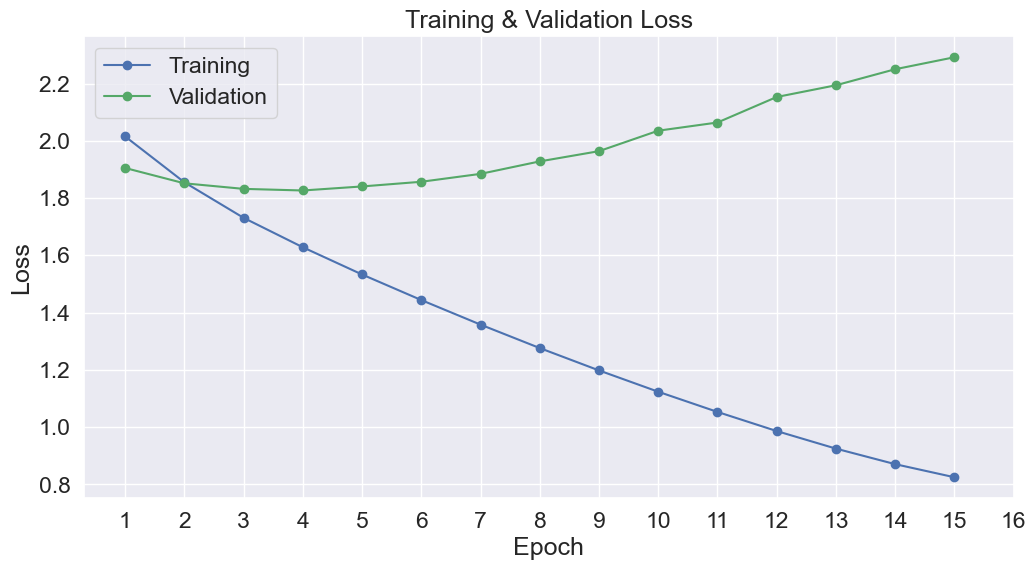

In [107]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i+1 for i in range(1+len(df_stats['Training Loss']))])

plt.show()

# Display Model Info

In [108]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50366, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [109]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './gpt2_all_story_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./gpt2_all_story_model_save/


('./gpt2_all_story_model_save/tokenizer_config.json',
 './gpt2_all_story_model_save/special_tokens_map.json',
 './gpt2_all_story_model_save/vocab.json',
 './gpt2_all_story_model_save/merges.txt',
 './gpt2_all_story_model_save/added_tokens.json')

# Generate Text

In [114]:
model.eval()

prompt = "<|startoftext|> <8> <sci_fi>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50267, 50364]], device='cuda:0')
0: <8> <sci_fi> In the year 2055, the unmanned Pilgrim 7 mission to Mars is about to land with mission control, a long distance Martian distance unknown. Navigator 1 is a perfect all-night surveillance system, but an Opera Ghost 8 is preparing to take off. Ghost 8's crew must have secret orders from the mothership to do away with the three astronauts. A small, human-like crew are on board the ship; but the ship has been knocked out and the sole survivor, an android named K-3, has been left behind. K-3's programming allows the crew to communicate with Ghost 8. It tells them that the crew is being guided into their "hiding craft", a newly-driven, picnic-like surface-to-air vehicle called the "Habdra", and is being guided by a "Dark Eyes", a life form which hides itself within the ship. The crew discovers that K-3, while noting the dark side of his unease, has a "drunk". The crew notices that K-3's head noise is distracting the ship's bridg

These aren't bad at all!


In [116]:
prompt = "<|startoftext|> <8> <drama> In the  "

# print(generated[0])
text = prompt
for i in range(100):
    generated = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
    generated = generated.to(device)
    output = model(generated)
    generated_token = torch.argmax(output[0][0][-1]).item()
    text = text + tokenizer.decode(generated_token)
print(text)

<|startoftext|> <8> <drama> In the  urchin 1940s, a young boy named Billy (Jackie Cooper) is sent to live with his grandparents in a small, fictional South American country called South America. Billy is a small-town boy who lives with his father, a school teacher, and his older brother, who is a native of the United States. Billy's grandfather is a local businessman who has bought the small town church and church, respectively. The church is being financed by the local property developer, who has plans to build


In [117]:
prompt = "<|startoftext|> <8> <drama> In the  "
generated = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
generated = generated.to(device)
output = model(generated)

In [118]:
logits = output[0][0][-1]
idx_all = []
top_k_probs = []
top_k_probs_all = []

In [119]:
def filter_logits(logits, tokenizer, words):
    logits_filtered = torch.clone(logits)
    for word in words:
        idx = tokenizer.encode(" " + word.strip())[0]
        logits_filtered[idx] = -float('Inf')
    return logits_filtered

In [120]:
from torch.nn import functional as F

temperature=1.0
do_sample=False
top_k=None

logits = logits / temperature
# optionally crop the logits to only the top k options
if top_k is not None:
    v, _ = torch.topk(logits, top_k)
    logits[logits < v[:, [-1]]] = -float('Inf')
# apply softmax to convert logits to (normalized) probabilities
probs = F.softmax(logits, dim=-1)

# either sample from the distribution or take the most likely element
if do_sample:
    idx_next = torch.multinomial(probs, num_samples=2)
else:
    top_probs, idx_next = torch.topk(probs, k=6, dim=-1)


In [121]:
from numpy.random import choice

def filtered_generate(model, tokenizer, idx, device, max_new_tokens=10, temperature=1.0, do_sample=False, top_k=None, filter_words = []):
    """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    """
    idx_all = []
    top_k_probs = []
    top_k_probs_all = []

    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
#         idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
        idx_cond = idx 
        idx_cond.to(device)
        # forward the model to get the logits for the index in the sequence
        output = model(idx_cond)
        logits = output[0][0][-1]
        # pluck the logits at the final step and scale by desired temperature
        logits = logits / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[-1]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        if len(filter_words) > 0:
            logits = filter_logits(logits,tokenizer, filter_words)
        probs = F.softmax(logits, dim=-1)
        # either sample from the distribution or take the most likely element
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            top_probs, idx_next = torch.topk(probs, k=top_k, dim=-1)
            idx_next = choice(idx_next.detach().cpu().numpy(), 1, p=top_probs.detach().cpu().numpy())
            idx_next = torch.from_numpy(idx_next).to(device)
        # append sampled index to the running sequence and continue
        # for i, idx_next in enumerate(idx_nexts):
        idx = torch.cat((idx, idx_next.reshape(1,1)), dim=1)            
#         top_k_probs.append(top_probs.detach().cpu().numpy()[0])
    return idx

In [122]:
from numpy.random import choice
draw = choice([1,2], 1,
              p=[0.99,0.01])
print(draw)

[1]


In [123]:
tokenizer.encode(" is")

[318]

In [124]:
prompt = "<|startoftext|> <10> <drama> One day, "
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)


In [126]:
generated_tokens = filtered_generate(model,tokenizer, generated, device, max_new_tokens=300, temperature=0.8, do_sample=False, top_k=5, filter_words=["is", "are", "He", "he", "She", "she"])
generated_story = tokenizer.decode(generated_tokens[0]).split(">")[3]
print(generated_story)

 One day,  Humphrey Bogart and his friend, Lon Chaney, and a couple of tourists, Franny and Bertie, stop at a decrepit, run-down mine for the weekend. There, Humphrey meets a deaf-mute woman named Estelle, who claims to be able to read and understand the laws of the land, and gives him a job as a handyman, despite his lack of experience with the job.  Humphrey soon becomes a folk hero when his father, a local drunk, dies under suspicious circumstances in a drunk driving accident. When the crooked land owner, Lon, retaliates by wrecking the bulldozer, the crooked land owner and his henchmen, including hired gun Joe Kerner, take over the bulldozer.  Things get worse when the land owner, Lon and his henchmen kidnap Estelle and eventually kill the deaf-mute woman. The thugs then go after Humphrey and kill him, but Estelle and Joe's men manage to escape, and the three make a run for it, where they end up at an abandoned mine.  Estelle and Joe have a change of heart.<|endoftext|


In [127]:
grade = str(int(calculate_grade(generated_story)))
print(grade)

9


In [129]:
estimated_grades = []
real_grades = []
for i in tqdm(range(10)):
    for g in range(12):
        prompt = "<|startoftext|> <{}> <drama> One day, ".format(g+1)
        generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
        generated = generated.to(device)
        generated_tokens = filtered_generate(model,tokenizer, generated, device, max_new_tokens=300, temperature=0.5, do_sample=False, top_k=5, filter_words=[])
        generated_story = tokenizer.decode(generated_tokens[0]).split(">")[3]
        estimated_grade = int(calculate_grade(generated_story))
        estimated_grades.append(estimated_grade)
        real_grades.append(g+1)               

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:39<00:00, 75.92s/it]


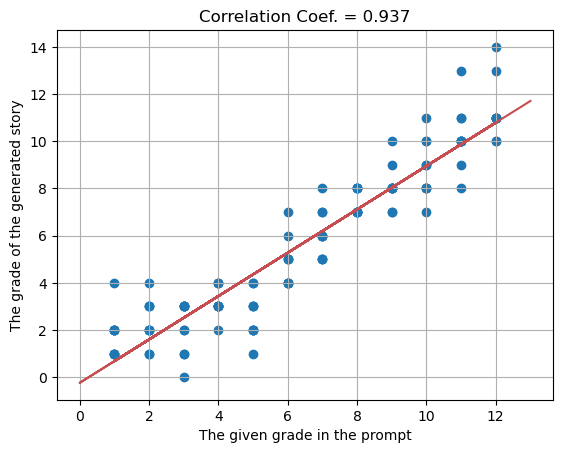

In [141]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file_defaults()


plt.figure()
plt.scatter(real_grades, estimated_grades)
plt.ylabel("The grade of the generated story")
plt.xlabel("The given grade in the prompt")
corr = np.round(np.corrcoef(real_grades, estimated_grades)[1][0],3)
a, b = np.polyfit(real_grades, estimated_grades, 1)
x = np.array(real_grades + [min(real_grades)-1, max(real_grades)+1])
#add line of best fit to plot
plt.plot(x, a*x+b, 'r')
plt.title("Correlation Coef. = {}".format(corr))
plt.grid()
plt.show()


In [140]:
np.corrcoef(real_grades, estimated_grades)[1][0]

0.9369516600817606